# 0. PANDA Patch Extraction Notebook

Extracts tissue patches from Whole Slide Images (WSIs) using a sliding window approach. The script filters out background regions and saves only "informative" tiles containing tissue.


# 0.a Background Threshold Test

Here we chose certain thresholds for testing puposes in order evaluate best threshold for patch extraction. This would prove useful when improving performance for our classifier.

Testing thresholds on: 2f36ff8187d5edeea79ad2e87763a89b

  50%... 139 tiles, 69.3% tissue
  60%... 161 tiles, 65.9% tissue
  70%... 176 tiles, 63.2% tissue
  85%... 200 tiles, 58.1% tissue
  90%... 211 tiles, 55.7% tissue

Thresh     Tiles      Accept%    Mean       Min-Max        
--------------------------------------------------------------------------------
50         139        14.7       69.3       50-99%
60         161        17.0       65.9       40-99%
70         176        18.6       63.2       32-99%
85         200        21.2       58.1       15-99%
90         211        22.3       55.7       10-99%


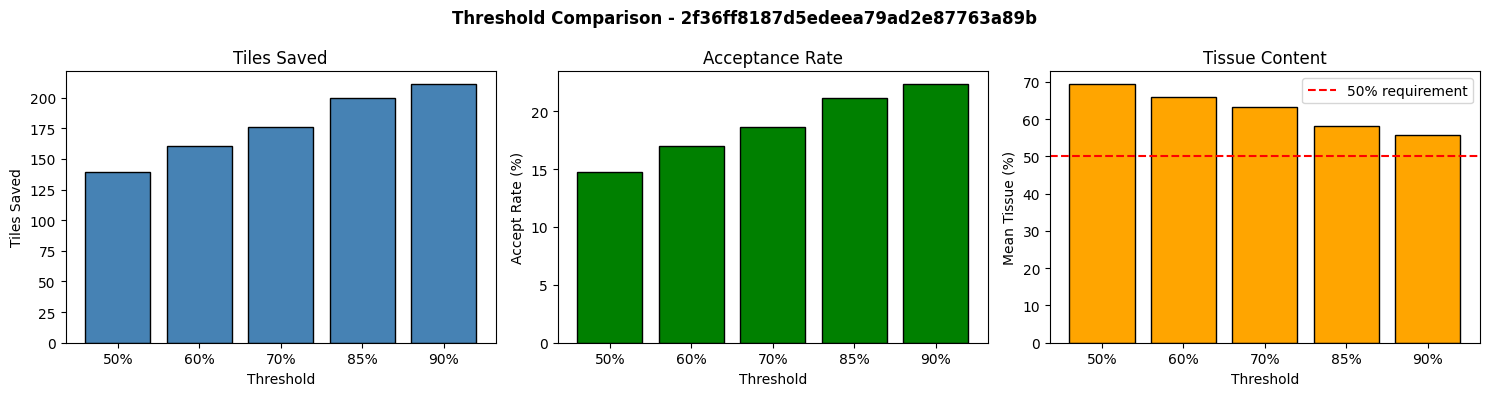

In [3]:
#!/usr/bin/env python3
"""
Threshold Tester - Compare background thresholds on a single WSI before full dataset tiling.
"""

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import openslide

# ============== CONFIGURATION ==============
INPUT_DIR = "/projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/DATA/train_images"
OUTPUT_BASE = "./threshold_tests"
WSI_ID = "2f36ff8187d5edeea79ad2e87763a89b"
THRESHOLDS = [0.50, 0.60, 0.70, 0.85, 0.90]
TILE_SIZE = 512
# ===========================================


def tile_with_threshold(wsi_path, threshold, output_dir):
    """Tile WSI with given threshold, return statistics."""
    os.makedirs(output_dir, exist_ok=True)
    slide = openslide.OpenSlide(wsi_path)
    w, h = slide.level_dimensions[0]
    
    saved, total, tissue_pcts = 0, 0, []
    
    for y in range(0, h, TILE_SIZE):
        for x in range(0, w, TILE_SIZE):
            total += 1
            tile = slide.read_region((x, y), 0, (TILE_SIZE, TILE_SIZE)).convert("RGB")
            bg_pct = np.mean(np.array(tile.convert("L")) >= 220)
            
            if bg_pct <= threshold:
                tile.save(os.path.join(output_dir, f"{x//TILE_SIZE}_{y//TILE_SIZE}.jpeg"), "JPEG", quality=90)
                saved += 1
                tissue_pcts.append(1.0 - bg_pct)
    
    tissue_pcts = np.array(tissue_pcts) if tissue_pcts else np.array([0])
    return {
        'threshold': threshold, 'total': total, 'saved': saved,
        'accept_rate': saved / total if total else 0,
        'mean': tissue_pcts.mean(), 'median': np.median(tissue_pcts),
        'min': tissue_pcts.min(), 'max': tissue_pcts.max()
    }


def run_comparison():
    """Test all thresholds and visualize results."""
    wsi_path = os.path.join(INPUT_DIR, f"{WSI_ID}.tiff")
    if not os.path.exists(wsi_path):
        wsi_path = os.path.join(INPUT_DIR, f"{WSI_ID}.tif")
    
    print(f"Testing thresholds on: {WSI_ID}\n")
    
    results = []
    for thresh in THRESHOLDS:
        print(f"  {thresh*100:.0f}%...", end=" ")
        output_dir = os.path.join(OUTPUT_BASE, WSI_ID, f"thresh_{int(thresh*100)}")
        stats = tile_with_threshold(wsi_path, thresh, output_dir)
        results.append(stats)
        print(f"{stats['saved']} tiles, {stats['mean']*100:.1f}% tissue")
    
    # Summary table
    print("\n" + "=" * 80)
    print(f"{'Thresh':<10} {'Tiles':<10} {'Accept%':<10} {'Mean':<10} {'Min-Max':<15}")
    print("-" * 80)
    for r in results:
        print(f"{r['threshold']*100:<10.0f} {r['saved']:<10} {r['accept_rate']*100:<10.1f} "
              f"{r['mean']*100:<10.1f} {r['min']*100:.0f}-{r['max']*100:.0f}%")
    print("=" * 80)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    x_labels = [f"{t*100:.0f}%" for t in THRESHOLDS]
    
    axes[0].bar(range(len(results)), [r['saved'] for r in results], color='steelblue', edgecolor='black')
    axes[0].set_xticks(range(len(results))); axes[0].set_xticklabels(x_labels)
    axes[0].set_xlabel('Threshold'); axes[0].set_ylabel('Tiles Saved'); axes[0].set_title('Tiles Saved')
    
    axes[1].bar(range(len(results)), [r['accept_rate']*100 for r in results], color='green', edgecolor='black')
    axes[1].set_xticks(range(len(results))); axes[1].set_xticklabels(x_labels)
    axes[1].set_xlabel('Threshold'); axes[1].set_ylabel('Accept Rate (%)'); axes[1].set_title('Acceptance Rate')
    
    axes[2].bar(range(len(results)), [r['mean']*100 for r in results], color='orange', edgecolor='black')
    axes[2].axhline(y=50, color='red', linestyle='--', label='50% requirement')
    axes[2].set_xticks(range(len(results))); axes[2].set_xticklabels(x_labels)
    axes[2].set_xlabel('Threshold'); axes[2].set_ylabel('Mean Tissue (%)'); axes[2].set_title('Tissue Content')
    axes[2].legend()
    
    plt.suptitle(f'Threshold Comparison - {WSI_ID}', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_BASE, f"comparison_{WSI_ID}.png"), dpi=150, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    run_comparison()

# 0b. WSI Inspection

Use this snippet to examine a WSI's structure before processing:

In [ ]:
import openslide, os

path = "./PANDA_DATA_MANNY/DATA/train_images/0005f7aaab2800f6170c399693a96917.tiff"
slide = openslide.OpenSlide(path)

print("Levels:", slide.level_count)
print("Dimensions per level:", slide.level_dimensions)
print("Downsamples:", slide.level_downsamples)
print("Properties:", slide.properties)

# 1. Patch Extraction
**Parameters:**
- **Tile Size**: 512×512 pixels
- **Background Threshold**: 0.85 (tiles with >85% background are discarded)
- **Threads**: 10 (parallel processing)

### Dependencies

- **OpenSlide** — Required for reading SVS/TIFF whole slide image formats

### Configuration

Update these paths before running:
- `INPUT_DIR` — Path to your WSI dataset
- `OUTPUT_DIR` — Output directory for extracted tiles
- `SPLIT_CSV` — CSV file containing WSI IDs to process

### How It Works

The `tile_one_slide` function processes each WSI:
1. Opens the WSI using OpenSlide
2. Calculates total tile positions based on image dimensions
3. For each (x, y) position:
   - Extracts a 512×512 tile
   - Filters based on background threshold (keeps tiles with ≥15% tissue)
   - Saves valid tiles to a folder named by WSI ID
4. Logs progress every 200 tiles
5. Reports total tiles saved per WSI


In [2]:
#!/usr/bin/env python3
import os
import numpy as np
from PIL import Image
import multiprocessing as mp
from tqdm import tqdm
import pandas as pd

# ------------------------------------------------
# Try OpenSlide
# ------------------------------------------------
try:
    import openslide
    OPENS_SLIDE_OK = True
except:
    OPENS_SLIDE_OK = False
    print("WARNING: OpenSlide not installed. Using PIL-only fallback.")

# ------------------------------------------------
# PATHS
# ------------------------------------------------
INPUT_DIR = "/projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/DATA/train_images"
OUTPUT_DIR = "/projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/tiles_04"
SPLIT_CSV = "/projectnb/ec500kb/projects/Project_1_Team_1/Official_GTP_PANDAS/PANDAS/data/subsets/train_patch_04.csv"
# change to val/test as needed

# ------------------------------------------------
# PARAMS
# ------------------------------------------------
TILE_SIZE = 512
BACKGROUND_THRESHOLD = 0.85  # 85% white threshold
BLACK_THRESHOLD = 0.05       # 5% max black pixels allowed
MIN_BRIGHTNESS = 30          # Minimum mean brightness
MAX_BRIGHTNESS = 240         # Maximum mean brightness (too white)
NUM_WORKERS = 10

LOG_QUEUE = mp.Queue()


# ============================================================
# LOGGER PROCESS
# ============================================================
def logger_worker():
    pbar = None

    while True:
        item = LOG_QUEUE.get()

        if item == "STOP":
            if pbar:
                pbar.close()
            break

        if isinstance(item, dict) and item.get("init"):
            total_wsis = item["total"]
            pbar = tqdm(total=total_wsis, desc="Total WSIs", ncols=100)
            continue

        if isinstance(item, dict) and item.get("done_one"):
            if pbar:
                pbar.update(1)
            continue

        print(item, flush=True)


# ============================================================
# DATA LOADING (CSV subset)
# ============================================================
def load_subset_ids(split_csv):
    """Load WSI IDs from CSV and find their paths."""
    df = pd.read_csv(split_csv)
    ids = df["image_id"].astype(str).tolist()
    tiff_paths = []

    for slide_id in ids:
        fp_tiff = os.path.join(INPUT_DIR, f"{slide_id}.tiff")
        fp_tif = os.path.join(INPUT_DIR, f"{slide_id}.tif")

        if os.path.exists(fp_tiff):
            tiff_paths.append(fp_tiff)
        elif os.path.exists(fp_tif):
            tiff_paths.append(fp_tif)
        else:
            LOG_QUEUE.put(f"WARNING: Slide {slide_id} not found in INPUT_DIR")

    return sorted(tiff_paths)


# ============================================================
# ENHANCED TILE VALIDATION
# ============================================================
def is_valid_tile(tile):
    """
    Check if tile should be saved based on:
    1. White background filtering (85% threshold)
    2. Black artifact filtering (bottom black bars)
    3. Overall brightness validation
    
    Returns:
        tuple: (is_valid, rejection_reason)
    """
    # Convert to grayscale array
    arr = np.array(tile.convert("L"))
    
    # Check 1: White background (your original filter)
    white_pixels = np.mean(arr > 220)
    if white_pixels > BACKGROUND_THRESHOLD:
        return False, "white_bg"
    
    # Check 2: Black artifact filter (NEW)
    black_pixels = np.mean(arr < 20)
    if black_pixels > BLACK_THRESHOLD:
        return False, "black_artifact"
    
    # Check 3: Overall brightness validation
    mean_brightness = np.mean(arr)
    
    if mean_brightness < MIN_BRIGHTNESS:
        return False, "too_dark"
    
    if mean_brightness > MAX_BRIGHTNESS:
        return False, "too_bright"
    
    return True, "valid"


def save_tile(tile, out_dir, x_idx, y_idx):
    """Save tile as JPEG."""
    tile.save(os.path.join(out_dir, f"{x_idx}_{y_idx}.jpeg"),
              "JPEG", quality=90)


# ============================================================
# WORKER: TILE ONE WSI
# ============================================================
def tile_one_wsi(path):
    slide_id = os.path.basename(path).split(".")[0]
    out_dir = os.path.join(OUTPUT_DIR, slide_id)
    
    # Skip if already processed
    if os.path.exists(out_dir) and len(os.listdir(out_dir)) > 0:
        LOG_QUEUE.put(f"SKIP: {slide_id} (already processed)")
        LOG_QUEUE.put({"done_one": True})
        return
    
    os.makedirs(out_dir, exist_ok=True)

    LOG_QUEUE.put(f"\n=== Processing {slide_id} ===")

    # Load slide
    if OPENS_SLIDE_OK:
        try:
            slide = openslide.OpenSlide(path)
            w, h = slide.level_dimensions[0]
        except Exception as e:
            LOG_QUEUE.put(f"{slide_id}: ERROR loading slide → {e}")
            LOG_QUEUE.put({"done_one": True})
            return
    else:
        try:
            img = Image.open(path).convert("RGB")
            w, h = img.size
        except Exception as e:
            LOG_QUEUE.put(f"{slide_id}: ERROR loading image → {e}")
            LOG_QUEUE.put({"done_one": True})
            return

    total_tiles = (w // TILE_SIZE + 1) * (h // TILE_SIZE + 1)
    count = 0
    saved_count = 0
    rejected_white = 0
    rejected_black = 0
    rejected_brightness = 0

    # Tile extraction
    for y in range(0, h, TILE_SIZE):
        for x in range(0, w, TILE_SIZE):
            count += 1

            if count % 200 == 0 or count == total_tiles:
                pct = 100 * count / total_tiles
                LOG_QUEUE.put(
                    f"{slide_id}: {count}/{total_tiles} ({pct:.1f}%) | "
                    f"Saved: {saved_count} | Rejected: W={rejected_white} B={rejected_black} Br={rejected_brightness}"
                )

            # Extract tile
            if OPENS_SLIDE_OK:
                tile = slide.read_region((x, y), 0, (TILE_SIZE, TILE_SIZE)).convert("RGB")
            else:
                tile = img.crop((x, y, x + TILE_SIZE, y + TILE_SIZE))

            # Enhanced validation
            is_valid, reason = is_valid_tile(tile)
            
            if is_valid:
                # Passed all filters - save tile
                save_tile(tile, out_dir, x // TILE_SIZE, y // TILE_SIZE)
                saved_count += 1
            else:
                # Track rejection reasons
                if reason == "white_bg":
                    rejected_white += 1
                elif reason == "black_artifact":
                    rejected_black += 1
                else:  # too_dark or too_bright
                    rejected_brightness += 1

    # Summary
    total_rejected = rejected_white + rejected_black + rejected_brightness
    LOG_QUEUE.put(
        f"=== Done {slide_id} ===\n"
        f"  Total tiles processed: {count}\n"
        f"  Saved: {saved_count}\n"
        f"  Rejected (white bg): {rejected_white}\n"
        f"  Rejected (black artifact): {rejected_black}\n"
        f"  Rejected (brightness): {rejected_brightness}\n"
        f"  Total rejected: {total_rejected}\n"
        f"  Save rate: {100*saved_count/count:.1f}%"
    )

    LOG_QUEUE.put({"done_one": True})


# ============================================================
# MAIN
# ============================================================
def main():
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # Start logger
    logger = mp.Process(target=logger_worker)
    logger.start()

    # Load only slides in the split CSV
    tiffs = load_subset_ids(SPLIT_CSV)
    total_wsis = len(tiffs)

    print("="*70)
    print("TILE EXTRACTION WITH BLACK ARTIFACT FILTERING")
    print("="*70)
    print(f"Input directory:  {INPUT_DIR}")
    print(f"Output directory: {OUTPUT_DIR}")
    print(f"Split CSV:        {SPLIT_CSV}")
    print(f"Tile size:        {TILE_SIZE}×{TILE_SIZE}")
    print(f"Workers:          {NUM_WORKERS}")
    print(f"\nFiltering settings:")
    print(f"  White background threshold: {BACKGROUND_THRESHOLD*100:.0f}%")
    print(f"  Black pixel threshold:      {BLACK_THRESHOLD*100:.0f}%")
    print(f"  Min brightness:             {MIN_BRIGHTNESS}")
    print(f"  Max brightness:             {MAX_BRIGHTNESS}")
    print(f"\nTotal WSIs to process: {total_wsis}")
    print("="*70)
    print()

    LOG_QUEUE.put({"init": True, "total": total_wsis})

    with mp.Pool(NUM_WORKERS) as pool:
        pool.map(tile_one_wsi, tiffs)

    LOG_QUEUE.put("STOP")
    logger.join()
    
    print()
    print("="*70)
    print("TILING COMPLETE")
    print("="*70)
    print(f"Output directory: {OUTPUT_DIR}")
    print("="*70)


if __name__ == "__main__":
    main()

TILE EXTRACTION WITH BLACK ARTIFACT FILTERING
Input directory:  /projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/DATA/train_images
Output directory: /projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/tiles_04
Split CSV:        /projectnb/ec500kb/projects/Project_1_Team_1/Official_GTP_PANDAS/PANDAS/data/subsets/train_patch_04.csv
Tile size:        512×512
Workers:          10

Filtering settings:
  White background threshold: 85%
  Black pixel threshold:      5%
  Min brightness:             30
  Max brightness:             240

Total WSIs to process: 850



Total WSIs:   0%|                                                           | 0/850 [00:00<?, ?it/s]


=== Processing 0068d4c7529e34fd4c9da863ce01a161 ===

=== Processing 07d600e3fcbebf7dc75e5335d3563e63 ===

=== Processing 0eb4c1db923d5395c5eb15e8850804ed ===

=== Processing 199cac82a1dd58d80c3f29213f2de1cc ===

=== Processing 1ff3c2c6abd78e3c115939d98644f15e ===

=== Processing 145c74333d681b537b51a1f2c553c24e ===

=== Processing 25ab6fdebec09bb2b98756d9068a4c09 ===

=== Processing 2b12c146454d425994569aa61bceb435 ===

=== Processing 32fcd30edb849c78bb61c64a00a0ac79 ===

=== Processing 37355e29029bdc13096902e0d82a9b88 ===
=== Done 32fcd30edb849c78bb61c64a00a0ac79 ===
  Total tiles processed: 66
  Saved: 20
  Rejected (white bg): 35
  Rejected (black artifact): 11
  Rejected (brightness): 0
  Total rejected: 46
  Save rate: 30.3%


Total WSIs:   0%|                                                   | 1/850 [00:00<09:29,  1.49it/s]


=== Processing 331e4fe39216db524c07eab27b107cf7 ===
25ab6fdebec09bb2b98756d9068a4c09: 200/2255 (8.9%) | Saved: 4 | Rejected: W=195 B=0 Br=0
2b12c146454d425994569aa61bceb435: 200/1152 (17.4%) | Saved: 13 | Rejected: W=180 B=6 Br=0
0068d4c7529e34fd4c9da863ce01a161: 200/294 (68.0%) | Saved: 36 | Rejected: W=149 B=14 Br=0
37355e29029bdc13096902e0d82a9b88: 200/672 (29.8%) | Saved: 17 | Rejected: W=182 B=0 Br=0
199cac82a1dd58d80c3f29213f2de1cc: 200/4331 (4.6%) | Saved: 2 | Rejected: W=197 B=0 Br=0
0eb4c1db923d5395c5eb15e8850804ed: 200/1092 (18.3%) | Saved: 23 | Rejected: W=167 B=9 Br=0
1ff3c2c6abd78e3c115939d98644f15e: 200/589 (34.0%) | Saved: 47 | Rejected: W=141 B=10 Br=1
145c74333d681b537b51a1f2c553c24e: 200/765 (26.1%) | Saved: 59 | Rejected: W=129 B=11 Br=0
07d600e3fcbebf7dc75e5335d3563e63: 200/812 (24.6%) | Saved: 52 | Rejected: W=147 B=0 Br=0
331e4fe39216db524c07eab27b107cf7: 200/3096 (6.5%) | Saved: 3 | Rejected: W=191 B=4 Br=1
0068d4c7529e34fd4c9da863ce01a161: 294/294 (100.0%) | Sa

Total WSIs:   0%|                                                   | 2/850 [00:02<18:06,  1.28s/it]


=== Processing 00bbc1482301d16de3ff63238cfd0b34 ===
2b12c146454d425994569aa61bceb435: 400/1152 (34.7%) | Saved: 30 | Rejected: W=357 B=12 Br=0
25ab6fdebec09bb2b98756d9068a4c09: 400/2255 (17.7%) | Saved: 18 | Rejected: W=380 B=0 Br=1
199cac82a1dd58d80c3f29213f2de1cc: 400/4331 (9.2%) | Saved: 12 | Rejected: W=387 B=0 Br=0
0eb4c1db923d5395c5eb15e8850804ed: 400/1092 (36.6%) | Saved: 49 | Rejected: W=331 B=19 Br=0
37355e29029bdc13096902e0d82a9b88: 400/672 (59.5%) | Saved: 65 | Rejected: W=333 B=0 Br=1
1ff3c2c6abd78e3c115939d98644f15e: 400/589 (67.9%) | Saved: 86 | Rejected: W=291 B=21 Br=1
145c74333d681b537b51a1f2c553c24e: 400/765 (52.3%) | Saved: 112 | Rejected: W=264 B=23 Br=0
07d600e3fcbebf7dc75e5335d3563e63: 400/812 (49.3%) | Saved: 98 | Rejected: W=301 B=0 Br=0
331e4fe39216db524c07eab27b107cf7: 400/3096 (12.9%) | Saved: 17 | Rejected: W=372 B=9 Br=1
00bbc1482301d16de3ff63238cfd0b34: 200/583 (34.3%) | Saved: 66 | Rejected: W=133 B=0 Br=0
=== Done 1ff3c2c6abd78e3c115939d98644f15e ===
  

Total WSIs:   0%|▏                                                  | 3/850 [00:04<24:09,  1.71s/it]


=== Processing 203256da67cb1aab601d3af3f13d5db5 ===
2b12c146454d425994569aa61bceb435: 600/1152 (52.1%) | Saved: 60 | Rejected: W=521 B=18 Br=0
25ab6fdebec09bb2b98756d9068a4c09: 600/2255 (26.6%) | Saved: 33 | Rejected: W=565 B=0 Br=1
199cac82a1dd58d80c3f29213f2de1cc: 600/4331 (13.9%) | Saved: 23 | Rejected: W=576 B=0 Br=0
0eb4c1db923d5395c5eb15e8850804ed: 600/1092 (54.9%) | Saved: 76 | Rejected: W=495 B=28 Br=0
145c74333d681b537b51a1f2c553c24e: 600/765 (78.4%) | Saved: 160 | Rejected: W=404 B=35 Br=0
37355e29029bdc13096902e0d82a9b88: 600/672 (89.3%) | Saved: 156 | Rejected: W=442 B=0 Br=1
331e4fe39216db524c07eab27b107cf7: 600/3096 (19.4%) | Saved: 30 | Rejected: W=555 B=13 Br=1
07d600e3fcbebf7dc75e5335d3563e63: 600/812 (73.9%) | Saved: 153 | Rejected: W=446 B=0 Br=0
=== Done 37355e29029bdc13096902e0d82a9b88 ===
  Total tiles processed: 658
  Saved: 156
  Rejected (white bg): 454
  Rejected (black artifact): 47
  Rejected (brightness): 1
  Total rejected: 502
  Save rate: 23.7%


Total WSIs:   0%|▏                                                  | 4/850 [00:05<19:43,  1.40s/it]


=== Processing 374d5401159d9bf39ce20b395d82c0b4 ===
00bbc1482301d16de3ff63238cfd0b34: 400/583 (68.6%) | Saved: 122 | Rejected: W=277 B=0 Br=0
25ab6fdebec09bb2b98756d9068a4c09: 800/2255 (35.5%) | Saved: 54 | Rejected: W=744 B=0 Br=1
2b12c146454d425994569aa61bceb435: 800/1152 (69.4%) | Saved: 90 | Rejected: W=685 B=24 Br=0
199cac82a1dd58d80c3f29213f2de1cc: 800/4331 (18.5%) | Saved: 39 | Rejected: W=760 B=0 Br=0
145c74333d681b537b51a1f2c553c24e: 765/765 (100.0%) | Saved: 182 | Rejected: W=522 B=60 Br=0
=== Done 145c74333d681b537b51a1f2c553c24e ===
  Total tiles processed: 765
  Saved: 182
  Rejected (white bg): 522
  Rejected (black artifact): 61
  Rejected (brightness): 0
  Total rejected: 583
  Save rate: 23.8%


Total WSIs:   1%|▎                                                  | 5/850 [00:06<16:19,  1.16s/it]


=== Processing 14d4d7374400dc55ce7cc8d184c9a4c7 ===
203256da67cb1aab601d3af3f13d5db5: 200/1083 (18.5%) | Saved: 49 | Rejected: W=147 B=3 Br=0
0eb4c1db923d5395c5eb15e8850804ed: 800/1092 (73.3%) | Saved: 104 | Rejected: W=657 B=38 Br=0
=== Done 07d600e3fcbebf7dc75e5335d3563e63 ===
  Total tiles processed: 754
  Saved: 181
  Rejected (white bg): 560
  Rejected (black artifact): 13
  Rejected (brightness): 0
  Total rejected: 573
  Save rate: 24.0%


Total WSIs:   1%|▎                                                  | 6/850 [00:06<11:27,  1.23it/s]


=== Processing 082fd0a9f827b00494feb039b53b5500 ===
331e4fe39216db524c07eab27b107cf7: 800/3096 (25.8%) | Saved: 40 | Rejected: W=740 B=18 Br=1
=== Done 00bbc1482301d16de3ff63238cfd0b34 ===
  Total tiles processed: 520
  Saved: 154
  Rejected (white bg): 366
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 366
  Save rate: 29.6%


Total WSIs:   1%|▍                                                  | 7/850 [00:06<09:14,  1.52it/s]


=== Processing 00d8a8c04886379e266406fdeff81c45 ===
374d5401159d9bf39ce20b395d82c0b4: 200/1219 (16.4%) | Saved: 23 | Rejected: W=176 B=0 Br=0
25ab6fdebec09bb2b98756d9068a4c09: 1000/2255 (44.3%) | Saved: 72 | Rejected: W=924 B=2 Br=1
2b12c146454d425994569aa61bceb435: 1000/1152 (86.8%) | Saved: 114 | Rejected: W=854 B=31 Br=0
199cac82a1dd58d80c3f29213f2de1cc: 1000/4331 (23.1%) | Saved: 52 | Rejected: W=947 B=0 Br=0
14d4d7374400dc55ce7cc8d184c9a4c7: 200/2296 (8.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
0eb4c1db923d5395c5eb15e8850804ed: 1000/1092 (91.6%) | Saved: 138 | Rejected: W=814 B=47 Br=0
331e4fe39216db524c07eab27b107cf7: 1000/3096 (32.3%) | Saved: 54 | Rejected: W=921 B=23 Br=1
203256da67cb1aab601d3af3f13d5db5: 400/1083 (36.9%) | Saved: 123 | Rejected: W=270 B=6 Br=0
082fd0a9f827b00494feb039b53b5500: 200/1134 (17.6%) | Saved: 35 | Rejected: W=145 B=19 Br=0
00d8a8c04886379e266406fdeff81c45: 200/1200 (16.7%) | Saved: 14 | Rejected: W=185 B=0 Br=0
=== Done 0eb4c1db923d5395c5eb15e88508

Total WSIs:   1%|▍                                                  | 8/850 [00:08<14:11,  1.01s/it]


=== Processing 0ebea13245a2b04ca3e6a482091e35d6 ===
374d5401159d9bf39ce20b395d82c0b4: 400/1219 (32.8%) | Saved: 35 | Rejected: W=364 B=0 Br=0
2b12c146454d425994569aa61bceb435: 1152/1152 (100.0%) | Saved: 122 | Rejected: W=963 B=66 Br=0
=== Done 2b12c146454d425994569aa61bceb435 ===
  Total tiles processed: 1152
  Saved: 122
  Rejected (white bg): 963
  Rejected (black artifact): 67
  Rejected (brightness): 0
  Total rejected: 1030
  Save rate: 10.6%


Total WSIs:   1%|▌                                                  | 9/850 [00:08<10:42,  1.31it/s]


=== Processing 2b340c9844077ddcdf641adac5f116e3 ===
25ab6fdebec09bb2b98756d9068a4c09: 1200/2255 (53.2%) | Saved: 95 | Rejected: W=1101 B=2 Br=1
14d4d7374400dc55ce7cc8d184c9a4c7: 400/2296 (17.4%) | Saved: 0 | Rejected: W=399 B=0 Br=0
199cac82a1dd58d80c3f29213f2de1cc: 1200/4331 (27.7%) | Saved: 64 | Rejected: W=1135 B=0 Br=0
331e4fe39216db524c07eab27b107cf7: 1200/3096 (38.8%) | Saved: 69 | Rejected: W=1102 B=27 Br=1
203256da67cb1aab601d3af3f13d5db5: 600/1083 (55.4%) | Saved: 165 | Rejected: W=421 B=13 Br=0
00d8a8c04886379e266406fdeff81c45: 400/1200 (33.3%) | Saved: 33 | Rejected: W=366 B=0 Br=0
082fd0a9f827b00494feb039b53b5500: 400/1134 (35.3%) | Saved: 64 | Rejected: W=304 B=31 Br=0
374d5401159d9bf39ce20b395d82c0b4: 600/1219 (49.2%) | Saved: 56 | Rejected: W=543 B=0 Br=0
0ebea13245a2b04ca3e6a482091e35d6: 200/380 (52.6%) | Saved: 57 | Rejected: W=123 B=19 Br=0
2b340c9844077ddcdf641adac5f116e3: 200/1708 (11.7%) | Saved: 21 | Rejected: W=171 B=7 Br=0
14d4d7374400dc55ce7cc8d184c9a4c7: 600/

Total WSIs:   1%|▌                                                 | 10/850 [00:11<20:01,  1.43s/it]


=== Processing 0ec18b204bb91f36ae7367016df623ec ===
374d5401159d9bf39ce20b395d82c0b4: 800/1219 (65.6%) | Saved: 85 | Rejected: W=714 B=0 Br=0
2b340c9844077ddcdf641adac5f116e3: 400/1708 (23.4%) | Saved: 40 | Rejected: W=345 B=14 Br=0
14d4d7374400dc55ce7cc8d184c9a4c7: 800/2296 (34.8%) | Saved: 25 | Rejected: W=774 B=0 Br=0
25ab6fdebec09bb2b98756d9068a4c09: 1600/2255 (71.0%) | Saved: 133 | Rejected: W=1463 B=2 Br=1
199cac82a1dd58d80c3f29213f2de1cc: 1600/4331 (36.9%) | Saved: 86 | Rejected: W=1512 B=0 Br=1
331e4fe39216db524c07eab27b107cf7: 1600/3096 (51.7%) | Saved: 95 | Rejected: W=1463 B=37 Br=4
00d8a8c04886379e266406fdeff81c45: 800/1200 (66.7%) | Saved: 67 | Rejected: W=732 B=0 Br=0
203256da67cb1aab601d3af3f13d5db5: 1000/1083 (92.3%) | Saved: 218 | Rejected: W=755 B=26 Br=0
=== Done 203256da67cb1aab601d3af3f13d5db5 ===
  Total tiles processed: 1008
  Saved: 218
  Rejected (white bg): 764
  Rejected (black artifact): 26
  Rejected (brightness): 0
  Total rejected: 790
  Save rate: 21.6%

Total WSIs:   1%|▋                                                 | 11/850 [00:12<18:53,  1.35s/it]


=== Processing 2033421adffe1e569704229c139c0dab ===
082fd0a9f827b00494feb039b53b5500: 800/1134 (70.5%) | Saved: 112 | Rejected: W=635 B=52 Br=0
2b340c9844077ddcdf641adac5f116e3: 600/1708 (35.1%) | Saved: 61 | Rejected: W=517 B=21 Br=0
0ec18b204bb91f36ae7367016df623ec: 200/660 (30.3%) | Saved: 4 | Rejected: W=181 B=14 Br=0
374d5401159d9bf39ce20b395d82c0b4: 1000/1219 (82.0%) | Saved: 106 | Rejected: W=893 B=0 Br=0
14d4d7374400dc55ce7cc8d184c9a4c7: 1000/2296 (43.6%) | Saved: 40 | Rejected: W=959 B=0 Br=0
25ab6fdebec09bb2b98756d9068a4c09: 1800/2255 (79.8%) | Saved: 148 | Rejected: W=1648 B=2 Br=1
199cac82a1dd58d80c3f29213f2de1cc: 1800/4331 (41.6%) | Saved: 95 | Rejected: W=1703 B=0 Br=1
331e4fe39216db524c07eab27b107cf7: 1800/3096 (58.1%) | Saved: 114 | Rejected: W=1640 B=41 Br=4
00d8a8c04886379e266406fdeff81c45: 1000/1200 (83.3%) | Saved: 86 | Rejected: W=913 B=0 Br=0
2033421adffe1e569704229c139c0dab: 200/2835 (7.1%) | Saved: 12 | Rejected: W=183 B=4 Br=0
082fd0a9f827b00494feb039b53b5500:

Total WSIs:   1%|▋                                                 | 12/850 [00:14<20:45,  1.49s/it]


=== Processing 379a40c0c5b897ffd42d5567d40968da ===
2b340c9844077ddcdf641adac5f116e3: 800/1708 (46.8%) | Saved: 85 | Rejected: W=686 B=28 Br=0
0ec18b204bb91f36ae7367016df623ec: 400/660 (60.6%) | Saved: 46 | Rejected: W=288 B=65 Br=0
14d4d7374400dc55ce7cc8d184c9a4c7: 1200/2296 (52.3%) | Saved: 56 | Rejected: W=1143 B=0 Br=0
25ab6fdebec09bb2b98756d9068a4c09: 2000/2255 (88.7%) | Saved: 166 | Rejected: W=1830 B=2 Br=1
=== Done 082fd0a9f827b00494feb039b53b5500 ===
  Total tiles processed: 1060
  Saved: 161
  Rejected (white bg): 831
  Rejected (black artifact): 68
  Rejected (brightness): 0
  Total rejected: 899
  Save rate: 15.2%


Total WSIs:   2%|▊                                                 | 13/850 [00:15<16:19,  1.17s/it]


=== Processing 0838c82917cd9af681df249264d2769c ===
199cac82a1dd58d80c3f29213f2de1cc: 2000/4331 (46.2%) | Saved: 103 | Rejected: W=1895 B=0 Br=1
=== Done 00d8a8c04886379e266406fdeff81c45 ===
  Total tiles processed: 1128
  Saved: 96
  Rejected (white bg): 1032
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1032
  Save rate: 8.5%


Total WSIs:   2%|▊                                                 | 14/850 [00:15<11:49,  1.18it/s]


=== Processing 011d38d07a0d228d2d3f8433ff483738 ===
331e4fe39216db524c07eab27b107cf7: 2000/3096 (64.6%) | Saved: 126 | Rejected: W=1823 B=46 Br=4
2033421adffe1e569704229c139c0dab: 400/2835 (14.1%) | Saved: 24 | Rejected: W=367 B=8 Br=0
379a40c0c5b897ffd42d5567d40968da: 200/3570 (5.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
2b340c9844077ddcdf641adac5f116e3: 1000/1708 (58.5%) | Saved: 110 | Rejected: W=854 B=35 Br=0
=== Done 0ec18b204bb91f36ae7367016df623ec ===
  Total tiles processed: 594
  Saved: 53
  Rejected (white bg): 458
  Rejected (black artifact): 83
  Rejected (brightness): 0
  Total rejected: 541
  Save rate: 8.9%


Total WSIs:   2%|▉                                                 | 15/850 [00:16<13:16,  1.05it/s]


=== Processing 0f0cb9aefe4adc765a1d91318d075c4b ===
25ab6fdebec09bb2b98756d9068a4c09: 2200/2255 (97.6%) | Saved: 168 | Rejected: W=2028 B=2 Br=1
14d4d7374400dc55ce7cc8d184c9a4c7: 1400/2296 (61.0%) | Saved: 70 | Rejected: W=1329 B=0 Br=0
199cac82a1dd58d80c3f29213f2de1cc: 2200/4331 (50.8%) | Saved: 117 | Rejected: W=2081 B=0 Br=1
011d38d07a0d228d2d3f8433ff483738: 200/3060 (6.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
25ab6fdebec09bb2b98756d9068a4c09: 2255/2255 (100.0%) | Saved: 168 | Rejected: W=2043 B=42 Br=1
=== Done 25ab6fdebec09bb2b98756d9068a4c09 ===
  Total tiles processed: 2255
  Saved: 168
  Rejected (white bg): 2043
  Rejected (black artifact): 43
  Rejected (brightness): 1
  Total rejected: 2087
  Save rate: 7.5%


Total WSIs:   2%|▉                                                 | 16/850 [00:16<11:01,  1.26it/s]


=== Processing 2626d578899ee91a14a09bab13ae8b07 ===
0838c82917cd9af681df249264d2769c: 200/2010 (10.0%) | Saved: 33 | Rejected: W=160 B=6 Br=0
331e4fe39216db524c07eab27b107cf7: 2200/3096 (71.1%) | Saved: 143 | Rejected: W=2001 B=51 Br=4
2033421adffe1e569704229c139c0dab: 600/2835 (21.2%) | Saved: 44 | Rejected: W=542 B=13 Br=0
379a40c0c5b897ffd42d5567d40968da: 400/3570 (11.2%) | Saved: 0 | Rejected: W=399 B=0 Br=0
2b340c9844077ddcdf641adac5f116e3: 1200/1708 (70.3%) | Saved: 181 | Rejected: W=976 B=42 Br=0
0f0cb9aefe4adc765a1d91318d075c4b: 200/2346 (8.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
14d4d7374400dc55ce7cc8d184c9a4c7: 1600/2296 (69.7%) | Saved: 85 | Rejected: W=1514 B=0 Br=0
011d38d07a0d228d2d3f8433ff483738: 400/3060 (13.1%) | Saved: 0 | Rejected: W=399 B=0 Br=0
199cac82a1dd58d80c3f29213f2de1cc: 2400/4331 (55.4%) | Saved: 129 | Rejected: W=2268 B=0 Br=2
0838c82917cd9af681df249264d2769c: 400/2010 (19.9%) | Saved: 63 | Rejected: W=323 B=13 Br=0
2626d578899ee91a14a09bab13ae8b07: 200

Total WSIs:   2%|█                                                 | 17/850 [00:20<23:14,  1.67s/it]


=== Processing 268dcbd78318c0108974c5f99e1dca78 ===
379a40c0c5b897ffd42d5567d40968da: 800/3570 (22.4%) | Saved: 7 | Rejected: W=791 B=0 Br=1
2b340c9844077ddcdf641adac5f116e3: 1600/1708 (93.7%) | Saved: 251 | Rejected: W=1291 B=57 Br=0
0f0cb9aefe4adc765a1d91318d075c4b: 600/2346 (25.6%) | Saved: 18 | Rejected: W=581 B=0 Br=0
14d4d7374400dc55ce7cc8d184c9a4c7: 2000/2296 (87.1%) | Saved: 130 | Rejected: W=1869 B=0 Br=0
011d38d07a0d228d2d3f8433ff483738: 800/3060 (26.1%) | Saved: 23 | Rejected: W=776 B=0 Br=0
199cac82a1dd58d80c3f29213f2de1cc: 2800/4331 (64.7%) | Saved: 149 | Rejected: W=2648 B=0 Br=2
0838c82917cd9af681df249264d2769c: 800/2010 (39.8%) | Saved: 111 | Rejected: W=662 B=26 Br=0
331e4fe39216db524c07eab27b107cf7: 2800/3096 (90.4%) | Saved: 191 | Rejected: W=2539 B=65 Br=4
2b340c9844077ddcdf641adac5f116e3: 1708/1708 (100.0%) | Saved: 257 | Rejected: W=1363 B=87 Br=0
=== Done 2b340c9844077ddcdf641adac5f116e3 ===
  Total tiles processed: 1708
  Saved: 257
  Rejected (white bg): 1363


Total WSIs:   2%|█                                                 | 18/850 [00:21<20:53,  1.51s/it]


=== Processing 2c648f25c47e7344bf1977154c31c25b ===
2033421adffe1e569704229c139c0dab: 1200/2835 (42.3%) | Saved: 110 | Rejected: W=1063 B=26 Br=0
379a40c0c5b897ffd42d5567d40968da: 1000/3570 (28.0%) | Saved: 19 | Rejected: W=979 B=0 Br=1
268dcbd78318c0108974c5f99e1dca78: 200/1400 (14.3%) | Saved: 24 | Rejected: W=175 B=0 Br=0
14d4d7374400dc55ce7cc8d184c9a4c7: 2200/2296 (95.8%) | Saved: 141 | Rejected: W=2058 B=0 Br=0
0f0cb9aefe4adc765a1d91318d075c4b: 800/2346 (34.1%) | Saved: 35 | Rejected: W=763 B=0 Br=1
199cac82a1dd58d80c3f29213f2de1cc: 3000/4331 (69.3%) | Saved: 158 | Rejected: W=2839 B=0 Br=2
011d38d07a0d228d2d3f8433ff483738: 1000/3060 (32.7%) | Saved: 50 | Rejected: W=948 B=0 Br=1
0838c82917cd9af681df249264d2769c: 1000/2010 (49.8%) | Saved: 132 | Rejected: W=834 B=33 Br=0
14d4d7374400dc55ce7cc8d184c9a4c7: 2296/2296 (100.0%) | Saved: 141 | Rejected: W=2114 B=40 Br=0
=== Done 14d4d7374400dc55ce7cc8d184c9a4c7 ===
  Total tiles processed: 2296
  Saved: 141
  Rejected (white bg): 2114


Total WSIs:   2%|█                                                 | 19/850 [00:22<20:14,  1.46s/it]


=== Processing 1517ef21c1a72cf5ba4e1eeb6176dccc ===
331e4fe39216db524c07eab27b107cf7: 3000/3096 (96.9%) | Saved: 210 | Rejected: W=2716 B=69 Br=4
2c648f25c47e7344bf1977154c31c25b: 200/2160 (9.3%) | Saved: 8 | Rejected: W=187 B=4 Br=0
2033421adffe1e569704229c139c0dab: 1400/2835 (49.4%) | Saved: 125 | Rejected: W=1243 B=31 Br=0
379a40c0c5b897ffd42d5567d40968da: 1200/3570 (33.6%) | Saved: 31 | Rejected: W=1166 B=0 Br=2
268dcbd78318c0108974c5f99e1dca78: 400/1400 (28.6%) | Saved: 64 | Rejected: W=335 B=0 Br=0
331e4fe39216db524c07eab27b107cf7: 3096/3096 (100.0%) | Saved: 210 | Rejected: W=2768 B=113 Br=4
=== Done 331e4fe39216db524c07eab27b107cf7 ===
  Total tiles processed: 3096
  Saved: 210
  Rejected (white bg): 2768
  Rejected (black artifact): 114
  Rejected (brightness): 4
  Total rejected: 2886
  Save rate: 6.8%


Total WSIs:   2%|█▏                                                | 20/850 [00:23<17:23,  1.26s/it]


=== Processing 332db6f0f6f290e521b714b4d209ff25 ===
0f0cb9aefe4adc765a1d91318d075c4b: 1000/2346 (42.6%) | Saved: 49 | Rejected: W=949 B=0 Br=1
199cac82a1dd58d80c3f29213f2de1cc: 3200/4331 (73.9%) | Saved: 166 | Rejected: W=3031 B=0 Br=2
011d38d07a0d228d2d3f8433ff483738: 1200/3060 (39.2%) | Saved: 62 | Rejected: W=1136 B=0 Br=1
0838c82917cd9af681df249264d2769c: 1200/2010 (59.7%) | Saved: 155 | Rejected: W=1005 B=39 Br=0
1517ef21c1a72cf5ba4e1eeb6176dccc: 200/2291 (8.7%) | Saved: 2 | Rejected: W=195 B=2 Br=0
2c648f25c47e7344bf1977154c31c25b: 400/2160 (18.5%) | Saved: 26 | Rejected: W=365 B=8 Br=0
2033421adffe1e569704229c139c0dab: 1600/2835 (56.4%) | Saved: 141 | Rejected: W=1423 B=35 Br=0
379a40c0c5b897ffd42d5567d40968da: 1400/3570 (39.2%) | Saved: 43 | Rejected: W=1354 B=0 Br=2
268dcbd78318c0108974c5f99e1dca78: 600/1400 (42.9%) | Saved: 92 | Rejected: W=507 B=0 Br=0
332db6f0f6f290e521b714b4d209ff25: 200/2744 (7.3%) | Saved: 3 | Rejected: W=192 B=4 Br=0
0f0cb9aefe4adc765a1d91318d075c4b: 1

Total WSIs:   2%|█▏                                                | 21/850 [00:30<40:30,  2.93s/it]


=== Processing 0859f6978ecda3a70941d601287ef6de ===
=== Done 268dcbd78318c0108974c5f99e1dca78 ===
  Total tiles processed: 1344
  Saved: 249
  Rejected (white bg): 1071
  Rejected (black artifact): 24
  Rejected (brightness): 0
  Total rejected: 1095
  Save rate: 18.5%


Total WSIs:   3%|█▎                                                | 22/850 [00:30<29:23,  2.13s/it]


=== Processing 26fbfd016190823c434c95a81f156ae4 ===
379a40c0c5b897ffd42d5567d40968da: 2200/3570 (61.6%) | Saved: 88 | Rejected: W=2109 B=0 Br=2
332db6f0f6f290e521b714b4d209ff25: 1000/2744 (36.4%) | Saved: 60 | Rejected: W=919 B=20 Br=0
0f0cb9aefe4adc765a1d91318d075c4b: 2000/2346 (85.3%) | Saved: 115 | Rejected: W=1883 B=0 Br=1
011d38d07a0d228d2d3f8433ff483738: 2200/3060 (71.9%) | Saved: 134 | Rejected: W=2064 B=0 Br=1
199cac82a1dd58d80c3f29213f2de1cc: 4200/4331 (97.0%) | Saved: 229 | Rejected: W=3967 B=0 Br=3
2c648f25c47e7344bf1977154c31c25b: 1400/2160 (64.8%) | Saved: 99 | Rejected: W=1269 B=31 Br=0
2033421adffe1e569704229c139c0dab: 2600/2835 (91.7%) | Saved: 216 | Rejected: W=2326 B=57 Br=0
0859f6978ecda3a70941d601287ef6de: 200/1755 (11.4%) | Saved: 10 | Rejected: W=189 B=0 Br=0
=== Done 199cac82a1dd58d80c3f29213f2de1cc ===
  Total tiles processed: 4260
  Saved: 229
  Rejected (white bg): 3968
  Rejected (black artifact): 60
  Rejected (brightness): 3
  Total rejected: 4031
  Save r

Total WSIs:   3%|█▎                                                | 23/850 [00:32<26:18,  1.91s/it]


=== Processing 19b0eb9d02259e897f81f08afbcfc9bc ===
1517ef21c1a72cf5ba4e1eeb6176dccc: 1200/2291 (52.4%) | Saved: 191 | Rejected: W=993 B=15 Br=0
26fbfd016190823c434c95a81f156ae4: 200/2301 (8.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
379a40c0c5b897ffd42d5567d40968da: 2400/3570 (67.2%) | Saved: 103 | Rejected: W=2294 B=0 Br=2
332db6f0f6f290e521b714b4d209ff25: 1200/2744 (43.7%) | Saved: 74 | Rejected: W=1101 B=24 Br=0
0f0cb9aefe4adc765a1d91318d075c4b: 2200/2346 (93.8%) | Saved: 126 | Rejected: W=2072 B=0 Br=1
011d38d07a0d228d2d3f8433ff483738: 2400/3060 (78.4%) | Saved: 156 | Rejected: W=2242 B=0 Br=1
2c648f25c47e7344bf1977154c31c25b: 1600/2160 (74.1%) | Saved: 115 | Rejected: W=1449 B=35 Br=0
2033421adffe1e569704229c139c0dab: 2800/2835 (98.8%) | Saved: 221 | Rejected: W=2507 B=71 Br=0
2033421adffe1e569704229c139c0dab: 2835/2835 (100.0%) | Saved: 221 | Rejected: W=2507 B=106 Br=0
=== Done 2033421adffe1e569704229c139c0dab ===
  Total tiles processed: 2835
  Saved: 221
  Rejected (white bg)

Total WSIs:   3%|█▍                                                | 24/850 [00:33<24:08,  1.75s/it]


=== Processing 20340e3ee5bd16fdb06dabb63079c835 ===
=== Done 0f0cb9aefe4adc765a1d91318d075c4b ===
  Total tiles processed: 2300
  Saved: 126
  Rejected (white bg): 2123
  Rejected (black artifact): 50
  Rejected (brightness): 1
  Total rejected: 2174
  Save rate: 5.5%


Total WSIs:   3%|█▍                                                | 25/850 [00:33<17:23,  1.26s/it]


=== Processing 0f1ea91c9f917bb3d198f02fd432e4ce ===
26fbfd016190823c434c95a81f156ae4: 400/2301 (17.4%) | Saved: 0 | Rejected: W=399 B=0 Br=0
1517ef21c1a72cf5ba4e1eeb6176dccc: 1400/2291 (61.1%) | Saved: 214 | Rejected: W=1168 B=17 Br=0
19b0eb9d02259e897f81f08afbcfc9bc: 200/2537 (7.9%) | Saved: 5 | Rejected: W=190 B=4 Br=0
0859f6978ecda3a70941d601287ef6de: 400/1755 (22.8%) | Saved: 40 | Rejected: W=359 B=0 Br=0
379a40c0c5b897ffd42d5567d40968da: 2600/3570 (72.8%) | Saved: 118 | Rejected: W=2479 B=0 Br=2
=== Done 0f1ea91c9f917bb3d198f02fd432e4ce ===
  Total tiles processed: 45
  Saved: 10
  Rejected (white bg): 30
  Rejected (black artifact): 5
  Rejected (brightness): 0
  Total rejected: 35
  Save rate: 22.2%


Total WSIs:   3%|█▌                                                | 26/850 [00:34<13:51,  1.01s/it]


=== Processing 0fdc638497683fff29f753e08a347200 ===
332db6f0f6f290e521b714b4d209ff25: 1400/2744 (51.0%) | Saved: 89 | Rejected: W=1282 B=28 Br=0
2c648f25c47e7344bf1977154c31c25b: 1800/2160 (83.3%) | Saved: 127 | Rejected: W=1633 B=39 Br=0
011d38d07a0d228d2d3f8433ff483738: 2600/3060 (85.0%) | Saved: 170 | Rejected: W=2428 B=0 Br=1
26fbfd016190823c434c95a81f156ae4: 600/2301 (26.1%) | Saved: 11 | Rejected: W=588 B=0 Br=0
1517ef21c1a72cf5ba4e1eeb6176dccc: 1600/2291 (69.8%) | Saved: 235 | Rejected: W=1344 B=20 Br=0
19b0eb9d02259e897f81f08afbcfc9bc: 400/2537 (15.8%) | Saved: 17 | Rejected: W=373 B=9 Br=0
20340e3ee5bd16fdb06dabb63079c835: 200/560 (35.7%) | Saved: 66 | Rejected: W=117 B=12 Br=4
0859f6978ecda3a70941d601287ef6de: 600/1755 (34.2%) | Saved: 65 | Rejected: W=534 B=0 Br=0
379a40c0c5b897ffd42d5567d40968da: 2800/3570 (78.4%) | Saved: 135 | Rejected: W=2662 B=0 Br=2
0fdc638497683fff29f753e08a347200: 200/1824 (11.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
332db6f0f6f290e521b714b4d209ff2

Total WSIs:   3%|█▌                                                | 27/850 [00:37<22:36,  1.65s/it]


=== Processing 2c875f4a66fa395e8781dd797a6ea8db ===
332db6f0f6f290e521b714b4d209ff25: 1800/2744 (65.6%) | Saved: 113 | Rejected: W=1650 B=36 Br=0
=== Done 011d38d07a0d228d2d3f8433ff483738 ===
  Total tiles processed: 2950
  Saved: 177
  Rejected (white bg): 2772
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2773
  Save rate: 6.0%

=== Processing 01fe87e27518936463e751691db8f730 ===
20340e3ee5bd16fdb06dabb63079c835: 560/560 (100.0%) | Saved: 143 | Rejected: W=360 B=49 Br=7
=== Done 20340e3ee5bd16fdb06dabb63079c835 ===
  Total tiles processed: 560
  Saved: 143
  Rejected (white bg): 360
  Rejected (black artifact): 50
  Rejected (brightness): 7
  Total rejected: 417
  Save rate: 25.5%


Total WSIs:   3%|█▋                                                | 29/850 [00:38<14:27,  1.06s/it]


=== Processing 204a1ddef1580e571872b2d4e424b4fe ===
1517ef21c1a72cf5ba4e1eeb6176dccc: 2000/2291 (87.3%) | Saved: 246 | Rejected: W=1728 B=25 Br=0
26fbfd016190823c434c95a81f156ae4: 1000/2301 (43.5%) | Saved: 34 | Rejected: W=965 B=0 Br=0
19b0eb9d02259e897f81f08afbcfc9bc: 800/2537 (31.5%) | Saved: 40 | Rejected: W=741 B=18 Br=0
0859f6978ecda3a70941d601287ef6de: 1000/1755 (57.0%) | Saved: 99 | Rejected: W=900 B=0 Br=0
379a40c0c5b897ffd42d5567d40968da: 3200/3570 (89.6%) | Saved: 168 | Rejected: W=3029 B=0 Br=2
0fdc638497683fff29f753e08a347200: 600/1824 (32.9%) | Saved: 21 | Rejected: W=578 B=0 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 200/4851 (4.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
332db6f0f6f290e521b714b4d209ff25: 2000/2744 (72.9%) | Saved: 125 | Rejected: W=1834 B=40 Br=0
01fe87e27518936463e751691db8f730: 200/1400 (14.3%) | Saved: 1 | Rejected: W=198 B=0 Br=0
1517ef21c1a72cf5ba4e1eeb6176dccc: 2200/2291 (96.0%) | Saved: 248 | Rejected: W=1924 B=27 Br=0
26fbfd016190823c434c95a81f156ae4

Total WSIs:   4%|█▊                                                | 30/850 [00:40<17:48,  1.30s/it]


=== Processing 1521d8add6039d68060e919270448018 ===
2c875f4a66fa395e8781dd797a6ea8db: 400/4851 (8.2%) | Saved: 9 | Rejected: W=390 B=0 Br=0
0fdc638497683fff29f753e08a347200: 800/1824 (43.9%) | Saved: 41 | Rejected: W=758 B=0 Br=0
332db6f0f6f290e521b714b4d209ff25: 2200/2744 (80.2%) | Saved: 134 | Rejected: W=2021 B=44 Br=0
01fe87e27518936463e751691db8f730: 400/1400 (28.6%) | Saved: 17 | Rejected: W=382 B=0 Br=0
=== Done 379a40c0c5b897ffd42d5567d40968da ===
  Total tiles processed: 3500
  Saved: 173
  Rejected (white bg): 3275
  Rejected (black artifact): 50
  Rejected (brightness): 2
  Total rejected: 3327
  Save rate: 4.9%


Total WSIs:   4%|█▊                                                | 31/850 [00:40<15:09,  1.11s/it]


=== Processing 37d10efa4de1f3359dc6c41004764560 ===
26fbfd016190823c434c95a81f156ae4: 1400/2301 (60.8%) | Saved: 51 | Rejected: W=1347 B=0 Br=1
204a1ddef1580e571872b2d4e424b4fe: 400/920 (43.5%) | Saved: 24 | Rejected: W=366 B=9 Br=0
19b0eb9d02259e897f81f08afbcfc9bc: 1200/2537 (47.3%) | Saved: 68 | Rejected: W=1104 B=27 Br=0
0859f6978ecda3a70941d601287ef6de: 1400/1755 (79.8%) | Saved: 168 | Rejected: W=1231 B=0 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 600/4851 (12.4%) | Saved: 19 | Rejected: W=580 B=0 Br=0
1521d8add6039d68060e919270448018: 200/876 (22.8%) | Saved: 56 | Rejected: W=127 B=16 Br=0
332db6f0f6f290e521b714b4d209ff25: 2400/2744 (87.5%) | Saved: 152 | Rejected: W=2199 B=48 Br=0
0fdc638497683fff29f753e08a347200: 1000/1824 (54.8%) | Saved: 63 | Rejected: W=936 B=0 Br=0
01fe87e27518936463e751691db8f730: 600/1400 (42.9%) | Saved: 35 | Rejected: W=564 B=0 Br=0
37d10efa4de1f3359dc6c41004764560: 200/3008 (6.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
204a1ddef1580e571872b2d4e424b4fe: 600

Total WSIs:   4%|█▉                                                | 32/850 [00:43<21:55,  1.61s/it]


=== Processing 087235917714cd15b20951ad00a39cf7 ===
37d10efa4de1f3359dc6c41004764560: 400/3008 (13.3%) | Saved: 20 | Rejected: W=379 B=0 Br=0
26fbfd016190823c434c95a81f156ae4: 1800/2301 (78.2%) | Saved: 86 | Rejected: W=1712 B=0 Br=1
204a1ddef1580e571872b2d4e424b4fe: 800/920 (87.0%) | Saved: 109 | Rejected: W=671 B=19 Br=0
332db6f0f6f290e521b714b4d209ff25: 2744/2744 (100.0%) | Saved: 166 | Rejected: W=2474 B=103 Br=0
=== Done 332db6f0f6f290e521b714b4d209ff25 ===
  Total tiles processed: 2744
  Saved: 166
  Rejected (white bg): 2474
  Rejected (black artifact): 104
  Rejected (brightness): 0
  Total rejected: 2578
  Save rate: 6.0%


Total WSIs:   4%|█▉                                                | 33/850 [00:44<18:32,  1.36s/it]


=== Processing 33a9999af688cef83c55fe3579c4bd53 ===
19b0eb9d02259e897f81f08afbcfc9bc: 1600/2537 (63.1%) | Saved: 88 | Rejected: W=1474 B=37 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 1000/4851 (20.6%) | Saved: 37 | Rejected: W=962 B=0 Br=0
01fe87e27518936463e751691db8f730: 1000/1400 (71.4%) | Saved: 70 | Rejected: W=929 B=0 Br=0
1521d8add6039d68060e919270448018: 600/876 (68.5%) | Saved: 152 | Rejected: W=398 B=49 Br=0
204a1ddef1580e571872b2d4e424b4fe: 920/920 (100.0%) | Saved: 143 | Rejected: W=715 B=61 Br=0
=== Done 204a1ddef1580e571872b2d4e424b4fe ===
  Total tiles processed: 920
  Saved: 143
  Rejected (white bg): 715
  Rejected (black artifact): 62
  Rejected (brightness): 0
  Total rejected: 777
  Save rate: 15.5%


Total WSIs:   4%|██                                                | 34/850 [00:45<15:59,  1.18s/it]


=== Processing 20f2fb898c462c1cb2104c90a0a73710 ===
0fdc638497683fff29f753e08a347200: 1400/1824 (76.8%) | Saved: 132 | Rejected: W=1267 B=0 Br=0
087235917714cd15b20951ad00a39cf7: 200/3410 (5.9%) | Saved: 9 | Rejected: W=187 B=3 Br=0
37d10efa4de1f3359dc6c41004764560: 600/3008 (19.9%) | Saved: 38 | Rejected: W=561 B=0 Br=0
26fbfd016190823c434c95a81f156ae4: 2000/2301 (86.9%) | Saved: 104 | Rejected: W=1894 B=0 Br=1
19b0eb9d02259e897f81f08afbcfc9bc: 1800/2537 (70.9%) | Saved: 96 | Rejected: W=1662 B=41 Br=0
33a9999af688cef83c55fe3579c4bd53: 200/2600 (7.7%) | Saved: 4 | Rejected: W=191 B=3 Br=1
2c875f4a66fa395e8781dd797a6ea8db: 1200/4851 (24.7%) | Saved: 46 | Rejected: W=1153 B=0 Br=0
01fe87e27518936463e751691db8f730: 1200/1400 (85.7%) | Saved: 75 | Rejected: W=1124 B=0 Br=0
1521d8add6039d68060e919270448018: 800/876 (91.3%) | Saved: 205 | Rejected: W=528 B=66 Br=0
0fdc638497683fff29f753e08a347200: 1600/1824 (87.7%) | Saved: 155 | Rejected: W=1444 B=0 Br=0
20f2fb898c462c1cb2104c90a0a73710: 

Total WSIs:   4%|██                                                | 35/850 [00:47<19:20,  1.42s/it]

=== Done 26fbfd016190823c434c95a81f156ae4 ===
  Total tiles processed: 2242
  Saved: 112
  Rejected (white bg): 2091
  Rejected (black artifact): 38
  Rejected (brightness): 1
  Total rejected: 2130
  Save rate: 5.0%

=== Processing 1547c01d962c01a8d6b30e6c916facb2 ===

=== Processing 272500bbbd8c3ee4e2769a0e2ecf51d0 ===
=== Done 01fe87e27518936463e751691db8f730 ===
  Total tiles processed: 1326
  Saved: 75
  Rejected (white bg): 1251
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1251
  Save rate: 5.7%


Total WSIs:   4%|██▏                                               | 37/850 [00:47<11:06,  1.22it/s]


=== Processing 02533ec710c56377e6df314abc2d6589 ===
2c875f4a66fa395e8781dd797a6ea8db: 1400/4851 (28.9%) | Saved: 54 | Rejected: W=1345 B=0 Br=0
19b0eb9d02259e897f81f08afbcfc9bc: 2000/2537 (78.8%) | Saved: 103 | Rejected: W=1850 B=46 Br=0
33a9999af688cef83c55fe3579c4bd53: 400/2600 (15.4%) | Saved: 26 | Rejected: W=364 B=6 Br=3
=== Done 0fdc638497683fff29f753e08a347200 ===
  Total tiles processed: 1736
  Saved: 158
  Rejected (white bg): 1578
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1578
  Save rate: 9.1%


Total WSIs:   4%|██▏                                               | 38/850 [00:47<09:30,  1.42it/s]


=== Processing 102457e538762e4082f7ee8a4d1a9e16 ===
20f2fb898c462c1cb2104c90a0a73710: 400/5451 (7.3%) | Saved: 0 | Rejected: W=394 B=5 Br=0
37d10efa4de1f3359dc6c41004764560: 1000/3008 (33.2%) | Saved: 71 | Rejected: W=927 B=0 Br=1
087235917714cd15b20951ad00a39cf7: 600/3410 (17.6%) | Saved: 66 | Rejected: W=523 B=10 Br=0
1547c01d962c01a8d6b30e6c916facb2: 200/3196 (6.3%) | Saved: 0 | Rejected: W=195 B=4 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 1600/4851 (33.0%) | Saved: 62 | Rejected: W=1537 B=0 Br=0
272500bbbd8c3ee4e2769a0e2ecf51d0: 200/1080 (18.5%) | Saved: 40 | Rejected: W=159 B=0 Br=0
19b0eb9d02259e897f81f08afbcfc9bc: 2200/2537 (86.7%) | Saved: 110 | Rejected: W=2038 B=51 Br=0
02533ec710c56377e6df314abc2d6589: 200/3392 (5.9%) | Saved: 1 | Rejected: W=198 B=0 Br=0
33a9999af688cef83c55fe3579c4bd53: 600/2600 (23.1%) | Saved: 32 | Rejected: W=555 B=9 Br=3
20f2fb898c462c1cb2104c90a0a73710: 600/5451 (11.0%) | Saved: 0 | Rejected: W=591 B=8 Br=0
102457e538762e4082f7ee8a4d1a9e16: 200/248 (80.

Total WSIs:   5%|██▎                                               | 39/850 [00:49<14:04,  1.04s/it]


=== Processing 107694232cb071255848ddca5efbe061 ===
37d10efa4de1f3359dc6c41004764560: 1200/3008 (39.9%) | Saved: 85 | Rejected: W=1113 B=0 Br=1
087235917714cd15b20951ad00a39cf7: 800/3410 (23.5%) | Saved: 82 | Rejected: W=703 B=14 Br=0
1547c01d962c01a8d6b30e6c916facb2: 400/3196 (12.5%) | Saved: 8 | Rejected: W=383 B=8 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 1800/4851 (37.1%) | Saved: 69 | Rejected: W=1730 B=0 Br=0
19b0eb9d02259e897f81f08afbcfc9bc: 2400/2537 (94.6%) | Saved: 110 | Rejected: W=2234 B=55 Br=0
272500bbbd8c3ee4e2769a0e2ecf51d0: 400/1080 (37.0%) | Saved: 83 | Rejected: W=316 B=0 Br=0
02533ec710c56377e6df314abc2d6589: 400/3392 (11.8%) | Saved: 6 | Rejected: W=393 B=0 Br=0
33a9999af688cef83c55fe3579c4bd53: 800/2600 (30.8%) | Saved: 33 | Rejected: W=751 B=12 Br=3
20f2fb898c462c1cb2104c90a0a73710: 800/5451 (14.7%) | Saved: 0 | Rejected: W=788 B=11 Br=0
19b0eb9d02259e897f81f08afbcfc9bc: 2537/2537 (100.0%) | Saved: 110 | Rejected: W=2326 B=100 Br=0
=== Done 19b0eb9d02259e897f81f08a

Total WSIs:   5%|██▎                                               | 40/850 [00:51<15:52,  1.18s/it]


=== Processing 19f3f3265bd80f1ee68cff968541639a ===
37d10efa4de1f3359dc6c41004764560: 1400/3008 (46.5%) | Saved: 99 | Rejected: W=1299 B=0 Br=1
107694232cb071255848ddca5efbe061: 200/1850 (10.8%) | Saved: 13 | Rejected: W=181 B=5 Br=0
087235917714cd15b20951ad00a39cf7: 1000/3410 (29.3%) | Saved: 102 | Rejected: W=879 B=18 Br=0
1547c01d962c01a8d6b30e6c916facb2: 600/3196 (18.8%) | Saved: 20 | Rejected: W=567 B=12 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 2000/4851 (41.2%) | Saved: 80 | Rejected: W=1919 B=0 Br=0
02533ec710c56377e6df314abc2d6589: 600/3392 (17.7%) | Saved: 14 | Rejected: W=585 B=0 Br=0
272500bbbd8c3ee4e2769a0e2ecf51d0: 600/1080 (55.6%) | Saved: 128 | Rejected: W=471 B=0 Br=0
33a9999af688cef83c55fe3579c4bd53: 1000/2600 (38.5%) | Saved: 34 | Rejected: W=946 B=15 Br=4
20f2fb898c462c1cb2104c90a0a73710: 1000/5451 (18.3%) | Saved: 0 | Rejected: W=985 B=14 Br=0
37d10efa4de1f3359dc6c41004764560: 1600/3008 (53.2%) | Saved: 120 | Rejected: W=1478 B=0 Br=1
107694232cb071255848ddca5efbe061

Total WSIs:   5%|██▍                                               | 41/850 [00:54<25:37,  1.90s/it]


=== Processing 275d62217ae06ac7e773c5cd2d568832 ===
1547c01d962c01a8d6b30e6c916facb2: 1200/3196 (37.5%) | Saved: 48 | Rejected: W=1126 B=25 Br=0
=== Done 19f3f3265bd80f1ee68cff968541639a ===
  Total tiles processed: 552
  Saved: 132
  Rejected (white bg): 396
  Rejected (black artifact): 23
  Rejected (brightness): 1
  Total rejected: 420
  Save rate: 23.9%


Total WSIs:   5%|██▍                                               | 42/850 [00:55<21:18,  1.58s/it]


=== Processing 1a79038a91cd77e7bab291eef4bc5832 ===
37d10efa4de1f3359dc6c41004764560: 2000/3008 (66.5%) | Saved: 149 | Rejected: W=1849 B=0 Br=1
2c875f4a66fa395e8781dd797a6ea8db: 2600/4851 (53.6%) | Saved: 106 | Rejected: W=2493 B=0 Br=0
107694232cb071255848ddca5efbe061: 800/1850 (43.2%) | Saved: 88 | Rejected: W=689 B=22 Br=0
087235917714cd15b20951ad00a39cf7: 1600/3410 (46.9%) | Saved: 181 | Rejected: W=1389 B=29 Br=0
02533ec710c56377e6df314abc2d6589: 1200/3392 (35.4%) | Saved: 51 | Rejected: W=1148 B=0 Br=0
20f2fb898c462c1cb2104c90a0a73710: 1600/5451 (29.4%) | Saved: 5 | Rejected: W=1571 B=23 Br=0
33a9999af688cef83c55fe3579c4bd53: 1600/2600 (61.5%) | Saved: 70 | Rejected: W=1500 B=24 Br=5
275d62217ae06ac7e773c5cd2d568832: 200/3900 (5.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
1547c01d962c01a8d6b30e6c916facb2: 1400/3196 (43.8%) | Saved: 61 | Rejected: W=1309 B=29 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 2800/4851 (57.7%) | Saved: 113 | Rejected: W=2686 B=0 Br=0
1a79038a91cd77e7bab291eef

Total WSIs:   5%|██▌                                               | 43/850 [01:02<41:40,  3.10s/it]


=== Processing 38c790605d5648f283412ecbf56537b8 ===
1547c01d962c01a8d6b30e6c916facb2: 2200/3196 (68.8%) | Saved: 108 | Rejected: W=2045 B=46 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 3600/4851 (74.2%) | Saved: 139 | Rejected: W=3460 B=0 Br=0
1a79038a91cd77e7bab291eef4bc5832: 1000/3740 (26.7%) | Saved: 17 | Rejected: W=964 B=18 Br=0
20f2fb898c462c1cb2104c90a0a73710: 2600/5451 (47.7%) | Saved: 39 | Rejected: W=2523 B=37 Br=0
107694232cb071255848ddca5efbe061: 1800/1850 (97.3%) | Saved: 201 | Rejected: W=1546 B=52 Br=0
275d62217ae06ac7e773c5cd2d568832: 1200/3900 (30.8%) | Saved: 17 | Rejected: W=1182 B=0 Br=0
087235917714cd15b20951ad00a39cf7: 2600/3410 (76.2%) | Saved: 295 | Rejected: W=2257 B=47 Br=0
02533ec710c56377e6df314abc2d6589: 2200/3392 (64.9%) | Saved: 105 | Rejected: W=2092 B=2 Br=0
33a9999af688cef83c55fe3579c4bd53: 2600/2600 (100.0%) | Saved: 129 | Rejected: W=2362 B=103 Br=5
=== Done 33a9999af688cef83c55fe3579c4bd53 ===
  Total tiles processed: 2600
  Saved: 129
  Rejected (white

Total WSIs:   5%|██▌                                               | 44/850 [01:03<34:19,  2.56s/it]


=== Processing 341c392a86a83c179d50ff99330f067c ===
107694232cb071255848ddca5efbe061: 1850/1850 (100.0%) | Saved: 201 | Rejected: W=1559 B=89 Br=0
=== Done 107694232cb071255848ddca5efbe061 ===
  Total tiles processed: 1850
  Saved: 201
  Rejected (white bg): 1559
  Rejected (black artifact): 90
  Rejected (brightness): 0
  Total rejected: 1649
  Save rate: 10.9%

=== Processing 1097d143ba39545d1ccee8e240044902 ===
38c790605d5648f283412ecbf56537b8: 200/882 (22.7%) | Saved: 36 | Rejected: W=163 B=0 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 3800/4851 (78.3%) | Saved: 144 | Rejected: W=3655 B=0 Br=0
1547c01d962c01a8d6b30e6c916facb2: 2400/3196 (75.1%) | Saved: 120 | Rejected: W=2228 B=51 Br=0
1a79038a91cd77e7bab291eef4bc5832: 1200/3740 (32.1%) | Saved: 25 | Rejected: W=1153 B=21 Br=0
20f2fb898c462c1cb2104c90a0a73710: 2800/5451 (51.4%) | Saved: 47 | Rejected: W=2712 B=40 Br=0
275d62217ae06ac7e773c5cd2d568832: 1400/3900 (35.9%) | Saved: 26 | Rejected: W=1373 B=0 Br=0
02533ec710c56377e6df314abc2

Total WSIs:   5%|██▋                                               | 46/850 [01:09<35:14,  2.63s/it]


=== Processing 39801edf3f3661fdba0ac0f10450efcc ===
087235917714cd15b20951ad00a39cf7: 3400/3410 (99.7%) | Saved: 328 | Rejected: W=2966 B=105 Br=0
087235917714cd15b20951ad00a39cf7: 3410/3410 (100.0%) | Saved: 328 | Rejected: W=2966 B=115 Br=0
=== Done 087235917714cd15b20951ad00a39cf7 ===
  Total tiles processed: 3410
  Saved: 328
  Rejected (white bg): 2966
  Rejected (black artifact): 116
  Rejected (brightness): 0
  Total rejected: 3082
  Save rate: 9.6%


Total WSIs:   6%|██▊                                               | 47/850 [01:09<27:46,  2.08s/it]


=== Processing 08b1c6fbb511776ac028b0a5c9e42ad2 ===
02533ec710c56377e6df314abc2d6589: 3000/3392 (88.4%) | Saved: 149 | Rejected: W=2848 B=2 Br=0
2c875f4a66fa395e8781dd797a6ea8db: 4600/4851 (94.8%) | Saved: 166 | Rejected: W=4433 B=0 Br=0
1097d143ba39545d1ccee8e240044902: 800/3795 (21.1%) | Saved: 24 | Rejected: W=775 B=0 Br=0
1547c01d962c01a8d6b30e6c916facb2: 3196/3196 (100.0%) | Saved: 173 | Rejected: W=2954 B=67 Br=1
=== Done 1547c01d962c01a8d6b30e6c916facb2 ===
  Total tiles processed: 3196
  Saved: 173
  Rejected (white bg): 2954
  Rejected (black artifact): 68
  Rejected (brightness): 1
  Total rejected: 3023
  Save rate: 5.4%


Total WSIs:   6%|██▊                                               | 48/850 [01:09<21:51,  1.63s/it]


=== Processing 15b9c9c16952a563a85bc7a9c91e323f ===
341c392a86a83c179d50ff99330f067c: 800/1254 (63.8%) | Saved: 108 | Rejected: W=667 B=24 Br=0
20f2fb898c462c1cb2104c90a0a73710: 3600/5451 (66.0%) | Saved: 72 | Rejected: W=3475 B=52 Br=0
1a79038a91cd77e7bab291eef4bc5832: 2000/3740 (53.5%) | Saved: 69 | Rejected: W=1894 B=36 Br=0
275d62217ae06ac7e773c5cd2d568832: 2200/3900 (56.4%) | Saved: 87 | Rejected: W=2111 B=0 Br=1
=== Done 2c875f4a66fa395e8781dd797a6ea8db ===
  Total tiles processed: 4712
  Saved: 166
  Rejected (white bg): 4546
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 4546
  Save rate: 3.5%


Total WSIs:   6%|██▉                                               | 49/850 [01:10<18:26,  1.38s/it]


=== Processing 2cd038d5c85feb0a8da44407e4fb6a5a ===
39801edf3f3661fdba0ac0f10450efcc: 200/3685 (5.4%) | Saved: 4 | Rejected: W=192 B=3 Br=0
02533ec710c56377e6df314abc2d6589: 3200/3392 (94.3%) | Saved: 160 | Rejected: W=3037 B=2 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 200/4056 (4.9%) | Saved: 0 | Rejected: W=197 B=2 Br=0
1097d143ba39545d1ccee8e240044902: 1000/3795 (26.4%) | Saved: 37 | Rejected: W=962 B=0 Br=0
15b9c9c16952a563a85bc7a9c91e323f: 200/4288 (4.7%) | Saved: 0 | Rejected: W=197 B=2 Br=0
341c392a86a83c179d50ff99330f067c: 1000/1254 (79.7%) | Saved: 144 | Rejected: W=825 B=30 Br=0
20f2fb898c462c1cb2104c90a0a73710: 3800/5451 (69.7%) | Saved: 81 | Rejected: W=3663 B=55 Br=0
1a79038a91cd77e7bab291eef4bc5832: 2200/3740 (58.8%) | Saved: 78 | Rejected: W=2082 B=39 Br=0
=== Done 02533ec710c56377e6df314abc2d6589 ===
  Total tiles processed: 3328
  Saved: 163
  Rejected (white bg): 3111
  Rejected (black artifact): 54
  Rejected (brightness): 0
  Total rejected: 3165
  Save rate: 4.9%


Total WSIs:   6%|██▉                                               | 50/850 [01:12<18:23,  1.38s/it]


=== Processing 0355ee153bd16cfb69018d1ff000c419 ===
275d62217ae06ac7e773c5cd2d568832: 2400/3900 (61.5%) | Saved: 98 | Rejected: W=2300 B=0 Br=1
2cd038d5c85feb0a8da44407e4fb6a5a: 200/1482 (13.5%) | Saved: 17 | Rejected: W=180 B=2 Br=0
39801edf3f3661fdba0ac0f10450efcc: 400/3685 (10.9%) | Saved: 11 | Rejected: W=381 B=7 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 400/4056 (9.9%) | Saved: 6 | Rejected: W=388 B=5 Br=0
15b9c9c16952a563a85bc7a9c91e323f: 400/4288 (9.3%) | Saved: 0 | Rejected: W=394 B=5 Br=0
1097d143ba39545d1ccee8e240044902: 1200/3795 (31.6%) | Saved: 57 | Rejected: W=1142 B=0 Br=0
341c392a86a83c179d50ff99330f067c: 1200/1254 (95.7%) | Saved: 156 | Rejected: W=1007 B=36 Br=0
20f2fb898c462c1cb2104c90a0a73710: 4000/5451 (73.4%) | Saved: 90 | Rejected: W=3852 B=57 Br=0
=== Done 341c392a86a83c179d50ff99330f067c ===
  Total tiles processed: 1221
  Saved: 156
  Rejected (white bg): 1028
  Rejected (black artifact): 37
  Rejected (brightness): 0
  Total rejected: 1065
  Save rate: 12.8%


Total WSIs:   6%|███                                               | 51/850 [01:13<18:15,  1.37s/it]


=== Processing 3421d5f3e6fbeccf4ccfc51ca0e7e911 ===
1a79038a91cd77e7bab291eef4bc5832: 2400/3740 (64.2%) | Saved: 78 | Rejected: W=2278 B=43 Br=0
275d62217ae06ac7e773c5cd2d568832: 2600/3900 (66.7%) | Saved: 106 | Rejected: W=2492 B=0 Br=1
0355ee153bd16cfb69018d1ff000c419: 200/2565 (7.8%) | Saved: 7 | Rejected: W=188 B=4 Br=0
39801edf3f3661fdba0ac0f10450efcc: 600/3685 (16.3%) | Saved: 25 | Rejected: W=564 B=10 Br=0
2cd038d5c85feb0a8da44407e4fb6a5a: 400/1482 (27.0%) | Saved: 78 | Rejected: W=305 B=16 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 600/4056 (14.8%) | Saved: 13 | Rejected: W=579 B=7 Br=0
15b9c9c16952a563a85bc7a9c91e323f: 600/4288 (14.0%) | Saved: 0 | Rejected: W=591 B=8 Br=0
1097d143ba39545d1ccee8e240044902: 1400/3795 (36.9%) | Saved: 81 | Rejected: W=1318 B=0 Br=0
20f2fb898c462c1cb2104c90a0a73710: 4200/5451 (77.1%) | Saved: 99 | Rejected: W=4040 B=60 Br=0
1a79038a91cd77e7bab291eef4bc5832: 2600/3740 (69.5%) | Saved: 78 | Rejected: W=2474 B=47 Br=0
275d62217ae06ac7e773c5cd2d568832: 

Total WSIs:   6%|███                                               | 52/850 [01:21<42:57,  3.23s/it]


=== Processing 2cf0ca3050e57483195091e21cfbbab6 ===
0355ee153bd16cfb69018d1ff000c419: 1200/2565 (46.8%) | Saved: 92 | Rejected: W=1081 B=26 Br=0
39801edf3f3661fdba0ac0f10450efcc: 1600/3685 (43.4%) | Saved: 93 | Rejected: W=1477 B=29 Br=0
15b9c9c16952a563a85bc7a9c91e323f: 1600/4288 (37.3%) | Saved: 45 | Rejected: W=1531 B=23 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 1600/4056 (39.4%) | Saved: 57 | Rejected: W=1522 B=20 Br=0
275d62217ae06ac7e773c5cd2d568832: 3800/3900 (97.4%) | Saved: 128 | Rejected: W=3647 B=23 Br=1
20f2fb898c462c1cb2104c90a0a73710: 5200/5451 (95.4%) | Saved: 175 | Rejected: W=4949 B=75 Br=0
=== Done 275d62217ae06ac7e773c5cd2d568832 ===
  Total tiles processed: 3840
  Saved: 128
  Rejected (white bg): 3647
  Rejected (black artifact): 64
  Rejected (brightness): 1
  Total rejected: 3712
  Save rate: 3.3%


Total WSIs:   6%|███                                               | 53/850 [01:22<34:12,  2.57s/it]


=== Processing 276fe75dba8074234beaf8bb9782085a ===
1a79038a91cd77e7bab291eef4bc5832: 3600/3740 (96.3%) | Saved: 113 | Rejected: W=3420 B=65 Br=1
1097d143ba39545d1ccee8e240044902: 2400/3795 (63.2%) | Saved: 217 | Rejected: W=2180 B=0 Br=2
3421d5f3e6fbeccf4ccfc51ca0e7e911: 1200/1846 (65.0%) | Saved: 101 | Rejected: W=1081 B=16 Br=1
0355ee153bd16cfb69018d1ff000c419: 1400/2565 (54.6%) | Saved: 106 | Rejected: W=1262 B=31 Br=0
15b9c9c16952a563a85bc7a9c91e323f: 1800/4288 (42.0%) | Saved: 57 | Rejected: W=1716 B=26 Br=0
39801edf3f3661fdba0ac0f10450efcc: 1800/3685 (48.8%) | Saved: 112 | Rejected: W=1655 B=32 Br=0
2cf0ca3050e57483195091e21cfbbab6: 200/504 (39.7%) | Saved: 89 | Rejected: W=109 B=1 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 1800/4056 (44.4%) | Saved: 66 | Rejected: W=1710 B=23 Br=0
1a79038a91cd77e7bab291eef4bc5832: 3740/3740 (100.0%) | Saved: 113 | Rejected: W=3504 B=121 Br=1
=== Done 1a79038a91cd77e7bab291eef4bc5832 ===
  Total tiles processed: 3740
  Saved: 113
  Rejected (white 

Total WSIs:   6%|███▏                                              | 54/850 [01:23<28:02,  2.11s/it]


=== Processing 1ad564271dc93cc93f29cd271bad5937 ===
20f2fb898c462c1cb2104c90a0a73710: 5400/5451 (99.1%) | Saved: 179 | Rejected: W=5125 B=95 Br=0
20f2fb898c462c1cb2104c90a0a73710: 5451/5451 (100.0%) | Saved: 179 | Rejected: W=5125 B=146 Br=0
=== Done 20f2fb898c462c1cb2104c90a0a73710 ===
  Total tiles processed: 5451
  Saved: 179
  Rejected (white bg): 5125
  Rejected (black artifact): 147
  Rejected (brightness): 0
  Total rejected: 5272
  Save rate: 3.3%


Total WSIs:   6%|███▏                                              | 55/850 [01:23<21:26,  1.62s/it]


=== Processing 21433417efd68bdf8d8ca4d446f29318 ===
276fe75dba8074234beaf8bb9782085a: 200/1540 (13.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
1097d143ba39545d1ccee8e240044902: 2600/3795 (68.5%) | Saved: 245 | Rejected: W=2352 B=0 Br=2
3421d5f3e6fbeccf4ccfc51ca0e7e911: 1400/1846 (75.8%) | Saved: 152 | Rejected: W=1227 B=19 Br=1
15b9c9c16952a563a85bc7a9c91e323f: 2000/4288 (46.6%) | Saved: 69 | Rejected: W=1901 B=29 Br=0
0355ee153bd16cfb69018d1ff000c419: 1600/2565 (62.4%) | Saved: 124 | Rejected: W=1440 B=35 Br=0
39801edf3f3661fdba0ac0f10450efcc: 2000/3685 (54.3%) | Saved: 123 | Rejected: W=1840 B=36 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 2000/4056 (49.3%) | Saved: 71 | Rejected: W=1903 B=25 Br=0
2cf0ca3050e57483195091e21cfbbab6: 400/504 (79.4%) | Saved: 151 | Rejected: W=246 B=2 Br=0
1ad564271dc93cc93f29cd271bad5937: 200/2295 (8.7%) | Saved: 7 | Rejected: W=192 B=0 Br=0
276fe75dba8074234beaf8bb9782085a: 400/1540 (26.0%) | Saved: 12 | Rejected: W=387 B=0 Br=0
=== Done 2cf0ca3050e574831950

Total WSIs:   7%|███▎                                              | 56/850 [01:25<21:06,  1.60s/it]


=== Processing 2d346d8348eaadb0b8951b85f1024ec2 ===
21433417efd68bdf8d8ca4d446f29318: 200/3337 (6.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
1097d143ba39545d1ccee8e240044902: 2800/3795 (73.8%) | Saved: 284 | Rejected: W=2513 B=0 Br=2
15b9c9c16952a563a85bc7a9c91e323f: 2200/4288 (51.3%) | Saved: 81 | Rejected: W=2086 B=32 Br=0
0355ee153bd16cfb69018d1ff000c419: 1800/2565 (70.2%) | Saved: 139 | Rejected: W=1621 B=39 Br=0
3421d5f3e6fbeccf4ccfc51ca0e7e911: 1600/1846 (86.7%) | Saved: 241 | Rejected: W=1334 B=22 Br=2
39801edf3f3661fdba0ac0f10450efcc: 2200/3685 (59.7%) | Saved: 146 | Rejected: W=2014 B=39 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 2200/4056 (54.2%) | Saved: 87 | Rejected: W=2083 B=28 Br=1
1ad564271dc93cc93f29cd271bad5937: 400/2295 (17.4%) | Saved: 20 | Rejected: W=379 B=0 Br=0
276fe75dba8074234beaf8bb9782085a: 600/1540 (39.0%) | Saved: 33 | Rejected: W=565 B=0 Br=1
21433417efd68bdf8d8ca4d446f29318: 400/3337 (12.0%) | Saved: 12 | Rejected: W=387 B=0 Br=0
2d346d8348eaadb0b8951b85f102

Total WSIs:   7%|███▎                                              | 57/850 [01:27<23:06,  1.75s/it]


=== Processing 342873df1a459c1480c270e4185d2748 ===
0355ee153bd16cfb69018d1ff000c419: 2000/2565 (78.0%) | Saved: 162 | Rejected: W=1793 B=44 Br=0
39801edf3f3661fdba0ac0f10450efcc: 2400/3685 (65.1%) | Saved: 168 | Rejected: W=2188 B=43 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 2400/4056 (59.2%) | Saved: 101 | Rejected: W=2267 B=30 Br=1
1ad564271dc93cc93f29cd271bad5937: 600/2295 (26.1%) | Saved: 34 | Rejected: W=565 B=0 Br=0
21433417efd68bdf8d8ca4d446f29318: 600/3337 (18.0%) | Saved: 25 | Rejected: W=574 B=0 Br=0
276fe75dba8074234beaf8bb9782085a: 800/1540 (51.9%) | Saved: 64 | Rejected: W=734 B=0 Br=1
2d346d8348eaadb0b8951b85f1024ec2: 400/2773 (14.4%) | Saved: 14 | Rejected: W=385 B=0 Br=0
15b9c9c16952a563a85bc7a9c91e323f: 2600/4288 (60.6%) | Saved: 107 | Rejected: W=2454 B=38 Br=0
1097d143ba39545d1ccee8e240044902: 3200/3795 (84.3%) | Saved: 337 | Rejected: W=2860 B=0 Br=2
342873df1a459c1480c270e4185d2748: 200/3135 (6.4%) | Saved: 6 | Rejected: W=193 B=0 Br=0
0355ee153bd16cfb69018d1ff000c4

Total WSIs:   7%|███▍                                              | 58/850 [01:31<32:58,  2.50s/it]


=== Processing 03692c5859b1eb7af0f4292e10586205 ===
1097d143ba39545d1ccee8e240044902: 3600/3795 (94.9%) | Saved: 363 | Rejected: W=3234 B=0 Br=2
342873df1a459c1480c270e4185d2748: 600/3135 (19.1%) | Saved: 40 | Rejected: W=559 B=0 Br=0
39801edf3f3661fdba0ac0f10450efcc: 3000/3685 (81.4%) | Saved: 196 | Rejected: W=2749 B=54 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 3000/4056 (74.0%) | Saved: 130 | Rejected: W=2830 B=38 Br=1
21433417efd68bdf8d8ca4d446f29318: 1200/3337 (36.0%) | Saved: 50 | Rejected: W=1149 B=0 Br=0
1ad564271dc93cc93f29cd271bad5937: 1200/2295 (52.3%) | Saved: 83 | Rejected: W=1116 B=0 Br=0
276fe75dba8074234beaf8bb9782085a: 1400/1540 (90.9%) | Saved: 126 | Rejected: W=1272 B=0 Br=1
2d346d8348eaadb0b8951b85f1024ec2: 1000/2773 (36.1%) | Saved: 43 | Rejected: W=956 B=0 Br=0
=== Done 1097d143ba39545d1ccee8e240044902 ===
  Total tiles processed: 3726
  Saved: 363
  Rejected (white bg): 3307
  Rejected (black artifact): 54
  Rejected (brightness): 2
  Total rejected: 3363
  Save ra

Total WSIs:   7%|███▍                                              | 59/850 [01:32<27:13,  2.07s/it]


=== Processing 10bf7780fc6540d6f79eae2aa2e5d4b9 ===
15b9c9c16952a563a85bc7a9c91e323f: 3200/4288 (74.6%) | Saved: 135 | Rejected: W=3017 B=47 Br=0
=== Done 276fe75dba8074234beaf8bb9782085a ===
  Total tiles processed: 1462
  Saved: 126
  Rejected (white bg): 1335
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 1336
  Save rate: 8.6%


Total WSIs:   7%|███▌                                              | 60/850 [01:32<20:03,  1.52s/it]


=== Processing 27b41e2cc69f73452fd35f3d72d1350f ===
03692c5859b1eb7af0f4292e10586205: 200/3599 (5.6%) | Saved: 6 | Rejected: W=193 B=0 Br=0
39801edf3f3661fdba0ac0f10450efcc: 3200/3685 (86.8%) | Saved: 196 | Rejected: W=2945 B=58 Br=0
342873df1a459c1480c270e4185d2748: 800/3135 (25.5%) | Saved: 53 | Rejected: W=746 B=0 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 3200/4056 (78.9%) | Saved: 143 | Rejected: W=3014 B=41 Br=1
21433417efd68bdf8d8ca4d446f29318: 1400/3337 (42.0%) | Saved: 63 | Rejected: W=1336 B=0 Br=0
2d346d8348eaadb0b8951b85f1024ec2: 1200/2773 (43.3%) | Saved: 56 | Rejected: W=1143 B=0 Br=0
1ad564271dc93cc93f29cd271bad5937: 1400/2295 (61.0%) | Saved: 112 | Rejected: W=1287 B=0 Br=0
15b9c9c16952a563a85bc7a9c91e323f: 3400/4288 (79.3%) | Saved: 140 | Rejected: W=3209 B=50 Br=0
27b41e2cc69f73452fd35f3d72d1350f: 200/1961 (10.2%) | Saved: 3 | Rejected: W=192 B=3 Br=1
10bf7780fc6540d6f79eae2aa2e5d4b9: 200/645 (31.0%) | Saved: 72 | Rejected: W=123 B=4 Br=0
03692c5859b1eb7af0f4292e10586205

Total WSIs:   7%|███▌                                              | 61/850 [01:36<29:58,  2.28s/it]


=== Processing 39e137ff5bb5384d1ff800c77b9d196e ===
15b9c9c16952a563a85bc7a9c91e323f: 3800/4288 (88.6%) | Saved: 140 | Rejected: W=3603 B=56 Br=0
27b41e2cc69f73452fd35f3d72d1350f: 600/1961 (30.6%) | Saved: 32 | Rejected: W=555 B=11 Br=1
03692c5859b1eb7af0f4292e10586205: 800/3599 (22.2%) | Saved: 40 | Rejected: W=759 B=0 Br=0
10bf7780fc6540d6f79eae2aa2e5d4b9: 600/645 (93.0%) | Saved: 154 | Rejected: W=432 B=13 Br=0
342873df1a459c1480c270e4185d2748: 1400/3135 (44.7%) | Saved: 95 | Rejected: W=1304 B=0 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 3800/4056 (93.7%) | Saved: 163 | Rejected: W=3587 B=48 Br=1
10bf7780fc6540d6f79eae2aa2e5d4b9: 645/645 (100.0%) | Saved: 154 | Rejected: W=434 B=56 Br=0
=== Done 10bf7780fc6540d6f79eae2aa2e5d4b9 ===
  Total tiles processed: 645
  Saved: 154
  Rejected (white bg): 434
  Rejected (black artifact): 57
  Rejected (brightness): 0
  Total rejected: 491
  Save rate: 23.9%


Total WSIs:   7%|███▋                                              | 62/850 [01:37<25:10,  1.92s/it]


=== Processing 10dd67ea8e8fe3edbceeabfff19d1934 ===
21433417efd68bdf8d8ca4d446f29318: 2000/3337 (59.9%) | Saved: 105 | Rejected: W=1894 B=0 Br=0
2d346d8348eaadb0b8951b85f1024ec2: 1800/2773 (64.9%) | Saved: 89 | Rejected: W=1710 B=0 Br=0
15b9c9c16952a563a85bc7a9c91e323f: 4000/4288 (93.3%) | Saved: 140 | Rejected: W=3800 B=59 Br=0
1ad564271dc93cc93f29cd271bad5937: 2000/2295 (87.1%) | Saved: 171 | Rejected: W=1828 B=0 Br=0
39e137ff5bb5384d1ff800c77b9d196e: 200/2397 (8.3%) | Saved: 2 | Rejected: W=197 B=0 Br=0
27b41e2cc69f73452fd35f3d72d1350f: 800/1961 (40.8%) | Saved: 56 | Rejected: W=727 B=15 Br=1
03692c5859b1eb7af0f4292e10586205: 1000/3599 (27.8%) | Saved: 48 | Rejected: W=951 B=0 Br=0
08b1c6fbb511776ac028b0a5c9e42ad2: 4000/4056 (98.6%) | Saved: 163 | Rejected: W=3763 B=72 Br=1
342873df1a459c1480c270e4185d2748: 1600/3135 (51.0%) | Saved: 113 | Rejected: W=1486 B=0 Br=0
21433417efd68bdf8d8ca4d446f29318: 2200/3337 (65.9%) | Saved: 118 | Rejected: W=2081 B=0 Br=0
10dd67ea8e8fe3edbceeabfff

Total WSIs:   7%|███▋                                              | 63/850 [01:39<24:42,  1.88s/it]


=== Processing 096e33f3e3733cf2d584ec362c4e26b7 ===
1ad564271dc93cc93f29cd271bad5937: 2200/2295 (95.9%) | Saved: 171 | Rejected: W=2028 B=0 Br=0
=== Done 1ad564271dc93cc93f29cd271bad5937 ===
  Total tiles processed: 2200
  Saved: 171
  Rejected (white bg): 2029
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2029
  Save rate: 7.8%

=== Processing 1b6ada2e6a396b9fc86ec1905b3c017d ===
39e137ff5bb5384d1ff800c77b9d196e: 400/2397 (16.7%) | Saved: 14 | Rejected: W=385 B=0 Br=0
27b41e2cc69f73452fd35f3d72d1350f: 1000/1961 (51.0%) | Saved: 78 | Rejected: W=902 B=18 Br=1
15b9c9c16952a563a85bc7a9c91e323f: 4288/4288 (100.0%) | Saved: 140 | Rejected: W=4084 B=63 Br=0
=== Done 15b9c9c16952a563a85bc7a9c91e323f ===
  Total tiles processed: 4288
  Saved: 140
  Rejected (white bg): 4084
  Rejected (black artifact): 64
  Rejected (brightness): 0
  Total rejected: 4148
  Save rate: 3.3%


Total WSIs:   8%|███▊                                              | 65/850 [01:40<15:05,  1.15s/it]


=== Processing 16272df65f00bdc126b5ca32de2b3a6b ===
03692c5859b1eb7af0f4292e10586205: 1200/3599 (33.3%) | Saved: 57 | Rejected: W=1142 B=0 Br=0
342873df1a459c1480c270e4185d2748: 1800/3135 (57.4%) | Saved: 128 | Rejected: W=1671 B=0 Br=0
21433417efd68bdf8d8ca4d446f29318: 2400/3337 (71.9%) | Saved: 132 | Rejected: W=2267 B=0 Br=0
2d346d8348eaadb0b8951b85f1024ec2: 2200/2773 (79.3%) | Saved: 122 | Rejected: W=2077 B=0 Br=0
=== Done 16272df65f00bdc126b5ca32de2b3a6b ===
  Total tiles processed: 77
  Saved: 33
  Rejected (white bg): 33
  Rejected (black artifact): 11
  Rejected (brightness): 0
  Total rejected: 44
  Save rate: 42.9%


Total WSIs:   8%|███▉                                              | 66/850 [01:41<13:38,  1.04s/it]


=== Processing 168105faabc838069792b436feb6416e ===
10dd67ea8e8fe3edbceeabfff19d1934: 400/874 (45.8%) | Saved: 80 | Rejected: W=319 B=0 Br=0
096e33f3e3733cf2d584ec362c4e26b7: 200/670 (29.9%) | Saved: 23 | Rejected: W=174 B=2 Br=0
39e137ff5bb5384d1ff800c77b9d196e: 600/2397 (25.0%) | Saved: 28 | Rejected: W=571 B=0 Br=0
1b6ada2e6a396b9fc86ec1905b3c017d: 200/220 (90.9%) | Saved: 64 | Rejected: W=115 B=20 Br=0
27b41e2cc69f73452fd35f3d72d1350f: 1200/1961 (61.2%) | Saved: 103 | Rejected: W=1073 B=22 Br=1
1b6ada2e6a396b9fc86ec1905b3c017d: 220/220 (100.0%) | Saved: 64 | Rejected: W=124 B=31 Br=0
=== Done 1b6ada2e6a396b9fc86ec1905b3c017d ===
  Total tiles processed: 220
  Saved: 64
  Rejected (white bg): 124
  Rejected (black artifact): 32
  Rejected (brightness): 0
  Total rejected: 156
  Save rate: 29.1%


Total WSIs:   8%|███▉                                              | 67/850 [01:41<12:28,  1.05it/s]


=== Processing 1cb70e0b07ae87537d5bc98d2555d7a5 ===
03692c5859b1eb7af0f4292e10586205: 1400/3599 (38.9%) | Saved: 68 | Rejected: W=1331 B=0 Br=0
21433417efd68bdf8d8ca4d446f29318: 2600/3337 (77.9%) | Saved: 148 | Rejected: W=2451 B=0 Br=0
342873df1a459c1480c270e4185d2748: 2000/3135 (63.8%) | Saved: 138 | Rejected: W=1861 B=0 Br=0
2d346d8348eaadb0b8951b85f1024ec2: 2400/2773 (86.5%) | Saved: 146 | Rejected: W=2253 B=0 Br=0
168105faabc838069792b436feb6416e: 200/1512 (13.2%) | Saved: 3 | Rejected: W=191 B=5 Br=0
10dd67ea8e8fe3edbceeabfff19d1934: 600/874 (68.6%) | Saved: 103 | Rejected: W=496 B=0 Br=0
39e137ff5bb5384d1ff800c77b9d196e: 800/2397 (33.4%) | Saved: 39 | Rejected: W=760 B=0 Br=0
096e33f3e3733cf2d584ec362c4e26b7: 400/670 (59.7%) | Saved: 124 | Rejected: W=269 B=5 Br=1
27b41e2cc69f73452fd35f3d72d1350f: 1400/1961 (71.4%) | Saved: 132 | Rejected: W=1239 B=26 Br=2
1cb70e0b07ae87537d5bc98d2555d7a5: 200/3060 (6.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
03692c5859b1eb7af0f4292e10586205: 1

Total WSIs:   8%|████                                              | 68/850 [01:44<18:14,  1.40s/it]


=== Processing 1115d114a4339de8dd9f36d6465c6d57 ===
39e137ff5bb5384d1ff800c77b9d196e: 1000/2397 (41.7%) | Saved: 52 | Rejected: W=947 B=0 Br=0
27b41e2cc69f73452fd35f3d72d1350f: 1600/1961 (81.6%) | Saved: 152 | Rejected: W=1414 B=30 Br=3
=== Done 2d346d8348eaadb0b8951b85f1024ec2 ===
  Total tiles processed: 2714
  Saved: 148
  Rejected (white bg): 2520
  Rejected (black artifact): 46
  Rejected (brightness): 0
  Total rejected: 2566
  Save rate: 5.5%


Total WSIs:   8%|████                                              | 69/850 [01:44<14:21,  1.10s/it]


=== Processing 2ef31e571dd843c12f74ac96c3793d9f ===
096e33f3e3733cf2d584ec362c4e26b7: 600/670 (89.6%) | Saved: 159 | Rejected: W=430 B=8 Br=2
1cb70e0b07ae87537d5bc98d2555d7a5: 400/3060 (13.1%) | Saved: 0 | Rejected: W=399 B=0 Br=0
03692c5859b1eb7af0f4292e10586205: 1800/3599 (50.0%) | Saved: 87 | Rejected: W=1711 B=0 Br=1
21433417efd68bdf8d8ca4d446f29318: 3000/3337 (89.9%) | Saved: 170 | Rejected: W=2829 B=0 Br=0
096e33f3e3733cf2d584ec362c4e26b7: 670/670 (100.0%) | Saved: 161 | Rejected: W=431 B=75 Br=2
=== Done 096e33f3e3733cf2d584ec362c4e26b7 ===
  Total tiles processed: 670
  Saved: 161
  Rejected (white bg): 431
  Rejected (black artifact): 76
  Rejected (brightness): 2
  Total rejected: 509
  Save rate: 24.0%


Total WSIs:   8%|████                                              | 70/850 [01:45<12:27,  1.04it/s]


=== Processing 09a0147a0d752216ce2c77c828bfc14b ===
342873df1a459c1480c270e4185d2748: 2400/3135 (76.6%) | Saved: 164 | Rejected: W=2235 B=0 Br=0
168105faabc838069792b436feb6416e: 600/1512 (39.7%) | Saved: 48 | Rejected: W=535 B=16 Br=0
1115d114a4339de8dd9f36d6465c6d57: 200/3060 (6.5%) | Saved: 2 | Rejected: W=193 B=4 Br=0
39e137ff5bb5384d1ff800c77b9d196e: 1200/2397 (50.1%) | Saved: 63 | Rejected: W=1136 B=0 Br=0
27b41e2cc69f73452fd35f3d72d1350f: 1800/1961 (91.8%) | Saved: 166 | Rejected: W=1597 B=33 Br=3
1cb70e0b07ae87537d5bc98d2555d7a5: 600/3060 (19.6%) | Saved: 3 | Rejected: W=596 B=0 Br=0
2ef31e571dd843c12f74ac96c3793d9f: 200/520 (38.5%) | Saved: 49 | Rejected: W=150 B=0 Br=0
03692c5859b1eb7af0f4292e10586205: 2000/3599 (55.6%) | Saved: 97 | Rejected: W=1901 B=0 Br=1
21433417efd68bdf8d8ca4d446f29318: 3200/3337 (95.9%) | Saved: 170 | Rejected: W=3029 B=0 Br=0
=== Done 21433417efd68bdf8d8ca4d446f29318 ===
  Total tiles processed: 3220
  Saved: 170
  Rejected (white bg): 3050
  Rejecte

Total WSIs:   8%|████▏                                             | 71/850 [01:46<14:20,  1.10s/it]


=== Processing 214c897059e8c37741b74163b21ef4c9 ===
342873df1a459c1480c270e4185d2748: 2600/3135 (82.9%) | Saved: 178 | Rejected: W=2421 B=0 Br=0
09a0147a0d752216ce2c77c828bfc14b: 200/675 (29.6%) | Saved: 36 | Rejected: W=157 B=6 Br=0
168105faabc838069792b436feb6416e: 800/1512 (52.9%) | Saved: 83 | Rejected: W=694 B=22 Br=0
27b41e2cc69f73452fd35f3d72d1350f: 1961/1961 (100.0%) | Saved: 166 | Rejected: W=1703 B=88 Br=3
=== Done 27b41e2cc69f73452fd35f3d72d1350f ===
  Total tiles processed: 1961
  Saved: 166
  Rejected (white bg): 1703
  Rejected (black artifact): 89
  Rejected (brightness): 3
  Total rejected: 1795
  Save rate: 8.5%


Total WSIs:   8%|████▏                                             | 72/850 [01:47<11:57,  1.08it/s]


=== Processing 282661ce17b00e09fff141cc827d6849 ===
1115d114a4339de8dd9f36d6465c6d57: 400/3060 (13.1%) | Saved: 16 | Rejected: W=375 B=8 Br=0
39e137ff5bb5384d1ff800c77b9d196e: 1400/2397 (58.4%) | Saved: 74 | Rejected: W=1325 B=0 Br=0
1cb70e0b07ae87537d5bc98d2555d7a5: 800/3060 (26.1%) | Saved: 20 | Rejected: W=779 B=0 Br=0
03692c5859b1eb7af0f4292e10586205: 2200/3599 (61.1%) | Saved: 100 | Rejected: W=2098 B=0 Br=1
2ef31e571dd843c12f74ac96c3793d9f: 400/520 (76.9%) | Saved: 114 | Rejected: W=285 B=0 Br=0
342873df1a459c1480c270e4185d2748: 2800/3135 (89.3%) | Saved: 182 | Rejected: W=2616 B=0 Br=1
214c897059e8c37741b74163b21ef4c9: 200/704 (28.4%) | Saved: 43 | Rejected: W=144 B=12 Br=0
168105faabc838069792b436feb6416e: 1000/1512 (66.1%) | Saved: 101 | Rejected: W=871 B=27 Br=0
=== Done 2ef31e571dd843c12f74ac96c3793d9f ===
  Total tiles processed: 468
  Saved: 135
  Rejected (white bg): 333
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 333
  Save rate: 28.8%


Total WSIs:   9%|████▎                                             | 73/850 [01:48<13:32,  1.05s/it]


=== Processing 2f1ffd9eba705b8795e52d48bd31fc04 ===
09a0147a0d752216ce2c77c828bfc14b: 400/675 (59.3%) | Saved: 82 | Rejected: W=305 B=12 Br=0
39e137ff5bb5384d1ff800c77b9d196e: 1600/2397 (66.8%) | Saved: 86 | Rejected: W=1513 B=0 Br=0
1115d114a4339de8dd9f36d6465c6d57: 600/3060 (19.6%) | Saved: 31 | Rejected: W=555 B=13 Br=0
282661ce17b00e09fff141cc827d6849: 200/371 (53.9%) | Saved: 98 | Rejected: W=101 B=0 Br=0
1cb70e0b07ae87537d5bc98d2555d7a5: 1000/3060 (32.7%) | Saved: 34 | Rejected: W=965 B=0 Br=0
03692c5859b1eb7af0f4292e10586205: 2400/3599 (66.7%) | Saved: 114 | Rejected: W=2284 B=0 Br=1
342873df1a459c1480c270e4185d2748: 3000/3135 (95.7%) | Saved: 182 | Rejected: W=2816 B=0 Br=1
168105faabc838069792b436feb6416e: 1200/1512 (79.4%) | Saved: 116 | Rejected: W=1050 B=33 Br=0
214c897059e8c37741b74163b21ef4c9: 400/704 (56.8%) | Saved: 90 | Rejected: W=285 B=24 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 200/3591 (5.6%) | Saved: 2 | Rejected: W=197 B=0 Br=0
=== Done 342873df1a459c1480c270e4185

Total WSIs:   9%|████▎                                             | 74/850 [01:50<16:15,  1.26s/it]


=== Processing 342b38a965d96d8e8b606ade1094e96e ===
09a0147a0d752216ce2c77c828bfc14b: 600/675 (88.9%) | Saved: 147 | Rejected: W=423 B=29 Br=0
=== Done 09a0147a0d752216ce2c77c828bfc14b ===
  Total tiles processed: 600
  Saved: 147
  Rejected (white bg): 423
  Rejected (black artifact): 30
  Rejected (brightness): 0
  Total rejected: 453
  Save rate: 24.5%

=== Processing 09aa67c5eb010454e88598c6ac50c695 ===
39e137ff5bb5384d1ff800c77b9d196e: 1800/2397 (75.1%) | Saved: 98 | Rejected: W=1701 B=0 Br=0
=== Done 282661ce17b00e09fff141cc827d6849 ===
  Total tiles processed: 364
  Saved: 147
  Rejected (white bg): 165
  Rejected (black artifact): 52
  Rejected (brightness): 0
  Total rejected: 217
  Save rate: 40.4%


Total WSIs:   9%|████▍                                             | 76/850 [01:50<09:08,  1.41it/s]


=== Processing 285e28ef159dc6a54e18cc1962136596 ===
1115d114a4339de8dd9f36d6465c6d57: 800/3060 (26.1%) | Saved: 46 | Rejected: W=736 B=17 Br=0
1cb70e0b07ae87537d5bc98d2555d7a5: 1200/3060 (39.2%) | Saved: 44 | Rejected: W=1155 B=0 Br=0
03692c5859b1eb7af0f4292e10586205: 2600/3599 (72.2%) | Saved: 124 | Rejected: W=2474 B=0 Br=1
168105faabc838069792b436feb6416e: 1400/1512 (92.6%) | Saved: 131 | Rejected: W=1230 B=38 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 400/3591 (11.1%) | Saved: 11 | Rejected: W=388 B=0 Br=0
214c897059e8c37741b74163b21ef4c9: 600/704 (85.2%) | Saved: 138 | Rejected: W=424 B=37 Br=0
342b38a965d96d8e8b606ade1094e96e: 200/2544 (7.9%) | Saved: 2 | Rejected: W=197 B=0 Br=0
39e137ff5bb5384d1ff800c77b9d196e: 2000/2397 (83.4%) | Saved: 113 | Rejected: W=1886 B=0 Br=0
285e28ef159dc6a54e18cc1962136596: 200/726 (27.5%) | Saved: 24 | Rejected: W=165 B=9 Br=1
09aa67c5eb010454e88598c6ac50c695: 200/1134 (17.6%) | Saved: 18 | Rejected: W=181 B=0 Br=0
1115d114a4339de8dd9f36d6465c6d57: 10

Total WSIs:   9%|████▌                                             | 77/850 [01:52<12:20,  1.04it/s]


=== Processing 168d6d2237b12cf241993ee140c2558a ===
1cb70e0b07ae87537d5bc98d2555d7a5: 1400/3060 (45.8%) | Saved: 55 | Rejected: W=1344 B=0 Br=0
214c897059e8c37741b74163b21ef4c9: 704/704 (100.0%) | Saved: 149 | Rejected: W=495 B=58 Br=1
=== Done 214c897059e8c37741b74163b21ef4c9 ===
  Total tiles processed: 704
  Saved: 149
  Rejected (white bg): 495
  Rejected (black artifact): 59
  Rejected (brightness): 1
  Total rejected: 555
  Save rate: 21.2%


Total WSIs:   9%|████▌                                             | 78/850 [01:52<09:31,  1.35it/s]


=== Processing 21dcd35e0e0aaa2e5453c871874a8ae1 ===
03692c5859b1eb7af0f4292e10586205: 2800/3599 (77.8%) | Saved: 135 | Rejected: W=2663 B=0 Br=1
2f1ffd9eba705b8795e52d48bd31fc04: 600/3591 (16.7%) | Saved: 23 | Rejected: W=576 B=0 Br=0
342b38a965d96d8e8b606ade1094e96e: 400/2544 (15.7%) | Saved: 17 | Rejected: W=382 B=0 Br=0
39e137ff5bb5384d1ff800c77b9d196e: 2200/2397 (91.8%) | Saved: 124 | Rejected: W=2074 B=0 Br=1
1115d114a4339de8dd9f36d6465c6d57: 1200/3060 (39.2%) | Saved: 78 | Rejected: W=1095 B=26 Br=0
285e28ef159dc6a54e18cc1962136596: 400/726 (55.1%) | Saved: 81 | Rejected: W=299 B=18 Br=1
09aa67c5eb010454e88598c6ac50c695: 400/1134 (35.3%) | Saved: 54 | Rejected: W=345 B=0 Br=0
168d6d2237b12cf241993ee140c2558a: 200/2430 (8.2%) | Saved: 7 | Rejected: W=188 B=4 Br=0
1cb70e0b07ae87537d5bc98d2555d7a5: 1600/3060 (52.3%) | Saved: 67 | Rejected: W=1532 B=0 Br=0
21dcd35e0e0aaa2e5453c871874a8ae1: 200/952 (21.0%) | Saved: 37 | Rejected: W=162 B=0 Br=0
03692c5859b1eb7af0f4292e10586205: 3000/

Total WSIs:   9%|████▋                                             | 79/850 [01:54<14:31,  1.13s/it]


=== Processing 3a65a5ed1de1c2981820e3daca60d138 ===
342b38a965d96d8e8b606ade1094e96e: 600/2544 (23.6%) | Saved: 20 | Rejected: W=579 B=0 Br=0
1115d114a4339de8dd9f36d6465c6d57: 1400/3060 (45.8%) | Saved: 98 | Rejected: W=1270 B=31 Br=0
168d6d2237b12cf241993ee140c2558a: 400/2430 (16.5%) | Saved: 22 | Rejected: W=369 B=8 Br=0
1cb70e0b07ae87537d5bc98d2555d7a5: 1800/3060 (58.8%) | Saved: 75 | Rejected: W=1724 B=0 Br=0
285e28ef159dc6a54e18cc1962136596: 600/726 (82.6%) | Saved: 150 | Rejected: W=421 B=27 Br=1
09aa67c5eb010454e88598c6ac50c695: 600/1134 (52.9%) | Saved: 87 | Rejected: W=512 B=0 Br=0
03692c5859b1eb7af0f4292e10586205: 3200/3599 (88.9%) | Saved: 152 | Rejected: W=3046 B=0 Br=1
21dcd35e0e0aaa2e5453c871874a8ae1: 400/952 (42.0%) | Saved: 75 | Rejected: W=323 B=1 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 1000/3591 (27.8%) | Saved: 45 | Rejected: W=954 B=0 Br=0
3a65a5ed1de1c2981820e3daca60d138: 200/1935 (10.3%) | Saved: 3 | Rejected: W=196 B=0 Br=0
285e28ef159dc6a54e18cc1962136596: 726/7

Total WSIs:   9%|████▋                                             | 80/850 [01:56<16:40,  1.30s/it]


=== Processing 28c34a837397ac08f276bfac99af6daf ===
342b38a965d96d8e8b606ade1094e96e: 800/2544 (31.4%) | Saved: 37 | Rejected: W=762 B=0 Br=0
168d6d2237b12cf241993ee140c2558a: 600/2430 (24.7%) | Saved: 38 | Rejected: W=548 B=13 Br=0
1115d114a4339de8dd9f36d6465c6d57: 1600/3060 (52.3%) | Saved: 111 | Rejected: W=1453 B=35 Br=0
1cb70e0b07ae87537d5bc98d2555d7a5: 2000/3060 (65.4%) | Saved: 88 | Rejected: W=1911 B=0 Br=0
03692c5859b1eb7af0f4292e10586205: 3400/3599 (94.5%) | Saved: 154 | Rejected: W=3244 B=0 Br=1
09aa67c5eb010454e88598c6ac50c695: 800/1134 (70.5%) | Saved: 122 | Rejected: W=677 B=0 Br=0
21dcd35e0e0aaa2e5453c871874a8ae1: 600/952 (63.0%) | Saved: 121 | Rejected: W=473 B=5 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 1200/3591 (33.4%) | Saved: 55 | Rejected: W=1144 B=0 Br=0
=== Done 03692c5859b1eb7af0f4292e10586205 ===
  Total tiles processed: 3480
  Saved: 154
  Rejected (white bg): 3325
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 3326
  Save rate: 4.4

Total WSIs:  10%|████▊                                             | 81/850 [01:57<16:28,  1.29s/it]


=== Processing 03717c12ffe242a347cdfd9d13e6cd76 ===
3a65a5ed1de1c2981820e3daca60d138: 400/1935 (20.7%) | Saved: 33 | Rejected: W=366 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 200/8772 (2.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
342b38a965d96d8e8b606ade1094e96e: 1000/2544 (39.3%) | Saved: 50 | Rejected: W=949 B=0 Br=0
168d6d2237b12cf241993ee140c2558a: 800/2430 (32.9%) | Saved: 51 | Rejected: W=731 B=17 Br=0
1cb70e0b07ae87537d5bc98d2555d7a5: 2200/3060 (71.9%) | Saved: 101 | Rejected: W=2098 B=0 Br=0
1115d114a4339de8dd9f36d6465c6d57: 1800/3060 (58.8%) | Saved: 128 | Rejected: W=1632 B=39 Br=0
09aa67c5eb010454e88598c6ac50c695: 1000/1134 (88.2%) | Saved: 178 | Rejected: W=821 B=0 Br=0
21dcd35e0e0aaa2e5453c871874a8ae1: 800/952 (84.0%) | Saved: 152 | Rejected: W=642 B=5 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 1400/3591 (39.0%) | Saved: 72 | Rejected: W=1327 B=0 Br=0
=== Done 09aa67c5eb010454e88598c6ac50c695 ===
  Total tiles processed: 1060
  Saved: 192
  Rejected (white bg): 868
  Rejected

Total WSIs:  10%|████▊                                             | 82/850 [01:59<17:22,  1.36s/it]


=== Processing 09e7ee8f114d5c39a71113bf04e9d6a8 ===
03717c12ffe242a347cdfd9d13e6cd76: 200/2842 (7.0%) | Saved: 7 | Rejected: W=188 B=4 Br=0
=== Done 21dcd35e0e0aaa2e5453c871874a8ae1 ===
  Total tiles processed: 880
  Saved: 156
  Rejected (white bg): 719
  Rejected (black artifact): 5
  Rejected (brightness): 0
  Total rejected: 724
  Save rate: 17.7%


Total WSIs:  10%|████▉                                             | 83/850 [01:59<12:40,  1.01it/s]


=== Processing 22b05f7f7b5dc2c88e0b2038cd1a96a4 ===
3a65a5ed1de1c2981820e3daca60d138: 600/1935 (31.0%) | Saved: 56 | Rejected: W=543 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 400/8772 (4.6%) | Saved: 4 | Rejected: W=395 B=0 Br=0
342b38a965d96d8e8b606ade1094e96e: 1200/2544 (47.2%) | Saved: 63 | Rejected: W=1136 B=0 Br=0
168d6d2237b12cf241993ee140c2558a: 1000/2430 (41.2%) | Saved: 63 | Rejected: W=914 B=22 Br=0
1cb70e0b07ae87537d5bc98d2555d7a5: 2400/3060 (78.4%) | Saved: 111 | Rejected: W=2288 B=0 Br=0
1115d114a4339de8dd9f36d6465c6d57: 2000/3060 (65.4%) | Saved: 144 | Rejected: W=1811 B=44 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 1600/3591 (44.6%) | Saved: 84 | Rejected: W=1515 B=0 Br=0
03717c12ffe242a347cdfd9d13e6cd76: 400/2842 (14.1%) | Saved: 22 | Rejected: W=369 B=8 Br=0
28c34a837397ac08f276bfac99af6daf: 600/8772 (6.8%) | Saved: 11 | Rejected: W=588 B=0 Br=0
22b05f7f7b5dc2c88e0b2038cd1a96a4: 200/2412 (8.3%) | Saved: 0 | Rejected: W=197 B=2 Br=0
09e7ee8f114d5c39a71113bf04e9d6a8: 200/6

Total WSIs:  10%|████▉                                             | 84/850 [02:03<27:04,  2.12s/it]


=== Processing 0ac7f7d40895378ae07006510aaca8de ===
1cb70e0b07ae87537d5bc98d2555d7a5: 3000/3060 (98.0%) | Saved: 124 | Rejected: W=2826 B=49 Br=0
=== Done 1cb70e0b07ae87537d5bc98d2555d7a5 ===
  Total tiles processed: 3000
  Saved: 124
  Rejected (white bg): 2826
  Rejected (black artifact): 50
  Rejected (brightness): 0
  Total rejected: 2876
  Save rate: 4.1%


Total WSIs:  10%|█████                                             | 85/850 [02:04<19:29,  1.53s/it]


=== Processing 1d1163f720942d79ca68721d8f634914 ===
3a65a5ed1de1c2981820e3daca60d138: 1200/1935 (62.0%) | Saved: 203 | Rejected: W=995 B=0 Br=1
1115d114a4339de8dd9f36d6465c6d57: 2600/3060 (85.0%) | Saved: 204 | Rejected: W=2337 B=57 Br=1
2f1ffd9eba705b8795e52d48bd31fc04: 2200/3591 (61.3%) | Saved: 106 | Rejected: W=2093 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 1200/8772 (13.7%) | Saved: 40 | Rejected: W=1159 B=0 Br=0
22b05f7f7b5dc2c88e0b2038cd1a96a4: 800/2412 (33.2%) | Saved: 31 | Rejected: W=756 B=11 Br=1
03717c12ffe242a347cdfd9d13e6cd76: 1000/2842 (35.2%) | Saved: 67 | Rejected: W=912 B=20 Br=0
168d6d2237b12cf241993ee140c2558a: 1800/2430 (74.1%) | Saved: 116 | Rejected: W=1643 B=39 Br=1
342b38a965d96d8e8b606ade1094e96e: 2000/2544 (78.6%) | Saved: 114 | Rejected: W=1885 B=0 Br=0
0ac7f7d40895378ae07006510aaca8de: 200/832 (24.0%) | Saved: 0 | Rejected: W=193 B=6 Br=0
3a65a5ed1de1c2981820e3daca60d138: 1400/1935 (72.4%) | Saved: 242 | Rejected: W=1156 B=0 Br=1
1d1163f720942d79ca68721d8

Total WSIs:  10%|█████                                             | 86/850 [02:07<27:37,  2.17s/it]


=== Processing 11685dcddfbc26b1c8dded45957469dd ===
03717c12ffe242a347cdfd9d13e6cd76: 1400/2842 (49.3%) | Saved: 96 | Rejected: W=1275 B=28 Br=0
168d6d2237b12cf241993ee140c2558a: 2200/2430 (90.5%) | Saved: 136 | Rejected: W=2014 B=48 Br=1
342b38a965d96d8e8b606ade1094e96e: 2400/2544 (94.3%) | Saved: 130 | Rejected: W=2269 B=0 Br=0
=== Done 342b38a965d96d8e8b606ade1094e96e ===
  Total tiles processed: 2444
  Saved: 130
  Rejected (white bg): 2314
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2314
  Save rate: 5.3%


Total WSIs:  10%|█████                                             | 87/850 [02:08<22:44,  1.79s/it]


=== Processing 345f3e86a3dcc26dce73ceeacc5a4a0a ===
0ac7f7d40895378ae07006510aaca8de: 600/832 (72.1%) | Saved: 68 | Rejected: W=513 B=18 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 2800/3591 (78.0%) | Saved: 143 | Rejected: W=2656 B=0 Br=0
3a65a5ed1de1c2981820e3daca60d138: 1800/1935 (93.0%) | Saved: 297 | Rejected: W=1500 B=0 Br=2
1d1163f720942d79ca68721d8f634914: 600/1100 (54.5%) | Saved: 74 | Rejected: W=525 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 1800/8772 (20.5%) | Saved: 79 | Rejected: W=1719 B=0 Br=1
11685dcddfbc26b1c8dded45957469dd: 200/1254 (15.9%) | Saved: 12 | Rejected: W=187 B=0 Br=0
=== Done 3a65a5ed1de1c2981820e3daca60d138 ===
  Total tiles processed: 1890
  Saved: 297
  Rejected (white bg): 1549
  Rejected (black artifact): 42
  Rejected (brightness): 2
  Total rejected: 1593
  Save rate: 15.7%


Total WSIs:  10%|█████▏                                            | 88/850 [02:09<18:55,  1.49s/it]


=== Processing 3a84282b7ee9d38fb202f4ffd2144c91 ===
22b05f7f7b5dc2c88e0b2038cd1a96a4: 1400/2412 (58.0%) | Saved: 69 | Rejected: W=1305 B=20 Br=5
168d6d2237b12cf241993ee140c2558a: 2400/2430 (98.8%) | Saved: 138 | Rejected: W=2193 B=67 Br=1
03717c12ffe242a347cdfd9d13e6cd76: 1600/2842 (56.3%) | Saved: 109 | Rejected: W=1458 B=32 Br=0
168d6d2237b12cf241993ee140c2558a: 2430/2430 (100.0%) | Saved: 138 | Rejected: W=2193 B=97 Br=1
=== Done 168d6d2237b12cf241993ee140c2558a ===
  Total tiles processed: 2430
  Saved: 138
  Rejected (white bg): 2193
  Rejected (black artifact): 98
  Rejected (brightness): 1
  Total rejected: 2292
  Save rate: 5.7%


Total WSIs:  10%|█████▏                                            | 89/850 [02:09<14:36,  1.15s/it]


=== Processing 16cc34b16c0b30e43e8c33f572440ae6 ===
0ac7f7d40895378ae07006510aaca8de: 800/832 (96.2%) | Saved: 71 | Rejected: W=704 B=24 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 3000/3591 (83.5%) | Saved: 152 | Rejected: W=2847 B=0 Br=0
345f3e86a3dcc26dce73ceeacc5a4a0a: 200/1015 (19.7%) | Saved: 11 | Rejected: W=180 B=8 Br=0
0ac7f7d40895378ae07006510aaca8de: 832/832 (100.0%) | Saved: 71 | Rejected: W=704 B=56 Br=0
=== Done 0ac7f7d40895378ae07006510aaca8de ===
  Total tiles processed: 832
  Saved: 71
  Rejected (white bg): 704
  Rejected (black artifact): 57
  Rejected (brightness): 0
  Total rejected: 761
  Save rate: 8.5%


Total WSIs:  11%|█████▎                                            | 90/850 [02:10<12:19,  1.03it/s]


=== Processing 0ace5c189da8f9f9d9cb92e85f142904 ===
1d1163f720942d79ca68721d8f634914: 800/1100 (72.7%) | Saved: 110 | Rejected: W=689 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 2000/8772 (22.8%) | Saved: 101 | Rejected: W=1896 B=0 Br=2
3a84282b7ee9d38fb202f4ffd2144c91: 200/3465 (5.8%) | Saved: 3 | Rejected: W=196 B=0 Br=0
22b05f7f7b5dc2c88e0b2038cd1a96a4: 1600/2412 (66.3%) | Saved: 92 | Rejected: W=1479 B=23 Br=5
11685dcddfbc26b1c8dded45957469dd: 400/1254 (31.9%) | Saved: 82 | Rejected: W=315 B=0 Br=2
03717c12ffe242a347cdfd9d13e6cd76: 1800/2842 (63.3%) | Saved: 121 | Rejected: W=1642 B=36 Br=0
16cc34b16c0b30e43e8c33f572440ae6: 200/432 (46.3%) | Saved: 65 | Rejected: W=112 B=22 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 3200/3591 (89.1%) | Saved: 163 | Rejected: W=3035 B=1 Br=0
345f3e86a3dcc26dce73ceeacc5a4a0a: 400/1015 (39.4%) | Saved: 40 | Rejected: W=343 B=16 Br=0
0ace5c189da8f9f9d9cb92e85f142904: 200/608 (32.9%) | Saved: 29 | Rejected: W=160 B=10 Br=0
1d1163f720942d79ca68721d8f634914: 

Total WSIs:  11%|█████▎                                            | 91/850 [02:12<15:40,  1.24s/it]


=== Processing 1d93f2db56a439730528e78b5a8c6c65 ===
3a84282b7ee9d38fb202f4ffd2144c91: 400/3465 (11.5%) | Saved: 10 | Rejected: W=389 B=0 Br=0
22b05f7f7b5dc2c88e0b2038cd1a96a4: 1800/2412 (74.6%) | Saved: 120 | Rejected: W=1647 B=26 Br=6
11685dcddfbc26b1c8dded45957469dd: 600/1254 (47.8%) | Saved: 102 | Rejected: W=495 B=0 Br=2
03717c12ffe242a347cdfd9d13e6cd76: 2000/2842 (70.4%) | Saved: 137 | Rejected: W=1822 B=40 Br=0
2f1ffd9eba705b8795e52d48bd31fc04: 3400/3591 (94.7%) | Saved: 163 | Rejected: W=3235 B=1 Br=0
16cc34b16c0b30e43e8c33f572440ae6: 400/432 (92.6%) | Saved: 154 | Rejected: W=201 B=44 Br=0
345f3e86a3dcc26dce73ceeacc5a4a0a: 600/1015 (59.1%) | Saved: 62 | Rejected: W=508 B=29 Br=0
16cc34b16c0b30e43e8c33f572440ae6: 432/432 (100.0%) | Saved: 161 | Rejected: W=215 B=55 Br=0
=== Done 16cc34b16c0b30e43e8c33f572440ae6 ===
  Total tiles processed: 432
  Saved: 161
  Rejected (white bg): 215
  Rejected (black artifact): 56
  Rejected (brightness): 0
  Total rejected: 271
  Save rate: 37

Total WSIs:  11%|█████▍                                            | 92/850 [02:13<15:37,  1.24s/it]


=== Processing 17186646a2ce2b1697b6d3cc8d32344b ===
28c34a837397ac08f276bfac99af6daf: 2400/8772 (27.4%) | Saved: 124 | Rejected: W=2272 B=0 Br=3
=== Done 2f1ffd9eba705b8795e52d48bd31fc04 ===
  Total tiles processed: 3472
  Saved: 163
  Rejected (white bg): 3308
  Rejected (black artifact): 1
  Rejected (brightness): 0
  Total rejected: 3309
  Save rate: 4.7%

=== Processing 2f307cc31799996529e44c0bcc87b9dd ===
0ace5c189da8f9f9d9cb92e85f142904: 400/608 (65.8%) | Saved: 65 | Rejected: W=313 B=21 Br=0
1d93f2db56a439730528e78b5a8c6c65: 200/1078 (18.6%) | Saved: 27 | Rejected: W=163 B=9 Br=0
3a84282b7ee9d38fb202f4ffd2144c91: 600/3465 (17.3%) | Saved: 19 | Rejected: W=580 B=0 Br=0
22b05f7f7b5dc2c88e0b2038cd1a96a4: 2000/2412 (82.9%) | Saved: 131 | Rejected: W=1833 B=29 Br=6
11685dcddfbc26b1c8dded45957469dd: 800/1254 (63.8%) | Saved: 113 | Rejected: W=684 B=0 Br=2
03717c12ffe242a347cdfd9d13e6cd76: 2200/2842 (77.4%) | Saved: 151 | Rejected: W=2004 B=44 Br=0
28c34a837397ac08f276bfac99af6daf: 26

Total WSIs:  11%|█████▌                                            | 94/850 [02:15<13:27,  1.07s/it]


=== Processing 0b1775f64d774ab69e50fc0d7a124036 ===
3a84282b7ee9d38fb202f4ffd2144c91: 800/3465 (23.1%) | Saved: 28 | Rejected: W=770 B=0 Br=1
22b05f7f7b5dc2c88e0b2038cd1a96a4: 2200/2412 (91.2%) | Saved: 131 | Rejected: W=2030 B=32 Br=6
1d93f2db56a439730528e78b5a8c6c65: 400/1078 (37.1%) | Saved: 60 | Rejected: W=321 B=18 Br=0
11685dcddfbc26b1c8dded45957469dd: 1000/1254 (79.7%) | Saved: 113 | Rejected: W=884 B=0 Br=2
03717c12ffe242a347cdfd9d13e6cd76: 2400/2842 (84.4%) | Saved: 163 | Rejected: W=2188 B=48 Br=0
28c34a837397ac08f276bfac99af6daf: 2800/8772 (31.9%) | Saved: 147 | Rejected: W=2648 B=0 Br=4
=== Done 345f3e86a3dcc26dce73ceeacc5a4a0a ===
  Total tiles processed: 986
  Saved: 101
  Rejected (white bg): 840
  Rejected (black artifact): 45
  Rejected (brightness): 0
  Total rejected: 885
  Save rate: 10.2%


Total WSIs:  11%|█████▌                                            | 95/850 [02:16<13:37,  1.08s/it]


=== Processing 347a582c6b8c3415b576cc8a53c83599 ===
17186646a2ce2b1697b6d3cc8d32344b: 400/2580 (15.5%) | Saved: 14 | Rejected: W=376 B=9 Br=0
2f307cc31799996529e44c0bcc87b9dd: 400/840 (47.6%) | Saved: 78 | Rejected: W=321 B=0 Br=0
22b05f7f7b5dc2c88e0b2038cd1a96a4: 2400/2412 (99.5%) | Saved: 131 | Rejected: W=2173 B=89 Br=6
22b05f7f7b5dc2c88e0b2038cd1a96a4: 2412/2412 (100.0%) | Saved: 131 | Rejected: W=2173 B=101 Br=6
=== Done 22b05f7f7b5dc2c88e0b2038cd1a96a4 ===
  Total tiles processed: 2412
  Saved: 131
  Rejected (white bg): 2173
  Rejected (black artifact): 102
  Rejected (brightness): 6
  Total rejected: 2281
  Save rate: 5.4%


Total WSIs:  11%|█████▋                                            | 96/850 [02:16<11:46,  1.07it/s]


=== Processing 230276c9065df9cd12014e93151dd52c ===
3a84282b7ee9d38fb202f4ffd2144c91: 1000/3465 (28.9%) | Saved: 36 | Rejected: W=962 B=0 Br=1
0b1775f64d774ab69e50fc0d7a124036: 200/368 (54.3%) | Saved: 59 | Rejected: W=139 B=0 Br=1
11685dcddfbc26b1c8dded45957469dd: 1200/1254 (95.7%) | Saved: 113 | Rejected: W=1069 B=15 Br=2
=== Done 11685dcddfbc26b1c8dded45957469dd ===
  Total tiles processed: 1216
  Saved: 113
  Rejected (white bg): 1069
  Rejected (black artifact): 32
  Rejected (brightness): 2
  Total rejected: 1103
  Save rate: 9.3%


Total WSIs:  11%|█████▋                                            | 97/850 [02:17<09:26,  1.33it/s]


=== Processing 11f1519eb38ea10e74539a5d96cc8567 ===
1d93f2db56a439730528e78b5a8c6c65: 600/1078 (55.7%) | Saved: 96 | Rejected: W=476 B=27 Br=0
03717c12ffe242a347cdfd9d13e6cd76: 2600/2842 (91.5%) | Saved: 185 | Rejected: W=2361 B=53 Br=0
28c34a837397ac08f276bfac99af6daf: 3000/8772 (34.2%) | Saved: 155 | Rejected: W=2840 B=0 Br=4
17186646a2ce2b1697b6d3cc8d32344b: 600/2580 (23.3%) | Saved: 28 | Rejected: W=558 B=13 Br=0
347a582c6b8c3415b576cc8a53c83599: 200/2205 (9.1%) | Saved: 7 | Rejected: W=188 B=4 Br=0
=== Done 0b1775f64d774ab69e50fc0d7a124036 ===
  Total tiles processed: 330
  Saved: 69
  Rejected (white bg): 260
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 261
  Save rate: 20.9%


Total WSIs:  12%|█████▊                                            | 98/850 [02:17<09:37,  1.30it/s]


=== Processing 0b60ac39ce977146c4bd7978d62bedeb ===
2f307cc31799996529e44c0bcc87b9dd: 600/840 (71.4%) | Saved: 127 | Rejected: W=472 B=0 Br=0
230276c9065df9cd12014e93151dd52c: 200/2193 (9.1%) | Saved: 0 | Rejected: W=195 B=4 Br=0
3a84282b7ee9d38fb202f4ffd2144c91: 1200/3465 (34.6%) | Saved: 48 | Rejected: W=1150 B=0 Br=1
1d93f2db56a439730528e78b5a8c6c65: 800/1078 (74.2%) | Saved: 113 | Rejected: W=650 B=36 Br=0
03717c12ffe242a347cdfd9d13e6cd76: 2800/2842 (98.5%) | Saved: 190 | Rejected: W=2546 B=63 Br=0
11f1519eb38ea10e74539a5d96cc8567: 200/722 (27.7%) | Saved: 38 | Rejected: W=161 B=0 Br=0
03717c12ffe242a347cdfd9d13e6cd76: 2842/2842 (100.0%) | Saved: 190 | Rejected: W=2546 B=105 Br=0
=== Done 03717c12ffe242a347cdfd9d13e6cd76 ===
  Total tiles processed: 2842
  Saved: 190
  Rejected (white bg): 2546
  Rejected (black artifact): 106
  Rejected (brightness): 0
  Total rejected: 2652
  Save rate: 6.7%


Total WSIs:  12%|█████▊                                            | 99/850 [02:18<10:36,  1.18it/s]


=== Processing 03b3788b5dca6fdae323d0f1a03c03f6 ===
28c34a837397ac08f276bfac99af6daf: 3200/8772 (36.5%) | Saved: 164 | Rejected: W=3031 B=0 Br=4
17186646a2ce2b1697b6d3cc8d32344b: 800/2580 (31.0%) | Saved: 40 | Rejected: W=741 B=18 Br=0
347a582c6b8c3415b576cc8a53c83599: 400/2205 (18.1%) | Saved: 25 | Rejected: W=366 B=8 Br=0
=== Done 2f307cc31799996529e44c0bcc87b9dd ===
  Total tiles processed: 784
  Saved: 149
  Rejected (white bg): 619
  Rejected (black artifact): 14
  Rejected (brightness): 2
  Total rejected: 635
  Save rate: 19.0%


Total WSIs:  12%|█████▊                                           | 100/850 [02:19<09:56,  1.26it/s]


=== Processing 2f45cafe638848ee98e0b998d9aeb888 ===
0b60ac39ce977146c4bd7978d62bedeb: 200/550 (36.4%) | Saved: 53 | Rejected: W=146 B=0 Br=0
230276c9065df9cd12014e93151dd52c: 400/2193 (18.2%) | Saved: 7 | Rejected: W=382 B=9 Br=1
3a84282b7ee9d38fb202f4ffd2144c91: 1400/3465 (40.4%) | Saved: 62 | Rejected: W=1336 B=0 Br=1
1d93f2db56a439730528e78b5a8c6c65: 1000/1078 (92.8%) | Saved: 141 | Rejected: W=813 B=45 Br=0
11f1519eb38ea10e74539a5d96cc8567: 400/722 (55.4%) | Saved: 80 | Rejected: W=319 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 3400/8772 (38.8%) | Saved: 172 | Rejected: W=3223 B=0 Br=4
03b3788b5dca6fdae323d0f1a03c03f6: 200/520 (38.5%) | Saved: 53 | Rejected: W=146 B=0 Br=0
17186646a2ce2b1697b6d3cc8d32344b: 1000/2580 (38.8%) | Saved: 56 | Rejected: W=920 B=23 Br=0
1d93f2db56a439730528e78b5a8c6c65: 1078/1078 (100.0%) | Saved: 141 | Rejected: W=867 B=69 Br=0
=== Done 1d93f2db56a439730528e78b5a8c6c65 ===
  Total tiles processed: 1078
  Saved: 141
  Rejected (white bg): 867
  Rejected 

Total WSIs:  12%|█████▊                                           | 101/850 [02:20<11:08,  1.12it/s]


=== Processing 1da207ca934ce44dc9b3dd8809d0b834 ===
347a582c6b8c3415b576cc8a53c83599: 600/2205 (27.2%) | Saved: 42 | Rejected: W=544 B=13 Br=0
2f45cafe638848ee98e0b998d9aeb888: 200/2520 (7.9%) | Saved: 0 | Rejected: W=196 B=3 Br=0
230276c9065df9cd12014e93151dd52c: 600/2193 (27.4%) | Saved: 26 | Rejected: W=558 B=13 Br=2
0b60ac39ce977146c4bd7978d62bedeb: 400/550 (72.7%) | Saved: 94 | Rejected: W=305 B=0 Br=0
3a84282b7ee9d38fb202f4ffd2144c91: 1600/3465 (46.2%) | Saved: 75 | Rejected: W=1523 B=0 Br=1
28c34a837397ac08f276bfac99af6daf: 3600/8772 (41.0%) | Saved: 181 | Rejected: W=3414 B=0 Br=4
11f1519eb38ea10e74539a5d96cc8567: 600/722 (83.1%) | Saved: 134 | Rejected: W=465 B=0 Br=0
=== Done 0b60ac39ce977146c4bd7978d62bedeb ===
  Total tiles processed: 500
  Saved: 140
  Rejected (white bg): 350
  Rejected (black artifact): 10
  Rejected (brightness): 0
  Total rejected: 360
  Save rate: 28.0%


Total WSIs:  12%|█████▉                                           | 102/850 [02:22<12:58,  1.04s/it]


=== Processing 0b99475a066e609a5ee19ee84e30e376 ===
17186646a2ce2b1697b6d3cc8d32344b: 1200/2580 (46.5%) | Saved: 76 | Rejected: W=1096 B=27 Br=0
1da207ca934ce44dc9b3dd8809d0b834: 200/2867 (7.0%) | Saved: 0 | Rejected: W=195 B=4 Br=0
03b3788b5dca6fdae323d0f1a03c03f6: 400/520 (76.9%) | Saved: 107 | Rejected: W=292 B=0 Br=0
347a582c6b8c3415b576cc8a53c83599: 800/2205 (36.3%) | Saved: 54 | Rejected: W=728 B=17 Br=0
2f45cafe638848ee98e0b998d9aeb888: 400/2520 (15.9%) | Saved: 0 | Rejected: W=393 B=6 Br=0
=== Done 11f1519eb38ea10e74539a5d96cc8567 ===
  Total tiles processed: 666
  Saved: 140
  Rejected (white bg): 526
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 526
  Save rate: 21.0%


Total WSIs:  12%|█████▉                                           | 103/850 [02:22<10:46,  1.16it/s]


=== Processing 1240d1d2b60f75c4aa51358b73ee3fb8 ===
230276c9065df9cd12014e93151dd52c: 800/2193 (36.5%) | Saved: 45 | Rejected: W=734 B=18 Br=2
3a84282b7ee9d38fb202f4ffd2144c91: 1800/3465 (51.9%) | Saved: 88 | Rejected: W=1710 B=0 Br=1
=== Done 03b3788b5dca6fdae323d0f1a03c03f6 ===
  Total tiles processed: 480
  Saved: 123
  Rejected (white bg): 345
  Rejected (black artifact): 12
  Rejected (brightness): 0
  Total rejected: 357
  Save rate: 25.6%


Total WSIs:  12%|█████▉                                           | 104/850 [02:22<09:01,  1.38it/s]


=== Processing 0470680842880ac7493bbf5e7cfbc26b ===
28c34a837397ac08f276bfac99af6daf: 3800/8772 (43.3%) | Saved: 190 | Rejected: W=3605 B=0 Br=4
17186646a2ce2b1697b6d3cc8d32344b: 1400/2580 (54.3%) | Saved: 90 | Rejected: W=1277 B=32 Br=0
0b99475a066e609a5ee19ee84e30e376: 200/2632 (7.6%) | Saved: 0 | Rejected: W=195 B=4 Br=0
1da207ca934ce44dc9b3dd8809d0b834: 400/2867 (14.0%) | Saved: 0 | Rejected: W=391 B=8 Br=0
347a582c6b8c3415b576cc8a53c83599: 1000/2205 (45.4%) | Saved: 64 | Rejected: W=913 B=22 Br=0
2f45cafe638848ee98e0b998d9aeb888: 600/2520 (23.8%) | Saved: 10 | Rejected: W=580 B=9 Br=0
230276c9065df9cd12014e93151dd52c: 1000/2193 (45.6%) | Saved: 59 | Rejected: W=915 B=23 Br=2
1240d1d2b60f75c4aa51358b73ee3fb8: 200/3417 (5.9%) | Saved: 5 | Rejected: W=194 B=0 Br=0
3a84282b7ee9d38fb202f4ffd2144c91: 2000/3465 (57.7%) | Saved: 106 | Rejected: W=1892 B=0 Br=1
0470680842880ac7493bbf5e7cfbc26b: 200/962 (20.8%) | Saved: 2 | Rejected: W=197 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 4000/87

Total WSIs:  12%|██████                                           | 105/850 [02:29<31:58,  2.58s/it]


=== Processing 0475c8c61af050d4e83d9f8d2ca27a7c ===
230276c9065df9cd12014e93151dd52c: 1800/2193 (82.1%) | Saved: 105 | Rejected: W=1651 B=41 Br=2
1240d1d2b60f75c4aa51358b73ee3fb8: 1000/3417 (29.3%) | Saved: 52 | Rejected: W=947 B=0 Br=0
3a84282b7ee9d38fb202f4ffd2144c91: 2800/3465 (80.8%) | Saved: 178 | Rejected: W=2619 B=0 Br=2
28c34a837397ac08f276bfac99af6daf: 4800/8772 (54.7%) | Saved: 235 | Rejected: W=4559 B=0 Br=5
17186646a2ce2b1697b6d3cc8d32344b: 2400/2580 (93.0%) | Saved: 145 | Rejected: W=2198 B=55 Br=1
2f45cafe638848ee98e0b998d9aeb888: 1600/2520 (63.5%) | Saved: 50 | Rejected: W=1523 B=25 Br=1
0b99475a066e609a5ee19ee84e30e376: 1200/2632 (45.6%) | Saved: 66 | Rejected: W=1106 B=25 Br=2
1da207ca934ce44dc9b3dd8809d0b834: 1400/2867 (48.8%) | Saved: 52 | Rejected: W=1318 B=29 Br=0
347a582c6b8c3415b576cc8a53c83599: 2000/2205 (90.7%) | Saved: 124 | Rejected: W=1831 B=44 Br=0
230276c9065df9cd12014e93151dd52c: 2000/2193 (91.2%) | Saved: 114 | Rejected: W=1837 B=46 Br=2
0475c8c61af050d

Total WSIs:  12%|██████                                           | 106/850 [02:32<30:15,  2.44s/it]


=== Processing 17234e71a8ef40303017a71da8988a9e ===
2f45cafe638848ee98e0b998d9aeb888: 1800/2520 (71.4%) | Saved: 61 | Rejected: W=1709 B=28 Br=1
0b99475a066e609a5ee19ee84e30e376: 1400/2632 (53.2%) | Saved: 76 | Rejected: W=1292 B=29 Br=2
1da207ca934ce44dc9b3dd8809d0b834: 1600/2867 (55.8%) | Saved: 65 | Rejected: W=1500 B=34 Br=0
230276c9065df9cd12014e93151dd52c: 2193/2193 (100.0%) | Saved: 114 | Rejected: W=1984 B=92 Br=2
347a582c6b8c3415b576cc8a53c83599: 2200/2205 (99.8%) | Saved: 124 | Rejected: W=1988 B=87 Br=0
=== Done 230276c9065df9cd12014e93151dd52c ===
  Total tiles processed: 2193
  Saved: 114
  Rejected (white bg): 1984
  Rejected (black artifact): 93
  Rejected (brightness): 2
  Total rejected: 2079
  Save rate: 5.2%


Total WSIs:  13%|██████▏                                          | 107/850 [02:32<23:49,  1.92s/it]


=== Processing 235cc1d05d01d1a3d2424514b27e68e2 ===
347a582c6b8c3415b576cc8a53c83599: 2205/2205 (100.0%) | Saved: 124 | Rejected: W=1988 B=92 Br=0
=== Done 347a582c6b8c3415b576cc8a53c83599 ===
  Total tiles processed: 2205
  Saved: 124
  Rejected (white bg): 1988
  Rejected (black artifact): 93
  Rejected (brightness): 0
  Total rejected: 2081
  Save rate: 5.6%

=== Processing 3498ec4b282659968e291e8840c943dc ===
0475c8c61af050d4e83d9f8d2ca27a7c: 400/3717 (10.8%) | Saved: 0 | Rejected: W=399 B=0 Br=0
1240d1d2b60f75c4aa51358b73ee3fb8: 1400/3417 (41.0%) | Saved: 74 | Rejected: W=1323 B=0 Br=2
28c34a837397ac08f276bfac99af6daf: 5200/8772 (59.3%) | Saved: 252 | Rejected: W=4942 B=0 Br=5
3a84282b7ee9d38fb202f4ffd2144c91: 3200/3465 (92.4%) | Saved: 221 | Rejected: W=2975 B=0 Br=3
17234e71a8ef40303017a71da8988a9e: 200/720 (27.8%) | Saved: 33 | Rejected: W=154 B=12 Br=0
2f45cafe638848ee98e0b998d9aeb888: 2000/2520 (79.4%) | Saved: 87 | Rejected: W=1879 B=31 Br=2
0b99475a066e609a5ee19ee84e30e376

Total WSIs:  13%|██████▎                                          | 109/850 [02:34<17:46,  1.44s/it]


=== Processing 3aab40b14fab46f52f53a5f85bf8ea34 ===
1240d1d2b60f75c4aa51358b73ee3fb8: 1600/3417 (46.8%) | Saved: 86 | Rejected: W=1511 B=0 Br=2
28c34a837397ac08f276bfac99af6daf: 5400/8772 (61.6%) | Saved: 263 | Rejected: W=5131 B=0 Br=5
17234e71a8ef40303017a71da8988a9e: 400/720 (55.6%) | Saved: 76 | Rejected: W=299 B=24 Br=0
2f45cafe638848ee98e0b998d9aeb888: 2200/2520 (87.3%) | Saved: 117 | Rejected: W=2046 B=34 Br=2
235cc1d05d01d1a3d2424514b27e68e2: 400/2773 (14.4%) | Saved: 0 | Rejected: W=399 B=0 Br=0
0b99475a066e609a5ee19ee84e30e376: 1800/2632 (68.4%) | Saved: 104 | Rejected: W=1655 B=38 Br=2
1da207ca934ce44dc9b3dd8809d0b834: 2000/2867 (69.8%) | Saved: 96 | Rejected: W=1861 B=42 Br=0
0475c8c61af050d4e83d9f8d2ca27a7c: 800/3717 (21.5%) | Saved: 13 | Rejected: W=786 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 400/5698 (7.0%) | Saved: 6 | Rejected: W=393 B=0 Br=0
1240d1d2b60f75c4aa51358b73ee3fb8: 1800/3417 (52.7%) | Saved: 98 | Rejected: W=1699 B=0 Br=2
3aab40b14fab46f52f53a5f85bf8ea34

Total WSIs:  13%|██████▎                                          | 110/850 [02:37<23:24,  1.90s/it]


=== Processing 2fb988029403766a9fe962f57cefe124 ===
17234e71a8ef40303017a71da8988a9e: 720/720 (100.0%) | Saved: 153 | Rejected: W=507 B=59 Br=0
=== Done 17234e71a8ef40303017a71da8988a9e ===
  Total tiles processed: 720
  Saved: 153
  Rejected (white bg): 507
  Rejected (black artifact): 60
  Rejected (brightness): 0
  Total rejected: 567
  Save rate: 21.2%


Total WSIs:  13%|██████▍                                          | 111/850 [02:38<18:10,  1.48s/it]


=== Processing 1736f312a48e3f3129f0251edeaa893e ===
235cc1d05d01d1a3d2424514b27e68e2: 800/2773 (28.8%) | Saved: 15 | Rejected: W=784 B=0 Br=0
0b99475a066e609a5ee19ee84e30e376: 2200/2632 (83.6%) | Saved: 130 | Rejected: W=2021 B=46 Br=2
1da207ca934ce44dc9b3dd8809d0b834: 2400/2867 (83.7%) | Saved: 118 | Rejected: W=2230 B=51 Br=0
0475c8c61af050d4e83d9f8d2ca27a7c: 1200/3717 (32.3%) | Saved: 39 | Rejected: W=1160 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 800/5698 (14.0%) | Saved: 29 | Rejected: W=770 B=0 Br=0
1240d1d2b60f75c4aa51358b73ee3fb8: 2200/3417 (64.4%) | Saved: 118 | Rejected: W=2079 B=0 Br=2
28c34a837397ac08f276bfac99af6daf: 6000/8772 (68.4%) | Saved: 290 | Rejected: W=5703 B=0 Br=6
3aab40b14fab46f52f53a5f85bf8ea34: 600/1640 (36.6%) | Saved: 62 | Rejected: W=523 B=14 Br=0
2fb988029403766a9fe962f57cefe124: 200/1044 (19.2%) | Saved: 52 | Rejected: W=147 B=0 Br=0
1736f312a48e3f3129f0251edeaa893e: 200/1702 (11.8%) | Saved: 10 | Rejected: W=188 B=0 Br=1
235cc1d05d01d1a3d2424514b27e68

Total WSIs:  13%|██████▍                                          | 112/850 [02:41<25:59,  2.11s/it]


=== Processing 0c063b8b2ba5bc8f6a77695dab1a8562 ===
28c34a837397ac08f276bfac99af6daf: 6400/8772 (73.0%) | Saved: 306 | Rejected: W=6087 B=0 Br=6
1240d1d2b60f75c4aa51358b73ee3fb8: 2600/3417 (76.1%) | Saved: 136 | Rejected: W=2461 B=0 Br=2
1da207ca934ce44dc9b3dd8809d0b834: 2867/2867 (100.0%) | Saved: 136 | Rejected: W=2670 B=60 Br=0
=== Done 1da207ca934ce44dc9b3dd8809d0b834 ===
  Total tiles processed: 2867
  Saved: 136
  Rejected (white bg): 2670
  Rejected (black artifact): 61
  Rejected (brightness): 0
  Total rejected: 2731
  Save rate: 4.7%


Total WSIs:  13%|██████▌                                          | 113/850 [02:42<19:38,  1.60s/it]


=== Processing 1dd96a0c9793cac8d8900c57c3e8a7bf ===
3aab40b14fab46f52f53a5f85bf8ea34: 1000/1640 (61.0%) | Saved: 117 | Rejected: W=857 B=24 Br=1
1736f312a48e3f3129f0251edeaa893e: 600/1702 (35.3%) | Saved: 49 | Rejected: W=549 B=0 Br=1
2fb988029403766a9fe962f57cefe124: 600/1044 (57.5%) | Saved: 129 | Rejected: W=469 B=0 Br=1
235cc1d05d01d1a3d2424514b27e68e2: 1400/2773 (50.5%) | Saved: 63 | Rejected: W=1336 B=0 Br=0
0475c8c61af050d4e83d9f8d2ca27a7c: 1800/3717 (48.4%) | Saved: 82 | Rejected: W=1717 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 1400/5698 (24.6%) | Saved: 67 | Rejected: W=1332 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 6600/8772 (75.2%) | Saved: 316 | Rejected: W=6277 B=0 Br=6
0c063b8b2ba5bc8f6a77695dab1a8562: 200/2491 (8.0%) | Saved: 8 | Rejected: W=186 B=4 Br=1
1240d1d2b60f75c4aa51358b73ee3fb8: 2800/3417 (81.9%) | Saved: 137 | Rejected: W=2660 B=0 Br=2
3aab40b14fab46f52f53a5f85bf8ea34: 1200/1640 (73.2%) | Saved: 146 | Rejected: W=1023 B=29 Br=1
1dd96a0c9793cac8d8900c57c3e8a

Total WSIs:  13%|██████▌                                          | 114/850 [02:45<24:56,  2.03s/it]


=== Processing 2ff022519be7751ee90020e3c71c7c4f ===
3aab40b14fab46f52f53a5f85bf8ea34: 1400/1640 (85.4%) | Saved: 188 | Rejected: W=1176 B=34 Br=1
1736f312a48e3f3129f0251edeaa893e: 1000/1702 (58.8%) | Saved: 87 | Rejected: W=910 B=0 Br=2
1dd96a0c9793cac8d8900c57c3e8a7bf: 400/684 (58.5%) | Saved: 126 | Rejected: W=273 B=0 Br=0
235cc1d05d01d1a3d2424514b27e68e2: 1800/2773 (64.9%) | Saved: 85 | Rejected: W=1714 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 7000/8772 (79.8%) | Saved: 346 | Rejected: W=6647 B=0 Br=6
0475c8c61af050d4e83d9f8d2ca27a7c: 2200/3717 (59.2%) | Saved: 110 | Rejected: W=2089 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 1800/5698 (31.6%) | Saved: 92 | Rejected: W=1707 B=0 Br=0
1240d1d2b60f75c4aa51358b73ee3fb8: 3200/3417 (93.6%) | Saved: 137 | Rejected: W=3060 B=0 Br=2
0c063b8b2ba5bc8f6a77695dab1a8562: 600/2491 (24.1%) | Saved: 31 | Rejected: W=554 B=12 Br=2
2ff022519be7751ee90020e3c71c7c4f: 200/1786 (11.2%) | Saved: 3 | Rejected: W=196 B=0 Br=0
3aab40b14fab46f52f53a5f85bf8e

Total WSIs:  14%|██████▋                                          | 115/850 [02:46<23:25,  1.91s/it]


=== Processing 3b1a389348b3caccc230ca8693c52f93 ===
1736f312a48e3f3129f0251edeaa893e: 1200/1702 (70.5%) | Saved: 106 | Rejected: W=1091 B=0 Br=2
235cc1d05d01d1a3d2424514b27e68e2: 2000/2773 (72.1%) | Saved: 101 | Rejected: W=1898 B=0 Br=0
1dd96a0c9793cac8d8900c57c3e8a7bf: 600/684 (87.7%) | Saved: 192 | Rejected: W=407 B=0 Br=0
=== Done 1240d1d2b60f75c4aa51358b73ee3fb8 ===
  Total tiles processed: 3350
  Saved: 137
  Rejected (white bg): 3161
  Rejected (black artifact): 50
  Rejected (brightness): 2
  Total rejected: 3213
  Save rate: 4.1%


Total WSIs:  14%|██████▋                                          | 116/850 [02:47<18:20,  1.50s/it]


=== Processing 130019276ea41cbc9c01147481b1d6db ===
=== Done 1dd96a0c9793cac8d8900c57c3e8a7bf ===
  Total tiles processed: 627
  Saved: 193
  Rejected (white bg): 423
  Rejected (black artifact): 11
  Rejected (brightness): 0
  Total rejected: 434
  Save rate: 30.8%

=== Processing 1e04135bfa21358d83253135862b6d2f ===
28c34a837397ac08f276bfac99af6daf: 7200/8772 (82.1%) | Saved: 365 | Rejected: W=6827 B=0 Br=7
0475c8c61af050d4e83d9f8d2ca27a7c: 2400/3717 (64.6%) | Saved: 123 | Rejected: W=2276 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 2000/5698 (35.1%) | Saved: 101 | Rejected: W=1898 B=0 Br=0
0c063b8b2ba5bc8f6a77695dab1a8562: 800/2491 (32.1%) | Saved: 44 | Rejected: W=736 B=17 Br=2
2ff022519be7751ee90020e3c71c7c4f: 400/1786 (22.4%) | Saved: 19 | Rejected: W=379 B=0 Br=1
1736f312a48e3f3129f0251edeaa893e: 1400/1702 (82.3%) | Saved: 106 | Rejected: W=1291 B=0 Br=2
3b1a389348b3caccc230ca8693c52f93: 200/1232 (16.2%) | Saved: 48 | Rejected: W=151 B=0 Br=0
235cc1d05d01d1a3d2424514b27e68e2: 22

Total WSIs:  14%|██████▊                                          | 118/850 [02:50<17:14,  1.41s/it]


=== Processing 1748c4d7cfd4014f04809b6371935286 ===
235cc1d05d01d1a3d2424514b27e68e2: 2400/2773 (86.5%) | Saved: 126 | Rejected: W=2273 B=0 Br=0
3b1a389348b3caccc230ca8693c52f93: 400/1232 (32.5%) | Saved: 77 | Rejected: W=322 B=0 Br=0
1e04135bfa21358d83253135862b6d2f: 400/3933 (10.2%) | Saved: 3 | Rejected: W=396 B=0 Br=0
130019276ea41cbc9c01147481b1d6db: 400/752 (53.2%) | Saved: 55 | Rejected: W=333 B=11 Br=0
28c34a837397ac08f276bfac99af6daf: 7600/8772 (86.6%) | Saved: 389 | Rejected: W=7203 B=0 Br=7
3498ec4b282659968e291e8840c943dc: 2400/5698 (42.1%) | Saved: 118 | Rejected: W=2281 B=0 Br=0
0475c8c61af050d4e83d9f8d2ca27a7c: 2800/3717 (75.3%) | Saved: 151 | Rejected: W=2648 B=0 Br=0
0c063b8b2ba5bc8f6a77695dab1a8562: 1200/2491 (48.2%) | Saved: 62 | Rejected: W=1110 B=25 Br=2
2ff022519be7751ee90020e3c71c7c4f: 800/1786 (44.8%) | Saved: 68 | Rejected: W=730 B=0 Br=1
235cc1d05d01d1a3d2424514b27e68e2: 2600/2773 (93.8%) | Saved: 134 | Rejected: W=2465 B=0 Br=0
3b1a389348b3caccc230ca8693c52f

Total WSIs:  14%|██████▊                                          | 119/850 [02:52<19:04,  1.57s/it]


=== Processing 23a463a806c876003a02dda580ed37d5 ===
3498ec4b282659968e291e8840c943dc: 2600/5698 (45.6%) | Saved: 127 | Rejected: W=2472 B=0 Br=0
0475c8c61af050d4e83d9f8d2ca27a7c: 3000/3717 (80.7%) | Saved: 165 | Rejected: W=2834 B=0 Br=0
0c063b8b2ba5bc8f6a77695dab1a8562: 1400/2491 (56.2%) | Saved: 77 | Rejected: W=1289 B=29 Br=4
130019276ea41cbc9c01147481b1d6db: 600/752 (79.8%) | Saved: 164 | Rejected: W=419 B=15 Br=1
2ff022519be7751ee90020e3c71c7c4f: 1000/1786 (56.0%) | Saved: 87 | Rejected: W=911 B=0 Br=1
=== Done 130019276ea41cbc9c01147481b1d6db ===
  Total tiles processed: 705
  Saved: 179
  Rejected (white bg): 507
  Rejected (black artifact): 18
  Rejected (brightness): 1
  Total rejected: 526
  Save rate: 25.4%


Total WSIs:  14%|██████▉                                          | 120/850 [02:53<17:44,  1.46s/it]


=== Processing 134abc83106e446a1847676095b08381 ===
3b1a389348b3caccc230ca8693c52f93: 800/1232 (64.9%) | Saved: 143 | Rejected: W=656 B=0 Br=0
1748c4d7cfd4014f04809b6371935286: 400/1180 (33.9%) | Saved: 73 | Rejected: W=307 B=19 Br=0
28c34a837397ac08f276bfac99af6daf: 8000/8772 (91.2%) | Saved: 398 | Rejected: W=7594 B=0 Br=7
23a463a806c876003a02dda580ed37d5: 200/2419 (8.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
1e04135bfa21358d83253135862b6d2f: 800/3933 (20.3%) | Saved: 55 | Rejected: W=744 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 2800/5698 (49.1%) | Saved: 136 | Rejected: W=2663 B=0 Br=0
0475c8c61af050d4e83d9f8d2ca27a7c: 3200/3717 (86.1%) | Saved: 178 | Rejected: W=3021 B=0 Br=0
0c063b8b2ba5bc8f6a77695dab1a8562: 1600/2491 (64.2%) | Saved: 87 | Rejected: W=1473 B=34 Br=5
2ff022519be7751ee90020e3c71c7c4f: 1200/1786 (67.2%) | Saved: 103 | Rejected: W=1094 B=0 Br=2
134abc83106e446a1847676095b08381: 200/2064 (9.7%) | Saved: 2 | Rejected: W=197 B=0 Br=0
3b1a389348b3caccc230ca8693c52f93: 

Total WSIs:  14%|██████▉                                          | 121/850 [02:56<22:29,  1.85s/it]


=== Processing 3b1e3723cb316952edf175585cbf1ef0 ===
134abc83106e446a1847676095b08381: 400/2064 (19.4%) | Saved: 31 | Rejected: W=368 B=0 Br=0
28c34a837397ac08f276bfac99af6daf: 8400/8772 (95.8%) | Saved: 400 | Rejected: W=7992 B=0 Br=7
23a463a806c876003a02dda580ed37d5: 600/2419 (24.8%) | Saved: 22 | Rejected: W=577 B=0 Br=0
1748c4d7cfd4014f04809b6371935286: 800/1180 (67.8%) | Saved: 147 | Rejected: W=613 B=39 Br=0
1e04135bfa21358d83253135862b6d2f: 1200/3933 (30.5%) | Saved: 73 | Rejected: W=1126 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 3200/5698 (56.2%) | Saved: 152 | Rejected: W=3047 B=0 Br=0
0475c8c61af050d4e83d9f8d2ca27a7c: 3600/3717 (96.9%) | Saved: 198 | Rejected: W=3398 B=3 Br=0
0c063b8b2ba5bc8f6a77695dab1a8562: 2000/2491 (80.3%) | Saved: 116 | Rejected: W=1835 B=42 Br=6
=== Done 0475c8c61af050d4e83d9f8d2ca27a7c ===
  Total tiles processed: 3654
  Saved: 198
  Rejected (white bg): 3398
  Rejected (black artifact): 58
  Rejected (brightness): 0
  Total rejected: 3456
  Save rate

Total WSIs:  14%|███████                                          | 122/850 [02:56<19:11,  1.58s/it]


=== Processing 04e1a953bceb9b1a0a5bf8840614aa04 ===
2ff022519be7751ee90020e3c71c7c4f: 1600/1786 (89.6%) | Saved: 134 | Rejected: W=1463 B=0 Br=2
=== Done 28c34a837397ac08f276bfac99af6daf ===
  Total tiles processed: 8576
  Saved: 400
  Rejected (white bg): 8169
  Rejected (black artifact): 0
  Rejected (brightness): 7
  Total rejected: 8176
  Save rate: 4.7%


Total WSIs:  14%|███████                                          | 123/850 [02:57<15:30,  1.28s/it]


=== Processing 28dedadd36e56681c6bdd7fe04297ac8 ===
3b1e3723cb316952edf175585cbf1ef0: 200/3816 (5.2%) | Saved: 2 | Rejected: W=197 B=0 Br=0
=== Done 2ff022519be7751ee90020e3c71c7c4f ===
  Total tiles processed: 1702
  Saved: 134
  Rejected (white bg): 1566
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 1568
  Save rate: 7.9%


Total WSIs:  15%|███████▏                                         | 124/850 [02:57<12:01,  1.01it/s]


=== Processing 30362d7b1bcf3e92232f765dd647752b ===
134abc83106e446a1847676095b08381: 600/2064 (29.1%) | Saved: 56 | Rejected: W=543 B=0 Br=0
23a463a806c876003a02dda580ed37d5: 800/2419 (33.1%) | Saved: 36 | Rejected: W=763 B=0 Br=0
1e04135bfa21358d83253135862b6d2f: 1400/3933 (35.6%) | Saved: 84 | Rejected: W=1315 B=0 Br=0
1748c4d7cfd4014f04809b6371935286: 1000/1180 (84.7%) | Saved: 183 | Rejected: W=767 B=49 Br=0
3498ec4b282659968e291e8840c943dc: 3400/5698 (59.7%) | Saved: 163 | Rejected: W=3236 B=0 Br=0
0c063b8b2ba5bc8f6a77695dab1a8562: 2200/2491 (88.3%) | Saved: 147 | Rejected: W=1999 B=46 Br=7
04e1a953bceb9b1a0a5bf8840614aa04: 200/2597 (7.7%) | Saved: 2 | Rejected: W=193 B=4 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 200/5520 (3.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
3b1e3723cb316952edf175585cbf1ef0: 400/3816 (10.5%) | Saved: 14 | Rejected: W=385 B=0 Br=0
1748c4d7cfd4014f04809b6371935286: 1180/1180 (100.0%) | Saved: 194 | Rejected: W=908 B=77 Br=0
=== Done 1748c4d7cfd4014f04809b6371

Total WSIs:  15%|███████▏                                         | 125/850 [02:59<13:44,  1.14s/it]


=== Processing 17a486c9252622e27c2714de7e7695b7 ===
23a463a806c876003a02dda580ed37d5: 1000/2419 (41.3%) | Saved: 48 | Rejected: W=951 B=0 Br=0
30362d7b1bcf3e92232f765dd647752b: 200/1369 (14.6%) | Saved: 4 | Rejected: W=195 B=0 Br=0
134abc83106e446a1847676095b08381: 800/2064 (38.8%) | Saved: 75 | Rejected: W=724 B=0 Br=0
1e04135bfa21358d83253135862b6d2f: 1600/3933 (40.7%) | Saved: 93 | Rejected: W=1506 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 3600/5698 (63.2%) | Saved: 171 | Rejected: W=3428 B=0 Br=0
0c063b8b2ba5bc8f6a77695dab1a8562: 2400/2491 (96.3%) | Saved: 156 | Rejected: W=2184 B=51 Br=8
04e1a953bceb9b1a0a5bf8840614aa04: 400/2597 (15.4%) | Saved: 11 | Rejected: W=380 B=8 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 400/5520 (7.2%) | Saved: 0 | Rejected: W=399 B=0 Br=0
0c063b8b2ba5bc8f6a77695dab1a8562: 2491/2491 (100.0%) | Saved: 156 | Rejected: W=2274 B=52 Br=8
=== Done 0c063b8b2ba5bc8f6a77695dab1a8562 ===
  Total tiles processed: 2491
  Saved: 156
  Rejected (white bg): 2274
  Reject

Total WSIs:  15%|███████▎                                         | 126/850 [03:00<13:54,  1.15s/it]


=== Processing 0c77493e455bd2380f899c278052fb16 ===
3b1e3723cb316952edf175585cbf1ef0: 600/3816 (15.7%) | Saved: 20 | Rejected: W=579 B=0 Br=0
30362d7b1bcf3e92232f765dd647752b: 400/1369 (29.2%) | Saved: 15 | Rejected: W=384 B=0 Br=0
23a463a806c876003a02dda580ed37d5: 1200/2419 (49.6%) | Saved: 63 | Rejected: W=1136 B=0 Br=0
134abc83106e446a1847676095b08381: 1000/2064 (48.4%) | Saved: 81 | Rejected: W=918 B=0 Br=0
1e04135bfa21358d83253135862b6d2f: 1800/3933 (45.8%) | Saved: 106 | Rejected: W=1693 B=0 Br=0
17a486c9252622e27c2714de7e7695b7: 200/833 (24.0%) | Saved: 41 | Rejected: W=157 B=1 Br=0
3498ec4b282659968e291e8840c943dc: 3800/5698 (66.7%) | Saved: 181 | Rejected: W=3618 B=0 Br=0
04e1a953bceb9b1a0a5bf8840614aa04: 600/2597 (23.1%) | Saved: 24 | Rejected: W=563 B=12 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 600/5520 (10.9%) | Saved: 0 | Rejected: W=599 B=0 Br=0
3b1e3723cb316952edf175585cbf1ef0: 800/3816 (21.0%) | Saved: 26 | Rejected: W=773 B=0 Br=0
0c77493e455bd2380f899c278052fb16: 200/9

Total WSIs:  15%|███████▎                                         | 127/850 [03:05<27:47,  2.31s/it]


=== Processing 17abbd0b7b7c7aec53ae4e6e14ddeaab ===
04e1a953bceb9b1a0a5bf8840614aa04: 1200/2597 (46.2%) | Saved: 67 | Rejected: W=1108 B=24 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 1200/5520 (21.7%) | Saved: 0 | Rejected: W=1199 B=0 Br=0
3b1e3723cb316952edf175585cbf1ef0: 1400/3816 (36.7%) | Saved: 39 | Rejected: W=1358 B=0 Br=2
23a463a806c876003a02dda580ed37d5: 2000/2419 (82.7%) | Saved: 124 | Rejected: W=1875 B=0 Br=0
30362d7b1bcf3e92232f765dd647752b: 1200/1369 (87.7%) | Saved: 98 | Rejected: W=1101 B=0 Br=0
1e04135bfa21358d83253135862b6d2f: 2600/3933 (66.1%) | Saved: 146 | Rejected: W=2453 B=0 Br=0
134abc83106e446a1847676095b08381: 1800/2064 (87.2%) | Saved: 140 | Rejected: W=1659 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 4600/5698 (80.7%) | Saved: 228 | Rejected: W=4371 B=0 Br=0
17abbd0b7b7c7aec53ae4e6e14ddeaab: 200/1554 (12.9%) | Saved: 2 | Rejected: W=197 B=0 Br=0
0c77493e455bd2380f899c278052fb16: 800/915 (87.4%) | Saved: 205 | Rejected: W=581 B=13 Br=0
28dedadd36e56681c6bdd7fe042

Total WSIs:  15%|███████▍                                         | 128/850 [03:07<26:56,  2.24s/it]


=== Processing 30e85f5810d4b790b17fa0c3b9ac0437 ===
0c77493e455bd2380f899c278052fb16: 915/915 (100.0%) | Saved: 205 | Rejected: W=635 B=74 Br=0
=== Done 0c77493e455bd2380f899c278052fb16 ===
  Total tiles processed: 915
  Saved: 205
  Rejected (white bg): 635
  Rejected (black artifact): 75
  Rejected (brightness): 0
  Total rejected: 710
  Save rate: 22.4%


Total WSIs:  15%|███████▍                                         | 129/850 [03:07<19:51,  1.65s/it]


=== Processing 0c81adeb18c3a36eebc21d53a2052798 ===
3b1e3723cb316952edf175585cbf1ef0: 1600/3816 (41.9%) | Saved: 45 | Rejected: W=1552 B=0 Br=2
23a463a806c876003a02dda580ed37d5: 2200/2419 (90.9%) | Saved: 139 | Rejected: W=2060 B=0 Br=0
=== Done 134abc83106e446a1847676095b08381 ===
  Total tiles processed: 1974
  Saved: 140
  Rejected (white bg): 1834
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1834
  Save rate: 7.1%


Total WSIs:  15%|███████▍                                         | 130/850 [03:08<14:36,  1.22s/it]


=== Processing 134d69e06d397dc06ed6794b737c63fd ===
1e04135bfa21358d83253135862b6d2f: 2800/3933 (71.2%) | Saved: 157 | Rejected: W=2642 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 4800/5698 (84.2%) | Saved: 247 | Rejected: W=4552 B=0 Br=0
17abbd0b7b7c7aec53ae4e6e14ddeaab: 400/1554 (25.7%) | Saved: 36 | Rejected: W=363 B=0 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 1600/5520 (29.0%) | Saved: 4 | Rejected: W=1595 B=0 Br=0
04e1a953bceb9b1a0a5bf8840614aa04: 1600/2597 (61.6%) | Saved: 97 | Rejected: W=1470 B=32 Br=0
30e85f5810d4b790b17fa0c3b9ac0437: 200/2548 (7.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done 23a463a806c876003a02dda580ed37d5 ===
  Total tiles processed: 2360
  Saved: 145
  Rejected (white bg): 2175
  Rejected (black artifact): 40
  Rejected (brightness): 0
  Total rejected: 2215
  Save rate: 6.1%


Total WSIs:  15%|███████▌                                         | 131/850 [03:09<14:16,  1.19s/it]


=== Processing 23a5352a05eb718d38fc0e2e8e22e9b5 ===
3b1e3723cb316952edf175585cbf1ef0: 1800/3816 (47.2%) | Saved: 54 | Rejected: W=1743 B=0 Br=2
0c81adeb18c3a36eebc21d53a2052798: 200/832 (24.0%) | Saved: 21 | Rejected: W=166 B=12 Br=0
1e04135bfa21358d83253135862b6d2f: 3000/3933 (76.3%) | Saved: 170 | Rejected: W=2829 B=0 Br=0
134d69e06d397dc06ed6794b737c63fd: 200/530 (37.7%) | Saved: 59 | Rejected: W=140 B=0 Br=0
17abbd0b7b7c7aec53ae4e6e14ddeaab: 600/1554 (38.6%) | Saved: 73 | Rejected: W=526 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 5000/5698 (87.8%) | Saved: 275 | Rejected: W=4724 B=0 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 1800/5520 (32.6%) | Saved: 13 | Rejected: W=1786 B=0 Br=0
04e1a953bceb9b1a0a5bf8840614aa04: 1800/2597 (69.3%) | Saved: 113 | Rejected: W=1650 B=36 Br=0
30e85f5810d4b790b17fa0c3b9ac0437: 400/2548 (15.7%) | Saved: 13 | Rejected: W=386 B=0 Br=0
23a5352a05eb718d38fc0e2e8e22e9b5: 200/760 (26.3%) | Saved: 28 | Rejected: W=171 B=0 Br=0
3b1e3723cb316952edf175585cbf1ef0: 2

Total WSIs:  16%|███████▌                                         | 132/850 [03:12<20:28,  1.71s/it]


=== Processing 13ce15fcef18b33d4fe66796504c2be8 ===
3b1e3723cb316952edf175585cbf1ef0: 2200/3816 (57.7%) | Saved: 72 | Rejected: W=2125 B=0 Br=2
23a5352a05eb718d38fc0e2e8e22e9b5: 400/760 (52.6%) | Saved: 55 | Rejected: W=344 B=0 Br=0
0c81adeb18c3a36eebc21d53a2052798: 600/832 (72.1%) | Saved: 83 | Rejected: W=478 B=38 Br=0
1e04135bfa21358d83253135862b6d2f: 3400/3933 (86.4%) | Saved: 188 | Rejected: W=3211 B=0 Br=0
3498ec4b282659968e291e8840c943dc: 5400/5698 (94.8%) | Saved: 286 | Rejected: W=5112 B=0 Br=1
17abbd0b7b7c7aec53ae4e6e14ddeaab: 1000/1554 (64.4%) | Saved: 123 | Rejected: W=876 B=0 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 2200/5520 (39.9%) | Saved: 36 | Rejected: W=2163 B=0 Br=0
04e1a953bceb9b1a0a5bf8840614aa04: 2200/2597 (84.7%) | Saved: 146 | Rejected: W=2009 B=44 Br=0
30e85f5810d4b790b17fa0c3b9ac0437: 800/2548 (31.4%) | Saved: 34 | Rejected: W=765 B=0 Br=0
13ce15fcef18b33d4fe66796504c2be8: 200/2805 (7.1%) | Saved: 5 | Rejected: W=194 B=0 Br=0
3b1e3723cb316952edf175585cbf1ef0: 

Total WSIs:  16%|███████▋                                         | 133/850 [03:14<21:19,  1.79s/it]


=== Processing 34f9cb8a992bc7fab6593d27d59f6abe ===
1e04135bfa21358d83253135862b6d2f: 3600/3933 (91.5%) | Saved: 191 | Rejected: W=3408 B=0 Br=0
0c81adeb18c3a36eebc21d53a2052798: 800/832 (96.2%) | Saved: 132 | Rejected: W=617 B=50 Br=0
0c81adeb18c3a36eebc21d53a2052798: 832/832 (100.0%) | Saved: 132 | Rejected: W=632 B=67 Br=0
=== Done 0c81adeb18c3a36eebc21d53a2052798 ===
  Total tiles processed: 832
  Saved: 132
  Rejected (white bg): 632
  Rejected (black artifact): 68
  Rejected (brightness): 0
  Total rejected: 700
  Save rate: 15.9%


Total WSIs:  16%|███████▋                                         | 134/850 [03:14<15:59,  1.34s/it]


=== Processing 0c81fb679d464543822f9b5c59aef5a0 ===
17abbd0b7b7c7aec53ae4e6e14ddeaab: 1200/1554 (77.2%) | Saved: 139 | Rejected: W=1059 B=0 Br=1
28dedadd36e56681c6bdd7fe04297ac8: 2400/5520 (43.5%) | Saved: 53 | Rejected: W=2346 B=0 Br=0
=== Done 23a5352a05eb718d38fc0e2e8e22e9b5 ===
  Total tiles processed: 702
  Saved: 111
  Rejected (white bg): 591
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 591
  Save rate: 15.8%


Total WSIs:  16%|███████▊                                         | 135/850 [03:14<12:21,  1.04s/it]


=== Processing 23dd7d82c52f1518ac5fe3324c5e8809 ===
30e85f5810d4b790b17fa0c3b9ac0437: 1000/2548 (39.2%) | Saved: 44 | Rejected: W=955 B=0 Br=0
04e1a953bceb9b1a0a5bf8840614aa04: 2400/2597 (92.4%) | Saved: 156 | Rejected: W=2195 B=48 Br=0
13ce15fcef18b33d4fe66796504c2be8: 400/2805 (14.3%) | Saved: 12 | Rejected: W=386 B=0 Br=1
3b1e3723cb316952edf175585cbf1ef0: 2600/3816 (68.1%) | Saved: 101 | Rejected: W=2496 B=0 Br=2
1e04135bfa21358d83253135862b6d2f: 3800/3933 (96.6%) | Saved: 191 | Rejected: W=3608 B=0 Br=0
34f9cb8a992bc7fab6593d27d59f6abe: 200/988 (20.2%) | Saved: 20 | Rejected: W=172 B=7 Br=0
17abbd0b7b7c7aec53ae4e6e14ddeaab: 1400/1554 (90.1%) | Saved: 139 | Rejected: W=1259 B=0 Br=1
0c81fb679d464543822f9b5c59aef5a0: 200/1720 (11.6%) | Saved: 4 | Rejected: W=191 B=4 Br=0
=== Done 1e04135bfa21358d83253135862b6d2f ===
  Total tiles processed: 3864
  Saved: 191
  Rejected (white bg): 3617
  Rejected (black artifact): 56
  Rejected (brightness): 0
  Total rejected: 3673
  Save rate: 4.9

Total WSIs:  16%|███████▊                                         | 136/850 [03:16<13:18,  1.12s/it]


=== Processing 1e1abceed2668f2c40f13039733f6d0f ===
28dedadd36e56681c6bdd7fe04297ac8: 2600/5520 (47.1%) | Saved: 69 | Rejected: W=2530 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 200/3312 (6.0%) | Saved: 1 | Rejected: W=195 B=2 Br=1
04e1a953bceb9b1a0a5bf8840614aa04: 2597/2597 (100.0%) | Saved: 156 | Rejected: W=2340 B=100 Br=0
=== Done 04e1a953bceb9b1a0a5bf8840614aa04 ===
  Total tiles processed: 2597
  Saved: 156
  Rejected (white bg): 2340
  Rejected (black artifact): 101
  Rejected (brightness): 0
  Total rejected: 2441
  Save rate: 6.0%


Total WSIs:  16%|███████▉                                         | 137/850 [03:16<10:25,  1.14it/s]


=== Processing 05f15be5254b9dc5c8ad24400448d00a ===
30e85f5810d4b790b17fa0c3b9ac0437: 1200/2548 (47.1%) | Saved: 56 | Rejected: W=1143 B=0 Br=0
=== Done 17abbd0b7b7c7aec53ae4e6e14ddeaab ===
  Total tiles processed: 1476
  Saved: 139
  Rejected (white bg): 1336
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 1337
  Save rate: 9.4%


Total WSIs:  16%|███████▉                                         | 138/850 [03:16<07:40,  1.55it/s]


=== Processing 17ce197283f339f4ab406de74d03f6b2 ===
13ce15fcef18b33d4fe66796504c2be8: 600/2805 (21.4%) | Saved: 23 | Rejected: W=575 B=0 Br=1
3b1e3723cb316952edf175585cbf1ef0: 2800/3816 (73.4%) | Saved: 112 | Rejected: W=2685 B=0 Br=2
34f9cb8a992bc7fab6593d27d59f6abe: 400/988 (40.5%) | Saved: 56 | Rejected: W=328 B=15 Br=0
0c81fb679d464543822f9b5c59aef5a0: 400/1720 (23.3%) | Saved: 16 | Rejected: W=374 B=9 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 2800/5520 (50.7%) | Saved: 85 | Rejected: W=2714 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 400/3312 (12.1%) | Saved: 7 | Rejected: W=386 B=5 Br=1
30e85f5810d4b790b17fa0c3b9ac0437: 1400/2548 (54.9%) | Saved: 68 | Rejected: W=1331 B=0 Br=0
1e1abceed2668f2c40f13039733f6d0f: 200/273 (73.3%) | Saved: 96 | Rejected: W=98 B=0 Br=5
05f15be5254b9dc5c8ad24400448d00a: 200/1794 (11.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done 1e1abceed2668f2c40f13039733f6d0f ===
  Total tiles processed: 228
  Saved: 101
  Rejected (white bg): 120
  Rejected (black a

Total WSIs:  16%|████████                                         | 139/850 [03:18<11:07,  1.06it/s]


=== Processing 1e1f00a9410f29e4d4c9920530d883c0 ===
17ce197283f339f4ab406de74d03f6b2: 200/540 (37.0%) | Saved: 47 | Rejected: W=147 B=5 Br=0
13ce15fcef18b33d4fe66796504c2be8: 800/2805 (28.5%) | Saved: 34 | Rejected: W=764 B=0 Br=1
3b1e3723cb316952edf175585cbf1ef0: 3000/3816 (78.6%) | Saved: 123 | Rejected: W=2874 B=0 Br=2
34f9cb8a992bc7fab6593d27d59f6abe: 600/988 (60.7%) | Saved: 77 | Rejected: W=499 B=23 Br=0
0c81fb679d464543822f9b5c59aef5a0: 600/1720 (34.9%) | Saved: 21 | Rejected: W=565 B=13 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 3000/5520 (54.3%) | Saved: 104 | Rejected: W=2895 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 600/3312 (18.1%) | Saved: 20 | Rejected: W=569 B=8 Br=2
30e85f5810d4b790b17fa0c3b9ac0437: 1600/2548 (62.8%) | Saved: 82 | Rejected: W=1517 B=0 Br=0
05f15be5254b9dc5c8ad24400448d00a: 400/1794 (22.3%) | Saved: 0 | Rejected: W=399 B=0 Br=0
13ce15fcef18b33d4fe66796504c2be8: 1000/2805 (35.7%) | Saved: 43 | Rejected: W=955 B=0 Br=1
17ce197283f339f4ab406de74d03f6b2: 400/5

Total WSIs:  16%|████████                                         | 140/850 [03:20<16:49,  1.42s/it]


=== Processing 18675435ced259b2f843fd3022c1e725 ===
30e85f5810d4b790b17fa0c3b9ac0437: 1800/2548 (70.6%) | Saved: 92 | Rejected: W=1707 B=0 Br=0
05f15be5254b9dc5c8ad24400448d00a: 600/1794 (33.4%) | Saved: 18 | Rejected: W=581 B=0 Br=0
13ce15fcef18b33d4fe66796504c2be8: 1200/2805 (42.8%) | Saved: 53 | Rejected: W=1145 B=0 Br=1
3b1e3723cb316952edf175585cbf1ef0: 3400/3816 (89.1%) | Saved: 140 | Rejected: W=3256 B=0 Br=3
1e1f00a9410f29e4d4c9920530d883c0: 400/650 (61.5%) | Saved: 126 | Rejected: W=273 B=0 Br=0
34f9cb8a992bc7fab6593d27d59f6abe: 988/988 (100.0%) | Saved: 133 | Rejected: W=792 B=62 Br=0
=== Done 34f9cb8a992bc7fab6593d27d59f6abe ===
  Total tiles processed: 988
  Saved: 133
  Rejected (white bg): 792
  Rejected (black artifact): 63
  Rejected (brightness): 0
  Total rejected: 855
  Save rate: 13.5%


Total WSIs:  17%|████████▏                                        | 141/850 [03:21<15:56,  1.35s/it]


=== Processing 34fa5161127ad3c7535fea02bb42e29b ===
0c81fb679d464543822f9b5c59aef5a0: 1000/1720 (58.1%) | Saved: 41 | Rejected: W=935 B=23 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 3400/5520 (61.6%) | Saved: 139 | Rejected: W=3260 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 1000/3312 (30.2%) | Saved: 47 | Rejected: W=936 B=14 Br=2
18675435ced259b2f843fd3022c1e725: 200/1276 (15.7%) | Saved: 7 | Rejected: W=192 B=0 Br=0
30e85f5810d4b790b17fa0c3b9ac0437: 2000/2548 (78.5%) | Saved: 103 | Rejected: W=1896 B=0 Br=0
05f15be5254b9dc5c8ad24400448d00a: 800/1794 (44.6%) | Saved: 47 | Rejected: W=752 B=0 Br=0
13ce15fcef18b33d4fe66796504c2be8: 1400/2805 (49.9%) | Saved: 64 | Rejected: W=1334 B=0 Br=1
3b1e3723cb316952edf175585cbf1ef0: 3600/3816 (94.3%) | Saved: 148 | Rejected: W=3448 B=0 Br=3
1e1f00a9410f29e4d4c9920530d883c0: 600/650 (92.3%) | Saved: 175 | Rejected: W=411 B=13 Br=0
=== Done 1e1f00a9410f29e4d4c9920530d883c0 ===
  Total tiles processed: 600
  Saved: 175
  Rejected (white bg): 411
  Rejec

Total WSIs:  17%|████████▏                                        | 142/850 [03:23<15:28,  1.31s/it]


=== Processing 1e4a12af1b4c664a5f7c2b4460a1aead ===
0c81fb679d464543822f9b5c59aef5a0: 1200/1720 (69.8%) | Saved: 58 | Rejected: W=1114 B=27 Br=0
34fa5161127ad3c7535fea02bb42e29b: 200/2730 (7.3%) | Saved: 7 | Rejected: W=192 B=0 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 3600/5520 (65.2%) | Saved: 152 | Rejected: W=3447 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 1200/3312 (36.2%) | Saved: 60 | Rejected: W=1120 B=17 Br=2
30e85f5810d4b790b17fa0c3b9ac0437: 2200/2548 (86.3%) | Saved: 115 | Rejected: W=2084 B=0 Br=0
18675435ced259b2f843fd3022c1e725: 400/1276 (31.3%) | Saved: 34 | Rejected: W=364 B=0 Br=1
05f15be5254b9dc5c8ad24400448d00a: 1000/1794 (55.7%) | Saved: 62 | Rejected: W=937 B=0 Br=0
13ce15fcef18b33d4fe66796504c2be8: 1600/2805 (57.0%) | Saved: 72 | Rejected: W=1526 B=0 Br=1
3b1e3723cb316952edf175585cbf1ef0: 3800/3816 (99.6%) | Saved: 150 | Rejected: W=3591 B=55 Br=3
3b1e3723cb316952edf175585cbf1ef0: 3816/3816 (100.0%) | Saved: 150 | Rejected: W=3591 B=71 Br=3
=== Done 3b1e3723cb316952

Total WSIs:  17%|████████▏                                        | 143/850 [03:24<15:16,  1.30s/it]


=== Processing 3bed1fb91d2096de25888d9e162254d5 ===
1e4a12af1b4c664a5f7c2b4460a1aead: 200/688 (29.1%) | Saved: 62 | Rejected: W=137 B=0 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 3800/5520 (68.8%) | Saved: 158 | Rejected: W=3641 B=0 Br=0
0c81fb679d464543822f9b5c59aef5a0: 1400/1720 (81.4%) | Saved: 71 | Rejected: W=1296 B=32 Br=0
34fa5161127ad3c7535fea02bb42e29b: 400/2730 (14.7%) | Saved: 19 | Rejected: W=380 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 1400/3312 (42.3%) | Saved: 69 | Rejected: W=1307 B=20 Br=3
30e85f5810d4b790b17fa0c3b9ac0437: 2400/2548 (94.2%) | Saved: 125 | Rejected: W=2274 B=0 Br=0
18675435ced259b2f843fd3022c1e725: 600/1276 (47.0%) | Saved: 61 | Rejected: W=537 B=0 Br=1
=== Done 30e85f5810d4b790b17fa0c3b9ac0437 ===
  Total tiles processed: 2448
  Saved: 125
  Rejected (white bg): 2323
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2323
  Save rate: 5.1%


Total WSIs:  17%|████████▎                                        | 144/850 [03:25<14:50,  1.26s/it]


=== Processing 3118e3e9bd7f836ede5bc6e3cb0cfecd ===
13ce15fcef18b33d4fe66796504c2be8: 1800/2805 (64.2%) | Saved: 84 | Rejected: W=1714 B=0 Br=1
05f15be5254b9dc5c8ad24400448d00a: 1200/1794 (66.9%) | Saved: 93 | Rejected: W=1106 B=0 Br=0
3bed1fb91d2096de25888d9e162254d5: 200/2805 (7.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 4000/5520 (72.5%) | Saved: 164 | Rejected: W=3835 B=0 Br=0
34fa5161127ad3c7535fea02bb42e29b: 600/2730 (22.0%) | Saved: 29 | Rejected: W=570 B=0 Br=0
0c81fb679d464543822f9b5c59aef5a0: 1600/1720 (93.0%) | Saved: 84 | Rejected: W=1478 B=37 Br=0
1e4a12af1b4c664a5f7c2b4460a1aead: 400/688 (58.1%) | Saved: 107 | Rejected: W=292 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 1600/3312 (48.3%) | Saved: 75 | Rejected: W=1498 B=23 Br=3
18675435ced259b2f843fd3022c1e725: 800/1276 (62.7%) | Saved: 87 | Rejected: W=711 B=0 Br=1
3118e3e9bd7f836ede5bc6e3cb0cfecd: 200/3604 (5.5%) | Saved: 4 | Rejected: W=195 B=0 Br=0
13ce15fcef18b33d4fe66796504c2be8: 2000

Total WSIs:  17%|████████▎                                        | 145/850 [03:27<16:33,  1.41s/it]


=== Processing 0c841425404c56ae1115867cd37a2bdb ===
3bed1fb91d2096de25888d9e162254d5: 400/2805 (14.3%) | Saved: 13 | Rejected: W=386 B=0 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 4200/5520 (76.1%) | Saved: 174 | Rejected: W=4025 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 1800/3312 (54.3%) | Saved: 83 | Rejected: W=1687 B=26 Br=3
34fa5161127ad3c7535fea02bb42e29b: 800/2730 (29.3%) | Saved: 46 | Rejected: W=753 B=0 Br=0
1e4a12af1b4c664a5f7c2b4460a1aead: 600/688 (87.2%) | Saved: 140 | Rejected: W=459 B=0 Br=0
=== Done 1e4a12af1b4c664a5f7c2b4460a1aead ===
  Total tiles processed: 630
  Saved: 140
  Rejected (white bg): 490
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 490
  Save rate: 22.2%


Total WSIs:  17%|████████▍                                        | 146/850 [03:28<14:56,  1.27s/it]


=== Processing 1eb9fce2fa50f42d94899fd7fd83326a ===
18675435ced259b2f843fd3022c1e725: 1000/1276 (78.4%) | Saved: 111 | Rejected: W=887 B=0 Br=1
3118e3e9bd7f836ede5bc6e3cb0cfecd: 400/3604 (11.1%) | Saved: 17 | Rejected: W=382 B=0 Br=0
13ce15fcef18b33d4fe66796504c2be8: 2200/2805 (78.4%) | Saved: 109 | Rejected: W=2089 B=0 Br=1
05f15be5254b9dc5c8ad24400448d00a: 1600/1794 (89.2%) | Saved: 144 | Rejected: W=1455 B=0 Br=0
0c841425404c56ae1115867cd37a2bdb: 200/1518 (13.2%) | Saved: 11 | Rejected: W=180 B=8 Br=0
3bed1fb91d2096de25888d9e162254d5: 600/2805 (21.4%) | Saved: 25 | Rejected: W=574 B=0 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 4400/5520 (79.7%) | Saved: 181 | Rejected: W=4218 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 2000/3312 (60.4%) | Saved: 95 | Rejected: W=1873 B=28 Br=3
34fa5161127ad3c7535fea02bb42e29b: 1000/2730 (36.6%) | Saved: 62 | Rejected: W=937 B=0 Br=0
=== Done 05f15be5254b9dc5c8ad24400448d00a ===
  Total tiles processed: 1748
  Saved: 146
  Rejected (white bg): 1564
  Rej

Total WSIs:  17%|████████▍                                        | 147/850 [03:29<15:47,  1.35s/it]

1eb9fce2fa50f42d94899fd7fd83326a: 200/2331 (8.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0

=== Processing 06636cdd43041e78141f2f5069fa62d5 ===
18675435ced259b2f843fd3022c1e725: 1200/1276 (94.0%) | Saved: 129 | Rejected: W=1069 B=0 Br=1
=== Done 18675435ced259b2f843fd3022c1e725 ===
  Total tiles processed: 1204
  Saved: 129
  Rejected (white bg): 1074
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 1075
  Save rate: 10.7%

=== Processing 189d912db86a01560ba6bd090e06034a ===
3118e3e9bd7f836ede5bc6e3cb0cfecd: 600/3604 (16.6%) | Saved: 27 | Rejected: W=572 B=0 Br=0
13ce15fcef18b33d4fe66796504c2be8: 2400/2805 (85.6%) | Saved: 122 | Rejected: W=2276 B=0 Br=1
3bed1fb91d2096de25888d9e162254d5: 800/2805 (28.5%) | Saved: 37 | Rejected: W=762 B=0 Br=0
0c841425404c56ae1115867cd37a2bdb: 400/1518 (26.4%) | Saved: 33 | Rejected: W=349 B=17 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 4600/5520 (83.3%) | Saved: 193 | Rejected: W=4406 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 2200/

Total WSIs:  18%|████████▌                                        | 149/850 [03:32<16:04,  1.38s/it]


=== Processing 13fda059fd1f53956062ab04079b8cf7 ===
1eb9fce2fa50f42d94899fd7fd83326a: 600/2331 (25.7%) | Saved: 5 | Rejected: W=594 B=0 Br=0
189d912db86a01560ba6bd090e06034a: 400/3975 (10.1%) | Saved: 22 | Rejected: W=377 B=0 Br=0
3118e3e9bd7f836ede5bc6e3cb0cfecd: 1000/3604 (27.7%) | Saved: 52 | Rejected: W=947 B=0 Br=0
06636cdd43041e78141f2f5069fa62d5: 400/680 (58.8%) | Saved: 93 | Rejected: W=296 B=9 Br=1
0c841425404c56ae1115867cd37a2bdb: 800/1518 (52.7%) | Saved: 41 | Rejected: W=724 B=34 Br=0
3bed1fb91d2096de25888d9e162254d5: 1200/2805 (42.8%) | Saved: 57 | Rejected: W=1142 B=0 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 5000/5520 (90.6%) | Saved: 224 | Rejected: W=4775 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 2600/3312 (78.5%) | Saved: 124 | Rejected: W=2432 B=37 Br=6
34fa5161127ad3c7535fea02bb42e29b: 1600/2730 (58.6%) | Saved: 107 | Rejected: W=1492 B=0 Br=0
1eb9fce2fa50f42d94899fd7fd83326a: 800/2331 (34.3%) | Saved: 25 | Rejected: W=774 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 2

Total WSIs:  18%|████████▋                                        | 150/850 [03:35<19:18,  1.66s/it]


=== Processing 0674b9bfe2d2d8aa7731b02eeeee6be8 ===
28dedadd36e56681c6bdd7fe04297ac8: 5200/5520 (94.2%) | Saved: 229 | Rejected: W=4970 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 2800/3312 (84.5%) | Saved: 125 | Rejected: W=2628 B=40 Br=6
34fa5161127ad3c7535fea02bb42e29b: 1800/2730 (65.9%) | Saved: 121 | Rejected: W=1678 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 400/5246 (7.6%) | Saved: 17 | Rejected: W=376 B=6 Br=0
1eb9fce2fa50f42d94899fd7fd83326a: 1000/2331 (42.9%) | Saved: 40 | Rejected: W=959 B=0 Br=0
189d912db86a01560ba6bd090e06034a: 800/3975 (20.1%) | Saved: 45 | Rejected: W=754 B=0 Br=0
3118e3e9bd7f836ede5bc6e3cb0cfecd: 1400/3604 (38.8%) | Saved: 79 | Rejected: W=1320 B=0 Br=0
3bed1fb91d2096de25888d9e162254d5: 1600/2805 (57.0%) | Saved: 72 | Rejected: W=1527 B=0 Br=0
0c841425404c56ae1115867cd37a2bdb: 1200/1518 (79.1%) | Saved: 82 | Rejected: W=1065 B=52 Br=0
28dedadd36e56681c6bdd7fe04297ac8: 5400/5520 (97.8%) | Saved: 229 | Rejected: W=5143 B=27 Br=0
23dd7d82c52f1518ac5fe3324c

Total WSIs:  18%|████████▋                                        | 151/850 [03:36<19:21,  1.66s/it]


=== Processing 28e51d6764c6d71b78406be1fb53b76b ===
34fa5161127ad3c7535fea02bb42e29b: 2000/2730 (73.3%) | Saved: 123 | Rejected: W=1876 B=0 Br=0
0674b9bfe2d2d8aa7731b02eeeee6be8: 200/494 (40.5%) | Saved: 79 | Rejected: W=120 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 600/5246 (11.4%) | Saved: 26 | Rejected: W=564 B=9 Br=0
1eb9fce2fa50f42d94899fd7fd83326a: 1200/2331 (51.5%) | Saved: 59 | Rejected: W=1140 B=0 Br=0
189d912db86a01560ba6bd090e06034a: 1000/3975 (25.2%) | Saved: 53 | Rejected: W=946 B=0 Br=0
3118e3e9bd7f836ede5bc6e3cb0cfecd: 1600/3604 (44.4%) | Saved: 89 | Rejected: W=1510 B=0 Br=0
3bed1fb91d2096de25888d9e162254d5: 1800/2805 (64.2%) | Saved: 80 | Rejected: W=1719 B=0 Br=0
0c841425404c56ae1115867cd37a2bdb: 1400/1518 (92.2%) | Saved: 104 | Rejected: W=1235 B=60 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 3200/3312 (96.6%) | Saved: 125 | Rejected: W=3022 B=46 Br=6
34fa5161127ad3c7535fea02bb42e29b: 2200/2730 (80.6%) | Saved: 123 | Rejected: W=2076 B=0 Br=0
28e51d6764c6d71b78406be1fb5

Total WSIs:  18%|████████▊                                        | 152/850 [03:38<19:41,  1.69s/it]


=== Processing 0e01dca6be914ca5159e6d6bbd9b9468 ===
189d912db86a01560ba6bd090e06034a: 1200/3975 (30.2%) | Saved: 65 | Rejected: W=1134 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 800/5246 (15.2%) | Saved: 37 | Rejected: W=749 B=13 Br=0
1eb9fce2fa50f42d94899fd7fd83326a: 1400/2331 (60.1%) | Saved: 79 | Rejected: W=1320 B=0 Br=0
3118e3e9bd7f836ede5bc6e3cb0cfecd: 1800/3604 (49.9%) | Saved: 94 | Rejected: W=1705 B=0 Br=0
0674b9bfe2d2d8aa7731b02eeeee6be8: 400/494 (81.0%) | Saved: 153 | Rejected: W=246 B=0 Br=0
23dd7d82c52f1518ac5fe3324c5e8809: 3312/3312 (100.0%) | Saved: 125 | Rejected: W=3065 B=115 Br=6
=== Done 23dd7d82c52f1518ac5fe3324c5e8809 ===
  Total tiles processed: 3312
  Saved: 125
  Rejected (white bg): 3065
  Rejected (black artifact): 116
  Rejected (brightness): 6
  Total rejected: 3187
  Save rate: 3.8%


Total WSIs:  18%|████████▊                                        | 153/850 [03:38<14:34,  1.26s/it]


=== Processing 24059c009e9ce9f671be3182eb6e24e3 ===
=== Done 0674b9bfe2d2d8aa7731b02eeeee6be8 ===
  Total tiles processed: 444
  Saved: 158
  Rejected (white bg): 286
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 286
  Save rate: 35.6%


Total WSIs:  18%|████████▉                                        | 154/850 [03:38<11:27,  1.01it/s]


=== Processing 067a25212e4e5b9eab412c274ae16df6 ===
3bed1fb91d2096de25888d9e162254d5: 2000/2805 (71.3%) | Saved: 90 | Rejected: W=1909 B=0 Br=0
34fa5161127ad3c7535fea02bb42e29b: 2400/2730 (87.9%) | Saved: 123 | Rejected: W=2276 B=0 Br=0
28e51d6764c6d71b78406be1fb53b76b: 400/1258 (31.8%) | Saved: 73 | Rejected: W=315 B=11 Br=0
189d912db86a01560ba6bd090e06034a: 1400/3975 (35.2%) | Saved: 73 | Rejected: W=1326 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 1000/5246 (19.1%) | Saved: 47 | Rejected: W=936 B=16 Br=0
3118e3e9bd7f836ede5bc6e3cb0cfecd: 2000/3604 (55.5%) | Saved: 105 | Rejected: W=1894 B=0 Br=0
1eb9fce2fa50f42d94899fd7fd83326a: 1600/2331 (68.6%) | Saved: 98 | Rejected: W=1501 B=0 Br=0
0e01dca6be914ca5159e6d6bbd9b9468: 200/2703 (7.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
24059c009e9ce9f671be3182eb6e24e3: 200/228 (87.7%) | Saved: 37 | Rejected: W=161 B=1 Br=0
=== Done 24059c009e9ce9f671be3182eb6e24e3 ===
  Total tiles processed: 209
  Saved: 37
  Rejected (white bg): 161
  Rejected 

Total WSIs:  18%|████████▉                                        | 155/850 [03:40<12:34,  1.09s/it]


=== Processing 244d9617bd58fa1db73ab4c1f40d298e ===
3bed1fb91d2096de25888d9e162254d5: 2200/2805 (78.4%) | Saved: 102 | Rejected: W=2097 B=0 Br=0
067a25212e4e5b9eab412c274ae16df6: 200/1000 (20.0%) | Saved: 52 | Rejected: W=143 B=4 Br=0
34fa5161127ad3c7535fea02bb42e29b: 2600/2730 (95.2%) | Saved: 123 | Rejected: W=2476 B=0 Br=0
=== Done 34fa5161127ad3c7535fea02bb42e29b ===
  Total tiles processed: 2622
  Saved: 123
  Rejected (white bg): 2499
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2499
  Save rate: 4.7%


Total WSIs:  18%|████████▉                                        | 156/850 [03:41<12:14,  1.06s/it]


=== Processing 35281ad4d124eaa1546bd64e7bbdca86 ===
189d912db86a01560ba6bd090e06034a: 1600/3975 (40.3%) | Saved: 78 | Rejected: W=1521 B=0 Br=0
28e51d6764c6d71b78406be1fb53b76b: 600/1258 (47.7%) | Saved: 95 | Rejected: W=487 B=17 Br=0
3118e3e9bd7f836ede5bc6e3cb0cfecd: 2200/3604 (61.0%) | Saved: 123 | Rejected: W=2076 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 1200/5246 (22.9%) | Saved: 68 | Rejected: W=1112 B=19 Br=0
0e01dca6be914ca5159e6d6bbd9b9468: 400/2703 (14.8%) | Saved: 0 | Rejected: W=399 B=0 Br=0
1eb9fce2fa50f42d94899fd7fd83326a: 1800/2331 (77.2%) | Saved: 120 | Rejected: W=1679 B=0 Br=0
244d9617bd58fa1db73ab4c1f40d298e: 200/1750 (11.4%) | Saved: 4 | Rejected: W=193 B=2 Br=0
3bed1fb91d2096de25888d9e162254d5: 2400/2805 (85.6%) | Saved: 113 | Rejected: W=2286 B=0 Br=0
067a25212e4e5b9eab412c274ae16df6: 400/1000 (40.0%) | Saved: 107 | Rejected: W=283 B=9 Br=0
189d912db86a01560ba6bd090e06034a: 1800/3975 (45.3%) | Saved: 90 | Rejected: W=1709 B=0 Br=0
35281ad4d124eaa1546bd64e7bbdca8

Total WSIs:  18%|█████████                                        | 157/850 [03:44<18:38,  1.61s/it]


=== Processing 3bf9e151fbc4e40b0444e6a19174752b ===
189d912db86a01560ba6bd090e06034a: 2000/3975 (50.3%) | Saved: 103 | Rejected: W=1896 B=0 Br=0
35281ad4d124eaa1546bd64e7bbdca86: 400/3087 (13.0%) | Saved: 0 | Rejected: W=399 B=0 Br=0
28e51d6764c6d71b78406be1fb53b76b: 1000/1258 (79.5%) | Saved: 141 | Rejected: W=829 B=29 Br=0
3118e3e9bd7f836ede5bc6e3cb0cfecd: 2600/3604 (72.1%) | Saved: 162 | Rejected: W=2437 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 1600/5246 (30.5%) | Saved: 96 | Rejected: W=1477 B=26 Br=0
1eb9fce2fa50f42d94899fd7fd83326a: 2200/2331 (94.4%) | Saved: 150 | Rejected: W=2049 B=0 Br=0
0e01dca6be914ca5159e6d6bbd9b9468: 800/2703 (29.6%) | Saved: 33 | Rejected: W=766 B=0 Br=0
244d9617bd58fa1db73ab4c1f40d298e: 600/1750 (34.3%) | Saved: 106 | Rejected: W=485 B=8 Br=0
067a25212e4e5b9eab412c274ae16df6: 800/1000 (80.0%) | Saved: 153 | Rejected: W=627 B=19 Br=0
1eb9fce2fa50f42d94899fd7fd83326a: 2331/2331 (100.0%) | Saved: 150 | Rejected: W=2144 B=36 Br=0
=== Done 1eb9fce2fa50f42d

Total WSIs:  19%|█████████                                        | 158/850 [03:45<17:18,  1.50s/it]


=== Processing 1ebc8e2c122b49ce263fdd8d7839b029 ===
189d912db86a01560ba6bd090e06034a: 2200/3975 (55.3%) | Saved: 116 | Rejected: W=2083 B=0 Br=0
35281ad4d124eaa1546bd64e7bbdca86: 600/3087 (19.4%) | Saved: 5 | Rejected: W=594 B=0 Br=0
3bf9e151fbc4e40b0444e6a19174752b: 200/3300 (6.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
28e51d6764c6d71b78406be1fb53b76b: 1200/1258 (95.4%) | Saved: 158 | Rejected: W=1006 B=35 Br=0
3118e3e9bd7f836ede5bc6e3cb0cfecd: 2800/3604 (77.7%) | Saved: 175 | Rejected: W=2624 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 1800/5246 (34.3%) | Saved: 105 | Rejected: W=1665 B=29 Br=0
=== Done 28e51d6764c6d71b78406be1fb53b76b ===
  Total tiles processed: 1224
  Saved: 158
  Rejected (white bg): 1030
  Rejected (black artifact): 36
  Rejected (brightness): 0
  Total rejected: 1066
  Save rate: 12.9%


Total WSIs:  19%|█████████▏                                       | 159/850 [03:45<14:04,  1.22s/it]


=== Processing 2900c4adc2de0d0e57f2da522a337410 ===
0e01dca6be914ca5159e6d6bbd9b9468: 1000/2703 (37.0%) | Saved: 59 | Rejected: W=940 B=0 Br=0
244d9617bd58fa1db73ab4c1f40d298e: 800/1750 (45.7%) | Saved: 132 | Rejected: W=656 B=11 Br=0
=== Done 067a25212e4e5b9eab412c274ae16df6 ===
  Total tiles processed: 960
  Saved: 158
  Rejected (white bg): 778
  Rejected (black artifact): 24
  Rejected (brightness): 0
  Total rejected: 802
  Save rate: 16.5%


Total WSIs:  19%|█████████▏                                       | 160/850 [03:46<11:36,  1.01s/it]


=== Processing 07106a451fdebeaa73f2db13f295bfb1 ===
=== Done 1ebc8e2c122b49ce263fdd8d7839b029 ===
  Total tiles processed: 162
  Saved: 80
  Rejected (white bg): 74
  Rejected (black artifact): 6
  Rejected (brightness): 2
  Total rejected: 82
  Save rate: 49.4%


Total WSIs:  19%|█████████▎                                       | 161/850 [03:46<09:39,  1.19it/s]


=== Processing 1f22040fa64f8ac3d16c27f038b07e62 ===
189d912db86a01560ba6bd090e06034a: 2400/3975 (60.4%) | Saved: 125 | Rejected: W=2274 B=0 Br=0
35281ad4d124eaa1546bd64e7bbdca86: 800/3087 (25.9%) | Saved: 19 | Rejected: W=779 B=0 Br=1
3bf9e151fbc4e40b0444e6a19174752b: 400/3300 (12.1%) | Saved: 9 | Rejected: W=390 B=0 Br=0
3118e3e9bd7f836ede5bc6e3cb0cfecd: 3000/3604 (83.2%) | Saved: 183 | Rejected: W=2816 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 2000/5246 (38.1%) | Saved: 119 | Rejected: W=1848 B=32 Br=0
2900c4adc2de0d0e57f2da522a337410: 200/2679 (7.5%) | Saved: 6 | Rejected: W=192 B=0 Br=1
0e01dca6be914ca5159e6d6bbd9b9468: 1200/2703 (44.4%) | Saved: 74 | Rejected: W=1125 B=0 Br=0
07106a451fdebeaa73f2db13f295bfb1: 200/1416 (14.1%) | Saved: 23 | Rejected: W=176 B=0 Br=0
244d9617bd58fa1db73ab4c1f40d298e: 1000/1750 (57.1%) | Saved: 187 | Rejected: W=798 B=14 Br=0
1f22040fa64f8ac3d16c27f038b07e62: 200/2703 (7.4%) | Saved: 5 | Rejected: W=194 B=0 Br=0
189d912db86a01560ba6bd090e06034a: 260

Total WSIs:  19%|█████████▎                                       | 162/850 [03:51<21:00,  1.83s/it]


=== Processing 317dd757da6889845fe0d4dc109d0485 ===
07106a451fdebeaa73f2db13f295bfb1: 600/1416 (42.4%) | Saved: 74 | Rejected: W=525 B=0 Br=0
189d912db86a01560ba6bd090e06034a: 3000/3975 (75.5%) | Saved: 155 | Rejected: W=2844 B=0 Br=0
1f22040fa64f8ac3d16c27f038b07e62: 600/2703 (22.2%) | Saved: 34 | Rejected: W=565 B=0 Br=0
3bf9e151fbc4e40b0444e6a19174752b: 1000/3300 (30.3%) | Saved: 45 | Rejected: W=954 B=0 Br=0
35281ad4d124eaa1546bd64e7bbdca86: 1400/3087 (45.4%) | Saved: 72 | Rejected: W=1323 B=0 Br=4
13fda059fd1f53956062ab04079b8cf7: 2600/5246 (49.6%) | Saved: 162 | Rejected: W=2395 B=42 Br=0
2900c4adc2de0d0e57f2da522a337410: 800/2679 (29.9%) | Saved: 41 | Rejected: W=757 B=0 Br=1
0e01dca6be914ca5159e6d6bbd9b9468: 1800/2703 (66.6%) | Saved: 111 | Rejected: W=1688 B=0 Br=0
244d9617bd58fa1db73ab4c1f40d298e: 1600/1750 (91.4%) | Saved: 217 | Rejected: W=1360 B=22 Br=0
317dd757da6889845fe0d4dc109d0485: 200/2501 (8.0%) | Saved: 11 | Rejected: W=188 B=0 Br=0
07106a451fdebeaa73f2db13f295bfb

Total WSIs:  19%|█████████▍                                       | 163/850 [03:53<22:52,  2.00s/it]


=== Processing 24b5ae892c0ba535fc16f5cddcbf8dcd ===
0e01dca6be914ca5159e6d6bbd9b9468: 2000/2703 (74.0%) | Saved: 123 | Rejected: W=1876 B=0 Br=0
317dd757da6889845fe0d4dc109d0485: 400/2501 (16.0%) | Saved: 29 | Rejected: W=370 B=0 Br=0
189d912db86a01560ba6bd090e06034a: 3400/3975 (85.5%) | Saved: 155 | Rejected: W=3244 B=0 Br=0
07106a451fdebeaa73f2db13f295bfb1: 1000/1416 (70.6%) | Saved: 133 | Rejected: W=866 B=0 Br=0
1f22040fa64f8ac3d16c27f038b07e62: 1000/2703 (37.0%) | Saved: 56 | Rejected: W=943 B=0 Br=0
3bf9e151fbc4e40b0444e6a19174752b: 1400/3300 (42.4%) | Saved: 70 | Rejected: W=1329 B=0 Br=0
35281ad4d124eaa1546bd64e7bbdca86: 1800/3087 (58.3%) | Saved: 107 | Rejected: W=1688 B=0 Br=4
2900c4adc2de0d0e57f2da522a337410: 1200/2679 (44.8%) | Saved: 67 | Rejected: W=1131 B=0 Br=1
13fda059fd1f53956062ab04079b8cf7: 3000/5246 (57.2%) | Saved: 193 | Rejected: W=2757 B=49 Br=0
24b5ae892c0ba535fc16f5cddcbf8dcd: 200/1176 (17.0%) | Saved: 9 | Rejected: W=186 B=4 Br=0
0e01dca6be914ca5159e6d6bbd9b

Total WSIs:  19%|█████████▍                                       | 164/850 [03:56<27:28,  2.40s/it]


=== Processing 072f1b5740579bbe7f69afdd33bee8d1 ===
189d912db86a01560ba6bd090e06034a: 3800/3975 (95.6%) | Saved: 155 | Rejected: W=3644 B=0 Br=0
317dd757da6889845fe0d4dc109d0485: 800/2501 (32.0%) | Saved: 63 | Rejected: W=736 B=0 Br=0
1f22040fa64f8ac3d16c27f038b07e62: 1400/2703 (51.8%) | Saved: 77 | Rejected: W=1322 B=0 Br=0
3bf9e151fbc4e40b0444e6a19174752b: 1800/3300 (54.5%) | Saved: 98 | Rejected: W=1701 B=0 Br=0
=== Done 189d912db86a01560ba6bd090e06034a ===
  Total tiles processed: 3900
  Saved: 155
  Rejected (white bg): 3693
  Rejected (black artifact): 52
  Rejected (brightness): 0
  Total rejected: 3745
  Save rate: 4.0%


Total WSIs:  19%|█████████▌                                       | 165/850 [03:57<21:59,  1.93s/it]


=== Processing 18eb49f9b5f5b45b3a93717ec10bfd7e ===
2900c4adc2de0d0e57f2da522a337410: 1600/2679 (59.7%) | Saved: 96 | Rejected: W=1501 B=0 Br=2
35281ad4d124eaa1546bd64e7bbdca86: 2200/3087 (71.3%) | Saved: 149 | Rejected: W=2045 B=0 Br=5
13fda059fd1f53956062ab04079b8cf7: 3400/5246 (64.8%) | Saved: 215 | Rejected: W=3129 B=55 Br=0
24b5ae892c0ba535fc16f5cddcbf8dcd: 600/1176 (51.0%) | Saved: 44 | Rejected: W=540 B=14 Br=1
0e01dca6be914ca5159e6d6bbd9b9468: 2600/2703 (96.2%) | Saved: 168 | Rejected: W=2431 B=0 Br=0
=== Done 0e01dca6be914ca5159e6d6bbd9b9468 ===
  Total tiles processed: 2600
  Saved: 168
  Rejected (white bg): 2432
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2432
  Save rate: 6.5%


Total WSIs:  20%|█████████▌                                       | 166/850 [03:58<16:40,  1.46s/it]


=== Processing 0e1d010df72414d8873b594afd64a34b ===
072f1b5740579bbe7f69afdd33bee8d1: 200/396 (50.5%) | Saved: 42 | Rejected: W=146 B=11 Br=0
317dd757da6889845fe0d4dc109d0485: 1000/2501 (40.0%) | Saved: 80 | Rejected: W=919 B=0 Br=0
1f22040fa64f8ac3d16c27f038b07e62: 1600/2703 (59.2%) | Saved: 90 | Rejected: W=1509 B=0 Br=0
3bf9e151fbc4e40b0444e6a19174752b: 2000/3300 (60.6%) | Saved: 118 | Rejected: W=1881 B=0 Br=0
2900c4adc2de0d0e57f2da522a337410: 1800/2679 (67.2%) | Saved: 110 | Rejected: W=1687 B=0 Br=2
13fda059fd1f53956062ab04079b8cf7: 3600/5246 (68.6%) | Saved: 224 | Rejected: W=3316 B=59 Br=0
35281ad4d124eaa1546bd64e7bbdca86: 2400/3087 (77.7%) | Saved: 174 | Rejected: W=2220 B=0 Br=5
18eb49f9b5f5b45b3a93717ec10bfd7e: 200/630 (31.7%) | Saved: 58 | Rejected: W=141 B=0 Br=0
24b5ae892c0ba535fc16f5cddcbf8dcd: 800/1176 (68.0%) | Saved: 66 | Rejected: W=711 B=19 Br=3
0e1d010df72414d8873b594afd64a34b: 200/4575 (4.4%) | Saved: 6 | Rejected: W=193 B=0 Br=0
317dd757da6889845fe0d4dc109d0485:

Total WSIs:  20%|█████████▋                                       | 167/850 [04:00<18:34,  1.63s/it]


=== Processing 07697ea97bfbbac071d41a375c3ad036 ===
1f22040fa64f8ac3d16c27f038b07e62: 1800/2703 (66.6%) | Saved: 102 | Rejected: W=1697 B=0 Br=0
2900c4adc2de0d0e57f2da522a337410: 2000/2679 (74.7%) | Saved: 119 | Rejected: W=1878 B=0 Br=2
3bf9e151fbc4e40b0444e6a19174752b: 2200/3300 (66.7%) | Saved: 138 | Rejected: W=2061 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 3800/5246 (72.4%) | Saved: 236 | Rejected: W=3501 B=62 Br=0
35281ad4d124eaa1546bd64e7bbdca86: 2600/3087 (84.2%) | Saved: 194 | Rejected: W=2400 B=0 Br=5
18eb49f9b5f5b45b3a93717ec10bfd7e: 400/630 (63.5%) | Saved: 104 | Rejected: W=295 B=0 Br=0
24b5ae892c0ba535fc16f5cddcbf8dcd: 1000/1176 (85.0%) | Saved: 124 | Rejected: W=849 B=23 Br=3
0e1d010df72414d8873b594afd64a34b: 400/4575 (8.7%) | Saved: 14 | Rejected: W=385 B=0 Br=0
317dd757da6889845fe0d4dc109d0485: 1400/2501 (56.0%) | Saved: 108 | Rejected: W=1291 B=0 Br=0
1f22040fa64f8ac3d16c27f038b07e62: 2000/2703 (74.0%) | Saved: 111 | Rejected: W=1888 B=0 Br=0
07697ea97bfbbac071d41a3

Total WSIs:  20%|█████████▋                                       | 168/850 [04:02<19:57,  1.76s/it]


=== Processing 24f81c84fd8d2d14490060c548f7d9c1 ===
13fda059fd1f53956062ab04079b8cf7: 4000/5246 (76.2%) | Saved: 244 | Rejected: W=3689 B=65 Br=1
=== Done 18eb49f9b5f5b45b3a93717ec10bfd7e ===
  Total tiles processed: 572
  Saved: 136
  Rejected (white bg): 435
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 436
  Save rate: 23.8%


Total WSIs:  20%|█████████▋                                       | 169/850 [04:02<14:29,  1.28s/it]


=== Processing 19057c319689cbcd2d3f4453be1d9c4f ===
35281ad4d124eaa1546bd64e7bbdca86: 2800/3087 (90.7%) | Saved: 218 | Rejected: W=2576 B=0 Br=5
0e1d010df72414d8873b594afd64a34b: 600/4575 (13.1%) | Saved: 28 | Rejected: W=570 B=0 Br=1
317dd757da6889845fe0d4dc109d0485: 1600/2501 (64.0%) | Saved: 124 | Rejected: W=1475 B=0 Br=0
1f22040fa64f8ac3d16c27f038b07e62: 2200/2703 (81.4%) | Saved: 120 | Rejected: W=2079 B=0 Br=0
07697ea97bfbbac071d41a375c3ad036: 400/812 (49.3%) | Saved: 32 | Rejected: W=367 B=0 Br=0
2900c4adc2de0d0e57f2da522a337410: 2400/2679 (89.6%) | Saved: 121 | Rejected: W=2275 B=0 Br=3
3bf9e151fbc4e40b0444e6a19174752b: 2600/3300 (78.8%) | Saved: 169 | Rejected: W=2430 B=0 Br=0
=== Done 35281ad4d124eaa1546bd64e7bbdca86 ===
  Total tiles processed: 2976
  Saved: 223
  Rejected (white bg): 2748
  Rejected (black artifact): 0
  Rejected (brightness): 5
  Total rejected: 2753
  Save rate: 7.5%


Total WSIs:  20%|█████████▊                                       | 170/850 [04:03<14:42,  1.30s/it]


=== Processing 35cc820298fb447703ab51875b3966d2 ===
13fda059fd1f53956062ab04079b8cf7: 4200/5246 (80.1%) | Saved: 253 | Rejected: W=3877 B=68 Br=1
24f81c84fd8d2d14490060c548f7d9c1: 200/1394 (14.3%) | Saved: 11 | Rejected: W=184 B=4 Br=0
19057c319689cbcd2d3f4453be1d9c4f: 200/2580 (7.8%) | Saved: 12 | Rejected: W=186 B=0 Br=1
0e1d010df72414d8873b594afd64a34b: 800/4575 (17.5%) | Saved: 40 | Rejected: W=758 B=0 Br=1
317dd757da6889845fe0d4dc109d0485: 1800/2501 (72.0%) | Saved: 137 | Rejected: W=1662 B=0 Br=0
1f22040fa64f8ac3d16c27f038b07e62: 2400/2703 (88.8%) | Saved: 130 | Rejected: W=2269 B=0 Br=0
07697ea97bfbbac071d41a375c3ad036: 600/812 (73.9%) | Saved: 76 | Rejected: W=523 B=0 Br=0
2900c4adc2de0d0e57f2da522a337410: 2600/2679 (97.1%) | Saved: 121 | Rejected: W=2452 B=23 Br=3
=== Done 2900c4adc2de0d0e57f2da522a337410 ===
  Total tiles processed: 2622
  Saved: 121
  Rejected (white bg): 2452
  Rejected (black artifact): 46
  Rejected (brightness): 3
  Total rejected: 2501
  Save rate: 4.6

Total WSIs:  20%|█████████▊                                       | 171/850 [04:04<14:39,  1.30s/it]


=== Processing 29902e0468255fe761c664658ec3b751 ===
3bf9e151fbc4e40b0444e6a19174752b: 2800/3300 (84.8%) | Saved: 173 | Rejected: W=2626 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 4400/5246 (83.9%) | Saved: 262 | Rejected: W=4064 B=72 Br=1
24f81c84fd8d2d14490060c548f7d9c1: 400/1394 (28.7%) | Saved: 39 | Rejected: W=351 B=9 Br=0
35cc820298fb447703ab51875b3966d2: 200/1716 (11.7%) | Saved: 7 | Rejected: W=192 B=0 Br=0
19057c319689cbcd2d3f4453be1d9c4f: 400/2580 (15.5%) | Saved: 29 | Rejected: W=369 B=0 Br=1
0e1d010df72414d8873b594afd64a34b: 1000/4575 (21.9%) | Saved: 53 | Rejected: W=945 B=0 Br=1
317dd757da6889845fe0d4dc109d0485: 2000/2501 (80.0%) | Saved: 141 | Rejected: W=1858 B=0 Br=0
1f22040fa64f8ac3d16c27f038b07e62: 2600/2703 (96.2%) | Saved: 138 | Rejected: W=2461 B=0 Br=0
=== Done 1f22040fa64f8ac3d16c27f038b07e62 ===
  Total tiles processed: 2600
  Saved: 138
  Rejected (white bg): 2462
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2462
  Save rate: 5.3

Total WSIs:  20%|█████████▉                                       | 172/850 [04:05<13:43,  1.21s/it]


=== Processing 1f547d9613e2a5417d94bcd914f75f09 ===
=== Done 07697ea97bfbbac071d41a375c3ad036 ===
  Total tiles processed: 798
  Saved: 117
  Rejected (white bg): 624
  Rejected (black artifact): 57
  Rejected (brightness): 0
  Total rejected: 681
  Save rate: 14.7%


Total WSIs:  20%|█████████▉                                       | 173/850 [04:06<10:48,  1.04it/s]


=== Processing 079fed45c08f216f49fe4aff84d7e8d2 ===
3bf9e151fbc4e40b0444e6a19174752b: 3000/3300 (90.9%) | Saved: 173 | Rejected: W=2826 B=0 Br=0
29902e0468255fe761c664658ec3b751: 200/2623 (7.6%) | Saved: 7 | Rejected: W=187 B=4 Br=1
13fda059fd1f53956062ab04079b8cf7: 4600/5246 (87.7%) | Saved: 270 | Rejected: W=4253 B=75 Br=1
35cc820298fb447703ab51875b3966d2: 400/1716 (23.3%) | Saved: 23 | Rejected: W=376 B=0 Br=0
19057c319689cbcd2d3f4453be1d9c4f: 600/2580 (23.3%) | Saved: 39 | Rejected: W=559 B=0 Br=1
24f81c84fd8d2d14490060c548f7d9c1: 600/1394 (43.0%) | Saved: 101 | Rejected: W=484 B=14 Br=0
0e1d010df72414d8873b594afd64a34b: 1200/4575 (26.2%) | Saved: 67 | Rejected: W=1131 B=0 Br=1
317dd757da6889845fe0d4dc109d0485: 2200/2501 (88.0%) | Saved: 141 | Rejected: W=2058 B=0 Br=0
1f547d9613e2a5417d94bcd914f75f09: 200/2142 (9.3%) | Saved: 8 | Rejected: W=191 B=0 Br=0
=== Done 3bf9e151fbc4e40b0444e6a19174752b ===
  Total tiles processed: 3186
  Saved: 173
  Rejected (white bg): 3013
  Rejected

Total WSIs:  20%|██████████                                       | 174/850 [04:07<12:38,  1.12s/it]


=== Processing 3c044e6b0f5e68685f9de5269bc0f5d6 ===
079fed45c08f216f49fe4aff84d7e8d2: 200/611 (32.7%) | Saved: 11 | Rejected: W=187 B=1 Br=0
29902e0468255fe761c664658ec3b751: 400/2623 (15.2%) | Saved: 19 | Rejected: W=370 B=9 Br=1
13fda059fd1f53956062ab04079b8cf7: 4800/5246 (91.5%) | Saved: 270 | Rejected: W=4450 B=78 Br=1
19057c319689cbcd2d3f4453be1d9c4f: 800/2580 (31.0%) | Saved: 55 | Rejected: W=743 B=0 Br=1
35cc820298fb447703ab51875b3966d2: 600/1716 (35.0%) | Saved: 35 | Rejected: W=564 B=0 Br=0
24f81c84fd8d2d14490060c548f7d9c1: 800/1394 (57.4%) | Saved: 132 | Rejected: W=648 B=19 Br=0
0e1d010df72414d8873b594afd64a34b: 1400/4575 (30.6%) | Saved: 79 | Rejected: W=1318 B=0 Br=2
317dd757da6889845fe0d4dc109d0485: 2400/2501 (96.0%) | Saved: 141 | Rejected: W=2258 B=0 Br=0
1f547d9613e2a5417d94bcd914f75f09: 400/2142 (18.7%) | Saved: 20 | Rejected: W=379 B=0 Br=0
317dd757da6889845fe0d4dc109d0485: 2501/2501 (100.0%) | Saved: 141 | Rejected: W=2319 B=40 Br=0
=== Done 317dd757da6889845fe0d4d

Total WSIs:  21%|██████████                                       | 175/850 [04:09<13:51,  1.23s/it]


=== Processing 318ff075e5d3a785584049343b93843b ===
29902e0468255fe761c664658ec3b751: 600/2623 (22.9%) | Saved: 34 | Rejected: W=551 B=13 Br=1
3c044e6b0f5e68685f9de5269bc0f5d6: 200/3315 (6.0%) | Saved: 6 | Rejected: W=193 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 5000/5246 (95.3%) | Saved: 270 | Rejected: W=4647 B=81 Br=1
19057c319689cbcd2d3f4453be1d9c4f: 1000/2580 (38.8%) | Saved: 69 | Rejected: W=929 B=0 Br=1
35cc820298fb447703ab51875b3966d2: 800/1716 (46.6%) | Saved: 47 | Rejected: W=752 B=0 Br=0
079fed45c08f216f49fe4aff84d7e8d2: 400/611 (65.5%) | Saved: 101 | Rejected: W=297 B=1 Br=0
24f81c84fd8d2d14490060c548f7d9c1: 1000/1394 (71.7%) | Saved: 152 | Rejected: W=823 B=24 Br=0
0e1d010df72414d8873b594afd64a34b: 1600/4575 (35.0%) | Saved: 94 | Rejected: W=1503 B=0 Br=2
1f547d9613e2a5417d94bcd914f75f09: 600/2142 (28.0%) | Saved: 31 | Rejected: W=568 B=0 Br=0
=== Done 318ff075e5d3a785584049343b93843b ===
  Total tiles processed: 145
  Saved: 62
  Rejected (white bg): 77
  Rejected (bla

Total WSIs:  21%|██████████▏                                      | 176/850 [04:10<13:53,  1.24s/it]


=== Processing 319e18fe9a6e761753d858a42e1e9c87 ===
29902e0468255fe761c664658ec3b751: 800/2623 (30.5%) | Saved: 48 | Rejected: W=732 B=18 Br=1
13fda059fd1f53956062ab04079b8cf7: 5200/5246 (99.1%) | Saved: 270 | Rejected: W=4829 B=99 Br=1
3c044e6b0f5e68685f9de5269bc0f5d6: 400/3315 (12.1%) | Saved: 20 | Rejected: W=379 B=0 Br=0
=== Done 079fed45c08f216f49fe4aff84d7e8d2 ===
  Total tiles processed: 552
  Saved: 141
  Rejected (white bg): 410
  Rejected (black artifact): 1
  Rejected (brightness): 0
  Total rejected: 411
  Save rate: 25.5%


Total WSIs:  21%|██████████▏                                      | 177/850 [04:10<10:58,  1.02it/s]


=== Processing 07a9af222e35aa6ff2afbdbd38ab893e ===
19057c319689cbcd2d3f4453be1d9c4f: 1200/2580 (46.5%) | Saved: 84 | Rejected: W=1114 B=0 Br=1
35cc820298fb447703ab51875b3966d2: 1000/1716 (58.3%) | Saved: 60 | Rejected: W=939 B=0 Br=0
13fda059fd1f53956062ab04079b8cf7: 5246/5246 (100.0%) | Saved: 270 | Rejected: W=4829 B=145 Br=1
24f81c84fd8d2d14490060c548f7d9c1: 1200/1394 (86.1%) | Saved: 172 | Rejected: W=998 B=29 Br=0
=== Done 13fda059fd1f53956062ab04079b8cf7 ===
  Total tiles processed: 5246
  Saved: 270
  Rejected (white bg): 4829
  Rejected (black artifact): 146
  Rejected (brightness): 1
  Total rejected: 4976
  Save rate: 5.1%


Total WSIs:  21%|██████████▎                                      | 178/850 [04:11<08:37,  1.30it/s]


=== Processing 1438f19e07c389b47fd5219ca62f9f0a ===
0e1d010df72414d8873b594afd64a34b: 1800/4575 (39.3%) | Saved: 106 | Rejected: W=1691 B=0 Br=2
1f547d9613e2a5417d94bcd914f75f09: 800/2142 (37.3%) | Saved: 43 | Rejected: W=756 B=0 Br=0
319e18fe9a6e761753d858a42e1e9c87: 200/2352 (8.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
29902e0468255fe761c664658ec3b751: 1000/2623 (38.1%) | Saved: 57 | Rejected: W=918 B=23 Br=1
3c044e6b0f5e68685f9de5269bc0f5d6: 600/3315 (18.1%) | Saved: 34 | Rejected: W=565 B=0 Br=0
07a9af222e35aa6ff2afbdbd38ab893e: 200/2499 (8.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
19057c319689cbcd2d3f4453be1d9c4f: 1400/2580 (54.3%) | Saved: 100 | Rejected: W=1298 B=0 Br=1
24f81c84fd8d2d14490060c548f7d9c1: 1394/1394 (100.0%) | Saved: 181 | Rejected: W=1139 B=73 Br=0
=== Done 24f81c84fd8d2d14490060c548f7d9c1 ===
  Total tiles processed: 1394
  Saved: 181
  Rejected (white bg): 1139
  Rejected (black artifact): 74
  Rejected (brightness): 0
  Total rejected: 1213
  Save rate: 13.0%


Total WSIs:  21%|██████████▎                                      | 179/850 [04:12<10:35,  1.06it/s]


=== Processing 254289dc6ef3ccf26a7ee32617106936 ===
35cc820298fb447703ab51875b3966d2: 1200/1716 (69.9%) | Saved: 74 | Rejected: W=1125 B=0 Br=0
1438f19e07c389b47fd5219ca62f9f0a: 200/3102 (6.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
0e1d010df72414d8873b594afd64a34b: 2000/4575 (43.7%) | Saved: 120 | Rejected: W=1877 B=0 Br=2
1f547d9613e2a5417d94bcd914f75f09: 1000/2142 (46.7%) | Saved: 57 | Rejected: W=942 B=0 Br=0
319e18fe9a6e761753d858a42e1e9c87: 400/2352 (17.0%) | Saved: 0 | Rejected: W=399 B=0 Br=0
29902e0468255fe761c664658ec3b751: 1200/2623 (45.7%) | Saved: 68 | Rejected: W=1103 B=27 Br=1
07a9af222e35aa6ff2afbdbd38ab893e: 400/2499 (16.0%) | Saved: 1 | Rejected: W=398 B=0 Br=0
3c044e6b0f5e68685f9de5269bc0f5d6: 800/3315 (24.1%) | Saved: 51 | Rejected: W=748 B=0 Br=0
19057c319689cbcd2d3f4453be1d9c4f: 1600/2580 (62.0%) | Saved: 112 | Rejected: W=1486 B=0 Br=1
35cc820298fb447703ab51875b3966d2: 1400/1716 (81.6%) | Saved: 84 | Rejected: W=1315 B=0 Br=0
254289dc6ef3ccf26a7ee32617106936: 200

Total WSIs:  21%|██████████▍                                      | 180/850 [04:16<20:03,  1.80s/it]


=== Processing 35f629e359399d425289242b698b3f66 ===
29902e0468255fe761c664658ec3b751: 1600/2623 (61.0%) | Saved: 99 | Rejected: W=1462 B=37 Br=1
07a9af222e35aa6ff2afbdbd38ab893e: 800/2499 (32.0%) | Saved: 22 | Rejected: W=777 B=0 Br=0
3c044e6b0f5e68685f9de5269bc0f5d6: 1200/3315 (36.2%) | Saved: 85 | Rejected: W=1114 B=0 Br=0
254289dc6ef3ccf26a7ee32617106936: 600/3444 (17.4%) | Saved: 8 | Rejected: W=584 B=7 Br=0
19057c319689cbcd2d3f4453be1d9c4f: 2000/2580 (77.5%) | Saved: 159 | Rejected: W=1839 B=0 Br=1
1438f19e07c389b47fd5219ca62f9f0a: 800/3102 (25.8%) | Saved: 35 | Rejected: W=763 B=0 Br=1
0e1d010df72414d8873b594afd64a34b: 2600/4575 (56.8%) | Saved: 159 | Rejected: W=2438 B=0 Br=2
319e18fe9a6e761753d858a42e1e9c87: 1000/2352 (42.5%) | Saved: 44 | Rejected: W=955 B=0 Br=0
1f547d9613e2a5417d94bcd914f75f09: 1600/2142 (74.7%) | Saved: 146 | Rejected: W=1453 B=0 Br=0
35f629e359399d425289242b698b3f66: 200/782 (25.6%) | Saved: 46 | Rejected: W=153 B=0 Br=0
29902e0468255fe761c664658ec3b751: 

Total WSIs:  21%|██████████▍                                      | 181/850 [04:20<27:21,  2.45s/it]


=== Processing 1932b8075d97a1cb1d45fee931bc99f8 ===
0e1d010df72414d8873b594afd64a34b: 3000/4575 (65.6%) | Saved: 182 | Rejected: W=2815 B=0 Br=2
319e18fe9a6e761753d858a42e1e9c87: 1400/2352 (59.5%) | Saved: 76 | Rejected: W=1323 B=0 Br=0
1f547d9613e2a5417d94bcd914f75f09: 2000/2142 (93.4%) | Saved: 174 | Rejected: W=1825 B=0 Br=0
29902e0468255fe761c664658ec3b751: 2200/2623 (83.9%) | Saved: 141 | Rejected: W=2006 B=51 Br=1
254289dc6ef3ccf26a7ee32617106936: 1200/3444 (34.8%) | Saved: 32 | Rejected: W=1153 B=14 Br=0
35f629e359399d425289242b698b3f66: 600/782 (76.7%) | Saved: 126 | Rejected: W=471 B=2 Br=0
07a9af222e35aa6ff2afbdbd38ab893e: 1400/2499 (56.0%) | Saved: 59 | Rejected: W=1340 B=0 Br=0
=== Done 1f547d9613e2a5417d94bcd914f75f09 ===
  Total tiles processed: 2100
  Saved: 174
  Rejected (white bg): 1876
  Rejected (black artifact): 50
  Rejected (brightness): 0
  Total rejected: 1926
  Save rate: 8.3%


Total WSIs:  21%|██████████▍                                      | 182/850 [04:21<22:49,  2.05s/it]


=== Processing 1f60da87c3550bcd5f66be5f76416113 ===
3c044e6b0f5e68685f9de5269bc0f5d6: 1800/3315 (54.3%) | Saved: 136 | Rejected: W=1663 B=0 Br=0
1438f19e07c389b47fd5219ca62f9f0a: 1400/3102 (45.1%) | Saved: 78 | Rejected: W=1320 B=0 Br=1
1932b8075d97a1cb1d45fee931bc99f8: 200/2052 (9.7%) | Saved: 6 | Rejected: W=193 B=0 Br=0
0e1d010df72414d8873b594afd64a34b: 3200/4575 (69.9%) | Saved: 196 | Rejected: W=3001 B=0 Br=2
319e18fe9a6e761753d858a42e1e9c87: 1600/2352 (68.0%) | Saved: 92 | Rejected: W=1507 B=0 Br=0
=== Done 35f629e359399d425289242b698b3f66 ===
  Total tiles processed: 748
  Saved: 157
  Rejected (white bg): 567
  Rejected (black artifact): 24
  Rejected (brightness): 0
  Total rejected: 591
  Save rate: 21.0%


Total WSIs:  22%|██████████▌                                      | 183/850 [04:22<19:18,  1.74s/it]


=== Processing 361e1ffe1964442b325efbfb9f682a26 ===
29902e0468255fe761c664658ec3b751: 2400/2623 (91.5%) | Saved: 157 | Rejected: W=2185 B=55 Br=2
254289dc6ef3ccf26a7ee32617106936: 1400/3444 (40.7%) | Saved: 44 | Rejected: W=1338 B=17 Br=0
07a9af222e35aa6ff2afbdbd38ab893e: 1600/2499 (64.0%) | Saved: 74 | Rejected: W=1525 B=0 Br=0
3c044e6b0f5e68685f9de5269bc0f5d6: 2000/3315 (60.3%) | Saved: 149 | Rejected: W=1850 B=0 Br=0
1438f19e07c389b47fd5219ca62f9f0a: 1600/3102 (51.6%) | Saved: 89 | Rejected: W=1509 B=0 Br=1
1f60da87c3550bcd5f66be5f76416113: 200/407 (49.1%) | Saved: 45 | Rejected: W=136 B=18 Br=0
1932b8075d97a1cb1d45fee931bc99f8: 400/2052 (19.5%) | Saved: 20 | Rejected: W=379 B=0 Br=0
0e1d010df72414d8873b594afd64a34b: 3400/4575 (74.3%) | Saved: 208 | Rejected: W=3189 B=0 Br=2
319e18fe9a6e761753d858a42e1e9c87: 1800/2352 (76.5%) | Saved: 106 | Rejected: W=1693 B=0 Br=0
29902e0468255fe761c664658ec3b751: 2600/2623 (99.1%) | Saved: 157 | Rejected: W=2361 B=79 Br=2
29902e0468255fe761c6646

Total WSIs:  22%|██████████▌                                      | 184/850 [04:23<18:47,  1.69s/it]


=== Processing 299cda5b6769ede928f02624c46f1bf0 ===
254289dc6ef3ccf26a7ee32617106936: 1600/3444 (46.5%) | Saved: 53 | Rejected: W=1527 B=19 Br=0
361e1ffe1964442b325efbfb9f682a26: 200/468 (42.7%) | Saved: 51 | Rejected: W=140 B=5 Br=3
07a9af222e35aa6ff2afbdbd38ab893e: 1800/2499 (72.0%) | Saved: 89 | Rejected: W=1710 B=0 Br=0
3c044e6b0f5e68685f9de5269bc0f5d6: 2200/3315 (66.4%) | Saved: 163 | Rejected: W=2036 B=0 Br=0
1438f19e07c389b47fd5219ca62f9f0a: 1800/3102 (58.0%) | Saved: 103 | Rejected: W=1694 B=0 Br=2
1932b8075d97a1cb1d45fee931bc99f8: 600/2052 (29.2%) | Saved: 30 | Rejected: W=569 B=0 Br=0
=== Done 1f60da87c3550bcd5f66be5f76416113 ===
  Total tiles processed: 396
  Saved: 97
  Rejected (white bg): 263
  Rejected (black artifact): 36
  Rejected (brightness): 0
  Total rejected: 299
  Save rate: 24.5%


Total WSIs:  22%|██████████▋                                      | 185/850 [04:24<15:30,  1.40s/it]


=== Processing 1f714e09f15848bb3292e917f711333a ===
0e1d010df72414d8873b594afd64a34b: 3600/4575 (78.7%) | Saved: 218 | Rejected: W=3379 B=0 Br=2
319e18fe9a6e761753d858a42e1e9c87: 2000/2352 (85.0%) | Saved: 126 | Rejected: W=1873 B=0 Br=0
254289dc6ef3ccf26a7ee32617106936: 1800/3444 (52.3%) | Saved: 69 | Rejected: W=1707 B=21 Br=2
299cda5b6769ede928f02624c46f1bf0: 200/1037 (19.3%) | Saved: 44 | Rejected: W=155 B=0 Br=0
361e1ffe1964442b325efbfb9f682a26: 400/468 (85.5%) | Saved: 69 | Rejected: W=316 B=11 Br=3
07a9af222e35aa6ff2afbdbd38ab893e: 2000/2499 (80.0%) | Saved: 106 | Rejected: W=1893 B=0 Br=0
=== Done 361e1ffe1964442b325efbfb9f682a26 ===
  Total tiles processed: 432
  Saved: 69
  Rejected (white bg): 348
  Rejected (black artifact): 12
  Rejected (brightness): 3
  Total rejected: 363
  Save rate: 16.0%


Total WSIs:  22%|██████████▋                                      | 186/850 [04:25<14:43,  1.33s/it]


=== Processing 3639415568d06af82c3cfcfeeae5d9b6 ===
3c044e6b0f5e68685f9de5269bc0f5d6: 2400/3315 (72.4%) | Saved: 172 | Rejected: W=2227 B=0 Br=0
1438f19e07c389b47fd5219ca62f9f0a: 2000/3102 (64.5%) | Saved: 115 | Rejected: W=1882 B=0 Br=2
1932b8075d97a1cb1d45fee931bc99f8: 800/2052 (39.0%) | Saved: 42 | Rejected: W=757 B=0 Br=0
1f714e09f15848bb3292e917f711333a: 200/2835 (7.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
0e1d010df72414d8873b594afd64a34b: 3800/4575 (83.1%) | Saved: 233 | Rejected: W=3564 B=0 Br=2
319e18fe9a6e761753d858a42e1e9c87: 2200/2352 (93.5%) | Saved: 136 | Rejected: W=2063 B=0 Br=0
=== Done 319e18fe9a6e761753d858a42e1e9c87 ===
  Total tiles processed: 2256
  Saved: 136
  Rejected (white bg): 2120
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2120
  Save rate: 6.0%


Total WSIs:  22%|██████████▊                                      | 187/850 [04:26<13:41,  1.24s/it]


=== Processing 31a3f7a3ae29edf51a356c3e8eaa023e ===
254289dc6ef3ccf26a7ee32617106936: 2000/3444 (58.1%) | Saved: 81 | Rejected: W=1892 B=24 Br=2
299cda5b6769ede928f02624c46f1bf0: 400/1037 (38.6%) | Saved: 92 | Rejected: W=307 B=0 Br=0
07a9af222e35aa6ff2afbdbd38ab893e: 2200/2499 (88.0%) | Saved: 120 | Rejected: W=2079 B=0 Br=0
3c044e6b0f5e68685f9de5269bc0f5d6: 2600/3315 (78.4%) | Saved: 180 | Rejected: W=2418 B=0 Br=1
3639415568d06af82c3cfcfeeae5d9b6: 200/2205 (9.1%) | Saved: 0 | Rejected: W=195 B=4 Br=0
1932b8075d97a1cb1d45fee931bc99f8: 1000/2052 (48.7%) | Saved: 53 | Rejected: W=946 B=0 Br=0
1438f19e07c389b47fd5219ca62f9f0a: 2200/3102 (70.9%) | Saved: 127 | Rejected: W=2070 B=0 Br=2
1f714e09f15848bb3292e917f711333a: 400/2835 (14.1%) | Saved: 8 | Rejected: W=391 B=0 Br=0
0e1d010df72414d8873b594afd64a34b: 4000/4575 (87.4%) | Saved: 247 | Rejected: W=3750 B=0 Br=2
254289dc6ef3ccf26a7ee32617106936: 2200/3444 (63.9%) | Saved: 106 | Rejected: W=2065 B=26 Br=2
31a3f7a3ae29edf51a356c3e8eaa02

Total WSIs:  22%|██████████▊                                      | 188/850 [04:28<15:33,  1.41s/it]


=== Processing 3f638d3c10fa933ab5f71af5eece1d2b ===
299cda5b6769ede928f02624c46f1bf0: 600/1037 (57.9%) | Saved: 136 | Rejected: W=463 B=0 Br=0
3639415568d06af82c3cfcfeeae5d9b6: 400/2205 (18.1%) | Saved: 8 | Rejected: W=383 B=8 Br=0
3c044e6b0f5e68685f9de5269bc0f5d6: 2800/3315 (84.5%) | Saved: 193 | Rejected: W=2604 B=0 Br=2
1932b8075d97a1cb1d45fee931bc99f8: 1200/2052 (58.5%) | Saved: 60 | Rejected: W=1139 B=0 Br=0
1438f19e07c389b47fd5219ca62f9f0a: 2400/3102 (77.4%) | Saved: 140 | Rejected: W=2257 B=0 Br=2
1f714e09f15848bb3292e917f711333a: 600/2835 (21.2%) | Saved: 21 | Rejected: W=578 B=0 Br=0
0e1d010df72414d8873b594afd64a34b: 4200/4575 (91.8%) | Saved: 259 | Rejected: W=3938 B=0 Br=2
=== Done 31a3f7a3ae29edf51a356c3e8eaa023e ===
  Total tiles processed: 380
  Saved: 100
  Rejected (white bg): 280
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 280
  Save rate: 26.3%


Total WSIs:  22%|██████████▉                                      | 189/850 [04:29<15:06,  1.37s/it]


=== Processing 31dcc24ac04b9c4b00e5b898dfab4c91 ===
254289dc6ef3ccf26a7ee32617106936: 2400/3444 (69.7%) | Saved: 144 | Rejected: W=2222 B=29 Br=4
3f638d3c10fa933ab5f71af5eece1d2b: 200/2835 (7.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
299cda5b6769ede928f02624c46f1bf0: 800/1037 (77.1%) | Saved: 172 | Rejected: W=627 B=0 Br=0
3c044e6b0f5e68685f9de5269bc0f5d6: 3000/3315 (90.5%) | Saved: 197 | Rejected: W=2800 B=0 Br=2
3639415568d06af82c3cfcfeeae5d9b6: 600/2205 (27.2%) | Saved: 16 | Rejected: W=571 B=12 Br=0
1932b8075d97a1cb1d45fee931bc99f8: 1400/2052 (68.2%) | Saved: 71 | Rejected: W=1328 B=0 Br=0
1f714e09f15848bb3292e917f711333a: 800/2835 (28.2%) | Saved: 36 | Rejected: W=763 B=0 Br=0
1438f19e07c389b47fd5219ca62f9f0a: 2600/3102 (83.8%) | Saved: 153 | Rejected: W=2444 B=0 Br=2
0e1d010df72414d8873b594afd64a34b: 4400/4575 (96.2%) | Saved: 266 | Rejected: W=4131 B=0 Br=2
=== Done 0e1d010df72414d8873b594afd64a34b ===
  Total tiles processed: 4440
  Saved: 266
  Rejected (white bg): 4172
  Rej

Total WSIs:  22%|██████████▉                                      | 190/850 [04:31<14:07,  1.28s/it]


=== Processing 49ad3b1fca450036f56b4844f178b837 ===
=== Done 299cda5b6769ede928f02624c46f1bf0 ===
  Total tiles processed: 976
  Saved: 193
  Rejected (white bg): 767
  Rejected (black artifact): 16
  Rejected (brightness): 0
  Total rejected: 783
  Save rate: 19.8%


Total WSIs:  22%|███████████                                      | 191/850 [04:31<11:38,  1.06s/it]


=== Processing 29a92930e1c1cad4e50b074a329bc9d6 ===
31dcc24ac04b9c4b00e5b898dfab4c91: 200/560 (35.7%) | Saved: 35 | Rejected: W=164 B=0 Br=0
254289dc6ef3ccf26a7ee32617106936: 2600/3444 (75.5%) | Saved: 201 | Rejected: W=2359 B=31 Br=8
3f638d3c10fa933ab5f71af5eece1d2b: 400/2835 (14.1%) | Saved: 0 | Rejected: W=399 B=0 Br=0
3c044e6b0f5e68685f9de5269bc0f5d6: 3200/3315 (96.5%) | Saved: 197 | Rejected: W=3000 B=0 Br=2
1932b8075d97a1cb1d45fee931bc99f8: 1600/2052 (78.0%) | Saved: 89 | Rejected: W=1510 B=0 Br=0
3639415568d06af82c3cfcfeeae5d9b6: 800/2205 (36.3%) | Saved: 23 | Rejected: W=760 B=16 Br=0
1f714e09f15848bb3292e917f711333a: 1000/2835 (35.3%) | Saved: 49 | Rejected: W=950 B=0 Br=0
1438f19e07c389b47fd5219ca62f9f0a: 2800/3102 (90.3%) | Saved: 172 | Rejected: W=2624 B=0 Br=3
=== Done 3c044e6b0f5e68685f9de5269bc0f5d6 ===
  Total tiles processed: 3250
  Saved: 197
  Rejected (white bg): 3001
  Rejected (black artifact): 50
  Rejected (brightness): 2
  Total rejected: 3053
  Save rate: 6.1

Total WSIs:  23%|███████████                                      | 192/850 [04:32<10:00,  1.10it/s]


=== Processing 3c685ed0f92e30f6ffeb5cea7cef5994 ===
49ad3b1fca450036f56b4844f178b837: 200/527 (38.0%) | Saved: 34 | Rejected: W=165 B=0 Br=0
=== Done 3c685ed0f92e30f6ffeb5cea7cef5994 ===
  Total tiles processed: 84
  Saved: 16
  Rejected (white bg): 61
  Rejected (black artifact): 7
  Rejected (brightness): 0
  Total rejected: 68
  Save rate: 19.0%


Total WSIs:  23%|███████████▏                                     | 193/850 [04:32<09:16,  1.18it/s]


=== Processing 3c7975c16b2cdfb94d17b86f33219f65 ===
29a92930e1c1cad4e50b074a329bc9d6: 200/2346 (8.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
254289dc6ef3ccf26a7ee32617106936: 2800/3444 (81.3%) | Saved: 211 | Rejected: W=2545 B=34 Br=9
3f638d3c10fa933ab5f71af5eece1d2b: 600/2835 (21.2%) | Saved: 1 | Rejected: W=598 B=0 Br=0
31dcc24ac04b9c4b00e5b898dfab4c91: 400/560 (71.4%) | Saved: 92 | Rejected: W=306 B=1 Br=0
1932b8075d97a1cb1d45fee931bc99f8: 1800/2052 (87.7%) | Saved: 101 | Rejected: W=1698 B=0 Br=0
3639415568d06af82c3cfcfeeae5d9b6: 1000/2205 (45.4%) | Saved: 25 | Rejected: W=954 B=20 Br=0
1f714e09f15848bb3292e917f711333a: 1200/2835 (42.3%) | Saved: 57 | Rejected: W=1142 B=0 Br=0
=== Done 1438f19e07c389b47fd5219ca62f9f0a ===
  Total tiles processed: 2990
  Saved: 174
  Rejected (white bg): 2813
  Rejected (black artifact): 0
  Rejected (brightness): 3
  Total rejected: 2816
  Save rate: 5.8%


Total WSIs:  23%|███████████▏                                     | 194/850 [04:33<08:26,  1.30it/s]


=== Processing 145ae6f948b36cb450a7eeb9cbac4cfa ===
=== Done 31dcc24ac04b9c4b00e5b898dfab4c91 ===
  Total tiles processed: 546
  Saved: 99
  Rejected (white bg): 403
  Rejected (black artifact): 44
  Rejected (brightness): 0
  Total rejected: 447
  Save rate: 18.1%


Total WSIs:  23%|███████████▏                                     | 195/850 [04:34<08:34,  1.27it/s]


=== Processing 32993cdc127974fa9a42424bf060a203 ===
=== Done 1932b8075d97a1cb1d45fee931bc99f8 ===
  Total tiles processed: 1960
  Saved: 107
  Rejected (white bg): 1853
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1853
  Save rate: 5.5%


Total WSIs:  23%|███████████▎                                     | 196/850 [04:34<06:24,  1.70it/s]


=== Processing 527d8fc0ea1ef55212f4f2ffd6c4ad68 ===
49ad3b1fca450036f56b4844f178b837: 400/527 (75.9%) | Saved: 107 | Rejected: W=292 B=0 Br=0
3c7975c16b2cdfb94d17b86f33219f65: 200/1288 (15.5%) | Saved: 12 | Rejected: W=183 B=4 Br=0
29a92930e1c1cad4e50b074a329bc9d6: 400/2346 (17.1%) | Saved: 0 | Rejected: W=399 B=0 Br=0
254289dc6ef3ccf26a7ee32617106936: 3000/3444 (87.1%) | Saved: 211 | Rejected: W=2743 B=36 Br=9
3f638d3c10fa933ab5f71af5eece1d2b: 800/2835 (28.2%) | Saved: 19 | Rejected: W=780 B=0 Br=0
3639415568d06af82c3cfcfeeae5d9b6: 1200/2205 (54.4%) | Saved: 35 | Rejected: W=1138 B=24 Br=2
1f714e09f15848bb3292e917f711333a: 1400/2835 (49.4%) | Saved: 69 | Rejected: W=1330 B=0 Br=0
=== Done 527d8fc0ea1ef55212f4f2ffd6c4ad68 ===
  Total tiles processed: 84
  Saved: 34
  Rejected (white bg): 50
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 50
  Save rate: 40.5%


Total WSIs:  23%|███████████▎                                     | 197/850 [04:35<06:54,  1.58it/s]


=== Processing 52ebb96589e05091e3ec2376f1e90e2b ===
145ae6f948b36cb450a7eeb9cbac4cfa: 200/462 (43.3%) | Saved: 50 | Rejected: W=149 B=0 Br=0
=== Done 49ad3b1fca450036f56b4844f178b837 ===
  Total tiles processed: 496
  Saved: 141
  Rejected (white bg): 339
  Rejected (black artifact): 16
  Rejected (brightness): 0
  Total rejected: 355
  Save rate: 28.4%

=== Processing 4a445aac57bd6e284f3ea4bd3ee9198f ===
32993cdc127974fa9a42424bf060a203: 200/6402 (3.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
29a92930e1c1cad4e50b074a329bc9d6: 600/2346 (25.6%) | Saved: 0 | Rejected: W=599 B=0 Br=0
3c7975c16b2cdfb94d17b86f33219f65: 400/1288 (31.1%) | Saved: 13 | Rejected: W=378 B=8 Br=0
254289dc6ef3ccf26a7ee32617106936: 3200/3444 (92.9%) | Saved: 211 | Rejected: W=2940 B=39 Br=9
3f638d3c10fa933ab5f71af5eece1d2b: 1000/2835 (35.3%) | Saved: 29 | Rejected: W=970 B=0 Br=0
3639415568d06af82c3cfcfeeae5d9b6: 1400/2205 (63.5%) | Saved: 48 | Rejected: W=1321 B=28 Br=2
1f714e09f15848bb3292e917f711333a: 1600/2835 (

Total WSIs:  23%|███████████▍                                     | 199/850 [04:36<07:51,  1.38it/s]


=== Processing 59fedb7f0c3cca80dee607192e270a5c ===
4a445aac57bd6e284f3ea4bd3ee9198f: 200/440 (45.5%) | Saved: 64 | Rejected: W=116 B=19 Br=0
32993cdc127974fa9a42424bf060a203: 400/6402 (6.2%) | Saved: 0 | Rejected: W=399 B=0 Br=0
254289dc6ef3ccf26a7ee32617106936: 3400/3444 (98.7%) | Saved: 211 | Rejected: W=3101 B=78 Br=9
29a92930e1c1cad4e50b074a329bc9d6: 800/2346 (34.1%) | Saved: 10 | Rejected: W=789 B=0 Br=0
3c7975c16b2cdfb94d17b86f33219f65: 600/1288 (46.6%) | Saved: 21 | Rejected: W=565 B=13 Br=0
254289dc6ef3ccf26a7ee32617106936: 3444/3444 (100.0%) | Saved: 211 | Rejected: W=3101 B=122 Br=9
=== Done 254289dc6ef3ccf26a7ee32617106936 ===
  Total tiles processed: 3444
  Saved: 211
  Rejected (white bg): 3101
  Rejected (black artifact): 123
  Rejected (brightness): 9
  Total rejected: 3233
  Save rate: 6.1%


Total WSIs:  24%|███████████▌                                     | 200/850 [04:37<07:52,  1.38it/s]


=== Processing 255b7b763760bd0cd6774aad75a3e0eb ===
3f638d3c10fa933ab5f71af5eece1d2b: 1200/2835 (42.3%) | Saved: 45 | Rejected: W=1154 B=0 Br=0
3639415568d06af82c3cfcfeeae5d9b6: 1600/2205 (72.6%) | Saved: 60 | Rejected: W=1505 B=32 Br=2
1f714e09f15848bb3292e917f711333a: 1800/2835 (63.5%) | Saved: 95 | Rejected: W=1703 B=0 Br=1
52ebb96589e05091e3ec2376f1e90e2b: 400/3422 (11.7%) | Saved: 23 | Rejected: W=375 B=0 Br=1
59fedb7f0c3cca80dee607192e270a5c: 200/2268 (8.8%) | Saved: 0 | Rejected: W=194 B=5 Br=0
32993cdc127974fa9a42424bf060a203: 600/6402 (9.4%) | Saved: 7 | Rejected: W=592 B=0 Br=0
4a445aac57bd6e284f3ea4bd3ee9198f: 400/440 (90.9%) | Saved: 127 | Rejected: W=233 B=39 Br=0
29a92930e1c1cad4e50b074a329bc9d6: 1000/2346 (42.6%) | Saved: 26 | Rejected: W=973 B=0 Br=0
4a445aac57bd6e284f3ea4bd3ee9198f: 440/440 (100.0%) | Saved: 133 | Rejected: W=254 B=52 Br=0
=== Done 4a445aac57bd6e284f3ea4bd3ee9198f ===
  Total tiles processed: 440
  Saved: 133
  Rejected (white bg): 254
  Rejected (bla

Total WSIs:  24%|███████████▌                                     | 201/850 [04:38<09:46,  1.11it/s]


=== Processing 4a4926a13345cbedb54d6762e4ab0132 ===
255b7b763760bd0cd6774aad75a3e0eb: 200/4575 (4.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
3f638d3c10fa933ab5f71af5eece1d2b: 1400/2835 (49.4%) | Saved: 56 | Rejected: W=1343 B=0 Br=0
1f714e09f15848bb3292e917f711333a: 2000/2835 (70.5%) | Saved: 102 | Rejected: W=1896 B=0 Br=1
3c7975c16b2cdfb94d17b86f33219f65: 800/1288 (62.1%) | Saved: 94 | Rejected: W=688 B=17 Br=0
3639415568d06af82c3cfcfeeae5d9b6: 1800/2205 (81.6%) | Saved: 70 | Rejected: W=1690 B=36 Br=3
52ebb96589e05091e3ec2376f1e90e2b: 600/3422 (17.5%) | Saved: 44 | Rejected: W=553 B=0 Br=2
59fedb7f0c3cca80dee607192e270a5c: 400/2268 (17.6%) | Saved: 0 | Rejected: W=388 B=11 Br=0
32993cdc127974fa9a42424bf060a203: 800/6402 (12.5%) | Saved: 16 | Rejected: W=783 B=0 Br=0
29a92930e1c1cad4e50b074a329bc9d6: 1200/2346 (51.2%) | Saved: 36 | Rejected: W=1163 B=0 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 400/4575 (8.7%) | Saved: 4 | Rejected: W=395 B=0 Br=0
4a4926a13345cbedb54d6762e4ab0132: 200/10

Total WSIs:  24%|███████████▋                                     | 202/850 [04:42<16:37,  1.54s/it]


=== Processing 366cff575902d8a3e43cf0634e05d96c ===
3c7975c16b2cdfb94d17b86f33219f65: 1200/1288 (93.2%) | Saved: 150 | Rejected: W=1023 B=26 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 1000/3422 (29.2%) | Saved: 97 | Rejected: W=900 B=0 Br=2
59fedb7f0c3cca80dee607192e270a5c: 800/2268 (35.3%) | Saved: 22 | Rejected: W=755 B=22 Br=0
3c7975c16b2cdfb94d17b86f33219f65: 1288/1288 (100.0%) | Saved: 150 | Rejected: W=1065 B=72 Br=0
=== Done 3c7975c16b2cdfb94d17b86f33219f65 ===
  Total tiles processed: 1288
  Saved: 150
  Rejected (white bg): 1065
  Rejected (black artifact): 73
  Rejected (brightness): 0
  Total rejected: 1138
  Save rate: 11.6%


Total WSIs:  24%|███████████▋                                     | 203/850 [04:42<14:00,  1.30s/it]


=== Processing 3ce5f7d0e516baf38c6f8e5a72813a1d ===
32993cdc127974fa9a42424bf060a203: 1200/6402 (18.7%) | Saved: 18 | Rejected: W=1181 B=0 Br=0
29a92930e1c1cad4e50b074a329bc9d6: 1600/2346 (68.2%) | Saved: 57 | Rejected: W=1542 B=0 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 800/4575 (17.5%) | Saved: 22 | Rejected: W=777 B=0 Br=0
1f714e09f15848bb3292e917f711333a: 2600/2835 (91.7%) | Saved: 141 | Rejected: W=2457 B=0 Br=1
3f638d3c10fa933ab5f71af5eece1d2b: 2000/2835 (70.5%) | Saved: 95 | Rejected: W=1904 B=0 Br=0
4a4926a13345cbedb54d6762e4ab0132: 600/1036 (57.9%) | Saved: 78 | Rejected: W=500 B=21 Br=0
366cff575902d8a3e43cf0634e05d96c: 200/816 (24.5%) | Saved: 50 | Rejected: W=137 B=12 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 1200/3422 (35.1%) | Saved: 118 | Rejected: W=1079 B=0 Br=2
59fedb7f0c3cca80dee607192e270a5c: 1000/2268 (44.1%) | Saved: 40 | Rejected: W=932 B=27 Br=0
32993cdc127974fa9a42424bf060a203: 1400/6402 (21.9%) | Saved: 25 | Rejected: W=1374 B=0 Br=0
3ce5f7d0e516baf38c6f8e5a72813a

Total WSIs:  24%|███████████▊                                     | 204/850 [04:44<15:38,  1.45s/it]


=== Processing 1f8b5cd484f0cb5965d03ca696ad0171 ===
255b7b763760bd0cd6774aad75a3e0eb: 1000/4575 (21.9%) | Saved: 31 | Rejected: W=968 B=0 Br=0
3f638d3c10fa933ab5f71af5eece1d2b: 2200/2835 (77.6%) | Saved: 111 | Rejected: W=2088 B=0 Br=0
4a4926a13345cbedb54d6762e4ab0132: 800/1036 (77.2%) | Saved: 96 | Rejected: W=675 B=28 Br=0
366cff575902d8a3e43cf0634e05d96c: 400/816 (49.0%) | Saved: 95 | Rejected: W=280 B=24 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 1400/3422 (40.9%) | Saved: 141 | Rejected: W=1256 B=0 Br=2
59fedb7f0c3cca80dee607192e270a5c: 1200/2268 (52.9%) | Saved: 57 | Rejected: W=1109 B=33 Br=0
32993cdc127974fa9a42424bf060a203: 1600/6402 (25.0%) | Saved: 31 | Rejected: W=1568 B=0 Br=0
3ce5f7d0e516baf38c6f8e5a72813a1d: 400/2610 (15.3%) | Saved: 21 | Rejected: W=377 B=0 Br=1
29a92930e1c1cad4e50b074a329bc9d6: 2000/2346 (85.3%) | Saved: 78 | Rejected: W=1921 B=0 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 1200/4575 (26.2%) | Saved: 45 | Rejected: W=1154 B=0 Br=0
1f8b5cd484f0cb5965d03ca696ad01

Total WSIs:  24%|███████████▊                                     | 205/850 [04:46<18:02,  1.68s/it]


=== Processing 4aea6a7376cb4d0696c87776c511e9f5 ===
52ebb96589e05091e3ec2376f1e90e2b: 1600/3422 (46.8%) | Saved: 163 | Rejected: W=1434 B=0 Br=2
366cff575902d8a3e43cf0634e05d96c: 600/816 (73.5%) | Saved: 161 | Rejected: W=401 B=37 Br=0
32993cdc127974fa9a42424bf060a203: 1800/6402 (28.1%) | Saved: 38 | Rejected: W=1761 B=0 Br=0
59fedb7f0c3cca80dee607192e270a5c: 1400/2268 (61.7%) | Saved: 75 | Rejected: W=1286 B=38 Br=0
29a92930e1c1cad4e50b074a329bc9d6: 2200/2346 (93.8%) | Saved: 85 | Rejected: W=2114 B=0 Br=0
3ce5f7d0e516baf38c6f8e5a72813a1d: 600/2610 (23.0%) | Saved: 33 | Rejected: W=565 B=0 Br=1
255b7b763760bd0cd6774aad75a3e0eb: 1400/4575 (30.6%) | Saved: 55 | Rejected: W=1344 B=0 Br=0
=== Done 29a92930e1c1cad4e50b074a329bc9d6 ===
  Total tiles processed: 2250
  Saved: 85
  Rejected (white bg): 2165
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2165
  Save rate: 3.8%


Total WSIs:  24%|███████████▉                                     | 206/850 [04:47<15:09,  1.41s/it]


=== Processing 2a837ababa0cb124818a3b4852244711 ===
1f8b5cd484f0cb5965d03ca696ad0171: 400/812 (49.3%) | Saved: 55 | Rejected: W=344 B=0 Br=0
3f638d3c10fa933ab5f71af5eece1d2b: 2600/2835 (91.7%) | Saved: 135 | Rejected: W=2464 B=0 Br=0
4aea6a7376cb4d0696c87776c511e9f5: 200/2397 (8.3%) | Saved: 6 | Rejected: W=189 B=4 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 1800/3422 (52.6%) | Saved: 189 | Rejected: W=1608 B=0 Br=2
32993cdc127974fa9a42424bf060a203: 2000/6402 (31.2%) | Saved: 45 | Rejected: W=1954 B=0 Br=0
366cff575902d8a3e43cf0634e05d96c: 800/816 (98.0%) | Saved: 208 | Rejected: W=541 B=49 Br=1
=== Done 366cff575902d8a3e43cf0634e05d96c ===
  Total tiles processed: 800
  Saved: 208
  Rejected (white bg): 541
  Rejected (black artifact): 50
  Rejected (brightness): 1
  Total rejected: 592
  Save rate: 26.0%


Total WSIs:  24%|███████████▉                                     | 207/850 [04:48<13:53,  1.30s/it]

59fedb7f0c3cca80dee607192e270a5c: 1600/2268 (70.5%) | Saved: 94 | Rejected: W=1461 B=44 Br=0

=== Processing 367107929408ad6c749310a0f665bdac ===
3ce5f7d0e516baf38c6f8e5a72813a1d: 800/2610 (30.7%) | Saved: 48 | Rejected: W=750 B=0 Br=1
255b7b763760bd0cd6774aad75a3e0eb: 1600/4575 (35.0%) | Saved: 67 | Rejected: W=1532 B=0 Br=0
=== Done 3f638d3c10fa933ab5f71af5eece1d2b ===
  Total tiles processed: 2772
  Saved: 136
  Rejected (white bg): 2592
  Rejected (black artifact): 44
  Rejected (brightness): 0
  Total rejected: 2636
  Save rate: 4.9%


Total WSIs:  24%|███████████▉                                     | 208/850 [04:49<11:20,  1.06s/it]


=== Processing 4056ca62c7372fc17eb1cb55d58f0866 ===
1f8b5cd484f0cb5965d03ca696ad0171: 600/812 (73.9%) | Saved: 91 | Rejected: W=508 B=0 Br=0
2a837ababa0cb124818a3b4852244711: 200/840 (23.8%) | Saved: 45 | Rejected: W=140 B=14 Br=0
4aea6a7376cb4d0696c87776c511e9f5: 400/2397 (16.7%) | Saved: 17 | Rejected: W=374 B=8 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 2000/3422 (58.4%) | Saved: 213 | Rejected: W=1784 B=0 Br=2
32993cdc127974fa9a42424bf060a203: 2200/6402 (34.4%) | Saved: 56 | Rejected: W=2143 B=0 Br=0
59fedb7f0c3cca80dee607192e270a5c: 1800/2268 (79.4%) | Saved: 110 | Rejected: W=1640 B=49 Br=0
367107929408ad6c749310a0f665bdac: 200/1360 (14.7%) | Saved: 17 | Rejected: W=178 B=4 Br=0
3ce5f7d0e516baf38c6f8e5a72813a1d: 1000/2610 (38.3%) | Saved: 60 | Rejected: W=938 B=0 Br=1
255b7b763760bd0cd6774aad75a3e0eb: 1800/4575 (39.3%) | Saved: 81 | Rejected: W=1718 B=0 Br=0
=== Done 1f8b5cd484f0cb5965d03ca696ad0171 ===
  Total tiles processed: 784
  Saved: 114
  Rejected (white bg): 642
  Rejected 

Total WSIs:  25%|████████████                                     | 209/850 [04:50<12:34,  1.18s/it]


=== Processing 62e9867216981bb9eb06e9d14cd2b0eb ===
2a837ababa0cb124818a3b4852244711: 400/840 (47.6%) | Saved: 101 | Rejected: W=270 B=28 Br=0
4056ca62c7372fc17eb1cb55d58f0866: 200/396 (50.5%) | Saved: 66 | Rejected: W=127 B=6 Br=0
4aea6a7376cb4d0696c87776c511e9f5: 600/2397 (25.0%) | Saved: 30 | Rejected: W=557 B=12 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 2200/3422 (64.3%) | Saved: 225 | Rejected: W=1972 B=0 Br=2
32993cdc127974fa9a42424bf060a203: 2400/6402 (37.5%) | Saved: 65 | Rejected: W=2334 B=0 Br=0
59fedb7f0c3cca80dee607192e270a5c: 2000/2268 (88.2%) | Saved: 128 | Rejected: W=1815 B=55 Br=1
367107929408ad6c749310a0f665bdac: 400/1360 (29.4%) | Saved: 37 | Rejected: W=353 B=9 Br=0
3ce5f7d0e516baf38c6f8e5a72813a1d: 1200/2610 (46.0%) | Saved: 75 | Rejected: W=1123 B=0 Br=1
255b7b763760bd0cd6774aad75a3e0eb: 2000/4575 (43.7%) | Saved: 92 | Rejected: W=1907 B=0 Br=0
62e9867216981bb9eb06e9d14cd2b0eb: 200/3080 (6.5%) | Saved: 0 | Rejected: W=196 B=3 Br=0
=== Done 4056ca62c7372fc17eb1cb55d5

Total WSIs:  25%|████████████                                     | 210/850 [04:52<14:21,  1.35s/it]


=== Processing 409e74b9a87ea9dda44a304a89eb4ef9 ===
2a837ababa0cb124818a3b4852244711: 600/840 (71.4%) | Saved: 152 | Rejected: W=405 B=42 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 2400/3422 (70.1%) | Saved: 231 | Rejected: W=2166 B=0 Br=2
4aea6a7376cb4d0696c87776c511e9f5: 800/2397 (33.4%) | Saved: 42 | Rejected: W=740 B=17 Br=0
32993cdc127974fa9a42424bf060a203: 2600/6402 (40.6%) | Saved: 74 | Rejected: W=2525 B=0 Br=0
59fedb7f0c3cca80dee607192e270a5c: 2200/2268 (97.0%) | Saved: 140 | Rejected: W=1997 B=61 Br=1
367107929408ad6c749310a0f665bdac: 600/1360 (44.1%) | Saved: 54 | Rejected: W=531 B=14 Br=0
3ce5f7d0e516baf38c6f8e5a72813a1d: 1400/2610 (53.6%) | Saved: 90 | Rejected: W=1308 B=0 Br=1
255b7b763760bd0cd6774aad75a3e0eb: 2200/4575 (48.1%) | Saved: 100 | Rejected: W=2099 B=0 Br=0
62e9867216981bb9eb06e9d14cd2b0eb: 400/3080 (13.0%) | Saved: 0 | Rejected: W=392 B=7 Br=0
59fedb7f0c3cca80dee607192e270a5c: 2268/2268 (100.0%) | Saved: 140 | Rejected: W=2029 B=97 Br=1
=== Done 59fedb7f0c3cca80d

Total WSIs:  25%|████████████▏                                    | 211/850 [04:53<13:57,  1.31s/it]


=== Processing 5a4d7035c9741c06a1c38b4c7dccdba0 ===
409e74b9a87ea9dda44a304a89eb4ef9: 200/4087 (4.9%) | Saved: 0 | Rejected: W=196 B=3 Br=0
2a837ababa0cb124818a3b4852244711: 800/840 (95.2%) | Saved: 190 | Rejected: W=552 B=57 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 2600/3422 (76.0%) | Saved: 243 | Rejected: W=2354 B=0 Br=2
2a837ababa0cb124818a3b4852244711: 840/840 (100.0%) | Saved: 192 | Rejected: W=575 B=72 Br=0
=== Done 2a837ababa0cb124818a3b4852244711 ===
  Total tiles processed: 840
  Saved: 192
  Rejected (white bg): 575
  Rejected (black artifact): 73
  Rejected (brightness): 0
  Total rejected: 648
  Save rate: 22.9%


Total WSIs:  25%|████████████▏                                    | 212/850 [04:54<12:01,  1.13s/it]


=== Processing 2ac36a2e35654c0be9e818f9f9407807 ===
32993cdc127974fa9a42424bf060a203: 2800/6402 (43.7%) | Saved: 82 | Rejected: W=2717 B=0 Br=0
4aea6a7376cb4d0696c87776c511e9f5: 1000/2397 (41.7%) | Saved: 54 | Rejected: W=924 B=21 Br=0
367107929408ad6c749310a0f665bdac: 800/1360 (58.8%) | Saved: 75 | Rejected: W=705 B=19 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 2400/4575 (52.5%) | Saved: 113 | Rejected: W=2285 B=0 Br=1
3ce5f7d0e516baf38c6f8e5a72813a1d: 1600/2610 (61.3%) | Saved: 103 | Rejected: W=1495 B=0 Br=1
62e9867216981bb9eb06e9d14cd2b0eb: 600/3080 (19.5%) | Saved: 0 | Rejected: W=589 B=10 Br=0
409e74b9a87ea9dda44a304a89eb4ef9: 400/4087 (9.8%) | Saved: 1 | Rejected: W=392 B=6 Br=0
5a4d7035c9741c06a1c38b4c7dccdba0: 200/330 (60.6%) | Saved: 56 | Rejected: W=143 B=0 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 2800/3422 (81.8%) | Saved: 256 | Rejected: W=2541 B=0 Br=2
32993cdc127974fa9a42424bf060a203: 3000/6402 (46.9%) | Saved: 90 | Rejected: W=2909 B=0 Br=0
2ac36a2e35654c0be9e818f9f9407807: 

Total WSIs:  25%|████████████▎                                    | 213/850 [04:56<14:12,  1.34s/it]


=== Processing 5a581e131e99127fdb7f263d38c0ace0 ===
255b7b763760bd0cd6774aad75a3e0eb: 2600/4575 (56.8%) | Saved: 123 | Rejected: W=2475 B=0 Br=1
367107929408ad6c749310a0f665bdac: 1000/1360 (73.5%) | Saved: 95 | Rejected: W=880 B=24 Br=0
3ce5f7d0e516baf38c6f8e5a72813a1d: 1800/2610 (69.0%) | Saved: 124 | Rejected: W=1674 B=0 Br=1
62e9867216981bb9eb06e9d14cd2b0eb: 800/3080 (26.0%) | Saved: 3 | Rejected: W=782 B=14 Br=0
409e74b9a87ea9dda44a304a89eb4ef9: 600/4087 (14.7%) | Saved: 7 | Rejected: W=583 B=9 Br=0
52ebb96589e05091e3ec2376f1e90e2b: 3000/3422 (87.7%) | Saved: 267 | Rejected: W=2730 B=0 Br=2
32993cdc127974fa9a42424bf060a203: 3200/6402 (50.0%) | Saved: 100 | Rejected: W=3099 B=0 Br=0
4aea6a7376cb4d0696c87776c511e9f5: 1400/2397 (58.4%) | Saved: 75 | Rejected: W=1295 B=29 Br=0
2ac36a2e35654c0be9e818f9f9407807: 400/864 (46.3%) | Saved: 43 | Rejected: W=332 B=24 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 2800/4575 (61.2%) | Saved: 135 | Rejected: W=2663 B=0 Br=1
5a581e131e99127fdb7f263d38c0

Total WSIs:  25%|████████████▎                                    | 214/850 [04:58<18:08,  1.71s/it]


=== Processing 36909d9bacf3828022000e94bc4d02c5 ===
4aea6a7376cb4d0696c87776c511e9f5: 1600/2397 (66.8%) | Saved: 83 | Rejected: W=1482 B=34 Br=0
2ac36a2e35654c0be9e818f9f9407807: 600/864 (69.4%) | Saved: 74 | Rejected: W=488 B=37 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 3000/4575 (65.6%) | Saved: 146 | Rejected: W=2852 B=0 Br=1
5a581e131e99127fdb7f263d38c0ace0: 400/3021 (13.2%) | Saved: 27 | Rejected: W=365 B=7 Br=0
=== Done 52ebb96589e05091e3ec2376f1e90e2b ===
  Total tiles processed: 3306
  Saved: 267
  Rejected (white bg): 3037
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 3039
  Save rate: 8.1%


Total WSIs:  25%|████████████▍                                    | 215/850 [04:59<14:22,  1.36s/it]


=== Processing 536be1ccbccc0bf357bbc7e5e0a270c0 ===
62e9867216981bb9eb06e9d14cd2b0eb: 1200/3080 (39.0%) | Saved: 26 | Rejected: W=1152 B=21 Br=0
3ce5f7d0e516baf38c6f8e5a72813a1d: 2200/2610 (84.3%) | Saved: 156 | Rejected: W=2042 B=0 Br=1
409e74b9a87ea9dda44a304a89eb4ef9: 1000/4087 (24.5%) | Saved: 18 | Rejected: W=965 B=16 Br=0
32993cdc127974fa9a42424bf060a203: 3600/6402 (56.2%) | Saved: 121 | Rejected: W=3478 B=0 Br=0
4aea6a7376cb4d0696c87776c511e9f5: 1800/2397 (75.1%) | Saved: 92 | Rejected: W=1669 B=38 Br=0
36909d9bacf3828022000e94bc4d02c5: 200/2940 (6.8%) | Saved: 0 | Rejected: W=195 B=4 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 3200/4575 (69.9%) | Saved: 160 | Rejected: W=3038 B=0 Br=1
2ac36a2e35654c0be9e818f9f9407807: 800/864 (92.6%) | Saved: 122 | Rejected: W=628 B=49 Br=0
5a581e131e99127fdb7f263d38c0ace0: 600/3021 (19.9%) | Saved: 49 | Rejected: W=539 B=11 Br=0
62e9867216981bb9eb06e9d14cd2b0eb: 1400/3080 (45.5%) | Saved: 39 | Rejected: W=1335 B=25 Br=0
3ce5f7d0e516baf38c6f8e5a728

Total WSIs:  25%|████████████▍                                    | 216/850 [05:01<15:26,  1.46s/it]


=== Processing 2ae016457e8ff8e21723a91b57a96d7d ===
409e74b9a87ea9dda44a304a89eb4ef9: 1200/4087 (29.4%) | Saved: 27 | Rejected: W=1153 B=19 Br=0
2ae016457e8ff8e21723a91b57a96d7d: 40/40 (100.0%) | Saved: 12 | Rejected: W=16 B=11 Br=0
=== Done 2ae016457e8ff8e21723a91b57a96d7d ===
  Total tiles processed: 40
  Saved: 12
  Rejected (white bg): 16
  Rejected (black artifact): 12
  Rejected (brightness): 0
  Total rejected: 28
  Save rate: 30.0%


Total WSIs:  26%|████████████▌                                    | 217/850 [05:01<11:55,  1.13s/it]


=== Processing 2af30006f5947d527000166f41ea09c7 ===
32993cdc127974fa9a42424bf060a203: 3800/6402 (59.4%) | Saved: 131 | Rejected: W=3668 B=0 Br=0
4aea6a7376cb4d0696c87776c511e9f5: 2000/2397 (83.4%) | Saved: 100 | Rejected: W=1857 B=42 Br=0
36909d9bacf3828022000e94bc4d02c5: 400/2940 (13.6%) | Saved: 0 | Rejected: W=391 B=8 Br=0
=== Done 3ce5f7d0e516baf38c6f8e5a72813a1d ===
  Total tiles processed: 2552
  Saved: 167
  Rejected (white bg): 2339
  Rejected (black artifact): 44
  Rejected (brightness): 2
  Total rejected: 2385
  Save rate: 6.5%


Total WSIs:  26%|████████████▌                                    | 218/850 [05:01<09:58,  1.06it/s]


=== Processing 3d4bec36220d43b0af5c5ea0725e9f32 ===
255b7b763760bd0cd6774aad75a3e0eb: 3400/4575 (74.3%) | Saved: 179 | Rejected: W=3219 B=0 Br=1
62e9867216981bb9eb06e9d14cd2b0eb: 1600/3080 (51.9%) | Saved: 48 | Rejected: W=1522 B=29 Br=0
5a581e131e99127fdb7f263d38c0ace0: 800/3021 (26.5%) | Saved: 59 | Rejected: W=725 B=15 Br=0
536be1ccbccc0bf357bbc7e5e0a270c0: 400/1066 (37.5%) | Saved: 49 | Rejected: W=350 B=0 Br=0
409e74b9a87ea9dda44a304a89eb4ef9: 1400/4087 (34.3%) | Saved: 37 | Rejected: W=1340 B=22 Br=0
2af30006f5947d527000166f41ea09c7: 200/3481 (5.7%) | Saved: 3 | Rejected: W=196 B=0 Br=0
32993cdc127974fa9a42424bf060a203: 4000/6402 (62.5%) | Saved: 142 | Rejected: W=3857 B=0 Br=0
4aea6a7376cb4d0696c87776c511e9f5: 2200/2397 (91.8%) | Saved: 100 | Rejected: W=2053 B=46 Br=0
36909d9bacf3828022000e94bc4d02c5: 600/2940 (20.4%) | Saved: 0 | Rejected: W=587 B=12 Br=0
3d4bec36220d43b0af5c5ea0725e9f32: 200/3111 (6.4%) | Saved: 2 | Rejected: W=197 B=0 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 

Total WSIs:  26%|████████████▌                                    | 219/850 [05:04<15:22,  1.46s/it]


=== Processing 4b2af68b112c6842e2fce65b9f69473a ===
36909d9bacf3828022000e94bc4d02c5: 800/2940 (27.2%) | Saved: 0 | Rejected: W=783 B=16 Br=0
3d4bec36220d43b0af5c5ea0725e9f32: 400/3111 (12.9%) | Saved: 12 | Rejected: W=387 B=0 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 3800/4575 (83.1%) | Saved: 199 | Rejected: W=3599 B=0 Br=1
62e9867216981bb9eb06e9d14cd2b0eb: 2000/3080 (64.9%) | Saved: 73 | Rejected: W=1890 B=36 Br=0
5a581e131e99127fdb7f263d38c0ace0: 1200/3021 (39.7%) | Saved: 79 | Rejected: W=1098 B=22 Br=0
536be1ccbccc0bf357bbc7e5e0a270c0: 800/1066 (75.0%) | Saved: 98 | Rejected: W=701 B=0 Br=0
409e74b9a87ea9dda44a304a89eb4ef9: 1800/4087 (44.0%) | Saved: 53 | Rejected: W=1717 B=29 Br=0
2af30006f5947d527000166f41ea09c7: 600/3481 (17.2%) | Saved: 25 | Rejected: W=574 B=0 Br=0
32993cdc127974fa9a42424bf060a203: 4400/6402 (68.7%) | Saved: 168 | Rejected: W=4229 B=2 Br=0
36909d9bacf3828022000e94bc4d02c5: 1000/2940 (34.0%) | Saved: 0 | Rejected: W=979 B=20 Br=0
4b2af68b112c6842e2fce65b9f69473

Total WSIs:  26%|████████████▋                                    | 220/850 [05:07<18:49,  1.79s/it]


=== Processing 53b8f259c520cdd1d4b795642340055e ===
2af30006f5947d527000166f41ea09c7: 800/3481 (23.0%) | Saved: 32 | Rejected: W=767 B=0 Br=0
36909d9bacf3828022000e94bc4d02c5: 1200/2940 (40.8%) | Saved: 6 | Rejected: W=1169 B=24 Br=0
32993cdc127974fa9a42424bf060a203: 4600/6402 (71.9%) | Saved: 187 | Rejected: W=4410 B=2 Br=0
4b2af68b112c6842e2fce65b9f69473a: 400/969 (41.3%) | Saved: 62 | Rejected: W=337 B=0 Br=0
255b7b763760bd0cd6774aad75a3e0eb: 4200/4575 (91.8%) | Saved: 199 | Rejected: W=3999 B=0 Br=1
3d4bec36220d43b0af5c5ea0725e9f32: 800/3111 (25.7%) | Saved: 41 | Rejected: W=758 B=0 Br=0
62e9867216981bb9eb06e9d14cd2b0eb: 2400/3080 (77.9%) | Saved: 97 | Rejected: W=2259 B=43 Br=0
5a581e131e99127fdb7f263d38c0ace0: 1600/3021 (53.0%) | Saved: 99 | Rejected: W=1470 B=30 Br=0
409e74b9a87ea9dda44a304a89eb4ef9: 2200/4087 (53.8%) | Saved: 60 | Rejected: W=2103 B=36 Br=0
2af30006f5947d527000166f41ea09c7: 1000/3481 (28.7%) | Saved: 41 | Rejected: W=958 B=0 Br=0
53b8f259c520cdd1d4b79564234005

Total WSIs:  26%|████████████▋                                    | 221/850 [05:09<20:25,  1.95s/it]


=== Processing 2577c90f6ee46adf9d3f7c16ba8db9c3 ===
62e9867216981bb9eb06e9d14cd2b0eb: 2600/3080 (84.4%) | Saved: 114 | Rejected: W=2438 B=47 Br=0
5a581e131e99127fdb7f263d38c0ace0: 1800/3021 (59.6%) | Saved: 110 | Rejected: W=1656 B=33 Br=0
409e74b9a87ea9dda44a304a89eb4ef9: 2400/4087 (58.7%) | Saved: 60 | Rejected: W=2300 B=39 Br=0
2af30006f5947d527000166f41ea09c7: 1200/3481 (34.5%) | Saved: 49 | Rejected: W=1150 B=0 Br=0
53b8f259c520cdd1d4b795642340055e: 400/864 (46.3%) | Saved: 80 | Rejected: W=319 B=0 Br=0
36909d9bacf3828022000e94bc4d02c5: 1600/2940 (54.4%) | Saved: 34 | Rejected: W=1533 B=32 Br=0
32993cdc127974fa9a42424bf060a203: 5000/6402 (78.1%) | Saved: 230 | Rejected: W=4767 B=2 Br=0
3d4bec36220d43b0af5c5ea0725e9f32: 1200/3111 (38.6%) | Saved: 65 | Rejected: W=1134 B=0 Br=0
4b2af68b112c6842e2fce65b9f69473a: 800/969 (82.6%) | Saved: 147 | Rejected: W=652 B=0 Br=0
2577c90f6ee46adf9d3f7c16ba8db9c3: 200/1040 (19.2%) | Saved: 21 | Rejected: W=171 B=7 Br=0
5a581e131e99127fdb7f263d38c

Total WSIs:  26%|████████████▊                                    | 222/850 [05:11<21:11,  2.02s/it]


=== Processing 4c7f11ab0f24d609ad5f655ee383a1fe ===
36909d9bacf3828022000e94bc4d02c5: 1800/2940 (61.2%) | Saved: 50 | Rejected: W=1713 B=36 Br=0
53b8f259c520cdd1d4b795642340055e: 600/864 (69.4%) | Saved: 120 | Rejected: W=479 B=0 Br=0
32993cdc127974fa9a42424bf060a203: 5200/6402 (81.2%) | Saved: 252 | Rejected: W=4945 B=2 Br=0
3d4bec36220d43b0af5c5ea0725e9f32: 1400/3111 (45.0%) | Saved: 74 | Rejected: W=1325 B=0 Br=0
5a581e131e99127fdb7f263d38c0ace0: 2200/3021 (72.8%) | Saved: 128 | Rejected: W=2030 B=41 Br=0
2577c90f6ee46adf9d3f7c16ba8db9c3: 400/1040 (38.5%) | Saved: 47 | Rejected: W=337 B=15 Br=0
62e9867216981bb9eb06e9d14cd2b0eb: 3000/3080 (97.4%) | Saved: 155 | Rejected: W=2790 B=54 Br=0
409e74b9a87ea9dda44a304a89eb4ef9: 2800/4087 (68.5%) | Saved: 79 | Rejected: W=2675 B=45 Br=0
2af30006f5947d527000166f41ea09c7: 1600/3481 (46.0%) | Saved: 69 | Rejected: W=1530 B=0 Br=0
62e9867216981bb9eb06e9d14cd2b0eb: 3080/3080 (100.0%) | Saved: 155 | Rejected: W=2815 B=109 Br=0
=== Done 62e9867216

Total WSIs:  26%|████████████▊                                    | 223/850 [05:13<19:15,  1.84s/it]


=== Processing 62f8a7597b348cf04667a2e5c597a641 ===
4c7f11ab0f24d609ad5f655ee383a1fe: 200/3519 (5.7%) | Saved: 1 | Rejected: W=195 B=3 Br=0
36909d9bacf3828022000e94bc4d02c5: 2000/2940 (68.0%) | Saved: 69 | Rejected: W=1890 B=40 Br=0
53b8f259c520cdd1d4b795642340055e: 800/864 (92.6%) | Saved: 161 | Rejected: W=633 B=4 Br=1
=== Done 53b8f259c520cdd1d4b795642340055e ===
  Total tiles processed: 810
  Saved: 161
  Rejected (white bg): 633
  Rejected (black artifact): 15
  Rejected (brightness): 1
  Total rejected: 649
  Save rate: 19.9%


Total WSIs:  26%|████████████▉                                    | 224/850 [05:13<15:07,  1.45s/it]


=== Processing 53f4825dc7b4f778b7b0a7baae38aa9f ===
32993cdc127974fa9a42424bf060a203: 5400/6402 (84.3%) | Saved: 293 | Rejected: W=5104 B=2 Br=0
3d4bec36220d43b0af5c5ea0725e9f32: 1600/3111 (51.4%) | Saved: 84 | Rejected: W=1515 B=0 Br=0
5a581e131e99127fdb7f263d38c0ace0: 2400/3021 (79.4%) | Saved: 130 | Rejected: W=2223 B=45 Br=1
2577c90f6ee46adf9d3f7c16ba8db9c3: 600/1040 (57.7%) | Saved: 75 | Rejected: W=501 B=23 Br=0
409e74b9a87ea9dda44a304a89eb4ef9: 3000/4087 (73.4%) | Saved: 89 | Rejected: W=2861 B=49 Br=0
2af30006f5947d527000166f41ea09c7: 1800/3481 (51.7%) | Saved: 77 | Rejected: W=1722 B=0 Br=0
62f8a7597b348cf04667a2e5c597a641: 200/2236 (8.9%) | Saved: 10 | Rejected: W=185 B=4 Br=0
4c7f11ab0f24d609ad5f655ee383a1fe: 400/3519 (11.4%) | Saved: 14 | Rejected: W=378 B=7 Br=0
36909d9bacf3828022000e94bc4d02c5: 2200/2940 (74.8%) | Saved: 91 | Rejected: W=2063 B=44 Br=1
53f4825dc7b4f778b7b0a7baae38aa9f: 200/3111 (6.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
32993cdc127974fa9a42424bf060a203

Total WSIs:  26%|████████████▉                                    | 225/850 [05:17<21:38,  2.08s/it]


=== Processing 673fea26c4fa022353f635b89d6fd4b2 ===
409e74b9a87ea9dda44a304a89eb4ef9: 3400/4087 (83.2%) | Saved: 118 | Rejected: W=3226 B=55 Br=0
2af30006f5947d527000166f41ea09c7: 2200/3481 (63.2%) | Saved: 95 | Rejected: W=2104 B=0 Br=0
62f8a7597b348cf04667a2e5c597a641: 600/2236 (26.8%) | Saved: 40 | Rejected: W=546 B=13 Br=0
4c7f11ab0f24d609ad5f655ee383a1fe: 800/3519 (22.7%) | Saved: 38 | Rejected: W=746 B=15 Br=0
32993cdc127974fa9a42424bf060a203: 6000/6402 (93.7%) | Saved: 313 | Rejected: W=5684 B=2 Br=0
53f4825dc7b4f778b7b0a7baae38aa9f: 600/3111 (19.3%) | Saved: 22 | Rejected: W=577 B=0 Br=0
36909d9bacf3828022000e94bc4d02c5: 2600/2940 (88.4%) | Saved: 145 | Rejected: W=2400 B=53 Br=1
5a581e131e99127fdb7f263d38c0ace0: 3000/3021 (99.3%) | Saved: 130 | Rejected: W=2781 B=87 Br=1
3d4bec36220d43b0af5c5ea0725e9f32: 2200/3111 (70.7%) | Saved: 128 | Rejected: W=2071 B=0 Br=0
5a581e131e99127fdb7f263d38c0ace0: 3021/3021 (100.0%) | Saved: 130 | Rejected: W=2781 B=108 Br=1
=== Done 5a581e131e

Total WSIs:  27%|█████████████                                    | 226/850 [05:18<18:49,  1.81s/it]


=== Processing 5b92b41e8e37f25082dc3062de44c504 ===
409e74b9a87ea9dda44a304a89eb4ef9: 3600/4087 (88.1%) | Saved: 128 | Rejected: W=3412 B=59 Br=0
2af30006f5947d527000166f41ea09c7: 2400/3481 (68.9%) | Saved: 106 | Rejected: W=2293 B=0 Br=0
673fea26c4fa022353f635b89d6fd4b2: 200/728 (27.5%) | Saved: 20 | Rejected: W=179 B=0 Br=0
62f8a7597b348cf04667a2e5c597a641: 800/2236 (35.8%) | Saved: 51 | Rejected: W=729 B=18 Br=1
4c7f11ab0f24d609ad5f655ee383a1fe: 1000/3519 (28.4%) | Saved: 50 | Rejected: W=930 B=19 Br=0
32993cdc127974fa9a42424bf060a203: 6200/6402 (96.8%) | Saved: 313 | Rejected: W=5884 B=2 Br=0
53f4825dc7b4f778b7b0a7baae38aa9f: 800/3111 (25.7%) | Saved: 32 | Rejected: W=767 B=0 Br=0
36909d9bacf3828022000e94bc4d02c5: 2800/2940 (95.2%) | Saved: 168 | Rejected: W=2573 B=57 Br=1
3d4bec36220d43b0af5c5ea0725e9f32: 2400/3111 (77.1%) | Saved: 139 | Rejected: W=2260 B=0 Br=0
=== Done 32993cdc127974fa9a42424bf060a203 ===
  Total tiles processed: 6240
  Saved: 313
  Rejected (white bg): 5925
 

Total WSIs:  27%|█████████████                                    | 227/850 [05:19<17:20,  1.67s/it]


=== Processing 6d451a9fd1764df154ba4c19c16ad79f ===
5b92b41e8e37f25082dc3062de44c504: 200/3975 (5.0%) | Saved: 1 | Rejected: W=198 B=0 Br=0
409e74b9a87ea9dda44a304a89eb4ef9: 3800/4087 (93.0%) | Saved: 128 | Rejected: W=3609 B=62 Br=0
2af30006f5947d527000166f41ea09c7: 2600/3481 (74.7%) | Saved: 113 | Rejected: W=2486 B=0 Br=0
673fea26c4fa022353f635b89d6fd4b2: 400/728 (54.9%) | Saved: 102 | Rejected: W=297 B=0 Br=0
62f8a7597b348cf04667a2e5c597a641: 1000/2236 (44.7%) | Saved: 64 | Rejected: W=911 B=23 Br=1
36909d9bacf3828022000e94bc4d02c5: 2940/2940 (100.0%) | Saved: 168 | Rejected: W=2663 B=107 Br=1
=== Done 36909d9bacf3828022000e94bc4d02c5 ===
  Total tiles processed: 2940
  Saved: 168
  Rejected (white bg): 2663
  Rejected (black artifact): 108
  Rejected (brightness): 1
  Total rejected: 2772
  Save rate: 5.7%


Total WSIs:  27%|█████████████▏                                   | 228/850 [05:20<14:46,  1.43s/it]


=== Processing 36d601499ced6c8d29d9cdd5a42db4cf ===
4c7f11ab0f24d609ad5f655ee383a1fe: 1200/3519 (34.1%) | Saved: 63 | Rejected: W=1113 B=23 Br=0
53f4825dc7b4f778b7b0a7baae38aa9f: 1000/3111 (32.1%) | Saved: 46 | Rejected: W=953 B=0 Br=0
3d4bec36220d43b0af5c5ea0725e9f32: 2600/3111 (83.6%) | Saved: 160 | Rejected: W=2438 B=0 Br=1
6d451a9fd1764df154ba4c19c16ad79f: 200/403 (49.6%) | Saved: 45 | Rejected: W=139 B=15 Br=0
5b92b41e8e37f25082dc3062de44c504: 400/3975 (10.1%) | Saved: 10 | Rejected: W=388 B=0 Br=1
409e74b9a87ea9dda44a304a89eb4ef9: 4000/4087 (97.9%) | Saved: 128 | Rejected: W=3806 B=65 Br=0
2af30006f5947d527000166f41ea09c7: 2800/3481 (80.4%) | Saved: 122 | Rejected: W=2677 B=0 Br=0
62f8a7597b348cf04667a2e5c597a641: 1200/2236 (53.7%) | Saved: 80 | Rejected: W=1091 B=27 Br=1
673fea26c4fa022353f635b89d6fd4b2: 600/728 (82.4%) | Saved: 180 | Rejected: W=419 B=0 Br=0
36d601499ced6c8d29d9cdd5a42db4cf: 200/4636 (4.3%) | Saved: 2 | Rejected: W=197 B=0 Br=0
4c7f11ab0f24d609ad5f655ee383a1fe

Total WSIs:  27%|█████████████▏                                   | 229/850 [05:22<15:24,  1.49s/it]


=== Processing 424319cfd534025f2c40ec7e153077f1 ===
53f4825dc7b4f778b7b0a7baae38aa9f: 1200/3111 (38.6%) | Saved: 58 | Rejected: W=1141 B=0 Br=0
3d4bec36220d43b0af5c5ea0725e9f32: 2800/3111 (90.0%) | Saved: 177 | Rejected: W=2621 B=0 Br=1
=== Done 6d451a9fd1764df154ba4c19c16ad79f ===
  Total tiles processed: 390
  Saved: 107
  Rejected (white bg): 253
  Rejected (black artifact): 30
  Rejected (brightness): 0
  Total rejected: 283
  Save rate: 27.4%


Total WSIs:  27%|█████████████▎                                   | 230/850 [05:22<12:46,  1.24s/it]


=== Processing 6d813cb6cb9485c6222a20551dc1da21 ===
5b92b41e8e37f25082dc3062de44c504: 600/3975 (15.1%) | Saved: 20 | Rejected: W=578 B=0 Br=1
=== Done 673fea26c4fa022353f635b89d6fd4b2 ===
  Total tiles processed: 715
  Saved: 185
  Rejected (white bg): 475
  Rejected (black artifact): 55
  Rejected (brightness): 0
  Total rejected: 530
  Save rate: 25.9%

=== Processing 67fa39eefb55953ca818c7c46d3a8369 ===
2af30006f5947d527000166f41ea09c7: 3000/3481 (86.2%) | Saved: 131 | Rejected: W=2868 B=0 Br=0
62f8a7597b348cf04667a2e5c597a641: 1400/2236 (62.6%) | Saved: 96 | Rejected: W=1270 B=32 Br=1
36d601499ced6c8d29d9cdd5a42db4cf: 400/4636 (8.6%) | Saved: 17 | Rejected: W=382 B=0 Br=0
4c7f11ab0f24d609ad5f655ee383a1fe: 1600/3519 (45.5%) | Saved: 87 | Rejected: W=1481 B=31 Br=0
424319cfd534025f2c40ec7e153077f1: 200/2709 (7.4%) | Saved: 9 | Rejected: W=190 B=0 Br=0
53f4825dc7b4f778b7b0a7baae38aa9f: 1400/3111 (45.0%) | Saved: 72 | Rejected: W=1327 B=0 Br=0
3d4bec36220d43b0af5c5ea0725e9f32: 3000/31

Total WSIs:  27%|█████████████▎                                   | 232/850 [05:24<11:04,  1.07s/it]


=== Processing 3db32216102af6f7106c9124bf71d097 ===
=== Done 67fa39eefb55953ca818c7c46d3a8369 ===
  Total tiles processed: 240
  Saved: 63
  Rejected (white bg): 147
  Rejected (black artifact): 30
  Rejected (brightness): 0
  Total rejected: 177
  Save rate: 26.2%


Total WSIs:  27%|█████████████▍                                   | 233/850 [05:24<08:51,  1.16it/s]


=== Processing 685b9b163d583cf156f378adfdf3564c ===
62f8a7597b348cf04667a2e5c597a641: 1600/2236 (71.6%) | Saved: 109 | Rejected: W=1452 B=37 Br=1
36d601499ced6c8d29d9cdd5a42db4cf: 600/4636 (12.9%) | Saved: 26 | Rejected: W=573 B=0 Br=0
4c7f11ab0f24d609ad5f655ee383a1fe: 1800/3519 (51.2%) | Saved: 96 | Rejected: W=1668 B=35 Br=0
53f4825dc7b4f778b7b0a7baae38aa9f: 1600/3111 (51.4%) | Saved: 84 | Rejected: W=1515 B=0 Br=0
424319cfd534025f2c40ec7e153077f1: 400/2709 (14.8%) | Saved: 28 | Rejected: W=371 B=0 Br=0
=== Done 3db32216102af6f7106c9124bf71d097 ===
  Total tiles processed: 132
  Saved: 43
  Rejected (white bg): 89
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 89
  Save rate: 32.6%


Total WSIs:  28%|█████████████▍                                   | 234/850 [05:25<08:58,  1.14it/s]


=== Processing 3e3d938e4279c4339473f26a7eb5020e ===
6d813cb6cb9485c6222a20551dc1da21: 400/2829 (14.1%) | Saved: 0 | Rejected: W=394 B=5 Br=0
5b92b41e8e37f25082dc3062de44c504: 1000/3975 (25.2%) | Saved: 38 | Rejected: W=960 B=0 Br=1
2af30006f5947d527000166f41ea09c7: 3400/3481 (97.7%) | Saved: 139 | Rejected: W=3225 B=35 Br=0
=== Done 2af30006f5947d527000166f41ea09c7 ===
  Total tiles processed: 3422
  Saved: 139
  Rejected (white bg): 3225
  Rejected (black artifact): 58
  Rejected (brightness): 0
  Total rejected: 3283
  Save rate: 4.1%


Total WSIs:  28%|█████████████▌                                   | 235/850 [05:25<07:17,  1.41it/s]


=== Processing 2afed834461cca7b071d5dfe604e1586 ===
=== Done 3e3d938e4279c4339473f26a7eb5020e ===
  Total tiles processed: 50
  Saved: 20
  Rejected (white bg): 25
  Rejected (black artifact): 5
  Rejected (brightness): 0
  Total rejected: 30
  Save rate: 40.0%


Total WSIs:  28%|█████████████▌                                   | 236/850 [05:26<05:51,  1.75it/s]


=== Processing 3e82e6ca41e6bb8dc98c7006d5ccdba4 ===
62f8a7597b348cf04667a2e5c597a641: 1800/2236 (80.5%) | Saved: 109 | Rejected: W=1648 B=41 Br=1
685b9b163d583cf156f378adfdf3564c: 200/4071 (4.9%) | Saved: 3 | Rejected: W=196 B=0 Br=0
36d601499ced6c8d29d9cdd5a42db4cf: 800/4636 (17.3%) | Saved: 37 | Rejected: W=762 B=0 Br=0
4c7f11ab0f24d609ad5f655ee383a1fe: 2000/3519 (56.8%) | Saved: 108 | Rejected: W=1852 B=39 Br=0
53f4825dc7b4f778b7b0a7baae38aa9f: 1800/3111 (57.9%) | Saved: 95 | Rejected: W=1704 B=0 Br=0
424319cfd534025f2c40ec7e153077f1: 600/2709 (22.1%) | Saved: 43 | Rejected: W=555 B=0 Br=1
6d813cb6cb9485c6222a20551dc1da21: 600/2829 (21.2%) | Saved: 0 | Rejected: W=590 B=8 Br=1
5b92b41e8e37f25082dc3062de44c504: 1200/3975 (30.2%) | Saved: 47 | Rejected: W=1151 B=0 Br=1
2afed834461cca7b071d5dfe604e1586: 200/1924 (10.4%) | Saved: 7 | Rejected: W=191 B=0 Br=1
62f8a7597b348cf04667a2e5c597a641: 2000/2236 (89.4%) | Saved: 109 | Rejected: W=1843 B=46 Br=1
685b9b163d583cf156f378adfdf3564c: 4

Total WSIs:  28%|█████████████▋                                   | 237/850 [05:29<13:32,  1.33s/it]


=== Processing 63006577b07056d2789dedce40da466d ===
4c7f11ab0f24d609ad5f655ee383a1fe: 2400/3519 (68.2%) | Saved: 138 | Rejected: W=2214 B=47 Br=0
53f4825dc7b4f778b7b0a7baae38aa9f: 2200/3111 (70.7%) | Saved: 115 | Rejected: W=2084 B=0 Br=0
3e82e6ca41e6bb8dc98c7006d5ccdba4: 400/4087 (9.8%) | Saved: 15 | Rejected: W=378 B=6 Br=0
424319cfd534025f2c40ec7e153077f1: 1000/2709 (36.9%) | Saved: 71 | Rejected: W=927 B=0 Br=1
6d813cb6cb9485c6222a20551dc1da21: 1000/2829 (35.3%) | Saved: 34 | Rejected: W=949 B=14 Br=2
5b92b41e8e37f25082dc3062de44c504: 1600/3975 (40.3%) | Saved: 71 | Rejected: W=1527 B=0 Br=1
2afed834461cca7b071d5dfe604e1586: 600/1924 (31.2%) | Saved: 96 | Rejected: W=500 B=0 Br=3
685b9b163d583cf156f378adfdf3564c: 800/4071 (19.7%) | Saved: 47 | Rejected: W=752 B=0 Br=0
36d601499ced6c8d29d9cdd5a42db4cf: 1400/4636 (30.2%) | Saved: 69 | Rejected: W=1330 B=0 Br=0
53f4825dc7b4f778b7b0a7baae38aa9f: 2400/3111 (77.1%) | Saved: 128 | Rejected: W=2271 B=0 Br=0
63006577b07056d2789dedce40da466

Total WSIs:  28%|█████████████▋                                   | 238/850 [05:35<26:41,  2.62s/it]


=== Processing 5401cdaad5df404dd6eecec32235f58a ===
36d601499ced6c8d29d9cdd5a42db4cf: 2000/4636 (43.1%) | Saved: 99 | Rejected: W=1900 B=0 Br=0
4c7f11ab0f24d609ad5f655ee383a1fe: 3200/3519 (90.9%) | Saved: 156 | Rejected: W=2981 B=62 Br=0
3e82e6ca41e6bb8dc98c7006d5ccdba4: 1200/4087 (29.4%) | Saved: 67 | Rejected: W=1113 B=19 Br=0
63006577b07056d2789dedce40da466d: 800/1564 (51.2%) | Saved: 82 | Rejected: W=717 B=0 Br=0
424319cfd534025f2c40ec7e153077f1: 1800/2709 (66.4%) | Saved: 131 | Rejected: W=1667 B=0 Br=1
6d813cb6cb9485c6222a20551dc1da21: 1800/2829 (63.6%) | Saved: 95 | Rejected: W=1675 B=26 Br=3
5b92b41e8e37f25082dc3062de44c504: 2400/3975 (60.4%) | Saved: 123 | Rejected: W=2274 B=0 Br=2
2afed834461cca7b071d5dfe604e1586: 1400/1924 (72.8%) | Saved: 132 | Rejected: W=1263 B=0 Br=4
685b9b163d583cf156f378adfdf3564c: 1600/4071 (39.3%) | Saved: 82 | Rejected: W=1517 B=0 Br=0
5401cdaad5df404dd6eecec32235f58a: 200/3021 (6.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
36d601499ced6c8d29d9cdd5a4

Total WSIs:  28%|█████████████▊                                   | 239/850 [05:37<25:59,  2.55s/it]


=== Processing 4ccf0ed8147b12fd0214ef72b3f574b9 ===
5b92b41e8e37f25082dc3062de44c504: 2600/3975 (65.4%) | Saved: 134 | Rejected: W=2463 B=0 Br=2
2afed834461cca7b071d5dfe604e1586: 1600/1924 (83.2%) | Saved: 136 | Rejected: W=1459 B=0 Br=4
685b9b163d583cf156f378adfdf3564c: 1800/4071 (44.2%) | Saved: 93 | Rejected: W=1706 B=0 Br=0
5401cdaad5df404dd6eecec32235f58a: 400/3021 (13.2%) | Saved: 4 | Rejected: W=395 B=0 Br=0
36d601499ced6c8d29d9cdd5a42db4cf: 2400/4636 (51.8%) | Saved: 119 | Rejected: W=2280 B=0 Br=0
3e82e6ca41e6bb8dc98c7006d5ccdba4: 1600/4087 (39.1%) | Saved: 91 | Rejected: W=1482 B=26 Br=0
63006577b07056d2789dedce40da466d: 1200/1564 (76.7%) | Saved: 118 | Rejected: W=1081 B=0 Br=0
424319cfd534025f2c40ec7e153077f1: 2200/2709 (81.2%) | Saved: 165 | Rejected: W=2033 B=0 Br=1
6d813cb6cb9485c6222a20551dc1da21: 2200/2829 (77.8%) | Saved: 148 | Rejected: W=2016 B=31 Br=4
5b92b41e8e37f25082dc3062de44c504: 2800/3975 (70.4%) | Saved: 146 | Rejected: W=2651 B=0 Br=2
4ccf0ed8147b12fd0214e

Total WSIs:  28%|█████████████▊                                   | 240/850 [05:40<25:47,  2.54s/it]


=== Processing 74168f41b89abab36ec0a1b014c582ff ===
=== Done 63006577b07056d2789dedce40da466d ===
  Total tiles processed: 1474
  Saved: 143
  Rejected (white bg): 1331
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1331
  Save rate: 9.7%


Total WSIs:  28%|█████████████▉                                   | 241/850 [05:40<19:12,  1.89s/it]


=== Processing 630cd3bb436af3e09290f7f4458b8f60 ===
5b92b41e8e37f25082dc3062de44c504: 3000/3975 (75.5%) | Saved: 157 | Rejected: W=2840 B=0 Br=2
6d813cb6cb9485c6222a20551dc1da21: 2400/2829 (84.8%) | Saved: 174 | Rejected: W=2187 B=34 Br=4
4ccf0ed8147b12fd0214ef72b3f574b9: 400/644 (62.1%) | Saved: 74 | Rejected: W=323 B=0 Br=2
685b9b163d583cf156f378adfdf3564c: 2200/4071 (54.0%) | Saved: 116 | Rejected: W=2083 B=0 Br=0
5401cdaad5df404dd6eecec32235f58a: 800/3021 (26.5%) | Saved: 36 | Rejected: W=763 B=0 Br=0
36d601499ced6c8d29d9cdd5a42db4cf: 2800/4636 (60.4%) | Saved: 147 | Rejected: W=2652 B=0 Br=0
3e82e6ca41e6bb8dc98c7006d5ccdba4: 2000/4087 (48.9%) | Saved: 118 | Rejected: W=1849 B=32 Br=0
424319cfd534025f2c40ec7e153077f1: 2600/2709 (96.0%) | Saved: 187 | Rejected: W=2409 B=0 Br=3
74168f41b89abab36ec0a1b014c582ff: 200/2835 (7.1%) | Saved: 0 | Rejected: W=195 B=4 Br=0
=== Done 424319cfd534025f2c40ec7e153077f1 ===
  Total tiles processed: 2646
  Saved: 187
  Rejected (white bg): 2414
  R

Total WSIs:  28%|█████████████▉                                   | 242/850 [05:41<17:44,  1.75s/it]


=== Processing 42ec055dc827cb138393c9ed767f9a21 ===
5b92b41e8e37f25082dc3062de44c504: 3200/3975 (80.5%) | Saved: 176 | Rejected: W=3021 B=0 Br=2
6d813cb6cb9485c6222a20551dc1da21: 2600/2829 (91.9%) | Saved: 190 | Rejected: W=2368 B=37 Br=4
=== Done 4ccf0ed8147b12fd0214ef72b3f574b9 ===
  Total tiles processed: 585
  Saved: 89
  Rejected (white bg): 494
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 496
  Save rate: 15.2%


Total WSIs:  29%|██████████████                                   | 243/850 [05:42<13:22,  1.32s/it]


=== Processing 4d16a16f6528437aac495b6428d9bf61 ===
630cd3bb436af3e09290f7f4458b8f60: 200/539 (37.1%) | Saved: 65 | Rejected: W=134 B=0 Br=0
685b9b163d583cf156f378adfdf3564c: 2400/4071 (59.0%) | Saved: 126 | Rejected: W=2273 B=0 Br=0
5401cdaad5df404dd6eecec32235f58a: 1000/3021 (33.1%) | Saved: 67 | Rejected: W=931 B=0 Br=1
36d601499ced6c8d29d9cdd5a42db4cf: 3000/4636 (64.7%) | Saved: 159 | Rejected: W=2840 B=0 Br=0
3e82e6ca41e6bb8dc98c7006d5ccdba4: 2200/4087 (53.8%) | Saved: 129 | Rejected: W=2034 B=36 Br=0
74168f41b89abab36ec0a1b014c582ff: 400/2835 (14.1%) | Saved: 0 | Rejected: W=391 B=8 Br=0
42ec055dc827cb138393c9ed767f9a21: 200/1056 (18.9%) | Saved: 2 | Rejected: W=197 B=0 Br=0
6d813cb6cb9485c6222a20551dc1da21: 2800/2829 (99.0%) | Saved: 190 | Rejected: W=2526 B=79 Br=4
5b92b41e8e37f25082dc3062de44c504: 3400/3975 (85.5%) | Saved: 190 | Rejected: W=3206 B=0 Br=3
6d813cb6cb9485c6222a20551dc1da21: 2829/2829 (100.0%) | Saved: 190 | Rejected: W=2526 B=108 Br=4
=== Done 6d813cb6cb9485c62

Total WSIs:  29%|██████████████                                   | 244/850 [05:43<13:58,  1.38s/it]


=== Processing 6db274a56e9de1e7a876bb1b53aa8eed ===
685b9b163d583cf156f378adfdf3564c: 2600/4071 (63.9%) | Saved: 134 | Rejected: W=2465 B=0 Br=0
630cd3bb436af3e09290f7f4458b8f60: 400/539 (74.2%) | Saved: 109 | Rejected: W=290 B=0 Br=0
5401cdaad5df404dd6eecec32235f58a: 1200/3021 (39.7%) | Saved: 84 | Rejected: W=1114 B=0 Br=1
4d16a16f6528437aac495b6428d9bf61: 200/256 (78.1%) | Saved: 68 | Rejected: W=131 B=0 Br=0
36d601499ced6c8d29d9cdd5a42db4cf: 3200/4636 (69.0%) | Saved: 170 | Rejected: W=3029 B=0 Br=0
=== Done 4d16a16f6528437aac495b6428d9bf61 ===
  Total tiles processed: 224
  Saved: 74
  Rejected (white bg): 143
  Rejected (black artifact): 7
  Rejected (brightness): 0
  Total rejected: 150
  Save rate: 33.0%


Total WSIs:  29%|██████████████                                   | 245/850 [05:44<11:26,  1.14s/it]


=== Processing 4d6c76889d79e798e81658246e8b590e ===
3e82e6ca41e6bb8dc98c7006d5ccdba4: 2400/4087 (58.7%) | Saved: 138 | Rejected: W=2222 B=39 Br=0
74168f41b89abab36ec0a1b014c582ff: 600/2835 (21.2%) | Saved: 17 | Rejected: W=569 B=13 Br=0
=== Done 630cd3bb436af3e09290f7f4458b8f60 ===
  Total tiles processed: 528
  Saved: 110
  Rejected (white bg): 370
  Rejected (black artifact): 48
  Rejected (brightness): 0
  Total rejected: 418
  Save rate: 20.8%


Total WSIs:  29%|██████████████▏                                  | 246/850 [05:44<09:35,  1.05it/s]


=== Processing 632a836af7b82fc1351e5e6955a33c9c ===
42ec055dc827cb138393c9ed767f9a21: 400/1056 (37.9%) | Saved: 24 | Rejected: W=375 B=0 Br=0
5b92b41e8e37f25082dc3062de44c504: 3600/3975 (90.6%) | Saved: 198 | Rejected: W=3398 B=0 Br=3
685b9b163d583cf156f378adfdf3564c: 2800/4071 (68.8%) | Saved: 148 | Rejected: W=2651 B=0 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 200/4225 (4.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
5401cdaad5df404dd6eecec32235f58a: 1400/3021 (46.3%) | Saved: 94 | Rejected: W=1304 B=0 Br=1
36d601499ced6c8d29d9cdd5a42db4cf: 3400/4636 (73.3%) | Saved: 199 | Rejected: W=3200 B=0 Br=0
3e82e6ca41e6bb8dc98c7006d5ccdba4: 2600/4087 (63.6%) | Saved: 149 | Rejected: W=2408 B=42 Br=0
4d6c76889d79e798e81658246e8b590e: 200/3060 (6.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
74168f41b89abab36ec0a1b014c582ff: 800/2835 (28.2%) | Saved: 35 | Rejected: W=747 B=17 Br=0
632a836af7b82fc1351e5e6955a33c9c: 200/2585 (7.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
42ec055dc827cb138393c9ed767f9a21: 600

Total WSIs:  29%|██████████████▏                                  | 247/850 [05:47<14:04,  1.40s/it]


=== Processing 5c8221e41ea4fd14580697ff97fa38b6 ===
3e82e6ca41e6bb8dc98c7006d5ccdba4: 2800/4087 (68.5%) | Saved: 163 | Rejected: W=2591 B=45 Br=0
36d601499ced6c8d29d9cdd5a42db4cf: 3600/4636 (77.7%) | Saved: 229 | Rejected: W=3370 B=0 Br=0
74168f41b89abab36ec0a1b014c582ff: 1000/2835 (35.3%) | Saved: 49 | Rejected: W=928 B=22 Br=0
632a836af7b82fc1351e5e6955a33c9c: 400/2585 (15.5%) | Saved: 11 | Rejected: W=388 B=0 Br=0
42ec055dc827cb138393c9ed767f9a21: 800/1056 (75.8%) | Saved: 63 | Rejected: W=736 B=0 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 600/4225 (14.2%) | Saved: 0 | Rejected: W=599 B=0 Br=0
685b9b163d583cf156f378adfdf3564c: 3200/4071 (78.6%) | Saved: 201 | Rejected: W=2998 B=0 Br=0
5401cdaad5df404dd6eecec32235f58a: 1800/3021 (59.6%) | Saved: 115 | Rejected: W=1683 B=0 Br=1
4d6c76889d79e798e81658246e8b590e: 600/3060 (19.6%) | Saved: 13 | Rejected: W=586 B=0 Br=0
3e82e6ca41e6bb8dc98c7006d5ccdba4: 3000/4087 (73.4%) | Saved: 172 | Rejected: W=2778 B=49 Br=0
5c8221e41ea4fd14580697ff97fa3

Total WSIs:  29%|██████████████▎                                  | 248/850 [05:49<16:21,  1.63s/it]


=== Processing 42ed3236c832fa436b51d774fda8f3cb ===
6db274a56e9de1e7a876bb1b53aa8eed: 800/4225 (18.9%) | Saved: 5 | Rejected: W=794 B=0 Br=0
5401cdaad5df404dd6eecec32235f58a: 2000/3021 (66.2%) | Saved: 127 | Rejected: W=1871 B=0 Br=1
685b9b163d583cf156f378adfdf3564c: 3400/4071 (83.5%) | Saved: 236 | Rejected: W=3163 B=0 Br=0
4d6c76889d79e798e81658246e8b590e: 800/3060 (26.1%) | Saved: 27 | Rejected: W=772 B=0 Br=0
5c8221e41ea4fd14580697ff97fa38b6: 400/2162 (18.5%) | Saved: 0 | Rejected: W=391 B=8 Br=0
3e82e6ca41e6bb8dc98c7006d5ccdba4: 3200/4087 (78.3%) | Saved: 189 | Rejected: W=2958 B=52 Br=0
36d601499ced6c8d29d9cdd5a42db4cf: 4000/4636 (86.3%) | Saved: 267 | Rejected: W=3732 B=0 Br=0
74168f41b89abab36ec0a1b014c582ff: 1400/2835 (49.4%) | Saved: 80 | Rejected: W=1288 B=31 Br=0
632a836af7b82fc1351e5e6955a33c9c: 800/2585 (30.9%) | Saved: 43 | Rejected: W=756 B=0 Br=0
42ed3236c832fa436b51d774fda8f3cb: 200/1681 (11.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 

Total WSIs:  29%|██████████████▎                                  | 249/850 [05:53<24:45,  2.47s/it]


=== Processing 692bd821a86c9a9f34a421b21debfcf2 ===
=== Done 36d601499ced6c8d29d9cdd5a42db4cf ===
  Total tiles processed: 4500
  Saved: 267
  Rejected (white bg): 4233
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 4233
  Save rate: 5.9%

=== Processing 79b91beee42bcf1aa1e5cc91da08f683 ===
6db274a56e9de1e7a876bb1b53aa8eed: 1400/4225 (33.1%) | Saved: 44 | Rejected: W=1355 B=0 Br=0
5401cdaad5df404dd6eecec32235f58a: 2600/3021 (86.1%) | Saved: 172 | Rejected: W=2425 B=0 Br=2
4d6c76889d79e798e81658246e8b590e: 1400/3060 (45.8%) | Saved: 59 | Rejected: W=1340 B=0 Br=0
5c8221e41ea4fd14580697ff97fa38b6: 1000/2162 (46.3%) | Saved: 42 | Rejected: W=936 B=21 Br=0
3e82e6ca41e6bb8dc98c7006d5ccdba4: 3800/4087 (93.0%) | Saved: 244 | Rejected: W=3493 B=62 Br=0
74168f41b89abab36ec0a1b014c582ff: 2000/2835 (70.5%) | Saved: 121 | Rejected: W=1834 B=44 Br=0
632a836af7b82fc1351e5e6955a33c9c: 1400/2585 (54.2%) | Saved: 89 | Rejected: W=1310 B=0 Br=0
42ed3236c832fa436b51d774fda8f

Total WSIs:  30%|██████████████▍                                  | 251/850 [05:56<19:57,  2.00s/it]


=== Processing 82dd91dc60d7a36257237f229df31b70 ===
=== Done 5401cdaad5df404dd6eecec32235f58a ===
  Total tiles processed: 2964
  Saved: 174
  Rejected (white bg): 2736
  Rejected (black artifact): 52
  Rejected (brightness): 2
  Total rejected: 2790
  Save rate: 5.9%

=== Processing 5412642aeef99bc006be1cb1d8689ccd ===
42ed3236c832fa436b51d774fda8f3cb: 1000/1681 (59.5%) | Saved: 39 | Rejected: W=960 B=0 Br=0
692bd821a86c9a9f34a421b21debfcf2: 400/3196 (12.5%) | Saved: 4 | Rejected: W=387 B=8 Br=0
79b91beee42bcf1aa1e5cc91da08f683: 400/3630 (11.0%) | Saved: 0 | Rejected: W=399 B=0 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 1800/4225 (42.6%) | Saved: 71 | Rejected: W=1727 B=0 Br=1
4d6c76889d79e798e81658246e8b590e: 1800/3060 (58.8%) | Saved: 83 | Rejected: W=1716 B=0 Br=0
5c8221e41ea4fd14580697ff97fa38b6: 1400/2162 (64.8%) | Saved: 71 | Rejected: W=1299 B=29 Br=0
74168f41b89abab36ec0a1b014c582ff: 2400/2835 (84.7%) | Saved: 149 | Rejected: W=2197 B=53 Br=0
632a836af7b82fc1351e5e6955a33c9c: 180

Total WSIs:  30%|██████████████▌                                  | 253/850 [06:00<20:19,  2.04s/it]


=== Processing 7430ef957ff8212cfe421b132ccd7bda ===
42ed3236c832fa436b51d774fda8f3cb: 1600/1681 (95.2%) | Saved: 50 | Rejected: W=1549 B=0 Br=0
82dd91dc60d7a36257237f229df31b70: 600/2072 (29.0%) | Saved: 5 | Rejected: W=594 B=0 Br=0
692bd821a86c9a9f34a421b21debfcf2: 1000/3196 (31.3%) | Saved: 57 | Rejected: W=921 B=21 Br=0
79b91beee42bcf1aa1e5cc91da08f683: 1000/3630 (27.5%) | Saved: 28 | Rejected: W=971 B=0 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 2400/4225 (56.8%) | Saved: 117 | Rejected: W=2280 B=0 Br=2
=== Done 42ed3236c832fa436b51d774fda8f3cb ===
  Total tiles processed: 1640
  Saved: 50
  Rejected (white bg): 1550
  Rejected (black artifact): 40
  Rejected (brightness): 0
  Total rejected: 1590
  Save rate: 3.0%


Total WSIs:  30%|██████████████▋                                  | 254/850 [06:01<16:50,  1.70s/it]


=== Processing 43dd1d762afad36444938fa931630a93 ===
5412642aeef99bc006be1cb1d8689ccd: 600/731 (82.1%) | Saved: 134 | Rejected: W=465 B=0 Br=0
4d6c76889d79e798e81658246e8b590e: 2400/3060 (78.4%) | Saved: 112 | Rejected: W=2287 B=0 Br=0
5c8221e41ea4fd14580697ff97fa38b6: 2000/2162 (92.5%) | Saved: 118 | Rejected: W=1839 B=42 Br=0
=== Done 5412642aeef99bc006be1cb1d8689ccd ===
  Total tiles processed: 688
  Saved: 145
  Rejected (white bg): 514
  Rejected (black artifact): 29
  Rejected (brightness): 0
  Total rejected: 543
  Save rate: 21.1%


Total WSIs:  30%|██████████████▋                                  | 255/850 [06:02<14:40,  1.48s/it]


=== Processing 54126c6e72a07999bc079390f3af679b ===
632a836af7b82fc1351e5e6955a33c9c: 2400/2585 (92.8%) | Saved: 154 | Rejected: W=2245 B=0 Br=0
7430ef957ff8212cfe421b132ccd7bda: 200/2296 (8.7%) | Saved: 5 | Rejected: W=194 B=0 Br=0
82dd91dc60d7a36257237f229df31b70: 800/2072 (38.6%) | Saved: 11 | Rejected: W=788 B=0 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 2600/4225 (61.5%) | Saved: 125 | Rejected: W=2472 B=0 Br=2
692bd821a86c9a9f34a421b21debfcf2: 1200/3196 (37.5%) | Saved: 78 | Rejected: W=1095 B=25 Br=1
=== Done 54126c6e72a07999bc079390f3af679b ===
  Total tiles processed: 56
  Saved: 28
  Rejected (white bg): 23
  Rejected (black artifact): 5
  Rejected (brightness): 0
  Total rejected: 28
  Save rate: 50.0%


Total WSIs:  30%|██████████████▊                                  | 256/850 [06:02<12:14,  1.24s/it]


=== Processing 544a71ab7a8564bf9af28402c82d70b7 ===
79b91beee42bcf1aa1e5cc91da08f683: 1200/3630 (33.1%) | Saved: 48 | Rejected: W=1150 B=0 Br=1
=== Done 632a836af7b82fc1351e5e6955a33c9c ===
  Total tiles processed: 2484
  Saved: 158
  Rejected (white bg): 2326
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2326
  Save rate: 6.4%


Total WSIs:  30%|██████████████▊                                  | 257/850 [06:02<09:30,  1.04it/s]


=== Processing 63a41234a703cd382686631e0dde6986 ===
43dd1d762afad36444938fa931630a93: 200/330 (60.6%) | Saved: 67 | Rejected: W=130 B=2 Br=0
5c8221e41ea4fd14580697ff97fa38b6: 2162/2162 (100.0%) | Saved: 122 | Rejected: W=1947 B=91 Br=1
=== Done 5c8221e41ea4fd14580697ff97fa38b6 ===
  Total tiles processed: 2162
  Saved: 122
  Rejected (white bg): 1947
  Rejected (black artifact): 92
  Rejected (brightness): 1
  Total rejected: 2040
  Save rate: 5.6%


Total WSIs:  30%|██████████████▊                                  | 258/850 [06:03<07:49,  1.26it/s]


=== Processing 5d09d184630b9a20ed727e0f375a2dd9 ===
4d6c76889d79e798e81658246e8b590e: 2600/3060 (85.0%) | Saved: 123 | Rejected: W=2476 B=0 Br=0
7430ef957ff8212cfe421b132ccd7bda: 400/2296 (17.4%) | Saved: 20 | Rejected: W=379 B=0 Br=0
=== Done 43dd1d762afad36444938fa931630a93 ===
  Total tiles processed: 297
  Saved: 106
  Rejected (white bg): 180
  Rejected (black artifact): 11
  Rejected (brightness): 0
  Total rejected: 191
  Save rate: 35.7%


Total WSIs:  30%|██████████████▉                                  | 259/850 [06:03<07:28,  1.32it/s]


=== Processing 444ea9591c618ea3aa47ca894c85c339 ===
6db274a56e9de1e7a876bb1b53aa8eed: 2800/4225 (66.3%) | Saved: 138 | Rejected: W=2659 B=0 Br=2
692bd821a86c9a9f34a421b21debfcf2: 1400/3196 (43.8%) | Saved: 92 | Rejected: W=1277 B=29 Br=1
82dd91dc60d7a36257237f229df31b70: 1000/2072 (48.3%) | Saved: 54 | Rejected: W=943 B=0 Br=2
544a71ab7a8564bf9af28402c82d70b7: 200/658 (30.4%) | Saved: 24 | Rejected: W=175 B=0 Br=0
79b91beee42bcf1aa1e5cc91da08f683: 1400/3630 (38.6%) | Saved: 85 | Rejected: W=1313 B=0 Br=1
63a41234a703cd382686631e0dde6986: 200/851 (23.5%) | Saved: 48 | Rejected: W=151 B=0 Br=0
4d6c76889d79e798e81658246e8b590e: 2800/3060 (91.5%) | Saved: 124 | Rejected: W=2675 B=0 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 200/3127 (6.4%) | Saved: 6 | Rejected: W=190 B=3 Br=0
7430ef957ff8212cfe421b132ccd7bda: 600/2296 (26.1%) | Saved: 35 | Rejected: W=564 B=0 Br=0
444ea9591c618ea3aa47ca894c85c339: 200/3619 (5.5%) | Saved: 0 | Rejected: W=195 B=4 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 3000/42

Total WSIs:  31%|██████████████▉                                  | 260/850 [06:06<11:51,  1.21s/it]


=== Processing 4d87ea697b26548b98d3591c5ebd5a4b ===
5d09d184630b9a20ed727e0f375a2dd9: 400/3127 (12.8%) | Saved: 16 | Rejected: W=376 B=7 Br=0
7430ef957ff8212cfe421b132ccd7bda: 800/2296 (34.8%) | Saved: 45 | Rejected: W=754 B=0 Br=0
444ea9591c618ea3aa47ca894c85c339: 400/3619 (11.1%) | Saved: 0 | Rejected: W=391 B=8 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 3200/4225 (75.7%) | Saved: 157 | Rejected: W=3040 B=0 Br=2
692bd821a86c9a9f34a421b21debfcf2: 1800/3196 (56.3%) | Saved: 122 | Rejected: W=1638 B=38 Br=1
82dd91dc60d7a36257237f229df31b70: 1400/2072 (67.6%) | Saved: 106 | Rejected: W=1291 B=0 Br=2
544a71ab7a8564bf9af28402c82d70b7: 600/658 (91.2%) | Saved: 98 | Rejected: W=500 B=1 Br=0
79b91beee42bcf1aa1e5cc91da08f683: 1800/3630 (49.6%) | Saved: 140 | Rejected: W=1658 B=0 Br=1
=== Done 544a71ab7a8564bf9af28402c82d70b7 ===
  Total tiles processed: 611
  Saved: 98
  Rejected (white bg): 500
  Rejected (black artifact): 13
  Rejected (brightness): 0
  Total rejected: 513
  Save rate: 16.0%


Total WSIs:  31%|███████████████                                  | 261/850 [06:07<11:43,  1.19s/it]


=== Processing 5459a94616c8afbb4a9ed05108ac88ab ===
63a41234a703cd382686631e0dde6986: 600/851 (70.5%) | Saved: 121 | Rejected: W=478 B=0 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 200/5304 (3.8%) | Saved: 0 | Rejected: W=197 B=2 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 600/3127 (19.2%) | Saved: 29 | Rejected: W=559 B=11 Br=0
7430ef957ff8212cfe421b132ccd7bda: 1000/2296 (43.6%) | Saved: 59 | Rejected: W=940 B=0 Br=0
444ea9591c618ea3aa47ca894c85c339: 600/3619 (16.6%) | Saved: 0 | Rejected: W=587 B=12 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 3400/4225 (80.5%) | Saved: 167 | Rejected: W=3230 B=0 Br=2
692bd821a86c9a9f34a421b21debfcf2: 2000/3196 (62.6%) | Saved: 135 | Rejected: W=1821 B=42 Br=1
82dd91dc60d7a36257237f229df31b70: 1600/2072 (77.2%) | Saved: 121 | Rejected: W=1476 B=0 Br=2
79b91beee42bcf1aa1e5cc91da08f683: 2000/3630 (55.1%) | Saved: 181 | Rejected: W=1817 B=0 Br=1
5459a94616c8afbb4a9ed05108ac88ab: 200/2256 (8.9%) | Saved: 7 | Rejected: W=188 B=4 Br=0
=== Done 63a41234a703cd382686631e0dd

Total WSIs:  31%|███████████████                                  | 262/850 [06:09<13:06,  1.34s/it]


=== Processing 63e3797b14a1c9dbedcaa4c5be4b9924 ===
4d87ea697b26548b98d3591c5ebd5a4b: 400/5304 (7.5%) | Saved: 9 | Rejected: W=385 B=5 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 800/3127 (25.6%) | Saved: 43 | Rejected: W=741 B=15 Br=0
7430ef957ff8212cfe421b132ccd7bda: 1200/2296 (52.3%) | Saved: 70 | Rejected: W=1129 B=0 Br=0
444ea9591c618ea3aa47ca894c85c339: 800/3619 (22.1%) | Saved: 2 | Rejected: W=780 B=17 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 3600/4225 (85.2%) | Saved: 178 | Rejected: W=3419 B=0 Br=2
692bd821a86c9a9f34a421b21debfcf2: 2200/3196 (68.8%) | Saved: 148 | Rejected: W=2004 B=46 Br=1
82dd91dc60d7a36257237f229df31b70: 1800/2072 (86.9%) | Saved: 140 | Rejected: W=1657 B=0 Br=2
79b91beee42bcf1aa1e5cc91da08f683: 2200/3630 (60.6%) | Saved: 203 | Rejected: W=1995 B=0 Br=1
5459a94616c8afbb4a9ed05108ac88ab: 400/2256 (17.7%) | Saved: 40 | Rejected: W=351 B=8 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 600/5304 (11.3%) | Saved: 14 | Rejected: W=578 B=7 Br=0
63e3797b14a1c9dbedcaa4c5be4b9924:

Total WSIs:  31%|███████████████▏                                 | 263/850 [06:12<18:09,  1.86s/it]


=== Processing 82f560e8944948e59ac8cfc656938778 ===
4d87ea697b26548b98d3591c5ebd5a4b: 800/5304 (15.1%) | Saved: 25 | Rejected: W=764 B=10 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 1200/3127 (38.4%) | Saved: 63 | Rejected: W=1114 B=22 Br=0
63e3797b14a1c9dbedcaa4c5be4b9924: 400/1197 (33.4%) | Saved: 57 | Rejected: W=342 B=0 Br=0
7430ef957ff8212cfe421b132ccd7bda: 1600/2296 (69.7%) | Saved: 94 | Rejected: W=1505 B=0 Br=0
6db274a56e9de1e7a876bb1b53aa8eed: 4000/4225 (94.7%) | Saved: 203 | Rejected: W=3793 B=0 Br=3
444ea9591c618ea3aa47ca894c85c339: 1200/3619 (33.2%) | Saved: 33 | Rejected: W=1141 B=25 Br=0
692bd821a86c9a9f34a421b21debfcf2: 2600/3196 (81.4%) | Saved: 177 | Rejected: W=2366 B=55 Br=1
5459a94616c8afbb4a9ed05108ac88ab: 800/2256 (35.5%) | Saved: 62 | Rejected: W=720 B=17 Br=0
79b91beee42bcf1aa1e5cc91da08f683: 2600/3630 (71.6%) | Saved: 229 | Rejected: W=2368 B=0 Br=2
=== Done 6db274a56e9de1e7a876bb1b53aa8eed ===
  Total tiles processed: 4096
  Saved: 203
  Rejected (white bg): 3890


Total WSIs:  31%|███████████████▏                                 | 264/850 [06:13<16:18,  1.67s/it]


=== Processing 6e6c2361d595ec7d96bccb42051c0f4a ===
4d87ea697b26548b98d3591c5ebd5a4b: 1000/5304 (18.9%) | Saved: 39 | Rejected: W=948 B=12 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 1400/3127 (44.8%) | Saved: 75 | Rejected: W=1298 B=26 Br=0
82f560e8944948e59ac8cfc656938778: 200/3869 (5.2%) | Saved: 3 | Rejected: W=196 B=0 Br=0
63e3797b14a1c9dbedcaa4c5be4b9924: 600/1197 (50.1%) | Saved: 87 | Rejected: W=512 B=0 Br=0
7430ef957ff8212cfe421b132ccd7bda: 1800/2296 (78.4%) | Saved: 108 | Rejected: W=1691 B=0 Br=0
444ea9591c618ea3aa47ca894c85c339: 1400/3619 (38.7%) | Saved: 45 | Rejected: W=1325 B=29 Br=0
692bd821a86c9a9f34a421b21debfcf2: 2800/3196 (87.6%) | Saved: 190 | Rejected: W=2549 B=59 Br=1
5459a94616c8afbb4a9ed05108ac88ab: 1000/2256 (44.3%) | Saved: 76 | Rejected: W=902 B=21 Br=0
79b91beee42bcf1aa1e5cc91da08f683: 2800/3630 (77.1%) | Saved: 243 | Rejected: W=2553 B=0 Br=3
6e6c2361d595ec7d96bccb42051c0f4a: 200/637 (31.4%) | Saved: 47 | Rejected: W=149 B=3 Br=0
4d87ea697b26548b98d3591c5ebd5a

Total WSIs:  31%|███████████████▎                                 | 265/850 [06:16<21:27,  2.20s/it]


=== Processing 6959e859a5eeb9cd1a04266829bb4b47 ===
7430ef957ff8212cfe421b132ccd7bda: 2200/2296 (95.8%) | Saved: 134 | Rejected: W=2065 B=0 Br=0
63e3797b14a1c9dbedcaa4c5be4b9924: 1000/1197 (83.5%) | Saved: 160 | Rejected: W=839 B=0 Br=0
444ea9591c618ea3aa47ca894c85c339: 1800/3619 (49.7%) | Saved: 77 | Rejected: W=1684 B=38 Br=0
7430ef957ff8212cfe421b132ccd7bda: 2296/2296 (100.0%) | Saved: 134 | Rejected: W=2121 B=40 Br=0
=== Done 7430ef957ff8212cfe421b132ccd7bda ===
  Total tiles processed: 2296
  Saved: 134
  Rejected (white bg): 2121
  Rejected (black artifact): 41
  Rejected (brightness): 0
  Total rejected: 2162
  Save rate: 5.8%


Total WSIs:  31%|███████████████▎                                 | 266/850 [06:17<17:18,  1.78s/it]


=== Processing 7459ad1c89716d7160c67bd1b7083f0f ===
5459a94616c8afbb4a9ed05108ac88ab: 1400/2256 (62.1%) | Saved: 100 | Rejected: W=1270 B=29 Br=0
79b91beee42bcf1aa1e5cc91da08f683: 3200/3630 (88.2%) | Saved: 265 | Rejected: W=2931 B=0 Br=3
=== Done 63e3797b14a1c9dbedcaa4c5be4b9924 ===
  Total tiles processed: 1120
  Saved: 172
  Rejected (white bg): 948
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 948
  Save rate: 15.4%


Total WSIs:  31%|███████████████▍                                 | 267/850 [06:17<12:48,  1.32s/it]


=== Processing 6447c06bb4e5d34646a8e0c97c10b588 ===
4d87ea697b26548b98d3591c5ebd5a4b: 1600/5304 (30.2%) | Saved: 70 | Rejected: W=1509 B=20 Br=0
82f560e8944948e59ac8cfc656938778: 800/3869 (20.7%) | Saved: 39 | Rejected: W=760 B=0 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 2000/3127 (64.0%) | Saved: 112 | Rejected: W=1850 B=37 Br=0
=== Done 6e6c2361d595ec7d96bccb42051c0f4a ===
  Total tiles processed: 588
  Saved: 131
  Rejected (white bg): 435
  Rejected (black artifact): 22
  Rejected (brightness): 0
  Total rejected: 457
  Save rate: 22.3%


Total WSIs:  32%|███████████████▍                                 | 268/850 [06:18<09:55,  1.02s/it]


=== Processing 6e70fa6670bda66963853ad613e8fcc5 ===
6959e859a5eeb9cd1a04266829bb4b47: 200/4680 (4.3%) | Saved: 3 | Rejected: W=196 B=0 Br=0
444ea9591c618ea3aa47ca894c85c339: 2000/3619 (55.3%) | Saved: 92 | Rejected: W=1865 B=42 Br=0
7459ad1c89716d7160c67bd1b7083f0f: 200/1440 (13.9%) | Saved: 13 | Rejected: W=186 B=0 Br=0
5459a94616c8afbb4a9ed05108ac88ab: 1600/2256 (70.9%) | Saved: 112 | Rejected: W=1453 B=34 Br=0
79b91beee42bcf1aa1e5cc91da08f683: 3400/3630 (93.7%) | Saved: 280 | Rejected: W=3116 B=0 Br=3
6447c06bb4e5d34646a8e0c97c10b588: 200/430 (46.5%) | Saved: 52 | Rejected: W=143 B=4 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 1800/5304 (33.9%) | Saved: 91 | Rejected: W=1685 B=23 Br=0
82f560e8944948e59ac8cfc656938778: 1000/3869 (25.8%) | Saved: 53 | Rejected: W=946 B=0 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 2200/3127 (70.4%) | Saved: 125 | Rejected: W=2033 B=41 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 400/4680 (8.5%) | Saved: 18 | Rejected: W=381 B=0 Br=0
6e70fa6670bda66963853ad613e8fcc5:

Total WSIs:  32%|███████████████▌                                 | 269/850 [06:20<12:25,  1.28s/it]


=== Processing 79c4f98b053a943b41bdc8d47ead9013 ===
444ea9591c618ea3aa47ca894c85c339: 2200/3619 (60.8%) | Saved: 107 | Rejected: W=2045 B=46 Br=1
7459ad1c89716d7160c67bd1b7083f0f: 400/1440 (27.8%) | Saved: 28 | Rejected: W=371 B=0 Br=0
5459a94616c8afbb4a9ed05108ac88ab: 1800/2256 (79.8%) | Saved: 127 | Rejected: W=1634 B=38 Br=0
=== Done 6447c06bb4e5d34646a8e0c97c10b588 ===
  Total tiles processed: 387
  Saved: 101
  Rejected (white bg): 277
  Rejected (black artifact): 9
  Rejected (brightness): 0
  Total rejected: 286
  Save rate: 26.1%


Total WSIs:  32%|███████████████▌                                 | 270/850 [06:21<11:25,  1.18s/it]


=== Processing 644c556ebc3fc0c4345e328f8523308c ===
4d87ea697b26548b98d3591c5ebd5a4b: 2000/5304 (37.7%) | Saved: 107 | Rejected: W=1867 B=25 Br=0
82f560e8944948e59ac8cfc656938778: 1200/3869 (31.0%) | Saved: 67 | Rejected: W=1132 B=0 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 2400/3127 (76.8%) | Saved: 138 | Rejected: W=2216 B=45 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 600/4680 (12.8%) | Saved: 28 | Rejected: W=571 B=0 Br=0
6e70fa6670bda66963853ad613e8fcc5: 400/418 (95.7%) | Saved: 106 | Rejected: W=264 B=29 Br=0
=== Done 6e70fa6670bda66963853ad613e8fcc5 ===
  Total tiles processed: 407
  Saved: 106
  Rejected (white bg): 264
  Rejected (black artifact): 37
  Rejected (brightness): 0
  Total rejected: 301
  Save rate: 26.0%


Total WSIs:  32%|███████████████▌                                 | 271/850 [06:21<09:30,  1.01it/s]


=== Processing 6e84edfad5dc1ebd5bf547931febf704 ===
79c4f98b053a943b41bdc8d47ead9013: 200/3936 (5.1%) | Saved: 0 | Rejected: W=197 B=2 Br=0
444ea9591c618ea3aa47ca894c85c339: 2400/3619 (66.3%) | Saved: 123 | Rejected: W=2224 B=51 Br=1
7459ad1c89716d7160c67bd1b7083f0f: 600/1440 (41.7%) | Saved: 40 | Rejected: W=559 B=0 Br=0
5459a94616c8afbb4a9ed05108ac88ab: 2000/2256 (88.7%) | Saved: 136 | Rejected: W=1821 B=42 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 2200/5304 (41.5%) | Saved: 114 | Rejected: W=2057 B=28 Br=0
82f560e8944948e59ac8cfc656938778: 1400/3869 (36.2%) | Saved: 82 | Rejected: W=1317 B=0 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 2600/3127 (83.1%) | Saved: 149 | Rejected: W=2401 B=49 Br=0
644c556ebc3fc0c4345e328f8523308c: 200/528 (37.9%) | Saved: 63 | Rejected: W=136 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 800/4680 (17.1%) | Saved: 41 | Rejected: W=758 B=0 Br=0
79c4f98b053a943b41bdc8d47ead9013: 400/3936 (10.2%) | Saved: 0 | Rejected: W=395 B=4 Br=0
444ea9591c618ea3aa47ca894c85c339:

Total WSIs:  32%|███████████████▋                                 | 272/850 [06:24<13:35,  1.41s/it]


=== Processing 547f7a62cea4bd7b702c5175b6ce5327 ===
82f560e8944948e59ac8cfc656938778: 1600/3869 (41.4%) | Saved: 92 | Rejected: W=1507 B=0 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 2800/3127 (89.5%) | Saved: 149 | Rejected: W=2598 B=52 Br=0
644c556ebc3fc0c4345e328f8523308c: 400/528 (75.8%) | Saved: 130 | Rejected: W=269 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 1000/4680 (21.4%) | Saved: 69 | Rejected: W=930 B=0 Br=0
79c4f98b053a943b41bdc8d47ead9013: 600/3936 (15.2%) | Saved: 14 | Rejected: W=578 B=7 Br=0
444ea9591c618ea3aa47ca894c85c339: 2800/3619 (77.4%) | Saved: 156 | Rejected: W=2583 B=59 Br=1
6e84edfad5dc1ebd5bf547931febf704: 400/532 (75.2%) | Saved: 117 | Rejected: W=273 B=9 Br=0
=== Done 644c556ebc3fc0c4345e328f8523308c ===
  Total tiles processed: 473
  Saved: 148
  Rejected (white bg): 325
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 325
  Save rate: 31.3%


Total WSIs:  32%|███████████████▋                                 | 273/850 [06:24<12:15,  1.27s/it]


=== Processing 6468063d0445cf082716fa830a507de2 ===
7459ad1c89716d7160c67bd1b7083f0f: 1000/1440 (69.4%) | Saved: 101 | Rejected: W=898 B=0 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 2600/5304 (49.0%) | Saved: 126 | Rejected: W=2440 B=33 Br=0
5d09d184630b9a20ed727e0f375a2dd9: 3000/3127 (95.9%) | Saved: 149 | Rejected: W=2794 B=56 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 200/5148 (3.9%) | Saved: 0 | Rejected: W=197 B=2 Br=0
82f560e8944948e59ac8cfc656938778: 1800/3869 (46.5%) | Saved: 104 | Rejected: W=1695 B=0 Br=0
=== Done 6e84edfad5dc1ebd5bf547931febf704 ===
  Total tiles processed: 494
  Saved: 148
  Rejected (white bg): 321
  Rejected (black artifact): 25
  Rejected (brightness): 0
  Total rejected: 346
  Save rate: 30.0%


Total WSIs:  32%|███████████████▊                                 | 274/850 [06:25<10:46,  1.12s/it]


=== Processing 6e9b1dced21f3757410975de012f3a15 ===
6959e859a5eeb9cd1a04266829bb4b47: 1200/4680 (25.6%) | Saved: 83 | Rejected: W=1116 B=0 Br=0
79c4f98b053a943b41bdc8d47ead9013: 800/3936 (20.3%) | Saved: 29 | Rejected: W=761 B=9 Br=0
444ea9591c618ea3aa47ca894c85c339: 3000/3619 (82.9%) | Saved: 165 | Rejected: W=2770 B=63 Br=1
5d09d184630b9a20ed727e0f375a2dd9: 3127/3127 (100.0%) | Saved: 149 | Rejected: W=2867 B=110 Br=0
=== Done 5d09d184630b9a20ed727e0f375a2dd9 ===
  Total tiles processed: 3127
  Saved: 149
  Rejected (white bg): 2867
  Rejected (black artifact): 111
  Rejected (brightness): 0
  Total rejected: 2978
  Save rate: 4.8%


Total WSIs:  32%|███████████████▊                                 | 275/850 [06:26<09:22,  1.02it/s]


=== Processing 5d0c978f62978e8647b417f60d51e51f ===
6468063d0445cf082716fa830a507de2: 200/1190 (16.8%) | Saved: 11 | Rejected: W=182 B=6 Br=0
7459ad1c89716d7160c67bd1b7083f0f: 1200/1440 (83.3%) | Saved: 158 | Rejected: W=1041 B=0 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 400/5148 (7.8%) | Saved: 0 | Rejected: W=394 B=5 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 2800/5304 (52.8%) | Saved: 137 | Rejected: W=2627 B=35 Br=0
82f560e8944948e59ac8cfc656938778: 2000/3869 (51.7%) | Saved: 115 | Rejected: W=1884 B=0 Br=0
6e9b1dced21f3757410975de012f3a15: 200/1584 (12.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 1400/4680 (29.9%) | Saved: 95 | Rejected: W=1304 B=0 Br=0
79c4f98b053a943b41bdc8d47ead9013: 1000/3936 (25.4%) | Saved: 51 | Rejected: W=936 B=12 Br=0
444ea9591c618ea3aa47ca894c85c339: 3200/3619 (88.4%) | Saved: 176 | Rejected: W=2954 B=68 Br=1
6468063d0445cf082716fa830a507de2: 400/1190 (33.6%) | Saved: 46 | Rejected: W=340 B=12 Br=1
5d0c978f62978e8647b417f60d51e51

Total WSIs:  32%|███████████████▉                                 | 276/850 [06:28<12:20,  1.29s/it]


=== Processing 750cf428f4f94ee2c4142320505b57e2 ===
82f560e8944948e59ac8cfc656938778: 2200/3869 (56.9%) | Saved: 127 | Rejected: W=2072 B=0 Br=0
6e9b1dced21f3757410975de012f3a15: 400/1584 (25.3%) | Saved: 4 | Rejected: W=395 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 1600/4680 (34.2%) | Saved: 106 | Rejected: W=1493 B=0 Br=0
79c4f98b053a943b41bdc8d47ead9013: 1200/3936 (30.5%) | Saved: 64 | Rejected: W=1121 B=14 Br=0
444ea9591c618ea3aa47ca894c85c339: 3400/3619 (93.9%) | Saved: 186 | Rejected: W=3140 B=72 Br=1
6468063d0445cf082716fa830a507de2: 600/1190 (50.4%) | Saved: 71 | Rejected: W=506 B=21 Br=1
5d0c978f62978e8647b417f60d51e51f: 400/950 (42.1%) | Saved: 111 | Rejected: W=279 B=7 Br=2
547f7a62cea4bd7b702c5175b6ce5327: 800/5148 (15.5%) | Saved: 9 | Rejected: W=780 B=10 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 3200/5304 (60.3%) | Saved: 157 | Rejected: W=3001 B=41 Br=0
82f560e8944948e59ac8cfc656938778: 2400/3869 (62.0%) | Saved: 140 | Rejected: W=2259 B=0 Br=0
750cf428f4f94ee2c4142320505

Total WSIs:  33%|███████████████▉                                 | 277/850 [06:30<15:25,  1.62s/it]


=== Processing 451d251fb7dcce75e181862493d77c0c ===
6468063d0445cf082716fa830a507de2: 800/1190 (67.2%) | Saved: 90 | Rejected: W=674 B=34 Br=1
547f7a62cea4bd7b702c5175b6ce5327: 1000/5148 (19.4%) | Saved: 20 | Rejected: W=967 B=12 Br=0
=== Done 750cf428f4f94ee2c4142320505b57e2 ===
  Total tiles processed: 342
  Saved: 88
  Rejected (white bg): 254
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 254
  Save rate: 25.7%


Total WSIs:  33%|████████████████                                 | 278/850 [06:31<12:00,  1.26s/it]

5d0c978f62978e8647b417f60d51e51f: 600/950 (63.2%) | Saved: 134 | Rejected: W=452 B=11 Br=2

=== Processing 75835cc8ccb7fe86356cebdb35006fab ===
4d87ea697b26548b98d3591c5ebd5a4b: 3400/5304 (64.1%) | Saved: 171 | Rejected: W=3185 B=43 Br=0
82f560e8944948e59ac8cfc656938778: 2600/3869 (67.2%) | Saved: 154 | Rejected: W=2445 B=0 Br=0
6e9b1dced21f3757410975de012f3a15: 800/1584 (50.5%) | Saved: 48 | Rejected: W=751 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 2000/4680 (42.7%) | Saved: 125 | Rejected: W=1873 B=0 Br=1
79c4f98b053a943b41bdc8d47ead9013: 1600/3936 (40.7%) | Saved: 90 | Rejected: W=1490 B=19 Br=0
451d251fb7dcce75e181862493d77c0c: 200/2745 (7.3%) | Saved: 4 | Rejected: W=195 B=0 Br=0
6468063d0445cf082716fa830a507de2: 1000/1190 (84.0%) | Saved: 113 | Rejected: W=841 B=44 Br=1
547f7a62cea4bd7b702c5175b6ce5327: 1200/5148 (23.3%) | Saved: 30 | Rejected: W=1154 B=15 Br=0
5d0c978f62978e8647b417f60d51e51f: 800/950 (84.2%) | Saved: 149 | Rejected: W=633 B=15 Br=2
4d87ea697b26548b98d3591c5ebd

Total WSIs:  33%|████████████████                                 | 279/850 [06:33<14:40,  1.54s/it]


=== Processing 5e79a8e720579946198a701deeed3a4a ===
79c4f98b053a943b41bdc8d47ead9013: 1800/3936 (45.7%) | Saved: 105 | Rejected: W=1672 B=21 Br=1
451d251fb7dcce75e181862493d77c0c: 400/2745 (14.6%) | Saved: 14 | Rejected: W=385 B=0 Br=0
6468063d0445cf082716fa830a507de2: 1190/1190 (100.0%) | Saved: 125 | Rejected: W=979 B=84 Br=1
=== Done 6468063d0445cf082716fa830a507de2 ===
  Total tiles processed: 1190
  Saved: 125
  Rejected (white bg): 979
  Rejected (black artifact): 85
  Rejected (brightness): 1
  Total rejected: 1065
  Save rate: 10.5%


Total WSIs:  33%|████████████████▏                                | 280/850 [06:33<11:50,  1.25s/it]


=== Processing 646ad07bdb7b93beff7ba27a0376fea9 ===
547f7a62cea4bd7b702c5175b6ce5327: 1400/5148 (27.2%) | Saved: 36 | Rejected: W=1346 B=17 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 3800/5304 (71.6%) | Saved: 183 | Rejected: W=3568 B=48 Br=0
82f560e8944948e59ac8cfc656938778: 3000/3869 (77.5%) | Saved: 177 | Rejected: W=2822 B=0 Br=0
75835cc8ccb7fe86356cebdb35006fab: 400/730 (54.8%) | Saved: 90 | Rejected: W=308 B=0 Br=1
6e9b1dced21f3757410975de012f3a15: 1200/1584 (75.8%) | Saved: 94 | Rejected: W=1105 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 2400/4680 (51.3%) | Saved: 145 | Rejected: W=2252 B=0 Br=2
79c4f98b053a943b41bdc8d47ead9013: 2000/3936 (50.8%) | Saved: 117 | Rejected: W=1857 B=24 Br=1
5e79a8e720579946198a701deeed3a4a: 200/825 (24.2%) | Saved: 42 | Rejected: W=157 B=0 Br=0
451d251fb7dcce75e181862493d77c0c: 600/2745 (21.9%) | Saved: 24 | Rejected: W=575 B=0 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 1600/5148 (31.1%) | Saved: 44 | Rejected: W=1535 B=20 Br=0
646ad07bdb7b93beff7ba27a037

Total WSIs:  33%|████████████████▏                                | 281/850 [06:36<15:10,  1.60s/it]


=== Processing 75a60b119d3a12f697976603962372e3 ===
79c4f98b053a943b41bdc8d47ead9013: 2200/3936 (55.9%) | Saved: 134 | Rejected: W=2038 B=26 Br=1
451d251fb7dcce75e181862493d77c0c: 800/2745 (29.1%) | Saved: 34 | Rejected: W=765 B=0 Br=0
5e79a8e720579946198a701deeed3a4a: 400/825 (48.5%) | Saved: 96 | Rejected: W=303 B=0 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 1800/5148 (35.0%) | Saved: 52 | Rejected: W=1724 B=23 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 400/3481 (11.5%) | Saved: 27 | Rejected: W=372 B=0 Br=0
=== Done 6e9b1dced21f3757410975de012f3a15 ===
  Total tiles processed: 1536
  Saved: 134
  Rejected (white bg): 1370
  Rejected (black artifact): 32
  Rejected (brightness): 0
  Total rejected: 1402
  Save rate: 8.7%


Total WSIs:  33%|████████████████▎                                | 282/850 [06:37<12:37,  1.33s/it]


=== Processing 6f362845996a98fdde62e6399fe1d097 ===
4d87ea697b26548b98d3591c5ebd5a4b: 4200/5304 (79.2%) | Saved: 197 | Rejected: W=3949 B=53 Br=0
82f560e8944948e59ac8cfc656938778: 3400/3869 (87.9%) | Saved: 205 | Rejected: W=3194 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 2800/4680 (59.8%) | Saved: 169 | Rejected: W=2626 B=0 Br=4
75a60b119d3a12f697976603962372e3: 200/736 (27.2%) | Saved: 16 | Rejected: W=183 B=0 Br=0
79c4f98b053a943b41bdc8d47ead9013: 2400/3936 (61.0%) | Saved: 145 | Rejected: W=2224 B=29 Br=1
451d251fb7dcce75e181862493d77c0c: 1000/2745 (36.4%) | Saved: 45 | Rejected: W=954 B=0 Br=0
5e79a8e720579946198a701deeed3a4a: 600/825 (72.7%) | Saved: 142 | Rejected: W=454 B=3 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 2000/5148 (38.9%) | Saved: 68 | Rejected: W=1906 B=25 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 600/3481 (17.2%) | Saved: 40 | Rejected: W=559 B=0 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 4400/5304 (83.0%) | Saved: 206 | Rejected: W=4137 B=56 Br=0
6f362845996a98fdde62e6399f

Total WSIs:  33%|████████████████▎                                | 283/850 [06:39<15:43,  1.66s/it]


=== Processing 5ef24c35ed7f184da05305d08ea1fd68 ===
451d251fb7dcce75e181862493d77c0c: 1200/2745 (43.7%) | Saved: 57 | Rejected: W=1142 B=0 Br=0
=== Done 82f560e8944948e59ac8cfc656938778 ===
  Total tiles processed: 3744
  Saved: 206
  Rejected (white bg): 3538
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 3538
  Save rate: 5.5%


Total WSIs:  33%|████████████████▎                                | 284/850 [06:39<11:46,  1.25s/it]


=== Processing 8302a3549f2fd5a7bf56ee2b26706bc1 ===
547f7a62cea4bd7b702c5175b6ce5327: 2200/5148 (42.7%) | Saved: 80 | Rejected: W=2091 B=28 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 800/3481 (23.0%) | Saved: 53 | Rejected: W=746 B=0 Br=0
6f362845996a98fdde62e6399fe1d097: 400/3551 (11.3%) | Saved: 2 | Rejected: W=397 B=0 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 4600/5304 (86.7%) | Saved: 213 | Rejected: W=4328 B=58 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 3200/4680 (68.4%) | Saved: 229 | Rejected: W=2965 B=0 Br=5
79c4f98b053a943b41bdc8d47ead9013: 2800/3936 (71.1%) | Saved: 173 | Rejected: W=2590 B=34 Br=2
75a60b119d3a12f697976603962372e3: 600/736 (81.5%) | Saved: 84 | Rejected: W=515 B=0 Br=0
451d251fb7dcce75e181862493d77c0c: 1400/2745 (51.0%) | Saved: 68 | Rejected: W=1331 B=0 Br=0
5ef24c35ed7f184da05305d08ea1fd68: 200/468 (42.7%) | Saved: 44 | Rejected: W=139 B=16 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 2400/5148 (46.6%) | Saved: 113 | Rejected: W=2256 B=30 Br=0
646ad07bdb7b93beff7ba27a0376f

Total WSIs:  34%|████████████████▍                                | 285/850 [06:41<13:52,  1.47s/it]


=== Processing 75b0ca283a903e85a9e7edd122435bf9 ===
6959e859a5eeb9cd1a04266829bb4b47: 3400/4680 (72.6%) | Saved: 237 | Rejected: W=3157 B=0 Br=5
79c4f98b053a943b41bdc8d47ead9013: 3000/3936 (76.2%) | Saved: 189 | Rejected: W=2772 B=36 Br=2
451d251fb7dcce75e181862493d77c0c: 1600/2745 (58.3%) | Saved: 81 | Rejected: W=1518 B=0 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 1200/3481 (34.5%) | Saved: 74 | Rejected: W=1125 B=0 Br=0
5ef24c35ed7f184da05305d08ea1fd68: 400/468 (85.5%) | Saved: 78 | Rejected: W=288 B=33 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 2600/5148 (50.5%) | Saved: 135 | Rejected: W=2431 B=33 Br=0
6f362845996a98fdde62e6399fe1d097: 800/3551 (22.5%) | Saved: 25 | Rejected: W=774 B=0 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 5000/5304 (94.3%) | Saved: 238 | Rejected: W=4697 B=64 Br=0
8302a3549f2fd5a7bf56ee2b26706bc1: 400/936 (42.7%) | Saved: 80 | Rejected: W=286 B=33 Br=0
=== Done 5ef24c35ed7f184da05305d08ea1fd68 ===
  Total tiles processed: 456
  Saved: 93
  Rejected (white bg): 319
  Re

Total WSIs:  34%|████████████████▍                                | 286/850 [06:43<13:47,  1.47s/it]


=== Processing 5f488a50b6910c735e114c7482c393bc ===
75b0ca283a903e85a9e7edd122435bf9: 200/1353 (14.8%) | Saved: 11 | Rejected: W=188 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 3600/4680 (76.9%) | Saved: 237 | Rejected: W=3357 B=0 Br=5
79c4f98b053a943b41bdc8d47ead9013: 3200/3936 (81.3%) | Saved: 202 | Rejected: W=2956 B=39 Br=2
451d251fb7dcce75e181862493d77c0c: 1800/2745 (65.6%) | Saved: 90 | Rejected: W=1709 B=0 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 1400/3481 (40.2%) | Saved: 86 | Rejected: W=1313 B=0 Br=0
6f362845996a98fdde62e6399fe1d097: 1000/3551 (28.2%) | Saved: 35 | Rejected: W=964 B=0 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 2800/5148 (54.4%) | Saved: 152 | Rejected: W=2612 B=35 Br=0
4d87ea697b26548b98d3591c5ebd5a4b: 5200/5304 (98.0%) | Saved: 247 | Rejected: W=4886 B=66 Br=0
5f488a50b6910c735e114c7482c393bc: 200/1551 (12.9%) | Saved: 14 | Rejected: W=185 B=0 Br=0
75b0ca283a903e85a9e7edd122435bf9: 400/1353 (29.6%) | Saved: 37 | Rejected: W=362 B=0 Br=0
8302a3549f2fd5a7bf56ee2b267

Total WSIs:  34%|████████████████▌                                | 287/850 [06:45<15:10,  1.62s/it]


=== Processing 4d9c3e20ad441267152a9d36f61238ac ===
79c4f98b053a943b41bdc8d47ead9013: 3400/3936 (86.4%) | Saved: 224 | Rejected: W=3132 B=41 Br=2
451d251fb7dcce75e181862493d77c0c: 2000/2745 (72.9%) | Saved: 100 | Rejected: W=1899 B=0 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 1600/3481 (46.0%) | Saved: 99 | Rejected: W=1500 B=0 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 3000/5148 (58.3%) | Saved: 156 | Rejected: W=2805 B=38 Br=0
6f362845996a98fdde62e6399fe1d097: 1200/3551 (33.8%) | Saved: 49 | Rejected: W=1150 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 4000/4680 (85.5%) | Saved: 237 | Rejected: W=3757 B=0 Br=5
75b0ca283a903e85a9e7edd122435bf9: 600/1353 (44.3%) | Saved: 61 | Rejected: W=538 B=0 Br=0
8302a3549f2fd5a7bf56ee2b26706bc1: 800/936 (85.5%) | Saved: 155 | Rejected: W=580 B=64 Br=0
5f488a50b6910c735e114c7482c393bc: 400/1551 (25.8%) | Saved: 45 | Rejected: W=353 B=0 Br=1
4d9c3e20ad441267152a9d36f61238ac: 200/2501 (8.0%) | Saved: 1 | Rejected: W=198 B=0 Br=0
79c4f98b053a943b41bdc8d47ead90

Total WSIs:  34%|████████████████▌                                | 288/850 [06:47<16:38,  1.78s/it]


=== Processing 835c8af6ba7ba991a5788192bfe0759f ===
6959e859a5eeb9cd1a04266829bb4b47: 4200/4680 (89.7%) | Saved: 237 | Rejected: W=3957 B=0 Br=5
75b0ca283a903e85a9e7edd122435bf9: 800/1353 (59.1%) | Saved: 78 | Rejected: W=721 B=0 Br=0
5f488a50b6910c735e114c7482c393bc: 600/1551 (38.7%) | Saved: 87 | Rejected: W=509 B=0 Br=3
4d9c3e20ad441267152a9d36f61238ac: 400/2501 (16.0%) | Saved: 15 | Rejected: W=384 B=0 Br=0
79c4f98b053a943b41bdc8d47ead9013: 3800/3936 (96.5%) | Saved: 245 | Rejected: W=3505 B=46 Br=3
451d251fb7dcce75e181862493d77c0c: 2400/2745 (87.4%) | Saved: 119 | Rejected: W=2280 B=0 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 3400/5148 (66.0%) | Saved: 174 | Rejected: W=3182 B=43 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 2000/3481 (57.5%) | Saved: 129 | Rejected: W=1870 B=0 Br=0
6f362845996a98fdde62e6399fe1d097: 1600/3551 (45.1%) | Saved: 79 | Rejected: W=1520 B=0 Br=0
835c8af6ba7ba991a5788192bfe0759f: 200/2115 (9.5%) | Saved: 10 | Rejected: W=189 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4

Total WSIs:  34%|████████████████▋                                | 289/850 [06:49<17:25,  1.86s/it]


=== Processing 79f2a04c4e2d558d425dc137ca300e14 ===
5f488a50b6910c735e114c7482c393bc: 800/1551 (51.6%) | Saved: 107 | Rejected: W=689 B=0 Br=3
4d9c3e20ad441267152a9d36f61238ac: 600/2501 (24.0%) | Saved: 27 | Rejected: W=572 B=0 Br=0
451d251fb7dcce75e181862493d77c0c: 2600/2745 (94.7%) | Saved: 119 | Rejected: W=2480 B=0 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 3600/5148 (69.9%) | Saved: 185 | Rejected: W=3368 B=46 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 2200/3481 (63.2%) | Saved: 145 | Rejected: W=2054 B=0 Br=0
6f362845996a98fdde62e6399fe1d097: 1800/3551 (50.7%) | Saved: 90 | Rejected: W=1709 B=0 Br=0
=== Done 451d251fb7dcce75e181862493d77c0c ===
  Total tiles processed: 2640
  Saved: 119
  Rejected (white bg): 2521
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2521
  Save rate: 4.5%


Total WSIs:  34%|████████████████▋                                | 290/850 [06:50<14:17,  1.53s/it]


=== Processing 45a9246ffe8005b732769f04824dca96 ===
835c8af6ba7ba991a5788192bfe0759f: 400/2115 (18.9%) | Saved: 23 | Rejected: W=376 B=0 Br=0
6959e859a5eeb9cd1a04266829bb4b47: 4600/4680 (98.3%) | Saved: 237 | Rejected: W=4357 B=0 Br=5
75b0ca283a903e85a9e7edd122435bf9: 1200/1353 (88.7%) | Saved: 116 | Rejected: W=1083 B=0 Br=0
5f488a50b6910c735e114c7482c393bc: 1000/1551 (64.5%) | Saved: 150 | Rejected: W=845 B=0 Br=4
6959e859a5eeb9cd1a04266829bb4b47: 4680/4680 (100.0%) | Saved: 237 | Rejected: W=4366 B=71 Br=5
=== Done 6959e859a5eeb9cd1a04266829bb4b47 ===
  Total tiles processed: 4680
  Saved: 237
  Rejected (white bg): 4366
  Rejected (black artifact): 72
  Rejected (brightness): 5
  Total rejected: 4443
  Save rate: 5.1%


Total WSIs:  34%|████████████████▊                                | 291/850 [06:51<12:18,  1.32s/it]


=== Processing 696e3791b5590f7fe3c22fbe1ee369b4 ===
79f2a04c4e2d558d425dc137ca300e14: 200/780 (25.6%) | Saved: 27 | Rejected: W=172 B=0 Br=0
4d9c3e20ad441267152a9d36f61238ac: 800/2501 (32.0%) | Saved: 46 | Rejected: W=753 B=0 Br=0
=== Done 75b0ca283a903e85a9e7edd122435bf9 ===
  Total tiles processed: 1280
  Saved: 118
  Rejected (white bg): 1162
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1162
  Save rate: 9.2%


Total WSIs:  34%|████████████████▊                                | 292/850 [06:51<09:28,  1.02s/it]


=== Processing 75c9a85b2ccc5d3739e3853b07e8e740 ===
547f7a62cea4bd7b702c5175b6ce5327: 3800/5148 (73.8%) | Saved: 198 | Rejected: W=3553 B=48 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 2400/3481 (68.9%) | Saved: 156 | Rejected: W=2243 B=0 Br=0
6f362845996a98fdde62e6399fe1d097: 2000/3551 (56.3%) | Saved: 104 | Rejected: W=1895 B=0 Br=0
45a9246ffe8005b732769f04824dca96: 200/1656 (12.1%) | Saved: 10 | Rejected: W=184 B=5 Br=0
835c8af6ba7ba991a5788192bfe0759f: 600/2115 (28.4%) | Saved: 57 | Rejected: W=542 B=0 Br=0
5f488a50b6910c735e114c7482c393bc: 1200/1551 (77.4%) | Saved: 173 | Rejected: W=1021 B=0 Br=5
79f2a04c4e2d558d425dc137ca300e14: 400/780 (51.3%) | Saved: 54 | Rejected: W=345 B=0 Br=0
696e3791b5590f7fe3c22fbe1ee369b4: 200/858 (23.3%) | Saved: 39 | Rejected: W=160 B=0 Br=0
4d9c3e20ad441267152a9d36f61238ac: 1000/2501 (40.0%) | Saved: 62 | Rejected: W=935 B=0 Br=2
75c9a85b2ccc5d3739e3853b07e8e740: 200/2565 (7.8%) | Saved: 7 | Rejected: W=188 B=4 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 400

Total WSIs:  34%|████████████████▉                                | 293/850 [06:54<16:09,  1.74s/it]


=== Processing 5fc5347c2d73fe6ebe3f5dfd6d8aa923 ===
835c8af6ba7ba991a5788192bfe0759f: 1000/2115 (47.3%) | Saved: 106 | Rejected: W=892 B=0 Br=1
=== Done 79f2a04c4e2d558d425dc137ca300e14 ===
  Total tiles processed: 741
  Saved: 111
  Rejected (white bg): 611
  Rejected (black artifact): 19
  Rejected (brightness): 0
  Total rejected: 630
  Save rate: 15.0%


Total WSIs:  35%|████████████████▉                                | 294/850 [06:55<12:45,  1.38s/it]


=== Processing 7a0a36bc6119e3d78474e6c8ca875725 ===
696e3791b5590f7fe3c22fbe1ee369b4: 600/858 (69.9%) | Saved: 92 | Rejected: W=507 B=0 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 4400/5148 (85.5%) | Saved: 237 | Rejected: W=4106 B=56 Br=0
75c9a85b2ccc5d3739e3853b07e8e740: 600/2565 (23.4%) | Saved: 31 | Rejected: W=555 B=13 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 3000/3481 (86.2%) | Saved: 175 | Rejected: W=2824 B=0 Br=0
4d9c3e20ad441267152a9d36f61238ac: 1400/2501 (56.0%) | Saved: 102 | Rejected: W=1295 B=0 Br=2
6f362845996a98fdde62e6399fe1d097: 2600/3551 (73.2%) | Saved: 143 | Rejected: W=2456 B=0 Br=0
=== Done 7a0a36bc6119e3d78474e6c8ca875725 ===
  Total tiles processed: 66
  Saved: 17
  Rejected (white bg): 43
  Rejected (black artifact): 6
  Rejected (brightness): 0
  Total rejected: 49
  Save rate: 25.8%


Total WSIs:  35%|█████████████████                                | 295/850 [06:55<10:26,  1.13s/it]


=== Processing 7a42019fe50ed38d182095e380b9e038 ===
45a9246ffe8005b732769f04824dca96: 800/1656 (48.3%) | Saved: 56 | Rejected: W=721 B=22 Br=0
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 200/3363 (5.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
835c8af6ba7ba991a5788192bfe0759f: 1200/2115 (56.7%) | Saved: 123 | Rejected: W=1075 B=0 Br=1
547f7a62cea4bd7b702c5175b6ce5327: 4600/5148 (89.4%) | Saved: 242 | Rejected: W=4299 B=58 Br=0
646ad07bdb7b93beff7ba27a0376fea9: 3200/3481 (91.9%) | Saved: 175 | Rejected: W=3024 B=0 Br=0
696e3791b5590f7fe3c22fbe1ee369b4: 800/858 (93.2%) | Saved: 137 | Rejected: W=661 B=1 Br=0
75c9a85b2ccc5d3739e3853b07e8e740: 800/2565 (31.2%) | Saved: 42 | Rejected: W=740 B=17 Br=0
4d9c3e20ad441267152a9d36f61238ac: 1600/2501 (64.0%) | Saved: 117 | Rejected: W=1480 B=0 Br=2
6f362845996a98fdde62e6399fe1d097: 2800/3551 (78.9%) | Saved: 155 | Rejected: W=2644 B=0 Br=0
=== Done 696e3791b5590f7fe3c22fbe1ee369b4 ===
  Total tiles processed: 819
  Saved: 137
  Rejected (white bg): 661
  Reje

Total WSIs:  35%|█████████████████                                | 296/850 [06:57<11:26,  1.24s/it]


=== Processing 6976004fb0e04f4435b0e1e127032881 ===
7a42019fe50ed38d182095e380b9e038: 200/2058 (9.7%) | Saved: 1 | Rejected: W=194 B=4 Br=0
45a9246ffe8005b732769f04824dca96: 1000/1656 (60.4%) | Saved: 73 | Rejected: W=899 B=27 Br=0
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 400/3363 (11.9%) | Saved: 1 | Rejected: W=398 B=0 Br=0
835c8af6ba7ba991a5788192bfe0759f: 1400/2115 (66.2%) | Saved: 135 | Rejected: W=1263 B=0 Br=1
=== Done 646ad07bdb7b93beff7ba27a0376fea9 ===
  Total tiles processed: 3364
  Saved: 175
  Rejected (white bg): 3189
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 3189
  Save rate: 5.2%


Total WSIs:  35%|█████████████████                                | 297/850 [06:58<10:43,  1.16s/it]


=== Processing 647f4dabc53f943acbffbde9db87e35e ===
547f7a62cea4bd7b702c5175b6ce5327: 4800/5148 (93.2%) | Saved: 244 | Rejected: W=4494 B=61 Br=0
75c9a85b2ccc5d3739e3853b07e8e740: 1000/2565 (39.0%) | Saved: 55 | Rejected: W=922 B=22 Br=0
6f362845996a98fdde62e6399fe1d097: 3000/3551 (84.5%) | Saved: 168 | Rejected: W=2831 B=0 Br=0
4d9c3e20ad441267152a9d36f61238ac: 1800/2501 (72.0%) | Saved: 129 | Rejected: W=1668 B=0 Br=2
7a42019fe50ed38d182095e380b9e038: 400/2058 (19.4%) | Saved: 18 | Rejected: W=373 B=8 Br=0
=== Done 6976004fb0e04f4435b0e1e127032881 ===
  Total tiles processed: 187
  Saved: 66
  Rejected (white bg): 110
  Rejected (black artifact): 11
  Rejected (brightness): 0
  Total rejected: 121
  Save rate: 35.3%


Total WSIs:  35%|█████████████████▏                               | 298/850 [06:58<09:11,  1.00it/s]


=== Processing 698b4103a9f029886d32065d2ff436cc ===
45a9246ffe8005b732769f04824dca96: 1200/1656 (72.5%) | Saved: 90 | Rejected: W=1075 B=33 Br=1
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 600/3363 (17.8%) | Saved: 9 | Rejected: W=590 B=0 Br=0
835c8af6ba7ba991a5788192bfe0759f: 1600/2115 (75.7%) | Saved: 151 | Rejected: W=1447 B=0 Br=1
647f4dabc53f943acbffbde9db87e35e: 200/572 (35.0%) | Saved: 29 | Rejected: W=152 B=18 Br=0
547f7a62cea4bd7b702c5175b6ce5327: 5000/5148 (97.1%) | Saved: 252 | Rejected: W=4683 B=64 Br=0
75c9a85b2ccc5d3739e3853b07e8e740: 1200/2565 (46.8%) | Saved: 68 | Rejected: W=1105 B=26 Br=0
6f362845996a98fdde62e6399fe1d097: 3200/3551 (90.1%) | Saved: 177 | Rejected: W=3022 B=0 Br=0
4d9c3e20ad441267152a9d36f61238ac: 2000/2501 (80.0%) | Saved: 144 | Rejected: W=1853 B=0 Br=2
7a42019fe50ed38d182095e380b9e038: 600/2058 (29.2%) | Saved: 31 | Rejected: W=556 B=12 Br=0
698b4103a9f029886d32065d2ff436cc: 200/2700 (7.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
45a9246ffe8005b732769f04824dca

Total WSIs:  35%|█████████████████▏                               | 299/850 [07:01<12:07,  1.32s/it]


=== Processing 54cec2f3453d7b16499791f8bf5c882d ===
6f362845996a98fdde62e6399fe1d097: 3400/3551 (95.7%) | Saved: 178 | Rejected: W=3221 B=0 Br=0
75c9a85b2ccc5d3739e3853b07e8e740: 1400/2565 (54.6%) | Saved: 78 | Rejected: W=1290 B=31 Br=0
647f4dabc53f943acbffbde9db87e35e: 400/572 (69.9%) | Saved: 82 | Rejected: W=281 B=36 Br=0
4d9c3e20ad441267152a9d36f61238ac: 2200/2501 (88.0%) | Saved: 160 | Rejected: W=2036 B=0 Br=3
=== Done 6f362845996a98fdde62e6399fe1d097 ===
  Total tiles processed: 3432
  Saved: 178
  Rejected (white bg): 3254
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 3254
  Save rate: 5.2%


Total WSIs:  35%|█████████████████▎                               | 300/850 [07:01<10:41,  1.17s/it]


=== Processing 6f763254ac599960c572c3ab0c0666d0 ===
7a42019fe50ed38d182095e380b9e038: 800/2058 (38.9%) | Saved: 48 | Rejected: W=735 B=16 Br=0
698b4103a9f029886d32065d2ff436cc: 400/2700 (14.8%) | Saved: 0 | Rejected: W=399 B=0 Br=0
45a9246ffe8005b732769f04824dca96: 1600/1656 (96.6%) | Saved: 91 | Rejected: W=1463 B=44 Br=1
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 1000/3363 (29.7%) | Saved: 31 | Rejected: W=968 B=0 Br=0
835c8af6ba7ba991a5788192bfe0759f: 2000/2115 (94.6%) | Saved: 156 | Rejected: W=1842 B=0 Br=1
45a9246ffe8005b732769f04824dca96: 1656/1656 (100.0%) | Saved: 91 | Rejected: W=1483 B=80 Br=1
=== Done 45a9246ffe8005b732769f04824dca96 ===
  Total tiles processed: 1656
  Saved: 91
  Rejected (white bg): 1483
  Rejected (black artifact): 81
  Rejected (brightness): 1
  Total rejected: 1565
  Save rate: 5.5%


Total WSIs:  35%|█████████████████▎                               | 301/850 [07:02<09:01,  1.01it/s]


=== Processing 45abd719007c004e8b172a18bac7d2d1 ===
=== Done 835c8af6ba7ba991a5788192bfe0759f ===
  Total tiles processed: 2024
  Saved: 156
  Rejected (white bg): 1867
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 1868
  Save rate: 7.7%


Total WSIs:  36%|█████████████████▍                               | 302/850 [07:02<06:38,  1.38it/s]


=== Processing 8369d7bac658189235a5d774d6ee5f71 ===
54cec2f3453d7b16499791f8bf5c882d: 200/4290 (4.7%) | Saved: 4 | Rejected: W=194 B=0 Br=1
=== Done 647f4dabc53f943acbffbde9db87e35e ===
  Total tiles processed: 561
  Saved: 131
  Rejected (white bg): 379
  Rejected (black artifact): 51
  Rejected (brightness): 0
  Total rejected: 430
  Save rate: 23.4%


Total WSIs:  36%|█████████████████▍                               | 303/850 [07:02<05:51,  1.56it/s]


=== Processing 64954ebb400f1081a5710905ce114a2c ===
75c9a85b2ccc5d3739e3853b07e8e740: 1600/2565 (62.4%) | Saved: 89 | Rejected: W=1475 B=35 Br=0
4d9c3e20ad441267152a9d36f61238ac: 2400/2501 (96.0%) | Saved: 162 | Rejected: W=2234 B=0 Br=3
698b4103a9f029886d32065d2ff436cc: 600/2700 (22.2%) | Saved: 4 | Rejected: W=595 B=0 Br=0
7a42019fe50ed38d182095e380b9e038: 1000/2058 (48.6%) | Saved: 61 | Rejected: W=918 B=20 Br=0
6f763254ac599960c572c3ab0c0666d0: 200/2496 (8.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done 4d9c3e20ad441267152a9d36f61238ac ===
  Total tiles processed: 2440
  Saved: 162
  Rejected (white bg): 2235
  Rejected (black artifact): 40
  Rejected (brightness): 3
  Total rejected: 2278
  Save rate: 6.6%


Total WSIs:  36%|█████████████████▌                               | 304/850 [07:03<05:21,  1.70it/s]


=== Processing 4db9a5906b55661f277770dee7a4e3c8 ===
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 1200/3363 (35.7%) | Saved: 44 | Rejected: W=1155 B=0 Br=0
45abd719007c004e8b172a18bac7d2d1: 200/2907 (6.9%) | Saved: 5 | Rejected: W=194 B=0 Br=0
8369d7bac658189235a5d774d6ee5f71: 200/6790 (2.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
54cec2f3453d7b16499791f8bf5c882d: 400/4290 (9.3%) | Saved: 16 | Rejected: W=382 B=0 Br=1
64954ebb400f1081a5710905ce114a2c: 200/1575 (12.7%) | Saved: 7 | Rejected: W=183 B=9 Br=0
75c9a85b2ccc5d3739e3853b07e8e740: 1800/2565 (70.2%) | Saved: 102 | Rejected: W=1658 B=39 Br=0
698b4103a9f029886d32065d2ff436cc: 800/2700 (29.6%) | Saved: 21 | Rejected: W=778 B=0 Br=0
6f763254ac599960c572c3ab0c0666d0: 400/2496 (16.0%) | Saved: 6 | Rejected: W=393 B=0 Br=0
=== Done 4db9a5906b55661f277770dee7a4e3c8 ===
  Total tiles processed: 162
  Saved: 49
  Rejected (white bg): 113
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 113
  Save rate: 30.2%


Total WSIs:  36%|█████████████████▌                               | 305/850 [07:04<07:29,  1.21it/s]


=== Processing 4e60bebc14d01b30a0873ba7ee026dac ===
7a42019fe50ed38d182095e380b9e038: 1200/2058 (58.3%) | Saved: 95 | Rejected: W=1080 B=24 Br=0
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 1400/3363 (41.6%) | Saved: 50 | Rejected: W=1349 B=0 Br=0
=== Done 4e60bebc14d01b30a0873ba7ee026dac ===
  Total tiles processed: 55
  Saved: 27
  Rejected (white bg): 17
  Rejected (black artifact): 11
  Rejected (brightness): 0
  Total rejected: 28
  Save rate: 49.1%


Total WSIs:  36%|█████████████████▋                               | 306/850 [07:05<06:39,  1.36it/s]


=== Processing 4f690871ae38d75644925db80178e0aa ===
45abd719007c004e8b172a18bac7d2d1: 400/2907 (13.8%) | Saved: 19 | Rejected: W=380 B=0 Br=0
54cec2f3453d7b16499791f8bf5c882d: 600/4290 (14.0%) | Saved: 22 | Rejected: W=576 B=0 Br=1
8369d7bac658189235a5d774d6ee5f71: 400/6790 (5.9%) | Saved: 0 | Rejected: W=399 B=0 Br=0
75c9a85b2ccc5d3739e3853b07e8e740: 2000/2565 (78.0%) | Saved: 117 | Rejected: W=1838 B=44 Br=0
64954ebb400f1081a5710905ce114a2c: 400/1575 (25.4%) | Saved: 32 | Rejected: W=348 B=19 Br=0
698b4103a9f029886d32065d2ff436cc: 1000/2700 (37.0%) | Saved: 37 | Rejected: W=962 B=0 Br=0
6f763254ac599960c572c3ab0c0666d0: 600/2496 (24.0%) | Saved: 31 | Rejected: W=568 B=0 Br=0
7a42019fe50ed38d182095e380b9e038: 1400/2058 (68.0%) | Saved: 142 | Rejected: W=1229 B=28 Br=0
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 1600/3363 (47.6%) | Saved: 56 | Rejected: W=1543 B=0 Br=0
45abd719007c004e8b172a18bac7d2d1: 600/2907 (20.6%) | Saved: 33 | Rejected: W=566 B=0 Br=0
4f690871ae38d75644925db80178e0aa: 200

Total WSIs:  36%|█████████████████▋                               | 307/850 [07:10<17:41,  1.95s/it]


=== Processing 75e041fb7c1d1188888c2010c856095b ===
698b4103a9f029886d32065d2ff436cc: 1600/2700 (59.3%) | Saved: 85 | Rejected: W=1514 B=0 Br=0
6f763254ac599960c572c3ab0c0666d0: 1200/2496 (48.1%) | Saved: 60 | Rejected: W=1139 B=0 Br=0
64954ebb400f1081a5710905ce114a2c: 1000/1575 (63.5%) | Saved: 140 | Rejected: W=811 B=47 Br=1
7a42019fe50ed38d182095e380b9e038: 2000/2058 (97.2%) | Saved: 146 | Rejected: W=1813 B=40 Br=0
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 2200/3363 (65.4%) | Saved: 103 | Rejected: W=2096 B=0 Br=0
7a42019fe50ed38d182095e380b9e038: 2058/2058 (100.0%) | Saved: 146 | Rejected: W=1822 B=89 Br=0
=== Done 7a42019fe50ed38d182095e380b9e038 ===
  Total tiles processed: 2058
  Saved: 146
  Rejected (white bg): 1822
  Rejected (black artifact): 90
  Rejected (brightness): 0
  Total rejected: 1912
  Save rate: 7.1%


Total WSIs:  36%|█████████████████▊                               | 308/850 [07:11<15:14,  1.69s/it]


=== Processing 7a95a6fb15692d43bdee94ae40b7437a ===
54cec2f3453d7b16499791f8bf5c882d: 1400/4290 (32.6%) | Saved: 69 | Rejected: W=1329 B=0 Br=1
45abd719007c004e8b172a18bac7d2d1: 1200/2907 (41.3%) | Saved: 64 | Rejected: W=1135 B=0 Br=0
8369d7bac658189235a5d774d6ee5f71: 1200/6790 (17.7%) | Saved: 29 | Rejected: W=1170 B=0 Br=0
4f690871ae38d75644925db80178e0aa: 800/2610 (30.7%) | Saved: 57 | Rejected: W=742 B=0 Br=0
75e041fb7c1d1188888c2010c856095b: 200/640 (31.2%) | Saved: 33 | Rejected: W=157 B=9 Br=0
698b4103a9f029886d32065d2ff436cc: 1800/2700 (66.7%) | Saved: 95 | Rejected: W=1704 B=0 Br=0
6f763254ac599960c572c3ab0c0666d0: 1400/2496 (56.1%) | Saved: 70 | Rejected: W=1329 B=0 Br=0
64954ebb400f1081a5710905ce114a2c: 1200/1575 (76.2%) | Saved: 178 | Rejected: W=963 B=57 Br=1
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 2400/3363 (71.4%) | Saved: 118 | Rejected: W=2280 B=0 Br=1
54cec2f3453d7b16499791f8bf5c882d: 1600/4290 (37.3%) | Saved: 80 | Rejected: W=1518 B=0 Br=1
7a95a6fb15692d43bdee94ae40b743

Total WSIs:  36%|█████████████████▊                               | 309/850 [07:14<20:45,  2.30s/it]


=== Processing 6499001d40ddb478089f9636ca5a6033 ===
=== Done 75e041fb7c1d1188888c2010c856095b ===
  Total tiles processed: 620
  Saved: 110
  Rejected (white bg): 479
  Rejected (black artifact): 31
  Rejected (brightness): 0
  Total rejected: 510
  Save rate: 17.7%


Total WSIs:  36%|█████████████████▊                               | 310/850 [07:15<14:47,  1.64s/it]


=== Processing 76b3c174b4d6c34bf2ce7322d0a5de37 ===
6f763254ac599960c572c3ab0c0666d0: 1800/2496 (72.1%) | Saved: 95 | Rejected: W=1704 B=0 Br=0
698b4103a9f029886d32065d2ff436cc: 2200/2700 (81.5%) | Saved: 128 | Rejected: W=2071 B=0 Br=0
54cec2f3453d7b16499791f8bf5c882d: 2000/4290 (46.6%) | Saved: 100 | Rejected: W=1898 B=0 Br=1
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 2800/3363 (83.3%) | Saved: 173 | Rejected: W=2625 B=0 Br=1
8369d7bac658189235a5d774d6ee5f71: 1800/6790 (26.5%) | Saved: 59 | Rejected: W=1740 B=0 Br=0
7a95a6fb15692d43bdee94ae40b7437a: 600/1116 (53.8%) | Saved: 68 | Rejected: W=531 B=0 Br=0
45abd719007c004e8b172a18bac7d2d1: 1800/2907 (61.9%) | Saved: 119 | Rejected: W=1680 B=0 Br=0
4f690871ae38d75644925db80178e0aa: 1400/2610 (53.6%) | Saved: 106 | Rejected: W=1291 B=0 Br=2
6499001d40ddb478089f9636ca5a6033: 200/3816 (5.2%) | Saved: 2 | Rejected: W=197 B=0 Br=0
6f763254ac599960c572c3ab0c0666d0: 2000/2496 (80.1%) | Saved: 110 | Rejected: W=1889 B=0 Br=0
698b4103a9f029886d32065d2ff

Total WSIs:  37%|█████████████████▉                               | 311/850 [07:18<19:07,  2.13s/it]


=== Processing 699aee467d028cc39214073e2da18871 ===
54cec2f3453d7b16499791f8bf5c882d: 2400/4290 (55.9%) | Saved: 122 | Rejected: W=2276 B=0 Br=1
5fc5347c2d73fe6ebe3f5dfd6d8aa923: 3200/3363 (95.2%) | Saved: 200 | Rejected: W=2998 B=0 Br=1
8369d7bac658189235a5d774d6ee5f71: 2200/6790 (32.4%) | Saved: 82 | Rejected: W=2117 B=0 Br=0
45abd719007c004e8b172a18bac7d2d1: 2200/2907 (75.7%) | Saved: 145 | Rejected: W=2054 B=0 Br=0
7a95a6fb15692d43bdee94ae40b7437a: 1000/1116 (89.6%) | Saved: 100 | Rejected: W=899 B=0 Br=0
4f690871ae38d75644925db80178e0aa: 1800/2610 (69.0%) | Saved: 143 | Rejected: W=1653 B=0 Br=3
=== Done 5fc5347c2d73fe6ebe3f5dfd6d8aa923 ===
  Total tiles processed: 3248
  Saved: 200
  Rejected (white bg): 3047
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 3048
  Save rate: 6.2%


Total WSIs:  37%|█████████████████▉                               | 312/850 [07:18<15:14,  1.70s/it]


=== Processing 601216d398fcb7c5f0e05f69ac5734e4 ===
6499001d40ddb478089f9636ca5a6033: 600/3816 (15.7%) | Saved: 23 | Rejected: W=576 B=0 Br=0
=== Done 7a95a6fb15692d43bdee94ae40b7437a ===
  Total tiles processed: 1080
  Saved: 100
  Rejected (white bg): 950
  Rejected (black artifact): 30
  Rejected (brightness): 0
  Total rejected: 980
  Save rate: 9.3%


Total WSIs:  37%|██████████████████                               | 313/850 [07:19<11:36,  1.30s/it]


=== Processing 7b845b428b07584b93d5d07a1b0de2b6 ===
6f763254ac599960c572c3ab0c0666d0: 2400/2496 (96.2%) | Saved: 129 | Rejected: W=2270 B=0 Br=0
76b3c174b4d6c34bf2ce7322d0a5de37: 600/4275 (14.0%) | Saved: 39 | Rejected: W=560 B=0 Br=0
699aee467d028cc39214073e2da18871: 200/3055 (6.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
54cec2f3453d7b16499791f8bf5c882d: 2600/4290 (60.6%) | Saved: 131 | Rejected: W=2467 B=0 Br=1
6f763254ac599960c572c3ab0c0666d0: 2496/2496 (100.0%) | Saved: 129 | Rejected: W=2328 B=38 Br=0
=== Done 6f763254ac599960c572c3ab0c0666d0 ===
  Total tiles processed: 2496
  Saved: 129
  Rejected (white bg): 2328
  Rejected (black artifact): 39
  Rejected (brightness): 0
  Total rejected: 2367
  Save rate: 5.2%


Total WSIs:  37%|██████████████████                               | 314/850 [07:20<10:04,  1.13s/it]


=== Processing 6fac93d389a9e8d4547f4add04f1b440 ===
8369d7bac658189235a5d774d6ee5f71: 2400/6790 (35.3%) | Saved: 94 | Rejected: W=2305 B=0 Br=0
45abd719007c004e8b172a18bac7d2d1: 2400/2907 (82.6%) | Saved: 151 | Rejected: W=2248 B=0 Br=0
4f690871ae38d75644925db80178e0aa: 2000/2610 (76.6%) | Saved: 159 | Rejected: W=1837 B=0 Br=3
601216d398fcb7c5f0e05f69ac5734e4: 200/456 (43.9%) | Saved: 22 | Rejected: W=161 B=16 Br=0
6499001d40ddb478089f9636ca5a6033: 800/3816 (21.0%) | Saved: 30 | Rejected: W=769 B=0 Br=0
7b845b428b07584b93d5d07a1b0de2b6: 200/1722 (11.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
76b3c174b4d6c34bf2ce7322d0a5de37: 800/4275 (18.7%) | Saved: 50 | Rejected: W=749 B=0 Br=0
699aee467d028cc39214073e2da18871: 400/3055 (13.1%) | Saved: 5 | Rejected: W=394 B=0 Br=0
54cec2f3453d7b16499791f8bf5c882d: 2800/4290 (65.3%) | Saved: 139 | Rejected: W=2659 B=0 Br=1
6fac93d389a9e8d4547f4add04f1b440: 200/2451 (8.2%) | Saved: 0 | Rejected: W=196 B=3 Br=0
45abd719007c004e8b172a18bac7d2d1: 2600/2

Total WSIs:  37%|██████████████████▏                              | 315/850 [07:22<13:46,  1.54s/it]


=== Processing 605dda4fe6ac848340fecec8714fe760 ===
699aee467d028cc39214073e2da18871: 600/3055 (19.6%) | Saved: 12 | Rejected: W=587 B=0 Br=0
54cec2f3453d7b16499791f8bf5c882d: 3000/4290 (69.9%) | Saved: 149 | Rejected: W=2849 B=0 Br=1
6fac93d389a9e8d4547f4add04f1b440: 400/2451 (16.3%) | Saved: 4 | Rejected: W=388 B=7 Br=0
45abd719007c004e8b172a18bac7d2d1: 2800/2907 (96.3%) | Saved: 151 | Rejected: W=2648 B=0 Br=0
=== Done 45abd719007c004e8b172a18bac7d2d1 ===
  Total tiles processed: 2800
  Saved: 151
  Rejected (white bg): 2649
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2649
  Save rate: 5.4%


Total WSIs:  37%|██████████████████▏                              | 316/850 [07:23<11:00,  1.24s/it]


=== Processing 46139ecde6bc5abd09e0dc4116c85fb3 ===
8369d7bac658189235a5d774d6ee5f71: 2800/6790 (41.2%) | Saved: 109 | Rejected: W=2690 B=0 Br=0
4f690871ae38d75644925db80178e0aa: 2400/2610 (92.0%) | Saved: 185 | Rejected: W=2210 B=0 Br=4
6499001d40ddb478089f9636ca5a6033: 1200/3816 (31.4%) | Saved: 50 | Rejected: W=1149 B=0 Br=0
76b3c174b4d6c34bf2ce7322d0a5de37: 1200/4275 (28.1%) | Saved: 70 | Rejected: W=1129 B=0 Br=0
7b845b428b07584b93d5d07a1b0de2b6: 600/1722 (34.8%) | Saved: 22 | Rejected: W=577 B=0 Br=0
699aee467d028cc39214073e2da18871: 800/3055 (26.2%) | Saved: 24 | Rejected: W=775 B=0 Br=0
54cec2f3453d7b16499791f8bf5c882d: 3200/4290 (74.6%) | Saved: 156 | Rejected: W=3042 B=0 Br=1
605dda4fe6ac848340fecec8714fe760: 200/885 (22.6%) | Saved: 25 | Rejected: W=171 B=3 Br=0
6fac93d389a9e8d4547f4add04f1b440: 600/2451 (24.5%) | Saved: 16 | Rejected: W=573 B=10 Br=0
=== Done 4f690871ae38d75644925db80178e0aa ===
  Total tiles processed: 2552
  Saved: 186
  Rejected (white bg): 2318
  Rejec

Total WSIs:  37%|██████████████████▎                              | 317/850 [07:24<11:21,  1.28s/it]


=== Processing 4fdaffad21b20c5271266d8fa3e9487a ===
8369d7bac658189235a5d774d6ee5f71: 3000/6790 (44.2%) | Saved: 117 | Rejected: W=2882 B=0 Br=0
46139ecde6bc5abd09e0dc4116c85fb3: 200/611 (32.7%) | Saved: 50 | Rejected: W=134 B=15 Br=0
6499001d40ddb478089f9636ca5a6033: 1400/3816 (36.7%) | Saved: 62 | Rejected: W=1337 B=0 Br=0
76b3c174b4d6c34bf2ce7322d0a5de37: 1400/4275 (32.7%) | Saved: 83 | Rejected: W=1316 B=0 Br=0
7b845b428b07584b93d5d07a1b0de2b6: 800/1722 (46.5%) | Saved: 54 | Rejected: W=745 B=0 Br=0
699aee467d028cc39214073e2da18871: 1000/3055 (32.7%) | Saved: 34 | Rejected: W=964 B=0 Br=1
54cec2f3453d7b16499791f8bf5c882d: 3400/4290 (79.3%) | Saved: 164 | Rejected: W=3233 B=0 Br=2
6fac93d389a9e8d4547f4add04f1b440: 800/2451 (32.6%) | Saved: 27 | Rejected: W=758 B=14 Br=0
605dda4fe6ac848340fecec8714fe760: 400/885 (45.2%) | Saved: 118 | Rejected: W=275 B=6 Br=0
4fdaffad21b20c5271266d8fa3e9487a: 200/3074 (6.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
8369d7bac658189235a5d774d6ee5f71: 320

Total WSIs:  37%|██████████████████▎                              | 318/850 [07:28<17:31,  1.98s/it]


=== Processing 46238218f38cd4ab08a945755fb5fc63 ===
76b3c174b4d6c34bf2ce7322d0a5de37: 1800/4275 (42.1%) | Saved: 99 | Rejected: W=1700 B=0 Br=0
699aee467d028cc39214073e2da18871: 1400/3055 (45.8%) | Saved: 59 | Rejected: W=1339 B=0 Br=1
7b845b428b07584b93d5d07a1b0de2b6: 1200/1722 (69.7%) | Saved: 88 | Rejected: W=1111 B=0 Br=0
54cec2f3453d7b16499791f8bf5c882d: 3800/4290 (88.6%) | Saved: 202 | Rejected: W=3594 B=0 Br=3
4fdaffad21b20c5271266d8fa3e9487a: 600/3074 (19.5%) | Saved: 10 | Rejected: W=589 B=0 Br=0
6fac93d389a9e8d4547f4add04f1b440: 1200/2451 (49.0%) | Saved: 61 | Rejected: W=1117 B=21 Br=0
8369d7bac658189235a5d774d6ee5f71: 3600/6790 (53.0%) | Saved: 147 | Rejected: W=3452 B=0 Br=0
605dda4fe6ac848340fecec8714fe760: 800/885 (90.4%) | Saved: 179 | Rejected: W=607 B=13 Br=0
6499001d40ddb478089f9636ca5a6033: 2000/3816 (52.4%) | Saved: 95 | Rejected: W=1903 B=0 Br=1
76b3c174b4d6c34bf2ce7322d0a5de37: 2000/4275 (46.8%) | Saved: 106 | Rejected: W=1893 B=0 Br=0
605dda4fe6ac848340fecec871

Total WSIs:  38%|██████████████████▍                              | 319/850 [07:29<16:24,  1.85s/it]


=== Processing 6109a474ebb5c73ef1dc5fe36c6f7df2 ===
46238218f38cd4ab08a945755fb5fc63: 200/2548 (7.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
699aee467d028cc39214073e2da18871: 1600/3055 (52.4%) | Saved: 71 | Rejected: W=1527 B=0 Br=1
54cec2f3453d7b16499791f8bf5c882d: 4000/4290 (93.2%) | Saved: 208 | Rejected: W=3788 B=0 Br=3
7b845b428b07584b93d5d07a1b0de2b6: 1400/1722 (81.3%) | Saved: 104 | Rejected: W=1295 B=0 Br=0
4fdaffad21b20c5271266d8fa3e9487a: 800/3074 (26.0%) | Saved: 21 | Rejected: W=776 B=0 Br=2
8369d7bac658189235a5d774d6ee5f71: 3800/6790 (56.0%) | Saved: 162 | Rejected: W=3637 B=0 Br=0
6fac93d389a9e8d4547f4add04f1b440: 1400/2451 (57.1%) | Saved: 79 | Rejected: W=1296 B=24 Br=0
6499001d40ddb478089f9636ca5a6033: 2200/3816 (57.7%) | Saved: 114 | Rejected: W=2084 B=0 Br=1
76b3c174b4d6c34bf2ce7322d0a5de37: 2200/4275 (51.5%) | Saved: 117 | Rejected: W=2082 B=0 Br=0
=== Done 54cec2f3453d7b16499791f8bf5c882d ===
  Total tiles processed: 4158
  Saved: 208
  Rejected (white bg): 3947
  

Total WSIs:  38%|██████████████████▍                              | 320/850 [07:30<14:57,  1.69s/it]


=== Processing 56e3dfef73cd0b278801c47866b84a82 ===
46238218f38cd4ab08a945755fb5fc63: 400/2548 (15.7%) | Saved: 1 | Rejected: W=398 B=0 Br=0
699aee467d028cc39214073e2da18871: 1800/3055 (58.9%) | Saved: 84 | Rejected: W=1714 B=0 Br=1
7b845b428b07584b93d5d07a1b0de2b6: 1600/1722 (92.9%) | Saved: 127 | Rejected: W=1472 B=0 Br=0
6109a474ebb5c73ef1dc5fe36c6f7df2: 200/414 (48.3%) | Saved: 94 | Rejected: W=94 B=11 Br=0
4fdaffad21b20c5271266d8fa3e9487a: 1000/3074 (32.5%) | Saved: 32 | Rejected: W=965 B=0 Br=2
8369d7bac658189235a5d774d6ee5f71: 4000/6790 (58.9%) | Saved: 182 | Rejected: W=3817 B=0 Br=0
6fac93d389a9e8d4547f4add04f1b440: 1600/2451 (65.3%) | Saved: 86 | Rejected: W=1485 B=28 Br=0
6499001d40ddb478089f9636ca5a6033: 2400/3816 (62.9%) | Saved: 132 | Rejected: W=2266 B=0 Br=1
7b845b428b07584b93d5d07a1b0de2b6: 1722/1722 (100.0%) | Saved: 127 | Rejected: W=1554 B=40 Br=0
=== Done 7b845b428b07584b93d5d07a1b0de2b6 ===
  Total tiles processed: 1722
  Saved: 127
  Rejected (white bg): 1554
  

Total WSIs:  38%|██████████████████▌                              | 321/850 [07:32<14:08,  1.60s/it]


=== Processing 7bdba25e2792ffaa6255a2d4914efe41 ===
76b3c174b4d6c34bf2ce7322d0a5de37: 2400/4275 (56.1%) | Saved: 129 | Rejected: W=2270 B=0 Br=0
56e3dfef73cd0b278801c47866b84a82: 200/1665 (12.0%) | Saved: 4 | Rejected: W=189 B=4 Br=2
46238218f38cd4ab08a945755fb5fc63: 600/2548 (23.5%) | Saved: 14 | Rejected: W=585 B=0 Br=0
699aee467d028cc39214073e2da18871: 2000/3055 (65.5%) | Saved: 103 | Rejected: W=1895 B=0 Br=1
6109a474ebb5c73ef1dc5fe36c6f7df2: 400/414 (96.6%) | Saved: 133 | Rejected: W=241 B=25 Br=0
6109a474ebb5c73ef1dc5fe36c6f7df2: 414/414 (100.0%) | Saved: 133 | Rejected: W=241 B=39 Br=0
=== Done 6109a474ebb5c73ef1dc5fe36c6f7df2 ===
  Total tiles processed: 414
  Saved: 133
  Rejected (white bg): 241
  Rejected (black artifact): 40
  Rejected (brightness): 0
  Total rejected: 281
  Save rate: 32.1%


Total WSIs:  38%|██████████████████▌                              | 322/850 [07:33<12:07,  1.38s/it]


=== Processing 6210281e975f738e94a5643d366e3b09 ===
4fdaffad21b20c5271266d8fa3e9487a: 1200/3074 (39.0%) | Saved: 43 | Rejected: W=1154 B=0 Br=2
6fac93d389a9e8d4547f4add04f1b440: 1800/2451 (73.4%) | Saved: 95 | Rejected: W=1673 B=31 Br=0
8369d7bac658189235a5d774d6ee5f71: 4200/6790 (61.9%) | Saved: 207 | Rejected: W=3992 B=0 Br=0
6499001d40ddb478089f9636ca5a6033: 2600/3816 (68.1%) | Saved: 146 | Rejected: W=2451 B=0 Br=2
76b3c174b4d6c34bf2ce7322d0a5de37: 2600/4275 (60.8%) | Saved: 137 | Rejected: W=2462 B=0 Br=0
56e3dfef73cd0b278801c47866b84a82: 400/1665 (24.0%) | Saved: 26 | Rejected: W=363 B=8 Br=2
7bdba25e2792ffaa6255a2d4914efe41: 200/1020 (19.6%) | Saved: 45 | Rejected: W=151 B=3 Br=0
46238218f38cd4ab08a945755fb5fc63: 800/2548 (31.4%) | Saved: 25 | Rejected: W=774 B=0 Br=0
699aee467d028cc39214073e2da18871: 2200/3055 (72.0%) | Saved: 118 | Rejected: W=2080 B=0 Br=1
6210281e975f738e94a5643d366e3b09: 200/1550 (12.9%) | Saved: 20 | Rejected: W=172 B=7 Br=0
4fdaffad21b20c5271266d8fa3e948

Total WSIs:  38%|██████████████████▌                              | 323/850 [07:38<22:05,  2.52s/it]


=== Processing 6fd6b536110b95a0b8c26072ae5a0c39 ===
56e3dfef73cd0b278801c47866b84a82: 1000/1665 (60.1%) | Saved: 119 | Rejected: W=856 B=22 Br=2
699aee467d028cc39214073e2da18871: 2800/3055 (91.7%) | Saved: 164 | Rejected: W=2634 B=0 Br=1
46238218f38cd4ab08a945755fb5fc63: 1400/2548 (54.9%) | Saved: 62 | Rejected: W=1337 B=0 Br=0
7bdba25e2792ffaa6255a2d4914efe41: 800/1020 (78.4%) | Saved: 160 | Rejected: W=636 B=3 Br=0
4fdaffad21b20c5271266d8fa3e9487a: 2000/3074 (65.1%) | Saved: 96 | Rejected: W=1901 B=0 Br=2
76b3c174b4d6c34bf2ce7322d0a5de37: 3400/4275 (79.5%) | Saved: 181 | Rejected: W=3217 B=0 Br=1
6499001d40ddb478089f9636ca5a6033: 3400/3816 (89.1%) | Saved: 213 | Rejected: W=3184 B=0 Br=2
6210281e975f738e94a5643d366e3b09: 800/1550 (51.6%) | Saved: 107 | Rejected: W=661 B=31 Br=0
=== Done 699aee467d028cc39214073e2da18871 ===
  Total tiles processed: 2944
  Saved: 164
  Rejected (white bg): 2779
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2780
  Save rat

Total WSIs:  38%|██████████████████▋                              | 324/850 [07:39<18:25,  2.10s/it]


=== Processing 6a10c173386248ef4f11ce0cedc0622e ===
8369d7bac658189235a5d774d6ee5f71: 5000/6790 (73.6%) | Saved: 255 | Rejected: W=4744 B=0 Br=0
56e3dfef73cd0b278801c47866b84a82: 1200/1665 (72.1%) | Saved: 130 | Rejected: W=1041 B=26 Br=2
6fd6b536110b95a0b8c26072ae5a0c39: 200/2091 (9.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done 7bdba25e2792ffaa6255a2d4914efe41 ===
  Total tiles processed: 960
  Saved: 189
  Rejected (white bg): 752
  Rejected (black artifact): 19
  Rejected (brightness): 0
  Total rejected: 771
  Save rate: 19.7%


Total WSIs:  38%|██████████████████▋                              | 325/850 [07:40<14:09,  1.62s/it]


=== Processing 7bfe00531a6e790df9d3fa389a6a97f2 ===
46238218f38cd4ab08a945755fb5fc63: 1600/2548 (62.8%) | Saved: 72 | Rejected: W=1527 B=0 Br=0
4fdaffad21b20c5271266d8fa3e9487a: 2200/3074 (71.6%) | Saved: 116 | Rejected: W=2081 B=0 Br=2
76b3c174b4d6c34bf2ce7322d0a5de37: 3600/4275 (84.2%) | Saved: 181 | Rejected: W=3417 B=0 Br=1
6499001d40ddb478089f9636ca5a6033: 3600/3816 (94.3%) | Saved: 213 | Rejected: W=3384 B=0 Br=2
8369d7bac658189235a5d774d6ee5f71: 5200/6790 (76.6%) | Saved: 267 | Rejected: W=4932 B=0 Br=0
6210281e975f738e94a5643d366e3b09: 1000/1550 (64.5%) | Saved: 140 | Rejected: W=820 B=39 Br=0
6a10c173386248ef4f11ce0cedc0622e: 200/918 (21.8%) | Saved: 45 | Rejected: W=143 B=11 Br=0
56e3dfef73cd0b278801c47866b84a82: 1400/1665 (84.1%) | Saved: 143 | Rejected: W=1223 B=31 Br=2
6fd6b536110b95a0b8c26072ae5a0c39: 400/2091 (19.1%) | Saved: 0 | Rejected: W=399 B=0 Br=0
46238218f38cd4ab08a945755fb5fc63: 1800/2548 (70.6%) | Saved: 84 | Rejected: W=1715 B=0 Br=0
=== Done 6499001d40ddb478

Total WSIs:  38%|██████████████████▊                              | 326/850 [07:41<13:56,  1.60s/it]


=== Processing 64b859c64c4dd2757cca89e0fe1043b3 ===
7bfe00531a6e790df9d3fa389a6a97f2: 200/4032 (5.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
76b3c174b4d6c34bf2ce7322d0a5de37: 3800/4275 (88.9%) | Saved: 181 | Rejected: W=3617 B=0 Br=1
4fdaffad21b20c5271266d8fa3e9487a: 2400/3074 (78.1%) | Saved: 128 | Rejected: W=2268 B=0 Br=3
8369d7bac658189235a5d774d6ee5f71: 5400/6790 (79.5%) | Saved: 279 | Rejected: W=5120 B=0 Br=0
6a10c173386248ef4f11ce0cedc0622e: 400/918 (43.6%) | Saved: 76 | Rejected: W=301 B=22 Br=0
6210281e975f738e94a5643d366e3b09: 1200/1550 (77.4%) | Saved: 172 | Rejected: W=980 B=47 Br=0
56e3dfef73cd0b278801c47866b84a82: 1600/1665 (96.1%) | Saved: 151 | Rejected: W=1411 B=35 Br=2
6fd6b536110b95a0b8c26072ae5a0c39: 600/2091 (28.7%) | Saved: 14 | Rejected: W=585 B=0 Br=0
46238218f38cd4ab08a945755fb5fc63: 2000/2548 (78.5%) | Saved: 89 | Rejected: W=1910 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 200/4590 (4.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
7bfe00531a6e790df9d3fa389a6a97f2:

Total WSIs:  38%|██████████████████▊                              | 327/850 [07:43<14:04,  1.61s/it]


=== Processing 56e5d931e0c46a942e76aaa95485b9cd ===
76b3c174b4d6c34bf2ce7322d0a5de37: 4000/4275 (93.6%) | Saved: 181 | Rejected: W=3817 B=0 Br=1
4fdaffad21b20c5271266d8fa3e9487a: 2600/3074 (84.6%) | Saved: 144 | Rejected: W=2451 B=0 Br=4
8369d7bac658189235a5d774d6ee5f71: 5600/6790 (82.5%) | Saved: 285 | Rejected: W=5314 B=0 Br=0
6a10c173386248ef4f11ce0cedc0622e: 600/918 (65.4%) | Saved: 103 | Rejected: W=463 B=33 Br=0
6210281e975f738e94a5643d366e3b09: 1400/1550 (90.3%) | Saved: 196 | Rejected: W=1148 B=55 Br=0
6fd6b536110b95a0b8c26072ae5a0c39: 800/2091 (38.3%) | Saved: 27 | Rejected: W=772 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 400/4590 (8.7%) | Saved: 0 | Rejected: W=399 B=0 Br=0
46238218f38cd4ab08a945755fb5fc63: 2200/2548 (86.3%) | Saved: 101 | Rejected: W=2098 B=0 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 600/4032 (14.9%) | Saved: 54 | Rejected: W=545 B=0 Br=0
56e5d931e0c46a942e76aaa95485b9cd: 200/760 (26.3%) | Saved: 33 | Rejected: W=163 B=1 Br=2
76b3c174b4d6c34bf2ce7322d0a5de37:

Total WSIs:  39%|██████████████████▉                              | 328/850 [07:45<14:35,  1.68s/it]


=== Processing 774b7c9a6f5c6a81a411cb46f697fac5 ===
6210281e975f738e94a5643d366e3b09: 1550/1550 (100.0%) | Saved: 199 | Rejected: W=1265 B=85 Br=0
=== Done 6210281e975f738e94a5643d366e3b09 ===
  Total tiles processed: 1550
  Saved: 199
  Rejected (white bg): 1265
  Rejected (black artifact): 86
  Rejected (brightness): 0
  Total rejected: 1351
  Save rate: 12.8%


Total WSIs:  39%|██████████████████▉                              | 329/850 [07:45<10:51,  1.25s/it]


=== Processing 6226ebfc1f9b743a8b02db4eb7145738 ===
4fdaffad21b20c5271266d8fa3e9487a: 2800/3074 (91.1%) | Saved: 158 | Rejected: W=2637 B=0 Br=4
8369d7bac658189235a5d774d6ee5f71: 5800/6790 (85.4%) | Saved: 291 | Rejected: W=5508 B=0 Br=0
6a10c173386248ef4f11ce0cedc0622e: 800/918 (87.1%) | Saved: 138 | Rejected: W=617 B=44 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 600/4590 (13.1%) | Saved: 3 | Rejected: W=596 B=0 Br=0
6fd6b536110b95a0b8c26072ae5a0c39: 1000/2091 (47.8%) | Saved: 43 | Rejected: W=956 B=0 Br=0
46238218f38cd4ab08a945755fb5fc63: 2400/2548 (94.2%) | Saved: 126 | Rejected: W=2272 B=0 Br=1
7bfe00531a6e790df9d3fa389a6a97f2: 800/4032 (19.8%) | Saved: 56 | Rejected: W=743 B=0 Br=0
56e5d931e0c46a942e76aaa95485b9cd: 400/760 (52.6%) | Saved: 68 | Rejected: W=328 B=1 Br=2
=== Done 46238218f38cd4ab08a945755fb5fc63 ===
  Total tiles processed: 2448
  Saved: 126
  Rejected (white bg): 2321
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2322
  Save rate: 5.1%


Total WSIs:  39%|███████████████████                              | 330/850 [07:46<10:29,  1.21s/it]


=== Processing 4695453e7447f0c2266995c8dc4c0f78 ===
6a10c173386248ef4f11ce0cedc0622e: 918/918 (100.0%) | Saved: 151 | Rejected: W=699 B=67 Br=0
=== Done 6a10c173386248ef4f11ce0cedc0622e ===
  Total tiles processed: 918
  Saved: 151
  Rejected (white bg): 699
  Rejected (black artifact): 68
  Rejected (brightness): 0
  Total rejected: 767
  Save rate: 16.4%


Total WSIs:  39%|███████████████████                              | 331/850 [07:46<07:39,  1.13it/s]


=== Processing 6ac2095c7968fa30ab6c5dc7d1ed5121 ===
774b7c9a6f5c6a81a411cb46f697fac5: 200/442 (45.2%) | Saved: 69 | Rejected: W=125 B=5 Br=0
4fdaffad21b20c5271266d8fa3e9487a: 3000/3074 (97.6%) | Saved: 159 | Rejected: W=2801 B=35 Br=4
=== Done 4fdaffad21b20c5271266d8fa3e9487a ===
  Total tiles processed: 3016
  Saved: 159
  Rejected (white bg): 2801
  Rejected (black artifact): 52
  Rejected (brightness): 4
  Total rejected: 2857
  Save rate: 5.3%


Total WSIs:  39%|███████████████████▏                             | 332/850 [07:46<06:19,  1.36it/s]


=== Processing 5005f9cc40ba417daf4ceefa86fab751 ===
6226ebfc1f9b743a8b02db4eb7145738: 200/400 (50.0%) | Saved: 44 | Rejected: W=136 B=19 Br=0
8369d7bac658189235a5d774d6ee5f71: 6000/6790 (88.4%) | Saved: 297 | Rejected: W=5702 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 800/4590 (17.4%) | Saved: 8 | Rejected: W=791 B=0 Br=0
6fd6b536110b95a0b8c26072ae5a0c39: 1200/2091 (57.4%) | Saved: 59 | Rejected: W=1140 B=0 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 1000/4032 (24.8%) | Saved: 67 | Rejected: W=932 B=0 Br=0
56e5d931e0c46a942e76aaa95485b9cd: 600/760 (78.9%) | Saved: 132 | Rejected: W=462 B=1 Br=4
6ac2095c7968fa30ab6c5dc7d1ed5121: 200/2928 (6.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
4695453e7447f0c2266995c8dc4c0f78: 200/864 (23.1%) | Saved: 19 | Rejected: W=163 B=17 Br=0
774b7c9a6f5c6a81a411cb46f697fac5: 400/442 (90.5%) | Saved: 99 | Rejected: W=288 B=11 Br=1
8369d7bac658189235a5d774d6ee5f71: 6200/6790 (91.3%) | Saved: 307 | Rejected: W=5892 B=0 Br=0
=== Done 6226ebfc1f9b743a8b02db4eb7145738

Total WSIs:  39%|███████████████████▏                             | 333/850 [07:48<08:33,  1.01it/s]


=== Processing 6259bdf29094e9a832bb47b970ff8cce ===
774b7c9a6f5c6a81a411cb46f697fac5: 442/442 (100.0%) | Saved: 99 | Rejected: W=296 B=45 Br=1
=== Done 774b7c9a6f5c6a81a411cb46f697fac5 ===
  Total tiles processed: 442
  Saved: 99
  Rejected (white bg): 296
  Rejected (black artifact): 46
  Rejected (brightness): 1
  Total rejected: 343
  Save rate: 22.4%

=== Processing 7763fcb754695bb29ee869566c18168e ===
5005f9cc40ba417daf4ceefa86fab751: 200/455 (44.0%) | Saved: 51 | Rejected: W=148 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 1000/4590 (21.8%) | Saved: 19 | Rejected: W=980 B=0 Br=0
=== Done 56e5d931e0c46a942e76aaa95485b9cd ===
  Total tiles processed: 722
  Saved: 150
  Rejected (white bg): 548
  Rejected (black artifact): 20
  Rejected (brightness): 4
  Total rejected: 572
  Save rate: 20.8%


Total WSIs:  39%|███████████████████▎                             | 335/850 [07:48<05:03,  1.70it/s]


=== Processing 5764f6df31c3c05b73dfc0fe5c7bad04 ===
6fd6b536110b95a0b8c26072ae5a0c39: 1400/2091 (67.0%) | Saved: 71 | Rejected: W=1328 B=0 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 1200/4032 (29.8%) | Saved: 76 | Rejected: W=1123 B=0 Br=0
6ac2095c7968fa30ab6c5dc7d1ed5121: 400/2928 (13.7%) | Saved: 1 | Rejected: W=398 B=0 Br=0
4695453e7447f0c2266995c8dc4c0f78: 400/864 (46.3%) | Saved: 64 | Rejected: W=306 B=29 Br=0
8369d7bac658189235a5d774d6ee5f71: 6400/6790 (94.3%) | Saved: 319 | Rejected: W=6080 B=0 Br=0
7763fcb754695bb29ee869566c18168e: 200/2652 (7.5%) | Saved: 2 | Rejected: W=197 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 1200/4590 (26.1%) | Saved: 31 | Rejected: W=1168 B=0 Br=0
6259bdf29094e9a832bb47b970ff8cce: 200/770 (26.0%) | Saved: 25 | Rejected: W=165 B=9 Br=0
5005f9cc40ba417daf4ceefa86fab751: 400/455 (87.9%) | Saved: 96 | Rejected: W=303 B=0 Br=0
=== Done 5005f9cc40ba417daf4ceefa86fab751 ===
  Total tiles processed: 420
  Saved: 96
  Rejected (white bg): 312
  Rejected (black a

Total WSIs:  40%|███████████████████▎                             | 336/850 [07:50<07:13,  1.19it/s]


=== Processing 50467a6acf3c242827713dc6dd1b5836 ===
5764f6df31c3c05b73dfc0fe5c7bad04: 200/481 (41.6%) | Saved: 48 | Rejected: W=138 B=13 Br=0
6fd6b536110b95a0b8c26072ae5a0c39: 1600/2091 (76.5%) | Saved: 83 | Rejected: W=1516 B=0 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 1400/4032 (34.7%) | Saved: 87 | Rejected: W=1312 B=0 Br=0
6ac2095c7968fa30ab6c5dc7d1ed5121: 600/2928 (20.5%) | Saved: 12 | Rejected: W=587 B=0 Br=0
4695453e7447f0c2266995c8dc4c0f78: 600/864 (69.4%) | Saved: 106 | Rejected: W=451 B=42 Br=0
8369d7bac658189235a5d774d6ee5f71: 6600/6790 (97.2%) | Saved: 319 | Rejected: W=6280 B=0 Br=0
7763fcb754695bb29ee869566c18168e: 400/2652 (15.1%) | Saved: 31 | Rejected: W=368 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 1400/4590 (30.5%) | Saved: 41 | Rejected: W=1358 B=0 Br=0
6259bdf29094e9a832bb47b970ff8cce: 400/770 (51.9%) | Saved: 67 | Rejected: W=311 B=21 Br=0
6fd6b536110b95a0b8c26072ae5a0c39: 1800/2091 (86.1%) | Saved: 95 | Rejected: W=1704 B=0 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 1

Total WSIs:  40%|███████████████████▍                             | 337/850 [07:52<09:36,  1.12s/it]


=== Processing 836a1e6bea9fcd4f2c65d958fc2a7935 ===
=== Done 5764f6df31c3c05b73dfc0fe5c7bad04 ===
  Total tiles processed: 432
  Saved: 100
  Rejected (white bg): 303
  Rejected (black artifact): 29
  Rejected (brightness): 0
  Total rejected: 332
  Save rate: 23.1%

=== Processing 57ece2e44e184e3a8d376f118bdf2ed9 ===
7763fcb754695bb29ee869566c18168e: 600/2652 (22.6%) | Saved: 41 | Rejected: W=558 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 1600/4590 (34.9%) | Saved: 53 | Rejected: W=1546 B=0 Br=0
4695453e7447f0c2266995c8dc4c0f78: 800/864 (92.6%) | Saved: 154 | Rejected: W=590 B=55 Br=0
6259bdf29094e9a832bb47b970ff8cce: 600/770 (77.9%) | Saved: 131 | Rejected: W=430 B=38 Br=0
4695453e7447f0c2266995c8dc4c0f78: 864/864 (100.0%) | Saved: 160 | Rejected: W=629 B=74 Br=0
=== Done 4695453e7447f0c2266995c8dc4c0f78 ===
  Total tiles processed: 864
  Saved: 160
  Rejected (white bg): 629
  Rejected (black artifact): 75
  Rejected (brightness): 0
  Total rejected: 704
  Save rate: 18.5%


Total WSIs:  40%|███████████████████▌                             | 339/850 [07:53<07:38,  1.12it/s]


=== Processing 46c96a0dd0b92dd0ccdc841ac9816719 ===
6fd6b536110b95a0b8c26072ae5a0c39: 2000/2091 (95.6%) | Saved: 104 | Rejected: W=1895 B=0 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 1800/4032 (44.6%) | Saved: 106 | Rejected: W=1693 B=0 Br=0
6ac2095c7968fa30ab6c5dc7d1ed5121: 1000/2928 (34.2%) | Saved: 44 | Rejected: W=954 B=0 Br=1
=== Done 50467a6acf3c242827713dc6dd1b5836 ===
  Total tiles processed: 376
  Saved: 167
  Rejected (white bg): 209
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 209
  Save rate: 44.4%


Total WSIs:  40%|███████████████████▌                             | 340/850 [07:53<06:32,  1.30it/s]


=== Processing 5056766fb2f97d614c706d4f5d97d68f ===
57ece2e44e184e3a8d376f118bdf2ed9: 200/3465 (5.8%) | Saved: 1 | Rejected: W=194 B=4 Br=0
836a1e6bea9fcd4f2c65d958fc2a7935: 200/1377 (14.5%) | Saved: 11 | Rejected: W=187 B=0 Br=1
6fd6b536110b95a0b8c26072ae5a0c39: 2091/2091 (100.0%) | Saved: 104 | Rejected: W=1946 B=40 Br=0
=== Done 6fd6b536110b95a0b8c26072ae5a0c39 ===
  Total tiles processed: 2091
  Saved: 104
  Rejected (white bg): 1946
  Rejected (black artifact): 41
  Rejected (brightness): 0
  Total rejected: 1987
  Save rate: 5.0%


Total WSIs:  40%|███████████████████▋                             | 341/850 [07:54<05:32,  1.53it/s]


=== Processing 6fe956eb5739f0877752cba783828cd2 ===
7763fcb754695bb29ee869566c18168e: 800/2652 (30.2%) | Saved: 51 | Rejected: W=748 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 1800/4590 (39.2%) | Saved: 65 | Rejected: W=1733 B=0 Br=1
6259bdf29094e9a832bb47b970ff8cce: 770/770 (100.0%) | Saved: 186 | Rejected: W=517 B=66 Br=0
=== Done 6259bdf29094e9a832bb47b970ff8cce ===
  Total tiles processed: 770
  Saved: 186
  Rejected (white bg): 517
  Rejected (black artifact): 67
  Rejected (brightness): 0
  Total rejected: 584
  Save rate: 24.2%


Total WSIs:  40%|███████████████████▋                             | 342/850 [07:54<05:42,  1.48it/s]


=== Processing 627aeb9327a85228458ad20ecd8d77c3 ===
46c96a0dd0b92dd0ccdc841ac9816719: 200/2809 (7.1%) | Saved: 5 | Rejected: W=191 B=3 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 2000/4032 (49.6%) | Saved: 126 | Rejected: W=1873 B=0 Br=0
6ac2095c7968fa30ab6c5dc7d1ed5121: 1200/2928 (41.0%) | Saved: 57 | Rejected: W=1141 B=0 Br=1
57ece2e44e184e3a8d376f118bdf2ed9: 400/3465 (11.5%) | Saved: 12 | Rejected: W=379 B=8 Br=0
5056766fb2f97d614c706d4f5d97d68f: 200/2397 (8.3%) | Saved: 4 | Rejected: W=195 B=0 Br=0
836a1e6bea9fcd4f2c65d958fc2a7935: 400/1377 (29.0%) | Saved: 30 | Rejected: W=368 B=0 Br=1
7763fcb754695bb29ee869566c18168e: 1000/2652 (37.7%) | Saved: 63 | Rejected: W=936 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 2000/4590 (43.6%) | Saved: 77 | Rejected: W=1921 B=0 Br=1
6fe956eb5739f0877752cba783828cd2: 200/266 (75.2%) | Saved: 88 | Rejected: W=101 B=10 Br=0
627aeb9327a85228458ad20ecd8d77c3: 200/256 (78.1%) | Saved: 44 | Rejected: W=143 B=12 Br=0
6fe956eb5739f0877752cba783828cd2: 266/266 (

Total WSIs:  40%|███████████████████▊                             | 343/850 [07:56<07:59,  1.06it/s]


=== Processing 700c0607ec73c9ccdd88de5617f850a9 ===
46c96a0dd0b92dd0ccdc841ac9816719: 400/2809 (14.2%) | Saved: 17 | Rejected: W=375 B=7 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 2200/4032 (54.6%) | Saved: 147 | Rejected: W=2052 B=0 Br=0
6ac2095c7968fa30ab6c5dc7d1ed5121: 1400/2928 (47.8%) | Saved: 65 | Rejected: W=1333 B=0 Br=1
57ece2e44e184e3a8d376f118bdf2ed9: 600/3465 (17.3%) | Saved: 27 | Rejected: W=559 B=13 Br=0
5056766fb2f97d614c706d4f5d97d68f: 400/2397 (16.7%) | Saved: 12 | Rejected: W=387 B=0 Br=0
=== Done 627aeb9327a85228458ad20ecd8d77c3 ===
  Total tiles processed: 240
  Saved: 59
  Rejected (white bg): 166
  Rejected (black artifact): 15
  Rejected (brightness): 0
  Total rejected: 181
  Save rate: 24.6%


Total WSIs:  40%|███████████████████▊                             | 344/850 [07:56<06:30,  1.29it/s]


=== Processing 628099e7b5b1e0c00288a4d3cfb2260a ===
836a1e6bea9fcd4f2c65d958fc2a7935: 600/1377 (43.6%) | Saved: 53 | Rejected: W=545 B=0 Br=1
7763fcb754695bb29ee869566c18168e: 1200/2652 (45.2%) | Saved: 80 | Rejected: W=1119 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 2200/4590 (47.9%) | Saved: 89 | Rejected: W=2109 B=0 Br=1
46c96a0dd0b92dd0ccdc841ac9816719: 600/2809 (21.4%) | Saved: 27 | Rejected: W=561 B=11 Br=0
6ac2095c7968fa30ab6c5dc7d1ed5121: 1600/2928 (54.6%) | Saved: 73 | Rejected: W=1525 B=0 Br=1
57ece2e44e184e3a8d376f118bdf2ed9: 800/3465 (23.1%) | Saved: 35 | Rejected: W=747 B=17 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 2400/4032 (59.5%) | Saved: 172 | Rejected: W=2227 B=0 Br=0
700c0607ec73c9ccdd88de5617f850a9: 200/1406 (14.2%) | Saved: 1 | Rejected: W=198 B=0 Br=0
5056766fb2f97d614c706d4f5d97d68f: 600/2397 (25.0%) | Saved: 27 | Rejected: W=572 B=0 Br=0
628099e7b5b1e0c00288a4d3cfb2260a: 200/4028 (5.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
836a1e6bea9fcd4f2c65d958fc2a7935: 800/1

Total WSIs:  41%|███████████████████▉                             | 345/850 [08:02<18:09,  2.16s/it]


=== Processing 839955471941b6d2dffa2c4768fc3166 ===
46c96a0dd0b92dd0ccdc841ac9816719: 1200/2809 (42.7%) | Saved: 71 | Rejected: W=1106 B=22 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 3000/4032 (74.4%) | Saved: 232 | Rejected: W=2767 B=0 Br=0
700c0607ec73c9ccdd88de5617f850a9: 800/1406 (56.9%) | Saved: 43 | Rejected: W=756 B=0 Br=0
5056766fb2f97d614c706d4f5d97d68f: 1200/2397 (50.1%) | Saved: 63 | Rejected: W=1135 B=0 Br=1
7763fcb754695bb29ee869566c18168e: 2000/2652 (75.4%) | Saved: 142 | Rejected: W=1857 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 3000/4590 (65.4%) | Saved: 127 | Rejected: W=2869 B=0 Br=3
628099e7b5b1e0c00288a4d3cfb2260a: 800/4028 (19.9%) | Saved: 33 | Rejected: W=766 B=0 Br=0
6ac2095c7968fa30ab6c5dc7d1ed5121: 2400/2928 (82.0%) | Saved: 117 | Rejected: W=2281 B=0 Br=1
57ece2e44e184e3a8d376f118bdf2ed9: 1600/3465 (46.2%) | Saved: 86 | Rejected: W=1478 B=35 Br=0
46c96a0dd0b92dd0ccdc841ac9816719: 1400/2809 (49.8%) | Saved: 88 | Rejected: W=1285 B=26 Br=0
839955471941b6d2dffa2c47

Total WSIs:  41%|███████████████████▉                             | 346/850 [08:06<23:38,  2.82s/it]


=== Processing 77e6971aea24697a8ab12490aba58aab ===
=== Done 6ac2095c7968fa30ab6c5dc7d1ed5121 ===
  Total tiles processed: 2820
  Saved: 161
  Rejected (white bg): 2658
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2659
  Save rate: 5.7%

=== Processing 6ac9e66e78a3eb76259395c7b3ed8dac ===
=== Done 700c0607ec73c9ccdd88de5617f850a9 ===
  Total tiles processed: 1368
  Saved: 89
  Rejected (white bg): 1243
  Rejected (black artifact): 36
  Rejected (brightness): 0
  Total rejected: 1279
  Save rate: 6.5%


Total WSIs:  41%|████████████████████                             | 348/850 [08:07<13:06,  1.57s/it]


=== Processing 70256626a66f83e38b69a88a68967130 ===
7bfe00531a6e790df9d3fa389a6a97f2: 3600/4032 (89.3%) | Saved: 260 | Rejected: W=3339 B=0 Br=0
46c96a0dd0b92dd0ccdc841ac9816719: 1800/2809 (64.1%) | Saved: 115 | Rejected: W=1651 B=33 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 3600/4590 (78.4%) | Saved: 159 | Rejected: W=3437 B=0 Br=3
5056766fb2f97d614c706d4f5d97d68f: 1800/2397 (75.1%) | Saved: 130 | Rejected: W=1668 B=0 Br=1
839955471941b6d2dffa2c4768fc3166: 600/672 (89.3%) | Saved: 153 | Rejected: W=404 B=42 Br=0
628099e7b5b1e0c00288a4d3cfb2260a: 1400/4028 (34.8%) | Saved: 77 | Rejected: W=1322 B=0 Br=0
=== Done 839955471941b6d2dffa2c4768fc3166 ===
  Total tiles processed: 658
  Saved: 162
  Rejected (white bg): 449
  Rejected (black artifact): 47
  Rejected (brightness): 0
  Total rejected: 496
  Save rate: 24.6%


Total WSIs:  41%|████████████████████                             | 349/850 [08:07<11:43,  1.40s/it]


=== Processing 83ee1d7bf049b78faa15a62c1c6659c9 ===
57ece2e44e184e3a8d376f118bdf2ed9: 2200/3465 (63.5%) | Saved: 126 | Rejected: W=2025 B=48 Br=0
77e6971aea24697a8ab12490aba58aab: 200/3050 (6.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
6ac9e66e78a3eb76259395c7b3ed8dac: 200/1210 (16.5%) | Saved: 13 | Rejected: W=183 B=3 Br=0
70256626a66f83e38b69a88a68967130: 200/1850 (10.8%) | Saved: 9 | Rejected: W=190 B=0 Br=0
7bfe00531a6e790df9d3fa389a6a97f2: 3800/4032 (94.2%) | Saved: 260 | Rejected: W=3539 B=0 Br=0
46c96a0dd0b92dd0ccdc841ac9816719: 2000/2809 (71.2%) | Saved: 132 | Rejected: W=1830 B=37 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 3800/4590 (82.8%) | Saved: 171 | Rejected: W=3625 B=0 Br=3
5056766fb2f97d614c706d4f5d97d68f: 2000/2397 (83.4%) | Saved: 141 | Rejected: W=1857 B=0 Br=1
628099e7b5b1e0c00288a4d3cfb2260a: 1600/4028 (39.7%) | Saved: 88 | Rejected: W=1511 B=0 Br=0
=== Done 7bfe00531a6e790df9d3fa389a6a97f2 ===
  Total tiles processed: 3906
  Saved: 260
  Rejected (white bg): 3646
  Re

Total WSIs:  41%|████████████████████▏                            | 350/850 [08:09<11:51,  1.42s/it]


=== Processing 7d7cfbfd0ce292bde2b9e39f3a304276 ===
83ee1d7bf049b78faa15a62c1c6659c9: 200/3416 (5.9%) | Saved: 2 | Rejected: W=197 B=0 Br=0
57ece2e44e184e3a8d376f118bdf2ed9: 2400/3465 (69.3%) | Saved: 136 | Rejected: W=2210 B=53 Br=0
77e6971aea24697a8ab12490aba58aab: 400/3050 (13.1%) | Saved: 16 | Rejected: W=383 B=0 Br=0
6ac9e66e78a3eb76259395c7b3ed8dac: 400/1210 (33.1%) | Saved: 56 | Rejected: W=336 B=7 Br=0
70256626a66f83e38b69a88a68967130: 400/1850 (21.6%) | Saved: 19 | Rejected: W=380 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 4000/4590 (87.1%) | Saved: 185 | Rejected: W=3811 B=0 Br=3
46c96a0dd0b92dd0ccdc841ac9816719: 2200/2809 (78.3%) | Saved: 144 | Rejected: W=2014 B=41 Br=0
5056766fb2f97d614c706d4f5d97d68f: 2200/2397 (91.8%) | Saved: 157 | Rejected: W=2041 B=0 Br=1
628099e7b5b1e0c00288a4d3cfb2260a: 1800/4028 (44.7%) | Saved: 103 | Rejected: W=1696 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 400/3416 (11.7%) | Saved: 11 | Rejected: W=388 B=0 Br=0
7d7cfbfd0ce292bde2b9e39f3a304276

Total WSIs:  41%|████████████████████▏                            | 351/850 [08:11<12:21,  1.49s/it]


=== Processing 5071ecad7048bcc543cad7ed3f8496fc ===
77e6971aea24697a8ab12490aba58aab: 600/3050 (19.7%) | Saved: 29 | Rejected: W=570 B=0 Br=0
64b859c64c4dd2757cca89e0fe1043b3: 4200/4590 (91.5%) | Saved: 195 | Rejected: W=4001 B=0 Br=3
70256626a66f83e38b69a88a68967130: 600/1850 (32.4%) | Saved: 34 | Rejected: W=565 B=0 Br=0
46c96a0dd0b92dd0ccdc841ac9816719: 2400/2809 (85.4%) | Saved: 155 | Rejected: W=2199 B=45 Br=0
6ac9e66e78a3eb76259395c7b3ed8dac: 600/1210 (49.6%) | Saved: 142 | Rejected: W=447 B=10 Br=0
628099e7b5b1e0c00288a4d3cfb2260a: 2000/4028 (49.7%) | Saved: 120 | Rejected: W=1879 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 600/3416 (17.6%) | Saved: 25 | Rejected: W=574 B=0 Br=0
57ece2e44e184e3a8d376f118bdf2ed9: 2800/3465 (80.8%) | Saved: 150 | Rejected: W=2587 B=62 Br=0
7d7cfbfd0ce292bde2b9e39f3a304276: 400/2805 (14.3%) | Saved: 13 | Rejected: W=386 B=0 Br=0
5071ecad7048bcc543cad7ed3f8496fc: 200/3339 (6.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
77e6971aea24697a8ab12490aba58aab:

Total WSIs:  41%|████████████████████▎                            | 352/850 [08:13<15:01,  1.81s/it]


=== Processing 650dabf1b46d9fd75380b11c772e6bf6 ===
57ece2e44e184e3a8d376f118bdf2ed9: 3000/3465 (86.6%) | Saved: 153 | Rejected: W=2780 B=66 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 800/3416 (23.4%) | Saved: 41 | Rejected: W=758 B=0 Br=0
7d7cfbfd0ce292bde2b9e39f3a304276: 600/2805 (21.4%) | Saved: 28 | Rejected: W=570 B=0 Br=1
5071ecad7048bcc543cad7ed3f8496fc: 400/3339 (12.0%) | Saved: 0 | Rejected: W=399 B=0 Br=0
77e6971aea24697a8ab12490aba58aab: 1000/3050 (32.8%) | Saved: 58 | Rejected: W=941 B=0 Br=0
46c96a0dd0b92dd0ccdc841ac9816719: 2800/2809 (99.7%) | Saved: 164 | Rejected: W=2583 B=52 Br=0
70256626a66f83e38b69a88a68967130: 1000/1850 (54.1%) | Saved: 66 | Rejected: W=933 B=0 Br=0
46c96a0dd0b92dd0ccdc841ac9816719: 2809/2809 (100.0%) | Saved: 164 | Rejected: W=2592 B=52 Br=0
=== Done 46c96a0dd0b92dd0ccdc841ac9816719 ===
  Total tiles processed: 2809
  Saved: 164
  Rejected (white bg): 2592
  Rejected (black artifact): 53
  Rejected (brightness): 0
  Total rejected: 2645
  Save rate: 5

Total WSIs:  42%|████████████████████▎                            | 353/850 [08:14<13:07,  1.59s/it]


=== Processing 4730b9f5b855da483a7c7a18c06c3366 ===
6ac9e66e78a3eb76259395c7b3ed8dac: 1000/1210 (82.6%) | Saved: 201 | Rejected: W=780 B=18 Br=0
628099e7b5b1e0c00288a4d3cfb2260a: 2400/4028 (59.6%) | Saved: 159 | Rejected: W=2240 B=0 Br=0
57ece2e44e184e3a8d376f118bdf2ed9: 3200/3465 (92.4%) | Saved: 153 | Rejected: W=2975 B=71 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 1000/3416 (29.3%) | Saved: 56 | Rejected: W=943 B=0 Br=0
7d7cfbfd0ce292bde2b9e39f3a304276: 800/2805 (28.5%) | Saved: 44 | Rejected: W=754 B=0 Br=1
650dabf1b46d9fd75380b11c772e6bf6: 200/378 (52.9%) | Saved: 76 | Rejected: W=122 B=0 Br=1
5071ecad7048bcc543cad7ed3f8496fc: 600/3339 (18.0%) | Saved: 10 | Rejected: W=589 B=0 Br=0
77e6971aea24697a8ab12490aba58aab: 1200/3050 (39.3%) | Saved: 72 | Rejected: W=1127 B=0 Br=0
=== Done 6ac9e66e78a3eb76259395c7b3ed8dac ===
  Total tiles processed: 1155
  Saved: 204
  Rejected (white bg): 930
  Rejected (black artifact): 21
  Rejected (brightness): 0
  Total rejected: 951
  Save rate: 17.7%

Total WSIs:  42%|████████████████████▍                            | 354/850 [08:15<12:08,  1.47s/it]


=== Processing 6af07a7340e7f59f1acc0973007d0946 ===
70256626a66f83e38b69a88a68967130: 1200/1850 (64.9%) | Saved: 84 | Rejected: W=1115 B=0 Br=0
4730b9f5b855da483a7c7a18c06c3366: 200/1935 (10.3%) | Saved: 8 | Rejected: W=187 B=4 Br=0
=== Done 650dabf1b46d9fd75380b11c772e6bf6 ===
  Total tiles processed: 318
  Saved: 96
  Rejected (white bg): 220
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 222
  Save rate: 30.2%


Total WSIs:  42%|████████████████████▍                            | 355/850 [08:16<09:42,  1.18s/it]


=== Processing 652e4ef79f6f829a57aa0021d5a8d3e5 ===
57ece2e44e184e3a8d376f118bdf2ed9: 3400/3465 (98.1%) | Saved: 153 | Rejected: W=3171 B=75 Br=0
628099e7b5b1e0c00288a4d3cfb2260a: 2600/4028 (64.5%) | Saved: 178 | Rejected: W=2421 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 1200/3416 (35.1%) | Saved: 65 | Rejected: W=1134 B=0 Br=0
7d7cfbfd0ce292bde2b9e39f3a304276: 1000/2805 (35.7%) | Saved: 58 | Rejected: W=940 B=0 Br=1
77e6971aea24697a8ab12490aba58aab: 1400/3050 (45.9%) | Saved: 86 | Rejected: W=1313 B=0 Br=0
57ece2e44e184e3a8d376f118bdf2ed9: 3465/3465 (100.0%) | Saved: 153 | Rejected: W=3191 B=120 Br=0
=== Done 57ece2e44e184e3a8d376f118bdf2ed9 ===
  Total tiles processed: 3465
  Saved: 153
  Rejected (white bg): 3191
  Rejected (black artifact): 121
  Rejected (brightness): 0
  Total rejected: 3312
  Save rate: 4.4%


Total WSIs:  42%|████████████████████▌                            | 356/850 [08:17<08:24,  1.02s/it]


=== Processing 591be7bd1ced8a42f257d9a467cb7133 ===
5071ecad7048bcc543cad7ed3f8496fc: 800/3339 (24.0%) | Saved: 30 | Rejected: W=769 B=0 Br=0
6af07a7340e7f59f1acc0973007d0946: 200/3519 (5.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
70256626a66f83e38b69a88a68967130: 1400/1850 (75.7%) | Saved: 102 | Rejected: W=1297 B=0 Br=0
4730b9f5b855da483a7c7a18c06c3366: 400/1935 (20.7%) | Saved: 26 | Rejected: W=365 B=8 Br=0
652e4ef79f6f829a57aa0021d5a8d3e5: 200/2679 (7.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
628099e7b5b1e0c00288a4d3cfb2260a: 2800/4028 (69.5%) | Saved: 191 | Rejected: W=2608 B=0 Br=0
77e6971aea24697a8ab12490aba58aab: 1600/3050 (52.5%) | Saved: 104 | Rejected: W=1495 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 1400/3416 (41.0%) | Saved: 76 | Rejected: W=1323 B=0 Br=0
7d7cfbfd0ce292bde2b9e39f3a304276: 1200/2805 (42.8%) | Saved: 70 | Rejected: W=1128 B=0 Br=1
5071ecad7048bcc543cad7ed3f8496fc: 1000/3339 (29.9%) | Saved: 36 | Rejected: W=963 B=0 Br=0
591be7bd1ced8a42f257d9a467cb7133: 200

Total WSIs:  42%|████████████████████▌                            | 357/850 [08:21<15:58,  1.94s/it]


=== Processing 70a840557099db07a37542bdf701df90 ===
628099e7b5b1e0c00288a4d3cfb2260a: 3200/4028 (79.4%) | Saved: 220 | Rejected: W=2979 B=0 Br=0
77e6971aea24697a8ab12490aba58aab: 2000/3050 (65.6%) | Saved: 137 | Rejected: W=1862 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 1800/3416 (52.7%) | Saved: 95 | Rejected: W=1704 B=0 Br=0
7d7cfbfd0ce292bde2b9e39f3a304276: 1600/2805 (57.0%) | Saved: 90 | Rejected: W=1508 B=0 Br=1
5071ecad7048bcc543cad7ed3f8496fc: 1400/3339 (41.9%) | Saved: 54 | Rejected: W=1345 B=0 Br=0
6af07a7340e7f59f1acc0973007d0946: 800/3519 (22.7%) | Saved: 31 | Rejected: W=768 B=0 Br=0
591be7bd1ced8a42f257d9a467cb7133: 600/825 (72.7%) | Saved: 128 | Rejected: W=468 B=0 Br=3
652e4ef79f6f829a57aa0021d5a8d3e5: 800/2679 (29.9%) | Saved: 30 | Rejected: W=769 B=0 Br=0
4730b9f5b855da483a7c7a18c06c3366: 1000/1935 (51.7%) | Saved: 73 | Rejected: W=904 B=22 Br=0
628099e7b5b1e0c00288a4d3cfb2260a: 3400/4028 (84.4%) | Saved: 234 | Rejected: W=3165 B=0 Br=0
77e6971aea24697a8ab12490aba58a

Total WSIs:  42%|████████████████████▋                            | 358/850 [08:23<16:16,  1.98s/it]


=== Processing 59273487fefd0612a56959315cc476a1 ===
652e4ef79f6f829a57aa0021d5a8d3e5: 1000/2679 (37.3%) | Saved: 57 | Rejected: W=942 B=0 Br=0
4730b9f5b855da483a7c7a18c06c3366: 1200/1935 (62.0%) | Saved: 90 | Rejected: W=1083 B=26 Br=0
=== Done 59273487fefd0612a56959315cc476a1 ===
  Total tiles processed: 120
  Saved: 28
  Rejected (white bg): 82
  Rejected (black artifact): 10
  Rejected (brightness): 0
  Total rejected: 92
  Save rate: 23.3%


Total WSIs:  42%|████████████████████▋                            | 359/850 [08:24<13:45,  1.68s/it]


=== Processing 5974c6321830dfa922dfe5f6d919fc21 ===
77e6971aea24697a8ab12490aba58aab: 2400/3050 (78.7%) | Saved: 171 | Rejected: W=2228 B=0 Br=0
628099e7b5b1e0c00288a4d3cfb2260a: 3600/4028 (89.4%) | Saved: 250 | Rejected: W=3349 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 2200/3416 (64.4%) | Saved: 116 | Rejected: W=2083 B=0 Br=0
7d7cfbfd0ce292bde2b9e39f3a304276: 2000/2805 (71.3%) | Saved: 107 | Rejected: W=1891 B=0 Br=1
5071ecad7048bcc543cad7ed3f8496fc: 1800/3339 (53.9%) | Saved: 80 | Rejected: W=1719 B=0 Br=0
70a840557099db07a37542bdf701df90: 400/620 (64.5%) | Saved: 67 | Rejected: W=323 B=9 Br=0
6af07a7340e7f59f1acc0973007d0946: 1200/3519 (34.1%) | Saved: 59 | Rejected: W=1140 B=0 Br=0
652e4ef79f6f829a57aa0021d5a8d3e5: 1200/2679 (44.8%) | Saved: 67 | Rejected: W=1132 B=0 Br=0
4730b9f5b855da483a7c7a18c06c3366: 1400/1935 (72.4%) | Saved: 101 | Rejected: W=1267 B=31 Br=0
5974c6321830dfa922dfe5f6d919fc21: 200/3526 (5.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
77e6971aea24697a8ab12490aba5

Total WSIs:  42%|████████████████████▊                            | 360/850 [08:26<14:15,  1.75s/it]


=== Processing 70ea9b7452f0663490984c544ef5178d ===
652e4ef79f6f829a57aa0021d5a8d3e5: 1400/2679 (52.3%) | Saved: 79 | Rejected: W=1320 B=0 Br=0
=== Done 628099e7b5b1e0c00288a4d3cfb2260a ===
  Total tiles processed: 3952
  Saved: 264
  Rejected (white bg): 3636
  Rejected (black artifact): 52
  Rejected (brightness): 0
  Total rejected: 3688
  Save rate: 6.7%


Total WSIs:  42%|████████████████████▊                            | 361/850 [08:26<11:49,  1.45s/it]


=== Processing 6299578ed6388e6b866fc04e931fa15a ===
4730b9f5b855da483a7c7a18c06c3366: 1600/1935 (82.7%) | Saved: 119 | Rejected: W=1445 B=35 Br=0
5974c6321830dfa922dfe5f6d919fc21: 400/3526 (11.3%) | Saved: 0 | Rejected: W=399 B=0 Br=0
77e6971aea24697a8ab12490aba58aab: 2800/3050 (91.8%) | Saved: 218 | Rejected: W=2581 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 2600/3416 (76.1%) | Saved: 143 | Rejected: W=2456 B=0 Br=0
7d7cfbfd0ce292bde2b9e39f3a304276: 2400/2805 (85.6%) | Saved: 127 | Rejected: W=2271 B=0 Br=1
6af07a7340e7f59f1acc0973007d0946: 1600/3519 (45.5%) | Saved: 83 | Rejected: W=1516 B=0 Br=0
5071ecad7048bcc543cad7ed3f8496fc: 2200/3339 (65.9%) | Saved: 104 | Rejected: W=2095 B=0 Br=0
70ea9b7452f0663490984c544ef5178d: 200/1935 (10.3%) | Saved: 4 | Rejected: W=195 B=0 Br=0
652e4ef79f6f829a57aa0021d5a8d3e5: 1600/2679 (59.7%) | Saved: 87 | Rejected: W=1512 B=0 Br=0
5974c6321830dfa922dfe5f6d919fc21: 600/3526 (17.0%) | Saved: 3 | Rejected: W=596 B=0 Br=0
6299578ed6388e6b866fc04e931fa1

Total WSIs:  43%|████████████████████▊                            | 362/850 [08:28<12:26,  1.53s/it]


=== Processing 78138d4fc0b8fceb04138cd44d4a4fdd ===
7d7cfbfd0ce292bde2b9e39f3a304276: 2600/2805 (92.7%) | Saved: 138 | Rejected: W=2460 B=0 Br=1
6af07a7340e7f59f1acc0973007d0946: 1800/3519 (51.2%) | Saved: 97 | Rejected: W=1702 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 2800/3416 (82.0%) | Saved: 168 | Rejected: W=2631 B=0 Br=0
5071ecad7048bcc543cad7ed3f8496fc: 2400/3339 (71.9%) | Saved: 111 | Rejected: W=2288 B=0 Br=0
70ea9b7452f0663490984c544ef5178d: 400/1935 (20.7%) | Saved: 20 | Rejected: W=379 B=0 Br=0
652e4ef79f6f829a57aa0021d5a8d3e5: 1800/2679 (67.2%) | Saved: 98 | Rejected: W=1701 B=0 Br=0
4730b9f5b855da483a7c7a18c06c3366: 1935/1935 (100.0%) | Saved: 134 | Rejected: W=1758 B=42 Br=0
=== Done 4730b9f5b855da483a7c7a18c06c3366 ===
  Total tiles processed: 1935
  Saved: 134
  Rejected (white bg): 1758
  Rejected (black artifact): 43
  Rejected (brightness): 0
  Total rejected: 1801
  Save rate: 6.9%


Total WSIs:  43%|████████████████████▉                            | 363/850 [08:29<10:53,  1.34s/it]


=== Processing 473fe1a74a91897154a200ceaa48b4c3 ===
5974c6321830dfa922dfe5f6d919fc21: 800/3526 (22.7%) | Saved: 12 | Rejected: W=785 B=0 Br=2
=== Done 7d7cfbfd0ce292bde2b9e39f3a304276 ===
  Total tiles processed: 2750
  Saved: 138
  Rejected (white bg): 2561
  Rejected (black artifact): 50
  Rejected (brightness): 1
  Total rejected: 2612
  Save rate: 5.0%


Total WSIs:  43%|████████████████████▉                            | 364/850 [08:29<08:44,  1.08s/it]


=== Processing 7d80be46df79c4afb186fc953f934399 ===
6299578ed6388e6b866fc04e931fa15a: 400/2790 (14.3%) | Saved: 17 | Rejected: W=374 B=8 Br=0
78138d4fc0b8fceb04138cd44d4a4fdd: 200/252 (79.4%) | Saved: 65 | Rejected: W=125 B=9 Br=0
6af07a7340e7f59f1acc0973007d0946: 2000/3519 (56.8%) | Saved: 112 | Rejected: W=1887 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 3000/3416 (87.8%) | Saved: 175 | Rejected: W=2824 B=0 Br=0
5071ecad7048bcc543cad7ed3f8496fc: 2600/3339 (77.9%) | Saved: 120 | Rejected: W=2479 B=0 Br=0
=== Done 78138d4fc0b8fceb04138cd44d4a4fdd ===
  Total tiles processed: 231
  Saved: 69
  Rejected (white bg): 151
  Rejected (black artifact): 11
  Rejected (brightness): 0
  Total rejected: 162
  Save rate: 29.9%


Total WSIs:  43%|█████████████████████                            | 365/850 [08:30<07:21,  1.10it/s]


=== Processing 781406b2bb43d49316a967d4dad3fbb4 ===
652e4ef79f6f829a57aa0021d5a8d3e5: 2000/2679 (74.7%) | Saved: 105 | Rejected: W=1894 B=0 Br=0
70ea9b7452f0663490984c544ef5178d: 600/1935 (31.0%) | Saved: 33 | Rejected: W=566 B=0 Br=0
473fe1a74a91897154a200ceaa48b4c3: 200/5041 (4.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
5974c6321830dfa922dfe5f6d919fc21: 1000/3526 (28.4%) | Saved: 25 | Rejected: W=972 B=0 Br=2
6299578ed6388e6b866fc04e931fa15a: 600/2790 (21.5%) | Saved: 34 | Rejected: W=552 B=13 Br=0
7d80be46df79c4afb186fc953f934399: 200/900 (22.2%) | Saved: 30 | Rejected: W=168 B=1 Br=0
6af07a7340e7f59f1acc0973007d0946: 2200/3519 (62.5%) | Saved: 126 | Rejected: W=2073 B=0 Br=0
83ee1d7bf049b78faa15a62c1c6659c9: 3200/3416 (93.7%) | Saved: 175 | Rejected: W=3024 B=0 Br=0
5071ecad7048bcc543cad7ed3f8496fc: 2800/3339 (83.9%) | Saved: 129 | Rejected: W=2670 B=0 Br=0
781406b2bb43d49316a967d4dad3fbb4: 200/1855 (10.8%) | Saved: 11 | Rejected: W=188 B=0 Br=0
652e4ef79f6f829a57aa0021d5a8d3e5: 22

Total WSIs:  43%|█████████████████████                            | 366/850 [08:32<10:13,  1.27s/it]


=== Processing 845f93031768557ad5c0948bf08d043b ===
5974c6321830dfa922dfe5f6d919fc21: 1200/3526 (34.0%) | Saved: 36 | Rejected: W=1161 B=0 Br=2
6299578ed6388e6b866fc04e931fa15a: 800/2790 (28.7%) | Saved: 46 | Rejected: W=736 B=17 Br=0
7d80be46df79c4afb186fc953f934399: 400/900 (44.4%) | Saved: 65 | Rejected: W=328 B=6 Br=0
6af07a7340e7f59f1acc0973007d0946: 2400/3519 (68.2%) | Saved: 140 | Rejected: W=2259 B=0 Br=0
5071ecad7048bcc543cad7ed3f8496fc: 3000/3339 (89.8%) | Saved: 131 | Rejected: W=2868 B=0 Br=0
781406b2bb43d49316a967d4dad3fbb4: 400/1855 (21.6%) | Saved: 27 | Rejected: W=372 B=0 Br=0
652e4ef79f6f829a57aa0021d5a8d3e5: 2400/2679 (89.6%) | Saved: 123 | Rejected: W=2276 B=0 Br=0
70ea9b7452f0663490984c544ef5178d: 1000/1935 (51.7%) | Saved: 63 | Rejected: W=936 B=0 Br=0
845f93031768557ad5c0948bf08d043b: 200/2214 (9.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
473fe1a74a91897154a200ceaa48b4c3: 600/5041 (11.9%) | Saved: 44 | Rejected: W=555 B=0 Br=0
5974c6321830dfa922dfe5f6d919fc21: 140

Total WSIs:  43%|█████████████████████▏                           | 367/850 [08:35<13:02,  1.62s/it]


=== Processing 512410e602e488f76eabc10127193362 ===
=== Done 652e4ef79f6f829a57aa0021d5a8d3e5 ===
  Total tiles processed: 2632
  Saved: 130
  Rejected (white bg): 2446
  Rejected (black artifact): 56
  Rejected (brightness): 0
  Total rejected: 2502
  Save rate: 4.9%


Total WSIs:  43%|█████████████████████▏                           | 368/850 [08:35<09:24,  1.17s/it]


=== Processing 65b25c89a74ee86c54185060a6bfc25b ===
70ea9b7452f0663490984c544ef5178d: 1200/1935 (62.0%) | Saved: 81 | Rejected: W=1118 B=0 Br=0
845f93031768557ad5c0948bf08d043b: 400/2214 (18.1%) | Saved: 0 | Rejected: W=399 B=0 Br=0
5974c6321830dfa922dfe5f6d919fc21: 1600/3526 (45.4%) | Saved: 62 | Rejected: W=1535 B=0 Br=2
473fe1a74a91897154a200ceaa48b4c3: 800/5041 (15.9%) | Saved: 62 | Rejected: W=737 B=0 Br=0
6299578ed6388e6b866fc04e931fa15a: 1200/2790 (43.0%) | Saved: 75 | Rejected: W=1098 B=26 Br=0
6af07a7340e7f59f1acc0973007d0946: 2800/3519 (79.6%) | Saved: 167 | Rejected: W=2632 B=0 Br=0
7d80be46df79c4afb186fc953f934399: 800/900 (88.9%) | Saved: 162 | Rejected: W=621 B=16 Br=0
781406b2bb43d49316a967d4dad3fbb4: 800/1855 (43.1%) | Saved: 91 | Rejected: W=708 B=0 Br=0
512410e602e488f76eabc10127193362: 200/1989 (10.1%) | Saved: 10 | Rejected: W=189 B=0 Br=0
65b25c89a74ee86c54185060a6bfc25b: 200/1392 (14.4%) | Saved: 20 | Rejected: W=171 B=8 Br=0
70ea9b7452f0663490984c544ef5178d: 140

Total WSIs:  43%|█████████████████████▎                           | 369/850 [08:36<10:28,  1.31s/it]


=== Processing 7dc96e4c875886e486b787b3787249ac ===
5974c6321830dfa922dfe5f6d919fc21: 1800/3526 (51.0%) | Saved: 71 | Rejected: W=1725 B=0 Br=3
845f93031768557ad5c0948bf08d043b: 600/2214 (27.1%) | Saved: 13 | Rejected: W=586 B=0 Br=0
473fe1a74a91897154a200ceaa48b4c3: 1000/5041 (19.8%) | Saved: 70 | Rejected: W=929 B=0 Br=0
6299578ed6388e6b866fc04e931fa15a: 1400/2790 (50.2%) | Saved: 89 | Rejected: W=1279 B=31 Br=0
6af07a7340e7f59f1acc0973007d0946: 3000/3519 (85.3%) | Saved: 177 | Rejected: W=2822 B=0 Br=0
781406b2bb43d49316a967d4dad3fbb4: 1000/1855 (53.9%) | Saved: 132 | Rejected: W=867 B=0 Br=0
512410e602e488f76eabc10127193362: 400/1989 (20.1%) | Saved: 33 | Rejected: W=366 B=0 Br=0
65b25c89a74ee86c54185060a6bfc25b: 400/1392 (28.7%) | Saved: 37 | Rejected: W=346 B=16 Br=0
70ea9b7452f0663490984c544ef5178d: 1600/1935 (82.7%) | Saved: 115 | Rejected: W=1484 B=0 Br=0
7dc96e4c875886e486b787b3787249ac: 200/1140 (17.5%) | Saved: 3 | Rejected: W=193 B=3 Br=0
5974c6321830dfa922dfe5f6d919fc21:

Total WSIs:  44%|█████████████████████▎                           | 370/850 [08:40<16:07,  2.02s/it]


=== Processing 717749557a161cd11f28a353b0daff52 ===
6af07a7340e7f59f1acc0973007d0946: 3400/3519 (96.6%) | Saved: 197 | Rejected: W=3202 B=0 Br=0
6299578ed6388e6b866fc04e931fa15a: 1800/2790 (64.5%) | Saved: 120 | Rejected: W=1640 B=39 Br=0
=== Done 6af07a7340e7f59f1acc0973007d0946 ===
  Total tiles processed: 3450
  Saved: 197
  Rejected (white bg): 3203
  Rejected (black artifact): 50
  Rejected (brightness): 0
  Total rejected: 3253
  Save rate: 5.7%


Total WSIs:  44%|█████████████████████▍                           | 371/850 [08:40<12:04,  1.51s/it]


=== Processing 6b41aaf5ecafc9000a9f40fee0db9e64 ===
781406b2bb43d49316a967d4dad3fbb4: 1400/1855 (75.5%) | Saved: 170 | Rejected: W=1229 B=0 Br=0
65b25c89a74ee86c54185060a6bfc25b: 800/1392 (57.5%) | Saved: 78 | Rejected: W=688 B=33 Br=0
512410e602e488f76eabc10127193362: 800/1989 (40.2%) | Saved: 62 | Rejected: W=737 B=0 Br=0
5974c6321830dfa922dfe5f6d919fc21: 2400/3526 (68.1%) | Saved: 110 | Rejected: W=2286 B=0 Br=3
7dc96e4c875886e486b787b3787249ac: 600/1140 (52.6%) | Saved: 85 | Rejected: W=503 B=9 Br=2
473fe1a74a91897154a200ceaa48b4c3: 1600/5041 (31.7%) | Saved: 97 | Rejected: W=1502 B=0 Br=0
845f93031768557ad5c0948bf08d043b: 1200/2214 (54.2%) | Saved: 62 | Rejected: W=1137 B=0 Br=0
717749557a161cd11f28a353b0daff52: 200/3905 (5.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
6299578ed6388e6b866fc04e931fa15a: 2000/2790 (71.7%) | Saved: 136 | Rejected: W=1819 B=44 Br=0
6b41aaf5ecafc9000a9f40fee0db9e64: 200/2548 (7.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
781406b2bb43d49316a967d4dad3fbb4: 16

Total WSIs:  44%|█████████████████████▍                           | 372/850 [08:43<15:44,  1.98s/it]


=== Processing 78a5b3a0da3234789fac1ba1110ccc40 ===
65b25c89a74ee86c54185060a6bfc25b: 1200/1392 (86.2%) | Saved: 114 | Rejected: W=1035 B=49 Br=1
5974c6321830dfa922dfe5f6d919fc21: 2800/3526 (79.4%) | Saved: 129 | Rejected: W=2667 B=0 Br=3
512410e602e488f76eabc10127193362: 1200/1989 (60.3%) | Saved: 89 | Rejected: W=1109 B=0 Br=1
473fe1a74a91897154a200ceaa48b4c3: 2000/5041 (39.7%) | Saved: 112 | Rejected: W=1887 B=0 Br=0
845f93031768557ad5c0948bf08d043b: 1600/2214 (72.3%) | Saved: 115 | Rejected: W=1484 B=0 Br=0
7dc96e4c875886e486b787b3787249ac: 1000/1140 (87.7%) | Saved: 175 | Rejected: W=806 B=16 Br=2
717749557a161cd11f28a353b0daff52: 600/3905 (15.4%) | Saved: 28 | Rejected: W=571 B=0 Br=0
6299578ed6388e6b866fc04e931fa15a: 2400/2790 (86.0%) | Saved: 160 | Rejected: W=2186 B=53 Br=0
6b41aaf5ecafc9000a9f40fee0db9e64: 600/2548 (23.5%) | Saved: 0 | Rejected: W=599 B=0 Br=0
65b25c89a74ee86c54185060a6bfc25b: 1392/1392 (100.0%) | Saved: 114 | Rejected: W=1196 B=80 Br=1
=== Done 65b25c89a74e

Total WSIs:  44%|█████████████████████▌                           | 373/850 [08:45<14:28,  1.82s/it]


=== Processing 65bcc0e4ef30b49600530a2c5c5e8d14 ===
78a5b3a0da3234789fac1ba1110ccc40: 200/374 (53.5%) | Saved: 43 | Rejected: W=138 B=18 Br=0
5974c6321830dfa922dfe5f6d919fc21: 3000/3526 (85.1%) | Saved: 141 | Rejected: W=2855 B=0 Br=3
512410e602e488f76eabc10127193362: 1400/1989 (70.4%) | Saved: 104 | Rejected: W=1294 B=0 Br=1
7dc96e4c875886e486b787b3787249ac: 1140/1140 (100.0%) | Saved: 185 | Rejected: W=875 B=77 Br=2
=== Done 7dc96e4c875886e486b787b3787249ac ===
  Total tiles processed: 1140
  Saved: 185
  Rejected (white bg): 875
  Rejected (black artifact): 78
  Rejected (brightness): 2
  Total rejected: 955
  Save rate: 16.2%


Total WSIs:  44%|█████████████████████▌                           | 374/850 [08:45<11:11,  1.41s/it]


=== Processing 7e33e3ef6468638fc307b42f5b78e98e ===
473fe1a74a91897154a200ceaa48b4c3: 2200/5041 (43.6%) | Saved: 122 | Rejected: W=2077 B=0 Br=0
845f93031768557ad5c0948bf08d043b: 1800/2214 (81.3%) | Saved: 141 | Rejected: W=1657 B=0 Br=1
717749557a161cd11f28a353b0daff52: 800/3905 (20.5%) | Saved: 39 | Rejected: W=760 B=0 Br=0
6299578ed6388e6b866fc04e931fa15a: 2600/2790 (93.2%) | Saved: 178 | Rejected: W=2364 B=57 Br=0
6b41aaf5ecafc9000a9f40fee0db9e64: 800/2548 (31.4%) | Saved: 13 | Rejected: W=786 B=0 Br=0
78a5b3a0da3234789fac1ba1110ccc40: 374/374 (100.0%) | Saved: 84 | Rejected: W=246 B=43 Br=0
=== Done 78a5b3a0da3234789fac1ba1110ccc40 ===
  Total tiles processed: 374
  Saved: 84
  Rejected (white bg): 246
  Rejected (black artifact): 44
  Rejected (brightness): 0
  Total rejected: 290
  Save rate: 22.5%


Total WSIs:  44%|█████████████████████▌                           | 375/850 [08:46<10:21,  1.31s/it]


=== Processing 78a7071f862c2622d8375790ebe71c5d ===
5974c6321830dfa922dfe5f6d919fc21: 3200/3526 (90.8%) | Saved: 152 | Rejected: W=3042 B=0 Br=5
65bcc0e4ef30b49600530a2c5c5e8d14: 200/1495 (13.4%) | Saved: 47 | Rejected: W=152 B=0 Br=0
512410e602e488f76eabc10127193362: 1600/1989 (80.4%) | Saved: 118 | Rejected: W=1480 B=0 Br=1
7e33e3ef6468638fc307b42f5b78e98e: 200/1387 (14.4%) | Saved: 19 | Rejected: W=180 B=0 Br=0
473fe1a74a91897154a200ceaa48b4c3: 2400/5041 (47.6%) | Saved: 133 | Rejected: W=2266 B=0 Br=0
845f93031768557ad5c0948bf08d043b: 2000/2214 (90.3%) | Saved: 166 | Rejected: W=1832 B=0 Br=1
6299578ed6388e6b866fc04e931fa15a: 2790/2790 (100.0%) | Saved: 181 | Rejected: W=2503 B=105 Br=0
=== Done 6299578ed6388e6b866fc04e931fa15a ===
  Total tiles processed: 2790
  Saved: 181
  Rejected (white bg): 2503
  Rejected (black artifact): 106
  Rejected (brightness): 0
  Total rejected: 2609
  Save rate: 6.5%


Total WSIs:  44%|█████████████████████▋                           | 376/850 [08:47<09:42,  1.23s/it]


=== Processing 62a0c25ab8bb28f97b9f2abfd05ef5a6 ===
717749557a161cd11f28a353b0daff52: 1000/3905 (25.6%) | Saved: 45 | Rejected: W=954 B=0 Br=0
6b41aaf5ecafc9000a9f40fee0db9e64: 1000/2548 (39.2%) | Saved: 29 | Rejected: W=970 B=0 Br=0
78a7071f862c2622d8375790ebe71c5d: 200/4000 (5.0%) | Saved: 0 | Rejected: W=197 B=2 Br=0
5974c6321830dfa922dfe5f6d919fc21: 3400/3526 (96.4%) | Saved: 173 | Rejected: W=3220 B=0 Br=6
65bcc0e4ef30b49600530a2c5c5e8d14: 400/1495 (26.8%) | Saved: 81 | Rejected: W=317 B=1 Br=0
=== Done 845f93031768557ad5c0948bf08d043b ===
  Total tiles processed: 2120
  Saved: 166
  Rejected (white bg): 1953
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 1954
  Save rate: 7.8%


Total WSIs:  44%|█████████████████████▋                           | 377/850 [08:48<08:26,  1.07s/it]


=== Processing 846ffdd927cf1a58e0c5a2507e83d85f ===
512410e602e488f76eabc10127193362: 1800/1989 (90.5%) | Saved: 131 | Rejected: W=1665 B=0 Br=3
=== Done 5974c6321830dfa922dfe5f6d919fc21 ===
  Total tiles processed: 3444
  Saved: 173
  Rejected (white bg): 3223
  Rejected (black artifact): 42
  Rejected (brightness): 6
  Total rejected: 3271
  Save rate: 5.0%


Total WSIs:  44%|█████████████████████▊                           | 378/850 [08:48<06:14,  1.26it/s]


=== Processing 59a32be440fb38bb36d330c7af0c95c3 ===
473fe1a74a91897154a200ceaa48b4c3: 2600/5041 (51.6%) | Saved: 144 | Rejected: W=2455 B=0 Br=0
7e33e3ef6468638fc307b42f5b78e98e: 400/1387 (28.8%) | Saved: 43 | Rejected: W=356 B=0 Br=0
717749557a161cd11f28a353b0daff52: 1200/3905 (30.7%) | Saved: 57 | Rejected: W=1142 B=0 Br=0
6b41aaf5ecafc9000a9f40fee0db9e64: 1200/2548 (47.1%) | Saved: 45 | Rejected: W=1154 B=0 Br=0
62a0c25ab8bb28f97b9f2abfd05ef5a6: 200/2565 (7.8%) | Saved: 0 | Rejected: W=196 B=3 Br=0
78a7071f862c2622d8375790ebe71c5d: 400/4000 (10.0%) | Saved: 8 | Rejected: W=387 B=4 Br=0
512410e602e488f76eabc10127193362: 1989/1989 (100.0%) | Saved: 132 | Rejected: W=1815 B=38 Br=3
=== Done 512410e602e488f76eabc10127193362 ===
  Total tiles processed: 1989
  Saved: 132
  Rejected (white bg): 1815
  Rejected (black artifact): 39
  Rejected (brightness): 3
  Total rejected: 1857
  Save rate: 6.6%


Total WSIs:  45%|█████████████████████▊                           | 379/850 [08:49<07:18,  1.07it/s]


=== Processing 515ce34b358e95eb8f535cbe05fb025e ===
65bcc0e4ef30b49600530a2c5c5e8d14: 600/1495 (40.1%) | Saved: 118 | Rejected: W=480 B=1 Br=0
846ffdd927cf1a58e0c5a2507e83d85f: 200/1008 (19.8%) | Saved: 16 | Rejected: W=171 B=12 Br=0
59a32be440fb38bb36d330c7af0c95c3: 200/3410 (5.9%) | Saved: 8 | Rejected: W=188 B=3 Br=0
473fe1a74a91897154a200ceaa48b4c3: 2800/5041 (55.5%) | Saved: 151 | Rejected: W=2648 B=0 Br=0
7e33e3ef6468638fc307b42f5b78e98e: 600/1387 (43.3%) | Saved: 50 | Rejected: W=549 B=0 Br=0
6b41aaf5ecafc9000a9f40fee0db9e64: 1400/2548 (54.9%) | Saved: 58 | Rejected: W=1341 B=0 Br=0
62a0c25ab8bb28f97b9f2abfd05ef5a6: 400/2565 (15.6%) | Saved: 0 | Rejected: W=392 B=7 Br=0
717749557a161cd11f28a353b0daff52: 1400/3905 (35.9%) | Saved: 71 | Rejected: W=1328 B=0 Br=0
78a7071f862c2622d8375790ebe71c5d: 600/4000 (15.0%) | Saved: 20 | Rejected: W=572 B=7 Br=0
515ce34b358e95eb8f535cbe05fb025e: 200/2295 (8.7%) | Saved: 0 | Rejected: W=196 B=3 Br=0
65bcc0e4ef30b49600530a2c5c5e8d14: 800/1495 

Total WSIs:  45%|█████████████████████▉                           | 380/850 [08:55<18:41,  2.39s/it]


=== Processing 800ccbf1d68addead37496366d7ffd48 ===
59a32be440fb38bb36d330c7af0c95c3: 1000/3410 (29.3%) | Saved: 53 | Rejected: W=928 B=18 Br=0
515ce34b358e95eb8f535cbe05fb025e: 800/2295 (34.9%) | Saved: 33 | Rejected: W=751 B=15 Br=0
65bcc0e4ef30b49600530a2c5c5e8d14: 1400/1495 (93.6%) | Saved: 213 | Rejected: W=1168 B=18 Br=0
=== Done 65bcc0e4ef30b49600530a2c5c5e8d14 ===
  Total tiles processed: 1430
  Saved: 213
  Rejected (white bg): 1177
  Rejected (black artifact): 40
  Rejected (brightness): 0
  Total rejected: 1217
  Save rate: 14.9%


Total WSIs:  45%|█████████████████████▉                           | 381/850 [08:56<14:02,  1.80s/it]


=== Processing 6658938e029f1bdba9c0ef30a7ecd484 ===
473fe1a74a91897154a200ceaa48b4c3: 3600/5041 (71.4%) | Saved: 178 | Rejected: W=3421 B=0 Br=0
=== Done 846ffdd927cf1a58e0c5a2507e83d85f ===
  Total tiles processed: 992
  Saved: 149
  Rejected (white bg): 781
  Rejected (black artifact): 62
  Rejected (brightness): 0
  Total rejected: 843
  Save rate: 15.0%


Total WSIs:  45%|██████████████████████                           | 382/850 [08:56<10:19,  1.32s/it]


=== Processing 84788a5d87253ff74149afcce0a4edb3 ===
6b41aaf5ecafc9000a9f40fee0db9e64: 2200/2548 (86.3%) | Saved: 120 | Rejected: W=2079 B=0 Br=0
62a0c25ab8bb28f97b9f2abfd05ef5a6: 1200/2565 (46.8%) | Saved: 41 | Rejected: W=1137 B=21 Br=0
717749557a161cd11f28a353b0daff52: 2200/3905 (56.3%) | Saved: 116 | Rejected: W=2083 B=0 Br=0
78a7071f862c2622d8375790ebe71c5d: 1400/4000 (35.0%) | Saved: 71 | Rejected: W=1311 B=17 Br=0
800ccbf1d68addead37496366d7ffd48: 200/4209 (4.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
59a32be440fb38bb36d330c7af0c95c3: 1200/3410 (35.2%) | Saved: 62 | Rejected: W=1116 B=21 Br=0
515ce34b358e95eb8f535cbe05fb025e: 1000/2295 (43.6%) | Saved: 45 | Rejected: W=935 B=19 Br=0
6658938e029f1bdba9c0ef30a7ecd484: 200/2491 (8.0%) | Saved: 7 | Rejected: W=192 B=0 Br=0
473fe1a74a91897154a200ceaa48b4c3: 3800/5041 (75.4%) | Saved: 185 | Rejected: W=3614 B=0 Br=0
84788a5d87253ff74149afcce0a4edb3: 200/2829 (7.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
6b41aaf5ecafc9000a9f40fee0db9e64:

Total WSIs:  45%|██████████████████████                           | 383/850 [08:58<12:35,  1.62s/it]


=== Processing 6b47d60ee262e38e5bf082837c3ca24d ===
800ccbf1d68addead37496366d7ffd48: 400/4209 (9.5%) | Saved: 0 | Rejected: W=399 B=0 Br=0
59a32be440fb38bb36d330c7af0c95c3: 1400/3410 (41.1%) | Saved: 71 | Rejected: W=1303 B=25 Br=0
515ce34b358e95eb8f535cbe05fb025e: 1200/2295 (52.3%) | Saved: 54 | Rejected: W=1122 B=23 Br=0
6658938e029f1bdba9c0ef30a7ecd484: 400/2491 (16.1%) | Saved: 18 | Rejected: W=381 B=0 Br=0
473fe1a74a91897154a200ceaa48b4c3: 4000/5041 (79.3%) | Saved: 192 | Rejected: W=3807 B=0 Br=0
84788a5d87253ff74149afcce0a4edb3: 400/2829 (14.1%) | Saved: 0 | Rejected: W=399 B=0 Br=0
78a7071f862c2622d8375790ebe71c5d: 1800/4000 (45.0%) | Saved: 87 | Rejected: W=1690 B=22 Br=0
717749557a161cd11f28a353b0daff52: 2600/3905 (66.6%) | Saved: 137 | Rejected: W=2462 B=0 Br=0
62a0c25ab8bb28f97b9f2abfd05ef5a6: 1600/2565 (62.4%) | Saved: 69 | Rejected: W=1501 B=28 Br=1
59a32be440fb38bb36d330c7af0c95c3: 1600/3410 (46.9%) | Saved: 78 | Rejected: W=1492 B=29 Br=0
800ccbf1d68addead37496366d7ff

Total WSIs:  45%|██████████████████████▏                          | 384/850 [09:03<20:04,  2.59s/it]


=== Processing 6b512a45bd8ca759e655c2d551dec2d9 ===
473fe1a74a91897154a200ceaa48b4c3: 4600/5041 (91.3%) | Saved: 199 | Rejected: W=4400 B=0 Br=0
78a7071f862c2622d8375790ebe71c5d: 2400/4000 (60.0%) | Saved: 98 | Rejected: W=2271 B=29 Br=1
84788a5d87253ff74149afcce0a4edb3: 1000/2829 (35.3%) | Saved: 39 | Rejected: W=960 B=0 Br=0
717749557a161cd11f28a353b0daff52: 3200/3905 (81.9%) | Saved: 170 | Rejected: W=3029 B=0 Br=0
59a32be440fb38bb36d330c7af0c95c3: 2200/3410 (64.5%) | Saved: 107 | Rejected: W=2053 B=39 Br=0
62a0c25ab8bb28f97b9f2abfd05ef5a6: 2200/2565 (85.8%) | Saved: 152 | Rejected: W=2008 B=38 Br=1
800ccbf1d68addead37496366d7ffd48: 1200/4209 (28.5%) | Saved: 60 | Rejected: W=1138 B=0 Br=1
6658938e029f1bdba9c0ef30a7ecd484: 1200/2491 (48.2%) | Saved: 67 | Rejected: W=1132 B=0 Br=0
515ce34b358e95eb8f535cbe05fb025e: 2000/2295 (87.1%) | Saved: 92 | Rejected: W=1868 B=39 Br=0
473fe1a74a91897154a200ceaa48b4c3: 4800/5041 (95.2%) | Saved: 199 | Rejected: W=4600 B=0 Br=0
6b512a45bd8ca759e65

Total WSIs:  45%|██████████████████████▏                          | 385/850 [09:06<20:15,  2.61s/it]


=== Processing 476fcbf1978d1bca7e818ff1ff763ef0 ===
6658938e029f1bdba9c0ef30a7ecd484: 1400/2491 (56.2%) | Saved: 81 | Rejected: W=1317 B=1 Br=0
62a0c25ab8bb28f97b9f2abfd05ef5a6: 2400/2565 (93.6%) | Saved: 161 | Rejected: W=2195 B=42 Br=1
800ccbf1d68addead37496366d7ffd48: 1400/4209 (33.3%) | Saved: 71 | Rejected: W=1327 B=0 Br=1
515ce34b358e95eb8f535cbe05fb025e: 2200/2295 (95.9%) | Saved: 101 | Rejected: W=2055 B=43 Br=0
78a7071f862c2622d8375790ebe71c5d: 2800/4000 (70.0%) | Saved: 109 | Rejected: W=2654 B=34 Br=2
515ce34b358e95eb8f535cbe05fb025e: 2295/2295 (100.0%) | Saved: 101 | Rejected: W=2099 B=94 Br=0
=== Done 515ce34b358e95eb8f535cbe05fb025e ===
  Total tiles processed: 2295
  Saved: 101
  Rejected (white bg): 2099
  Rejected (black artifact): 95
  Rejected (brightness): 0
  Total rejected: 2194
  Save rate: 4.4%


Total WSIs:  45%|██████████████████████▎                          | 386/850 [09:06<15:57,  2.06s/it]


=== Processing 51ad0c34db40ecea345bd236745f03be ===
6b512a45bd8ca759e655c2d551dec2d9: 400/754 (53.1%) | Saved: 133 | Rejected: W=266 B=0 Br=0
84788a5d87253ff74149afcce0a4edb3: 1400/2829 (49.5%) | Saved: 75 | Rejected: W=1324 B=0 Br=0
717749557a161cd11f28a353b0daff52: 3600/3905 (92.2%) | Saved: 193 | Rejected: W=3406 B=0 Br=0
59a32be440fb38bb36d330c7af0c95c3: 2600/3410 (76.2%) | Saved: 134 | Rejected: W=2418 B=47 Br=0
62a0c25ab8bb28f97b9f2abfd05ef5a6: 2565/2565 (100.0%) | Saved: 161 | Rejected: W=2302 B=100 Br=1
=== Done 62a0c25ab8bb28f97b9f2abfd05ef5a6 ===
  Total tiles processed: 2565
  Saved: 161
  Rejected (white bg): 2302
  Rejected (black artifact): 101
  Rejected (brightness): 1
  Total rejected: 2404
  Save rate: 6.3%


Total WSIs:  46%|██████████████████████▎                          | 387/850 [09:07<12:05,  1.57s/it]


=== Processing 62b7b103e94ad6c24140203cd105d387 ===
6658938e029f1bdba9c0ef30a7ecd484: 1600/2491 (64.2%) | Saved: 92 | Rejected: W=1506 B=1 Br=0
476fcbf1978d1bca7e818ff1ff763ef0: 200/4071 (4.9%) | Saved: 2 | Rejected: W=197 B=0 Br=0
800ccbf1d68addead37496366d7ffd48: 1600/4209 (38.0%) | Saved: 88 | Rejected: W=1510 B=0 Br=1
78a7071f862c2622d8375790ebe71c5d: 3000/4000 (75.0%) | Saved: 112 | Rejected: W=2848 B=37 Br=2
=== Done 717749557a161cd11f28a353b0daff52 ===
  Total tiles processed: 3780
  Saved: 198
  Rejected (white bg): 3582
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 3582
  Save rate: 5.2%


Total WSIs:  46%|██████████████████████▎                          | 388/850 [09:08<11:01,  1.43s/it]


=== Processing 72b9ca2c11e1a849e053013cd5e22d56 ===
84788a5d87253ff74149afcce0a4edb3: 1600/2829 (56.6%) | Saved: 92 | Rejected: W=1507 B=0 Br=0
51ad0c34db40ecea345bd236745f03be: 200/2891 (6.9%) | Saved: 7 | Rejected: W=188 B=4 Br=0
6b512a45bd8ca759e655c2d551dec2d9: 600/754 (79.6%) | Saved: 181 | Rejected: W=418 B=0 Br=0
59a32be440fb38bb36d330c7af0c95c3: 2800/3410 (82.1%) | Saved: 155 | Rejected: W=2594 B=50 Br=0
62b7b103e94ad6c24140203cd105d387: 200/3105 (6.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
6658938e029f1bdba9c0ef30a7ecd484: 1800/2491 (72.3%) | Saved: 101 | Rejected: W=1697 B=1 Br=0
476fcbf1978d1bca7e818ff1ff763ef0: 400/4071 (9.8%) | Saved: 16 | Rejected: W=383 B=0 Br=0
800ccbf1d68addead37496366d7ffd48: 1800/4209 (42.8%) | Saved: 99 | Rejected: W=1699 B=0 Br=1
=== Done 6b512a45bd8ca759e655c2d551dec2d9 ===
  Total tiles processed: 725
  Saved: 190
  Rejected (white bg): 510
  Rejected (black artifact): 25
  Rejected (brightness): 0
  Total rejected: 535
  Save rate: 26.2%


Total WSIs:  46%|██████████████████████▍                          | 389/850 [09:09<10:01,  1.31s/it]


=== Processing 6bd476d515d75746bf716e578c704c3b ===
78a7071f862c2622d8375790ebe71c5d: 3200/4000 (80.0%) | Saved: 112 | Rejected: W=3046 B=39 Br=2
51ad0c34db40ecea345bd236745f03be: 400/2891 (13.8%) | Saved: 17 | Rejected: W=374 B=8 Br=0
84788a5d87253ff74149afcce0a4edb3: 1800/2829 (63.6%) | Saved: 107 | Rejected: W=1692 B=0 Br=0
72b9ca2c11e1a849e053013cd5e22d56: 200/658 (30.4%) | Saved: 26 | Rejected: W=155 B=14 Br=4
59a32be440fb38bb36d330c7af0c95c3: 3000/3410 (88.0%) | Saved: 168 | Rejected: W=2777 B=54 Br=0
62b7b103e94ad6c24140203cd105d387: 400/3105 (12.9%) | Saved: 13 | Rejected: W=386 B=0 Br=0
6658938e029f1bdba9c0ef30a7ecd484: 2000/2491 (80.3%) | Saved: 113 | Rejected: W=1884 B=1 Br=1
476fcbf1978d1bca7e818ff1ff763ef0: 600/4071 (14.7%) | Saved: 25 | Rejected: W=574 B=0 Br=0
800ccbf1d68addead37496366d7ffd48: 2000/4209 (47.5%) | Saved: 110 | Rejected: W=1888 B=0 Br=1
78a7071f862c2622d8375790ebe71c5d: 3400/4000 (85.0%) | Saved: 112 | Rejected: W=3243 B=42 Br=2
6bd476d515d75746bf716e578c

Total WSIs:  46%|██████████████████████▍                          | 390/850 [09:12<14:06,  1.84s/it]


=== Processing 6bdf65f6a0afc05e0f9eb9b9bb2a7efd ===
84788a5d87253ff74149afcce0a4edb3: 2200/2829 (77.8%) | Saved: 137 | Rejected: W=2062 B=0 Br=0
51ad0c34db40ecea345bd236745f03be: 800/2891 (27.7%) | Saved: 50 | Rejected: W=733 B=16 Br=0
59a32be440fb38bb36d330c7af0c95c3: 3400/3410 (99.7%) | Saved: 187 | Rejected: W=3107 B=105 Br=0
59a32be440fb38bb36d330c7af0c95c3: 3410/3410 (100.0%) | Saved: 187 | Rejected: W=3107 B=115 Br=0
=== Done 59a32be440fb38bb36d330c7af0c95c3 ===
  Total tiles processed: 3410
  Saved: 187
  Rejected (white bg): 3107
  Rejected (black artifact): 116
  Rejected (brightness): 0
  Total rejected: 3223
  Save rate: 5.5%


Total WSIs:  46%|██████████████████████▌                          | 391/850 [09:13<11:09,  1.46s/it]


=== Processing 59a74456aabd8137c9297f345f431c71 ===
72b9ca2c11e1a849e053013cd5e22d56: 600/658 (91.2%) | Saved: 100 | Rejected: W=449 B=42 Br=8
6658938e029f1bdba9c0ef30a7ecd484: 2400/2491 (96.3%) | Saved: 130 | Rejected: W=2260 B=8 Br=1
62b7b103e94ad6c24140203cd105d387: 800/3105 (25.8%) | Saved: 44 | Rejected: W=755 B=0 Br=0
=== Done 6658938e029f1bdba9c0ef30a7ecd484 ===
  Total tiles processed: 2438
  Saved: 130
  Rejected (white bg): 2260
  Rejected (black artifact): 47
  Rejected (brightness): 1
  Total rejected: 2308
  Save rate: 5.3%


Total WSIs:  46%|██████████████████████▌                          | 392/850 [09:13<08:45,  1.15s/it]


=== Processing 66c3f1134c199363086f278ec30c3e7a ===
=== Done 72b9ca2c11e1a849e053013cd5e22d56 ===
  Total tiles processed: 644
  Saved: 100
  Rejected (white bg): 490
  Rejected (black artifact): 46
  Rejected (brightness): 8
  Total rejected: 544
  Save rate: 15.5%

=== Processing 7330d34ce601199f83d5aeefd81e11a1 ===
476fcbf1978d1bca7e818ff1ff763ef0: 1000/4071 (24.6%) | Saved: 51 | Rejected: W=948 B=0 Br=0
800ccbf1d68addead37496366d7ffd48: 2400/4209 (57.0%) | Saved: 139 | Rejected: W=2259 B=0 Br=1
78a7071f862c2622d8375790ebe71c5d: 3800/4000 (95.0%) | Saved: 112 | Rejected: W=3638 B=47 Br=2
6bdf65f6a0afc05e0f9eb9b9bb2a7efd: 200/364 (54.9%) | Saved: 53 | Rejected: W=146 B=0 Br=0
51ad0c34db40ecea345bd236745f03be: 1000/2891 (34.6%) | Saved: 63 | Rejected: W=916 B=20 Br=0
84788a5d87253ff74149afcce0a4edb3: 2400/2829 (84.8%) | Saved: 153 | Rejected: W=2246 B=0 Br=0
59a74456aabd8137c9297f345f431c71: 200/2548 (7.8%) | Saved: 6 | Rejected: W=193 B=0 Br=0
62b7b103e94ad6c24140203cd105d387: 1000/

Total WSIs:  46%|██████████████████████▋                          | 394/850 [09:15<07:22,  1.03it/s]


=== Processing 78fb9c534fe83124d15dfd2b64f62e17 ===
476fcbf1978d1bca7e818ff1ff763ef0: 1200/4071 (29.5%) | Saved: 61 | Rejected: W=1138 B=0 Br=0
7330d34ce601199f83d5aeefd81e11a1: 200/5655 (3.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
800ccbf1d68addead37496366d7ffd48: 2600/4209 (61.8%) | Saved: 156 | Rejected: W=2442 B=0 Br=1
66c3f1134c199363086f278ec30c3e7a: 200/696 (28.7%) | Saved: 48 | Rejected: W=151 B=0 Br=0
=== Done 6bdf65f6a0afc05e0f9eb9b9bb2a7efd ===
  Total tiles processed: 336
  Saved: 93
  Rejected (white bg): 231
  Rejected (black artifact): 12
  Rejected (brightness): 0
  Total rejected: 243
  Save rate: 27.7%


Total WSIs:  46%|██████████████████████▊                          | 395/850 [09:15<06:01,  1.26it/s]


=== Processing 6bf8339b4430a51d6367416dab794735 ===
51ad0c34db40ecea345bd236745f03be: 1200/2891 (41.5%) | Saved: 75 | Rejected: W=1100 B=24 Br=0
84788a5d87253ff74149afcce0a4edb3: 2600/2829 (91.9%) | Saved: 168 | Rejected: W=2431 B=0 Br=0
59a74456aabd8137c9297f345f431c71: 400/2548 (15.7%) | Saved: 19 | Rejected: W=380 B=0 Br=0
62b7b103e94ad6c24140203cd105d387: 1200/3105 (38.6%) | Saved: 68 | Rejected: W=1131 B=0 Br=0
7330d34ce601199f83d5aeefd81e11a1: 400/5655 (7.1%) | Saved: 9 | Rejected: W=390 B=0 Br=0
476fcbf1978d1bca7e818ff1ff763ef0: 1400/4071 (34.4%) | Saved: 80 | Rejected: W=1319 B=0 Br=0
800ccbf1d68addead37496366d7ffd48: 2800/4209 (66.5%) | Saved: 166 | Rejected: W=2632 B=0 Br=1
78fb9c534fe83124d15dfd2b64f62e17: 200/767 (26.1%) | Saved: 33 | Rejected: W=166 B=0 Br=0
66c3f1134c199363086f278ec30c3e7a: 400/696 (57.5%) | Saved: 106 | Rejected: W=293 B=0 Br=0
6bf8339b4430a51d6367416dab794735: 200/4345 (4.6%) | Saved: 8 | Rejected: W=191 B=0 Br=0
51ad0c34db40ecea345bd236745f03be: 1400/

Total WSIs:  47%|██████████████████████▊                          | 396/850 [09:17<09:15,  1.22s/it]


=== Processing 84b1bdc06545ca9128c924dbc0b87715 ===
62b7b103e94ad6c24140203cd105d387: 1400/3105 (45.1%) | Saved: 83 | Rejected: W=1315 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 600/5655 (10.6%) | Saved: 20 | Rejected: W=579 B=0 Br=0
476fcbf1978d1bca7e818ff1ff763ef0: 1600/4071 (39.3%) | Saved: 94 | Rejected: W=1505 B=0 Br=0
800ccbf1d68addead37496366d7ffd48: 3000/4209 (71.3%) | Saved: 180 | Rejected: W=2818 B=0 Br=1
78fb9c534fe83124d15dfd2b64f62e17: 400/767 (52.2%) | Saved: 59 | Rejected: W=340 B=0 Br=0
6bf8339b4430a51d6367416dab794735: 400/4345 (9.2%) | Saved: 36 | Rejected: W=363 B=0 Br=0
66c3f1134c199363086f278ec30c3e7a: 600/696 (86.2%) | Saved: 171 | Rejected: W=428 B=0 Br=0
=== Done 66c3f1134c199363086f278ec30c3e7a ===
  Total tiles processed: 627
  Saved: 177
  Rejected (white bg): 450
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 450
  Save rate: 28.2%


Total WSIs:  47%|██████████████████████▉                          | 397/850 [09:18<08:34,  1.14s/it]


=== Processing 6731d5ddd7e968439e757ac850feb2ad ===
59a74456aabd8137c9297f345f431c71: 800/2548 (31.4%) | Saved: 47 | Rejected: W=752 B=0 Br=0
51ad0c34db40ecea345bd236745f03be: 1600/2891 (55.3%) | Saved: 97 | Rejected: W=1470 B=32 Br=0
84b1bdc06545ca9128c924dbc0b87715: 200/2074 (9.6%) | Saved: 13 | Rejected: W=185 B=0 Br=1
62b7b103e94ad6c24140203cd105d387: 1600/3105 (51.5%) | Saved: 95 | Rejected: W=1503 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 800/5655 (14.1%) | Saved: 32 | Rejected: W=767 B=0 Br=0
78fb9c534fe83124d15dfd2b64f62e17: 600/767 (78.2%) | Saved: 77 | Rejected: W=522 B=0 Br=0
800ccbf1d68addead37496366d7ffd48: 3200/4209 (76.0%) | Saved: 190 | Rejected: W=3007 B=0 Br=2
476fcbf1978d1bca7e818ff1ff763ef0: 1800/4071 (44.2%) | Saved: 111 | Rejected: W=1688 B=0 Br=0
6bf8339b4430a51d6367416dab794735: 600/4345 (13.8%) | Saved: 43 | Rejected: W=556 B=0 Br=0
6731d5ddd7e968439e757ac850feb2ad: 200/1357 (14.7%) | Saved: 28 | Rejected: W=163 B=8 Br=0
=== Done 78fb9c534fe83124d15dfd2b64f62

Total WSIs:  47%|██████████████████████▉                          | 398/850 [09:20<09:41,  1.29s/it]


=== Processing 79067602aa4e5c1d6432839a07875f82 ===
59a74456aabd8137c9297f345f431c71: 1000/2548 (39.2%) | Saved: 65 | Rejected: W=934 B=0 Br=0
51ad0c34db40ecea345bd236745f03be: 1800/2891 (62.3%) | Saved: 109 | Rejected: W=1654 B=36 Br=0
84b1bdc06545ca9128c924dbc0b87715: 400/2074 (19.3%) | Saved: 23 | Rejected: W=375 B=0 Br=1
62b7b103e94ad6c24140203cd105d387: 1800/3105 (58.0%) | Saved: 112 | Rejected: W=1686 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 1000/5655 (17.7%) | Saved: 42 | Rejected: W=957 B=0 Br=0
476fcbf1978d1bca7e818ff1ff763ef0: 2000/4071 (49.1%) | Saved: 123 | Rejected: W=1876 B=0 Br=0
800ccbf1d68addead37496366d7ffd48: 3400/4209 (80.8%) | Saved: 200 | Rejected: W=3196 B=0 Br=3
6bf8339b4430a51d6367416dab794735: 800/4345 (18.4%) | Saved: 59 | Rejected: W=740 B=0 Br=0
6731d5ddd7e968439e757ac850feb2ad: 400/1357 (29.5%) | Saved: 59 | Rejected: W=323 B=17 Br=0
79067602aa4e5c1d6432839a07875f82: 200/2597 (7.7%) | Saved: 12 | Rejected: W=186 B=0 Br=1
59a74456aabd8137c9297f345f431c71

Total WSIs:  47%|███████████████████████                          | 399/850 [09:26<20:15,  2.69s/it]


=== Processing 8066a4948545b66f9ecdbe0b592dc9bf ===
84b1bdc06545ca9128c924dbc0b87715: 1200/2074 (57.9%) | Saved: 84 | Rejected: W=1113 B=0 Br=2
62b7b103e94ad6c24140203cd105d387: 2600/3105 (83.7%) | Saved: 169 | Rejected: W=2429 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 1800/5655 (31.8%) | Saved: 89 | Rejected: W=1710 B=0 Br=0
6bf8339b4430a51d6367416dab794735: 1600/4345 (36.8%) | Saved: 98 | Rejected: W=1501 B=0 Br=0
476fcbf1978d1bca7e818ff1ff763ef0: 2800/4071 (68.8%) | Saved: 213 | Rejected: W=2585 B=0 Br=1
59a74456aabd8137c9297f345f431c71: 2000/2548 (78.5%) | Saved: 139 | Rejected: W=1860 B=0 Br=0
79067602aa4e5c1d6432839a07875f82: 1000/2597 (38.5%) | Saved: 107 | Rejected: W=890 B=0 Br=2
6731d5ddd7e968439e757ac850feb2ad: 1200/1357 (88.4%) | Saved: 162 | Rejected: W=984 B=53 Br=0
51ad0c34db40ecea345bd236745f03be: 2800/2891 (96.9%) | Saved: 153 | Rejected: W=2589 B=57 Br=0
8066a4948545b66f9ecdbe0b592dc9bf: 200/5325 (3.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
62b7b103e94ad6c24140203cd

Total WSIs:  47%|███████████████████████                          | 400/850 [09:28<18:57,  2.53s/it]


=== Processing 8884df5d60449673685793c63b8d4b33 ===
476fcbf1978d1bca7e818ff1ff763ef0: 3000/4071 (73.7%) | Saved: 225 | Rejected: W=2773 B=0 Br=1
=== Done 6731d5ddd7e968439e757ac850feb2ad ===
  Total tiles processed: 1334
  Saved: 182
  Rejected (white bg): 1093
  Rejected (black artifact): 59
  Rejected (brightness): 0
  Total rejected: 1152
  Save rate: 13.6%


Total WSIs:  47%|███████████████████████                          | 401/850 [09:29<14:06,  1.89s/it]


=== Processing 8e8cadb3e802b1f008e5f6034d39fb1d ===
59a74456aabd8137c9297f345f431c71: 2200/2548 (86.3%) | Saved: 147 | Rejected: W=2052 B=0 Br=0
79067602aa4e5c1d6432839a07875f82: 1200/2597 (46.2%) | Saved: 123 | Rejected: W=1074 B=0 Br=2
8066a4948545b66f9ecdbe0b592dc9bf: 400/5325 (7.5%) | Saved: 3 | Rejected: W=396 B=0 Br=0
=== Done 62b7b103e94ad6c24140203cd105d387 ===
  Total tiles processed: 2992
  Saved: 185
  Rejected (white bg): 2806
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2807
  Save rate: 6.2%


Total WSIs:  47%|███████████████████████▏                         | 402/850 [09:29<11:43,  1.57s/it]


=== Processing 93de4c63c4fc4f7af571407a4c8d7040 ===
84b1bdc06545ca9128c924dbc0b87715: 1600/2074 (77.1%) | Saved: 121 | Rejected: W=1476 B=0 Br=2
6bf8339b4430a51d6367416dab794735: 2000/4345 (46.0%) | Saved: 117 | Rejected: W=1882 B=0 Br=0
7330d34ce601199f83d5aeefd81e11a1: 2200/5655 (38.9%) | Saved: 120 | Rejected: W=2079 B=0 Br=0
8884df5d60449673685793c63b8d4b33: 200/2925 (6.8%) | Saved: 8 | Rejected: W=191 B=0 Br=0
476fcbf1978d1bca7e818ff1ff763ef0: 3200/4071 (78.6%) | Saved: 240 | Rejected: W=2958 B=0 Br=1
8e8cadb3e802b1f008e5f6034d39fb1d: 200/2862 (7.0%) | Saved: 1 | Rejected: W=198 B=0 Br=0
59a74456aabd8137c9297f345f431c71: 2400/2548 (94.2%) | Saved: 149 | Rejected: W=2250 B=0 Br=0
79067602aa4e5c1d6432839a07875f82: 1400/2597 (53.9%) | Saved: 140 | Rejected: W=1257 B=0 Br=2
=== Done 59a74456aabd8137c9297f345f431c71 ===
  Total tiles processed: 2448
  Saved: 149
  Rejected (white bg): 2299
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2299
  Save rate: 6.

Total WSIs:  47%|███████████████████████▏                         | 403/850 [09:30<10:32,  1.41s/it]


=== Processing 59aa903a1ceb3e9793bedda411a4a2cd ===
8066a4948545b66f9ecdbe0b592dc9bf: 600/5325 (11.3%) | Saved: 9 | Rejected: W=590 B=0 Br=0
6bf8339b4430a51d6367416dab794735: 2200/4345 (50.6%) | Saved: 126 | Rejected: W=2073 B=0 Br=0
93de4c63c4fc4f7af571407a4c8d7040: 200/3717 (5.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
84b1bdc06545ca9128c924dbc0b87715: 1800/2074 (86.8%) | Saved: 144 | Rejected: W=1653 B=0 Br=2
7330d34ce601199f83d5aeefd81e11a1: 2400/5655 (42.4%) | Saved: 130 | Rejected: W=2269 B=0 Br=0
8884df5d60449673685793c63b8d4b33: 400/2925 (13.7%) | Saved: 31 | Rejected: W=367 B=0 Br=1
476fcbf1978d1bca7e818ff1ff763ef0: 3400/4071 (83.5%) | Saved: 260 | Rejected: W=3138 B=0 Br=1
8e8cadb3e802b1f008e5f6034d39fb1d: 400/2862 (14.0%) | Saved: 14 | Rejected: W=385 B=0 Br=0
79067602aa4e5c1d6432839a07875f82: 1600/2597 (61.6%) | Saved: 161 | Rejected: W=1436 B=0 Br=2
59aa903a1ceb3e9793bedda411a4a2cd: 200/372 (53.8%) | Saved: 49 | Rejected: W=133 B=16 Br=1
8066a4948545b66f9ecdbe0b592dc9bf: 8

Total WSIs:  48%|███████████████████████▎                         | 404/850 [09:33<11:59,  1.61s/it]


=== Processing 84bc390199b8e7466a020ca6abe11852 ===
7330d34ce601199f83d5aeefd81e11a1: 2600/5655 (46.0%) | Saved: 137 | Rejected: W=2462 B=0 Br=0
476fcbf1978d1bca7e818ff1ff763ef0: 3600/4071 (88.4%) | Saved: 260 | Rejected: W=3338 B=0 Br=1
8884df5d60449673685793c63b8d4b33: 600/2925 (20.5%) | Saved: 51 | Rejected: W=547 B=0 Br=1
8e8cadb3e802b1f008e5f6034d39fb1d: 600/2862 (21.0%) | Saved: 31 | Rejected: W=568 B=0 Br=0
79067602aa4e5c1d6432839a07875f82: 1800/2597 (69.3%) | Saved: 176 | Rejected: W=1621 B=0 Br=2
=== Done 59aa903a1ceb3e9793bedda411a4a2cd ===
  Total tiles processed: 360
  Saved: 81
  Rejected (white bg): 248
  Rejected (black artifact): 30
  Rejected (brightness): 1
  Total rejected: 279
  Save rate: 22.5%


Total WSIs:  48%|███████████████████████▎                         | 405/850 [09:33<10:21,  1.40s/it]


=== Processing 98d5e89fe5183a7ff7712556cdd2d633 ===
8066a4948545b66f9ecdbe0b592dc9bf: 1000/5325 (18.8%) | Saved: 29 | Rejected: W=970 B=0 Br=0
6bf8339b4430a51d6367416dab794735: 2600/4345 (59.8%) | Saved: 141 | Rejected: W=2458 B=0 Br=0
93de4c63c4fc4f7af571407a4c8d7040: 600/3717 (16.1%) | Saved: 14 | Rejected: W=584 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 2800/5655 (49.5%) | Saved: 146 | Rejected: W=2653 B=0 Br=0
84bc390199b8e7466a020ca6abe11852: 200/658 (30.4%) | Saved: 28 | Rejected: W=170 B=0 Br=1
476fcbf1978d1bca7e818ff1ff763ef0: 3800/4071 (93.3%) | Saved: 260 | Rejected: W=3538 B=0 Br=1
8e8cadb3e802b1f008e5f6034d39fb1d: 800/2862 (28.0%) | Saved: 47 | Rejected: W=752 B=0 Br=0
8884df5d60449673685793c63b8d4b33: 800/2925 (27.4%) | Saved: 62 | Rejected: W=736 B=0 Br=1
79067602aa4e5c1d6432839a07875f82: 2000/2597 (77.0%) | Saved: 189 | Rejected: W=1808 B=0 Br=2
98d5e89fe5183a7ff7712556cdd2d633: 200/1845 (10.8%) | Saved: 11 | Rejected: W=188 B=0 Br=0
8066a4948545b66f9ecdbe0b592dc9bf: 1

Total WSIs:  48%|███████████████████████▍                         | 406/850 [09:35<11:25,  1.54s/it]


=== Processing 477982a3712cc19ad8d146a741441ce4 ===
93de4c63c4fc4f7af571407a4c8d7040: 800/3717 (21.5%) | Saved: 23 | Rejected: W=775 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 3000/5655 (53.1%) | Saved: 162 | Rejected: W=2837 B=0 Br=0
8884df5d60449673685793c63b8d4b33: 1000/2925 (34.2%) | Saved: 64 | Rejected: W=934 B=0 Br=1
84bc390199b8e7466a020ca6abe11852: 400/658 (60.8%) | Saved: 81 | Rejected: W=317 B=0 Br=1
8e8cadb3e802b1f008e5f6034d39fb1d: 1000/2862 (34.9%) | Saved: 64 | Rejected: W=935 B=0 Br=0
79067602aa4e5c1d6432839a07875f82: 2200/2597 (84.7%) | Saved: 201 | Rejected: W=1996 B=0 Br=2
98d5e89fe5183a7ff7712556cdd2d633: 400/1845 (21.7%) | Saved: 29 | Rejected: W=370 B=0 Br=0
8066a4948545b66f9ecdbe0b592dc9bf: 1400/5325 (26.3%) | Saved: 47 | Rejected: W=1352 B=0 Br=0
6bf8339b4430a51d6367416dab794735: 3000/4345 (69.0%) | Saved: 164 | Rejected: W=2835 B=0 Br=0
477982a3712cc19ad8d146a741441ce4: 200/4235 (4.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
93de4c63c4fc4f7af571407a4c8d7040: 100

Total WSIs:  48%|███████████████████████▍                         | 407/850 [09:37<12:42,  1.72s/it]


=== Processing 84c2a5a9252e223ab8e84010b685dc11 ===
79067602aa4e5c1d6432839a07875f82: 2400/2597 (92.4%) | Saved: 208 | Rejected: W=2188 B=0 Br=3
98d5e89fe5183a7ff7712556cdd2d633: 600/1845 (32.5%) | Saved: 44 | Rejected: W=555 B=0 Br=0
6bf8339b4430a51d6367416dab794735: 3200/4345 (73.6%) | Saved: 175 | Rejected: W=3024 B=0 Br=0
8066a4948545b66f9ecdbe0b592dc9bf: 1600/5325 (30.0%) | Saved: 56 | Rejected: W=1543 B=0 Br=0
477982a3712cc19ad8d146a741441ce4: 400/4235 (9.4%) | Saved: 0 | Rejected: W=399 B=0 Br=0
93de4c63c4fc4f7af571407a4c8d7040: 1200/3717 (32.3%) | Saved: 42 | Rejected: W=1156 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 3400/5655 (60.1%) | Saved: 178 | Rejected: W=3220 B=0 Br=1
8e8cadb3e802b1f008e5f6034d39fb1d: 1400/2862 (48.9%) | Saved: 94 | Rejected: W=1305 B=0 Br=0
=== Done 79067602aa4e5c1d6432839a07875f82 ===
  Total tiles processed: 2544
  Saved: 208
  Rejected (white bg): 2285
  Rejected (black artifact): 48
  Rejected (brightness): 3
  Total rejected: 2336
  Save rate: 8.

Total WSIs:  48%|███████████████████████▌                         | 408/850 [09:39<11:54,  1.62s/it]


=== Processing 79076a8b8c506ea1a5ee4649abc2c073 ===
8884df5d60449673685793c63b8d4b33: 1400/2925 (47.9%) | Saved: 94 | Rejected: W=1304 B=0 Br=1
84c2a5a9252e223ab8e84010b685dc11: 200/3773 (5.3%) | Saved: 0 | Rejected: W=195 B=4 Br=0
98d5e89fe5183a7ff7712556cdd2d633: 800/1845 (43.4%) | Saved: 57 | Rejected: W=742 B=0 Br=0
6bf8339b4430a51d6367416dab794735: 3400/4345 (78.3%) | Saved: 185 | Rejected: W=3214 B=0 Br=0
8066a4948545b66f9ecdbe0b592dc9bf: 1800/5325 (33.8%) | Saved: 62 | Rejected: W=1737 B=0 Br=0
477982a3712cc19ad8d146a741441ce4: 600/4235 (14.2%) | Saved: 0 | Rejected: W=599 B=0 Br=0
93de4c63c4fc4f7af571407a4c8d7040: 1400/3717 (37.7%) | Saved: 56 | Rejected: W=1342 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 3600/5655 (63.7%) | Saved: 195 | Rejected: W=3403 B=0 Br=1
8e8cadb3e802b1f008e5f6034d39fb1d: 1600/2862 (55.9%) | Saved: 103 | Rejected: W=1496 B=0 Br=0
79076a8b8c506ea1a5ee4649abc2c073: 200/2482 (8.1%) | Saved: 2 | Rejected: W=191 B=5 Br=1
8884df5d60449673685793c63b8d4b33: 160

Total WSIs:  48%|███████████████████████▌                         | 409/850 [09:45<23:01,  3.13s/it]


=== Processing 6c20932e84b65fdc93dcfa63d9fdf1d5 ===
8066a4948545b66f9ecdbe0b592dc9bf: 2600/5325 (48.8%) | Saved: 99 | Rejected: W=2499 B=0 Br=1
477982a3712cc19ad8d146a741441ce4: 1400/4235 (33.1%) | Saved: 37 | Rejected: W=1361 B=0 Br=1
93de4c63c4fc4f7af571407a4c8d7040: 2200/3717 (59.2%) | Saved: 116 | Rejected: W=2082 B=0 Br=1
8e8cadb3e802b1f008e5f6034d39fb1d: 2400/2862 (83.9%) | Saved: 154 | Rejected: W=2245 B=0 Br=0
7330d34ce601199f83d5aeefd81e11a1: 4400/5655 (77.8%) | Saved: 245 | Rejected: W=4152 B=0 Br=2
79076a8b8c506ea1a5ee4649abc2c073: 1000/2482 (40.3%) | Saved: 69 | Rejected: W=900 B=29 Br=1
84c2a5a9252e223ab8e84010b685dc11: 1200/3773 (31.8%) | Saved: 37 | Rejected: W=1138 B=24 Br=0
8884df5d60449673685793c63b8d4b33: 2400/2925 (82.1%) | Saved: 166 | Rejected: W=2232 B=0 Br=1
98d5e89fe5183a7ff7712556cdd2d633: 1800/1845 (97.6%) | Saved: 114 | Rejected: W=1682 B=0 Br=3
98d5e89fe5183a7ff7712556cdd2d633: 1845/1845 (100.0%) | Saved: 114 | Rejected: W=1687 B=40 Br=3
=== Done 98d5e89fe

Total WSIs:  48%|███████████████████████▋                         | 410/850 [09:47<18:58,  2.59s/it]


=== Processing 98ec8d1647323eabbf356e9a87065edf ===
8066a4948545b66f9ecdbe0b592dc9bf: 2800/5325 (52.6%) | Saved: 109 | Rejected: W=2689 B=0 Br=1
477982a3712cc19ad8d146a741441ce4: 1600/4235 (37.8%) | Saved: 50 | Rejected: W=1548 B=0 Br=1
6c20932e84b65fdc93dcfa63d9fdf1d5: 200/290 (69.0%) | Saved: 42 | Rejected: W=137 B=19 Br=1
93de4c63c4fc4f7af571407a4c8d7040: 2400/3717 (64.6%) | Saved: 125 | Rejected: W=2273 B=0 Br=1
8e8cadb3e802b1f008e5f6034d39fb1d: 2600/2862 (90.8%) | Saved: 166 | Rejected: W=2433 B=0 Br=0
7330d34ce601199f83d5aeefd81e11a1: 4600/5655 (81.3%) | Saved: 260 | Rejected: W=4337 B=0 Br=2
79076a8b8c506ea1a5ee4649abc2c073: 1200/2482 (48.3%) | Saved: 81 | Rejected: W=1082 B=35 Br=1
84c2a5a9252e223ab8e84010b685dc11: 1400/3773 (37.1%) | Saved: 52 | Rejected: W=1319 B=28 Br=0
6c20932e84b65fdc93dcfa63d9fdf1d5: 290/290 (100.0%) | Saved: 65 | Rejected: W=186 B=37 Br=1
8884df5d60449673685793c63b8d4b33: 2600/2925 (88.9%) | Saved: 166 | Rejected: W=2432 B=0 Br=1
=== Done 6c20932e84b65f

Total WSIs:  48%|███████████████████████▋                         | 411/850 [09:48<15:22,  2.10s/it]


=== Processing 6c609a0f9cff9c466a4ec4fe5987f765 ===
98ec8d1647323eabbf356e9a87065edf: 200/1911 (10.5%) | Saved: 6 | Rejected: W=193 B=0 Br=0
477982a3712cc19ad8d146a741441ce4: 1800/4235 (42.5%) | Saved: 60 | Rejected: W=1738 B=0 Br=1
8066a4948545b66f9ecdbe0b592dc9bf: 3000/5325 (56.3%) | Saved: 119 | Rejected: W=2879 B=0 Br=1
=== Done 8e8cadb3e802b1f008e5f6034d39fb1d ===
  Total tiles processed: 2756
  Saved: 168
  Rejected (white bg): 2588
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2588
  Save rate: 6.1%


Total WSIs:  48%|███████████████████████▊                         | 412/850 [09:49<12:26,  1.70s/it]


=== Processing 8ea5bb9e2220e1906653030284775e1a ===
93de4c63c4fc4f7af571407a4c8d7040: 2600/3717 (69.9%) | Saved: 140 | Rejected: W=2458 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 4800/5655 (84.9%) | Saved: 272 | Rejected: W=4525 B=0 Br=2
79076a8b8c506ea1a5ee4649abc2c073: 1400/2482 (56.4%) | Saved: 92 | Rejected: W=1264 B=41 Br=2
84c2a5a9252e223ab8e84010b685dc11: 1600/3773 (42.4%) | Saved: 69 | Rejected: W=1497 B=32 Br=1
8884df5d60449673685793c63b8d4b33: 2800/2925 (95.7%) | Saved: 166 | Rejected: W=2632 B=0 Br=1
6c609a0f9cff9c466a4ec4fe5987f765: 200/1776 (11.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done 8884df5d60449673685793c63b8d4b33 ===
  Total tiles processed: 2860
  Saved: 166
  Rejected (white bg): 2649
  Rejected (black artifact): 44
  Rejected (brightness): 1
  Total rejected: 2694
  Save rate: 5.8%


Total WSIs:  49%|███████████████████████▊                         | 413/850 [09:50<11:01,  1.51s/it]


=== Processing 88865c437104f76ab06759737ced0cb9 ===
98ec8d1647323eabbf356e9a87065edf: 400/1911 (20.9%) | Saved: 26 | Rejected: W=373 B=0 Br=0
477982a3712cc19ad8d146a741441ce4: 2000/4235 (47.2%) | Saved: 69 | Rejected: W=1929 B=0 Br=1
8066a4948545b66f9ecdbe0b592dc9bf: 3200/5325 (60.1%) | Saved: 129 | Rejected: W=3069 B=0 Br=1
93de4c63c4fc4f7af571407a4c8d7040: 2800/3717 (75.3%) | Saved: 147 | Rejected: W=2651 B=0 Br=1
8ea5bb9e2220e1906653030284775e1a: 200/495 (40.4%) | Saved: 88 | Rejected: W=111 B=0 Br=0
7330d34ce601199f83d5aeefd81e11a1: 5000/5655 (88.4%) | Saved: 278 | Rejected: W=4719 B=0 Br=2
79076a8b8c506ea1a5ee4649abc2c073: 1600/2482 (64.5%) | Saved: 109 | Rejected: W=1441 B=47 Br=2
6c609a0f9cff9c466a4ec4fe5987f765: 400/1776 (22.5%) | Saved: 0 | Rejected: W=399 B=0 Br=0
84c2a5a9252e223ab8e84010b685dc11: 1800/3773 (47.7%) | Saved: 83 | Rejected: W=1679 B=36 Br=1
88865c437104f76ab06759737ced0cb9: 200/3195 (6.3%) | Saved: 0 | Rejected: W=195 B=4 Br=0
477982a3712cc19ad8d146a741441ce4:

Total WSIs:  49%|███████████████████████▊                         | 414/850 [09:52<13:37,  1.88s/it]


=== Processing 8ef60407163c62c9fc4f2a3f6bf7691a ===
88865c437104f76ab06759737ced0cb9: 400/3195 (12.5%) | Saved: 0 | Rejected: W=391 B=8 Br=0
477982a3712cc19ad8d146a741441ce4: 2400/4235 (56.7%) | Saved: 86 | Rejected: W=2312 B=0 Br=1
8066a4948545b66f9ecdbe0b592dc9bf: 3600/5325 (67.6%) | Saved: 144 | Rejected: W=3454 B=0 Br=1
98ec8d1647323eabbf356e9a87065edf: 800/1911 (41.9%) | Saved: 85 | Rejected: W=714 B=0 Br=0
93de4c63c4fc4f7af571407a4c8d7040: 3200/3717 (86.1%) | Saved: 155 | Rejected: W=3043 B=0 Br=1
7330d34ce601199f83d5aeefd81e11a1: 5400/5655 (95.5%) | Saved: 301 | Rejected: W=5095 B=0 Br=3
79076a8b8c506ea1a5ee4649abc2c073: 2000/2482 (80.6%) | Saved: 145 | Rejected: W=1794 B=58 Br=2
84c2a5a9252e223ab8e84010b685dc11: 2200/3773 (58.3%) | Saved: 111 | Rejected: W=2043 B=44 Br=1
6c609a0f9cff9c466a4ec4fe5987f765: 800/1776 (45.0%) | Saved: 52 | Rejected: W=747 B=0 Br=0
8ef60407163c62c9fc4f2a3f6bf7691a: 200/816 (24.5%) | Saved: 44 | Rejected: W=147 B=8 Br=0
88865c437104f76ab06759737ced0c

Total WSIs:  49%|███████████████████████▉                         | 415/850 [09:55<14:51,  2.05s/it]


=== Processing 738aeefd8bc05ac71e2ea552828e97da ===
79076a8b8c506ea1a5ee4649abc2c073: 2200/2482 (88.6%) | Saved: 159 | Rejected: W=1974 B=64 Br=2
84c2a5a9252e223ab8e84010b685dc11: 2400/3773 (63.6%) | Saved: 124 | Rejected: W=2226 B=48 Br=1
6c609a0f9cff9c466a4ec4fe5987f765: 1000/1776 (56.3%) | Saved: 101 | Rejected: W=898 B=0 Br=0
88865c437104f76ab06759737ced0cb9: 800/3195 (25.0%) | Saved: 16 | Rejected: W=766 B=17 Br=0
8ef60407163c62c9fc4f2a3f6bf7691a: 400/816 (49.0%) | Saved: 73 | Rejected: W=310 B=16 Br=0
477982a3712cc19ad8d146a741441ce4: 2800/4235 (66.1%) | Saved: 109 | Rejected: W=2689 B=0 Br=1
8066a4948545b66f9ecdbe0b592dc9bf: 4000/5325 (75.1%) | Saved: 162 | Rejected: W=3836 B=0 Br=1
98ec8d1647323eabbf356e9a87065edf: 1200/1911 (62.8%) | Saved: 122 | Rejected: W=1077 B=0 Br=0
=== Done 93de4c63c4fc4f7af571407a4c8d7040 ===
  Total tiles processed: 3596
  Saved: 155
  Rejected (white bg): 3440
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 3441
  Save ra

Total WSIs:  49%|███████████████████████▉                         | 416/850 [09:56<12:56,  1.79s/it]


=== Processing 93e2ce38e743146a128afb9ff3a61383 ===
79076a8b8c506ea1a5ee4649abc2c073: 2400/2482 (96.7%) | Saved: 169 | Rejected: W=2158 B=70 Br=2
738aeefd8bc05ac71e2ea552828e97da: 200/560 (35.7%) | Saved: 35 | Rejected: W=159 B=5 Br=0
84c2a5a9252e223ab8e84010b685dc11: 2600/3773 (68.9%) | Saved: 136 | Rejected: W=2409 B=53 Br=1
6c609a0f9cff9c466a4ec4fe5987f765: 1200/1776 (67.6%) | Saved: 123 | Rejected: W=1076 B=0 Br=0
88865c437104f76ab06759737ced0cb9: 1000/3195 (31.3%) | Saved: 28 | Rejected: W=949 B=22 Br=0
8ef60407163c62c9fc4f2a3f6bf7691a: 600/816 (73.5%) | Saved: 98 | Rejected: W=477 B=24 Br=0
79076a8b8c506ea1a5ee4649abc2c073: 2482/2482 (100.0%) | Saved: 169 | Rejected: W=2205 B=105 Br=2
=== Done 79076a8b8c506ea1a5ee4649abc2c073 ===
  Total tiles processed: 2482
  Saved: 169
  Rejected (white bg): 2205
  Rejected (black artifact): 106
  Rejected (brightness): 2
  Total rejected: 2313
  Save rate: 6.8%


Total WSIs:  49%|████████████████████████                         | 417/850 [09:57<11:16,  1.56s/it]


=== Processing 7982c501352a5974743b000378f161b8 ===
477982a3712cc19ad8d146a741441ce4: 3000/4235 (70.8%) | Saved: 121 | Rejected: W=2877 B=0 Br=1
8066a4948545b66f9ecdbe0b592dc9bf: 4200/5325 (78.9%) | Saved: 176 | Rejected: W=4022 B=0 Br=1
98ec8d1647323eabbf356e9a87065edf: 1400/1911 (73.3%) | Saved: 136 | Rejected: W=1263 B=0 Br=0
93e2ce38e743146a128afb9ff3a61383: 200/648 (30.9%) | Saved: 24 | Rejected: W=167 B=8 Br=0
84c2a5a9252e223ab8e84010b685dc11: 2800/3773 (74.2%) | Saved: 149 | Rejected: W=2592 B=57 Br=1
738aeefd8bc05ac71e2ea552828e97da: 400/560 (71.4%) | Saved: 87 | Rejected: W=301 B=11 Br=0
6c609a0f9cff9c466a4ec4fe5987f765: 1400/1776 (78.8%) | Saved: 158 | Rejected: W=1241 B=0 Br=0
=== Done 8ef60407163c62c9fc4f2a3f6bf7691a ===
  Total tiles processed: 792
  Saved: 124
  Rejected (white bg): 635
  Rejected (black artifact): 33
  Rejected (brightness): 0
  Total rejected: 668
  Save rate: 15.7%


Total WSIs:  49%|████████████████████████                         | 418/850 [09:58<11:00,  1.53s/it]


=== Processing 8efb75ef39c5b55cffeac6d3d19cf238 ===
88865c437104f76ab06759737ced0cb9: 1200/3195 (37.6%) | Saved: 40 | Rejected: W=1133 B=26 Br=0
7982c501352a5974743b000378f161b8: 200/858 (23.3%) | Saved: 37 | Rejected: W=147 B=15 Br=0
477982a3712cc19ad8d146a741441ce4: 3200/4235 (75.6%) | Saved: 132 | Rejected: W=3066 B=0 Br=1
98ec8d1647323eabbf356e9a87065edf: 1600/1911 (83.7%) | Saved: 149 | Rejected: W=1450 B=0 Br=0
8066a4948545b66f9ecdbe0b592dc9bf: 4400/5325 (82.6%) | Saved: 195 | Rejected: W=4203 B=0 Br=1
93e2ce38e743146a128afb9ff3a61383: 400/648 (61.7%) | Saved: 75 | Rejected: W=308 B=16 Br=0
738aeefd8bc05ac71e2ea552828e97da: 560/560 (100.0%) | Saved: 100 | Rejected: W=410 B=49 Br=0
=== Done 738aeefd8bc05ac71e2ea552828e97da ===
  Total tiles processed: 560
  Saved: 100
  Rejected (white bg): 410
  Rejected (black artifact): 50
  Rejected (brightness): 0
  Total rejected: 460
  Save rate: 17.9%


Total WSIs:  49%|████████████████████████▏                        | 419/850 [09:59<09:32,  1.33s/it]


=== Processing 73b0a645fdadb31c74ffba963d4350bc ===
84c2a5a9252e223ab8e84010b685dc11: 3000/3773 (79.5%) | Saved: 164 | Rejected: W=2773 B=61 Br=1
6c609a0f9cff9c466a4ec4fe5987f765: 1600/1776 (90.1%) | Saved: 165 | Rejected: W=1434 B=0 Br=0
8efb75ef39c5b55cffeac6d3d19cf238: 200/912 (21.9%) | Saved: 11 | Rejected: W=185 B=3 Br=0
88865c437104f76ab06759737ced0cb9: 1400/3195 (43.8%) | Saved: 55 | Rejected: W=1313 B=31 Br=0
477982a3712cc19ad8d146a741441ce4: 3400/4235 (80.3%) | Saved: 134 | Rejected: W=3264 B=0 Br=1
98ec8d1647323eabbf356e9a87065edf: 1800/1911 (94.2%) | Saved: 149 | Rejected: W=1650 B=0 Br=0
7982c501352a5974743b000378f161b8: 400/858 (46.6%) | Saved: 88 | Rejected: W=281 B=30 Br=0
8066a4948545b66f9ecdbe0b592dc9bf: 4600/5325 (86.4%) | Saved: 207 | Rejected: W=4391 B=0 Br=1
=== Done 73b0a645fdadb31c74ffba963d4350bc ===
  Total tiles processed: 120
  Saved: 52
  Rejected (white bg): 58
  Rejected (black artifact): 10
  Rejected (brightness): 0
  Total rejected: 68
  Save rate: 43.

Total WSIs:  49%|████████████████████████▏                        | 420/850 [10:00<08:58,  1.25s/it]


=== Processing 740977ee68851c61e48f108eb3e996fc ===
=== Done 6c609a0f9cff9c466a4ec4fe5987f765 ===
  Total tiles processed: 1692
  Saved: 165
  Rejected (white bg): 1527
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1527
  Save rate: 9.8%

=== Processing 6cc0dd4d822245ba07dba7fda2b3e57c ===
=== Done 98ec8d1647323eabbf356e9a87065edf ===
  Total tiles processed: 1862
  Saved: 149
  Rejected (white bg): 1675
  Rejected (black artifact): 38
  Rejected (brightness): 0
  Total rejected: 1713
  Save rate: 8.0%


Total WSIs:  50%|████████████████████████▎                        | 422/850 [10:01<05:14,  1.36it/s]


=== Processing 998668b127c12acc5450bd87b0f6af30 ===
93e2ce38e743146a128afb9ff3a61383: 600/648 (92.6%) | Saved: 87 | Rejected: W=488 B=24 Br=0
84c2a5a9252e223ab8e84010b685dc11: 3200/3773 (84.8%) | Saved: 177 | Rejected: W=2956 B=65 Br=1
93e2ce38e743146a128afb9ff3a61383: 648/648 (100.0%) | Saved: 87 | Rejected: W=511 B=49 Br=0
=== Done 93e2ce38e743146a128afb9ff3a61383 ===
  Total tiles processed: 648
  Saved: 87
  Rejected (white bg): 511
  Rejected (black artifact): 50
  Rejected (brightness): 0
  Total rejected: 561
  Save rate: 13.4%


Total WSIs:  50%|████████████████████████▍                        | 423/850 [10:01<04:43,  1.51it/s]


=== Processing 93eaef7c97c70876d36d656b675de171 ===
88865c437104f76ab06759737ced0cb9: 1600/3195 (50.1%) | Saved: 74 | Rejected: W=1489 B=35 Br=1
8efb75ef39c5b55cffeac6d3d19cf238: 400/912 (43.9%) | Saved: 73 | Rejected: W=319 B=7 Br=0
477982a3712cc19ad8d146a741441ce4: 3600/4235 (85.0%) | Saved: 134 | Rejected: W=3464 B=0 Br=1
7982c501352a5974743b000378f161b8: 600/858 (69.9%) | Saved: 127 | Rejected: W=426 B=46 Br=0
8066a4948545b66f9ecdbe0b592dc9bf: 4800/5325 (90.1%) | Saved: 213 | Rejected: W=4585 B=0 Br=1
740977ee68851c61e48f108eb3e996fc: 200/2295 (8.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
6cc0dd4d822245ba07dba7fda2b3e57c: 200/3922 (5.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
998668b127c12acc5450bd87b0f6af30: 200/3363 (5.9%) | Saved: 1 | Rejected: W=195 B=3 Br=0
84c2a5a9252e223ab8e84010b685dc11: 3400/3773 (90.1%) | Saved: 186 | Rejected: W=3143 B=69 Br=1
93eaef7c97c70876d36d656b675de171: 200/837 (23.9%) | Saved: 10 | Rejected: W=189 B=0 Br=0
88865c437104f76ab06759737ced0cb9: 1800/31

Total WSIs:  50%|████████████████████████▍                        | 424/850 [10:04<08:21,  1.18s/it]


=== Processing 79af987e53cfb0bf7187058829f811e0 ===
84c2a5a9252e223ab8e84010b685dc11: 3600/3773 (95.4%) | Saved: 193 | Rejected: W=3332 B=73 Br=1
93eaef7c97c70876d36d656b675de171: 400/837 (47.8%) | Saved: 38 | Rejected: W=360 B=0 Br=1
477982a3712cc19ad8d146a741441ce4: 4000/4235 (94.5%) | Saved: 134 | Rejected: W=3864 B=0 Br=1
88865c437104f76ab06759737ced0cb9: 2000/3195 (62.6%) | Saved: 110 | Rejected: W=1844 B=44 Br=1
=== Done 8066a4948545b66f9ecdbe0b592dc9bf ===
  Total tiles processed: 5180
  Saved: 213
  Rejected (white bg): 4966
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 4967
  Save rate: 4.1%


Total WSIs:  50%|████████████████████████▌                        | 425/850 [10:05<07:40,  1.08s/it]


=== Processing 80705f12096390b55d4445485bae5eba ===
8efb75ef39c5b55cffeac6d3d19cf238: 800/912 (87.7%) | Saved: 180 | Rejected: W=604 B=14 Br=1
6cc0dd4d822245ba07dba7fda2b3e57c: 600/3922 (15.3%) | Saved: 12 | Rejected: W=587 B=0 Br=0
740977ee68851c61e48f108eb3e996fc: 600/2295 (26.1%) | Saved: 23 | Rejected: W=576 B=0 Br=0
998668b127c12acc5450bd87b0f6af30: 600/3363 (17.8%) | Saved: 30 | Rejected: W=559 B=10 Br=0
=== Done 8efb75ef39c5b55cffeac6d3d19cf238 ===
  Total tiles processed: 855
  Saved: 180
  Rejected (white bg): 659
  Rejected (black artifact): 15
  Rejected (brightness): 1
  Total rejected: 675
  Save rate: 21.1%


Total WSIs:  50%|████████████████████████▌                        | 426/850 [10:05<06:45,  1.05it/s]

84c2a5a9252e223ab8e84010b685dc11: 3773/3773 (100.0%) | Saved: 193 | Rejected: W=3454 B=124 Br=1

=== Processing 8f1bb0798e87ca88ea912d942b0b32f8 ===
=== Done 84c2a5a9252e223ab8e84010b685dc11 ===
  Total tiles processed: 3773
  Saved: 193
  Rejected (white bg): 3454
  Rejected (black artifact): 125
  Rejected (brightness): 1
  Total rejected: 3580
  Save rate: 5.1%

=== Processing 85696dd6d6be278037fdca733e136f2a ===
=== Done 79af987e53cfb0bf7187058829f811e0 ===
  Total tiles processed: 168
  Saved: 71
  Rejected (white bg): 89
  Rejected (black artifact): 8
  Rejected (brightness): 0
  Total rejected: 97
  Save rate: 42.3%

=== Processing a20e3cf8d960065a501849813bd2bef1 ===
=== Done 477982a3712cc19ad8d146a741441ce4 ===
  Total tiles processed: 4158
  Saved: 134
  Rejected (white bg): 3969
  Rejected (black artifact): 54
  Rejected (brightness): 1
  Total rejected: 4024
  Save rate: 3.2%


Total WSIs:  50%|████████████████████████▋                        | 429/850 [10:06<03:34,  1.96it/s]


=== Processing 48978e6f6ae7bcc2044599737aee9b8d ===
80705f12096390b55d4445485bae5eba: 132/132 (100.0%) | Saved: 51 | Rejected: W=59 B=21 Br=0
93eaef7c97c70876d36d656b675de171: 600/837 (71.7%) | Saved: 74 | Rejected: W=524 B=0 Br=1
=== Done 80705f12096390b55d4445485bae5eba ===
  Total tiles processed: 132
  Saved: 51
  Rejected (white bg): 59
  Rejected (black artifact): 22
  Rejected (brightness): 0
  Total rejected: 81
  Save rate: 38.6%


Total WSIs:  51%|████████████████████████▊                        | 430/850 [10:06<02:59,  2.34it/s]


=== Processing 80eb4ec9097d28e851f5ca76c8a69732 ===
=== Done 85696dd6d6be278037fdca733e136f2a ===
  Total tiles processed: 85
  Saved: 42
  Rejected (white bg): 37
  Rejected (black artifact): 5
  Rejected (brightness): 1
  Total rejected: 43
  Save rate: 49.4%


Total WSIs:  51%|████████████████████████▊                        | 431/850 [10:06<02:42,  2.57it/s]


=== Processing 85874a84d6fd4b14d5d9816650a6a17f ===
88865c437104f76ab06759737ced0cb9: 2200/3195 (68.9%) | Saved: 127 | Rejected: W=2023 B=48 Br=1
6cc0dd4d822245ba07dba7fda2b3e57c: 800/3922 (20.4%) | Saved: 21 | Rejected: W=778 B=0 Br=0
740977ee68851c61e48f108eb3e996fc: 800/2295 (34.9%) | Saved: 40 | Rejected: W=759 B=0 Br=0
998668b127c12acc5450bd87b0f6af30: 800/3363 (23.8%) | Saved: 42 | Rejected: W=743 B=14 Br=0
8f1bb0798e87ca88ea912d942b0b32f8: 200/1755 (11.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done 48978e6f6ae7bcc2044599737aee9b8d ===
  Total tiles processed: 135
  Saved: 40
  Rejected (white bg): 95
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 95
  Save rate: 29.6%


Total WSIs:  51%|████████████████████████▉                        | 432/850 [10:07<03:24,  2.05it/s]


=== Processing 4968e5f9e8c2d58318e33902e4617575 ===
a20e3cf8d960065a501849813bd2bef1: 200/1369 (14.6%) | Saved: 10 | Rejected: W=189 B=0 Br=0
80eb4ec9097d28e851f5ca76c8a69732: 200/1305 (15.3%) | Saved: 1 | Rejected: W=194 B=4 Br=0
93eaef7c97c70876d36d656b675de171: 800/837 (95.6%) | Saved: 112 | Rejected: W=667 B=19 Br=1
=== Done 93eaef7c97c70876d36d656b675de171 ===
  Total tiles processed: 810
  Saved: 112
  Rejected (white bg): 667
  Rejected (black artifact): 30
  Rejected (brightness): 1
  Total rejected: 698
  Save rate: 13.8%


Total WSIs:  51%|████████████████████████▉                        | 433/850 [10:07<03:33,  1.96it/s]


=== Processing 93f72dd7ec242504056611151fff2dc5 ===
88865c437104f76ab06759737ced0cb9: 2400/3195 (75.1%) | Saved: 151 | Rejected: W=2194 B=53 Br=1
85874a84d6fd4b14d5d9816650a6a17f: 200/702 (28.5%) | Saved: 43 | Rejected: W=141 B=15 Br=0
6cc0dd4d822245ba07dba7fda2b3e57c: 1000/3922 (25.5%) | Saved: 31 | Rejected: W=968 B=0 Br=0
998668b127c12acc5450bd87b0f6af30: 1000/3363 (29.7%) | Saved: 57 | Rejected: W=925 B=17 Br=0
740977ee68851c61e48f108eb3e996fc: 1000/2295 (43.6%) | Saved: 56 | Rejected: W=943 B=0 Br=0
8f1bb0798e87ca88ea912d942b0b32f8: 400/1755 (22.8%) | Saved: 3 | Rejected: W=396 B=0 Br=0
a20e3cf8d960065a501849813bd2bef1: 400/1369 (29.2%) | Saved: 27 | Rejected: W=372 B=0 Br=0
4968e5f9e8c2d58318e33902e4617575: 200/957 (20.9%) | Saved: 20 | Rejected: W=173 B=6 Br=0
80eb4ec9097d28e851f5ca76c8a69732: 400/1305 (30.7%) | Saved: 8 | Rejected: W=383 B=8 Br=0
93f72dd7ec242504056611151fff2dc5: 200/992 (20.2%) | Saved: 11 | Rejected: W=188 B=0 Br=0
88865c437104f76ab06759737ced0cb9: 2600/3195

Total WSIs:  51%|█████████████████████████                        | 434/850 [10:12<10:37,  1.53s/it]


=== Processing 85ca610ed7575474defbe00948444b2a ===
80eb4ec9097d28e851f5ca76c8a69732: 800/1305 (61.3%) | Saved: 34 | Rejected: W=747 B=17 Br=1
88865c437104f76ab06759737ced0cb9: 3000/3195 (93.9%) | Saved: 192 | Rejected: W=2740 B=66 Br=1
6cc0dd4d822245ba07dba7fda2b3e57c: 1600/3922 (40.8%) | Saved: 67 | Rejected: W=1531 B=0 Br=1
93f72dd7ec242504056611151fff2dc5: 600/992 (60.5%) | Saved: 114 | Rejected: W=483 B=0 Br=2
998668b127c12acc5450bd87b0f6af30: 1600/3363 (47.6%) | Saved: 93 | Rejected: W=1478 B=28 Br=0
8f1bb0798e87ca88ea912d942b0b32f8: 1000/1755 (57.0%) | Saved: 40 | Rejected: W=959 B=0 Br=0
740977ee68851c61e48f108eb3e996fc: 1600/2295 (69.7%) | Saved: 100 | Rejected: W=1499 B=0 Br=0
a20e3cf8d960065a501849813bd2bef1: 1000/1369 (73.0%) | Saved: 91 | Rejected: W=907 B=0 Br=1
4968e5f9e8c2d58318e33902e4617575: 800/957 (83.6%) | Saved: 97 | Rejected: W=675 B=27 Br=0
85ca610ed7575474defbe00948444b2a: 200/2173 (9.2%) | Saved: 0 | Rejected: W=199 B=0 Br=0
80eb4ec9097d28e851f5ca76c8a69732: 

Total WSIs:  51%|█████████████████████████                        | 435/850 [10:13<11:16,  1.63s/it]


=== Processing 888a60018916e6e3a5f6042e285ea011 ===
6cc0dd4d822245ba07dba7fda2b3e57c: 1800/3922 (45.9%) | Saved: 75 | Rejected: W=1723 B=0 Br=1
998668b127c12acc5450bd87b0f6af30: 1800/3363 (53.5%) | Saved: 107 | Rejected: W=1661 B=31 Br=0
93f72dd7ec242504056611151fff2dc5: 800/992 (80.6%) | Saved: 161 | Rejected: W=636 B=0 Br=2
8f1bb0798e87ca88ea912d942b0b32f8: 1200/1755 (68.4%) | Saved: 53 | Rejected: W=1146 B=0 Br=0
740977ee68851c61e48f108eb3e996fc: 1800/2295 (78.4%) | Saved: 111 | Rejected: W=1688 B=0 Br=0
4968e5f9e8c2d58318e33902e4617575: 957/957 (100.0%) | Saved: 101 | Rejected: W=795 B=60 Br=0
=== Done 4968e5f9e8c2d58318e33902e4617575 ===
  Total tiles processed: 957
  Saved: 101
  Rejected (white bg): 795
  Rejected (black artifact): 61
  Rejected (brightness): 0
  Total rejected: 856
  Save rate: 10.6%


Total WSIs:  51%|█████████████████████████▏                       | 436/850 [10:14<09:13,  1.34s/it]


=== Processing 4996dee45b988e6e90cdaac8d5efbe7d ===
a20e3cf8d960065a501849813bd2bef1: 1200/1369 (87.7%) | Saved: 107 | Rejected: W=1091 B=0 Br=1
85ca610ed7575474defbe00948444b2a: 400/2173 (18.4%) | Saved: 13 | Rejected: W=386 B=0 Br=0
80eb4ec9097d28e851f5ca76c8a69732: 1200/1305 (92.0%) | Saved: 71 | Rejected: W=1100 B=26 Br=2
=== Done 93f72dd7ec242504056611151fff2dc5 ===
  Total tiles processed: 915
  Saved: 161
  Rejected (white bg): 752
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 754
  Save rate: 17.6%


Total WSIs:  51%|█████████████████████████▏                       | 437/850 [10:15<07:43,  1.12s/it]


=== Processing 9516b3bb0d6eded8a3095266dc373ad1 ===
=== Done a20e3cf8d960065a501849813bd2bef1 ===
  Total tiles processed: 1296
  Saved: 107
  Rejected (white bg): 1188
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 1189
  Save rate: 8.3%


Total WSIs:  52%|█████████████████████████▏                       | 438/850 [10:15<06:03,  1.13it/s]


=== Processing a213e4e689988738b8fb764e958ca497 ===
6cc0dd4d822245ba07dba7fda2b3e57c: 2000/3922 (51.0%) | Saved: 86 | Rejected: W=1912 B=0 Br=1
888a60018916e6e3a5f6042e285ea011: 200/2695 (7.4%) | Saved: 5 | Rejected: W=191 B=3 Br=0
998668b127c12acc5450bd87b0f6af30: 2000/3363 (59.5%) | Saved: 118 | Rejected: W=1846 B=35 Br=0
8f1bb0798e87ca88ea912d942b0b32f8: 1400/1755 (79.8%) | Saved: 69 | Rejected: W=1330 B=0 Br=0
740977ee68851c61e48f108eb3e996fc: 2000/2295 (87.1%) | Saved: 111 | Rejected: W=1888 B=0 Br=0
80eb4ec9097d28e851f5ca76c8a69732: 1305/1305 (100.0%) | Saved: 71 | Rejected: W=1159 B=72 Br=2
=== Done 80eb4ec9097d28e851f5ca76c8a69732 ===
  Total tiles processed: 1305
  Saved: 71
  Rejected (white bg): 1159
  Rejected (black artifact): 73
  Rejected (brightness): 2
  Total rejected: 1234
  Save rate: 5.4%


Total WSIs:  52%|█████████████████████████▎                       | 439/850 [10:15<05:07,  1.34it/s]


=== Processing 80fb86c27e472624d2f8f5a457da0aa8 ===
4996dee45b988e6e90cdaac8d5efbe7d: 200/988 (20.2%) | Saved: 16 | Rejected: W=176 B=7 Br=0
85ca610ed7575474defbe00948444b2a: 600/2173 (27.6%) | Saved: 45 | Rejected: W=554 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 200/3819 (5.2%) | Saved: 0 | Rejected: W=196 B=3 Br=0
=== Done a213e4e689988738b8fb764e958ca497 ===
  Total tiles processed: 182
  Saved: 38
  Rejected (white bg): 128
  Rejected (black artifact): 14
  Rejected (brightness): 2
  Total rejected: 144
  Save rate: 20.9%


Total WSIs:  52%|█████████████████████████▎                       | 440/850 [10:16<05:42,  1.20it/s]


=== Processing a21ea7caca40bc45f043ed27ae2b573d ===
6cc0dd4d822245ba07dba7fda2b3e57c: 2200/3922 (56.1%) | Saved: 97 | Rejected: W=2101 B=0 Br=1
888a60018916e6e3a5f6042e285ea011: 400/2695 (14.8%) | Saved: 14 | Rejected: W=378 B=7 Br=0
998668b127c12acc5450bd87b0f6af30: 2200/3363 (65.4%) | Saved: 135 | Rejected: W=2026 B=38 Br=0
8f1bb0798e87ca88ea912d942b0b32f8: 1600/1755 (91.2%) | Saved: 75 | Rejected: W=1524 B=0 Br=0
740977ee68851c61e48f108eb3e996fc: 2200/2295 (95.9%) | Saved: 117 | Rejected: W=2082 B=0 Br=0
=== Done 740977ee68851c61e48f108eb3e996fc ===
  Total tiles processed: 2200
  Saved: 117
  Rejected (white bg): 2083
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2083
  Save rate: 5.3%


Total WSIs:  52%|█████████████████████████▍                       | 441/850 [10:17<04:49,  1.41it/s]


=== Processing a6df5267338c181ee62b42087d0e2292 ===
80fb86c27e472624d2f8f5a457da0aa8: 200/3626 (5.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
4996dee45b988e6e90cdaac8d5efbe7d: 400/988 (40.5%) | Saved: 32 | Rejected: W=352 B=15 Br=0
=== Done 8f1bb0798e87ca88ea912d942b0b32f8 ===
  Total tiles processed: 1716
  Saved: 75
  Rejected (white bg): 1597
  Rejected (black artifact): 44
  Rejected (brightness): 0
  Total rejected: 1641
  Save rate: 4.4%


Total WSIs:  52%|█████████████████████████▍                       | 442/850 [10:18<04:54,  1.38it/s]


=== Processing 8f2fc01533c47283b751e802f05c920f ===
9516b3bb0d6eded8a3095266dc373ad1: 400/3819 (10.5%) | Saved: 0 | Rejected: W=392 B=7 Br=0
85ca610ed7575474defbe00948444b2a: 800/2173 (36.8%) | Saved: 72 | Rejected: W=727 B=0 Br=0
6cc0dd4d822245ba07dba7fda2b3e57c: 2400/3922 (61.2%) | Saved: 103 | Rejected: W=2295 B=0 Br=1
a21ea7caca40bc45f043ed27ae2b573d: 200/784 (25.5%) | Saved: 15 | Rejected: W=181 B=3 Br=0
888a60018916e6e3a5f6042e285ea011: 600/2695 (22.3%) | Saved: 30 | Rejected: W=559 B=10 Br=0
998668b127c12acc5450bd87b0f6af30: 2400/3363 (71.4%) | Saved: 145 | Rejected: W=2212 B=42 Br=0
80fb86c27e472624d2f8f5a457da0aa8: 400/3626 (11.0%) | Saved: 0 | Rejected: W=399 B=0 Br=0
4996dee45b988e6e90cdaac8d5efbe7d: 600/988 (60.7%) | Saved: 32 | Rejected: W=544 B=23 Br=0
a6df5267338c181ee62b42087d0e2292: 200/930 (21.5%) | Saved: 45 | Rejected: W=154 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 600/3819 (15.7%) | Saved: 7 | Rejected: W=582 B=10 Br=0
85ca610ed7575474defbe00948444b2a: 1000/2173

Total WSIs:  52%|█████████████████████████▌                       | 443/850 [10:21<10:41,  1.58s/it]


=== Processing ab9ee2948807a6ad7b71df6372c4d320 ===
80fb86c27e472624d2f8f5a457da0aa8: 800/3626 (22.1%) | Saved: 31 | Rejected: W=768 B=0 Br=0
a21ea7caca40bc45f043ed27ae2b573d: 600/784 (76.5%) | Saved: 166 | Rejected: W=423 B=10 Br=0
a6df5267338c181ee62b42087d0e2292: 600/930 (64.5%) | Saved: 120 | Rejected: W=479 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 1000/3819 (26.2%) | Saved: 13 | Rejected: W=968 B=17 Br=1
85ca610ed7575474defbe00948444b2a: 1400/2173 (64.4%) | Saved: 130 | Rejected: W=1269 B=0 Br=0
6cc0dd4d822245ba07dba7fda2b3e57c: 3000/3922 (76.5%) | Saved: 134 | Rejected: W=2864 B=0 Br=1
998668b127c12acc5450bd87b0f6af30: 3000/3363 (89.2%) | Saved: 165 | Rejected: W=2782 B=52 Br=0
8f2fc01533c47283b751e802f05c920f: 600/1452 (41.3%) | Saved: 68 | Rejected: W=531 B=0 Br=0
=== Done a21ea7caca40bc45f043ed27ae2b573d ===
  Total tiles processed: 728
  Saved: 173
  Rejected (white bg): 542
  Rejected (black artifact): 13
  Rejected (brightness): 0
  Total rejected: 555
  Save rate: 23.8%

Total WSIs:  52%|█████████████████████████▌                       | 444/850 [10:23<10:23,  1.54s/it]


=== Processing a27ab1c1998e93cfb6d34a3cdacd1b5a ===
888a60018916e6e3a5f6042e285ea011: 1200/2695 (44.5%) | Saved: 81 | Rejected: W=1097 B=21 Br=0
ab9ee2948807a6ad7b71df6372c4d320: 200/1890 (10.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
80fb86c27e472624d2f8f5a457da0aa8: 1000/3626 (27.6%) | Saved: 40 | Rejected: W=959 B=0 Br=0
a6df5267338c181ee62b42087d0e2292: 800/930 (86.0%) | Saved: 162 | Rejected: W=637 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 1200/3819 (31.4%) | Saved: 19 | Rejected: W=1158 B=21 Br=1
85ca610ed7575474defbe00948444b2a: 1600/2173 (73.6%) | Saved: 137 | Rejected: W=1462 B=0 Br=0
6cc0dd4d822245ba07dba7fda2b3e57c: 3200/3922 (81.6%) | Saved: 145 | Rejected: W=3053 B=0 Br=1
998668b127c12acc5450bd87b0f6af30: 3200/3363 (95.2%) | Saved: 173 | Rejected: W=2970 B=56 Br=0
=== Done a6df5267338c181ee62b42087d0e2292 ===
  Total tiles processed: 868
  Saved: 174
  Rejected (white bg): 677
  Rejected (black artifact): 17
  Rejected (brightness): 0
  Total rejected: 694
  Save rate: 20

Total WSIs:  52%|█████████████████████████▋                       | 445/850 [10:24<09:41,  1.44s/it]


=== Processing a6f90c6723707e9f7a40d1339bfbf0dc ===
8f2fc01533c47283b751e802f05c920f: 800/1452 (55.1%) | Saved: 90 | Rejected: W=709 B=0 Br=0
888a60018916e6e3a5f6042e285ea011: 1400/2695 (51.9%) | Saved: 95 | Rejected: W=1279 B=25 Br=0
ab9ee2948807a6ad7b71df6372c4d320: 400/1890 (21.2%) | Saved: 3 | Rejected: W=396 B=0 Br=0
a27ab1c1998e93cfb6d34a3cdacd1b5a: 200/1681 (11.9%) | Saved: 4 | Rejected: W=195 B=0 Br=0
80fb86c27e472624d2f8f5a457da0aa8: 1200/3626 (33.1%) | Saved: 49 | Rejected: W=1150 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 1400/3819 (36.7%) | Saved: 32 | Rejected: W=1342 B=24 Br=1
998668b127c12acc5450bd87b0f6af30: 3363/3363 (100.0%) | Saved: 173 | Rejected: W=3075 B=114 Br=0
=== Done 998668b127c12acc5450bd87b0f6af30 ===
  Total tiles processed: 3363
  Saved: 173
  Rejected (white bg): 3075
  Rejected (black artifact): 115
  Rejected (brightness): 0
  Total rejected: 3190
  Save rate: 5.1%


Total WSIs:  52%|█████████████████████████▋                       | 446/850 [10:25<08:55,  1.33s/it]


=== Processing 99962ae11ae7b8de3b7304c55b8581ab ===
85ca610ed7575474defbe00948444b2a: 1800/2173 (82.8%) | Saved: 143 | Rejected: W=1656 B=0 Br=0
6cc0dd4d822245ba07dba7fda2b3e57c: 3400/3922 (86.7%) | Saved: 155 | Rejected: W=3243 B=0 Br=1
a6f90c6723707e9f7a40d1339bfbf0dc: 200/4235 (4.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
8f2fc01533c47283b751e802f05c920f: 1000/1452 (68.9%) | Saved: 128 | Rejected: W=871 B=0 Br=0
a27ab1c1998e93cfb6d34a3cdacd1b5a: 400/1681 (23.8%) | Saved: 19 | Rejected: W=379 B=0 Br=1
ab9ee2948807a6ad7b71df6372c4d320: 600/1890 (31.7%) | Saved: 20 | Rejected: W=578 B=0 Br=1
888a60018916e6e3a5f6042e285ea011: 1600/2695 (59.4%) | Saved: 115 | Rejected: W=1455 B=29 Br=0
80fb86c27e472624d2f8f5a457da0aa8: 1400/3626 (38.6%) | Saved: 66 | Rejected: W=1333 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 1600/3819 (41.9%) | Saved: 41 | Rejected: W=1529 B=28 Br=1
85ca610ed7575474defbe00948444b2a: 2000/2173 (92.0%) | Saved: 146 | Rejected: W=1853 B=0 Br=0
6cc0dd4d822245ba07dba7fda2b3e

Total WSIs:  53%|█████████████████████████▊                       | 447/850 [10:27<10:33,  1.57s/it]


=== Processing 8692eb523165283411d0ceef96c42592 ===
a27ab1c1998e93cfb6d34a3cdacd1b5a: 600/1681 (35.7%) | Saved: 31 | Rejected: W=567 B=0 Br=1
ab9ee2948807a6ad7b71df6372c4d320: 800/1890 (42.3%) | Saved: 36 | Rejected: W=761 B=0 Br=2
888a60018916e6e3a5f6042e285ea011: 1800/2695 (66.8%) | Saved: 130 | Rejected: W=1637 B=32 Br=0
80fb86c27e472624d2f8f5a457da0aa8: 1600/3626 (44.1%) | Saved: 81 | Rejected: W=1518 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 1800/3819 (47.1%) | Saved: 54 | Rejected: W=1713 B=31 Br=1
6cc0dd4d822245ba07dba7fda2b3e57c: 3800/3922 (96.9%) | Saved: 155 | Rejected: W=3640 B=3 Br=1
99962ae11ae7b8de3b7304c55b8581ab: 400/1320 (30.3%) | Saved: 64 | Rejected: W=312 B=23 Br=0
=== Done 8f2fc01533c47283b751e802f05c920f ===
  Total tiles processed: 1376
  Saved: 162
  Rejected (white bg): 1214
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1214
  Save rate: 11.8%


Total WSIs:  53%|█████████████████████████▊                       | 448/850 [10:28<09:43,  1.45s/it]


=== Processing 8f4389cc541dbe6eb4bcd793d0626891 ===
a6f90c6723707e9f7a40d1339bfbf0dc: 600/4235 (14.2%) | Saved: 19 | Rejected: W=579 B=0 Br=1
=== Done 6cc0dd4d822245ba07dba7fda2b3e57c ===
  Total tiles processed: 3848
  Saved: 155
  Rejected (white bg): 3640
  Rejected (black artifact): 52
  Rejected (brightness): 1
  Total rejected: 3693
  Save rate: 4.0%

=== Processing b1403f9f47c9544b0ee85dc0f319bc90 ===
a27ab1c1998e93cfb6d34a3cdacd1b5a: 800/1681 (47.6%) | Saved: 48 | Rejected: W=750 B=0 Br=1
8692eb523165283411d0ceef96c42592: 200/702 (28.5%) | Saved: 12 | Rejected: W=187 B=0 Br=0
ab9ee2948807a6ad7b71df6372c4d320: 1000/1890 (52.9%) | Saved: 68 | Rejected: W=929 B=0 Br=2
888a60018916e6e3a5f6042e285ea011: 2000/2695 (74.2%) | Saved: 149 | Rejected: W=1814 B=36 Br=0
80fb86c27e472624d2f8f5a457da0aa8: 1800/3626 (49.6%) | Saved: 96 | Rejected: W=1703 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 2000/3819 (52.4%) | Saved: 73 | Rejected: W=1890 B=35 Br=1
99962ae11ae7b8de3b7304c55b8581ab: 600/

Total WSIs:  53%|█████████████████████████▉                       | 450/850 [10:32<11:31,  1.73s/it]


=== Processing 87510693f49f12240fcbd3441a911c53 ===
a6f90c6723707e9f7a40d1339bfbf0dc: 1200/4235 (28.3%) | Saved: 56 | Rejected: W=1142 B=0 Br=1
99962ae11ae7b8de3b7304c55b8581ab: 1000/1320 (75.8%) | Saved: 145 | Rejected: W=801 B=53 Br=0
b1403f9f47c9544b0ee85dc0f319bc90: 600/1872 (32.1%) | Saved: 41 | Rejected: W=558 B=0 Br=0
a27ab1c1998e93cfb6d34a3cdacd1b5a: 1400/1681 (83.3%) | Saved: 91 | Rejected: W=1306 B=0 Br=2
8f4389cc541dbe6eb4bcd793d0626891: 600/798 (75.2%) | Saved: 127 | Rejected: W=460 B=12 Br=0
888a60018916e6e3a5f6042e285ea011: 2600/2695 (96.5%) | Saved: 169 | Rejected: W=2383 B=47 Br=0
80fb86c27e472624d2f8f5a457da0aa8: 2400/3626 (66.2%) | Saved: 132 | Rejected: W=2267 B=0 Br=0
ab9ee2948807a6ad7b71df6372c4d320: 1600/1890 (84.7%) | Saved: 133 | Rejected: W=1464 B=0 Br=2
888a60018916e6e3a5f6042e285ea011: 2695/2695 (100.0%) | Saved: 169 | Rejected: W=2423 B=102 Br=0
=== Done 888a60018916e6e3a5f6042e285ea011 ===
  Total tiles processed: 2695
  Saved: 169
  Rejected (white bg): 2

Total WSIs:  53%|█████████████████████████▉                       | 451/850 [10:34<10:55,  1.64s/it]


=== Processing 88d828c35fb9072e4de849b75fe9f721 ===
9516b3bb0d6eded8a3095266dc373ad1: 2600/3819 (68.1%) | Saved: 113 | Rejected: W=2440 B=45 Br=1
87510693f49f12240fcbd3441a911c53: 200/754 (26.5%) | Saved: 14 | Rejected: W=185 B=0 Br=0
=== Done 8f4389cc541dbe6eb4bcd793d0626891 ===
  Total tiles processed: 741
  Saved: 150
  Rejected (white bg): 576
  Rejected (black artifact): 15
  Rejected (brightness): 0
  Total rejected: 591
  Save rate: 20.2%


Total WSIs:  53%|██████████████████████████                       | 452/850 [10:34<08:40,  1.31s/it]


=== Processing 8fb12946881047895dd14ed095a99367 ===
a6f90c6723707e9f7a40d1339bfbf0dc: 1400/4235 (33.1%) | Saved: 76 | Rejected: W=1322 B=0 Br=1
99962ae11ae7b8de3b7304c55b8581ab: 1200/1320 (90.9%) | Saved: 171 | Rejected: W=965 B=63 Br=0
b1403f9f47c9544b0ee85dc0f319bc90: 800/1872 (42.7%) | Saved: 77 | Rejected: W=722 B=0 Br=0
a27ab1c1998e93cfb6d34a3cdacd1b5a: 1600/1681 (95.2%) | Saved: 100 | Rejected: W=1494 B=3 Br=2
80fb86c27e472624d2f8f5a457da0aa8: 2600/3626 (71.7%) | Saved: 146 | Rejected: W=2452 B=0 Br=1
ab9ee2948807a6ad7b71df6372c4d320: 1800/1890 (95.2%) | Saved: 136 | Rejected: W=1660 B=0 Br=3
=== Done ab9ee2948807a6ad7b71df6372c4d320 ===
  Total tiles processed: 1802
  Saved: 136
  Rejected (white bg): 1663
  Rejected (black artifact): 0
  Rejected (brightness): 3
  Total rejected: 1666
  Save rate: 7.5%


Total WSIs:  53%|██████████████████████████                       | 453/850 [10:35<07:23,  1.12s/it]


=== Processing abefa7fbef36b2bcc0c67eebb672e820 ===
a27ab1c1998e93cfb6d34a3cdacd1b5a: 1681/1681 (100.0%) | Saved: 100 | Rejected: W=1535 B=43 Br=2
=== Done a27ab1c1998e93cfb6d34a3cdacd1b5a ===
  Total tiles processed: 1681
  Saved: 100
  Rejected (white bg): 1535
  Rejected (black artifact): 44
  Rejected (brightness): 2
  Total rejected: 1581
  Save rate: 5.9%


Total WSIs:  53%|██████████████████████████▏                      | 454/850 [10:35<05:52,  1.12it/s]


=== Processing a288e70d5f393dd6d804ad5e024cb5d3 ===
=== Done 99962ae11ae7b8de3b7304c55b8581ab ===
  Total tiles processed: 1300
  Saved: 174
  Rejected (white bg): 1057
  Rejected (black artifact): 69
  Rejected (brightness): 0
  Total rejected: 1126
  Save rate: 13.4%

=== Processing 99b39fd0cf009ddf94fa26bdd8636c67 ===
9516b3bb0d6eded8a3095266dc373ad1: 2800/3819 (73.3%) | Saved: 119 | Rejected: W=2630 B=49 Br=1
88d828c35fb9072e4de849b75fe9f721: 200/1482 (13.5%) | Saved: 14 | Rejected: W=185 B=0 Br=0
87510693f49f12240fcbd3441a911c53: 400/754 (53.1%) | Saved: 27 | Rejected: W=372 B=0 Br=0
=== Done abefa7fbef36b2bcc0c67eebb672e820 ===
  Total tiles processed: 84
  Saved: 32
  Rejected (white bg): 51
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 52
  Save rate: 38.1%


Total WSIs:  54%|██████████████████████████▎                      | 456/850 [10:35<03:54,  1.68it/s]


=== Processing ac46e4ee5b43c383cbea6287ea67c3bb ===
8fb12946881047895dd14ed095a99367: 200/1400 (14.3%) | Saved: 16 | Rejected: W=176 B=7 Br=0
a6f90c6723707e9f7a40d1339bfbf0dc: 1600/4235 (37.8%) | Saved: 93 | Rejected: W=1505 B=0 Br=1
b1403f9f47c9544b0ee85dc0f319bc90: 1000/1872 (53.4%) | Saved: 112 | Rejected: W=887 B=0 Br=0
80fb86c27e472624d2f8f5a457da0aa8: 2800/3626 (77.2%) | Saved: 160 | Rejected: W=2638 B=0 Br=1
a288e70d5f393dd6d804ad5e024cb5d3: 200/2115 (9.5%) | Saved: 13 | Rejected: W=186 B=0 Br=0
99b39fd0cf009ddf94fa26bdd8636c67: 200/3465 (5.8%) | Saved: 5 | Rejected: W=194 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 3000/3819 (78.6%) | Saved: 131 | Rejected: W=2815 B=52 Br=1
88d828c35fb9072e4de849b75fe9f721: 400/1482 (27.0%) | Saved: 33 | Rejected: W=366 B=0 Br=0
87510693f49f12240fcbd3441a911c53: 600/754 (79.6%) | Saved: 50 | Rejected: W=549 B=0 Br=0
ac46e4ee5b43c383cbea6287ea67c3bb: 200/3577 (5.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
8fb12946881047895dd14ed095a99367: 400/1400

Total WSIs:  54%|██████████████████████████▎                      | 457/850 [10:38<06:42,  1.03s/it]


=== Processing 8796432c343bcf3bcca556dc3375702e ===
99b39fd0cf009ddf94fa26bdd8636c67: 400/3465 (11.5%) | Saved: 20 | Rejected: W=379 B=0 Br=0
a288e70d5f393dd6d804ad5e024cb5d3: 400/2115 (18.9%) | Saved: 39 | Rejected: W=360 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 3200/3819 (83.8%) | Saved: 139 | Rejected: W=3003 B=56 Br=1
88d828c35fb9072e4de849b75fe9f721: 600/1482 (40.5%) | Saved: 62 | Rejected: W=537 B=0 Br=0
ac46e4ee5b43c383cbea6287ea67c3bb: 400/3577 (11.2%) | Saved: 5 | Rejected: W=394 B=0 Br=0
8fb12946881047895dd14ed095a99367: 600/1400 (42.9%) | Saved: 78 | Rejected: W=498 B=23 Br=0
a6f90c6723707e9f7a40d1339bfbf0dc: 2000/4235 (47.2%) | Saved: 124 | Rejected: W=1874 B=0 Br=1
b1403f9f47c9544b0ee85dc0f319bc90: 1400/1872 (74.8%) | Saved: 161 | Rejected: W=1236 B=0 Br=2
80fb86c27e472624d2f8f5a457da0aa8: 3200/3626 (88.3%) | Saved: 186 | Rejected: W=3010 B=0 Br=3
8796432c343bcf3bcca556dc3375702e: 200/3149 (6.4%) | Saved: 1 | Rejected: W=196 B=2 Br=0
99b39fd0cf009ddf94fa26bdd8636c67: 60

Total WSIs:  54%|██████████████████████████▍                      | 458/850 [10:42<11:30,  1.76s/it]


=== Processing 814e03e0dabe52a24961a88e331c43f7 ===
=== Done b1403f9f47c9544b0ee85dc0f319bc90 ===
  Total tiles processed: 1786
  Saved: 185
  Rejected (white bg): 1599
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 1601
  Save rate: 10.4%

=== Processing b15ee85e92a380eb49fe71b675108ca1 ===
a6f90c6723707e9f7a40d1339bfbf0dc: 2400/4235 (56.7%) | Saved: 159 | Rejected: W=2238 B=0 Br=2
8796432c343bcf3bcca556dc3375702e: 600/3149 (19.1%) | Saved: 30 | Rejected: W=561 B=8 Br=0
a288e70d5f393dd6d804ad5e024cb5d3: 1000/2115 (47.3%) | Saved: 87 | Rejected: W=912 B=0 Br=0
99b39fd0cf009ddf94fa26bdd8636c67: 1000/3465 (28.9%) | Saved: 68 | Rejected: W=931 B=0 Br=0
9516b3bb0d6eded8a3095266dc373ad1: 3800/3819 (99.5%) | Saved: 159 | Rejected: W=3536 B=103 Br=1
9516b3bb0d6eded8a3095266dc373ad1: 3819/3819 (100.0%) | Saved: 159 | Rejected: W=3536 B=122 Br=1
=== Done 9516b3bb0d6eded8a3095266dc373ad1 ===
  Total tiles processed: 3819
  Saved: 159
  Rejected (white bg): 3536
  Re

Total WSIs:  54%|██████████████████████████▌                      | 460/850 [10:43<08:06,  1.25s/it]


=== Processing 955f09b99664b07b0cf18768c84f2253 ===
ac46e4ee5b43c383cbea6287ea67c3bb: 1000/3577 (28.0%) | Saved: 41 | Rejected: W=958 B=0 Br=0
88d828c35fb9072e4de849b75fe9f721: 1200/1482 (81.0%) | Saved: 133 | Rejected: W=1066 B=0 Br=0
8fb12946881047895dd14ed095a99367: 1200/1400 (85.7%) | Saved: 159 | Rejected: W=993 B=47 Br=0
b15ee85e92a380eb49fe71b675108ca1: 200/1023 (19.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
a6f90c6723707e9f7a40d1339bfbf0dc: 2600/4235 (61.4%) | Saved: 172 | Rejected: W=2425 B=0 Br=2
814e03e0dabe52a24961a88e331c43f7: 200/1425 (14.0%) | Saved: 22 | Rejected: W=166 B=11 Br=0
8796432c343bcf3bcca556dc3375702e: 800/3149 (25.4%) | Saved: 44 | Rejected: W=743 B=11 Br=1
a288e70d5f393dd6d804ad5e024cb5d3: 1200/2115 (56.7%) | Saved: 101 | Rejected: W=1098 B=0 Br=0
99b39fd0cf009ddf94fa26bdd8636c67: 1200/3465 (34.6%) | Saved: 89 | Rejected: W=1110 B=0 Br=0
ac46e4ee5b43c383cbea6287ea67c3bb: 1200/3577 (33.5%) | Saved: 51 | Rejected: W=1148 B=0 Br=0
955f09b99664b07b0cf18768c84f2

Total WSIs:  54%|██████████████████████████▌                      | 461/850 [10:45<08:46,  1.35s/it]


=== Processing 88e8c1a2565db8751c65187bad6e3bf4 ===
=== Done 8fb12946881047895dd14ed095a99367 ===
  Total tiles processed: 1375
  Saved: 191
  Rejected (white bg): 1129
  Rejected (black artifact): 55
  Rejected (brightness): 0
  Total rejected: 1184
  Save rate: 13.9%

=== Processing 8fb2c0cf4f02d156bf2f9511b680a25e ===
b15ee85e92a380eb49fe71b675108ca1: 400/1023 (39.1%) | Saved: 16 | Rejected: W=383 B=0 Br=0
a6f90c6723707e9f7a40d1339bfbf0dc: 2800/4235 (66.1%) | Saved: 189 | Rejected: W=2608 B=0 Br=2
814e03e0dabe52a24961a88e331c43f7: 400/1425 (28.1%) | Saved: 48 | Rejected: W=324 B=27 Br=0
8796432c343bcf3bcca556dc3375702e: 1000/3149 (31.8%) | Saved: 62 | Rejected: W=922 B=14 Br=1
99b39fd0cf009ddf94fa26bdd8636c67: 1400/3465 (40.4%) | Saved: 111 | Rejected: W=1287 B=0 Br=1
a288e70d5f393dd6d804ad5e024cb5d3: 1400/2115 (66.2%) | Saved: 160 | Rejected: W=1239 B=0 Br=0
ac46e4ee5b43c383cbea6287ea67c3bb: 1400/3577 (39.1%) | Saved: 69 | Rejected: W=1330 B=0 Br=0
955f09b99664b07b0cf18768c84f2253

Total WSIs:  54%|██████████████████████████▋                      | 463/850 [10:49<10:34,  1.64s/it]


=== Processing b16d6bd187daeab37bd5e6ba9c5ec1ba ===
ac46e4ee5b43c383cbea6287ea67c3bb: 1800/3577 (50.3%) | Saved: 98 | Rejected: W=1701 B=0 Br=0
955f09b99664b07b0cf18768c84f2253: 800/1575 (50.8%) | Saved: 89 | Rejected: W=679 B=31 Br=0
8fb2c0cf4f02d156bf2f9511b680a25e: 600/1122 (53.5%) | Saved: 42 | Rejected: W=557 B=0 Br=0
a6f90c6723707e9f7a40d1339bfbf0dc: 3400/4235 (80.3%) | Saved: 223 | Rejected: W=3174 B=0 Br=2
88e8c1a2565db8751c65187bad6e3bf4: 600/1827 (32.8%) | Saved: 56 | Rejected: W=523 B=20 Br=0
814e03e0dabe52a24961a88e331c43f7: 1000/1425 (70.2%) | Saved: 117 | Rejected: W=806 B=76 Br=0
8796432c343bcf3bcca556dc3375702e: 1600/3149 (50.8%) | Saved: 99 | Rejected: W=1474 B=23 Br=3
99b39fd0cf009ddf94fa26bdd8636c67: 2000/3465 (57.7%) | Saved: 184 | Rejected: W=1814 B=0 Br=1
a288e70d5f393dd6d804ad5e024cb5d3: 2000/2115 (94.6%) | Saved: 236 | Rejected: W=1762 B=0 Br=1
=== Done a288e70d5f393dd6d804ad5e024cb5d3 ===
  Total tiles processed: 2024
  Saved: 236
  Rejected (white bg): 1787
 

Total WSIs:  55%|██████████████████████████▋                      | 464/850 [10:50<10:21,  1.61s/it]


=== Processing a2a51dc406006d4c31f173c89cee7fee ===
b16d6bd187daeab37bd5e6ba9c5ec1ba: 200/3213 (6.2%) | Saved: 5 | Rejected: W=194 B=0 Br=0
ac46e4ee5b43c383cbea6287ea67c3bb: 2000/3577 (55.9%) | Saved: 112 | Rejected: W=1887 B=0 Br=0
955f09b99664b07b0cf18768c84f2253: 1000/1575 (63.5%) | Saved: 115 | Rejected: W=845 B=39 Br=0
8fb2c0cf4f02d156bf2f9511b680a25e: 800/1122 (71.3%) | Saved: 66 | Rejected: W=733 B=0 Br=0
a6f90c6723707e9f7a40d1339bfbf0dc: 3600/4235 (85.0%) | Saved: 234 | Rejected: W=3363 B=0 Br=2
88e8c1a2565db8751c65187bad6e3bf4: 800/1827 (43.8%) | Saved: 76 | Rejected: W=696 B=27 Br=0
814e03e0dabe52a24961a88e331c43f7: 1200/1425 (84.2%) | Saved: 126 | Rejected: W=980 B=93 Br=0
8796432c343bcf3bcca556dc3375702e: 1800/3149 (57.2%) | Saved: 117 | Rejected: W=1651 B=26 Br=5
99b39fd0cf009ddf94fa26bdd8636c67: 2200/3465 (63.5%) | Saved: 210 | Rejected: W=1988 B=0 Br=1
a2a51dc406006d4c31f173c89cee7fee: 200/1845 (10.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
b16d6bd187daeab37bd5e6ba9c5ec1

Total WSIs:  55%|██████████████████████████▊                      | 465/850 [10:52<11:15,  1.76s/it]


=== Processing 8fcc3efc049396629dedaf22cb4a1c14 ===
814e03e0dabe52a24961a88e331c43f7: 1400/1425 (98.2%) | Saved: 127 | Rejected: W=1164 B=108 Br=0
=== Done 814e03e0dabe52a24961a88e331c43f7 ===
  Total tiles processed: 1400
  Saved: 127
  Rejected (white bg): 1164
  Rejected (black artifact): 109
  Rejected (brightness): 0
  Total rejected: 1273
  Save rate: 9.1%


Total WSIs:  55%|██████████████████████████▊                      | 466/850 [10:53<08:36,  1.34s/it]


=== Processing 81750e90bca04910ea17513321e4a204 ===
8796432c343bcf3bcca556dc3375702e: 2000/3149 (63.5%) | Saved: 132 | Rejected: W=1833 B=29 Br=5
99b39fd0cf009ddf94fa26bdd8636c67: 2400/3465 (69.3%) | Saved: 223 | Rejected: W=2175 B=0 Br=1
a2a51dc406006d4c31f173c89cee7fee: 400/1845 (21.7%) | Saved: 14 | Rejected: W=385 B=0 Br=0
b16d6bd187daeab37bd5e6ba9c5ec1ba: 600/3213 (18.7%) | Saved: 37 | Rejected: W=562 B=0 Br=0
ac46e4ee5b43c383cbea6287ea67c3bb: 2400/3577 (67.1%) | Saved: 137 | Rejected: W=2262 B=0 Br=0
a6f90c6723707e9f7a40d1339bfbf0dc: 4000/4235 (94.5%) | Saved: 243 | Rejected: W=3754 B=0 Br=2
955f09b99664b07b0cf18768c84f2253: 1400/1575 (88.9%) | Saved: 184 | Rejected: W=1159 B=55 Br=1
88e8c1a2565db8751c65187bad6e3bf4: 1200/1827 (65.7%) | Saved: 145 | Rejected: W=1012 B=41 Br=1
8fcc3efc049396629dedaf22cb4a1c14: 200/910 (22.0%) | Saved: 13 | Rejected: W=186 B=0 Br=0
8796432c343bcf3bcca556dc3375702e: 2200/3149 (69.9%) | Saved: 145 | Rejected: W=2015 B=32 Br=7
=== Done a6f90c6723707e

Total WSIs:  55%|██████████████████████████▉                      | 467/850 [10:54<09:12,  1.44s/it]


=== Processing a712e62023246ce138c377b93660ee69 ===
81750e90bca04910ea17513321e4a204: 200/216 (92.6%) | Saved: 87 | Rejected: W=88 B=24 Br=0
99b39fd0cf009ddf94fa26bdd8636c67: 2600/3465 (75.0%) | Saved: 236 | Rejected: W=2362 B=0 Br=1
=== Done 81750e90bca04910ea17513321e4a204 ===
  Total tiles processed: 210
  Saved: 87
  Rejected (white bg): 88
  Rejected (black artifact): 35
  Rejected (brightness): 0
  Total rejected: 123
  Save rate: 41.4%


Total WSIs:  55%|██████████████████████████▉                      | 468/850 [10:54<06:56,  1.09s/it]


=== Processing 817f50aeb6a38d67af64aec57dd3f75a ===
a2a51dc406006d4c31f173c89cee7fee: 600/1845 (32.5%) | Saved: 29 | Rejected: W=570 B=0 Br=0
ac46e4ee5b43c383cbea6287ea67c3bb: 2600/3577 (72.7%) | Saved: 152 | Rejected: W=2447 B=0 Br=0
b16d6bd187daeab37bd5e6ba9c5ec1ba: 800/3213 (24.9%) | Saved: 51 | Rejected: W=748 B=0 Br=0
955f09b99664b07b0cf18768c84f2253: 1575/1575 (100.0%) | Saved: 200 | Rejected: W=1287 B=86 Br=1
=== Done 955f09b99664b07b0cf18768c84f2253 ===
  Total tiles processed: 1575
  Saved: 200
  Rejected (white bg): 1287
  Rejected (black artifact): 87
  Rejected (brightness): 1
  Total rejected: 1375
  Save rate: 12.7%


Total WSIs:  55%|███████████████████████████                      | 469/850 [10:55<05:50,  1.09it/s]


=== Processing 957c6cf443a82d55f348284784fe6324 ===
8fcc3efc049396629dedaf22cb4a1c14: 400/910 (44.0%) | Saved: 34 | Rejected: W=365 B=0 Br=0
88e8c1a2565db8751c65187bad6e3bf4: 1400/1827 (76.6%) | Saved: 202 | Rejected: W=1147 B=48 Br=2
8796432c343bcf3bcca556dc3375702e: 2400/3149 (76.2%) | Saved: 149 | Rejected: W=2208 B=35 Br=7
a712e62023246ce138c377b93660ee69: 200/2430 (8.2%) | Saved: 2 | Rejected: W=197 B=0 Br=0
99b39fd0cf009ddf94fa26bdd8636c67: 2800/3465 (80.8%) | Saved: 248 | Rejected: W=2550 B=0 Br=1
817f50aeb6a38d67af64aec57dd3f75a: 200/3249 (6.2%) | Saved: 0 | Rejected: W=199 B=0 Br=0
a2a51dc406006d4c31f173c89cee7fee: 800/1845 (43.4%) | Saved: 43 | Rejected: W=756 B=0 Br=0
b16d6bd187daeab37bd5e6ba9c5ec1ba: 1000/3213 (31.1%) | Saved: 59 | Rejected: W=940 B=0 Br=0
ac46e4ee5b43c383cbea6287ea67c3bb: 2800/3577 (78.3%) | Saved: 173 | Rejected: W=2626 B=0 Br=0
957c6cf443a82d55f348284784fe6324: 200/3159 (6.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
88e8c1a2565db8751c65187bad6e3bf4: 1600/

Total WSIs:  55%|███████████████████████████                      | 470/850 [10:59<10:54,  1.72s/it]


=== Processing 89572c5f93eb8b635a350d9fafa2044f ===
a712e62023246ce138c377b93660ee69: 600/2430 (24.7%) | Saved: 16 | Rejected: W=583 B=0 Br=0
99b39fd0cf009ddf94fa26bdd8636c67: 3200/3465 (92.4%) | Saved: 261 | Rejected: W=2937 B=0 Br=1
817f50aeb6a38d67af64aec57dd3f75a: 600/3249 (18.5%) | Saved: 22 | Rejected: W=576 B=0 Br=1
=== Done 8fcc3efc049396629dedaf22cb4a1c14 ===
  Total tiles processed: 884
  Saved: 104
  Rejected (white bg): 744
  Rejected (black artifact): 34
  Rejected (brightness): 2
  Total rejected: 780
  Save rate: 11.8%


Total WSIs:  55%|███████████████████████████▏                     | 471/850 [10:59<08:34,  1.36s/it]


=== Processing 90fed309bf399bb521519199a45f09b4 ===
b16d6bd187daeab37bd5e6ba9c5ec1ba: 1400/3213 (43.6%) | Saved: 81 | Rejected: W=1318 B=0 Br=0
a2a51dc406006d4c31f173c89cee7fee: 1200/1845 (65.0%) | Saved: 96 | Rejected: W=1103 B=0 Br=0
ac46e4ee5b43c383cbea6287ea67c3bb: 3200/3577 (89.5%) | Saved: 205 | Rejected: W=2994 B=0 Br=0
957c6cf443a82d55f348284784fe6324: 600/3159 (19.0%) | Saved: 6 | Rejected: W=593 B=0 Br=0
=== Done 99b39fd0cf009ddf94fa26bdd8636c67 ===
  Total tiles processed: 3348
  Saved: 272
  Rejected (white bg): 3075
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 3076
  Save rate: 8.1%


Total WSIs:  56%|███████████████████████████▏                     | 472/850 [11:00<07:19,  1.16s/it]


=== Processing 99b5e6120fe11690a3f36994f2dba580 ===
8796432c343bcf3bcca556dc3375702e: 3000/3149 (95.3%) | Saved: 166 | Rejected: W=2781 B=44 Br=8
a712e62023246ce138c377b93660ee69: 800/2430 (32.9%) | Saved: 22 | Rejected: W=777 B=0 Br=0
89572c5f93eb8b635a350d9fafa2044f: 200/1890 (10.6%) | Saved: 8 | Rejected: W=191 B=0 Br=0
b16d6bd187daeab37bd5e6ba9c5ec1ba: 1600/3213 (49.8%) | Saved: 103 | Rejected: W=1496 B=0 Br=0
90fed309bf399bb521519199a45f09b4: 200/2365 (8.5%) | Saved: 8 | Rejected: W=191 B=0 Br=0
a2a51dc406006d4c31f173c89cee7fee: 1400/1845 (75.9%) | Saved: 130 | Rejected: W=1269 B=0 Br=0
817f50aeb6a38d67af64aec57dd3f75a: 800/3249 (24.6%) | Saved: 40 | Rejected: W=758 B=0 Br=1
ac46e4ee5b43c383cbea6287ea67c3bb: 3400/3577 (95.1%) | Saved: 205 | Rejected: W=3194 B=0 Br=0
957c6cf443a82d55f348284784fe6324: 800/3159 (25.3%) | Saved: 22 | Rejected: W=777 B=0 Br=0
8796432c343bcf3bcca556dc3375702e: 3149/3149 (100.0%) | Saved: 166 | Rejected: W=2862 B=112 Br=8
=== Done 8796432c343bcf3bcca556

Total WSIs:  56%|███████████████████████████▎                     | 473/850 [11:01<07:11,  1.14s/it]


=== Processing 87f911e13431605386cb4a32367e74f0 ===
=== Done ac46e4ee5b43c383cbea6287ea67c3bb ===
  Total tiles processed: 3456
  Saved: 205
  Rejected (white bg): 3251
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 3251
  Save rate: 5.9%


Total WSIs:  56%|███████████████████████████▎                     | 474/850 [11:01<05:33,  1.13it/s]


=== Processing ac6ac43819c3e01b53b7c63fc4c4c24e ===
99b5e6120fe11690a3f36994f2dba580: 200/1220 (16.4%) | Saved: 23 | Rejected: W=167 B=9 Br=0
a712e62023246ce138c377b93660ee69: 1000/2430 (41.2%) | Saved: 33 | Rejected: W=966 B=0 Br=0
89572c5f93eb8b635a350d9fafa2044f: 400/1890 (21.2%) | Saved: 41 | Rejected: W=358 B=0 Br=0
a2a51dc406006d4c31f173c89cee7fee: 1600/1845 (86.7%) | Saved: 131 | Rejected: W=1468 B=0 Br=0
b16d6bd187daeab37bd5e6ba9c5ec1ba: 1800/3213 (56.0%) | Saved: 121 | Rejected: W=1678 B=0 Br=0
90fed309bf399bb521519199a45f09b4: 400/2365 (16.9%) | Saved: 23 | Rejected: W=376 B=0 Br=0
817f50aeb6a38d67af64aec57dd3f75a: 1000/3249 (30.8%) | Saved: 52 | Rejected: W=946 B=0 Br=1
957c6cf443a82d55f348284784fe6324: 1000/3159 (31.7%) | Saved: 44 | Rejected: W=954 B=0 Br=1
87f911e13431605386cb4a32367e74f0: 200/1073 (18.6%) | Saved: 20 | Rejected: W=179 B=0 Br=0
ac6ac43819c3e01b53b7c63fc4c4c24e: 200/2460 (8.1%) | Saved: 7 | Rejected: W=189 B=3 Br=0
99b5e6120fe11690a3f36994f2dba580: 400/12

Total WSIs:  56%|███████████████████████████▍                     | 475/850 [11:03<07:39,  1.23s/it]


=== Processing a2c5c5ae99d08d1397b05dc19a5b6338 ===
89572c5f93eb8b635a350d9fafa2044f: 600/1890 (31.7%) | Saved: 64 | Rejected: W=535 B=0 Br=0
b16d6bd187daeab37bd5e6ba9c5ec1ba: 2000/3213 (62.2%) | Saved: 138 | Rejected: W=1861 B=0 Br=0
90fed309bf399bb521519199a45f09b4: 600/2365 (25.4%) | Saved: 42 | Rejected: W=557 B=0 Br=0
817f50aeb6a38d67af64aec57dd3f75a: 1200/3249 (36.9%) | Saved: 61 | Rejected: W=1137 B=0 Br=1
957c6cf443a82d55f348284784fe6324: 1200/3159 (38.0%) | Saved: 64 | Rejected: W=1134 B=0 Br=1
87f911e13431605386cb4a32367e74f0: 400/1073 (37.3%) | Saved: 42 | Rejected: W=357 B=0 Br=0
ac6ac43819c3e01b53b7c63fc4c4c24e: 400/2460 (16.3%) | Saved: 22 | Rejected: W=373 B=4 Br=0
a712e62023246ce138c377b93660ee69: 1400/2430 (57.6%) | Saved: 56 | Rejected: W=1343 B=0 Br=0
99b5e6120fe11690a3f36994f2dba580: 600/1220 (49.2%) | Saved: 97 | Rejected: W=473 B=29 Br=0
89572c5f93eb8b635a350d9fafa2044f: 800/1890 (42.3%) | Saved: 80 | Rejected: W=719 B=0 Br=0
a2c5c5ae99d08d1397b05dc19a5b6338: 200

Total WSIs:  56%|███████████████████████████▍                     | 476/850 [11:09<15:44,  2.52s/it]


=== Processing 88591e92de81634c6b9870259b25d59c ===
ac6ac43819c3e01b53b7c63fc4c4c24e: 1000/2460 (40.7%) | Saved: 54 | Rejected: W=941 B=4 Br=0
a712e62023246ce138c377b93660ee69: 2000/2430 (82.3%) | Saved: 94 | Rejected: W=1905 B=0 Br=0
89572c5f93eb8b635a350d9fafa2044f: 1400/1890 (74.1%) | Saved: 110 | Rejected: W=1289 B=0 Br=0
99b5e6120fe11690a3f36994f2dba580: 1200/1220 (98.4%) | Saved: 186 | Rejected: W=948 B=65 Br=0
=== Done 99b5e6120fe11690a3f36994f2dba580 ===
  Total tiles processed: 1200
  Saved: 186
  Rejected (white bg): 948
  Rejected (black artifact): 66
  Rejected (brightness): 0
  Total rejected: 1014
  Save rate: 15.5%


Total WSIs:  56%|███████████████████████████▍                     | 477/850 [11:09<11:53,  1.91s/it]


=== Processing 99d9afb22b65ea97fcd21ce67e1ddb6c ===
b16d6bd187daeab37bd5e6ba9c5ec1ba: 2800/3213 (87.1%) | Saved: 197 | Rejected: W=2602 B=0 Br=0
90fed309bf399bb521519199a45f09b4: 1400/2365 (59.2%) | Saved: 116 | Rejected: W=1283 B=0 Br=0
a2c5c5ae99d08d1397b05dc19a5b6338: 800/832 (96.2%) | Saved: 137 | Rejected: W=592 B=70 Br=0
817f50aeb6a38d67af64aec57dd3f75a: 2000/3249 (61.6%) | Saved: 112 | Rejected: W=1885 B=0 Br=2
=== Done a2c5c5ae99d08d1397b05dc19a5b6338 ===
  Total tiles processed: 816
  Saved: 137
  Rejected (white bg): 607
  Rejected (black artifact): 72
  Rejected (brightness): 0
  Total rejected: 679
  Save rate: 16.8%


Total WSIs:  56%|███████████████████████████▌                     | 478/850 [11:10<09:00,  1.45s/it]


=== Processing a2fe40846d781b8b5e86e87da1955a8d ===
957c6cf443a82d55f348284784fe6324: 2000/3159 (63.3%) | Saved: 132 | Rejected: W=1866 B=0 Br=1
88591e92de81634c6b9870259b25d59c: 200/1120 (17.9%) | Saved: 10 | Rejected: W=179 B=9 Br=1
ac6ac43819c3e01b53b7c63fc4c4c24e: 1200/2460 (48.8%) | Saved: 67 | Rejected: W=1128 B=4 Br=0
a712e62023246ce138c377b93660ee69: 2200/2430 (90.5%) | Saved: 99 | Rejected: W=2100 B=0 Br=0
89572c5f93eb8b635a350d9fafa2044f: 1600/1890 (84.7%) | Saved: 110 | Rejected: W=1489 B=0 Br=0
b16d6bd187daeab37bd5e6ba9c5ec1ba: 3000/3213 (93.4%) | Saved: 205 | Rejected: W=2794 B=0 Br=0
90fed309bf399bb521519199a45f09b4: 1600/2365 (67.7%) | Saved: 129 | Rejected: W=1470 B=0 Br=0
817f50aeb6a38d67af64aec57dd3f75a: 2200/3249 (67.7%) | Saved: 118 | Rejected: W=2079 B=0 Br=2
99d9afb22b65ea97fcd21ce67e1ddb6c: 200/405 (49.4%) | Saved: 73 | Rejected: W=104 B=22 Br=0
=== Done a712e62023246ce138c377b93660ee69 ===
  Total tiles processed: 2332
  Saved: 99
  Rejected (white bg): 2233
  

Total WSIs:  56%|███████████████████████████▌                     | 479/850 [11:11<09:32,  1.54s/it]


=== Processing a75b08009b587976191d332890a52964 ===
957c6cf443a82d55f348284784fe6324: 2200/3159 (69.6%) | Saved: 153 | Rejected: W=2045 B=0 Br=1
a2fe40846d781b8b5e86e87da1955a8d: 200/477 (41.9%) | Saved: 71 | Rejected: W=106 B=22 Br=0
=== Done b16d6bd187daeab37bd5e6ba9c5ec1ba ===
  Total tiles processed: 3100
  Saved: 205
  Rejected (white bg): 2895
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2895
  Save rate: 6.6%


Total WSIs:  56%|███████████████████████████▋                     | 480/850 [11:12<07:07,  1.15s/it]


=== Processing b1d93623521ae08ba520855009692683 ===
ac6ac43819c3e01b53b7c63fc4c4c24e: 1400/2460 (56.9%) | Saved: 78 | Rejected: W=1317 B=4 Br=0
88591e92de81634c6b9870259b25d59c: 400/1120 (35.7%) | Saved: 34 | Rejected: W=345 B=19 Br=1
89572c5f93eb8b635a350d9fafa2044f: 1800/1890 (95.2%) | Saved: 110 | Rejected: W=1689 B=0 Br=0
=== Done 89572c5f93eb8b635a350d9fafa2044f ===
  Total tiles processed: 1804
  Saved: 110
  Rejected (white bg): 1694
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1694
  Save rate: 6.1%


Total WSIs:  57%|███████████████████████████▋                     | 481/850 [11:12<05:39,  1.09it/s]


=== Processing 89951a13926913dec08f584dd1830c8b ===
=== Done b1d93623521ae08ba520855009692683 ===
  Total tiles processed: 70
  Saved: 15
  Rejected (white bg): 55
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 55
  Save rate: 21.4%


Total WSIs:  57%|███████████████████████████▊                     | 482/850 [11:12<04:20,  1.41it/s]


=== Processing b24d10450d164e8d0ec568628e8c95d6 ===
90fed309bf399bb521519199a45f09b4: 1800/2365 (76.1%) | Saved: 149 | Rejected: W=1650 B=0 Br=0
817f50aeb6a38d67af64aec57dd3f75a: 2400/3249 (73.9%) | Saved: 133 | Rejected: W=2264 B=0 Br=2
99d9afb22b65ea97fcd21ce67e1ddb6c: 400/405 (98.8%) | Saved: 140 | Rejected: W=212 B=47 Br=0
99d9afb22b65ea97fcd21ce67e1ddb6c: 405/405 (100.0%) | Saved: 140 | Rejected: W=212 B=52 Br=0
=== Done 99d9afb22b65ea97fcd21ce67e1ddb6c ===
  Total tiles processed: 405
  Saved: 140
  Rejected (white bg): 212
  Rejected (black artifact): 53
  Rejected (brightness): 0
  Total rejected: 265
  Save rate: 34.6%


Total WSIs:  57%|███████████████████████████▊                     | 483/850 [11:13<04:05,  1.50it/s]


=== Processing 9a1c6404bd6a8c67ed463039c74a64de ===
957c6cf443a82d55f348284784fe6324: 2400/3159 (76.0%) | Saved: 168 | Rejected: W=2229 B=0 Br=2
a75b08009b587976191d332890a52964: 200/2850 (7.0%) | Saved: 2 | Rejected: W=197 B=0 Br=0
a2fe40846d781b8b5e86e87da1955a8d: 400/477 (83.9%) | Saved: 135 | Rejected: W=219 B=45 Br=0
ac6ac43819c3e01b53b7c63fc4c4c24e: 1600/2460 (65.0%) | Saved: 91 | Rejected: W=1504 B=4 Br=0
88591e92de81634c6b9870259b25d59c: 600/1120 (53.6%) | Saved: 61 | Rejected: W=508 B=29 Br=1
89951a13926913dec08f584dd1830c8b: 200/2700 (7.4%) | Saved: 10 | Rejected: W=189 B=0 Br=0
a2fe40846d781b8b5e86e87da1955a8d: 477/477 (100.0%) | Saved: 154 | Rejected: W=260 B=61 Br=1
=== Done a2fe40846d781b8b5e86e87da1955a8d ===
  Total tiles processed: 477
  Saved: 154
  Rejected (white bg): 260
  Rejected (black artifact): 62
  Rejected (brightness): 1
  Total rejected: 323
  Save rate: 32.3%


Total WSIs:  57%|███████████████████████████▉                     | 484/850 [11:14<04:30,  1.35it/s]


=== Processing a33ecad0b2f6e55034a170872ae7abed ===
b24d10450d164e8d0ec568628e8c95d6: 200/3300 (6.1%) | Saved: 3 | Rejected: W=196 B=0 Br=0
90fed309bf399bb521519199a45f09b4: 2000/2365 (84.6%) | Saved: 163 | Rejected: W=1836 B=0 Br=0
817f50aeb6a38d67af64aec57dd3f75a: 2600/3249 (80.0%) | Saved: 153 | Rejected: W=2444 B=0 Br=2
9a1c6404bd6a8c67ed463039c74a64de: 200/3410 (5.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
a75b08009b587976191d332890a52964: 400/2850 (14.0%) | Saved: 11 | Rejected: W=388 B=0 Br=0
957c6cf443a82d55f348284784fe6324: 2600/3159 (82.3%) | Saved: 187 | Rejected: W=2410 B=0 Br=2
ac6ac43819c3e01b53b7c63fc4c4c24e: 1800/2460 (73.2%) | Saved: 102 | Rejected: W=1693 B=4 Br=0
88591e92de81634c6b9870259b25d59c: 800/1120 (71.4%) | Saved: 85 | Rejected: W=671 B=39 Br=4
89951a13926913dec08f584dd1830c8b: 400/2700 (14.8%) | Saved: 26 | Rejected: W=373 B=0 Br=0
a33ecad0b2f6e55034a170872ae7abed: 200/1406 (14.2%) | Saved: 0 | Rejected: W=199 B=0 Br=0
b24d10450d164e8d0ec568628e8c95d6: 400/3

Total WSIs:  57%|███████████████████████████▉                     | 485/850 [11:16<06:58,  1.15s/it]


=== Processing 91c81d3cfa563c09806fa385c628294b ===
a75b08009b587976191d332890a52964: 600/2850 (21.1%) | Saved: 26 | Rejected: W=573 B=0 Br=0
957c6cf443a82d55f348284784fe6324: 2800/3159 (88.6%) | Saved: 200 | Rejected: W=2597 B=0 Br=2
88591e92de81634c6b9870259b25d59c: 1000/1120 (89.3%) | Saved: 110 | Rejected: W=832 B=49 Br=8
ac6ac43819c3e01b53b7c63fc4c4c24e: 2000/2460 (81.3%) | Saved: 137 | Rejected: W=1857 B=4 Br=1
89951a13926913dec08f584dd1830c8b: 600/2700 (22.2%) | Saved: 44 | Rejected: W=555 B=0 Br=0
a33ecad0b2f6e55034a170872ae7abed: 400/1406 (28.4%) | Saved: 0 | Rejected: W=399 B=0 Br=0
b24d10450d164e8d0ec568628e8c95d6: 600/3300 (18.2%) | Saved: 34 | Rejected: W=565 B=0 Br=0
817f50aeb6a38d67af64aec57dd3f75a: 3000/3249 (92.3%) | Saved: 182 | Rejected: W=2815 B=0 Br=2
=== Done 88591e92de81634c6b9870259b25d59c ===
  Total tiles processed: 1100
  Saved: 110
  Rejected (white bg): 927
  Rejected (black artifact): 55
  Rejected (brightness): 8
  Total rejected: 990
  Save rate: 10.0%


Total WSIs:  57%|████████████████████████████                     | 486/850 [11:17<07:07,  1.18s/it]


=== Processing b6ce8703574fbdc8bfd6a1df391ce1fe ===
9a1c6404bd6a8c67ed463039c74a64de: 600/3410 (17.6%) | Saved: 0 | Rejected: W=599 B=0 Br=0
91c81d3cfa563c09806fa385c628294b: 200/3082 (6.5%) | Saved: 0 | Rejected: W=197 B=2 Br=0
a75b08009b587976191d332890a52964: 800/2850 (28.1%) | Saved: 38 | Rejected: W=761 B=0 Br=0
957c6cf443a82d55f348284784fe6324: 3000/3159 (95.0%) | Saved: 213 | Rejected: W=2784 B=0 Br=2
ac6ac43819c3e01b53b7c63fc4c4c24e: 2200/2460 (89.4%) | Saved: 145 | Rejected: W=2048 B=4 Br=2
=== Done 957c6cf443a82d55f348284784fe6324 ===
  Total tiles processed: 3078
  Saved: 213
  Rejected (white bg): 2825
  Rejected (black artifact): 38
  Rejected (brightness): 2
  Total rejected: 2865
  Save rate: 6.9%


Total WSIs:  57%|████████████████████████████                     | 487/850 [11:18<06:33,  1.08s/it]


=== Processing 95c2d3c62a1958314c31967600e736ee ===
=== Done 817f50aeb6a38d67af64aec57dd3f75a ===
  Total tiles processed: 3136
  Saved: 184
  Rejected (white bg): 2950
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 2952
  Save rate: 5.9%

=== Processing 819a2641f5c1875c592362daa59bc041 ===
a33ecad0b2f6e55034a170872ae7abed: 600/1406 (42.7%) | Saved: 5 | Rejected: W=594 B=0 Br=0
89951a13926913dec08f584dd1830c8b: 800/2700 (29.6%) | Saved: 58 | Rejected: W=741 B=0 Br=0
b24d10450d164e8d0ec568628e8c95d6: 800/3300 (24.2%) | Saved: 47 | Rejected: W=752 B=0 Br=0
9a1c6404bd6a8c67ed463039c74a64de: 800/3410 (23.5%) | Saved: 1 | Rejected: W=798 B=0 Br=0
b6ce8703574fbdc8bfd6a1df391ce1fe: 200/2145 (9.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
91c81d3cfa563c09806fa385c628294b: 400/3082 (13.0%) | Saved: 11 | Rejected: W=383 B=5 Br=0
a75b08009b587976191d332890a52964: 1000/2850 (35.1%) | Saved: 51 | Rejected: W=948 B=0 Br=0
ac6ac43819c3e01b53b7c63fc4c4c24e: 2400/2460 (97.6%)

Total WSIs:  58%|████████████████████████████▏                    | 489/850 [11:20<05:57,  1.01it/s]


=== Processing ac7b0dbd7220fa8abe977efe1030ddcc ===
b6ce8703574fbdc8bfd6a1df391ce1fe: 400/2145 (18.6%) | Saved: 0 | Rejected: W=399 B=0 Br=0
9a1c6404bd6a8c67ed463039c74a64de: 1000/3410 (29.3%) | Saved: 14 | Rejected: W=985 B=0 Br=0
91c81d3cfa563c09806fa385c628294b: 600/3082 (19.5%) | Saved: 41 | Rejected: W=549 B=8 Br=1
a75b08009b587976191d332890a52964: 1200/2850 (42.1%) | Saved: 63 | Rejected: W=1136 B=0 Br=0
95c2d3c62a1958314c31967600e736ee: 400/2583 (15.5%) | Saved: 15 | Rejected: W=384 B=0 Br=0
89951a13926913dec08f584dd1830c8b: 1200/2700 (44.4%) | Saved: 84 | Rejected: W=1115 B=0 Br=0
a33ecad0b2f6e55034a170872ae7abed: 1000/1406 (71.1%) | Saved: 47 | Rejected: W=952 B=0 Br=0
819a2641f5c1875c592362daa59bc041: 400/2805 (14.3%) | Saved: 34 | Rejected: W=358 B=7 Br=0
b24d10450d164e8d0ec568628e8c95d6: 1200/3300 (36.4%) | Saved: 68 | Rejected: W=1131 B=0 Br=0
ac7b0dbd7220fa8abe977efe1030ddcc: 200/1443 (13.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
b6ce8703574fbdc8bfd6a1df391ce1fe: 600/214

Total WSIs:  58%|████████████████████████████▏                    | 490/850 [11:24<10:55,  1.82s/it]


=== Processing a37b456a2bc920630c60c2ff0c7d6325 ===
819a2641f5c1875c592362daa59bc041: 800/2805 (28.5%) | Saved: 64 | Rejected: W=721 B=14 Br=0
ac7b0dbd7220fa8abe977efe1030ddcc: 600/1443 (41.6%) | Saved: 36 | Rejected: W=563 B=0 Br=0
b6ce8703574fbdc8bfd6a1df391ce1fe: 1000/2145 (46.6%) | Saved: 26 | Rejected: W=973 B=0 Br=0
9a1c6404bd6a8c67ed463039c74a64de: 1600/3410 (46.9%) | Saved: 50 | Rejected: W=1549 B=0 Br=0
91c81d3cfa563c09806fa385c628294b: 1200/3082 (38.9%) | Saved: 96 | Rejected: W=1085 B=17 Br=1
a75b08009b587976191d332890a52964: 1800/2850 (63.2%) | Saved: 90 | Rejected: W=1709 B=0 Br=0
b24d10450d164e8d0ec568628e8c95d6: 1800/3300 (54.5%) | Saved: 93 | Rejected: W=1706 B=0 Br=0
95c2d3c62a1958314c31967600e736ee: 1000/2583 (38.7%) | Saved: 52 | Rejected: W=947 B=0 Br=0
89951a13926913dec08f584dd1830c8b: 1800/2700 (66.7%) | Saved: 117 | Rejected: W=1682 B=0 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 200/9375 (2.1%) | Saved: 0 | Rejected: W=198 B=1 Br=0
819a2641f5c1875c592362daa59bc041: 

Total WSIs:  58%|████████████████████████████▎                    | 491/850 [11:30<17:16,  2.89s/it]


=== Processing acc092b7ff833d1d9853a2efe449e66e ===
819a2641f5c1875c592362daa59bc041: 1600/2805 (57.0%) | Saved: 106 | Rejected: W=1464 B=29 Br=0
9a1c6404bd6a8c67ed463039c74a64de: 2400/3410 (70.4%) | Saved: 104 | Rejected: W=2295 B=0 Br=0
b6ce8703574fbdc8bfd6a1df391ce1fe: 1800/2145 (83.9%) | Saved: 159 | Rejected: W=1640 B=0 Br=0
acc092b7ff833d1d9853a2efe449e66e: 55/55 (100.0%) | Saved: 20 | Rejected: W=20 B=14 Br=0
=== Done acc092b7ff833d1d9853a2efe449e66e ===
  Total tiles processed: 55
  Saved: 20
  Rejected (white bg): 20
  Rejected (black artifact): 15
  Rejected (brightness): 0
  Total rejected: 35
  Save rate: 36.4%


Total WSIs:  58%|████████████████████████████▎                    | 492/850 [11:30<13:22,  2.24s/it]


=== Processing acd9afcc1ca7c5ad56bf3a16f831b291 ===
a75b08009b587976191d332890a52964: 2600/2850 (91.2%) | Saved: 110 | Rejected: W=2489 B=0 Br=0
91c81d3cfa563c09806fa385c628294b: 2000/3082 (64.9%) | Saved: 143 | Rejected: W=1826 B=29 Br=1
a37b456a2bc920630c60c2ff0c7d6325: 1000/9375 (10.7%) | Saved: 22 | Rejected: W=970 B=7 Br=0
b24d10450d164e8d0ec568628e8c95d6: 2600/3300 (78.8%) | Saved: 135 | Rejected: W=2464 B=0 Br=0
89951a13926913dec08f584dd1830c8b: 2600/2700 (96.3%) | Saved: 160 | Rejected: W=2436 B=3 Br=0
95c2d3c62a1958314c31967600e736ee: 1800/2583 (69.7%) | Saved: 101 | Rejected: W=1698 B=0 Br=0
819a2641f5c1875c592362daa59bc041: 1800/2805 (64.2%) | Saved: 106 | Rejected: W=1661 B=32 Br=0
=== Done 89951a13926913dec08f584dd1830c8b ===
  Total tiles processed: 2640
  Saved: 160
  Rejected (white bg): 2436
  Rejected (black artifact): 44
  Rejected (brightness): 0
  Total rejected: 2480
  Save rate: 6.1%


Total WSIs:  58%|████████████████████████████▍                    | 493/850 [11:32<11:32,  1.94s/it]

9a1c6404bd6a8c67ed463039c74a64de: 2600/3410 (76.2%) | Saved: 113 | Rejected: W=2486 B=0 Br=0

=== Processing 89cd386b165497663c49aa6f416d8dbd ===
b6ce8703574fbdc8bfd6a1df391ce1fe: 2000/2145 (93.2%) | Saved: 159 | Rejected: W=1840 B=0 Br=0
a75b08009b587976191d332890a52964: 2800/2850 (98.2%) | Saved: 110 | Rejected: W=2634 B=55 Br=0
=== Done a75b08009b587976191d332890a52964 ===
  Total tiles processed: 2800
  Saved: 110
  Rejected (white bg): 2634
  Rejected (black artifact): 56
  Rejected (brightness): 0
  Total rejected: 2690
  Save rate: 3.9%


Total WSIs:  58%|████████████████████████████▍                    | 494/850 [11:32<08:51,  1.49s/it]


=== Processing a766e096ab436d7ae7a55eb46a4fcf5e ===
91c81d3cfa563c09806fa385c628294b: 2200/3082 (71.4%) | Saved: 151 | Rejected: W=2015 B=32 Br=1
acd9afcc1ca7c5ad56bf3a16f831b291: 200/1219 (16.4%) | Saved: 14 | Rejected: W=185 B=0 Br=0
=== Done b6ce8703574fbdc8bfd6a1df391ce1fe ===
  Total tiles processed: 2090
  Saved: 159
  Rejected (white bg): 1893
  Rejected (black artifact): 38
  Rejected (brightness): 0
  Total rejected: 1931
  Save rate: 7.6%


Total WSIs:  58%|████████████████████████████▌                    | 495/850 [11:32<07:03,  1.19s/it]


=== Processing b7a656a61d26bd78d95c3449cfc1fab8 ===
b24d10450d164e8d0ec568628e8c95d6: 2800/3300 (84.8%) | Saved: 141 | Rejected: W=2658 B=0 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 1200/9375 (12.8%) | Saved: 33 | Rejected: W=1157 B=9 Br=0
95c2d3c62a1958314c31967600e736ee: 2000/2583 (77.4%) | Saved: 114 | Rejected: W=1885 B=0 Br=0
819a2641f5c1875c592362daa59bc041: 2000/2805 (71.3%) | Saved: 113 | Rejected: W=1850 B=36 Br=0
9a1c6404bd6a8c67ed463039c74a64de: 2800/3410 (82.1%) | Saved: 126 | Rejected: W=2673 B=0 Br=0
89cd386b165497663c49aa6f416d8dbd: 200/3105 (6.4%) | Saved: 12 | Rejected: W=183 B=4 Br=0
91c81d3cfa563c09806fa385c628294b: 2400/3082 (77.9%) | Saved: 151 | Rejected: W=2212 B=35 Br=1
acd9afcc1ca7c5ad56bf3a16f831b291: 400/1219 (32.8%) | Saved: 49 | Rejected: W=349 B=1 Br=0
a766e096ab436d7ae7a55eb46a4fcf5e: 200/697 (28.7%) | Saved: 23 | Rejected: W=176 B=0 Br=0
b7a656a61d26bd78d95c3449cfc1fab8: 200/2773 (7.2%) | Saved: 0 | Rejected: W=195 B=4 Br=0
b24d10450d164e8d0ec568628e8c95d6

Total WSIs:  58%|████████████████████████████▌                    | 496/850 [11:35<09:58,  1.69s/it]


=== Processing b2ada20a8d9c8430f1fed224cd0aa33f ===
b7a656a61d26bd78d95c3449cfc1fab8: 400/2773 (14.4%) | Saved: 0 | Rejected: W=391 B=8 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 1600/9375 (17.1%) | Saved: 43 | Rejected: W=1544 B=12 Br=0
95c2d3c62a1958314c31967600e736ee: 2400/2583 (92.9%) | Saved: 131 | Rejected: W=2268 B=0 Br=0
9a1c6404bd6a8c67ed463039c74a64de: 3200/3410 (93.8%) | Saved: 152 | Rejected: W=3047 B=0 Br=0
819a2641f5c1875c592362daa59bc041: 2400/2805 (85.6%) | Saved: 149 | Rejected: W=2207 B=43 Br=0
89cd386b165497663c49aa6f416d8dbd: 600/3105 (19.3%) | Saved: 39 | Rejected: W=547 B=13 Br=0
91c81d3cfa563c09806fa385c628294b: 2800/3082 (90.9%) | Saved: 151 | Rejected: W=2606 B=41 Br=1
acd9afcc1ca7c5ad56bf3a16f831b291: 800/1219 (65.6%) | Saved: 97 | Rejected: W=701 B=1 Br=0
=== Done 95c2d3c62a1958314c31967600e736ee ===
  Total tiles processed: 2520
  Saved: 131
  Rejected (white bg): 2349
  Rejected (black artifact): 40
  Rejected (brightness): 0
  Total rejected: 2389
  Save rate

Total WSIs:  58%|████████████████████████████▋                    | 497/850 [11:37<09:19,  1.59s/it]


=== Processing 95ce6e0bcd89e1efb666a0c9fa3a1106 ===
b7a656a61d26bd78d95c3449cfc1fab8: 600/2773 (21.6%) | Saved: 0 | Rejected: W=587 B=12 Br=0
b2ada20a8d9c8430f1fed224cd0aa33f: 200/3234 (6.2%) | Saved: 10 | Rejected: W=185 B=4 Br=0
a766e096ab436d7ae7a55eb46a4fcf5e: 600/697 (86.1%) | Saved: 108 | Rejected: W=491 B=0 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 1800/9375 (19.2%) | Saved: 55 | Rejected: W=1730 B=14 Br=0
=== Done 9a1c6404bd6a8c67ed463039c74a64de ===
  Total tiles processed: 3348
  Saved: 155
  Rejected (white bg): 3139
  Rejected (black artifact): 54
  Rejected (brightness): 0
  Total rejected: 3193
  Save rate: 4.6%


Total WSIs:  59%|████████████████████████████▋                    | 498/850 [11:37<07:03,  1.20s/it]


=== Processing 9b42c63d8a82e49ae1c724f5d58fe304 ===
=== Done a766e096ab436d7ae7a55eb46a4fcf5e ===
  Total tiles processed: 656
  Saved: 108
  Rejected (white bg): 532
  Rejected (black artifact): 16
  Rejected (brightness): 0
  Total rejected: 548
  Save rate: 16.5%


Total WSIs:  59%|████████████████████████████▊                    | 499/850 [11:37<05:33,  1.05it/s]


=== Processing a7d18581b5402766aacf91d52e6143eb ===
819a2641f5c1875c592362daa59bc041: 2600/2805 (92.7%) | Saved: 162 | Rejected: W=2389 B=47 Br=1
91c81d3cfa563c09806fa385c628294b: 3000/3082 (97.3%) | Saved: 151 | Rejected: W=2803 B=44 Br=1
89cd386b165497663c49aa6f416d8dbd: 800/3105 (25.8%) | Saved: 48 | Rejected: W=734 B=17 Br=0
91c81d3cfa563c09806fa385c628294b: 3082/3082 (100.0%) | Saved: 151 | Rejected: W=2818 B=111 Br=1
=== Done 91c81d3cfa563c09806fa385c628294b ===
  Total tiles processed: 3082
  Saved: 151
  Rejected (white bg): 2818
  Rejected (black artifact): 112
  Rejected (brightness): 1
  Total rejected: 2931
  Save rate: 4.9%


Total WSIs:  59%|████████████████████████████▊                    | 500/850 [11:38<05:17,  1.10it/s]


=== Processing 9269a7b94ac73d384512a87c1b38fd5a ===
b7a656a61d26bd78d95c3449cfc1fab8: 800/2773 (28.8%) | Saved: 6 | Rejected: W=776 B=17 Br=0
acd9afcc1ca7c5ad56bf3a16f831b291: 1000/1219 (82.0%) | Saved: 131 | Rejected: W=867 B=1 Br=0
95ce6e0bcd89e1efb666a0c9fa3a1106: 200/3519 (5.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
b2ada20a8d9c8430f1fed224cd0aa33f: 400/3234 (12.4%) | Saved: 26 | Rejected: W=364 B=8 Br=1
9b42c63d8a82e49ae1c724f5d58fe304: 200/5040 (4.0%) | Saved: 0 | Rejected: W=196 B=3 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 2000/9375 (21.3%) | Saved: 66 | Rejected: W=1918 B=15 Br=0
819a2641f5c1875c592362daa59bc041: 2800/2805 (99.8%) | Saved: 164 | Rejected: W=2535 B=99 Br=1
819a2641f5c1875c592362daa59bc041: 2805/2805 (100.0%) | Saved: 164 | Rejected: W=2535 B=104 Br=1
=== Done 819a2641f5c1875c592362daa59bc041 ===
  Total tiles processed: 2805
  Saved: 164
  Rejected (white bg): 2535
  Rejected (black artifact): 105
  Rejected (brightness): 1
  Total rejected: 2641
  Save rate: 5.8

Total WSIs:  59%|████████████████████████████▉                    | 501/850 [11:39<05:07,  1.14it/s]


=== Processing beefe43af57c31447ce32949615e211c ===
a7d18581b5402766aacf91d52e6143eb: 200/900 (22.2%) | Saved: 40 | Rejected: W=159 B=0 Br=0
89cd386b165497663c49aa6f416d8dbd: 1000/3105 (32.2%) | Saved: 58 | Rejected: W=919 B=22 Br=0
=== Done acd9afcc1ca7c5ad56bf3a16f831b291 ===
  Total tiles processed: 1166
  Saved: 142
  Rejected (white bg): 1001
  Rejected (black artifact): 23
  Rejected (brightness): 0
  Total rejected: 1024
  Save rate: 12.2%


Total WSIs:  59%|████████████████████████████▉                    | 502/850 [11:39<04:21,  1.33it/s]


=== Processing ad97dd252df818cb6536fe7bb6a7de33 ===
95ce6e0bcd89e1efb666a0c9fa3a1106: 400/3519 (11.4%) | Saved: 2 | Rejected: W=397 B=0 Br=0
b7a656a61d26bd78d95c3449cfc1fab8: 1000/2773 (36.1%) | Saved: 46 | Rejected: W=932 B=21 Br=0
b2ada20a8d9c8430f1fed224cd0aa33f: 600/3234 (18.6%) | Saved: 39 | Rejected: W=546 B=12 Br=2
9269a7b94ac73d384512a87c1b38fd5a: 200/561 (35.7%) | Saved: 47 | Rejected: W=134 B=18 Br=0
9b42c63d8a82e49ae1c724f5d58fe304: 400/5040 (7.9%) | Saved: 0 | Rejected: W=393 B=6 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 2200/9375 (23.5%) | Saved: 77 | Rejected: W=2105 B=17 Br=0
beefe43af57c31447ce32949615e211c: 200/2700 (7.4%) | Saved: 1 | Rejected: W=194 B=4 Br=0
89cd386b165497663c49aa6f416d8dbd: 1200/3105 (38.6%) | Saved: 77 | Rejected: W=1096 B=26 Br=0
a7d18581b5402766aacf91d52e6143eb: 400/900 (44.4%) | Saved: 87 | Rejected: W=312 B=0 Br=0
ad97dd252df818cb6536fe7bb6a7de33: 200/728 (27.5%) | Saved: 13 | Rejected: W=179 B=7 Br=0
95ce6e0bcd89e1efb666a0c9fa3a1106: 600/3519 (1

Total WSIs:  59%|████████████████████████████▉                    | 503/850 [11:43<08:35,  1.49s/it]


=== Processing 927c2a546b259db4cf43652d7894db61 ===
9b42c63d8a82e49ae1c724f5d58fe304: 800/5040 (15.9%) | Saved: 0 | Rejected: W=787 B=12 Br=0
95ce6e0bcd89e1efb666a0c9fa3a1106: 800/3519 (22.7%) | Saved: 27 | Rejected: W=772 B=0 Br=0
b7a656a61d26bd78d95c3449cfc1fab8: 1400/2773 (50.5%) | Saved: 77 | Rejected: W=1293 B=29 Br=0
b2ada20a8d9c8430f1fed224cd0aa33f: 1000/3234 (30.9%) | Saved: 68 | Rejected: W=908 B=20 Br=3
a37b456a2bc920630c60c2ff0c7d6325: 2600/9375 (27.7%) | Saved: 105 | Rejected: W=2474 B=20 Br=0
beefe43af57c31447ce32949615e211c: 600/2700 (22.2%) | Saved: 22 | Rejected: W=564 B=13 Br=0
89cd386b165497663c49aa6f416d8dbd: 1600/3105 (51.5%) | Saved: 107 | Rejected: W=1457 B=35 Br=0
ad97dd252df818cb6536fe7bb6a7de33: 600/728 (82.4%) | Saved: 44 | Rejected: W=532 B=23 Br=0
a7d18581b5402766aacf91d52e6143eb: 800/900 (88.9%) | Saved: 182 | Rejected: W=617 B=0 Br=0
9b42c63d8a82e49ae1c724f5d58fe304: 1000/5040 (19.8%) | Saved: 0 | Rejected: W=984 B=15 Br=0
927c2a546b259db4cf43652d7894db61

Total WSIs:  59%|█████████████████████████████                    | 504/850 [11:44<08:41,  1.51s/it]


=== Processing a8321af1b53320df308a2dd4554fff52 ===
a37b456a2bc920630c60c2ff0c7d6325: 2800/9375 (29.9%) | Saved: 120 | Rejected: W=2657 B=22 Br=0
ad97dd252df818cb6536fe7bb6a7de33: 728/728 (100.0%) | Saved: 44 | Rejected: W=631 B=52 Br=0
=== Done ad97dd252df818cb6536fe7bb6a7de33 ===
  Total tiles processed: 728
  Saved: 44
  Rejected (white bg): 631
  Rejected (black artifact): 53
  Rejected (brightness): 0
  Total rejected: 684
  Save rate: 6.0%


Total WSIs:  59%|█████████████████████████████                    | 505/850 [11:45<07:15,  1.26s/it]


=== Processing ae0dc2c2d5aed206f4ce5c529684580c ===
beefe43af57c31447ce32949615e211c: 800/2700 (29.6%) | Saved: 36 | Rejected: W=746 B=17 Br=0
89cd386b165497663c49aa6f416d8dbd: 1800/3105 (58.0%) | Saved: 120 | Rejected: W=1640 B=39 Br=0
9b42c63d8a82e49ae1c724f5d58fe304: 1200/5040 (23.8%) | Saved: 0 | Rejected: W=1180 B=19 Br=0
927c2a546b259db4cf43652d7894db61: 400/4347 (9.2%) | Saved: 12 | Rejected: W=386 B=0 Br=1
b7a656a61d26bd78d95c3449cfc1fab8: 1800/2773 (64.9%) | Saved: 102 | Rejected: W=1659 B=38 Br=0
b2ada20a8d9c8430f1fed224cd0aa33f: 1400/3234 (43.3%) | Saved: 90 | Rejected: W=1278 B=28 Br=3
95ce6e0bcd89e1efb666a0c9fa3a1106: 1200/3519 (34.1%) | Saved: 51 | Rejected: W=1148 B=0 Br=0
a8321af1b53320df308a2dd4554fff52: 200/851 (23.5%) | Saved: 2 | Rejected: W=192 B=5 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 3000/9375 (32.0%) | Saved: 130 | Rejected: W=2846 B=23 Br=0
beefe43af57c31447ce32949615e211c: 1000/2700 (37.0%) | Saved: 46 | Rejected: W=930 B=22 Br=1
ae0dc2c2d5aed206f4ce5c529684

Total WSIs:  60%|█████████████████████████████▏                   | 506/850 [11:51<14:58,  2.61s/it]


=== Processing a8361109aecfa0496bd7ffe3d2520f70 ===
beefe43af57c31447ce32949615e211c: 1600/2700 (59.3%) | Saved: 76 | Rejected: W=1487 B=35 Br=1
9b42c63d8a82e49ae1c724f5d58fe304: 2000/5040 (39.7%) | Saved: 29 | Rejected: W=1939 B=31 Br=0
89cd386b165497663c49aa6f416d8dbd: 2600/3105 (83.7%) | Saved: 161 | Rejected: W=2381 B=57 Br=0
ae0dc2c2d5aed206f4ce5c529684580c: 800/1536 (52.1%) | Saved: 87 | Rejected: W=712 B=0 Br=0
927c2a546b259db4cf43652d7894db61: 1200/4347 (27.6%) | Saved: 52 | Rejected: W=1145 B=0 Br=2
b2ada20a8d9c8430f1fed224cd0aa33f: 2200/3234 (68.0%) | Saved: 134 | Rejected: W=2018 B=44 Br=3
b7a656a61d26bd78d95c3449cfc1fab8: 2600/2773 (93.8%) | Saved: 164 | Rejected: W=2380 B=55 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 3800/9375 (40.5%) | Saved: 177 | Rejected: W=3592 B=30 Br=0
95ce6e0bcd89e1efb666a0c9fa3a1106: 2000/3519 (56.8%) | Saved: 95 | Rejected: W=1904 B=0 Br=0
beefe43af57c31447ce32949615e211c: 1800/2700 (66.7%) | Saved: 87 | Rejected: W=1672 B=39 Br=1
a8361109aecfa0496b

Total WSIs:  60%|█████████████████████████████▏                   | 507/850 [11:53<13:51,  2.42s/it]


=== Processing b7f4472c49758c448fc8642fc27045aa ===
=== Done a8361109aecfa0496bd7ffe3d2520f70 ===
  Total tiles processed: 224
  Saved: 94
  Rejected (white bg): 130
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 130
  Save rate: 42.0%

=== Processing a84ffde8b4b1988a6ad9091d687f32bb ===
927c2a546b259db4cf43652d7894db61: 1400/4347 (32.2%) | Saved: 62 | Rejected: W=1335 B=0 Br=2
b2ada20a8d9c8430f1fed224cd0aa33f: 2400/3234 (74.2%) | Saved: 146 | Rejected: W=2202 B=48 Br=3
a37b456a2bc920630c60c2ff0c7d6325: 4000/9375 (42.7%) | Saved: 188 | Rejected: W=3780 B=31 Br=0
95ce6e0bcd89e1efb666a0c9fa3a1106: 2200/3519 (62.5%) | Saved: 103 | Rejected: W=2096 B=0 Br=0
beefe43af57c31447ce32949615e211c: 2000/2700 (74.1%) | Saved: 100 | Rejected: W=1854 B=44 Br=1
9b42c63d8a82e49ae1c724f5d58fe304: 2400/5040 (47.6%) | Saved: 44 | Rejected: W=2317 B=38 Br=0
89cd386b165497663c49aa6f416d8dbd: 3000/3105 (96.6%) | Saved: 168 | Rejected: W=2765 B=66 Br=0
ae0dc2c2d5aed206f4ce5c52968

Total WSIs:  60%|█████████████████████████████▎                   | 509/850 [11:55<10:12,  1.80s/it]


=== Processing 89d137c7fb29df7596e6824181b7d5c9 ===
beefe43af57c31447ce32949615e211c: 2200/2700 (81.5%) | Saved: 114 | Rejected: W=2036 B=48 Br=1
9b42c63d8a82e49ae1c724f5d58fe304: 2600/5040 (51.6%) | Saved: 55 | Rejected: W=2503 B=41 Br=0
b7f4472c49758c448fc8642fc27045aa: 400/2666 (15.0%) | Saved: 0 | Rejected: W=399 B=0 Br=0
ae0dc2c2d5aed206f4ce5c529684580c: 1400/1536 (91.1%) | Saved: 137 | Rejected: W=1262 B=0 Br=0
a84ffde8b4b1988a6ad9091d687f32bb: 400/2838 (14.1%) | Saved: 11 | Rejected: W=379 B=9 Br=0
927c2a546b259db4cf43652d7894db61: 1800/4347 (41.4%) | Saved: 86 | Rejected: W=1711 B=0 Br=2
b2ada20a8d9c8430f1fed224cd0aa33f: 2800/3234 (86.6%) | Saved: 174 | Rejected: W=2565 B=57 Br=3
a37b456a2bc920630c60c2ff0c7d6325: 4400/9375 (46.9%) | Saved: 220 | Rejected: W=4144 B=35 Br=0
95ce6e0bcd89e1efb666a0c9fa3a1106: 2600/3519 (73.9%) | Saved: 127 | Rejected: W=2472 B=0 Br=0
=== Done ae0dc2c2d5aed206f4ce5c529684580c ===
  Total tiles processed: 1488
  Saved: 137
  Rejected (white bg): 132

Total WSIs:  60%|█████████████████████████████▍                   | 510/850 [11:56<09:42,  1.71s/it]


=== Processing ae3c2f3cc03b65e5810bf5655f60fbb7 ===
89d137c7fb29df7596e6824181b7d5c9: 200/3280 (6.1%) | Saved: 0 | Rejected: W=197 B=2 Br=0
beefe43af57c31447ce32949615e211c: 2400/2700 (88.9%) | Saved: 137 | Rejected: W=2208 B=53 Br=1
9b42c63d8a82e49ae1c724f5d58fe304: 2800/5040 (55.6%) | Saved: 59 | Rejected: W=2696 B=44 Br=0
b7f4472c49758c448fc8642fc27045aa: 600/2666 (22.5%) | Saved: 8 | Rejected: W=591 B=0 Br=0
a84ffde8b4b1988a6ad9091d687f32bb: 600/2838 (21.1%) | Saved: 20 | Rejected: W=566 B=13 Br=0
927c2a546b259db4cf43652d7894db61: 2000/4347 (46.0%) | Saved: 107 | Rejected: W=1890 B=0 Br=2
b2ada20a8d9c8430f1fed224cd0aa33f: 3000/3234 (92.8%) | Saved: 190 | Rejected: W=2745 B=61 Br=3
a37b456a2bc920630c60c2ff0c7d6325: 4600/9375 (49.1%) | Saved: 241 | Rejected: W=4321 B=36 Br=1
95ce6e0bcd89e1efb666a0c9fa3a1106: 2800/3519 (79.6%) | Saved: 141 | Rejected: W=2658 B=0 Br=0
89d137c7fb29df7596e6824181b7d5c9: 400/3280 (12.2%) | Saved: 2 | Rejected: W=393 B=4 Br=0
ae3c2f3cc03b65e5810bf5655f60f

Total WSIs:  60%|█████████████████████████████▍                   | 511/850 [11:59<10:59,  1.95s/it]


=== Processing b32c022c602405cbdd8c23ab0a4773d6 ===
beefe43af57c31447ce32949615e211c: 2700/2700 (100.0%) | Saved: 149 | Rejected: W=2445 B=103 Br=2
=== Done beefe43af57c31447ce32949615e211c ===
  Total tiles processed: 2700
  Saved: 149
  Rejected (white bg): 2445
  Rejected (black artifact): 104
  Rejected (brightness): 2
  Total rejected: 2551
  Save rate: 5.5%


Total WSIs:  60%|█████████████████████████████▌                   | 512/850 [11:59<08:12,  1.46s/it]


=== Processing bf5ca3ecbaa49be10b5d9fde82049434 ===
95ce6e0bcd89e1efb666a0c9fa3a1106: 3000/3519 (85.3%) | Saved: 154 | Rejected: W=2845 B=0 Br=0
89d137c7fb29df7596e6824181b7d5c9: 600/3280 (18.3%) | Saved: 15 | Rejected: W=577 B=7 Br=0
ae3c2f3cc03b65e5810bf5655f60fbb7: 400/2655 (15.1%) | Saved: 11 | Rejected: W=380 B=8 Br=0
9b42c63d8a82e49ae1c724f5d58fe304: 3200/5040 (63.5%) | Saved: 71 | Rejected: W=3078 B=50 Br=0
b7f4472c49758c448fc8642fc27045aa: 1000/2666 (37.5%) | Saved: 24 | Rejected: W=975 B=0 Br=0
a84ffde8b4b1988a6ad9091d687f32bb: 1000/2838 (35.2%) | Saved: 44 | Rejected: W=932 B=23 Br=0
927c2a546b259db4cf43652d7894db61: 2400/4347 (55.2%) | Saved: 136 | Rejected: W=2261 B=0 Br=2
a37b456a2bc920630c60c2ff0c7d6325: 5000/9375 (53.3%) | Saved: 258 | Rejected: W=4701 B=39 Br=1
b32c022c602405cbdd8c23ab0a4773d6: 200/546 (36.6%) | Saved: 35 | Rejected: W=161 B=0 Br=3
95ce6e0bcd89e1efb666a0c9fa3a1106: 3200/3519 (90.9%) | Saved: 164 | Rejected: W=3035 B=0 Br=0
bf5ca3ecbaa49be10b5d9fde82049

Total WSIs:  60%|█████████████████████████████▌                   | 513/850 [12:02<10:37,  1.89s/it]


=== Processing 95f50ef561b3a5577c09859dc909fb8d ===
89d137c7fb29df7596e6824181b7d5c9: 1000/3280 (30.5%) | Saved: 36 | Rejected: W=951 B=12 Br=0
ae3c2f3cc03b65e5810bf5655f60fbb7: 800/2655 (30.1%) | Saved: 37 | Rejected: W=745 B=17 Br=0
b32c022c602405cbdd8c23ab0a4773d6: 400/546 (73.3%) | Saved: 106 | Rejected: W=290 B=0 Br=3
bf5ca3ecbaa49be10b5d9fde82049434: 400/480 (83.3%) | Saved: 65 | Rejected: W=309 B=24 Br=1
9b42c63d8a82e49ae1c724f5d58fe304: 3600/5040 (71.4%) | Saved: 86 | Rejected: W=3455 B=57 Br=1
=== Done bf5ca3ecbaa49be10b5d9fde82049434 ===
  Total tiles processed: 464
  Saved: 75
  Rejected (white bg): 359
  Rejected (black artifact): 29
  Rejected (brightness): 1
  Total rejected: 389
  Save rate: 16.2%


Total WSIs:  60%|█████████████████████████████▋                   | 514/850 [12:03<08:40,  1.55s/it]


=== Processing bfc5aa2abac6018b587819bf87cb1f9a ===
b7f4472c49758c448fc8642fc27045aa: 1400/2666 (52.5%) | Saved: 48 | Rejected: W=1351 B=0 Br=0
=== Done b32c022c602405cbdd8c23ab0a4773d6 ===
  Total tiles processed: 494
  Saved: 112
  Rejected (white bg): 379
  Rejected (black artifact): 0
  Rejected (brightness): 3
  Total rejected: 382
  Save rate: 22.7%


Total WSIs:  61%|█████████████████████████████▋                   | 515/850 [12:03<06:27,  1.16s/it]


=== Processing b3438f39bb7db17a8c77e5520613de21 ===
a84ffde8b4b1988a6ad9091d687f32bb: 1400/2838 (49.3%) | Saved: 62 | Rejected: W=1305 B=32 Br=0
927c2a546b259db4cf43652d7894db61: 2800/4347 (64.4%) | Saved: 157 | Rejected: W=2640 B=0 Br=2
a37b456a2bc920630c60c2ff0c7d6325: 5400/9375 (57.6%) | Saved: 283 | Rejected: W=5072 B=43 Br=1
95f50ef561b3a5577c09859dc909fb8d: 200/2623 (7.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
89d137c7fb29df7596e6824181b7d5c9: 1200/3280 (36.6%) | Saved: 42 | Rejected: W=1143 B=14 Br=0
ae3c2f3cc03b65e5810bf5655f60fbb7: 1000/2655 (37.7%) | Saved: 51 | Rejected: W=926 B=22 Br=0
9b42c63d8a82e49ae1c724f5d58fe304: 3800/5040 (75.4%) | Saved: 94 | Rejected: W=3644 B=60 Br=1
b7f4472c49758c448fc8642fc27045aa: 1600/2666 (60.0%) | Saved: 56 | Rejected: W=1543 B=0 Br=0
a84ffde8b4b1988a6ad9091d687f32bb: 1600/2838 (56.4%) | Saved: 73 | Rejected: W=1489 B=37 Br=0
b3438f39bb7db17a8c77e5520613de21: 200/1273 (15.7%) | Saved: 22 | Rejected: W=167 B=10 Br=0
927c2a546b259db4cf43652d7

Total WSIs:  61%|█████████████████████████████▋                   | 516/850 [12:05<07:46,  1.40s/it]


=== Processing bfc6ccb20af434cfb505aafc00dce754 ===
95f50ef561b3a5577c09859dc909fb8d: 400/2623 (15.2%) | Saved: 12 | Rejected: W=387 B=0 Br=0
ae3c2f3cc03b65e5810bf5655f60fbb7: 1200/2655 (45.2%) | Saved: 66 | Rejected: W=1107 B=26 Br=0
89d137c7fb29df7596e6824181b7d5c9: 1400/3280 (42.7%) | Saved: 77 | Rejected: W=1305 B=17 Br=0
bfc6ccb20af434cfb505aafc00dce754: 55/55 (100.0%) | Saved: 22 | Rejected: W=18 B=14 Br=0
=== Done bfc6ccb20af434cfb505aafc00dce754 ===
  Total tiles processed: 55
  Saved: 22
  Rejected (white bg): 18
  Rejected (black artifact): 15
  Rejected (brightness): 0
  Total rejected: 33
  Save rate: 40.0%


Total WSIs:  61%|█████████████████████████████▊                   | 517/850 [12:05<06:15,  1.13s/it]


=== Processing c099248208c9675f3d49f647a4d648e3 ===
9b42c63d8a82e49ae1c724f5d58fe304: 4000/5040 (79.4%) | Saved: 102 | Rejected: W=3833 B=63 Br=1
b7f4472c49758c448fc8642fc27045aa: 1800/2666 (67.5%) | Saved: 68 | Rejected: W=1731 B=0 Br=0
927c2a546b259db4cf43652d7894db61: 3200/4347 (73.6%) | Saved: 174 | Rejected: W=3023 B=0 Br=2
a84ffde8b4b1988a6ad9091d687f32bb: 1800/2838 (63.4%) | Saved: 81 | Rejected: W=1677 B=41 Br=0
b3438f39bb7db17a8c77e5520613de21: 400/1273 (31.4%) | Saved: 54 | Rejected: W=319 B=26 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 5800/9375 (61.9%) | Saved: 332 | Rejected: W=5420 B=46 Br=1
95f50ef561b3a5577c09859dc909fb8d: 600/2623 (22.9%) | Saved: 35 | Rejected: W=564 B=0 Br=0
ae3c2f3cc03b65e5810bf5655f60fbb7: 1400/2655 (52.7%) | Saved: 79 | Rejected: W=1289 B=31 Br=0
89d137c7fb29df7596e6824181b7d5c9: 1600/3280 (48.8%) | Saved: 100 | Rejected: W=1480 B=19 Br=0
9b42c63d8a82e49ae1c724f5d58fe304: 4200/5040 (83.3%) | Saved: 110 | Rejected: W=4022 B=66 Br=1
c099248208c9675f3d4

Total WSIs:  61%|█████████████████████████████▊                   | 518/850 [12:11<13:48,  2.49s/it]

9b42c63d8a82e49ae1c724f5d58fe304: 4800/5040 (95.2%) | Saved: 130 | Rejected: W=4592 B=76 Br=1

=== Processing b85c0e9e08d5b97d232f295fffe7f5a9 ===
95f50ef561b3a5577c09859dc909fb8d: 1200/2623 (45.7%) | Saved: 88 | Rejected: W=1111 B=0 Br=0
ae3c2f3cc03b65e5810bf5655f60fbb7: 2000/2655 (75.3%) | Saved: 123 | Rejected: W=1831 B=44 Br=1
89d137c7fb29df7596e6824181b7d5c9: 2200/3280 (67.1%) | Saved: 148 | Rejected: W=2025 B=26 Br=0
c099248208c9675f3d49f647a4d648e3: 800/2666 (30.0%) | Saved: 49 | Rejected: W=731 B=18 Br=1
927c2a546b259db4cf43652d7894db61: 4000/4347 (92.0%) | Saved: 226 | Rejected: W=3770 B=0 Br=3
a84ffde8b4b1988a6ad9091d687f32bb: 2600/2838 (91.6%) | Saved: 118 | Rejected: W=2421 B=60 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 6600/9375 (70.4%) | Saved: 406 | Rejected: W=6140 B=52 Br=1
b3438f39bb7db17a8c77e5520613de21: 1200/1273 (94.3%) | Saved: 149 | Rejected: W=952 B=98 Br=0
9b42c63d8a82e49ae1c724f5d58fe304: 5000/5040 (99.2%) | Saved: 131 | Rejected: W=4766 B=101 Br=1
95f50ef561b3a

Total WSIs:  61%|█████████████████████████████▉                   | 519/850 [12:13<12:16,  2.22s/it]


=== Processing b397d31c9da559dd38853965191ba26f ===
89d137c7fb29df7596e6824181b7d5c9: 2400/3280 (73.2%) | Saved: 168 | Rejected: W=2201 B=29 Br=1
9b42c63d8a82e49ae1c724f5d58fe304: 5040/5040 (100.0%) | Saved: 131 | Rejected: W=4766 B=141 Br=1
=== Done 9b42c63d8a82e49ae1c724f5d58fe304 ===
  Total tiles processed: 5040
  Saved: 131
  Rejected (white bg): 4766
  Rejected (black artifact): 142
  Rejected (brightness): 1
  Total rejected: 4909
  Save rate: 2.6%

=== Processing 9b761ed6330d5b6e03b1a88a8c5cc56d ===
c099248208c9675f3d49f647a4d648e3: 1000/2666 (37.5%) | Saved: 63 | Rejected: W=912 B=23 Br=1
927c2a546b259db4cf43652d7894db61: 4200/4347 (96.6%) | Saved: 226 | Rejected: W=3970 B=0 Br=3
=== Done 927c2a546b259db4cf43652d7894db61 ===
  Total tiles processed: 4216
  Saved: 226
  Rejected (white bg): 3987
  Rejected (black artifact): 0
  Rejected (brightness): 3
  Total rejected: 3990
  Save rate: 5.4%


Total WSIs:  61%|██████████████████████████████                   | 521/850 [12:13<07:19,  1.33s/it]


=== Processing 929cb4d0ec760882129e1853b335af17 ===
a84ffde8b4b1988a6ad9091d687f32bb: 2800/2838 (98.7%) | Saved: 121 | Rejected: W=2609 B=69 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 6800/9375 (72.5%) | Saved: 425 | Rejected: W=6319 B=54 Br=1
a84ffde8b4b1988a6ad9091d687f32bb: 2838/2838 (100.0%) | Saved: 121 | Rejected: W=2609 B=107 Br=0
=== Done a84ffde8b4b1988a6ad9091d687f32bb ===
  Total tiles processed: 2838
  Saved: 121
  Rejected (white bg): 2609
  Rejected (black artifact): 108
  Rejected (brightness): 0
  Total rejected: 2717
  Save rate: 4.3%


Total WSIs:  61%|██████████████████████████████                   | 522/850 [12:13<05:51,  1.07s/it]


=== Processing a8989e31dbf651ce7abfb4dfe87827ea ===
b85c0e9e08d5b97d232f295fffe7f5a9: 400/875 (45.7%) | Saved: 29 | Rejected: W=359 B=11 Br=0
95f50ef561b3a5577c09859dc909fb8d: 1600/2623 (61.0%) | Saved: 128 | Rejected: W=1471 B=0 Br=0
ae3c2f3cc03b65e5810bf5655f60fbb7: 2400/2655 (90.4%) | Saved: 155 | Rejected: W=2190 B=53 Br=1
b397d31c9da559dd38853965191ba26f: 200/4761 (4.2%) | Saved: 0 | Rejected: W=199 B=0 Br=0
89d137c7fb29df7596e6824181b7d5c9: 2600/3280 (79.3%) | Saved: 186 | Rejected: W=2381 B=31 Br=1
c099248208c9675f3d49f647a4d648e3: 1200/2666 (45.0%) | Saved: 78 | Rejected: W=1093 B=27 Br=1
9b761ed6330d5b6e03b1a88a8c5cc56d: 200/520 (38.5%) | Saved: 35 | Rejected: W=124 B=40 Br=0
929cb4d0ec760882129e1853b335af17: 200/310 (64.5%) | Saved: 46 | Rejected: W=128 B=25 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 7000/9375 (74.7%) | Saved: 458 | Rejected: W=6484 B=55 Br=2
a8989e31dbf651ce7abfb4dfe87827ea: 200/3102 (6.4%) | Saved: 4 | Rejected: W=195 B=0 Br=0
ae3c2f3cc03b65e5810bf5655f60fbb7:

Total WSIs:  62%|██████████████████████████████▏                  | 523/850 [12:16<07:29,  1.37s/it]


=== Processing 92a7e5f4fc41047d3f826cc90660c7a1 ===
c099248208c9675f3d49f647a4d648e3: 1400/2666 (52.5%) | Saved: 91 | Rejected: W=1275 B=32 Br=1
ae3c2f3cc03b65e5810bf5655f60fbb7: 2655/2655 (100.0%) | Saved: 163 | Rejected: W=2388 B=102 Br=1
=== Done ae3c2f3cc03b65e5810bf5655f60fbb7 ===
  Total tiles processed: 2655
  Saved: 163
  Rejected (white bg): 2388
  Rejected (black artifact): 103
  Rejected (brightness): 1
  Total rejected: 2492
  Save rate: 6.1%


Total WSIs:  62%|██████████████████████████████▏                  | 524/850 [12:16<05:46,  1.06s/it]


=== Processing ae8098ce32f49e4b96dda2dd5e02db2c ===
9b761ed6330d5b6e03b1a88a8c5cc56d: 400/520 (76.9%) | Saved: 76 | Rejected: W=246 B=77 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 7200/9375 (76.8%) | Saved: 490 | Rejected: W=6650 B=57 Br=2
a8989e31dbf651ce7abfb4dfe87827ea: 400/3102 (12.9%) | Saved: 17 | Rejected: W=382 B=0 Br=0
=== Done 9b761ed6330d5b6e03b1a88a8c5cc56d ===
  Total tiles processed: 507
  Saved: 90
  Rejected (white bg): 325
  Rejected (black artifact): 92
  Rejected (brightness): 0
  Total rejected: 417
  Save rate: 17.8%


Total WSIs:  62%|██████████████████████████████▎                  | 525/850 [12:17<05:25,  1.00s/it]


=== Processing 9c15a8e386889addca20f94d2c8f40dc ===
b397d31c9da559dd38853965191ba26f: 600/4761 (12.6%) | Saved: 17 | Rejected: W=582 B=0 Br=0
89d137c7fb29df7596e6824181b7d5c9: 3000/3280 (91.5%) | Saved: 199 | Rejected: W=2763 B=36 Br=1
b85c0e9e08d5b97d232f295fffe7f5a9: 800/875 (91.4%) | Saved: 119 | Rejected: W=657 B=22 Br=1
95f50ef561b3a5577c09859dc909fb8d: 2000/2623 (76.2%) | Saved: 161 | Rejected: W=1838 B=0 Br=0
92a7e5f4fc41047d3f826cc90660c7a1: 200/585 (34.2%) | Saved: 26 | Rejected: W=170 B=0 Br=3
c099248208c9675f3d49f647a4d648e3: 1600/2666 (60.0%) | Saved: 106 | Rejected: W=1454 B=37 Br=2
=== Done b85c0e9e08d5b97d232f295fffe7f5a9 ===
  Total tiles processed: 840
  Saved: 119
  Rejected (white bg): 696
  Rejected (black artifact): 24
  Rejected (brightness): 1
  Total rejected: 721
  Save rate: 14.2%


Total WSIs:  62%|██████████████████████████████▎                  | 526/850 [12:17<04:55,  1.10it/s]


=== Processing b8d39f06d855369018fd52f0f9bb3596 ===
=== Done ae8098ce32f49e4b96dda2dd5e02db2c ===
  Total tiles processed: 195
  Saved: 30
  Rejected (white bg): 145
  Rejected (black artifact): 20
  Rejected (brightness): 0
  Total rejected: 165
  Save rate: 15.4%

=== Processing ae8f2e2b28764a604d1acc4bd7c8feb7 ===
a37b456a2bc920630c60c2ff0c7d6325: 7400/9375 (78.9%) | Saved: 513 | Rejected: W=6825 B=59 Br=2
a8989e31dbf651ce7abfb4dfe87827ea: 600/3102 (19.3%) | Saved: 29 | Rejected: W=570 B=0 Br=0
9c15a8e386889addca20f94d2c8f40dc: 200/2365 (8.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
b397d31c9da559dd38853965191ba26f: 800/4761 (16.8%) | Saved: 29 | Rejected: W=769 B=0 Br=1
89d137c7fb29df7596e6824181b7d5c9: 3200/3280 (97.6%) | Saved: 199 | Rejected: W=2959 B=40 Br=1
95f50ef561b3a5577c09859dc909fb8d: 2200/2623 (83.9%) | Saved: 161 | Rejected: W=2038 B=0 Br=0
c099248208c9675f3d49f647a4d648e3: 1800/2666 (67.5%) | Saved: 120 | Rejected: W=1635 B=41 Br=3
92a7e5f4fc41047d3f826cc90660c7a1: 400

Total WSIs:  62%|██████████████████████████████▍                  | 528/850 [12:19<04:40,  1.15it/s]


=== Processing 8a62c7e1f8070d642c7de7156dcf55bb ===
a37b456a2bc920630c60c2ff0c7d6325: 7600/9375 (81.1%) | Saved: 525 | Rejected: W=7012 B=60 Br=2
a8989e31dbf651ce7abfb4dfe87827ea: 800/3102 (25.8%) | Saved: 42 | Rejected: W=757 B=0 Br=0
9c15a8e386889addca20f94d2c8f40dc: 400/2365 (16.9%) | Saved: 5 | Rejected: W=394 B=0 Br=0
b397d31c9da559dd38853965191ba26f: 1000/4761 (21.0%) | Saved: 40 | Rejected: W=958 B=0 Br=1
95f50ef561b3a5577c09859dc909fb8d: 2400/2623 (91.5%) | Saved: 161 | Rejected: W=2238 B=0 Br=0
=== Done 92a7e5f4fc41047d3f826cc90660c7a1 ===
  Total tiles processed: 570
  Saved: 89
  Rejected (white bg): 440
  Rejected (black artifact): 38
  Rejected (brightness): 3
  Total rejected: 481
  Save rate: 15.6%


Total WSIs:  62%|██████████████████████████████▍                  | 529/850 [12:20<04:49,  1.11it/s]


=== Processing 9359e8987975c5e0d24dcb18e41270dd ===
c099248208c9675f3d49f647a4d648e3: 2000/2666 (75.0%) | Saved: 131 | Rejected: W=1819 B=46 Br=3
b8d39f06d855369018fd52f0f9bb3596: 400/2809 (14.2%) | Saved: 19 | Rejected: W=373 B=7 Br=0
ae8f2e2b28764a604d1acc4bd7c8feb7: 400/2842 (14.1%) | Saved: 5 | Rejected: W=386 B=8 Br=0
8a62c7e1f8070d642c7de7156dcf55bb: 200/2352 (8.5%) | Saved: 7 | Rejected: W=188 B=4 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 7800/9375 (83.2%) | Saved: 534 | Rejected: W=7201 B=62 Br=2
a8989e31dbf651ce7abfb4dfe87827ea: 1000/3102 (32.2%) | Saved: 50 | Rejected: W=949 B=0 Br=0
9c15a8e386889addca20f94d2c8f40dc: 600/2365 (25.4%) | Saved: 21 | Rejected: W=577 B=0 Br=1
=== Done 95f50ef561b3a5577c09859dc909fb8d ===
  Total tiles processed: 2562
  Saved: 161
  Rejected (white bg): 2359
  Rejected (black artifact): 42
  Rejected (brightness): 0
  Total rejected: 2401
  Save rate: 6.3%


Total WSIs:  62%|██████████████████████████████▌                  | 530/850 [12:21<05:08,  1.04it/s]


=== Processing 96e6ff0b83b4aa096f0042d3a8abd4c5 ===
b397d31c9da559dd38853965191ba26f: 1200/4761 (25.2%) | Saved: 55 | Rejected: W=1143 B=0 Br=1
c099248208c9675f3d49f647a4d648e3: 2200/2666 (82.5%) | Saved: 145 | Rejected: W=2000 B=51 Br=3
b8d39f06d855369018fd52f0f9bb3596: 600/2809 (21.4%) | Saved: 32 | Rejected: W=556 B=11 Br=0
9359e8987975c5e0d24dcb18e41270dd: 200/636 (31.4%) | Saved: 77 | Rejected: W=122 B=0 Br=0
ae8f2e2b28764a604d1acc4bd7c8feb7: 600/2842 (21.1%) | Saved: 37 | Rejected: W=550 B=12 Br=0
8a62c7e1f8070d642c7de7156dcf55bb: 400/2352 (17.0%) | Saved: 31 | Rejected: W=360 B=8 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 8000/9375 (85.3%) | Saved: 544 | Rejected: W=7390 B=63 Br=2
a8989e31dbf651ce7abfb4dfe87827ea: 1200/3102 (38.7%) | Saved: 60 | Rejected: W=1139 B=0 Br=0
9c15a8e386889addca20f94d2c8f40dc: 800/2365 (33.8%) | Saved: 30 | Rejected: W=768 B=0 Br=1
b397d31c9da559dd38853965191ba26f: 1400/4761 (29.4%) | Saved: 68 | Rejected: W=1330 B=0 Br=1
96e6ff0b83b4aa096f0042d3a8abd4c5

Total WSIs:  62%|██████████████████████████████▌                  | 531/850 [12:25<08:47,  1.65s/it]


=== Processing 93a6df6c3e87cddf40ce9317f431b437 ===
b8d39f06d855369018fd52f0f9bb3596: 1000/2809 (35.6%) | Saved: 55 | Rejected: W=926 B=18 Br=0
c099248208c9675f3d49f647a4d648e3: 2666/2666 (100.0%) | Saved: 157 | Rejected: W=2402 B=103 Br=3
=== Done c099248208c9675f3d49f647a4d648e3 ===
  Total tiles processed: 2666
  Saved: 157
  Rejected (white bg): 2402
  Rejected (black artifact): 104
  Rejected (brightness): 3
  Total rejected: 2509
  Save rate: 5.9%


Total WSIs:  63%|██████████████████████████████▋                  | 532/850 [12:25<06:52,  1.30s/it]

a37b456a2bc920630c60c2ff0c7d6325: 8400/9375 (89.6%) | Saved: 557 | Rejected: W=7773 B=67 Br=2

=== Processing c0b74d23f8502804f3e047ff5129a57b ===
ae8f2e2b28764a604d1acc4bd7c8feb7: 1000/2842 (35.2%) | Saved: 81 | Rejected: W=898 B=20 Br=0
8a62c7e1f8070d642c7de7156dcf55bb: 800/2352 (34.0%) | Saved: 67 | Rejected: W=716 B=16 Br=0
a8989e31dbf651ce7abfb4dfe87827ea: 1600/3102 (51.6%) | Saved: 81 | Rejected: W=1518 B=0 Br=0
9c15a8e386889addca20f94d2c8f40dc: 1200/2365 (50.7%) | Saved: 53 | Rejected: W=1145 B=0 Br=1
b397d31c9da559dd38853965191ba26f: 1800/4761 (37.8%) | Saved: 74 | Rejected: W=1724 B=0 Br=1
96e6ff0b83b4aa096f0042d3a8abd4c5: 600/2925 (20.5%) | Saved: 21 | Rejected: W=565 B=13 Br=0
=== Done c0b74d23f8502804f3e047ff5129a57b ===
  Total tiles processed: 77
  Saved: 28
  Rejected (white bg): 42
  Rejected (black artifact): 7
  Rejected (brightness): 0
  Total rejected: 49
  Save rate: 36.4%


Total WSIs:  63%|██████████████████████████████▋                  | 533/850 [12:26<05:55,  1.12s/it]


=== Processing c10d4753ac1782268289014b69697b90 ===
93a6df6c3e87cddf40ce9317f431b437: 200/2520 (7.9%) | Saved: 0 | Rejected: W=197 B=2 Br=0
b8d39f06d855369018fd52f0f9bb3596: 1200/2809 (42.7%) | Saved: 67 | Rejected: W=1110 B=22 Br=0
a37b456a2bc920630c60c2ff0c7d6325: 8600/9375 (91.7%) | Saved: 564 | Rejected: W=7965 B=68 Br=2
ae8f2e2b28764a604d1acc4bd7c8feb7: 1200/2842 (42.2%) | Saved: 95 | Rejected: W=1080 B=24 Br=0
8a62c7e1f8070d642c7de7156dcf55bb: 1000/2352 (42.5%) | Saved: 90 | Rejected: W=889 B=20 Br=0
a8989e31dbf651ce7abfb4dfe87827ea: 1800/3102 (58.0%) | Saved: 93 | Rejected: W=1706 B=0 Br=0
9c15a8e386889addca20f94d2c8f40dc: 1400/2365 (59.2%) | Saved: 66 | Rejected: W=1332 B=0 Br=1
b397d31c9da559dd38853965191ba26f: 2000/4761 (42.0%) | Saved: 82 | Rejected: W=1916 B=0 Br=1
96e6ff0b83b4aa096f0042d3a8abd4c5: 800/2925 (27.4%) | Saved: 40 | Rejected: W=742 B=17 Br=0
c10d4753ac1782268289014b69697b90: 200/1610 (12.4%) | Saved: 28 | Rejected: W=152 B=19 Br=0
93a6df6c3e87cddf40ce9317f431b

Total WSIs:  63%|██████████████████████████████▊                  | 534/850 [12:32<13:31,  2.57s/it]


=== Processing a394fed15005cc8a75f1d75aa4192cd8 ===
b8d39f06d855369018fd52f0f9bb3596: 2000/2809 (71.2%) | Saved: 105 | Rejected: W=1857 B=37 Br=0
c10d4753ac1782268289014b69697b90: 800/1610 (49.7%) | Saved: 92 | Rejected: W=648 B=59 Br=0
8a62c7e1f8070d642c7de7156dcf55bb: 1800/2352 (76.5%) | Saved: 140 | Rejected: W=1623 B=36 Br=0
ae8f2e2b28764a604d1acc4bd7c8feb7: 2000/2842 (70.4%) | Saved: 144 | Rejected: W=1815 B=40 Br=0
9c15a8e386889addca20f94d2c8f40dc: 2200/2365 (93.0%) | Saved: 112 | Rejected: W=2086 B=0 Br=1
a8989e31dbf651ce7abfb4dfe87827ea: 2600/3102 (83.8%) | Saved: 148 | Rejected: W=2451 B=0 Br=0
b397d31c9da559dd38853965191ba26f: 2800/4761 (58.8%) | Saved: 115 | Rejected: W=2683 B=0 Br=1
=== Done 9c15a8e386889addca20f94d2c8f40dc ===
  Total tiles processed: 2268
  Saved: 112
  Rejected (white bg): 2155
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2156
  Save rate: 4.9%


Total WSIs:  63%|██████████████████████████████▊                  | 535/850 [12:33<11:28,  2.19s/it]


=== Processing 9d1409234a18d9419bfd8ee214c50ed8 ===
96e6ff0b83b4aa096f0042d3a8abd4c5: 1600/2925 (54.7%) | Saved: 96 | Rejected: W=1467 B=35 Br=1
93a6df6c3e87cddf40ce9317f431b437: 1200/2520 (47.6%) | Saved: 42 | Rejected: W=1143 B=13 Br=1
b8d39f06d855369018fd52f0f9bb3596: 2200/2809 (78.3%) | Saved: 117 | Rejected: W=2041 B=41 Br=0
a394fed15005cc8a75f1d75aa4192cd8: 200/1034 (19.3%) | Saved: 25 | Rejected: W=173 B=0 Br=1
c10d4753ac1782268289014b69697b90: 1000/1610 (62.1%) | Saved: 116 | Rejected: W=813 B=70 Br=0
8a62c7e1f8070d642c7de7156dcf55bb: 2000/2352 (85.0%) | Saved: 155 | Rejected: W=1804 B=40 Br=0
ae8f2e2b28764a604d1acc4bd7c8feb7: 2200/2842 (77.4%) | Saved: 157 | Rejected: W=1998 B=44 Br=0
b397d31c9da559dd38853965191ba26f: 3000/4761 (63.0%) | Saved: 126 | Rejected: W=2872 B=0 Br=1
a8989e31dbf651ce7abfb4dfe87827ea: 2800/3102 (90.3%) | Saved: 164 | Rejected: W=2635 B=0 Br=0
9d1409234a18d9419bfd8ee214c50ed8: 200/1426 (14.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
96e6ff0b83b4aa096f004

Total WSIs:  63%|██████████████████████████████▉                  | 536/850 [12:36<11:46,  2.25s/it]


=== Processing a8d547b83d523669de401e539503ab03 ===
ae8f2e2b28764a604d1acc4bd7c8feb7: 2400/2842 (84.4%) | Saved: 157 | Rejected: W=2194 B=48 Br=0
b397d31c9da559dd38853965191ba26f: 3200/4761 (67.2%) | Saved: 138 | Rejected: W=3060 B=0 Br=1
9d1409234a18d9419bfd8ee214c50ed8: 400/1426 (28.1%) | Saved: 6 | Rejected: W=393 B=0 Br=0
96e6ff0b83b4aa096f0042d3a8abd4c5: 2000/2925 (68.4%) | Saved: 127 | Rejected: W=1827 B=44 Br=1
b8d39f06d855369018fd52f0f9bb3596: 2600/2809 (92.6%) | Saved: 131 | Rejected: W=2419 B=49 Br=0
8a62c7e1f8070d642c7de7156dcf55bb: 2352/2352 (100.0%) | Saved: 156 | Rejected: W=2100 B=95 Br=0
=== Done 8a62c7e1f8070d642c7de7156dcf55bb ===
  Total tiles processed: 2352
  Saved: 156
  Rejected (white bg): 2100
  Rejected (black artifact): 96
  Rejected (brightness): 0
  Total rejected: 2196
  Save rate: 6.6%


Total WSIs:  63%|██████████████████████████████▉                  | 537/850 [12:37<09:47,  1.88s/it]


=== Processing 8b2680234d9dd4ddcf5ba243d96a8a2c ===
a394fed15005cc8a75f1d75aa4192cd8: 600/1034 (58.0%) | Saved: 75 | Rejected: W=523 B=0 Br=1
c10d4753ac1782268289014b69697b90: 1400/1610 (87.0%) | Saved: 167 | Rejected: W=1142 B=90 Br=0
93a6df6c3e87cddf40ce9317f431b437: 1600/2520 (63.5%) | Saved: 140 | Rejected: W=1441 B=17 Br=1
ae8f2e2b28764a604d1acc4bd7c8feb7: 2600/2842 (91.5%) | Saved: 157 | Rejected: W=2389 B=53 Br=0
b397d31c9da559dd38853965191ba26f: 3400/4761 (71.4%) | Saved: 149 | Rejected: W=3249 B=0 Br=1
a8d547b83d523669de401e539503ab03: 200/225 (88.9%) | Saved: 59 | Rejected: W=133 B=7 Br=0
=== Done a8d547b83d523669de401e539503ab03 ===
  Total tiles processed: 200
  Saved: 59
  Rejected (white bg): 133
  Rejected (black artifact): 8
  Rejected (brightness): 0
  Total rejected: 141
  Save rate: 29.5%


Total WSIs:  63%|███████████████████████████████                  | 538/850 [12:37<07:57,  1.53s/it]


=== Processing a92036b9e0cf700c508bbf54f21cb4a6 ===
9d1409234a18d9419bfd8ee214c50ed8: 600/1426 (42.1%) | Saved: 26 | Rejected: W=573 B=0 Br=0
96e6ff0b83b4aa096f0042d3a8abd4c5: 2200/2925 (75.2%) | Saved: 140 | Rejected: W=2009 B=48 Br=2
b8d39f06d855369018fd52f0f9bb3596: 2800/2809 (99.7%) | Saved: 131 | Rejected: W=2573 B=95 Br=0
b8d39f06d855369018fd52f0f9bb3596: 2809/2809 (100.0%) | Saved: 131 | Rejected: W=2573 B=104 Br=0
=== Done b8d39f06d855369018fd52f0f9bb3596 ===
  Total tiles processed: 2809
  Saved: 131
  Rejected (white bg): 2573
  Rejected (black artifact): 105
  Rejected (brightness): 0
  Total rejected: 2678
  Save rate: 4.7%


Total WSIs:  63%|███████████████████████████████                  | 539/850 [12:38<06:25,  1.24s/it]


=== Processing b8f511d4afc6bed859861487f76a14d0 ===
a394fed15005cc8a75f1d75aa4192cd8: 800/1034 (77.4%) | Saved: 95 | Rejected: W=702 B=0 Br=2
=== Done c10d4753ac1782268289014b69697b90 ===
  Total tiles processed: 1587
  Saved: 187
  Rejected (white bg): 1298
  Rejected (black artifact): 102
  Rejected (brightness): 0
  Total rejected: 1400
  Save rate: 11.8%


Total WSIs:  64%|███████████████████████████████▏                 | 540/850 [12:38<04:56,  1.04it/s]


=== Processing c176d5630828984c57bf0c94751145a8 ===
8b2680234d9dd4ddcf5ba243d96a8a2c: 200/3381 (5.9%) | Saved: 8 | Rejected: W=191 B=0 Br=0
93a6df6c3e87cddf40ce9317f431b437: 1800/2520 (71.4%) | Saved: 158 | Rejected: W=1621 B=19 Br=1
ae8f2e2b28764a604d1acc4bd7c8feb7: 2800/2842 (98.5%) | Saved: 157 | Rejected: W=2579 B=63 Br=0
b397d31c9da559dd38853965191ba26f: 3600/4761 (75.6%) | Saved: 158 | Rejected: W=3440 B=0 Br=1
ae8f2e2b28764a604d1acc4bd7c8feb7: 2842/2842 (100.0%) | Saved: 157 | Rejected: W=2579 B=105 Br=0
=== Done ae8f2e2b28764a604d1acc4bd7c8feb7 ===
  Total tiles processed: 2842
  Saved: 157
  Rejected (white bg): 2579
  Rejected (black artifact): 106
  Rejected (brightness): 0
  Total rejected: 2685
  Save rate: 5.5%


Total WSIs:  64%|███████████████████████████████▏                 | 541/850 [12:39<04:24,  1.17it/s]


=== Processing af19419c91142ecb32673de460b8d556 ===
a92036b9e0cf700c508bbf54f21cb4a6: 200/3717 (5.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
9d1409234a18d9419bfd8ee214c50ed8: 800/1426 (56.1%) | Saved: 46 | Rejected: W=753 B=0 Br=0
96e6ff0b83b4aa096f0042d3a8abd4c5: 2400/2925 (82.1%) | Saved: 154 | Rejected: W=2190 B=53 Br=2
=== Done a394fed15005cc8a75f1d75aa4192cd8 ===
  Total tiles processed: 966
  Saved: 109
  Rejected (white bg): 855
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 857
  Save rate: 11.3%


Total WSIs:  64%|███████████████████████████████▏                 | 542/850 [12:39<03:57,  1.30it/s]


=== Processing a3abbe79d581ceec56f3be32f1fd145e ===
b8f511d4afc6bed859861487f76a14d0: 200/544 (36.8%) | Saved: 32 | Rejected: W=155 B=12 Br=0
8b2680234d9dd4ddcf5ba243d96a8a2c: 400/3381 (11.8%) | Saved: 22 | Rejected: W=377 B=0 Br=0
c176d5630828984c57bf0c94751145a8: 200/768 (26.0%) | Saved: 7 | Rejected: W=180 B=12 Br=0
93a6df6c3e87cddf40ce9317f431b437: 2000/2520 (79.4%) | Saved: 187 | Rejected: W=1789 B=22 Br=1
b397d31c9da559dd38853965191ba26f: 3800/4761 (79.8%) | Saved: 173 | Rejected: W=3623 B=0 Br=3
a92036b9e0cf700c508bbf54f21cb4a6: 400/3717 (10.8%) | Saved: 5 | Rejected: W=394 B=0 Br=0
af19419c91142ecb32673de460b8d556: 200/3717 (5.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
9d1409234a18d9419bfd8ee214c50ed8: 1000/1426 (70.1%) | Saved: 64 | Rejected: W=935 B=0 Br=0
96e6ff0b83b4aa096f0042d3a8abd4c5: 2600/2925 (88.9%) | Saved: 167 | Rejected: W=2373 B=57 Br=2
a3abbe79d581ceec56f3be32f1fd145e: 200/5106 (3.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
b8f511d4afc6bed859861487f76a14d0: 400/544

Total WSIs:  64%|███████████████████████████████▎                 | 543/850 [12:42<07:05,  1.39s/it]


=== Processing b8f8ccffefda42fbe46878921e9d1194 ===
96e6ff0b83b4aa096f0042d3a8abd4c5: 2800/2925 (95.7%) | Saved: 188 | Rejected: W=2547 B=62 Br=2
a3abbe79d581ceec56f3be32f1fd145e: 400/5106 (7.8%) | Saved: 11 | Rejected: W=388 B=0 Br=0
8b2680234d9dd4ddcf5ba243d96a8a2c: 800/3381 (23.7%) | Saved: 48 | Rejected: W=751 B=0 Br=0
93a6df6c3e87cddf40ce9317f431b437: 2400/2520 (95.2%) | Saved: 241 | Rejected: W=2131 B=26 Br=1
c176d5630828984c57bf0c94751145a8: 600/768 (78.1%) | Saved: 71 | Rejected: W=491 B=37 Br=0
b397d31c9da559dd38853965191ba26f: 4200/4761 (88.2%) | Saved: 198 | Rejected: W=3997 B=0 Br=4
96e6ff0b83b4aa096f0042d3a8abd4c5: 2925/2925 (100.0%) | Saved: 198 | Rejected: W=2660 B=64 Br=2
=== Done 96e6ff0b83b4aa096f0042d3a8abd4c5 ===
  Total tiles processed: 2925
  Saved: 198
  Rejected (white bg): 2660
  Rejected (black artifact): 65
  Rejected (brightness): 2
  Total rejected: 2727
  Save rate: 6.8%


Total WSIs:  64%|███████████████████████████████▎                 | 544/850 [12:43<06:26,  1.26s/it]


=== Processing 96f35710cd558b3fd598a2ac159ddf27 ===
af19419c91142ecb32673de460b8d556: 600/3717 (16.1%) | Saved: 15 | Rejected: W=583 B=0 Br=1
a92036b9e0cf700c508bbf54f21cb4a6: 800/3717 (21.5%) | Saved: 40 | Rejected: W=759 B=0 Br=0
=== Done 9d1409234a18d9419bfd8ee214c50ed8 ===
  Total tiles processed: 1380
  Saved: 111
  Rejected (white bg): 1239
  Rejected (black artifact): 30
  Rejected (brightness): 0
  Total rejected: 1269
  Save rate: 8.0%


Total WSIs:  64%|███████████████████████████████▍                 | 545/850 [12:43<04:51,  1.05it/s]


=== Processing 9e3b074837049467ea4802ae9815ed2d ===
93a6df6c3e87cddf40ce9317f431b437: 2520/2520 (100.0%) | Saved: 241 | Rejected: W=2161 B=116 Br=1
=== Done 93a6df6c3e87cddf40ce9317f431b437 ===
  Total tiles processed: 2520
  Saved: 241
  Rejected (white bg): 2161
  Rejected (black artifact): 117
  Rejected (brightness): 1
  Total rejected: 2279
  Save rate: 9.6%


Total WSIs:  64%|███████████████████████████████▍                 | 546/850 [12:44<03:44,  1.35it/s]


=== Processing 93ae02548272362cf8d6c949018670cb ===
b8f8ccffefda42fbe46878921e9d1194: 200/3127 (6.4%) | Saved: 3 | Rejected: W=193 B=3 Br=0
a3abbe79d581ceec56f3be32f1fd145e: 600/5106 (11.8%) | Saved: 24 | Rejected: W=575 B=0 Br=0
8b2680234d9dd4ddcf5ba243d96a8a2c: 1000/3381 (29.6%) | Saved: 61 | Rejected: W=938 B=0 Br=0
c176d5630828984c57bf0c94751145a8: 768/768 (100.0%) | Saved: 103 | Rejected: W=602 B=62 Br=0
=== Done c176d5630828984c57bf0c94751145a8 ===
  Total tiles processed: 768
  Saved: 103
  Rejected (white bg): 602
  Rejected (black artifact): 63
  Rejected (brightness): 0
  Total rejected: 665
  Save rate: 13.4%


Total WSIs:  64%|███████████████████████████████▌                 | 547/850 [12:44<03:26,  1.47it/s]


=== Processing c1d018bf50493567d288a9fdad021e6c ===
b397d31c9da559dd38853965191ba26f: 4400/4761 (92.4%) | Saved: 200 | Rejected: W=4195 B=0 Br=4
96f35710cd558b3fd598a2ac159ddf27: 200/1716 (11.7%) | Saved: 4 | Rejected: W=195 B=0 Br=0
af19419c91142ecb32673de460b8d556: 800/3717 (21.5%) | Saved: 27 | Rejected: W=771 B=0 Br=1
a92036b9e0cf700c508bbf54f21cb4a6: 1000/3717 (26.9%) | Saved: 48 | Rejected: W=951 B=0 Br=0
9e3b074837049467ea4802ae9815ed2d: 200/1575 (12.7%) | Saved: 0 | Rejected: W=195 B=4 Br=0
b8f8ccffefda42fbe46878921e9d1194: 400/3127 (12.8%) | Saved: 4 | Rejected: W=388 B=7 Br=0
93ae02548272362cf8d6c949018670cb: 200/2961 (6.8%) | Saved: 0 | Rejected: W=195 B=4 Br=0
a3abbe79d581ceec56f3be32f1fd145e: 800/5106 (15.7%) | Saved: 34 | Rejected: W=765 B=0 Br=0
8b2680234d9dd4ddcf5ba243d96a8a2c: 1200/3381 (35.5%) | Saved: 72 | Rejected: W=1127 B=0 Br=0
b397d31c9da559dd38853965191ba26f: 4600/4761 (96.6%) | Saved: 200 | Rejected: W=4395 B=0 Br=4
c1d018bf50493567d288a9fdad021e6c: 200/387 (

Total WSIs:  64%|███████████████████████████████▌                 | 548/850 [12:46<05:40,  1.13s/it]


=== Processing b3bd3ff9e2f3a2d68aa60f937787726c ===
b8f8ccffefda42fbe46878921e9d1194: 600/3127 (19.2%) | Saved: 10 | Rejected: W=578 B=11 Br=0
93ae02548272362cf8d6c949018670cb: 400/2961 (13.5%) | Saved: 0 | Rejected: W=391 B=8 Br=0
a3abbe79d581ceec56f3be32f1fd145e: 1000/5106 (19.6%) | Saved: 41 | Rejected: W=958 B=0 Br=0
8b2680234d9dd4ddcf5ba243d96a8a2c: 1400/3381 (41.4%) | Saved: 88 | Rejected: W=1311 B=0 Br=0
c1d018bf50493567d288a9fdad021e6c: 387/387 (100.0%) | Saved: 121 | Rejected: W=208 B=57 Br=0
=== Done c1d018bf50493567d288a9fdad021e6c ===
  Total tiles processed: 387
  Saved: 121
  Rejected (white bg): 208
  Rejected (black artifact): 58
  Rejected (brightness): 0
  Total rejected: 266
  Save rate: 31.3%


Total WSIs:  65%|███████████████████████████████▋                 | 549/850 [12:47<05:45,  1.15s/it]


=== Processing c2097792be4e003096aada72e7317a66 ===
af19419c91142ecb32673de460b8d556: 1200/3717 (32.3%) | Saved: 48 | Rejected: W=1150 B=0 Br=1
a92036b9e0cf700c508bbf54f21cb4a6: 1400/3717 (37.7%) | Saved: 66 | Rejected: W=1333 B=0 Br=0
96f35710cd558b3fd598a2ac159ddf27: 600/1716 (35.0%) | Saved: 40 | Rejected: W=559 B=0 Br=0
9e3b074837049467ea4802ae9815ed2d: 600/1575 (38.1%) | Saved: 28 | Rejected: W=558 B=13 Br=0
b3bd3ff9e2f3a2d68aa60f937787726c: 200/1062 (18.8%) | Saved: 32 | Rejected: W=156 B=11 Br=0
93ae02548272362cf8d6c949018670cb: 600/2961 (20.3%) | Saved: 4 | Rejected: W=583 B=12 Br=0
b8f8ccffefda42fbe46878921e9d1194: 800/3127 (25.6%) | Saved: 19 | Rejected: W=765 B=15 Br=0
a3abbe79d581ceec56f3be32f1fd145e: 1200/5106 (23.5%) | Saved: 52 | Rejected: W=1147 B=0 Br=0
8b2680234d9dd4ddcf5ba243d96a8a2c: 1600/3381 (47.3%) | Saved: 99 | Rejected: W=1500 B=0 Br=0
af19419c91142ecb32673de460b8d556: 1400/3717 (37.7%) | Saved: 59 | Rejected: W=1339 B=0 Br=1
a92036b9e0cf700c508bbf54f21cb4a6: 

Total WSIs:  65%|███████████████████████████████▋                 | 550/850 [12:53<11:38,  2.33s/it]


=== Processing c22d0887c52a5d96461dacca3e869683 ===
8b2680234d9dd4ddcf5ba243d96a8a2c: 2200/3381 (65.1%) | Saved: 131 | Rejected: W=2068 B=0 Br=0
9e3b074837049467ea4802ae9815ed2d: 1400/1575 (88.9%) | Saved: 78 | Rejected: W=1289 B=31 Br=1
af19419c91142ecb32673de460b8d556: 2000/3717 (53.8%) | Saved: 87 | Rejected: W=1911 B=0 Br=1
b8f8ccffefda42fbe46878921e9d1194: 1600/3127 (51.2%) | Saved: 51 | Rejected: W=1518 B=30 Br=0
a3abbe79d581ceec56f3be32f1fd145e: 2000/5106 (39.2%) | Saved: 85 | Rejected: W=1914 B=0 Br=0
a92036b9e0cf700c508bbf54f21cb4a6: 2200/3717 (59.2%) | Saved: 129 | Rejected: W=2070 B=0 Br=0
93ae02548272362cf8d6c949018670cb: 1400/2961 (47.3%) | Saved: 77 | Rejected: W=1292 B=29 Br=1
96f35710cd558b3fd598a2ac159ddf27: 1400/1716 (81.6%) | Saved: 141 | Rejected: W=1258 B=0 Br=0
b3bd3ff9e2f3a2d68aa60f937787726c: 1000/1062 (94.2%) | Saved: 151 | Rejected: W=793 B=55 Br=0
c22d0887c52a5d96461dacca3e869683: 200/2990 (6.7%) | Saved: 0 | Rejected: W=196 B=3 Br=0
=== Done b3bd3ff9e2f3a2d

Total WSIs:  65%|███████████████████████████████▊                 | 551/850 [12:54<10:52,  2.18s/it]


=== Processing b3c9178d328c9a8362be6b7a55614287 ===
8b2680234d9dd4ddcf5ba243d96a8a2c: 2400/3381 (71.0%) | Saved: 139 | Rejected: W=2259 B=0 Br=1
9e3b074837049467ea4802ae9815ed2d: 1575/1575 (100.0%) | Saved: 79 | Rejected: W=1416 B=78 Br=1
=== Done 9e3b074837049467ea4802ae9815ed2d ===
  Total tiles processed: 1575
  Saved: 79
  Rejected (white bg): 1416
  Rejected (black artifact): 79
  Rejected (brightness): 1
  Total rejected: 1496
  Save rate: 5.0%


Total WSIs:  65%|███████████████████████████████▊                 | 552/850 [12:55<08:04,  1.63s/it]


=== Processing 9ea3d5c55a62b585a16189609d7146f3 ===
af19419c91142ecb32673de460b8d556: 2200/3717 (59.2%) | Saved: 98 | Rejected: W=2100 B=0 Br=1
b8f8ccffefda42fbe46878921e9d1194: 1800/3127 (57.6%) | Saved: 63 | Rejected: W=1703 B=33 Br=0
a3abbe79d581ceec56f3be32f1fd145e: 2200/5106 (43.1%) | Saved: 103 | Rejected: W=2096 B=0 Br=0
a92036b9e0cf700c508bbf54f21cb4a6: 2400/3717 (64.6%) | Saved: 145 | Rejected: W=2254 B=0 Br=0
93ae02548272362cf8d6c949018670cb: 1600/2961 (54.0%) | Saved: 90 | Rejected: W=1474 B=34 Br=1
96f35710cd558b3fd598a2ac159ddf27: 1600/1716 (93.2%) | Saved: 175 | Rejected: W=1424 B=0 Br=0
c22d0887c52a5d96461dacca3e869683: 400/2990 (13.4%) | Saved: 2 | Rejected: W=391 B=6 Br=0
=== Done 96f35710cd558b3fd598a2ac159ddf27 ===
  Total tiles processed: 1634
  Saved: 175
  Rejected (white bg): 1459
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1459
  Save rate: 10.7%


Total WSIs:  65%|███████████████████████████████▉                 | 553/850 [12:56<07:07,  1.44s/it]


=== Processing 975e3dab22e437d040f2fd296a8d038f ===
8b2680234d9dd4ddcf5ba243d96a8a2c: 2600/3381 (76.9%) | Saved: 148 | Rejected: W=2450 B=0 Br=1
b3c9178d328c9a8362be6b7a55614287: 200/1056 (18.9%) | Saved: 23 | Rejected: W=167 B=9 Br=0
9ea3d5c55a62b585a16189609d7146f3: 200/216 (92.6%) | Saved: 36 | Rejected: W=147 B=16 Br=0
=== Done 9ea3d5c55a62b585a16189609d7146f3 ===
  Total tiles processed: 204
  Saved: 36
  Rejected (white bg): 151
  Rejected (black artifact): 17
  Rejected (brightness): 0
  Total rejected: 168
  Save rate: 17.6%


Total WSIs:  65%|███████████████████████████████▉                 | 554/850 [12:56<05:49,  1.18s/it]


=== Processing 9f526a7b7baa089ce9dfb5c7bd4e7250 ===
b8f8ccffefda42fbe46878921e9d1194: 2000/3127 (64.0%) | Saved: 78 | Rejected: W=1884 B=37 Br=0
af19419c91142ecb32673de460b8d556: 2400/3717 (64.6%) | Saved: 106 | Rejected: W=2292 B=0 Br=1
a3abbe79d581ceec56f3be32f1fd145e: 2400/5106 (47.0%) | Saved: 118 | Rejected: W=2281 B=0 Br=0
a92036b9e0cf700c508bbf54f21cb4a6: 2600/3717 (69.9%) | Saved: 169 | Rejected: W=2430 B=0 Br=0
93ae02548272362cf8d6c949018670cb: 1800/2961 (60.8%) | Saved: 108 | Rejected: W=1652 B=38 Br=1
c22d0887c52a5d96461dacca3e869683: 600/2990 (20.1%) | Saved: 14 | Rejected: W=576 B=9 Br=0
975e3dab22e437d040f2fd296a8d038f: 200/880 (22.7%) | Saved: 28 | Rejected: W=162 B=9 Br=0
8b2680234d9dd4ddcf5ba243d96a8a2c: 2800/3381 (82.8%) | Saved: 158 | Rejected: W=2640 B=0 Br=1
b3c9178d328c9a8362be6b7a55614287: 400/1056 (37.9%) | Saved: 51 | Rejected: W=330 B=18 Br=0
b8f8ccffefda42fbe46878921e9d1194: 2200/3127 (70.4%) | Saved: 88 | Rejected: W=2070 B=41 Br=0
9f526a7b7baa089ce9dfb5c7b

Total WSIs:  65%|███████████████████████████████▉                 | 555/850 [13:01<10:34,  2.15s/it]


=== Processing 8b90a3312d9fc702a9ec8236e23065c7 ===
b3c9178d328c9a8362be6b7a55614287: 800/1056 (75.8%) | Saved: 123 | Rejected: W=640 B=36 Br=0
b8f8ccffefda42fbe46878921e9d1194: 2600/3127 (83.1%) | Saved: 106 | Rejected: W=2444 B=49 Br=0
a3abbe79d581ceec56f3be32f1fd145e: 3000/5106 (58.8%) | Saved: 170 | Rejected: W=2828 B=0 Br=1
af19419c91142ecb32673de460b8d556: 3000/3717 (80.7%) | Saved: 146 | Rejected: W=2852 B=0 Br=1
9f526a7b7baa089ce9dfb5c7bd4e7250: 600/840 (71.4%) | Saved: 119 | Rejected: W=479 B=0 Br=1
93ae02548272362cf8d6c949018670cb: 2400/2961 (81.1%) | Saved: 155 | Rejected: W=2192 B=51 Br=1
a92036b9e0cf700c508bbf54f21cb4a6: 3200/3717 (86.1%) | Saved: 208 | Rejected: W=2991 B=0 Br=0
c22d0887c52a5d96461dacca3e869683: 1200/2990 (40.1%) | Saved: 53 | Rejected: W=1126 B=18 Br=2
975e3dab22e437d040f2fd296a8d038f: 800/880 (90.9%) | Saved: 91 | Rejected: W=666 B=39 Br=3
b8f8ccffefda42fbe46878921e9d1194: 2800/3127 (89.5%) | Saved: 115 | Rejected: W=2632 B=52 Br=0
=== Done 9f526a7b7baa

Total WSIs:  65%|████████████████████████████████                 | 556/850 [13:02<09:40,  1.98s/it]


=== Processing 9fdc67635e14822c347061fd50f40939 ===
a3abbe79d581ceec56f3be32f1fd145e: 3200/5106 (62.7%) | Saved: 174 | Rejected: W=3024 B=0 Br=1
=== Done 975e3dab22e437d040f2fd296a8d038f ===
  Total tiles processed: 860
  Saved: 98
  Rejected (white bg): 716
  Rejected (black artifact): 43
  Rejected (brightness): 3
  Total rejected: 762
  Save rate: 11.4%

=== Processing 9774d47c58f7db77589b87584f55aca5 ===
b3c9178d328c9a8362be6b7a55614287: 1000/1056 (94.7%) | Saved: 176 | Rejected: W=778 B=45 Br=0
8b90a3312d9fc702a9ec8236e23065c7: 200/650 (30.8%) | Saved: 60 | Rejected: W=137 B=2 Br=0
af19419c91142ecb32673de460b8d556: 3200/3717 (86.1%) | Saved: 158 | Rejected: W=3040 B=0 Br=1
93ae02548272362cf8d6c949018670cb: 2600/2961 (87.8%) | Saved: 169 | Rejected: W=2374 B=55 Br=1
a92036b9e0cf700c508bbf54f21cb4a6: 3400/3717 (91.5%) | Saved: 215 | Rejected: W=3184 B=0 Br=0
b3c9178d328c9a8362be6b7a55614287: 1056/1056 (100.0%) | Saved: 182 | Rejected: W=805 B=68 Br=0
=== Done b3c9178d328c9a8362be6b

Total WSIs:  66%|████████████████████████████████▏                | 558/850 [13:03<05:46,  1.19s/it]


=== Processing b405faaaaf67c571d5d64206eb162878 ===
c22d0887c52a5d96461dacca3e869683: 1400/2990 (46.8%) | Saved: 66 | Rejected: W=1309 B=21 Br=3
b8f8ccffefda42fbe46878921e9d1194: 3000/3127 (95.9%) | Saved: 115 | Rejected: W=2828 B=56 Br=0
a3abbe79d581ceec56f3be32f1fd145e: 3400/5106 (66.6%) | Saved: 180 | Rejected: W=3218 B=0 Br=1
9774d47c58f7db77589b87584f55aca5: 200/3520 (5.7%) | Saved: 5 | Rejected: W=192 B=0 Br=2
9fdc67635e14822c347061fd50f40939: 200/1632 (12.3%) | Saved: 26 | Rejected: W=165 B=8 Br=0
af19419c91142ecb32673de460b8d556: 3400/3717 (91.5%) | Saved: 160 | Rejected: W=3238 B=0 Br=1
93ae02548272362cf8d6c949018670cb: 2800/2961 (94.6%) | Saved: 187 | Rejected: W=2552 B=59 Br=1
a92036b9e0cf700c508bbf54f21cb4a6: 3600/3717 (96.9%) | Saved: 215 | Rejected: W=3381 B=3 Br=0
8b90a3312d9fc702a9ec8236e23065c7: 400/650 (61.5%) | Saved: 119 | Rejected: W=278 B=2 Br=0
b8f8ccffefda42fbe46878921e9d1194: 3127/3127 (100.0%) | Saved: 115 | Rejected: W=2953 B=58 Br=0
=== Done b8f8ccffefda42f

Total WSIs:  66%|████████████████████████████████▏                | 559/850 [13:04<06:20,  1.31s/it]


=== Processing ba90d2787827da36ae89c1512c8d5523 ===
=== Done a92036b9e0cf700c508bbf54f21cb4a6 ===
  Total tiles processed: 3654
  Saved: 215
  Rejected (white bg): 3381
  Rejected (black artifact): 58
  Rejected (brightness): 0
  Total rejected: 3439
  Save rate: 5.9%
b405faaaaf67c571d5d64206eb162878: 200/901 (22.2%) | Saved: 37 | Rejected: W=161 B=0 Br=1

=== Processing a932bf147bd42e718b1fd9d7d53ad15a ===
c22d0887c52a5d96461dacca3e869683: 1600/2990 (53.5%) | Saved: 79 | Rejected: W=1493 B=24 Br=3
93ae02548272362cf8d6c949018670cb: 2961/2961 (100.0%) | Saved: 188 | Rejected: W=2709 B=62 Br=1
=== Done 93ae02548272362cf8d6c949018670cb ===
  Total tiles processed: 2961
  Saved: 188
  Rejected (white bg): 2709
  Rejected (black artifact): 63
  Rejected (brightness): 1
  Total rejected: 2773
  Save rate: 6.3%


Total WSIs:  66%|████████████████████████████████▎                | 561/850 [13:05<04:20,  1.11it/s]


=== Processing 93b69d2902a418c407b43b1da3248c8d ===
a3abbe79d581ceec56f3be32f1fd145e: 3600/5106 (70.5%) | Saved: 188 | Rejected: W=3410 B=0 Br=1
=== Done af19419c91142ecb32673de460b8d556 ===
  Total tiles processed: 3596
  Saved: 160
  Rejected (white bg): 3435
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 3436
  Save rate: 4.4%


Total WSIs:  66%|████████████████████████████████▍                | 562/850 [13:05<03:33,  1.35it/s]


=== Processing af3d444497d045a442cfe01a4269f47e ===
9774d47c58f7db77589b87584f55aca5: 400/3520 (11.4%) | Saved: 26 | Rejected: W=371 B=0 Br=2
9fdc67635e14822c347061fd50f40939: 400/1632 (24.5%) | Saved: 58 | Rejected: W=325 B=16 Br=0
8b90a3312d9fc702a9ec8236e23065c7: 600/650 (92.3%) | Saved: 175 | Rejected: W=407 B=17 Br=0
=== Done 8b90a3312d9fc702a9ec8236e23065c7 ===
  Total tiles processed: 600
  Saved: 175
  Rejected (white bg): 407
  Rejected (black artifact): 18
  Rejected (brightness): 0
  Total rejected: 425
  Save rate: 29.2%


Total WSIs:  66%|████████████████████████████████▍                | 563/850 [13:06<03:17,  1.45it/s]


=== Processing 8be88cbd606502cf980f721d57c1c794 ===
b405faaaaf67c571d5d64206eb162878: 400/901 (44.4%) | Saved: 50 | Rejected: W=348 B=0 Br=1
ba90d2787827da36ae89c1512c8d5523: 200/969 (20.6%) | Saved: 17 | Rejected: W=179 B=3 Br=0
c22d0887c52a5d96461dacca3e869683: 1800/2990 (60.2%) | Saved: 91 | Rejected: W=1678 B=27 Br=3
a932bf147bd42e718b1fd9d7d53ad15a: 200/336 (59.5%) | Saved: 50 | Rejected: W=133 B=16 Br=0
a3abbe79d581ceec56f3be32f1fd145e: 3800/5106 (74.4%) | Saved: 195 | Rejected: W=3603 B=0 Br=1
93b69d2902a418c407b43b1da3248c8d: 200/756 (26.5%) | Saved: 18 | Rejected: W=178 B=3 Br=0
9774d47c58f7db77589b87584f55aca5: 600/3520 (17.0%) | Saved: 37 | Rejected: W=560 B=0 Br=2
af3d444497d045a442cfe01a4269f47e: 200/1089 (18.4%) | Saved: 21 | Rejected: W=172 B=6 Br=0
9fdc67635e14822c347061fd50f40939: 600/1632 (36.8%) | Saved: 90 | Rejected: W=485 B=24 Br=0
=== Done a932bf147bd42e718b1fd9d7d53ad15a ===
  Total tiles processed: 308
  Saved: 76
  Rejected (white bg): 199
  Rejected (black a

Total WSIs:  66%|████████████████████████████████▌                | 564/850 [13:07<03:55,  1.21it/s]


=== Processing a9401a16f89aabfa1821aba90a64d3d6 ===
8be88cbd606502cf980f721d57c1c794: 200/759 (26.4%) | Saved: 75 | Rejected: W=124 B=0 Br=0
b405faaaaf67c571d5d64206eb162878: 600/901 (66.6%) | Saved: 86 | Rejected: W=512 B=0 Br=1
c22d0887c52a5d96461dacca3e869683: 2000/2990 (66.9%) | Saved: 106 | Rejected: W=1860 B=30 Br=3
ba90d2787827da36ae89c1512c8d5523: 400/969 (41.3%) | Saved: 65 | Rejected: W=326 B=7 Br=1
a3abbe79d581ceec56f3be32f1fd145e: 4000/5106 (78.3%) | Saved: 201 | Rejected: W=3797 B=0 Br=1
93b69d2902a418c407b43b1da3248c8d: 400/756 (52.9%) | Saved: 61 | Rejected: W=331 B=7 Br=0
9774d47c58f7db77589b87584f55aca5: 800/3520 (22.7%) | Saved: 52 | Rejected: W=745 B=0 Br=2
af3d444497d045a442cfe01a4269f47e: 400/1089 (36.7%) | Saved: 38 | Rejected: W=349 B=12 Br=0
9fdc67635e14822c347061fd50f40939: 800/1632 (49.0%) | Saved: 119 | Rejected: W=647 B=33 Br=0
a9401a16f89aabfa1821aba90a64d3d6: 200/3060 (6.5%) | Saved: 4 | Rejected: W=195 B=0 Br=0
8be88cbd606502cf980f721d57c1c794: 400/759 (

Total WSIs:  66%|████████████████████████████████▌                | 565/850 [13:10<06:05,  1.28s/it]


=== Processing b43f3b343ae4fcfc5288400122c2f627 ===
9774d47c58f7db77589b87584f55aca5: 1000/3520 (28.4%) | Saved: 67 | Rejected: W=930 B=0 Br=2
af3d444497d045a442cfe01a4269f47e: 600/1089 (55.1%) | Saved: 55 | Rejected: W=526 B=18 Br=0
93b69d2902a418c407b43b1da3248c8d: 600/756 (79.4%) | Saved: 150 | Rejected: W=438 B=11 Br=0
9fdc67635e14822c347061fd50f40939: 1000/1632 (61.3%) | Saved: 151 | Rejected: W=807 B=41 Br=0
a9401a16f89aabfa1821aba90a64d3d6: 400/3060 (13.1%) | Saved: 24 | Rejected: W=375 B=0 Br=0
c22d0887c52a5d96461dacca3e869683: 2400/2990 (80.3%) | Saved: 137 | Rejected: W=2223 B=36 Br=3
8be88cbd606502cf980f721d57c1c794: 600/759 (79.1%) | Saved: 140 | Rejected: W=459 B=0 Br=0
ba90d2787827da36ae89c1512c8d5523: 800/969 (82.6%) | Saved: 108 | Rejected: W=674 B=15 Br=2
a3abbe79d581ceec56f3be32f1fd145e: 4400/5106 (86.2%) | Saved: 261 | Rejected: W=4137 B=0 Br=1
b43f3b343ae4fcfc5288400122c2f627: 200/3591 (5.6%) | Saved: 1 | Rejected: W=198 B=0 Br=0
93b69d2902a418c407b43b1da3248c8d: 7

Total WSIs:  67%|████████████████████████████████▋                | 566/850 [13:11<06:27,  1.36s/it]


=== Processing 93c360d81e7e85d723da037885008528 ===
9774d47c58f7db77589b87584f55aca5: 1200/3520 (34.1%) | Saved: 81 | Rejected: W=1116 B=0 Br=2
af3d444497d045a442cfe01a4269f47e: 800/1089 (73.5%) | Saved: 72 | Rejected: W=703 B=24 Br=0
=== Done 8be88cbd606502cf980f721d57c1c794 ===
  Total tiles processed: 704
  Saved: 152
  Rejected (white bg): 551
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 552
  Save rate: 21.6%


Total WSIs:  67%|████████████████████████████████▋                | 567/850 [13:12<05:03,  1.07s/it]


=== Processing 8c20da6a52e1d5f532c3b39e4d5fe291 ===
9fdc67635e14822c347061fd50f40939: 1200/1632 (73.5%) | Saved: 184 | Rejected: W=966 B=49 Br=0
=== Done ba90d2787827da36ae89c1512c8d5523 ===
  Total tiles processed: 918
  Saved: 113
  Rejected (white bg): 785
  Rejected (black artifact): 18
  Rejected (brightness): 2
  Total rejected: 805
  Save rate: 12.3%


Total WSIs:  67%|████████████████████████████████▋                | 568/850 [13:12<03:44,  1.26it/s]


=== Processing babace06b99077eb1b3f2c5d77418656 ===
a9401a16f89aabfa1821aba90a64d3d6: 600/3060 (19.6%) | Saved: 42 | Rejected: W=557 B=0 Br=0
c22d0887c52a5d96461dacca3e869683: 2600/2990 (87.0%) | Saved: 153 | Rejected: W=2404 B=39 Br=3
a3abbe79d581ceec56f3be32f1fd145e: 4600/5106 (90.1%) | Saved: 265 | Rejected: W=4333 B=0 Br=1
b43f3b343ae4fcfc5288400122c2f627: 400/3591 (11.1%) | Saved: 40 | Rejected: W=359 B=0 Br=0
93c360d81e7e85d723da037885008528: 200/15054 (1.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
9774d47c58f7db77589b87584f55aca5: 1400/3520 (39.8%) | Saved: 97 | Rejected: W=1300 B=0 Br=2
af3d444497d045a442cfe01a4269f47e: 1000/1089 (91.8%) | Saved: 93 | Rejected: W=876 B=30 Br=0
9fdc67635e14822c347061fd50f40939: 1400/1632 (85.8%) | Saved: 215 | Rejected: W=1126 B=58 Br=0
8c20da6a52e1d5f532c3b39e4d5fe291: 200/4180 (4.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
babace06b99077eb1b3f2c5d77418656: 200/1159 (17.3%) | Saved: 0 | Rejected: W=196 B=3 Br=0
a9401a16f89aabfa1821aba90a64d3d6: 80

Total WSIs:  67%|████████████████████████████████▊                | 569/850 [13:13<04:57,  1.06s/it]


=== Processing afcc959577d3801b2e2ae0762347f1d1 ===
c22d0887c52a5d96461dacca3e869683: 2800/2990 (93.6%) | Saved: 167 | Rejected: W=2586 B=43 Br=3
a3abbe79d581ceec56f3be32f1fd145e: 4800/5106 (94.0%) | Saved: 265 | Rejected: W=4533 B=0 Br=1
93c360d81e7e85d723da037885008528: 400/15054 (2.7%) | Saved: 0 | Rejected: W=399 B=0 Br=0
b43f3b343ae4fcfc5288400122c2f627: 600/3591 (16.7%) | Saved: 63 | Rejected: W=536 B=0 Br=0
9774d47c58f7db77589b87584f55aca5: 1600/3520 (45.5%) | Saved: 114 | Rejected: W=1483 B=0 Br=2
9fdc67635e14822c347061fd50f40939: 1600/1632 (98.0%) | Saved: 242 | Rejected: W=1291 B=66 Br=0
babace06b99077eb1b3f2c5d77418656: 400/1159 (34.5%) | Saved: 0 | Rejected: W=393 B=6 Br=0
8c20da6a52e1d5f532c3b39e4d5fe291: 400/4180 (9.6%) | Saved: 10 | Rejected: W=389 B=0 Br=0
=== Done 9fdc67635e14822c347061fd50f40939 ===
  Total tiles processed: 1608
  Saved: 242
  Rejected (white bg): 1299
  Rejected (black artifact): 67
  Rejected (brightness): 0
  Total rejected: 1366
  Save rate: 15.0

Total WSIs:  67%|████████████████████████████████▊                | 570/850 [13:15<05:12,  1.11s/it]


=== Processing 9ff5174e805b5b30ebf11119ef72002d ===
a9401a16f89aabfa1821aba90a64d3d6: 1000/3060 (32.7%) | Saved: 85 | Rejected: W=913 B=0 Br=1
afcc959577d3801b2e2ae0762347f1d1: 200/3975 (5.0%) | Saved: 2 | Rejected: W=197 B=0 Br=0
c22d0887c52a5d96461dacca3e869683: 2990/2990 (100.0%) | Saved: 167 | Rejected: W=2774 B=45 Br=3
=== Done c22d0887c52a5d96461dacca3e869683 ===
  Total tiles processed: 2990
  Saved: 167
  Rejected (white bg): 2774
  Rejected (black artifact): 46
  Rejected (brightness): 3
  Total rejected: 2823
  Save rate: 5.6%


Total WSIs:  67%|████████████████████████████████▉                | 571/850 [13:15<04:19,  1.08it/s]


=== Processing c233968ed8653578230b2556054cd675 ===
a3abbe79d581ceec56f3be32f1fd145e: 5000/5106 (97.9%) | Saved: 265 | Rejected: W=4733 B=0 Br=1
93c360d81e7e85d723da037885008528: 600/15054 (4.0%) | Saved: 2 | Rejected: W=597 B=0 Br=0
b43f3b343ae4fcfc5288400122c2f627: 800/3591 (22.3%) | Saved: 74 | Rejected: W=725 B=0 Br=0
9774d47c58f7db77589b87584f55aca5: 1800/3520 (51.1%) | Saved: 130 | Rejected: W=1667 B=0 Br=2
a3abbe79d581ceec56f3be32f1fd145e: 5106/5106 (100.0%) | Saved: 265 | Rejected: W=4766 B=73 Br=1
=== Done a3abbe79d581ceec56f3be32f1fd145e ===
  Total tiles processed: 5106
  Saved: 265
  Rejected (white bg): 4766
  Rejected (black artifact): 74
  Rejected (brightness): 1
  Total rejected: 4841
  Save rate: 5.2%


Total WSIs:  67%|████████████████████████████████▉                | 572/850 [13:16<04:15,  1.09it/s]


=== Processing a3ca38ce1d10c44103ba22d137be7c08 ===
8c20da6a52e1d5f532c3b39e4d5fe291: 600/4180 (14.4%) | Saved: 34 | Rejected: W=565 B=0 Br=0
9ff5174e805b5b30ebf11119ef72002d: 200/2744 (7.3%) | Saved: 7 | Rejected: W=192 B=0 Br=0
babace06b99077eb1b3f2c5d77418656: 600/1159 (51.8%) | Saved: 75 | Rejected: W=515 B=9 Br=0
a9401a16f89aabfa1821aba90a64d3d6: 1200/3060 (39.2%) | Saved: 107 | Rejected: W=1091 B=0 Br=1
afcc959577d3801b2e2ae0762347f1d1: 400/3975 (10.1%) | Saved: 18 | Rejected: W=380 B=0 Br=1
c233968ed8653578230b2556054cd675: 200/3038 (6.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
93c360d81e7e85d723da037885008528: 800/15054 (5.3%) | Saved: 5 | Rejected: W=794 B=0 Br=0
b43f3b343ae4fcfc5288400122c2f627: 1000/3591 (27.8%) | Saved: 88 | Rejected: W=911 B=0 Br=0
9774d47c58f7db77589b87584f55aca5: 2000/3520 (56.8%) | Saved: 143 | Rejected: W=1854 B=0 Br=2
8c20da6a52e1d5f532c3b39e4d5fe291: 800/4180 (19.1%) | Saved: 43 | Rejected: W=756 B=0 Br=0
a3ca38ce1d10c44103ba22d137be7c08: 200/882 (22

Total WSIs:  67%|█████████████████████████████████                | 573/850 [13:20<09:11,  1.99s/it]


=== Processing badbaf5d20db12b65b518ca473bfd12e ===
9ff5174e805b5b30ebf11119ef72002d: 800/2744 (29.2%) | Saved: 64 | Rejected: W=735 B=0 Br=0
afcc959577d3801b2e2ae0762347f1d1: 1000/3975 (25.2%) | Saved: 61 | Rejected: W=937 B=0 Br=1
a9401a16f89aabfa1821aba90a64d3d6: 1800/3060 (58.8%) | Saved: 162 | Rejected: W=1636 B=0 Br=1
a3ca38ce1d10c44103ba22d137be7c08: 600/882 (68.0%) | Saved: 201 | Rejected: W=398 B=0 Br=0
c233968ed8653578230b2556054cd675: 800/3038 (26.3%) | Saved: 14 | Rejected: W=785 B=0 Br=0
93c360d81e7e85d723da037885008528: 1400/15054 (9.3%) | Saved: 16 | Rejected: W=1383 B=0 Br=0
b43f3b343ae4fcfc5288400122c2f627: 1600/3591 (44.6%) | Saved: 124 | Rejected: W=1475 B=0 Br=0
9774d47c58f7db77589b87584f55aca5: 2600/3520 (73.9%) | Saved: 188 | Rejected: W=2408 B=0 Br=3
8c20da6a52e1d5f532c3b39e4d5fe291: 1400/4180 (33.5%) | Saved: 63 | Rejected: W=1336 B=0 Br=0
9ff5174e805b5b30ebf11119ef72002d: 1000/2744 (36.4%) | Saved: 72 | Rejected: W=927 B=0 Br=0
badbaf5d20db12b65b518ca473bfd12e

Total WSIs:  68%|█████████████████████████████████                | 574/850 [13:23<09:47,  2.13s/it]


=== Processing a43ae1d4fbbb8606f3e38d2f21824b61 ===
9774d47c58f7db77589b87584f55aca5: 2800/3520 (79.5%) | Saved: 202 | Rejected: W=2594 B=0 Br=3
8c20da6a52e1d5f532c3b39e4d5fe291: 1600/4180 (38.3%) | Saved: 78 | Rejected: W=1521 B=0 Br=0
9ff5174e805b5b30ebf11119ef72002d: 1200/2744 (43.7%) | Saved: 84 | Rejected: W=1114 B=0 Br=1
badbaf5d20db12b65b518ca473bfd12e: 400/528 (75.8%) | Saved: 58 | Rejected: W=316 B=24 Br=1
afcc959577d3801b2e2ae0762347f1d1: 1400/3975 (35.2%) | Saved: 93 | Rejected: W=1305 B=0 Br=1
a9401a16f89aabfa1821aba90a64d3d6: 2200/3060 (71.9%) | Saved: 187 | Rejected: W=2011 B=0 Br=1
93c360d81e7e85d723da037885008528: 1800/15054 (12.0%) | Saved: 25 | Rejected: W=1774 B=0 Br=0
c233968ed8653578230b2556054cd675: 1200/3038 (39.5%) | Saved: 44 | Rejected: W=1155 B=0 Br=0
b43f3b343ae4fcfc5288400122c2f627: 2000/3591 (55.7%) | Saved: 145 | Rejected: W=1854 B=0 Br=0
badbaf5d20db12b65b518ca473bfd12e: 528/528 (100.0%) | Saved: 86 | Rejected: W=393 B=47 Br=1
=== Done badbaf5d20db12b65

Total WSIs:  68%|█████████████████████████████████▏               | 575/850 [13:25<09:06,  1.99s/it]


=== Processing bb96341b3835968d02a0d02ff4def303 ===
a43ae1d4fbbb8606f3e38d2f21824b61: 200/294 (68.0%) | Saved: 64 | Rejected: W=135 B=0 Br=0
9774d47c58f7db77589b87584f55aca5: 3000/3520 (85.2%) | Saved: 215 | Rejected: W=2781 B=0 Br=3
8c20da6a52e1d5f532c3b39e4d5fe291: 1800/4180 (43.1%) | Saved: 86 | Rejected: W=1713 B=0 Br=0
9ff5174e805b5b30ebf11119ef72002d: 1400/2744 (51.0%) | Saved: 94 | Rejected: W=1304 B=0 Br=1
=== Done a43ae1d4fbbb8606f3e38d2f21824b61 ===
  Total tiles processed: 260
  Saved: 83
  Rejected (white bg): 177
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 177
  Save rate: 31.9%


Total WSIs:  68%|█████████████████████████████████▏               | 576/850 [13:25<07:05,  1.55s/it]


=== Processing a48e97856c956d50cc4f522574cd37fb ===
a9401a16f89aabfa1821aba90a64d3d6: 2400/3060 (78.4%) | Saved: 196 | Rejected: W=2202 B=0 Br=1
afcc959577d3801b2e2ae0762347f1d1: 1600/3975 (40.3%) | Saved: 103 | Rejected: W=1495 B=0 Br=1
93c360d81e7e85d723da037885008528: 2000/15054 (13.3%) | Saved: 30 | Rejected: W=1969 B=0 Br=0
c233968ed8653578230b2556054cd675: 1400/3038 (46.1%) | Saved: 55 | Rejected: W=1344 B=0 Br=0
b43f3b343ae4fcfc5288400122c2f627: 2200/3591 (61.3%) | Saved: 158 | Rejected: W=2041 B=0 Br=0
bb96341b3835968d02a0d02ff4def303: 200/840 (23.8%) | Saved: 39 | Rejected: W=147 B=13 Br=0
9774d47c58f7db77589b87584f55aca5: 3200/3520 (90.9%) | Saved: 220 | Rejected: W=2976 B=0 Br=3
8c20da6a52e1d5f532c3b39e4d5fe291: 2000/4180 (47.8%) | Saved: 99 | Rejected: W=1900 B=0 Br=0
9ff5174e805b5b30ebf11119ef72002d: 1600/2744 (58.3%) | Saved: 107 | Rejected: W=1491 B=0 Br=1
afcc959577d3801b2e2ae0762347f1d1: 1800/3975 (45.3%) | Saved: 116 | Rejected: W=1682 B=0 Br=1
a9401a16f89aabfa1821ab

Total WSIs:  68%|█████████████████████████████████▎               | 577/850 [13:28<08:57,  1.97s/it]


=== Processing 977d38c17c1f872ed1c550c52e984986 ===
a9401a16f89aabfa1821aba90a64d3d6: 2800/3060 (91.5%) | Saved: 221 | Rejected: W=2577 B=0 Br=1
93c360d81e7e85d723da037885008528: 2400/15054 (15.9%) | Saved: 46 | Rejected: W=2353 B=0 Br=0
afcc959577d3801b2e2ae0762347f1d1: 2000/3975 (50.3%) | Saved: 137 | Rejected: W=1861 B=0 Br=1
c233968ed8653578230b2556054cd675: 1800/3038 (59.2%) | Saved: 77 | Rejected: W=1722 B=0 Br=0
a48e97856c956d50cc4f522574cd37fb: 400/561 (71.3%) | Saved: 187 | Rejected: W=205 B=7 Br=0
=== Done 977d38c17c1f872ed1c550c52e984986 ===
  Total tiles processed: 64
  Saved: 18
  Rejected (white bg): 46
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 46
  Save rate: 28.1%


Total WSIs:  68%|█████████████████████████████████▎               | 578/850 [13:29<07:02,  1.55s/it]


=== Processing 979f42afe022114e140788f39ff17ed4 ===
b43f3b343ae4fcfc5288400122c2f627: 2600/3591 (72.4%) | Saved: 181 | Rejected: W=2418 B=0 Br=0
8c20da6a52e1d5f532c3b39e4d5fe291: 2400/4180 (57.4%) | Saved: 121 | Rejected: W=2278 B=0 Br=0
bb96341b3835968d02a0d02ff4def303: 600/840 (71.4%) | Saved: 113 | Rejected: W=447 B=39 Br=0
9ff5174e805b5b30ebf11119ef72002d: 2000/2744 (72.9%) | Saved: 136 | Rejected: W=1862 B=0 Br=1
=== Done a9401a16f89aabfa1821aba90a64d3d6 ===
  Total tiles processed: 2992
  Saved: 229
  Rejected (white bg): 2718
  Rejected (black artifact): 44
  Rejected (brightness): 1
  Total rejected: 2763
  Save rate: 7.7%


Total WSIs:  68%|█████████████████████████████████▍               | 579/850 [13:30<06:17,  1.39s/it]


=== Processing a954a0cc5ddb665162f367e46e4c5a39 ===
93c360d81e7e85d723da037885008528: 2600/15054 (17.3%) | Saved: 52 | Rejected: W=2547 B=0 Br=0
a48e97856c956d50cc4f522574cd37fb: 561/561 (100.0%) | Saved: 194 | Rejected: W=306 B=60 Br=0
=== Done a48e97856c956d50cc4f522574cd37fb ===
  Total tiles processed: 561
  Saved: 194
  Rejected (white bg): 306
  Rejected (black artifact): 61
  Rejected (brightness): 0
  Total rejected: 367
  Save rate: 34.6%


Total WSIs:  68%|█████████████████████████████████▍               | 580/850 [13:30<04:31,  1.01s/it]


=== Processing a4da7781633022869ad9556be440172f ===
afcc959577d3801b2e2ae0762347f1d1: 2200/3975 (55.3%) | Saved: 159 | Rejected: W=2039 B=0 Br=1
c233968ed8653578230b2556054cd675: 2000/3038 (65.8%) | Saved: 86 | Rejected: W=1913 B=0 Br=0
b43f3b343ae4fcfc5288400122c2f627: 2800/3591 (78.0%) | Saved: 190 | Rejected: W=2609 B=0 Br=0
979f42afe022114e140788f39ff17ed4: 200/3136 (6.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
9ff5174e805b5b30ebf11119ef72002d: 2200/2744 (80.2%) | Saved: 148 | Rejected: W=2050 B=0 Br=1
8c20da6a52e1d5f532c3b39e4d5fe291: 2600/4180 (62.2%) | Saved: 130 | Rejected: W=2469 B=0 Br=0
bb96341b3835968d02a0d02ff4def303: 800/840 (95.2%) | Saved: 150 | Rejected: W=595 B=53 Br=1
=== Done bb96341b3835968d02a0d02ff4def303 ===
  Total tiles processed: 825
  Saved: 150
  Rejected (white bg): 619
  Rejected (black artifact): 55
  Rejected (brightness): 1
  Total rejected: 675
  Save rate: 18.2%


Total WSIs:  68%|█████████████████████████████████▍               | 581/850 [13:31<04:50,  1.08s/it]


=== Processing bbfe245b1afa3fe05e45f380b6cbac8d ===
93c360d81e7e85d723da037885008528: 2800/15054 (18.6%) | Saved: 59 | Rejected: W=2740 B=0 Br=0
a4da7781633022869ad9556be440172f: 200/3626 (5.5%) | Saved: 5 | Rejected: W=194 B=0 Br=0
afcc959577d3801b2e2ae0762347f1d1: 2400/3975 (60.4%) | Saved: 173 | Rejected: W=2224 B=0 Br=2
a954a0cc5ddb665162f367e46e4c5a39: 200/2914 (6.9%) | Saved: 6 | Rejected: W=192 B=0 Br=1
c233968ed8653578230b2556054cd675: 2200/3038 (72.4%) | Saved: 97 | Rejected: W=2102 B=0 Br=0
b43f3b343ae4fcfc5288400122c2f627: 3000/3591 (83.5%) | Saved: 201 | Rejected: W=2798 B=0 Br=0
979f42afe022114e140788f39ff17ed4: 400/3136 (12.8%) | Saved: 0 | Rejected: W=399 B=0 Br=0
8c20da6a52e1d5f532c3b39e4d5fe291: 2800/4180 (67.0%) | Saved: 143 | Rejected: W=2655 B=0 Br=1
9ff5174e805b5b30ebf11119ef72002d: 2400/2744 (87.5%) | Saved: 165 | Rejected: W=2233 B=0 Br=1
93c360d81e7e85d723da037885008528: 3000/15054 (19.9%) | Saved: 68 | Rejected: W=2931 B=0 Br=0
bbfe245b1afa3fe05e45f380b6cbac8d

Total WSIs:  68%|█████████████████████████████████▌               | 582/850 [13:34<07:15,  1.62s/it]


=== Processing 9ffd64df055efd697a6974c5dc3eee9b ===
bbfe245b1afa3fe05e45f380b6cbac8d: 400/3901 (10.3%) | Saved: 0 | Rejected: W=399 B=0 Br=0
93c360d81e7e85d723da037885008528: 3200/15054 (21.3%) | Saved: 77 | Rejected: W=3122 B=0 Br=0
a4da7781633022869ad9556be440172f: 600/3626 (16.5%) | Saved: 47 | Rejected: W=552 B=0 Br=0
a954a0cc5ddb665162f367e46e4c5a39: 600/2914 (20.6%) | Saved: 29 | Rejected: W=569 B=0 Br=1
afcc959577d3801b2e2ae0762347f1d1: 2800/3975 (70.4%) | Saved: 204 | Rejected: W=2593 B=0 Br=2
c233968ed8653578230b2556054cd675: 2600/3038 (85.6%) | Saved: 123 | Rejected: W=2476 B=0 Br=0
b43f3b343ae4fcfc5288400122c2f627: 3400/3591 (94.7%) | Saved: 209 | Rejected: W=3189 B=0 Br=1
979f42afe022114e140788f39ff17ed4: 800/3136 (25.5%) | Saved: 9 | Rejected: W=789 B=0 Br=1
8c20da6a52e1d5f532c3b39e4d5fe291: 3200/4180 (76.6%) | Saved: 164 | Rejected: W=3034 B=0 Br=1
=== Done b43f3b343ae4fcfc5288400122c2f627 ===
  Total tiles processed: 3528
  Saved: 209
  Rejected (white bg): 3262
  Rejec

Total WSIs:  69%|█████████████████████████████████▌               | 583/850 [13:35<06:55,  1.55s/it]


=== Processing b460d9967f78062cb285d1bf3bb62d6d ===
bbfe245b1afa3fe05e45f380b6cbac8d: 600/3901 (15.4%) | Saved: 0 | Rejected: W=599 B=0 Br=0
93c360d81e7e85d723da037885008528: 3400/15054 (22.6%) | Saved: 87 | Rejected: W=3312 B=0 Br=0
9ffd64df055efd697a6974c5dc3eee9b: 200/3922 (5.1%) | Saved: 0 | Rejected: W=196 B=3 Br=0
a4da7781633022869ad9556be440172f: 800/3626 (22.1%) | Saved: 64 | Rejected: W=735 B=0 Br=0
a954a0cc5ddb665162f367e46e4c5a39: 800/2914 (27.5%) | Saved: 41 | Rejected: W=757 B=0 Br=1
afcc959577d3801b2e2ae0762347f1d1: 3000/3975 (75.5%) | Saved: 218 | Rejected: W=2779 B=0 Br=2
c233968ed8653578230b2556054cd675: 2800/3038 (92.2%) | Saved: 138 | Rejected: W=2661 B=0 Br=0
979f42afe022114e140788f39ff17ed4: 1000/3136 (31.9%) | Saved: 31 | Rejected: W=967 B=0 Br=1
8c20da6a52e1d5f532c3b39e4d5fe291: 3400/4180 (81.3%) | Saved: 178 | Rejected: W=3220 B=0 Br=1
bbfe245b1afa3fe05e45f380b6cbac8d: 800/3901 (20.5%) | Saved: 0 | Rejected: W=799 B=0 Br=0
=== Done c233968ed8653578230b2556054cd

Total WSIs:  69%|█████████████████████████████████▋               | 584/850 [13:37<06:47,  1.53s/it]


=== Processing c23c7dc1f98cf30339ed926849413355 ===
9ffd64df055efd697a6974c5dc3eee9b: 400/3922 (10.2%) | Saved: 0 | Rejected: W=392 B=7 Br=0
93c360d81e7e85d723da037885008528: 3600/15054 (23.9%) | Saved: 97 | Rejected: W=3502 B=0 Br=0
b460d9967f78062cb285d1bf3bb62d6d: 200/448 (44.6%) | Saved: 18 | Rejected: W=175 B=6 Br=0
a954a0cc5ddb665162f367e46e4c5a39: 1000/2914 (34.3%) | Saved: 51 | Rejected: W=947 B=0 Br=1
a4da7781633022869ad9556be440172f: 1000/3626 (27.6%) | Saved: 84 | Rejected: W=915 B=0 Br=0
afcc959577d3801b2e2ae0762347f1d1: 3200/3975 (80.5%) | Saved: 230 | Rejected: W=2967 B=0 Br=2
979f42afe022114e140788f39ff17ed4: 1200/3136 (38.3%) | Saved: 47 | Rejected: W=1151 B=0 Br=1
bbfe245b1afa3fe05e45f380b6cbac8d: 1000/3901 (25.6%) | Saved: 0 | Rejected: W=999 B=0 Br=0
8c20da6a52e1d5f532c3b39e4d5fe291: 3600/4180 (86.1%) | Saved: 189 | Rejected: W=3409 B=0 Br=1
9ffd64df055efd697a6974c5dc3eee9b: 600/3922 (15.3%) | Saved: 0 | Rejected: W=588 B=11 Br=0
93c360d81e7e85d723da037885008528: 38

Total WSIs:  69%|█████████████████████████████████▋               | 585/850 [13:39<07:11,  1.63s/it]


=== Processing b470c2276d978f63d5b1c8a5a9446212 ===
a954a0cc5ddb665162f367e46e4c5a39: 1200/2914 (41.2%) | Saved: 66 | Rejected: W=1132 B=0 Br=1
a4da7781633022869ad9556be440172f: 1200/3626 (33.1%) | Saved: 111 | Rejected: W=1088 B=0 Br=0
afcc959577d3801b2e2ae0762347f1d1: 3400/3975 (85.5%) | Saved: 243 | Rejected: W=3154 B=0 Br=2
979f42afe022114e140788f39ff17ed4: 1400/3136 (44.6%) | Saved: 59 | Rejected: W=1339 B=0 Br=1
bbfe245b1afa3fe05e45f380b6cbac8d: 1200/3901 (30.8%) | Saved: 4 | Rejected: W=1195 B=0 Br=0
8c20da6a52e1d5f532c3b39e4d5fe291: 3800/4180 (90.9%) | Saved: 199 | Rejected: W=3599 B=0 Br=1
9ffd64df055efd697a6974c5dc3eee9b: 800/3922 (20.4%) | Saved: 9 | Rejected: W=775 B=15 Br=0
93c360d81e7e85d723da037885008528: 4000/15054 (26.6%) | Saved: 117 | Rejected: W=3882 B=0 Br=0
a954a0cc5ddb665162f367e46e4c5a39: 1400/2914 (48.0%) | Saved: 77 | Rejected: W=1321 B=0 Br=1
b470c2276d978f63d5b1c8a5a9446212: 200/648 (30.9%) | Saved: 18 | Rejected: W=176 B=5 Br=0
a4da7781633022869ad9556be440

Total WSIs:  69%|█████████████████████████████████▊               | 586/850 [13:41<08:20,  1.89s/it]

9ffd64df055efd697a6974c5dc3eee9b: 1000/3922 (25.5%) | Saved: 29 | Rejected: W=951 B=18 Br=1

=== Processing c24b60c2684c21b33a3b88942ddb91f4 ===
afcc959577d3801b2e2ae0762347f1d1: 3800/3975 (95.6%) | Saved: 260 | Rejected: W=3537 B=0 Br=2
a4da7781633022869ad9556be440172f: 1600/3626 (44.1%) | Saved: 149 | Rejected: W=1450 B=0 Br=0
b470c2276d978f63d5b1c8a5a9446212: 400/648 (61.7%) | Saved: 56 | Rejected: W=332 B=11 Br=0
a954a0cc5ddb665162f367e46e4c5a39: 1600/2914 (54.9%) | Saved: 89 | Rejected: W=1509 B=0 Br=1
=== Done 8c20da6a52e1d5f532c3b39e4d5fe291 ===
  Total tiles processed: 4104
  Saved: 213
  Rejected (white bg): 3836
  Rejected (black artifact): 54
  Rejected (brightness): 1
  Total rejected: 3891
  Save rate: 5.2%


Total WSIs:  69%|█████████████████████████████████▊               | 587/850 [13:42<06:41,  1.53s/it]


=== Processing 8c5c7ff38873658e6047f7bd39ba0a98 ===
979f42afe022114e140788f39ff17ed4: 1800/3136 (57.4%) | Saved: 85 | Rejected: W=1713 B=0 Br=1
=== Done afcc959577d3801b2e2ae0762347f1d1 ===
  Total tiles processed: 3848
  Saved: 260
  Rejected (white bg): 3586
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 3588
  Save rate: 6.8%


Total WSIs:  69%|█████████████████████████████████▉               | 588/850 [13:42<04:56,  1.13s/it]


=== Processing b00dac3a80f778f595eef444b51a1e07 ===
bbfe245b1afa3fe05e45f380b6cbac8d: 1600/3901 (41.0%) | Saved: 18 | Rejected: W=1580 B=0 Br=1
=== Done c24b60c2684c21b33a3b88942ddb91f4 ===
  Total tiles processed: 170
  Saved: 30
  Rejected (white bg): 129
  Rejected (black artifact): 10
  Rejected (brightness): 1
  Total rejected: 140
  Save rate: 17.6%


Total WSIs:  69%|█████████████████████████████████▉               | 589/850 [13:43<04:08,  1.05it/s]


=== Processing c2650854e969798923377550ed076d6c ===
93c360d81e7e85d723da037885008528: 4400/15054 (29.2%) | Saved: 131 | Rejected: W=4268 B=0 Br=0
9ffd64df055efd697a6974c5dc3eee9b: 1200/3922 (30.6%) | Saved: 46 | Rejected: W=1129 B=22 Br=2
a4da7781633022869ad9556be440172f: 1800/3626 (49.6%) | Saved: 162 | Rejected: W=1637 B=0 Br=0
a954a0cc5ddb665162f367e46e4c5a39: 1800/2914 (61.8%) | Saved: 102 | Rejected: W=1696 B=0 Br=1
b470c2276d978f63d5b1c8a5a9446212: 600/648 (92.6%) | Saved: 119 | Rejected: W=464 B=16 Br=0
979f42afe022114e140788f39ff17ed4: 2000/3136 (63.8%) | Saved: 97 | Rejected: W=1901 B=0 Br=1
8c5c7ff38873658e6047f7bd39ba0a98: 200/250 (80.0%) | Saved: 75 | Rejected: W=100 B=22 Br=2
b00dac3a80f778f595eef444b51a1e07: 200/2408 (8.3%) | Saved: 19 | Rejected: W=174 B=4 Br=2
b470c2276d978f63d5b1c8a5a9446212: 648/648 (100.0%) | Saved: 119 | Rejected: W=476 B=52 Br=0
=== Done b470c2276d978f63d5b1c8a5a9446212 ===
  Total tiles processed: 648
  Saved: 119
  Rejected (white bg): 476
  Rej

Total WSIs:  69%|██████████████████████████████████               | 590/850 [13:44<04:25,  1.02s/it]


=== Processing b49cf4744ad7bde55eb848c822b457fd ===
bbfe245b1afa3fe05e45f380b6cbac8d: 1800/3901 (46.1%) | Saved: 28 | Rejected: W=1770 B=0 Br=1
=== Done 8c5c7ff38873658e6047f7bd39ba0a98 ===
  Total tiles processed: 240
  Saved: 85
  Rejected (white bg): 126
  Rejected (black artifact): 27
  Rejected (brightness): 2
  Total rejected: 155
  Save rate: 35.4%


Total WSIs:  70%|██████████████████████████████████               | 591/850 [13:44<03:20,  1.29it/s]


=== Processing 8c64bb74f16d4a6c44c9b8ea5dee8543 ===
93c360d81e7e85d723da037885008528: 4600/15054 (30.6%) | Saved: 145 | Rejected: W=4454 B=0 Br=0
9ffd64df055efd697a6974c5dc3eee9b: 1400/3922 (35.7%) | Saved: 60 | Rejected: W=1310 B=26 Br=3
c2650854e969798923377550ed076d6c: 200/3264 (6.1%) | Saved: 0 | Rejected: W=196 B=3 Br=0
a4da7781633022869ad9556be440172f: 2000/3626 (55.2%) | Saved: 176 | Rejected: W=1823 B=0 Br=0
a954a0cc5ddb665162f367e46e4c5a39: 2000/2914 (68.6%) | Saved: 114 | Rejected: W=1884 B=0 Br=1
979f42afe022114e140788f39ff17ed4: 2200/3136 (70.2%) | Saved: 109 | Rejected: W=2089 B=0 Br=1
b00dac3a80f778f595eef444b51a1e07: 400/2408 (16.6%) | Saved: 38 | Rejected: W=349 B=9 Br=3
bbfe245b1afa3fe05e45f380b6cbac8d: 2000/3901 (51.3%) | Saved: 37 | Rejected: W=1961 B=0 Br=1
b49cf4744ad7bde55eb848c822b457fd: 200/2415 (8.3%) | Saved: 3 | Rejected: W=196 B=0 Br=0
93c360d81e7e85d723da037885008528: 4800/15054 (31.9%) | Saved: 154 | Rejected: W=4645 B=0 Br=0
c2650854e969798923377550ed076

Total WSIs:  70%|██████████████████████████████████▏              | 592/850 [13:51<10:53,  2.53s/it]


=== Processing a984d6acdf209063c490a921cfc53b64 ===
979f42afe022114e140788f39ff17ed4: 3000/3136 (95.7%) | Saved: 152 | Rejected: W=2846 B=0 Br=1
b00dac3a80f778f595eef444b51a1e07: 1200/2408 (49.8%) | Saved: 70 | Rejected: W=1099 B=27 Br=3
bbfe245b1afa3fe05e45f380b6cbac8d: 2800/3901 (71.8%) | Saved: 95 | Rejected: W=2702 B=0 Br=2
=== Done 979f42afe022114e140788f39ff17ed4 ===
  Total tiles processed: 3024
  Saved: 154
  Rejected (white bg): 2869
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2870
  Save rate: 5.1%


Total WSIs:  70%|██████████████████████████████████▏              | 593/850 [13:51<08:14,  1.92s/it]


=== Processing 97a072070bccd353b385580daed8b3f5 ===
93c360d81e7e85d723da037885008528: 5600/15054 (37.2%) | Saved: 185 | Rejected: W=5414 B=0 Br=0
b49cf4744ad7bde55eb848c822b457fd: 1000/2415 (41.4%) | Saved: 91 | Rejected: W=908 B=0 Br=0
c2650854e969798923377550ed076d6c: 1200/3264 (36.8%) | Saved: 21 | Rejected: W=1155 B=23 Br=0
9ffd64df055efd697a6974c5dc3eee9b: 2400/3922 (61.2%) | Saved: 131 | Rejected: W=2217 B=45 Br=6
8c64bb74f16d4a6c44c9b8ea5dee8543: 1000/1508 (66.3%) | Saved: 120 | Rejected: W=841 B=38 Br=0
a4da7781633022869ad9556be440172f: 3000/3626 (82.7%) | Saved: 237 | Rejected: W=2762 B=0 Br=0
a984d6acdf209063c490a921cfc53b64: 200/2964 (6.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
b00dac3a80f778f595eef444b51a1e07: 1400/2408 (58.1%) | Saved: 89 | Rejected: W=1275 B=32 Br=3
bbfe245b1afa3fe05e45f380b6cbac8d: 3000/3901 (76.9%) | Saved: 109 | Rejected: W=2888 B=0 Br=2
93c360d81e7e85d723da037885008528: 5800/15054 (38.5%) | Saved: 191 | Rejected: W=5608 B=0 Br=0
b49cf4744ad7bde55eb84

Total WSIs:  70%|██████████████████████████████████▏              | 594/850 [13:55<11:13,  2.63s/it]


=== Processing a5be8826190732e7519cdd326f5a2483 ===
bbfe245b1afa3fe05e45f380b6cbac8d: 3400/3901 (87.2%) | Saved: 134 | Rejected: W=3262 B=0 Br=3
8c64bb74f16d4a6c44c9b8ea5dee8543: 1508/1508 (100.0%) | Saved: 168 | Rejected: W=1257 B=82 Br=0
=== Done 8c64bb74f16d4a6c44c9b8ea5dee8543 ===
  Total tiles processed: 1508
  Saved: 168
  Rejected (white bg): 1257
  Rejected (black artifact): 83
  Rejected (brightness): 0
  Total rejected: 1340
  Save rate: 11.1%

=== Processing 8cc5179031ebbf5704f2cc33476dd5be ===
93c360d81e7e85d723da037885008528: 6200/15054 (41.2%) | Saved: 206 | Rejected: W=5993 B=0 Br=0
b00dac3a80f778f595eef444b51a1e07: 1800/2408 (74.8%) | Saved: 116 | Rejected: W=1639 B=41 Br=3
b49cf4744ad7bde55eb848c822b457fd: 1600/2415 (66.3%) | Saved: 142 | Rejected: W=1456 B=0 Br=1
9ffd64df055efd697a6974c5dc3eee9b: 3000/3922 (76.5%) | Saved: 169 | Rejected: W=2768 B=56 Br=6
c2650854e969798923377550ed076d6c: 1800/3264 (55.1%) | Saved: 76 | Rejected: W=1687 B=35 Br=1
97a072070bccd353b385

Total WSIs:  70%|██████████████████████████████████▎              | 596/850 [13:58<08:59,  2.12s/it]


=== Processing bc8ca8636656c10658685c587f893dea ===
b00dac3a80f778f595eef444b51a1e07: 2200/2408 (91.4%) | Saved: 142 | Rejected: W=2003 B=51 Br=3
b49cf4744ad7bde55eb848c822b457fd: 2000/2415 (82.8%) | Saved: 176 | Rejected: W=1822 B=0 Br=1
9ffd64df055efd697a6974c5dc3eee9b: 3400/3922 (86.7%) | Saved: 189 | Rejected: W=3139 B=64 Br=7
8cc5179031ebbf5704f2cc33476dd5be: 400/629 (63.6%) | Saved: 71 | Rejected: W=328 B=0 Br=0
c2650854e969798923377550ed076d6c: 2200/3264 (67.4%) | Saved: 107 | Rejected: W=2048 B=43 Br=1
=== Done 97a072070bccd353b385580daed8b3f5 ===
  Total tiles processed: 969
  Saved: 174
  Rejected (white bg): 738
  Rejected (black artifact): 57
  Rejected (brightness): 0
  Total rejected: 795
  Save rate: 18.0%


Total WSIs:  70%|██████████████████████████████████▍              | 597/850 [13:59<07:11,  1.71s/it]


=== Processing 97ccf4cd87889cfd0c918eabd453ace4 ===
a984d6acdf209063c490a921cfc53b64: 1200/2964 (40.5%) | Saved: 35 | Rejected: W=1164 B=0 Br=0
a5be8826190732e7519cdd326f5a2483: 600/2072 (29.0%) | Saved: 0 | Rejected: W=599 B=0 Br=0
93c360d81e7e85d723da037885008528: 6800/15054 (45.2%) | Saved: 235 | Rejected: W=6564 B=0 Br=0
b00dac3a80f778f595eef444b51a1e07: 2400/2408 (99.7%) | Saved: 145 | Rejected: W=2162 B=89 Br=3
b00dac3a80f778f595eef444b51a1e07: 2408/2408 (100.0%) | Saved: 145 | Rejected: W=2162 B=97 Br=3
=== Done b00dac3a80f778f595eef444b51a1e07 ===
  Total tiles processed: 2408
  Saved: 145
  Rejected (white bg): 2162
  Rejected (black artifact): 98
  Rejected (brightness): 3
  Total rejected: 2263
  Save rate: 6.0%


Total WSIs:  70%|██████████████████████████████████▍              | 598/850 [14:00<06:31,  1.56s/it]


=== Processing b06049ce3ec82f00aebdc4e368edc90f ===
b49cf4744ad7bde55eb848c822b457fd: 2200/2415 (91.1%) | Saved: 186 | Rejected: W=2012 B=0 Br=1
bc8ca8636656c10658685c587f893dea: 200/896 (22.3%) | Saved: 33 | Rejected: W=154 B=12 Br=0
=== Done 8cc5179031ebbf5704f2cc33476dd5be ===
  Total tiles processed: 576
  Saved: 100
  Rejected (white bg): 476
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 476
  Save rate: 17.4%

=== Processing 8d1f2fb9f5b3360f9760d2f93a3c7171 ===
9ffd64df055efd697a6974c5dc3eee9b: 3600/3922 (91.8%) | Saved: 207 | Rejected: W=3318 B=67 Br=7
c2650854e969798923377550ed076d6c: 2400/3264 (73.5%) | Saved: 120 | Rejected: W=2231 B=47 Br=1
97ccf4cd87889cfd0c918eabd453ace4: 200/672 (29.8%) | Saved: 60 | Rejected: W=123 B=16 Br=0
=== Done b49cf4744ad7bde55eb848c822b457fd ===
  Total tiles processed: 2312
  Saved: 186
  Rejected (white bg): 2125
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2126
  Save rate: 8.0%


Total WSIs:  71%|██████████████████████████████████▌              | 600/850 [14:01<04:25,  1.06s/it]


=== Processing b4ea5ca894812aa2b51b8b17efe9da3f ===
a984d6acdf209063c490a921cfc53b64: 1400/2964 (47.2%) | Saved: 37 | Rejected: W=1362 B=0 Br=0
a5be8826190732e7519cdd326f5a2483: 800/2072 (38.6%) | Saved: 27 | Rejected: W=772 B=0 Br=0
93c360d81e7e85d723da037885008528: 7000/15054 (46.5%) | Saved: 246 | Rejected: W=6753 B=0 Br=0
b06049ce3ec82f00aebdc4e368edc90f: 200/2730 (7.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
9ffd64df055efd697a6974c5dc3eee9b: 3800/3922 (96.9%) | Saved: 223 | Rejected: W=3498 B=71 Br=7
bc8ca8636656c10658685c587f893dea: 400/896 (44.6%) | Saved: 67 | Rejected: W=308 B=24 Br=0
8d1f2fb9f5b3360f9760d2f93a3c7171: 200/990 (20.2%) | Saved: 7 | Rejected: W=192 B=0 Br=0
c2650854e969798923377550ed076d6c: 2600/3264 (79.7%) | Saved: 130 | Rejected: W=2418 B=50 Br=1
97ccf4cd87889cfd0c918eabd453ace4: 400/672 (59.5%) | Saved: 105 | Rejected: W=261 B=33 Br=0
a984d6acdf209063c490a921cfc53b64: 1600/2964 (54.0%) | Saved: 37 | Rejected: W=1562 B=0 Br=0
b4ea5ca894812aa2b51b8b17efe9da3f: 

Total WSIs:  71%|██████████████████████████████████▋              | 601/850 [14:02<04:57,  1.19s/it]


=== Processing a0e79ca3b7a02a0d6c5ed69ab4a5c8b4 ===
93c360d81e7e85d723da037885008528: 7200/15054 (47.8%) | Saved: 257 | Rejected: W=6941 B=0 Br=1
a5be8826190732e7519cdd326f5a2483: 1000/2072 (48.3%) | Saved: 66 | Rejected: W=932 B=0 Br=1
b06049ce3ec82f00aebdc4e368edc90f: 400/2730 (14.7%) | Saved: 0 | Rejected: W=399 B=0 Br=0
bc8ca8636656c10658685c587f893dea: 600/896 (67.0%) | Saved: 97 | Rejected: W=465 B=37 Br=0
8d1f2fb9f5b3360f9760d2f93a3c7171: 400/990 (40.4%) | Saved: 47 | Rejected: W=352 B=0 Br=0
c2650854e969798923377550ed076d6c: 2800/3264 (85.8%) | Saved: 138 | Rejected: W=2606 B=54 Br=1
a984d6acdf209063c490a921cfc53b64: 1800/2964 (60.7%) | Saved: 40 | Rejected: W=1759 B=0 Br=0
b4ea5ca894812aa2b51b8b17efe9da3f: 400/2805 (14.3%) | Saved: 1 | Rejected: W=391 B=7 Br=0
97ccf4cd87889cfd0c918eabd453ace4: 600/672 (89.3%) | Saved: 150 | Rejected: W=400 B=49 Br=0
a0e79ca3b7a02a0d6c5ed69ab4a5c8b4: 200/432 (46.3%) | Saved: 36 | Rejected: W=163 B=0 Br=0
93c360d81e7e85d723da037885008528: 7400/

Total WSIs:  71%|██████████████████████████████████▋              | 602/850 [14:04<05:39,  1.37s/it]


=== Processing 97e55431d1082822b2aee62193b952ed ===
b06049ce3ec82f00aebdc4e368edc90f: 600/2730 (22.0%) | Saved: 4 | Rejected: W=595 B=0 Br=0
bc8ca8636656c10658685c587f893dea: 800/896 (89.3%) | Saved: 139 | Rejected: W=611 B=49 Br=0
c2650854e969798923377550ed076d6c: 3000/3264 (91.9%) | Saved: 146 | Rejected: W=2794 B=58 Br=1
8d1f2fb9f5b3360f9760d2f93a3c7171: 600/990 (60.6%) | Saved: 90 | Rejected: W=508 B=0 Br=1
=== Done 97e55431d1082822b2aee62193b952ed ===
  Total tiles processed: 96
  Saved: 26
  Rejected (white bg): 70
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 70
  Save rate: 27.1%


Total WSIs:  71%|██████████████████████████████████▊              | 603/850 [14:05<05:01,  1.22s/it]


=== Processing 982b6631c1ceadb6bbf9f693f687917f ===
a984d6acdf209063c490a921cfc53b64: 2000/2964 (67.5%) | Saved: 43 | Rejected: W=1956 B=0 Br=0
b4ea5ca894812aa2b51b8b17efe9da3f: 600/2805 (21.4%) | Saved: 14 | Rejected: W=574 B=11 Br=0
=== Done bc8ca8636656c10658685c587f893dea ===
  Total tiles processed: 880
  Saved: 150
  Rejected (white bg): 675
  Rejected (black artifact): 55
  Rejected (brightness): 0
  Total rejected: 730
  Save rate: 17.0%


Total WSIs:  71%|██████████████████████████████████▊              | 604/850 [14:05<03:50,  1.07it/s]


=== Processing bc93d165d96e4fa4883f130b3f7b9885 ===
93c360d81e7e85d723da037885008528: 7600/15054 (50.5%) | Saved: 279 | Rejected: W=7319 B=0 Br=1
a0e79ca3b7a02a0d6c5ed69ab4a5c8b4: 400/432 (92.6%) | Saved: 71 | Rejected: W=320 B=8 Br=0
a5be8826190732e7519cdd326f5a2483: 1400/2072 (67.6%) | Saved: 107 | Rejected: W=1291 B=0 Br=1
=== Done a0e79ca3b7a02a0d6c5ed69ab4a5c8b4 ===
  Total tiles processed: 408
  Saved: 71
  Rejected (white bg): 320
  Rejected (black artifact): 17
  Rejected (brightness): 0
  Total rejected: 337
  Save rate: 17.4%


Total WSIs:  71%|██████████████████████████████████▉              | 605/850 [14:06<03:07,  1.31it/s]


=== Processing a12cf12bd480d36325d9141e5fce729d ===
b06049ce3ec82f00aebdc4e368edc90f: 800/2730 (29.3%) | Saved: 15 | Rejected: W=784 B=0 Br=0
c2650854e969798923377550ed076d6c: 3200/3264 (98.0%) | Saved: 154 | Rejected: W=2982 B=62 Br=1
8d1f2fb9f5b3360f9760d2f93a3c7171: 800/990 (80.8%) | Saved: 117 | Rejected: W=681 B=0 Br=1
a984d6acdf209063c490a921cfc53b64: 2200/2964 (74.2%) | Saved: 48 | Rejected: W=2151 B=0 Br=0
b4ea5ca894812aa2b51b8b17efe9da3f: 800/2805 (28.5%) | Saved: 28 | Rejected: W=756 B=15 Br=0
c2650854e969798923377550ed076d6c: 3264/3264 (100.0%) | Saved: 154 | Rejected: W=2995 B=113 Br=1
=== Done c2650854e969798923377550ed076d6c ===
  Total tiles processed: 3264
  Saved: 154
  Rejected (white bg): 2995
  Rejected (black artifact): 114
  Rejected (brightness): 1
  Total rejected: 3110
  Save rate: 4.7%


Total WSIs:  71%|██████████████████████████████████▉              | 606/850 [14:07<03:24,  1.19it/s]


=== Processing c269146f9e358cbebee9df7e23ee1239 ===
982b6631c1ceadb6bbf9f693f687917f: 200/4514 (4.4%) | Saved: 1 | Rejected: W=197 B=0 Br=1
bc93d165d96e4fa4883f130b3f7b9885: 200/1782 (11.2%) | Saved: 10 | Rejected: W=189 B=0 Br=0
93c360d81e7e85d723da037885008528: 7800/15054 (51.8%) | Saved: 288 | Rejected: W=7510 B=0 Br=1
a5be8826190732e7519cdd326f5a2483: 1600/2072 (77.2%) | Saved: 130 | Rejected: W=1468 B=0 Br=1
a12cf12bd480d36325d9141e5fce729d: 200/570 (35.1%) | Saved: 40 | Rejected: W=140 B=19 Br=0
b06049ce3ec82f00aebdc4e368edc90f: 1000/2730 (36.6%) | Saved: 26 | Rejected: W=973 B=0 Br=0
=== Done 8d1f2fb9f5b3360f9760d2f93a3c7171 ===
  Total tiles processed: 960
  Saved: 121
  Rejected (white bg): 806
  Rejected (black artifact): 32
  Rejected (brightness): 1
  Total rejected: 839
  Save rate: 12.6%


Total WSIs:  71%|██████████████████████████████████▉              | 607/850 [14:08<03:26,  1.18it/s]


=== Processing 8df43ebd07c7eb0eeac8346283dcb5f7 ===
a984d6acdf209063c490a921cfc53b64: 2400/2964 (81.0%) | Saved: 48 | Rejected: W=2351 B=0 Br=0
b4ea5ca894812aa2b51b8b17efe9da3f: 1000/2805 (35.7%) | Saved: 45 | Rejected: W=935 B=19 Br=0
982b6631c1ceadb6bbf9f693f687917f: 400/4514 (8.9%) | Saved: 15 | Rejected: W=382 B=0 Br=2
c269146f9e358cbebee9df7e23ee1239: 200/2050 (9.8%) | Saved: 7 | Rejected: W=190 B=0 Br=2
bc93d165d96e4fa4883f130b3f7b9885: 400/1782 (22.4%) | Saved: 24 | Rejected: W=374 B=1 Br=0
93c360d81e7e85d723da037885008528: 8000/15054 (53.1%) | Saved: 298 | Rejected: W=7700 B=0 Br=1
a5be8826190732e7519cdd326f5a2483: 1800/2072 (86.9%) | Saved: 150 | Rejected: W=1648 B=0 Br=1
a12cf12bd480d36325d9141e5fce729d: 400/570 (70.2%) | Saved: 96 | Rejected: W=263 B=39 Br=1
b06049ce3ec82f00aebdc4e368edc90f: 1200/2730 (44.0%) | Saved: 38 | Rejected: W=1161 B=0 Br=0
8df43ebd07c7eb0eeac8346283dcb5f7: 200/735 (27.2%) | Saved: 56 | Rejected: W=125 B=17 Br=1
a984d6acdf209063c490a921cfc53b64: 260

Total WSIs:  72%|███████████████████████████████████              | 608/850 [14:10<05:08,  1.27s/it]


=== Processing a5e5be1ada0cffbfa2e935d487d32539 ===
93c360d81e7e85d723da037885008528: 8200/15054 (54.5%) | Saved: 306 | Rejected: W=7892 B=0 Br=1
=== Done a12cf12bd480d36325d9141e5fce729d ===
  Total tiles processed: 560
  Saved: 132
  Rejected (white bg): 371
  Rejected (black artifact): 56
  Rejected (brightness): 1
  Total rejected: 428
  Save rate: 23.6%


Total WSIs:  72%|███████████████████████████████████              | 609/850 [14:10<03:55,  1.03it/s]


=== Processing a1867f63370ccdb636e2ec006b5f0a6a ===
b06049ce3ec82f00aebdc4e368edc90f: 1400/2730 (51.3%) | Saved: 48 | Rejected: W=1351 B=0 Br=0
a984d6acdf209063c490a921cfc53b64: 2800/2964 (94.5%) | Saved: 48 | Rejected: W=2751 B=0 Br=0
8df43ebd07c7eb0eeac8346283dcb5f7: 400/735 (54.4%) | Saved: 104 | Rejected: W=264 B=30 Br=1
b4ea5ca894812aa2b51b8b17efe9da3f: 1400/2805 (49.9%) | Saved: 76 | Rejected: W=1296 B=27 Br=0
982b6631c1ceadb6bbf9f693f687917f: 800/4514 (17.7%) | Saved: 39 | Rejected: W=758 B=0 Br=2
c269146f9e358cbebee9df7e23ee1239: 600/2050 (29.3%) | Saved: 31 | Rejected: W=566 B=0 Br=2
bc93d165d96e4fa4883f130b3f7b9885: 800/1782 (44.9%) | Saved: 60 | Rejected: W=737 B=2 Br=0
93c360d81e7e85d723da037885008528: 8400/15054 (55.8%) | Saved: 316 | Rejected: W=8082 B=0 Br=1
a5e5be1ada0cffbfa2e935d487d32539: 200/768 (26.0%) | Saved: 42 | Rejected: W=150 B=6 Br=1
=== Done a984d6acdf209063c490a921cfc53b64 ===
  Total tiles processed: 2912
  Saved: 48
  Rejected (white bg): 2808
  Rejected

Total WSIs:  72%|███████████████████████████████████▏             | 610/850 [14:12<04:36,  1.15s/it]


=== Processing a9dc6f6175a76e18031ad38fc9c08026 ===
a1867f63370ccdb636e2ec006b5f0a6a: 200/1715 (11.7%) | Saved: 19 | Rejected: W=179 B=0 Br=1
b06049ce3ec82f00aebdc4e368edc90f: 1600/2730 (58.6%) | Saved: 62 | Rejected: W=1537 B=0 Br=0
b4ea5ca894812aa2b51b8b17efe9da3f: 1600/2805 (57.0%) | Saved: 89 | Rejected: W=1479 B=31 Br=0
982b6631c1ceadb6bbf9f693f687917f: 1000/4514 (22.2%) | Saved: 58 | Rejected: W=939 B=0 Br=2
c269146f9e358cbebee9df7e23ee1239: 800/2050 (39.0%) | Saved: 47 | Rejected: W=750 B=0 Br=2
8df43ebd07c7eb0eeac8346283dcb5f7: 600/735 (81.6%) | Saved: 155 | Rejected: W=400 B=43 Br=1
bc93d165d96e4fa4883f130b3f7b9885: 1000/1782 (56.1%) | Saved: 84 | Rejected: W=913 B=2 Br=0
93c360d81e7e85d723da037885008528: 8600/15054 (57.1%) | Saved: 328 | Rejected: W=8270 B=0 Br=1
a5e5be1ada0cffbfa2e935d487d32539: 400/768 (52.1%) | Saved: 64 | Rejected: W=322 B=12 Br=1
a1867f63370ccdb636e2ec006b5f0a6a: 400/1715 (23.3%) | Saved: 58 | Rejected: W=340 B=0 Br=1
a9dc6f6175a76e18031ad38fc9c08026: 2

Total WSIs:  72%|███████████████████████████████████▏             | 611/850 [14:14<05:39,  1.42s/it]


=== Processing 8e6046bcf8e5c9877075618ea526838b ===
b4ea5ca894812aa2b51b8b17efe9da3f: 1800/2805 (64.2%) | Saved: 104 | Rejected: W=1660 B=35 Br=0
982b6631c1ceadb6bbf9f693f687917f: 1200/4514 (26.6%) | Saved: 73 | Rejected: W=1124 B=0 Br=2
c269146f9e358cbebee9df7e23ee1239: 1000/2050 (48.8%) | Saved: 68 | Rejected: W=929 B=0 Br=2
93c360d81e7e85d723da037885008528: 8800/15054 (58.5%) | Saved: 342 | Rejected: W=8456 B=0 Br=1
bc93d165d96e4fa4883f130b3f7b9885: 1200/1782 (67.3%) | Saved: 138 | Rejected: W=1059 B=2 Br=0
a5e5be1ada0cffbfa2e935d487d32539: 600/768 (78.1%) | Saved: 108 | Rejected: W=471 B=18 Br=2
a1867f63370ccdb636e2ec006b5f0a6a: 600/1715 (35.0%) | Saved: 94 | Rejected: W=504 B=0 Br=1
a9dc6f6175a76e18031ad38fc9c08026: 400/945 (42.3%) | Saved: 79 | Rejected: W=319 B=0 Br=1
b06049ce3ec82f00aebdc4e368edc90f: 2000/2730 (73.3%) | Saved: 117 | Rejected: W=1882 B=0 Br=0
8e6046bcf8e5c9877075618ea526838b: 200/2223 (9.0%) | Saved: 1 | Rejected: W=195 B=3 Br=0
b4ea5ca894812aa2b51b8b17efe9da3f

Total WSIs:  72%|███████████████████████████████████▎             | 612/850 [14:16<06:26,  1.63s/it]


=== Processing a5e6d53afdf57a843db3e9042f33a10d ===
bc93d165d96e4fa4883f130b3f7b9885: 1400/1782 (78.6%) | Saved: 164 | Rejected: W=1228 B=7 Br=0
a1867f63370ccdb636e2ec006b5f0a6a: 800/1715 (46.6%) | Saved: 108 | Rejected: W=690 B=0 Br=1
a9dc6f6175a76e18031ad38fc9c08026: 600/945 (63.5%) | Saved: 120 | Rejected: W=478 B=0 Br=1
b06049ce3ec82f00aebdc4e368edc90f: 2200/2730 (80.6%) | Saved: 157 | Rejected: W=2042 B=0 Br=0
8e6046bcf8e5c9877075618ea526838b: 400/2223 (18.0%) | Saved: 9 | Rejected: W=383 B=7 Br=0
b4ea5ca894812aa2b51b8b17efe9da3f: 2200/2805 (78.4%) | Saved: 126 | Rejected: W=2030 B=43 Br=0
982b6631c1ceadb6bbf9f693f687917f: 1600/4514 (35.4%) | Saved: 98 | Rejected: W=1499 B=0 Br=2
93c360d81e7e85d723da037885008528: 9200/15054 (61.1%) | Saved: 369 | Rejected: W=8829 B=0 Br=1
c269146f9e358cbebee9df7e23ee1239: 1400/2050 (68.3%) | Saved: 120 | Rejected: W=1277 B=0 Br=2
a5e6d53afdf57a843db3e9042f33a10d: 200/3816 (5.2%) | Saved: 0 | Rejected: W=196 B=3 Br=0
bc93d165d96e4fa4883f130b3f7b98

Total WSIs:  72%|███████████████████████████████████▎             | 613/850 [14:18<07:09,  1.81s/it]


=== Processing bc9c6686eeb1ee886d3b461b2f584760 ===
8e6046bcf8e5c9877075618ea526838b: 600/2223 (27.0%) | Saved: 16 | Rejected: W=573 B=10 Br=0
a9dc6f6175a76e18031ad38fc9c08026: 800/945 (84.7%) | Saved: 183 | Rejected: W=615 B=0 Br=1
b4ea5ca894812aa2b51b8b17efe9da3f: 2400/2805 (85.6%) | Saved: 137 | Rejected: W=2215 B=47 Br=0
982b6631c1ceadb6bbf9f693f687917f: 1800/4514 (39.9%) | Saved: 112 | Rejected: W=1685 B=0 Br=2
93c360d81e7e85d723da037885008528: 9400/15054 (62.4%) | Saved: 384 | Rejected: W=9014 B=0 Br=1
c269146f9e358cbebee9df7e23ee1239: 1600/2050 (78.0%) | Saved: 135 | Rejected: W=1462 B=0 Br=2
a5e6d53afdf57a843db3e9042f33a10d: 400/3816 (10.5%) | Saved: 3 | Rejected: W=389 B=7 Br=0
=== Done a9dc6f6175a76e18031ad38fc9c08026 ===
  Total tiles processed: 882
  Saved: 203
  Rejected (white bg): 664
  Rejected (black artifact): 14
  Rejected (brightness): 1
  Total rejected: 679
  Save rate: 23.0%


Total WSIs:  72%|███████████████████████████████████▍             | 614/850 [14:19<05:53,  1.50s/it]


=== Processing aa176f6d6e5674ccf6e19ef3aeb3e243 ===
a1867f63370ccdb636e2ec006b5f0a6a: 1200/1715 (70.0%) | Saved: 142 | Rejected: W=1056 B=0 Br=1
b06049ce3ec82f00aebdc4e368edc90f: 2600/2730 (95.2%) | Saved: 173 | Rejected: W=2426 B=0 Br=0
8e6046bcf8e5c9877075618ea526838b: 800/2223 (36.0%) | Saved: 28 | Rejected: W=757 B=14 Br=0
bc9c6686eeb1ee886d3b461b2f584760: 200/275 (72.7%) | Saved: 47 | Rejected: W=150 B=0 Br=2
b4ea5ca894812aa2b51b8b17efe9da3f: 2600/2805 (92.7%) | Saved: 153 | Rejected: W=2396 B=50 Br=0
=== Done bc9c6686eeb1ee886d3b461b2f584760 ===
  Total tiles processed: 240
  Saved: 47
  Rejected (white bg): 191
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 193
  Save rate: 19.6%


Total WSIs:  72%|███████████████████████████████████▍             | 615/850 [14:20<05:28,  1.40s/it]


=== Processing bd044fc0a6c80e3f94bdbefb3d36cdff ===
982b6631c1ceadb6bbf9f693f687917f: 2000/4514 (44.3%) | Saved: 123 | Rejected: W=1874 B=0 Br=2
=== Done b06049ce3ec82f00aebdc4e368edc90f ===
  Total tiles processed: 2688
  Saved: 173
  Rejected (white bg): 2451
  Rejected (black artifact): 64
  Rejected (brightness): 0
  Total rejected: 2515
  Save rate: 6.4%

=== Processing b09983414eb11c9fb676f29db50f32e2 ===
93c360d81e7e85d723da037885008528: 9600/15054 (63.8%) | Saved: 395 | Rejected: W=9203 B=0 Br=1
a5e6d53afdf57a843db3e9042f33a10d: 600/3816 (15.7%) | Saved: 10 | Rejected: W=578 B=11 Br=0
c269146f9e358cbebee9df7e23ee1239: 1800/2050 (87.8%) | Saved: 151 | Rejected: W=1646 B=0 Br=2
aa176f6d6e5674ccf6e19ef3aeb3e243: 200/405 (49.4%) | Saved: 83 | Rejected: W=116 B=0 Br=0
a1867f63370ccdb636e2ec006b5f0a6a: 1400/1715 (81.6%) | Saved: 166 | Rejected: W=1232 B=0 Br=1
8e6046bcf8e5c9877075618ea526838b: 1000/2223 (45.0%) | Saved: 39 | Rejected: W=943 B=17 Br=0
b4ea5ca894812aa2b51b8b17efe9da3f

Total WSIs:  73%|███████████████████████████████████▌             | 617/850 [14:21<04:04,  1.05s/it]


=== Processing b4f1662ba816a0be3f106e2957e6c574 ===
982b6631c1ceadb6bbf9f693f687917f: 2200/4514 (48.7%) | Saved: 134 | Rejected: W=2063 B=0 Br=2
93c360d81e7e85d723da037885008528: 9800/15054 (65.1%) | Saved: 408 | Rejected: W=9390 B=0 Br=1
bd044fc0a6c80e3f94bdbefb3d36cdff: 200/798 (25.1%) | Saved: 32 | Rejected: W=167 B=0 Br=0
a5e6d53afdf57a843db3e9042f33a10d: 800/3816 (21.0%) | Saved: 20 | Rejected: W=764 B=15 Br=0
b09983414eb11c9fb676f29db50f32e2: 200/780 (25.6%) | Saved: 23 | Rejected: W=171 B=5 Br=0
c269146f9e358cbebee9df7e23ee1239: 2000/2050 (97.6%) | Saved: 158 | Rejected: W=1800 B=39 Br=2
=== Done c269146f9e358cbebee9df7e23ee1239 ===
  Total tiles processed: 2000
  Saved: 158
  Rejected (white bg): 1800
  Rejected (black artifact): 40
  Rejected (brightness): 2
  Total rejected: 1842
  Save rate: 7.9%


Total WSIs:  73%|███████████████████████████████████▋             | 618/850 [14:22<03:26,  1.12it/s]


=== Processing c303cc999de4cd885cdc8450af892c6e ===
=== Done aa176f6d6e5674ccf6e19ef3aeb3e243 ===
  Total tiles processed: 360
  Saved: 124
  Rejected (white bg): 228
  Rejected (black artifact): 8
  Rejected (brightness): 0
  Total rejected: 236
  Save rate: 34.4%


Total WSIs:  73%|███████████████████████████████████▋             | 619/850 [14:22<02:53,  1.33it/s]


=== Processing aa68bce6e7fd266e9839f591296166b0 ===
a1867f63370ccdb636e2ec006b5f0a6a: 1600/1715 (93.3%) | Saved: 179 | Rejected: W=1419 B=0 Br=1
8e6046bcf8e5c9877075618ea526838b: 1200/2223 (54.0%) | Saved: 55 | Rejected: W=1123 B=21 Br=0
=== Done a1867f63370ccdb636e2ec006b5f0a6a ===
  Total tiles processed: 1666
  Saved: 179
  Rejected (white bg): 1452
  Rejected (black artifact): 34
  Rejected (brightness): 1
  Total rejected: 1487
  Save rate: 10.7%


Total WSIs:  73%|███████████████████████████████████▋             | 620/850 [14:23<02:54,  1.32it/s]


=== Processing a1eb67fb9f6f39764b1859e175f0995a ===
b4f1662ba816a0be3f106e2957e6c574: 200/1887 (10.6%) | Saved: 10 | Rejected: W=189 B=0 Br=0
982b6631c1ceadb6bbf9f693f687917f: 2400/4514 (53.2%) | Saved: 148 | Rejected: W=2249 B=0 Br=2
93c360d81e7e85d723da037885008528: 10000/15054 (66.4%) | Saved: 423 | Rejected: W=9575 B=0 Br=1
a5e6d53afdf57a843db3e9042f33a10d: 1000/3816 (26.2%) | Saved: 33 | Rejected: W=948 B=18 Br=0
b09983414eb11c9fb676f29db50f32e2: 400/780 (51.3%) | Saved: 45 | Rejected: W=344 B=10 Br=0
bd044fc0a6c80e3f94bdbefb3d36cdff: 400/798 (50.1%) | Saved: 79 | Rejected: W=320 B=0 Br=0
c303cc999de4cd885cdc8450af892c6e: 200/324 (61.7%) | Saved: 34 | Rejected: W=158 B=7 Br=0
aa68bce6e7fd266e9839f591296166b0: 200/342 (58.5%) | Saved: 43 | Rejected: W=134 B=22 Br=0
8e6046bcf8e5c9877075618ea526838b: 1400/2223 (63.0%) | Saved: 83 | Rejected: W=1291 B=24 Br=1
b4f1662ba816a0be3f106e2957e6c574: 400/1887 (21.2%) | Saved: 24 | Rejected: W=375 B=0 Br=0
c303cc999de4cd885cdc8450af892c6e: 32

Total WSIs:  73%|███████████████████████████████████▊             | 621/850 [14:24<03:47,  1.01it/s]


=== Processing c3206e3a627cf34dfb2b013847b924c2 ===
982b6631c1ceadb6bbf9f693f687917f: 2600/4514 (57.6%) | Saved: 158 | Rejected: W=2439 B=0 Br=2
=== Done a1eb67fb9f6f39764b1859e175f0995a ===
  Total tiles processed: 198
  Saved: 58
  Rejected (white bg): 118
  Rejected (black artifact): 22
  Rejected (brightness): 0
  Total rejected: 140
  Save rate: 29.3%

=== Processing c4a30ab614d7d3e37e99434341191331 ===
93c360d81e7e85d723da037885008528: 10200/15054 (67.8%) | Saved: 445 | Rejected: W=9753 B=0 Br=1
a5e6d53afdf57a843db3e9042f33a10d: 1200/3816 (31.4%) | Saved: 48 | Rejected: W=1129 B=22 Br=0
aa68bce6e7fd266e9839f591296166b0: 342/342 (100.0%) | Saved: 75 | Rejected: W=221 B=45 Br=0
=== Done aa68bce6e7fd266e9839f591296166b0 ===
  Total tiles processed: 342
  Saved: 75
  Rejected (white bg): 221
  Rejected (black artifact): 46
  Rejected (brightness): 0
  Total rejected: 267
  Save rate: 21.9%


Total WSIs:  73%|███████████████████████████████████▉             | 623/850 [14:25<02:25,  1.56it/s]


=== Processing aadc1f380501876a1bbe46d2c617a12a ===
b09983414eb11c9fb676f29db50f32e2: 600/780 (76.9%) | Saved: 83 | Rejected: W=500 B=15 Br=1
bd044fc0a6c80e3f94bdbefb3d36cdff: 600/798 (75.2%) | Saved: 126 | Rejected: W=473 B=0 Br=0
=== Done c4a30ab614d7d3e37e99434341191331 ===
  Total tiles processed: 70
  Saved: 39
  Rejected (white bg): 26
  Rejected (black artifact): 5
  Rejected (brightness): 0
  Total rejected: 31
  Save rate: 55.7%


Total WSIs:  73%|███████████████████████████████████▉             | 624/850 [14:25<02:09,  1.74it/s]


=== Processing c4fd2900adfd82ce1a09f280fb00710e ===
8e6046bcf8e5c9877075618ea526838b: 1600/2223 (72.0%) | Saved: 97 | Rejected: W=1473 B=28 Br=1
b4f1662ba816a0be3f106e2957e6c574: 600/1887 (31.8%) | Saved: 37 | Rejected: W=562 B=0 Br=0
=== Done bd044fc0a6c80e3f94bdbefb3d36cdff ===
  Total tiles processed: 728
  Saved: 142
  Rejected (white bg): 585
  Rejected (black artifact): 1
  Rejected (brightness): 0
  Total rejected: 586
  Save rate: 19.5%


Total WSIs:  74%|████████████████████████████████████             | 625/850 [14:26<02:19,  1.62it/s]


=== Processing bd66532ff52dbf34da3607b05a1d8658 ===
982b6631c1ceadb6bbf9f693f687917f: 2800/4514 (62.0%) | Saved: 170 | Rejected: W=2627 B=0 Br=2
c3206e3a627cf34dfb2b013847b924c2: 200/3381 (5.9%) | Saved: 4 | Rejected: W=195 B=0 Br=0
a5e6d53afdf57a843db3e9042f33a10d: 1400/3816 (36.7%) | Saved: 62 | Rejected: W=1311 B=26 Br=0
93c360d81e7e85d723da037885008528: 10400/15054 (69.1%) | Saved: 478 | Rejected: W=9920 B=0 Br=1
b09983414eb11c9fb676f29db50f32e2: 780/780 (100.0%) | Saved: 92 | Rejected: W=629 B=57 Br=1
=== Done b09983414eb11c9fb676f29db50f32e2 ===
  Total tiles processed: 780
  Saved: 92
  Rejected (white bg): 629
  Rejected (black artifact): 58
  Rejected (brightness): 1
  Total rejected: 688
  Save rate: 11.8%


Total WSIs:  74%|████████████████████████████████████             | 626/850 [14:26<01:56,  1.92it/s]


=== Processing b0a7fcdfce03265799135eb10f249de7 ===
aadc1f380501876a1bbe46d2c617a12a: 200/729 (27.4%) | Saved: 17 | Rejected: W=182 B=0 Br=0
c4fd2900adfd82ce1a09f280fb00710e: 200/1184 (16.9%) | Saved: 10 | Rejected: W=183 B=6 Br=0
8e6046bcf8e5c9877075618ea526838b: 1800/2223 (81.0%) | Saved: 112 | Rejected: W=1655 B=31 Br=1
b4f1662ba816a0be3f106e2957e6c574: 800/1887 (42.4%) | Saved: 55 | Rejected: W=744 B=0 Br=0
982b6631c1ceadb6bbf9f693f687917f: 3000/4514 (66.5%) | Saved: 186 | Rejected: W=2811 B=0 Br=2
c3206e3a627cf34dfb2b013847b924c2: 400/3381 (11.8%) | Saved: 16 | Rejected: W=383 B=0 Br=0
a5e6d53afdf57a843db3e9042f33a10d: 1600/3816 (41.9%) | Saved: 72 | Rejected: W=1497 B=30 Br=0
b0a7fcdfce03265799135eb10f249de7: 200/1476 (13.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
93c360d81e7e85d723da037885008528: 10600/15054 (70.4%) | Saved: 511 | Rejected: W=10087 B=0 Br=1
bd66532ff52dbf34da3607b05a1d8658: 200/270 (74.1%) | Saved: 75 | Rejected: W=124 B=0 Br=0
aadc1f380501876a1bbe46d2c617a12a: 

Total WSIs:  74%|████████████████████████████████████▏            | 627/850 [14:28<03:27,  1.07it/s]


=== Processing bde1eb4986f82c9cd031689fa8f5084e ===
c4fd2900adfd82ce1a09f280fb00710e: 400/1184 (33.8%) | Saved: 34 | Rejected: W=353 B=12 Br=0
8e6046bcf8e5c9877075618ea526838b: 2000/2223 (90.0%) | Saved: 122 | Rejected: W=1841 B=35 Br=1
b4f1662ba816a0be3f106e2957e6c574: 1000/1887 (53.0%) | Saved: 68 | Rejected: W=931 B=0 Br=0
a5e6d53afdf57a843db3e9042f33a10d: 1800/3816 (47.2%) | Saved: 84 | Rejected: W=1682 B=33 Br=0
982b6631c1ceadb6bbf9f693f687917f: 3200/4514 (70.9%) | Saved: 195 | Rejected: W=3002 B=0 Br=2
c3206e3a627cf34dfb2b013847b924c2: 600/3381 (17.7%) | Saved: 29 | Rejected: W=570 B=0 Br=0
b0a7fcdfce03265799135eb10f249de7: 400/1476 (27.1%) | Saved: 16 | Rejected: W=383 B=0 Br=0
93c360d81e7e85d723da037885008528: 10800/15054 (71.7%) | Saved: 538 | Rejected: W=10260 B=0 Br=1
aadc1f380501876a1bbe46d2c617a12a: 600/729 (82.3%) | Saved: 39 | Rejected: W=559 B=0 Br=1
bde1eb4986f82c9cd031689fa8f5084e: 200/4560 (4.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
c4fd2900adfd82ce1a09f280fb00710e

Total WSIs:  74%|████████████████████████████████████▏            | 628/850 [14:30<04:21,  1.18s/it]


=== Processing ab057a99ebf485362a78685f68ebb79a ===
8e6046bcf8e5c9877075618ea526838b: 2200/2223 (99.0%) | Saved: 122 | Rejected: W=2038 B=38 Br=1
b4f1662ba816a0be3f106e2957e6c574: 1200/1887 (63.6%) | Saved: 83 | Rejected: W=1116 B=0 Br=0
8e6046bcf8e5c9877075618ea526838b: 2223/2223 (100.0%) | Saved: 122 | Rejected: W=2061 B=38 Br=1
=== Done 8e6046bcf8e5c9877075618ea526838b ===
  Total tiles processed: 2223
  Saved: 122
  Rejected (white bg): 2061
  Rejected (black artifact): 39
  Rejected (brightness): 1
  Total rejected: 2101
  Save rate: 5.5%


Total WSIs:  74%|████████████████████████████████████▎            | 629/850 [14:30<03:24,  1.08it/s]


=== Processing 8e6db17e55f22d47faaeed270a79d288 ===
a5e6d53afdf57a843db3e9042f33a10d: 2000/3816 (52.4%) | Saved: 99 | Rejected: W=1863 B=37 Br=0
982b6631c1ceadb6bbf9f693f687917f: 3400/4514 (75.3%) | Saved: 206 | Rejected: W=3191 B=0 Br=2
c3206e3a627cf34dfb2b013847b924c2: 800/3381 (23.7%) | Saved: 45 | Rejected: W=753 B=0 Br=1
b0a7fcdfce03265799135eb10f249de7: 600/1476 (40.7%) | Saved: 51 | Rejected: W=548 B=0 Br=0
93c360d81e7e85d723da037885008528: 11000/15054 (73.1%) | Saved: 553 | Rejected: W=10445 B=0 Br=1
bde1eb4986f82c9cd031689fa8f5084e: 400/4560 (8.8%) | Saved: 4 | Rejected: W=395 B=0 Br=0
c4fd2900adfd82ce1a09f280fb00710e: 800/1184 (67.6%) | Saved: 85 | Rejected: W=690 B=24 Br=0
ab057a99ebf485362a78685f68ebb79a: 200/2397 (8.3%) | Saved: 0 | Rejected: W=195 B=4 Br=0
b4f1662ba816a0be3f106e2957e6c574: 1400/1887 (74.2%) | Saved: 98 | Rejected: W=1301 B=0 Br=0
a5e6d53afdf57a843db3e9042f33a10d: 2200/3816 (57.7%) | Saved: 114 | Rejected: W=2044 B=41 Br=0
8e6db17e55f22d47faaeed270a79d288

Total WSIs:  74%|████████████████████████████████████▎            | 630/850 [14:34<06:16,  1.71s/it]


=== Processing 8e74810e59ad22578ca909985e484cf2 ===
c4fd2900adfd82ce1a09f280fb00710e: 1184/1184 (100.0%) | Saved: 112 | Rejected: W=1003 B=67 Br=1
=== Done c4fd2900adfd82ce1a09f280fb00710e ===
  Total tiles processed: 1184
  Saved: 112
  Rejected (white bg): 1003
  Rejected (black artifact): 68
  Rejected (brightness): 1
  Total rejected: 1072
  Save rate: 9.5%

=== Processing c541704f5b5f35d974aab3378d11fd54 ===
bde1eb4986f82c9cd031689fa8f5084e: 800/4560 (17.5%) | Saved: 26 | Rejected: W=773 B=0 Br=0
ab057a99ebf485362a78685f68ebb79a: 600/2397 (25.0%) | Saved: 18 | Rejected: W=569 B=12 Br=0
b4f1662ba816a0be3f106e2957e6c574: 1800/1887 (95.4%) | Saved: 114 | Rejected: W=1685 B=0 Br=0
a5e6d53afdf57a843db3e9042f33a10d: 2600/3816 (68.1%) | Saved: 138 | Rejected: W=2412 B=49 Br=0
982b6631c1ceadb6bbf9f693f687917f: 4000/4514 (88.6%) | Saved: 240 | Rejected: W=3757 B=0 Br=2
b4f1662ba816a0be3f106e2957e6c574: 1887/1887 (100.0%) | Saved: 114 | Rejected: W=1736 B=36 Br=0
=== Done b4f1662ba816a0be3

Total WSIs:  74%|████████████████████████████████████▍            | 632/850 [14:35<04:23,  1.21s/it]


=== Processing b52d812cfb6a377a5adf6c7ffbbf2e22 ===
c3206e3a627cf34dfb2b013847b924c2: 1400/3381 (41.4%) | Saved: 101 | Rejected: W=1296 B=0 Br=2
93c360d81e7e85d723da037885008528: 11600/15054 (77.1%) | Saved: 582 | Rejected: W=11015 B=0 Br=2
bde1eb4986f82c9cd031689fa8f5084e: 1000/4560 (21.9%) | Saved: 35 | Rejected: W=964 B=0 Br=0
b0a7fcdfce03265799135eb10f249de7: 1200/1476 (81.3%) | Saved: 105 | Rejected: W=1094 B=0 Br=0
8e74810e59ad22578ca909985e484cf2: 200/3213 (6.2%) | Saved: 4 | Rejected: W=195 B=0 Br=0
c541704f5b5f35d974aab3378d11fd54: 200/600 (33.3%) | Saved: 38 | Rejected: W=145 B=16 Br=0
ab057a99ebf485362a78685f68ebb79a: 800/2397 (33.4%) | Saved: 28 | Rejected: W=754 B=17 Br=0
a5e6d53afdf57a843db3e9042f33a10d: 2800/3816 (73.4%) | Saved: 151 | Rejected: W=2596 B=52 Br=0
982b6631c1ceadb6bbf9f693f687917f: 4200/4514 (93.0%) | Saved: 253 | Rejected: W=3944 B=0 Br=2
b52d812cfb6a377a5adf6c7ffbbf2e22: 200/4588 (4.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
bde1eb4986f82c9cd031689fa8f508

Total WSIs:  74%|████████████████████████████████████▍            | 633/850 [14:37<05:08,  1.42s/it]


=== Processing b0b38a63ab55065b25c3f5b839c8a72e ===
c541704f5b5f35d974aab3378d11fd54: 400/600 (66.7%) | Saved: 94 | Rejected: W=272 B=33 Br=0
ab057a99ebf485362a78685f68ebb79a: 1000/2397 (41.7%) | Saved: 46 | Rejected: W=932 B=21 Br=0
a5e6d53afdf57a843db3e9042f33a10d: 3000/3816 (78.6%) | Saved: 165 | Rejected: W=2778 B=56 Br=0
982b6631c1ceadb6bbf9f693f687917f: 4400/4514 (97.5%) | Saved: 261 | Rejected: W=4117 B=19 Br=2
b52d812cfb6a377a5adf6c7ffbbf2e22: 400/4588 (8.7%) | Saved: 0 | Rejected: W=399 B=0 Br=0
=== Done 982b6631c1ceadb6bbf9f693f687917f ===
  Total tiles processed: 4440
  Saved: 261
  Rejected (white bg): 4117
  Rejected (black artifact): 60
  Rejected (brightness): 2
  Total rejected: 4179
  Save rate: 5.9%


Total WSIs:  75%|████████████████████████████████████▌            | 634/850 [14:38<04:47,  1.33s/it]


=== Processing 9852092e24db80fb70f6fb0b4b8b9cbc ===
bde1eb4986f82c9cd031689fa8f5084e: 1400/4560 (30.7%) | Saved: 60 | Rejected: W=1339 B=0 Br=0
c3206e3a627cf34dfb2b013847b924c2: 1800/3381 (53.2%) | Saved: 141 | Rejected: W=1656 B=0 Br=2
93c360d81e7e85d723da037885008528: 12000/15054 (79.7%) | Saved: 607 | Rejected: W=11389 B=0 Br=3
8e74810e59ad22578ca909985e484cf2: 600/3213 (18.7%) | Saved: 33 | Rejected: W=566 B=0 Br=0
b0b38a63ab55065b25c3f5b839c8a72e: 200/918 (21.8%) | Saved: 11 | Rejected: W=184 B=3 Br=1
c541704f5b5f35d974aab3378d11fd54: 600/600 (100.0%) | Saved: 146 | Rejected: W=393 B=60 Br=0
=== Done c541704f5b5f35d974aab3378d11fd54 ===
  Total tiles processed: 600
  Saved: 146
  Rejected (white bg): 393
  Rejected (black artifact): 61
  Rejected (brightness): 0
  Total rejected: 454
  Save rate: 24.3%


Total WSIs:  75%|████████████████████████████████████▌            | 635/850 [14:39<03:59,  1.11s/it]


=== Processing c54f0e85e9e4d397843314eed507d06f ===
ab057a99ebf485362a78685f68ebb79a: 1200/2397 (50.1%) | Saved: 59 | Rejected: W=1115 B=25 Br=0
a5e6d53afdf57a843db3e9042f33a10d: 3200/3816 (83.9%) | Saved: 177 | Rejected: W=2962 B=60 Br=0
b52d812cfb6a377a5adf6c7ffbbf2e22: 600/4588 (13.1%) | Saved: 0 | Rejected: W=599 B=0 Br=0
bde1eb4986f82c9cd031689fa8f5084e: 1600/4560 (35.1%) | Saved: 73 | Rejected: W=1526 B=0 Br=0
9852092e24db80fb70f6fb0b4b8b9cbc: 200/774 (25.8%) | Saved: 27 | Rejected: W=172 B=0 Br=0
93c360d81e7e85d723da037885008528: 12200/15054 (81.0%) | Saved: 615 | Rejected: W=11580 B=0 Br=4
c3206e3a627cf34dfb2b013847b924c2: 2000/3381 (59.2%) | Saved: 172 | Rejected: W=1824 B=0 Br=3
8e74810e59ad22578ca909985e484cf2: 800/3213 (24.9%) | Saved: 47 | Rejected: W=752 B=0 Br=0
c54f0e85e9e4d397843314eed507d06f: 200/1763 (11.3%) | Saved: 4 | Rejected: W=195 B=0 Br=0
b0b38a63ab55065b25c3f5b839c8a72e: 400/918 (43.6%) | Saved: 57 | Rejected: W=334 B=7 Br=1
a5e6d53afdf57a843db3e9042f33a10d:

Total WSIs:  75%|████████████████████████████████████▋            | 636/850 [14:44<07:35,  2.13s/it]


=== Processing a5efb875158cabc314fcb2308e4f32ff ===
b52d812cfb6a377a5adf6c7ffbbf2e22: 1200/4588 (26.2%) | Saved: 1 | Rejected: W=1198 B=0 Br=0
=== Done b0b38a63ab55065b25c3f5b839c8a72e ===
  Total tiles processed: 864
  Saved: 145
  Rejected (white bg): 701
  Rejected (black artifact): 16
  Rejected (brightness): 2
  Total rejected: 719
  Save rate: 16.8%


Total WSIs:  75%|████████████████████████████████████▋            | 637/850 [14:44<05:50,  1.65s/it]


=== Processing b10aafff8d0a4c426090fc772b6075f0 ===
bde1eb4986f82c9cd031689fa8f5084e: 2200/4560 (48.2%) | Saved: 110 | Rejected: W=2089 B=0 Br=0
=== Done 9852092e24db80fb70f6fb0b4b8b9cbc ===
  Total tiles processed: 714
  Saved: 142
  Rejected (white bg): 572
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 572
  Save rate: 19.9%


Total WSIs:  75%|████████████████████████████████████▊            | 638/850 [14:44<04:17,  1.21s/it]


=== Processing 98a4ecddc18f1fb75a9eb0c75406c278 ===
93c360d81e7e85d723da037885008528: 12800/15054 (85.0%) | Saved: 641 | Rejected: W=12154 B=0 Br=4
c3206e3a627cf34dfb2b013847b924c2: 2600/3381 (76.9%) | Saved: 237 | Rejected: W=2354 B=0 Br=8
8e74810e59ad22578ca909985e484cf2: 1400/3213 (43.6%) | Saved: 90 | Rejected: W=1309 B=0 Br=0
c54f0e85e9e4d397843314eed507d06f: 800/1763 (45.4%) | Saved: 77 | Rejected: W=722 B=0 Br=0
b52d812cfb6a377a5adf6c7ffbbf2e22: 1400/4588 (30.5%) | Saved: 11 | Rejected: W=1388 B=0 Br=0
ab057a99ebf485362a78685f68ebb79a: 2000/2397 (83.4%) | Saved: 110 | Rejected: W=1847 B=42 Br=0
a5efb875158cabc314fcb2308e4f32ff: 200/4725 (4.2%) | Saved: 0 | Rejected: W=196 B=3 Br=0
bde1eb4986f82c9cd031689fa8f5084e: 2400/4560 (52.6%) | Saved: 130 | Rejected: W=2269 B=0 Br=0
b10aafff8d0a4c426090fc772b6075f0: 200/987 (20.3%) | Saved: 15 | Rejected: W=184 B=0 Br=0
98a4ecddc18f1fb75a9eb0c75406c278: 200/234 (85.5%) | Saved: 75 | Rejected: W=117 B=7 Br=0
c3206e3a627cf34dfb2b013847b924c

Total WSIs:  75%|████████████████████████████████████▊            | 639/850 [14:46<05:03,  1.44s/it]


=== Processing cc75ac1620668231d5cc98975937aad3 ===
c54f0e85e9e4d397843314eed507d06f: 1000/1763 (56.7%) | Saved: 106 | Rejected: W=893 B=0 Br=0
ab057a99ebf485362a78685f68ebb79a: 2200/2397 (91.8%) | Saved: 119 | Rejected: W=2034 B=46 Br=0
b52d812cfb6a377a5adf6c7ffbbf2e22: 1600/4588 (34.9%) | Saved: 33 | Rejected: W=1566 B=0 Br=0
a5efb875158cabc314fcb2308e4f32ff: 400/4725 (8.5%) | Saved: 0 | Rejected: W=393 B=6 Br=0
bde1eb4986f82c9cd031689fa8f5084e: 2600/4560 (57.0%) | Saved: 139 | Rejected: W=2460 B=0 Br=0
b10aafff8d0a4c426090fc772b6075f0: 400/987 (40.5%) | Saved: 52 | Rejected: W=346 B=0 Br=1
c3206e3a627cf34dfb2b013847b924c2: 3000/3381 (88.7%) | Saved: 237 | Rejected: W=2754 B=0 Br=8
8e74810e59ad22578ca909985e484cf2: 1800/3213 (56.0%) | Saved: 119 | Rejected: W=1680 B=0 Br=0
93c360d81e7e85d723da037885008528: 13200/15054 (87.7%) | Saved: 659 | Rejected: W=12536 B=0 Br=4
c54f0e85e9e4d397843314eed507d06f: 1200/1763 (68.1%) | Saved: 121 | Rejected: W=1078 B=0 Br=0
cc75ac1620668231d5cc9897

Total WSIs:  75%|████████████████████████████████████▉            | 640/850 [14:48<05:26,  1.56s/it]


=== Processing ab756d70045e2af65e394f378afa127f ===
a5efb875158cabc314fcb2308e4f32ff: 600/4725 (12.7%) | Saved: 0 | Rejected: W=590 B=9 Br=0
b52d812cfb6a377a5adf6c7ffbbf2e22: 1800/4588 (39.2%) | Saved: 48 | Rejected: W=1751 B=0 Br=0
bde1eb4986f82c9cd031689fa8f5084e: 2800/4560 (61.4%) | Saved: 151 | Rejected: W=2648 B=0 Br=0
b10aafff8d0a4c426090fc772b6075f0: 600/987 (60.8%) | Saved: 82 | Rejected: W=515 B=0 Br=2
c3206e3a627cf34dfb2b013847b924c2: 3200/3381 (94.6%) | Saved: 237 | Rejected: W=2954 B=0 Br=8
8e74810e59ad22578ca909985e484cf2: 2000/3213 (62.2%) | Saved: 132 | Rejected: W=1867 B=0 Br=0
c54f0e85e9e4d397843314eed507d06f: 1400/1763 (79.4%) | Saved: 138 | Rejected: W=1261 B=0 Br=0
93c360d81e7e85d723da037885008528: 13400/15054 (89.0%) | Saved: 666 | Rejected: W=12729 B=0 Br=4
a5efb875158cabc314fcb2308e4f32ff: 800/4725 (16.9%) | Saved: 2 | Rejected: W=785 B=12 Br=0
b52d812cfb6a377a5adf6c7ffbbf2e22: 2000/4588 (43.6%) | Saved: 62 | Rejected: W=1937 B=0 Br=0
ab756d70045e2af65e394f378af

Total WSIs:  75%|████████████████████████████████████▉            | 641/850 [14:50<05:39,  1.63s/it]


=== Processing c32fba73ac1af46b2ccfd549172f1227 ===
bde1eb4986f82c9cd031689fa8f5084e: 3000/4560 (65.8%) | Saved: 159 | Rejected: W=2840 B=0 Br=0
b10aafff8d0a4c426090fc772b6075f0: 800/987 (81.1%) | Saved: 106 | Rejected: W=688 B=0 Br=5
c54f0e85e9e4d397843314eed507d06f: 1600/1763 (90.8%) | Saved: 148 | Rejected: W=1451 B=0 Br=0
8e74810e59ad22578ca909985e484cf2: 2200/3213 (68.5%) | Saved: 145 | Rejected: W=2054 B=0 Br=0
93c360d81e7e85d723da037885008528: 13600/15054 (90.3%) | Saved: 673 | Rejected: W=12922 B=0 Br=4
a5efb875158cabc314fcb2308e4f32ff: 1000/4725 (21.2%) | Saved: 12 | Rejected: W=972 B=15 Br=0
b52d812cfb6a377a5adf6c7ffbbf2e22: 2200/4588 (48.0%) | Saved: 74 | Rejected: W=2125 B=0 Br=0
ab756d70045e2af65e394f378afa127f: 400/2408 (16.6%) | Saved: 35 | Rejected: W=364 B=0 Br=0
bde1eb4986f82c9cd031689fa8f5084e: 3200/4560 (70.2%) | Saved: 169 | Rejected: W=3030 B=0 Br=0
cc75ac1620668231d5cc98975937aad3: 600/1008 (59.5%) | Saved: 150 | Rejected: W=415 B=33 Br=1
=== Done c54f0e85e9e4d3

Total WSIs:  76%|█████████████████████████████████████            | 642/850 [14:51<05:37,  1.62s/it]


=== Processing c57d9d2eff7cf42640303467884d8c24 ===
=== Done b10aafff8d0a4c426090fc772b6075f0 ===
  Total tiles processed: 966
  Saved: 109
  Rejected (white bg): 806
  Rejected (black artifact): 46
  Rejected (brightness): 5
  Total rejected: 857
  Save rate: 11.3%

=== Processing b133f9748d2e61bbd5bd7b55b60157fe ===
c32fba73ac1af46b2ccfd549172f1227: 200/324 (61.7%) | Saved: 97 | Rejected: W=97 B=5 Br=0
8e74810e59ad22578ca909985e484cf2: 2400/3213 (74.7%) | Saved: 158 | Rejected: W=2241 B=0 Br=0
93c360d81e7e85d723da037885008528: 13800/15054 (91.7%) | Saved: 678 | Rejected: W=13117 B=0 Br=4
a5efb875158cabc314fcb2308e4f32ff: 1200/4725 (25.4%) | Saved: 20 | Rejected: W=1160 B=19 Br=0
=== Done c32fba73ac1af46b2ccfd549172f1227 ===
  Total tiles processed: 288
  Saved: 103
  Rejected (white bg): 177
  Rejected (black artifact): 8
  Rejected (brightness): 0
  Total rejected: 185
  Save rate: 35.8%


Total WSIs:  76%|█████████████████████████████████████            | 644/850 [14:52<03:48,  1.11s/it]


=== Processing c3f353a39f7d61f553516bc4269b3b12 ===
b52d812cfb6a377a5adf6c7ffbbf2e22: 2400/4588 (52.3%) | Saved: 82 | Rejected: W=2317 B=0 Br=0
bde1eb4986f82c9cd031689fa8f5084e: 3400/4560 (74.6%) | Saved: 181 | Rejected: W=3218 B=0 Br=0
ab756d70045e2af65e394f378afa127f: 600/2408 (24.9%) | Saved: 53 | Rejected: W=546 B=0 Br=0
c57d9d2eff7cf42640303467884d8c24: 200/4620 (4.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
cc75ac1620668231d5cc98975937aad3: 800/1008 (79.4%) | Saved: 204 | Rejected: W=549 B=44 Br=2
b133f9748d2e61bbd5bd7b55b60157fe: 200/2788 (7.2%) | Saved: 6 | Rejected: W=191 B=2 Br=0
8e74810e59ad22578ca909985e484cf2: 2600/3213 (80.9%) | Saved: 169 | Rejected: W=2430 B=0 Br=0
a5efb875158cabc314fcb2308e4f32ff: 1400/4725 (29.6%) | Saved: 27 | Rejected: W=1350 B=22 Br=0
93c360d81e7e85d723da037885008528: 14000/15054 (93.0%) | Saved: 683 | Rejected: W=13312 B=0 Br=4
b52d812cfb6a377a5adf6c7ffbbf2e22: 2600/4588 (56.7%) | Saved: 94 | Rejected: W=2505 B=0 Br=0
c3f353a39f7d61f553516bc4269b3b

Total WSIs:  76%|█████████████████████████████████████▏           | 645/850 [14:55<04:44,  1.39s/it]


=== Processing ccfea5f117586dbf876845d5980ca510 ===
a5efb875158cabc314fcb2308e4f32ff: 1600/4725 (33.9%) | Saved: 34 | Rejected: W=1540 B=25 Br=0
8e74810e59ad22578ca909985e484cf2: 2800/3213 (87.1%) | Saved: 188 | Rejected: W=2611 B=0 Br=0
93c360d81e7e85d723da037885008528: 14200/15054 (94.3%) | Saved: 688 | Rejected: W=13507 B=0 Br=4
b52d812cfb6a377a5adf6c7ffbbf2e22: 2800/4588 (61.0%) | Saved: 105 | Rejected: W=2694 B=0 Br=0
c3f353a39f7d61f553516bc4269b3b12: 400/1395 (28.7%) | Saved: 4 | Rejected: W=395 B=0 Br=0
bde1eb4986f82c9cd031689fa8f5084e: 3800/4560 (83.3%) | Saved: 203 | Rejected: W=3595 B=0 Br=1
ab756d70045e2af65e394f378afa127f: 1000/2408 (41.5%) | Saved: 87 | Rejected: W=912 B=0 Br=0
c57d9d2eff7cf42640303467884d8c24: 600/4620 (13.0%) | Saved: 22 | Rejected: W=577 B=0 Br=0
b133f9748d2e61bbd5bd7b55b60157fe: 600/2788 (21.5%) | Saved: 33 | Rejected: W=558 B=8 Br=0
ccfea5f117586dbf876845d5980ca510: 200/3417 (5.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
a5efb875158cabc314fcb2308e4f32f

Total WSIs:  76%|█████████████████████████████████████▏           | 646/850 [14:58<06:14,  1.84s/it]


=== Processing d13eecf391803d164d6f0fd89f1871e8 ===
a5efb875158cabc314fcb2308e4f32ff: 2000/4725 (42.3%) | Saved: 61 | Rejected: W=1907 B=31 Br=0
93c360d81e7e85d723da037885008528: 14600/15054 (97.0%) | Saved: 695 | Rejected: W=13900 B=0 Br=4
b52d812cfb6a377a5adf6c7ffbbf2e22: 3200/4588 (69.7%) | Saved: 128 | Rejected: W=3071 B=0 Br=0
bde1eb4986f82c9cd031689fa8f5084e: 4200/4560 (92.1%) | Saved: 225 | Rejected: W=3973 B=0 Br=1
c3f353a39f7d61f553516bc4269b3b12: 800/1395 (57.3%) | Saved: 71 | Rejected: W=728 B=0 Br=0
c57d9d2eff7cf42640303467884d8c24: 1000/4620 (21.6%) | Saved: 43 | Rejected: W=956 B=0 Br=0
ab756d70045e2af65e394f378afa127f: 1400/2408 (58.1%) | Saved: 121 | Rejected: W=1278 B=0 Br=0
b133f9748d2e61bbd5bd7b55b60157fe: 1000/2788 (35.9%) | Saved: 57 | Rejected: W=927 B=14 Br=1
ccfea5f117586dbf876845d5980ca510: 600/3417 (17.6%) | Saved: 11 | Rejected: W=588 B=0 Br=0
d13eecf391803d164d6f0fd89f1871e8: 200/1368 (14.6%) | Saved: 10 | Rejected: W=181 B=8 Br=0
a5efb875158cabc314fcb2308e

Total WSIs:  76%|█████████████████████████████████████▎           | 647/850 [15:00<06:58,  2.06s/it]


=== Processing bde3843781f35eee9ffa24bd228f41d5 ===
b133f9748d2e61bbd5bd7b55b60157fe: 1200/2788 (43.0%) | Saved: 77 | Rejected: W=1104 B=17 Br=1
ccfea5f117586dbf876845d5980ca510: 800/3417 (23.4%) | Saved: 25 | Rejected: W=772 B=0 Br=2
=== Done 93c360d81e7e85d723da037885008528 ===
  Total tiles processed: 14976
  Saved: 695
  Rejected (white bg): 14085
  Rejected (black artifact): 192
  Rejected (brightness): 4
  Total rejected: 14281
  Save rate: 4.6%


Total WSIs:  76%|█████████████████████████████████████▎           | 648/850 [15:01<05:17,  1.57s/it]


=== Processing 93d61048971f66fca64784b9e2a0106b ===
a5efb875158cabc314fcb2308e4f32ff: 2400/4725 (50.8%) | Saved: 93 | Rejected: W=2268 B=38 Br=0
d13eecf391803d164d6f0fd89f1871e8: 400/1368 (29.2%) | Saved: 47 | Rejected: W=336 B=16 Br=0
b52d812cfb6a377a5adf6c7ffbbf2e22: 3600/4588 (78.5%) | Saved: 164 | Rejected: W=3435 B=0 Br=0
c3f353a39f7d61f553516bc4269b3b12: 1200/1395 (86.0%) | Saved: 106 | Rejected: W=1093 B=0 Br=0
c57d9d2eff7cf42640303467884d8c24: 1400/4620 (30.3%) | Saved: 65 | Rejected: W=1334 B=0 Br=0
ab756d70045e2af65e394f378afa127f: 1800/2408 (74.8%) | Saved: 154 | Rejected: W=1645 B=0 Br=0
bde3843781f35eee9ffa24bd228f41d5: 200/2915 (6.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
ccfea5f117586dbf876845d5980ca510: 1000/3417 (29.3%) | Saved: 42 | Rejected: W=955 B=0 Br=2
b133f9748d2e61bbd5bd7b55b60157fe: 1400/2788 (50.2%) | Saved: 129 | Rejected: W=1249 B=20 Br=1
93d61048971f66fca64784b9e2a0106b: 200/5074 (3.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
a5efb875158cabc314fcb2308e4f32f

Total WSIs:  76%|█████████████████████████████████████▍           | 649/850 [15:03<05:36,  1.67s/it]


=== Processing c3f6dfc5c801b1f2aed4c9e318bd015d ===
d13eecf391803d164d6f0fd89f1871e8: 600/1368 (43.9%) | Saved: 79 | Rejected: W=496 B=24 Br=0
b52d812cfb6a377a5adf6c7ffbbf2e22: 3800/4588 (82.8%) | Saved: 183 | Rejected: W=3616 B=0 Br=0
c57d9d2eff7cf42640303467884d8c24: 1600/4620 (34.6%) | Saved: 70 | Rejected: W=1529 B=0 Br=0
ab756d70045e2af65e394f378afa127f: 2000/2408 (83.1%) | Saved: 168 | Rejected: W=1831 B=0 Br=0
bde3843781f35eee9ffa24bd228f41d5: 400/2915 (13.7%) | Saved: 0 | Rejected: W=399 B=0 Br=0
ccfea5f117586dbf876845d5980ca510: 1200/3417 (35.1%) | Saved: 56 | Rejected: W=1141 B=0 Br=2
b133f9748d2e61bbd5bd7b55b60157fe: 1600/2788 (57.4%) | Saved: 153 | Rejected: W=1422 B=23 Br=1
93d61048971f66fca64784b9e2a0106b: 400/5074 (7.9%) | Saved: 13 | Rejected: W=386 B=0 Br=0
a5efb875158cabc314fcb2308e4f32ff: 2800/4725 (59.3%) | Saved: 155 | Rejected: W=2600 B=44 Br=0
d13eecf391803d164d6f0fd89f1871e8: 800/1368 (58.5%) | Saved: 100 | Rejected: W=666 B=33 Br=0
b52d812cfb6a377a5adf6c7ffbbf

Total WSIs:  76%|█████████████████████████████████████▍           | 650/850 [15:05<06:38,  1.99s/it]


=== Processing d6dd4eb14b82f49e51c17099b0f54235 ===
a5efb875158cabc314fcb2308e4f32ff: 3000/4725 (63.5%) | Saved: 170 | Rejected: W=2782 B=47 Br=0
d13eecf391803d164d6f0fd89f1871e8: 1000/1368 (73.1%) | Saved: 123 | Rejected: W=835 B=41 Br=0
b52d812cfb6a377a5adf6c7ffbbf2e22: 4200/4588 (91.5%) | Saved: 214 | Rejected: W=3985 B=0 Br=0
c3f6dfc5c801b1f2aed4c9e318bd015d: 400/882 (45.4%) | Saved: 69 | Rejected: W=307 B=23 Br=0
c57d9d2eff7cf42640303467884d8c24: 2000/4620 (43.3%) | Saved: 88 | Rejected: W=1911 B=0 Br=0
bde3843781f35eee9ffa24bd228f41d5: 800/2915 (27.4%) | Saved: 28 | Rejected: W=771 B=0 Br=0
ccfea5f117586dbf876845d5980ca510: 1600/3417 (46.8%) | Saved: 83 | Rejected: W=1514 B=0 Br=2
b133f9748d2e61bbd5bd7b55b60157fe: 2000/2788 (71.7%) | Saved: 185 | Rejected: W=1784 B=29 Br=1
93d61048971f66fca64784b9e2a0106b: 800/5074 (15.8%) | Saved: 40 | Rejected: W=759 B=0 Br=0
a5efb875158cabc314fcb2308e4f32ff: 3200/4725 (67.7%) | Saved: 182 | Rejected: W=2967 B=50 Br=0
d6dd4eb14b82f49e51c17099b

Total WSIs:  77%|█████████████████████████████████████▌           | 651/850 [15:08<07:38,  2.30s/it]


=== Processing b578ce675d9949d4d8b361150617024b ===
d13eecf391803d164d6f0fd89f1871e8: 1368/1368 (100.0%) | Saved: 165 | Rejected: W=1123 B=79 Br=0
=== Done d13eecf391803d164d6f0fd89f1871e8 ===
  Total tiles processed: 1368
  Saved: 165
  Rejected (white bg): 1123
  Rejected (black artifact): 80
  Rejected (brightness): 0
  Total rejected: 1203
  Save rate: 12.1%

=== Processing d15706b4cad3b7f87dd260aab604b25e ===
c57d9d2eff7cf42640303467884d8c24: 2400/4620 (51.9%) | Saved: 113 | Rejected: W=2286 B=0 Br=0
c3f6dfc5c801b1f2aed4c9e318bd015d: 800/882 (90.7%) | Saved: 118 | Rejected: W=639 B=42 Br=0
bde3843781f35eee9ffa24bd228f41d5: 1200/2915 (41.2%) | Saved: 51 | Rejected: W=1148 B=0 Br=0
=== Done c3f6dfc5c801b1f2aed4c9e318bd015d ===
  Total tiles processed: 861
  Saved: 123
  Rejected (white bg): 693
  Rejected (black artifact): 45
  Rejected (brightness): 0
  Total rejected: 738
  Save rate: 14.3%


Total WSIs:  77%|█████████████████████████████████████▋           | 653/850 [15:09<04:46,  1.45s/it]


=== Processing c47a7606008a95d1a8ecbb86ea91c30e ===
ccfea5f117586dbf876845d5980ca510: 2000/3417 (58.5%) | Saved: 107 | Rejected: W=1890 B=0 Br=2
93d61048971f66fca64784b9e2a0106b: 1200/5074 (23.6%) | Saved: 66 | Rejected: W=1133 B=0 Br=0
b133f9748d2e61bbd5bd7b55b60157fe: 2400/2788 (86.1%) | Saved: 219 | Rejected: W=2144 B=35 Br=1
d6dd4eb14b82f49e51c17099b0f54235: 600/5904 (10.2%) | Saved: 10 | Rejected: W=582 B=7 Br=0
a5efb875158cabc314fcb2308e4f32ff: 3600/4725 (76.2%) | Saved: 238 | Rejected: W=3304 B=57 Br=0
b578ce675d9949d4d8b361150617024b: 200/2408 (8.3%) | Saved: 7 | Rejected: W=188 B=4 Br=0
d15706b4cad3b7f87dd260aab604b25e: 200/2924 (6.8%) | Saved: 8 | Rejected: W=187 B=4 Br=0
c57d9d2eff7cf42640303467884d8c24: 2600/4620 (56.3%) | Saved: 127 | Rejected: W=2472 B=0 Br=0
bde3843781f35eee9ffa24bd228f41d5: 1400/2915 (48.0%) | Saved: 64 | Rejected: W=1335 B=0 Br=0
c47a7606008a95d1a8ecbb86ea91c30e: 200/2301 (8.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
ccfea5f117586dbf876845d5980ca510: 2

Total WSIs:  77%|█████████████████████████████████████▋           | 654/850 [15:13<06:09,  1.88s/it]


=== Processing dfb94f6d16ff40e04681be2c2fde7fcd ===
d6dd4eb14b82f49e51c17099b0f54235: 1000/5904 (16.9%) | Saved: 35 | Rejected: W=951 B=12 Br=1
a5efb875158cabc314fcb2308e4f32ff: 4000/4725 (84.7%) | Saved: 294 | Rejected: W=3642 B=63 Br=0
b578ce675d9949d4d8b361150617024b: 600/2408 (24.9%) | Saved: 41 | Rejected: W=545 B=13 Br=0
c57d9d2eff7cf42640303467884d8c24: 3000/4620 (64.9%) | Saved: 149 | Rejected: W=2850 B=0 Br=0
d15706b4cad3b7f87dd260aab604b25e: 600/2924 (20.5%) | Saved: 36 | Rejected: W=550 B=13 Br=0
bde3843781f35eee9ffa24bd228f41d5: 1800/2915 (61.7%) | Saved: 81 | Rejected: W=1718 B=0 Br=0
c47a7606008a95d1a8ecbb86ea91c30e: 600/2301 (26.1%) | Saved: 12 | Rejected: W=587 B=0 Br=0
ccfea5f117586dbf876845d5980ca510: 2600/3417 (76.1%) | Saved: 142 | Rejected: W=2455 B=0 Br=2
93d61048971f66fca64784b9e2a0106b: 1800/5074 (35.5%) | Saved: 107 | Rejected: W=1692 B=0 Br=0
dfb94f6d16ff40e04681be2c2fde7fcd: 200/649 (30.8%) | Saved: 36 | Rejected: W=145 B=18 Br=0
d6dd4eb14b82f49e51c17099b0f5

Total WSIs:  77%|█████████████████████████████████████▊           | 655/850 [15:18<08:48,  2.71s/it]


=== Processing dff54f797769512965d5e494c0339a3b ===
bde3843781f35eee9ffa24bd228f41d5: 2400/2915 (82.3%) | Saved: 122 | Rejected: W=2277 B=0 Br=0
a5efb875158cabc314fcb2308e4f32ff: 4725/4725 (100.0%) | Saved: 303 | Rejected: W=4347 B=74 Br=0
=== Done a5efb875158cabc314fcb2308e4f32ff ===
  Total tiles processed: 4725
  Saved: 303
  Rejected (white bg): 4347
  Rejected (black artifact): 75
  Rejected (brightness): 0
  Total rejected: 4422
  Save rate: 6.4%


Total WSIs:  77%|█████████████████████████████████████▊           | 656/850 [15:18<06:49,  2.11s/it]


=== Processing a6567125ec06dda3533e654d761ae78e ===
c47a7606008a95d1a8ecbb86ea91c30e: 1200/2301 (52.2%) | Saved: 57 | Rejected: W=1142 B=0 Br=0
93d61048971f66fca64784b9e2a0106b: 2400/5074 (47.3%) | Saved: 146 | Rejected: W=2253 B=0 Br=0
ccfea5f117586dbf876845d5980ca510: 3200/3417 (93.6%) | Saved: 195 | Rejected: W=3002 B=0 Br=2
c57d9d2eff7cf42640303467884d8c24: 3800/4620 (82.3%) | Saved: 189 | Rejected: W=3610 B=0 Br=0
b578ce675d9949d4d8b361150617024b: 1400/2408 (58.1%) | Saved: 89 | Rejected: W=1278 B=32 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 1800/5904 (30.5%) | Saved: 103 | Rejected: W=1672 B=21 Br=3
d15706b4cad3b7f87dd260aab604b25e: 1400/2924 (47.9%) | Saved: 92 | Rejected: W=1275 B=32 Br=0
=== Done ccfea5f117586dbf876845d5980ca510 ===
  Total tiles processed: 3300
  Saved: 195
  Rejected (white bg): 3103
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 3105
  Save rate: 5.9%


Total WSIs:  77%|█████████████████████████████████████▊           | 657/850 [15:19<05:50,  1.81s/it]


=== Processing cd19260dc9973fdc61691502ae1942da ===
dff54f797769512965d5e494c0339a3b: 200/4233 (4.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
bde3843781f35eee9ffa24bd228f41d5: 2600/2915 (89.2%) | Saved: 130 | Rejected: W=2469 B=0 Br=0
a6567125ec06dda3533e654d761ae78e: 200/1269 (15.8%) | Saved: 7 | Rejected: W=188 B=4 Br=0
c47a7606008a95d1a8ecbb86ea91c30e: 1400/2301 (60.8%) | Saved: 71 | Rejected: W=1328 B=0 Br=0
93d61048971f66fca64784b9e2a0106b: 2600/5074 (51.2%) | Saved: 160 | Rejected: W=2439 B=0 Br=0
c57d9d2eff7cf42640303467884d8c24: 4000/4620 (86.6%) | Saved: 189 | Rejected: W=3810 B=0 Br=0
b578ce675d9949d4d8b361150617024b: 1600/2408 (66.4%) | Saved: 97 | Rejected: W=1465 B=37 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 2000/5904 (33.9%) | Saved: 125 | Rejected: W=1847 B=24 Br=3
d15706b4cad3b7f87dd260aab604b25e: 1600/2924 (54.7%) | Saved: 106 | Rejected: W=1456 B=37 Br=0
dff54f797769512965d5e494c0339a3b: 400/4233 (9.4%) | Saved: 0 | Rejected: W=399 B=0 Br=0
bde3843781f35eee9ffa24bd228f41

Total WSIs:  77%|█████████████████████████████████████▉           | 658/850 [15:21<05:57,  1.86s/it]


=== Processing be02458edbd06696094ebb229a9d0d37 ===
93d61048971f66fca64784b9e2a0106b: 2800/5074 (55.2%) | Saved: 171 | Rejected: W=2628 B=0 Br=0
c47a7606008a95d1a8ecbb86ea91c30e: 1600/2301 (69.5%) | Saved: 87 | Rejected: W=1512 B=0 Br=0
c57d9d2eff7cf42640303467884d8c24: 4200/4620 (90.9%) | Saved: 189 | Rejected: W=4010 B=0 Br=0
b578ce675d9949d4d8b361150617024b: 1800/2408 (74.8%) | Saved: 106 | Rejected: W=1652 B=41 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 2200/5904 (37.3%) | Saved: 139 | Rejected: W=2031 B=26 Br=3
d15706b4cad3b7f87dd260aab604b25e: 1800/2924 (61.6%) | Saved: 126 | Rejected: W=1632 B=41 Br=0
dff54f797769512965d5e494c0339a3b: 600/4233 (14.2%) | Saved: 0 | Rejected: W=599 B=0 Br=0
cd19260dc9973fdc61691502ae1942da: 400/2352 (17.0%) | Saved: 12 | Rejected: W=379 B=8 Br=0
a6567125ec06dda3533e654d761ae78e: 600/1269 (47.3%) | Saved: 42 | Rejected: W=542 B=12 Br=3
be02458edbd06696094ebb229a9d0d37: 200/3300 (6.1%) | Saved: 2 | Rejected: W=197 B=0 Br=0
93d61048971f66fca64784b9e2a01

Total WSIs:  78%|█████████████████████████████████████▉           | 659/850 [15:24<06:50,  2.15s/it]


=== Processing c5d578a16412cb41d85b22c3c79f7d25 ===
be02458edbd06696094ebb229a9d0d37: 400/3300 (12.1%) | Saved: 11 | Rejected: W=388 B=0 Br=0
93d61048971f66fca64784b9e2a0106b: 3200/5074 (63.1%) | Saved: 196 | Rejected: W=3003 B=0 Br=0
c47a7606008a95d1a8ecbb86ea91c30e: 2000/2301 (86.9%) | Saved: 124 | Rejected: W=1875 B=0 Br=0
a6567125ec06dda3533e654d761ae78e: 800/1269 (63.0%) | Saved: 169 | Rejected: W=610 B=17 Br=3
b578ce675d9949d4d8b361150617024b: 2200/2408 (91.4%) | Saved: 119 | Rejected: W=2029 B=51 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 2600/5904 (44.0%) | Saved: 174 | Rejected: W=2390 B=31 Br=4
dff54f797769512965d5e494c0339a3b: 1000/4233 (23.6%) | Saved: 26 | Rejected: W=973 B=0 Br=0
d15706b4cad3b7f87dd260aab604b25e: 2200/2924 (75.2%) | Saved: 158 | Rejected: W=1990 B=51 Br=0
cd19260dc9973fdc61691502ae1942da: 800/2352 (34.0%) | Saved: 27 | Rejected: W=756 B=16 Br=0
c5d578a16412cb41d85b22c3c79f7d25: 200/2499 (8.0%) | Saved: 4 | Rejected: W=191 B=4 Br=0
be02458edbd06696094ebb229a9

Total WSIs:  78%|██████████████████████████████████████           | 660/850 [15:26<06:49,  2.15s/it]


=== Processing b66da14818c806a8913a205fab8c6037 ===
d6dd4eb14b82f49e51c17099b0f54235: 2800/5904 (47.4%) | Saved: 192 | Rejected: W=2568 B=34 Br=5
dff54f797769512965d5e494c0339a3b: 1200/4233 (28.3%) | Saved: 38 | Rejected: W=1161 B=0 Br=0
cd19260dc9973fdc61691502ae1942da: 1000/2352 (42.5%) | Saved: 36 | Rejected: W=943 B=20 Br=0
c47a7606008a95d1a8ecbb86ea91c30e: 2301/2301 (100.0%) | Saved: 134 | Rejected: W=2128 B=38 Br=0
=== Done c47a7606008a95d1a8ecbb86ea91c30e ===
  Total tiles processed: 2301
  Saved: 134
  Rejected (white bg): 2128
  Rejected (black artifact): 39
  Rejected (brightness): 0
  Total rejected: 2167
  Save rate: 5.8%


Total WSIs:  78%|██████████████████████████████████████           | 661/850 [15:27<05:12,  1.66s/it]


=== Processing e6c348b447810ffee0d3678adf8936c9 ===
d15706b4cad3b7f87dd260aab604b25e: 2400/2924 (82.1%) | Saved: 182 | Rejected: W=2162 B=55 Br=0
c5d578a16412cb41d85b22c3c79f7d25: 400/2499 (16.0%) | Saved: 17 | Rejected: W=374 B=8 Br=0
be02458edbd06696094ebb229a9d0d37: 800/3300 (24.2%) | Saved: 36 | Rejected: W=763 B=0 Br=0
93d61048971f66fca64784b9e2a0106b: 3600/5074 (70.9%) | Saved: 224 | Rejected: W=3375 B=0 Br=0
a6567125ec06dda3533e654d761ae78e: 1200/1269 (94.6%) | Saved: 204 | Rejected: W=967 B=25 Br=3
b66da14818c806a8913a205fab8c6037: 200/2838 (7.0%) | Saved: 0 | Rejected: W=195 B=4 Br=0
a6567125ec06dda3533e654d761ae78e: 1269/1269 (100.0%) | Saved: 204 | Rejected: W=989 B=72 Br=3
=== Done a6567125ec06dda3533e654d761ae78e ===
  Total tiles processed: 1269
  Saved: 204
  Rejected (white bg): 989
  Rejected (black artifact): 73
  Rejected (brightness): 3
  Total rejected: 1065
  Save rate: 16.1%


Total WSIs:  78%|██████████████████████████████████████▏          | 662/850 [15:28<04:48,  1.53s/it]


=== Processing a6dc33bb603930579b430c76162a7a4c ===
d6dd4eb14b82f49e51c17099b0f54235: 3000/5904 (50.8%) | Saved: 199 | Rejected: W=2758 B=36 Br=6
dff54f797769512965d5e494c0339a3b: 1400/4233 (33.1%) | Saved: 52 | Rejected: W=1347 B=0 Br=0
cd19260dc9973fdc61691502ae1942da: 1200/2352 (51.0%) | Saved: 46 | Rejected: W=1129 B=24 Br=0
d15706b4cad3b7f87dd260aab604b25e: 2600/2924 (88.9%) | Saved: 195 | Rejected: W=2344 B=60 Br=0
e6c348b447810ffee0d3678adf8936c9: 200/2205 (9.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
c5d578a16412cb41d85b22c3c79f7d25: 600/2499 (24.0%) | Saved: 30 | Rejected: W=557 B=12 Br=0
be02458edbd06696094ebb229a9d0d37: 1000/3300 (30.3%) | Saved: 46 | Rejected: W=953 B=0 Br=0
93d61048971f66fca64784b9e2a0106b: 3800/5074 (74.9%) | Saved: 244 | Rejected: W=3555 B=0 Br=0
b66da14818c806a8913a205fab8c6037: 400/2838 (14.1%) | Saved: 0 | Rejected: W=390 B=9 Br=0
a6dc33bb603930579b430c76162a7a4c: 200/3774 (5.3%) | Saved: 0 | Rejected: W=196 B=3 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 

Total WSIs:  78%|██████████████████████████████████████▏          | 663/850 [15:31<05:48,  1.86s/it]


=== Processing d18c24df948f2d59ce38b6c97a0045d0 ===
b66da14818c806a8913a205fab8c6037: 600/2838 (21.1%) | Saved: 9 | Rejected: W=577 B=13 Br=0
a6dc33bb603930579b430c76162a7a4c: 400/3774 (10.6%) | Saved: 5 | Rejected: W=387 B=7 Br=0
dff54f797769512965d5e494c0339a3b: 1800/4233 (42.5%) | Saved: 73 | Rejected: W=1726 B=0 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 3400/5904 (57.6%) | Saved: 233 | Rejected: W=3117 B=41 Br=8
cd19260dc9973fdc61691502ae1942da: 1600/2352 (68.0%) | Saved: 68 | Rejected: W=1499 B=32 Br=0
e6c348b447810ffee0d3678adf8936c9: 600/2205 (27.2%) | Saved: 17 | Rejected: W=582 B=0 Br=0
c5d578a16412cb41d85b22c3c79f7d25: 1000/2499 (40.0%) | Saved: 54 | Rejected: W=925 B=20 Br=0
be02458edbd06696094ebb229a9d0d37: 1400/3300 (42.4%) | Saved: 70 | Rejected: W=1329 B=0 Br=0
93d61048971f66fca64784b9e2a0106b: 4200/5074 (82.8%) | Saved: 263 | Rejected: W=3936 B=0 Br=0
b66da14818c806a8913a205fab8c6037: 800/2838 (28.2%) | Saved: 27 | Rejected: W=754 B=18 Br=0
d18c24df948f2d59ce38b6c97a0045d

Total WSIs:  78%|██████████████████████████████████████▎          | 664/850 [15:36<08:44,  2.82s/it]


=== Processing d1a7929f14a24aad1e0f2178ae2ab08e ===
93d61048971f66fca64784b9e2a0106b: 4800/5074 (94.6%) | Saved: 263 | Rejected: W=4536 B=0 Br=0
c5d578a16412cb41d85b22c3c79f7d25: 1600/2499 (64.0%) | Saved: 93 | Rejected: W=1474 B=32 Br=0
be02458edbd06696094ebb229a9d0d37: 2000/3300 (60.6%) | Saved: 108 | Rejected: W=1890 B=0 Br=1
b66da14818c806a8913a205fab8c6037: 1400/2838 (49.3%) | Saved: 80 | Rejected: W=1286 B=32 Br=1
=== Done 93d61048971f66fca64784b9e2a0106b ===
  Total tiles processed: 4930
  Saved: 263
  Rejected (white bg): 4667
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 4667
  Save rate: 5.3%


Total WSIs:  78%|██████████████████████████████████████▎          | 665/850 [15:37<06:59,  2.27s/it]


=== Processing ee9791a15a2cc8e34ee8fc52dcb4ddb5 ===
cd19260dc9973fdc61691502ae1942da: 2352/2352 (100.0%) | Saved: 98 | Rejected: W=2158 B=95 Br=0
=== Done cd19260dc9973fdc61691502ae1942da ===
  Total tiles processed: 2352
  Saved: 98
  Rejected (white bg): 2158
  Rejected (black artifact): 96
  Rejected (brightness): 0
  Total rejected: 2254
  Save rate: 4.2%

=== Processing cd5ba6aadfeafe1aa567c7d18fe93660 ===
d6dd4eb14b82f49e51c17099b0f54235: 4200/5904 (71.1%) | Saved: 274 | Rejected: W=3866 B=51 Br=8
a6dc33bb603930579b430c76162a7a4c: 1200/3774 (31.8%) | Saved: 48 | Rejected: W=1128 B=23 Br=0
dff54f797769512965d5e494c0339a3b: 2600/4233 (61.4%) | Saved: 126 | Rejected: W=2473 B=0 Br=0
e6c348b447810ffee0d3678adf8936c9: 1400/2205 (63.5%) | Saved: 69 | Rejected: W=1330 B=0 Br=0
be02458edbd06696094ebb229a9d0d37: 2200/3300 (66.7%) | Saved: 120 | Rejected: W=2078 B=0 Br=1
c5d578a16412cb41d85b22c3c79f7d25: 1800/2499 (72.0%) | Saved: 106 | Rejected: W=1657 B=36 Br=0
d1a7929f14a24aad1e0f2178a

Total WSIs:  78%|██████████████████████████████████████▍          | 667/850 [15:39<05:12,  1.71s/it]


=== Processing d1b4359a8c2aad62e330ad3fb0a59eb7 ===
b66da14818c806a8913a205fab8c6037: 1800/2838 (63.4%) | Saved: 112 | Rejected: W=1645 B=41 Br=1
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 400/2565 (15.6%) | Saved: 31 | Rejected: W=360 B=8 Br=0
a6dc33bb603930579b430c76162a7a4c: 1600/3774 (42.4%) | Saved: 68 | Rejected: W=1500 B=31 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 4600/5904 (77.9%) | Saved: 274 | Rejected: W=4261 B=56 Br=8
dff54f797769512965d5e494c0339a3b: 3000/4233 (70.9%) | Saved: 156 | Rejected: W=2843 B=0 Br=0
e6c348b447810ffee0d3678adf8936c9: 1800/2205 (81.6%) | Saved: 100 | Rejected: W=1699 B=0 Br=0
be02458edbd06696094ebb229a9d0d37: 2600/3300 (78.8%) | Saved: 143 | Rejected: W=2455 B=0 Br=1
cd5ba6aadfeafe1aa567c7d18fe93660: 400/490 (81.6%) | Saved: 147 | Rejected: W=248 B=0 Br=4
c5d578a16412cb41d85b22c3c79f7d25: 2200/2499 (88.0%) | Saved: 145 | Rejected: W=2010 B=44 Br=0
d1b4359a8c2aad62e330ad3fb0a59eb7: 200/2726 (7.3%) | Saved: 8 | Rejected: W=187 B=4 Br=0
=== Done cd5ba6aadfeafe1a

Total WSIs:  79%|██████████████████████████████████████▌          | 668/850 [15:40<05:10,  1.71s/it]


=== Processing cd5e1ac4ae0e9c5d0462a8ad96d43e68 ===
b66da14818c806a8913a205fab8c6037: 2000/2838 (70.5%) | Saved: 128 | Rejected: W=1824 B=46 Br=1
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 600/2565 (23.4%) | Saved: 47 | Rejected: W=539 B=13 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 4800/5904 (81.3%) | Saved: 274 | Rejected: W=4459 B=58 Br=8
a6dc33bb603930579b430c76162a7a4c: 1800/3774 (47.7%) | Saved: 78 | Rejected: W=1686 B=35 Br=0
dff54f797769512965d5e494c0339a3b: 3200/4233 (75.6%) | Saved: 171 | Rejected: W=3027 B=0 Br=1
e6c348b447810ffee0d3678adf8936c9: 2000/2205 (90.7%) | Saved: 115 | Rejected: W=1883 B=0 Br=1
be02458edbd06696094ebb229a9d0d37: 2800/3300 (84.8%) | Saved: 171 | Rejected: W=2625 B=0 Br=3
c5d578a16412cb41d85b22c3c79f7d25: 2400/2499 (96.0%) | Saved: 158 | Rejected: W=2193 B=48 Br=0
d1b4359a8c2aad62e330ad3fb0a59eb7: 400/2726 (14.7%) | Saved: 20 | Rejected: W=371 B=8 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 200/4087 (4.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
c5d578a16412cb41d85b22c3

Total WSIs:  79%|██████████████████████████████████████▌          | 669/850 [15:42<05:17,  1.75s/it]


=== Processing c5e101b81e1f457cb9e4c568df7f9b9d ===
b66da14818c806a8913a205fab8c6037: 2200/2838 (77.5%) | Saved: 142 | Rejected: W=2005 B=51 Br=1
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 800/2565 (31.2%) | Saved: 60 | Rejected: W=722 B=17 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 5000/5904 (84.7%) | Saved: 274 | Rejected: W=4657 B=60 Br=8
a6dc33bb603930579b430c76162a7a4c: 2000/3774 (53.0%) | Saved: 90 | Rejected: W=1870 B=39 Br=0
=== Done e6c348b447810ffee0d3678adf8936c9 ===
  Total tiles processed: 2156
  Saved: 120
  Rejected (white bg): 1991
  Rejected (black artifact): 44
  Rejected (brightness): 1
  Total rejected: 2036
  Save rate: 5.6%


Total WSIs:  79%|██████████████████████████████████████▌          | 670/850 [15:43<04:08,  1.38s/it]


=== Processing e7244a8c3ee9bbb0c934b2f888cc97d2 ===
dff54f797769512965d5e494c0339a3b: 3400/4233 (80.3%) | Saved: 188 | Rejected: W=3210 B=0 Br=1
be02458edbd06696094ebb229a9d0d37: 3000/3300 (90.9%) | Saved: 198 | Rejected: W=2797 B=0 Br=4
d1b4359a8c2aad62e330ad3fb0a59eb7: 600/2726 (22.0%) | Saved: 35 | Rejected: W=552 B=12 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 400/4087 (9.8%) | Saved: 6 | Rejected: W=393 B=0 Br=0
b66da14818c806a8913a205fab8c6037: 2400/2838 (84.6%) | Saved: 156 | Rejected: W=2187 B=55 Br=1
c5e101b81e1f457cb9e4c568df7f9b9d: 200/3339 (6.0%) | Saved: 4 | Rejected: W=195 B=0 Br=0
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 1000/2565 (39.0%) | Saved: 79 | Rejected: W=898 B=22 Br=0
a6dc33bb603930579b430c76162a7a4c: 2200/3774 (58.3%) | Saved: 101 | Rejected: W=2055 B=43 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 5200/5904 (88.1%) | Saved: 274 | Rejected: W=4854 B=63 Br=8
e7244a8c3ee9bbb0c934b2f888cc97d2: 200/3922 (5.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done be02458edbd06696094ebb2

Total WSIs:  79%|██████████████████████████████████████▋          | 671/850 [15:44<04:21,  1.46s/it]


=== Processing be8d828b7d90bca42ca4274f57e70cf5 ===
dff54f797769512965d5e494c0339a3b: 3600/4233 (85.0%) | Saved: 203 | Rejected: W=3395 B=0 Br=1
d1b4359a8c2aad62e330ad3fb0a59eb7: 800/2726 (29.3%) | Saved: 49 | Rejected: W=733 B=17 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 600/4087 (14.7%) | Saved: 15 | Rejected: W=584 B=0 Br=0
b66da14818c806a8913a205fab8c6037: 2600/2838 (91.6%) | Saved: 171 | Rejected: W=2367 B=60 Br=1
c5e101b81e1f457cb9e4c568df7f9b9d: 400/3339 (12.0%) | Saved: 28 | Rejected: W=371 B=0 Br=0
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 1200/2565 (46.8%) | Saved: 91 | Rejected: W=1082 B=26 Br=0
a6dc33bb603930579b430c76162a7a4c: 2400/3774 (63.6%) | Saved: 113 | Rejected: W=2239 B=47 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 5400/5904 (91.5%) | Saved: 274 | Rejected: W=5052 B=65 Br=8
e7244a8c3ee9bbb0c934b2f888cc97d2: 400/3922 (10.2%) | Saved: 0 | Rejected: W=399 B=0 Br=0
be8d828b7d90bca42ca4274f57e70cf5: 200/984 (20.3%) | Saved: 10 | Rejected: W=185 B=4 Br=0
dff54f797769512965d5e494c0339a

Total WSIs:  79%|██████████████████████████████████████▋          | 672/850 [15:47<05:17,  1.78s/it]


=== Processing b6b7accb239bacc0e3a8455acf3833fd ===
d6dd4eb14b82f49e51c17099b0f54235: 5600/5904 (94.9%) | Saved: 274 | Rejected: W=5249 B=68 Br=8
a6dc33bb603930579b430c76162a7a4c: 2600/3774 (68.9%) | Saved: 125 | Rejected: W=2424 B=50 Br=0
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 1400/2565 (54.6%) | Saved: 105 | Rejected: W=1263 B=31 Br=0
e7244a8c3ee9bbb0c934b2f888cc97d2: 600/3922 (15.3%) | Saved: 0 | Rejected: W=599 B=0 Br=0
dff54f797769512965d5e494c0339a3b: 4000/4233 (94.5%) | Saved: 229 | Rejected: W=3769 B=0 Br=1
be8d828b7d90bca42ca4274f57e70cf5: 400/984 (40.7%) | Saved: 114 | Rejected: W=276 B=9 Br=0
d1b4359a8c2aad62e330ad3fb0a59eb7: 1200/2726 (44.0%) | Saved: 84 | Rejected: W=1090 B=25 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 1000/4087 (24.5%) | Saved: 33 | Rejected: W=966 B=0 Br=0
=== Done dff54f797769512965d5e494c0339a3b ===
  Total tiles processed: 4100
  Saved: 229
  Rejected (white bg): 3870
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 3871
  Save rate

Total WSIs:  79%|██████████████████████████████████████▊          | 673/850 [15:48<04:46,  1.62s/it]


=== Processing e005bc3ecd718b268588742a9e86d6f8 ===
c5e101b81e1f457cb9e4c568df7f9b9d: 800/3339 (24.0%) | Saved: 57 | Rejected: W=742 B=0 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 5800/5904 (98.2%) | Saved: 274 | Rejected: W=5447 B=70 Br=8
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 1600/2565 (62.4%) | Saved: 119 | Rejected: W=1445 B=35 Br=0
a6dc33bb603930579b430c76162a7a4c: 2800/3774 (74.2%) | Saved: 144 | Rejected: W=2601 B=54 Br=0
b6b7accb239bacc0e3a8455acf3833fd: 200/1044 (19.2%) | Saved: 21 | Rejected: W=167 B=11 Br=0
e7244a8c3ee9bbb0c934b2f888cc97d2: 800/3922 (20.4%) | Saved: 13 | Rejected: W=786 B=0 Br=0
d6dd4eb14b82f49e51c17099b0f54235: 5904/5904 (100.0%) | Saved: 274 | Rejected: W=5469 B=152 Br=8
=== Done d6dd4eb14b82f49e51c17099b0f54235 ===
  Total tiles processed: 5904
  Saved: 274
  Rejected (white bg): 5469
  Rejected (black artifact): 153
  Rejected (brightness): 8
  Total rejected: 5630
  Save rate: 4.6%


Total WSIs:  79%|██████████████████████████████████████▊          | 674/850 [15:49<04:10,  1.42s/it]


=== Processing d78288ac0177943bc0eead193451098e ===
be8d828b7d90bca42ca4274f57e70cf5: 600/984 (61.0%) | Saved: 162 | Rejected: W=423 B=14 Br=0
d1b4359a8c2aad62e330ad3fb0a59eb7: 1400/2726 (51.4%) | Saved: 98 | Rejected: W=1272 B=29 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 1200/4087 (29.4%) | Saved: 59 | Rejected: W=1140 B=0 Br=0
c5e101b81e1f457cb9e4c568df7f9b9d: 1000/3339 (29.9%) | Saved: 69 | Rejected: W=930 B=0 Br=0
e005bc3ecd718b268588742a9e86d6f8: 200/1560 (12.8%) | Saved: 6 | Rejected: W=185 B=8 Br=0
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 1800/2565 (70.2%) | Saved: 131 | Rejected: W=1629 B=39 Br=0
a6dc33bb603930579b430c76162a7a4c: 3000/3774 (79.5%) | Saved: 145 | Rejected: W=2796 B=58 Br=0
e7244a8c3ee9bbb0c934b2f888cc97d2: 1000/3922 (25.5%) | Saved: 30 | Rejected: W=969 B=0 Br=0
b6b7accb239bacc0e3a8455acf3833fd: 400/1044 (38.3%) | Saved: 57 | Rejected: W=320 B=22 Br=0
d78288ac0177943bc0eead193451098e: 200/240 (83.3%) | Saved: 40 | Rejected: W=147 B=12 Br=0
d1b4359a8c2aad62e330ad3fb0a59eb

Total WSIs:  79%|██████████████████████████████████████▉          | 675/850 [15:51<04:26,  1.52s/it]


=== Processing d7f293887ea70c37b1c940ba372e1a2f ===
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 1400/4087 (34.3%) | Saved: 77 | Rejected: W=1322 B=0 Br=0
c5e101b81e1f457cb9e4c568df7f9b9d: 1200/3339 (35.9%) | Saved: 80 | Rejected: W=1119 B=0 Br=0
e005bc3ecd718b268588742a9e86d6f8: 400/1560 (25.6%) | Saved: 22 | Rejected: W=361 B=16 Br=0
a6dc33bb603930579b430c76162a7a4c: 3200/3774 (84.8%) | Saved: 153 | Rejected: W=2984 B=62 Br=0
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 2000/2565 (78.0%) | Saved: 148 | Rejected: W=1807 B=44 Br=0
e7244a8c3ee9bbb0c934b2f888cc97d2: 1200/3922 (30.6%) | Saved: 42 | Rejected: W=1157 B=0 Br=0
b6b7accb239bacc0e3a8455acf3833fd: 600/1044 (57.5%) | Saved: 92 | Rejected: W=474 B=33 Br=0
be8d828b7d90bca42ca4274f57e70cf5: 984/984 (100.0%) | Saved: 215 | Rejected: W=704 B=63 Br=1
=== Done be8d828b7d90bca42ca4274f57e70cf5 ===
  Total tiles processed: 984
  Saved: 215
  Rejected (white bg): 704
  Rejected (black artifact): 64
  Rejected (brightness): 1
  Total rejected: 769
  Save rate: 

Total WSIs:  80%|██████████████████████████████████████▉          | 676/850 [15:52<04:08,  1.43s/it]


=== Processing be9c4411b1591a38eb110f641f9bf0a6 ===
d1b4359a8c2aad62e330ad3fb0a59eb7: 1800/2726 (66.0%) | Saved: 123 | Rejected: W=1637 B=38 Br=1
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 1600/4087 (39.1%) | Saved: 98 | Rejected: W=1501 B=0 Br=0
c5e101b81e1f457cb9e4c568df7f9b9d: 1400/3339 (41.9%) | Saved: 96 | Rejected: W=1303 B=0 Br=0
d7f293887ea70c37b1c940ba372e1a2f: 200/333 (60.1%) | Saved: 74 | Rejected: W=125 B=0 Br=0
e005bc3ecd718b268588742a9e86d6f8: 600/1560 (38.5%) | Saved: 36 | Rejected: W=539 B=24 Br=0
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 2200/2565 (85.8%) | Saved: 155 | Rejected: W=1996 B=48 Br=0
a6dc33bb603930579b430c76162a7a4c: 3400/3774 (90.1%) | Saved: 162 | Rejected: W=3171 B=66 Br=0
e7244a8c3ee9bbb0c934b2f888cc97d2: 1400/3922 (35.7%) | Saved: 54 | Rejected: W=1345 B=0 Br=0
b6b7accb239bacc0e3a8455acf3833fd: 800/1044 (76.6%) | Saved: 134 | Rejected: W=621 B=44 Br=0
=== Done d7f293887ea70c37b1c940ba372e1a2f ===
  Total tiles processed: 288
  Saved: 86
  Rejected (white bg): 202
  R

Total WSIs:  80%|███████████████████████████████████████          | 677/850 [15:53<03:59,  1.38s/it]


=== Processing d7f7dfd23c0224a2a66728dc37274832 ===
be9c4411b1591a38eb110f641f9bf0a6: 200/3555 (5.6%) | Saved: 7 | Rejected: W=192 B=0 Br=0
d1b4359a8c2aad62e330ad3fb0a59eb7: 2000/2726 (73.4%) | Saved: 134 | Rejected: W=1822 B=42 Br=1
c5e101b81e1f457cb9e4c568df7f9b9d: 1600/3339 (47.9%) | Saved: 108 | Rejected: W=1491 B=0 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 1800/4087 (44.0%) | Saved: 119 | Rejected: W=1680 B=0 Br=0
ee9791a15a2cc8e34ee8fc52dcb4ddb5: 2400/2565 (93.6%) | Saved: 155 | Rejected: W=2191 B=53 Br=0
a6dc33bb603930579b430c76162a7a4c: 3600/3774 (95.4%) | Saved: 162 | Rejected: W=3367 B=70 Br=0
e005bc3ecd718b268588742a9e86d6f8: 800/1560 (51.3%) | Saved: 52 | Rejected: W=714 B=33 Br=0
e7244a8c3ee9bbb0c934b2f888cc97d2: 1600/3922 (40.8%) | Saved: 63 | Rejected: W=1536 B=0 Br=0
d7f7dfd23c0224a2a66728dc37274832: 200/2193 (9.1%) | Saved: 1 | Rejected: W=198 B=0 Br=0
b6b7accb239bacc0e3a8455acf3833fd: 1000/1044 (95.8%) | Saved: 201 | Rejected: W=743 B=55 Br=0
be9c4411b1591a38eb110f641f9

Total WSIs:  80%|███████████████████████████████████████          | 678/850 [15:55<04:27,  1.56s/it]


=== Processing eed22b80775127e0a2143e287d79c575 ===
b6b7accb239bacc0e3a8455acf3833fd: 1044/1044 (100.0%) | Saved: 206 | Rejected: W=763 B=74 Br=0
=== Done b6b7accb239bacc0e3a8455acf3833fd ===
  Total tiles processed: 1044
  Saved: 206
  Rejected (white bg): 763
  Rejected (black artifact): 75
  Rejected (brightness): 0
  Total rejected: 838
  Save rate: 19.7%

=== Processing f56bfb09d7abb23b45fac3113fee9c9b ===
a6dc33bb603930579b430c76162a7a4c: 3774/3774 (100.0%) | Saved: 162 | Rejected: W=3488 B=123 Br=0
=== Done a6dc33bb603930579b430c76162a7a4c ===
  Total tiles processed: 3774
  Saved: 162
  Rejected (white bg): 3488
  Rejected (black artifact): 124
  Rejected (brightness): 0
  Total rejected: 3612
  Save rate: 4.3%

=== Processing fb7d7003654f2a3fd68efea60e915edd ===
c5e101b81e1f457cb9e4c568df7f9b9d: 1800/3339 (53.9%) | Saved: 122 | Rejected: W=1677 B=0 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 2000/4087 (48.9%) | Saved: 134 | Rejected: W=1865 B=0 Br=0
e005bc3ecd718b268588742a9e86d6f

Total WSIs:  80%|███████████████████████████████████████▎         | 681/850 [15:59<03:48,  1.35s/it]


=== Processing eefb2c8c791cf40c6a5ca8b131d475f4 ===
e005bc3ecd718b268588742a9e86d6f8: 1400/1560 (89.7%) | Saved: 110 | Rejected: W=1231 B=58 Br=0
d1b4359a8c2aad62e330ad3fb0a59eb7: 2726/2726 (100.0%) | Saved: 160 | Rejected: W=2461 B=103 Br=1
=== Done d1b4359a8c2aad62e330ad3fb0a59eb7 ===
  Total tiles processed: 2726
  Saved: 160
  Rejected (white bg): 2461
  Rejected (black artifact): 104
  Rejected (brightness): 1
  Total rejected: 2566
  Save rate: 5.9%

=== Processing d27cfb2b30e4b435f0d0e38997050988 ===
e7244a8c3ee9bbb0c934b2f888cc97d2: 2200/3922 (56.1%) | Saved: 99 | Rejected: W=2100 B=0 Br=0
be9c4411b1591a38eb110f641f9bf0a6: 1000/3555 (28.1%) | Saved: 72 | Rejected: W=925 B=0 Br=2
d7f7dfd23c0224a2a66728dc37274832: 800/2193 (36.5%) | Saved: 45 | Rejected: W=754 B=0 Br=0
c5e101b81e1f457cb9e4c568df7f9b9d: 2400/3339 (71.9%) | Saved: 155 | Rejected: W=2244 B=0 Br=0
fb7d7003654f2a3fd68efea60e915edd: 600/2736 (21.9%) | Saved: 41 | Rejected: W=558 B=0 Br=0
f56bfb09d7abb23b45fac3113fee9c

Total WSIs:  80%|███████████████████████████████████████▎         | 683/850 [16:00<03:02,  1.09s/it]


=== Processing e07df1b576368de561f00d6bbccacf2c ===
e7244a8c3ee9bbb0c934b2f888cc97d2: 2400/3922 (61.2%) | Saved: 115 | Rejected: W=2284 B=0 Br=0
eefb2c8c791cf40c6a5ca8b131d475f4: 200/238 (84.0%) | Saved: 72 | Rejected: W=111 B=14 Br=2
d27cfb2b30e4b435f0d0e38997050988: 200/1197 (16.7%) | Saved: 31 | Rejected: W=159 B=9 Br=0
be9c4411b1591a38eb110f641f9bf0a6: 1200/3555 (33.8%) | Saved: 87 | Rejected: W=1110 B=0 Br=2
d7f7dfd23c0224a2a66728dc37274832: 1000/2193 (45.6%) | Saved: 56 | Rejected: W=942 B=0 Br=1
eefb2c8c791cf40c6a5ca8b131d475f4: 238/238 (100.0%) | Saved: 75 | Rejected: W=126 B=34 Br=2
=== Done eefb2c8c791cf40c6a5ca8b131d475f4 ===
  Total tiles processed: 238
  Saved: 75
  Rejected (white bg): 126
  Rejected (black artifact): 35
  Rejected (brightness): 2
  Total rejected: 163
  Save rate: 31.5%


Total WSIs:  80%|███████████████████████████████████████▍         | 684/850 [16:01<02:51,  1.04s/it]


=== Processing ef7e5ebd23757e3446d0bc4c47dc8e96 ===
c5e101b81e1f457cb9e4c568df7f9b9d: 2600/3339 (77.9%) | Saved: 164 | Rejected: W=2435 B=0 Br=0
fb7d7003654f2a3fd68efea60e915edd: 800/2736 (29.2%) | Saved: 61 | Rejected: W=738 B=0 Br=0
f56bfb09d7abb23b45fac3113fee9c9b: 800/3055 (26.2%) | Saved: 36 | Rejected: W=746 B=17 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 2800/4087 (68.5%) | Saved: 215 | Rejected: W=2584 B=0 Br=0
e07df1b576368de561f00d6bbccacf2c: 200/1749 (11.4%) | Saved: 16 | Rejected: W=182 B=0 Br=1
e7244a8c3ee9bbb0c934b2f888cc97d2: 2600/3922 (66.3%) | Saved: 128 | Rejected: W=2471 B=0 Br=0
d27cfb2b30e4b435f0d0e38997050988: 400/1197 (33.4%) | Saved: 64 | Rejected: W=316 B=19 Br=0
be9c4411b1591a38eb110f641f9bf0a6: 1400/3555 (39.4%) | Saved: 103 | Rejected: W=1294 B=0 Br=2
d7f7dfd23c0224a2a66728dc37274832: 1200/2193 (54.7%) | Saved: 68 | Rejected: W=1130 B=0 Br=1
c5e101b81e1f457cb9e4c568df7f9b9d: 2800/3339 (83.9%) | Saved: 174 | Rejected: W=2625 B=0 Br=0
ef7e5ebd23757e3446d0bc4c47dc

Total WSIs:  81%|███████████████████████████████████████▍         | 685/850 [16:03<03:31,  1.28s/it]


=== Processing efadb69675bdbc972dc32aac8f0aed11 ===
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 3000/4087 (73.4%) | Saved: 233 | Rejected: W=2766 B=0 Br=0
e07df1b576368de561f00d6bbccacf2c: 400/1749 (22.9%) | Saved: 45 | Rejected: W=353 B=0 Br=1
e7244a8c3ee9bbb0c934b2f888cc97d2: 2800/3922 (71.4%) | Saved: 143 | Rejected: W=2656 B=0 Br=0
be9c4411b1591a38eb110f641f9bf0a6: 1600/3555 (45.0%) | Saved: 120 | Rejected: W=1477 B=0 Br=2
d27cfb2b30e4b435f0d0e38997050988: 600/1197 (50.1%) | Saved: 94 | Rejected: W=477 B=28 Br=0
d7f7dfd23c0224a2a66728dc37274832: 1400/2193 (63.8%) | Saved: 79 | Rejected: W=1319 B=0 Br=1
c5e101b81e1f457cb9e4c568df7f9b9d: 3000/3339 (89.8%) | Saved: 183 | Rejected: W=2816 B=0 Br=0
fb7d7003654f2a3fd68efea60e915edd: 1200/2736 (43.9%) | Saved: 98 | Rejected: W=1101 B=0 Br=0
f56bfb09d7abb23b45fac3113fee9c9b: 1200/3055 (39.3%) | Saved: 59 | Rejected: W=1115 B=25 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 3200/4087 (78.3%) | Saved: 248 | Rejected: W=2951 B=0 Br=0
efadb69675bdbc972dc32aac

Total WSIs:  81%|███████████████████████████████████████▌         | 686/850 [16:05<04:11,  1.54s/it]


=== Processing efe68e8f9916ca5966a513f11282491c ===
d27cfb2b30e4b435f0d0e38997050988: 800/1197 (66.8%) | Saved: 122 | Rejected: W=639 B=38 Br=0
c5e101b81e1f457cb9e4c568df7f9b9d: 3200/3339 (95.8%) | Saved: 192 | Rejected: W=3007 B=0 Br=0
fb7d7003654f2a3fd68efea60e915edd: 1400/2736 (51.2%) | Saved: 116 | Rejected: W=1283 B=0 Br=0
f56bfb09d7abb23b45fac3113fee9c9b: 1400/3055 (45.8%) | Saved: 71 | Rejected: W=1299 B=29 Br=0
=== Done c5e101b81e1f457cb9e4c568df7f9b9d ===
  Total tiles processed: 3286
  Saved: 192
  Rejected (white bg): 3032
  Rejected (black artifact): 62
  Rejected (brightness): 0
  Total rejected: 3094
  Save rate: 5.8%


Total WSIs:  81%|███████████████████████████████████████▌         | 687/850 [16:06<03:30,  1.29s/it]


=== Processing c5e43f6957d317a37a98f97cb2b855a1 ===
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 3400/4087 (83.2%) | Saved: 271 | Rejected: W=3128 B=0 Br=0
e07df1b576368de561f00d6bbccacf2c: 800/1749 (45.7%) | Saved: 97 | Rejected: W=701 B=0 Br=1
e7244a8c3ee9bbb0c934b2f888cc97d2: 3200/3922 (81.6%) | Saved: 165 | Rejected: W=3034 B=0 Br=0
be9c4411b1591a38eb110f641f9bf0a6: 2000/3555 (56.3%) | Saved: 161 | Rejected: W=1836 B=0 Br=2
d7f7dfd23c0224a2a66728dc37274832: 1800/2193 (82.1%) | Saved: 110 | Rejected: W=1688 B=0 Br=1
d27cfb2b30e4b435f0d0e38997050988: 1000/1197 (83.5%) | Saved: 149 | Rejected: W=803 B=47 Br=0
efe68e8f9916ca5966a513f11282491c: 200/364 (54.9%) | Saved: 33 | Rejected: W=166 B=0 Br=0
fb7d7003654f2a3fd68efea60e915edd: 1600/2736 (58.5%) | Saved: 125 | Rejected: W=1474 B=0 Br=0
f56bfb09d7abb23b45fac3113fee9c9b: 1600/3055 (52.4%) | Saved: 82 | Rejected: W=1483 B=34 Br=0
c5e43f6957d317a37a98f97cb2b855a1: 200/1104 (18.1%) | Saved: 34 | Rejected: W=153 B=12 Br=0
cd5e1ac4ae0e9c5d0462a8ad96

Total WSIs:  81%|███████████████████████████████████████▋         | 688/850 [16:08<04:03,  1.50s/it]


=== Processing f020cc334d760c90c51064fbfcea2dfe ===
e7244a8c3ee9bbb0c934b2f888cc97d2: 3400/3922 (86.7%) | Saved: 177 | Rejected: W=3222 B=0 Br=0
be9c4411b1591a38eb110f641f9bf0a6: 2200/3555 (61.9%) | Saved: 176 | Rejected: W=2021 B=0 Br=2
d7f7dfd23c0224a2a66728dc37274832: 2000/2193 (91.2%) | Saved: 122 | Rejected: W=1876 B=0 Br=1
d27cfb2b30e4b435f0d0e38997050988: 1197/1197 (100.0%) | Saved: 178 | Rejected: W=942 B=76 Br=0
=== Done d27cfb2b30e4b435f0d0e38997050988 ===
  Total tiles processed: 1197
  Saved: 178
  Rejected (white bg): 942
  Rejected (black artifact): 77
  Rejected (brightness): 0
  Total rejected: 1019
  Save rate: 14.9%


Total WSIs:  81%|███████████████████████████████████████▋         | 689/850 [16:09<03:16,  1.22s/it]


=== Processing d38a9db63e100d405ddb1a932b53d92f ===
fb7d7003654f2a3fd68efea60e915edd: 1800/2736 (65.8%) | Saved: 140 | Rejected: W=1659 B=0 Br=0
f56bfb09d7abb23b45fac3113fee9c9b: 1800/3055 (58.9%) | Saved: 95 | Rejected: W=1666 B=38 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 3800/4087 (93.0%) | Saved: 283 | Rejected: W=3516 B=0 Br=0
c5e43f6957d317a37a98f97cb2b855a1: 400/1104 (36.2%) | Saved: 70 | Rejected: W=305 B=24 Br=0
=== Done d7f7dfd23c0224a2a66728dc37274832 ===
  Total tiles processed: 2142
  Saved: 129
  Rejected (white bg): 1970
  Rejected (black artifact): 42
  Rejected (brightness): 1
  Total rejected: 2013
  Save rate: 6.0%


Total WSIs:  81%|███████████████████████████████████████▊         | 690/850 [16:09<02:56,  1.11s/it]


=== Processing d81ba550a78a80c03fc8920a2ba58dac ===
e07df1b576368de561f00d6bbccacf2c: 1200/1749 (68.6%) | Saved: 139 | Rejected: W=1058 B=0 Br=2
be9c4411b1591a38eb110f641f9bf0a6: 2400/3555 (67.5%) | Saved: 189 | Rejected: W=2208 B=0 Br=2
e7244a8c3ee9bbb0c934b2f888cc97d2: 3600/3922 (91.8%) | Saved: 189 | Rejected: W=3410 B=0 Br=0
f020cc334d760c90c51064fbfcea2dfe: 200/3225 (6.2%) | Saved: 11 | Rejected: W=184 B=4 Br=0
fb7d7003654f2a3fd68efea60e915edd: 2000/2736 (73.1%) | Saved: 156 | Rejected: W=1843 B=0 Br=0
d38a9db63e100d405ddb1a932b53d92f: 200/312 (64.1%) | Saved: 59 | Rejected: W=116 B=24 Br=0
f56bfb09d7abb23b45fac3113fee9c9b: 2000/3055 (65.5%) | Saved: 105 | Rejected: W=1852 B=42 Br=0
cd5e1ac4ae0e9c5d0462a8ad96d43e68: 4000/4087 (97.9%) | Saved: 283 | Rejected: W=3677 B=39 Br=0
c5e43f6957d317a37a98f97cb2b855a1: 600/1104 (54.3%) | Saved: 103 | Rejected: W=459 B=37 Br=0
=== Done cd5e1ac4ae0e9c5d0462a8ad96d43e68 ===
  Total tiles processed: 4020
  Saved: 283
  Rejected (white bg): 3677

Total WSIs:  81%|███████████████████████████████████████▊         | 691/850 [16:11<03:03,  1.16s/it]


=== Processing cdc62b9e07d25bb4ceac1ba9d09e6e12 ===
d81ba550a78a80c03fc8920a2ba58dac: 200/2788 (7.2%) | Saved: 9 | Rejected: W=190 B=0 Br=0
e07df1b576368de561f00d6bbccacf2c: 1400/1749 (80.0%) | Saved: 159 | Rejected: W=1238 B=0 Br=2
be9c4411b1591a38eb110f641f9bf0a6: 2600/3555 (73.1%) | Saved: 201 | Rejected: W=2396 B=0 Br=2
e7244a8c3ee9bbb0c934b2f888cc97d2: 3800/3922 (96.9%) | Saved: 196 | Rejected: W=3600 B=3 Br=0
f020cc334d760c90c51064fbfcea2dfe: 400/3225 (12.4%) | Saved: 20 | Rejected: W=370 B=9 Br=0
=== Done d38a9db63e100d405ddb1a932b53d92f ===
  Total tiles processed: 304
  Saved: 88
  Rejected (white bg): 178
  Rejected (black artifact): 38
  Rejected (brightness): 0
  Total rejected: 216
  Save rate: 28.9%


Total WSIs:  81%|███████████████████████████████████████▉         | 692/850 [16:11<02:32,  1.04it/s]


=== Processing d391b688a24367fdafa1a25a8fd9e6ad ===
=== Done e7244a8c3ee9bbb0c934b2f888cc97d2 ===
  Total tiles processed: 3848
  Saved: 196
  Rejected (white bg): 3600
  Rejected (black artifact): 52
  Rejected (brightness): 0
  Total rejected: 3652
  Save rate: 5.1%


Total WSIs:  82%|███████████████████████████████████████▉         | 693/850 [16:11<01:57,  1.34it/s]


=== Processing e73d1aad9bd7f12ae2d10de5932462c6 ===
fb7d7003654f2a3fd68efea60e915edd: 2200/2736 (80.4%) | Saved: 171 | Rejected: W=2028 B=0 Br=0
f56bfb09d7abb23b45fac3113fee9c9b: 2200/3055 (72.0%) | Saved: 114 | Rejected: W=2039 B=46 Br=0
c5e43f6957d317a37a98f97cb2b855a1: 800/1104 (72.5%) | Saved: 147 | Rejected: W=603 B=49 Br=0
cdc62b9e07d25bb4ceac1ba9d09e6e12: 200/1512 (13.2%) | Saved: 21 | Rejected: W=175 B=3 Br=0
be9c4411b1591a38eb110f641f9bf0a6: 2800/3555 (78.8%) | Saved: 216 | Rejected: W=2581 B=0 Br=2
e07df1b576368de561f00d6bbccacf2c: 1600/1749 (91.5%) | Saved: 169 | Rejected: W=1428 B=0 Br=2
d81ba550a78a80c03fc8920a2ba58dac: 400/2788 (14.3%) | Saved: 24 | Rejected: W=375 B=0 Br=0
f020cc334d760c90c51064fbfcea2dfe: 600/3225 (18.6%) | Saved: 32 | Rejected: W=554 B=13 Br=0
d391b688a24367fdafa1a25a8fd9e6ad: 200/3283 (6.1%) | Saved: 6 | Rejected: W=193 B=0 Br=0
fb7d7003654f2a3fd68efea60e915edd: 2400/2736 (87.7%) | Saved: 173 | Rejected: W=2226 B=0 Br=0
e73d1aad9bd7f12ae2d10de5932462

Total WSIs:  82%|████████████████████████████████████████         | 694/850 [16:13<02:41,  1.04s/it]


=== Processing e08993490baa242c3dd7438c518ac13b ===
f56bfb09d7abb23b45fac3113fee9c9b: 2400/3055 (78.6%) | Saved: 122 | Rejected: W=2226 B=51 Br=0
c5e43f6957d317a37a98f97cb2b855a1: 1000/1104 (90.6%) | Saved: 197 | Rejected: W=740 B=62 Br=0
be9c4411b1591a38eb110f641f9bf0a6: 3000/3555 (84.4%) | Saved: 230 | Rejected: W=2767 B=0 Br=2
cdc62b9e07d25bb4ceac1ba9d09e6e12: 400/1512 (26.5%) | Saved: 41 | Rejected: W=346 B=12 Br=0
f020cc334d760c90c51064fbfcea2dfe: 800/3225 (24.8%) | Saved: 47 | Rejected: W=734 B=18 Br=0
d81ba550a78a80c03fc8920a2ba58dac: 600/2788 (21.5%) | Saved: 36 | Rejected: W=563 B=0 Br=0
d391b688a24367fdafa1a25a8fd9e6ad: 400/3283 (12.2%) | Saved: 21 | Rejected: W=378 B=0 Br=0
fb7d7003654f2a3fd68efea60e915edd: 2600/2736 (95.0%) | Saved: 173 | Rejected: W=2426 B=0 Br=0
e73d1aad9bd7f12ae2d10de5932462c6: 400/3481 (11.5%) | Saved: 0 | Rejected: W=393 B=6 Br=0
=== Done fb7d7003654f2a3fd68efea60e915edd ===
  Total tiles processed: 2632
  Saved: 173
  Rejected (white bg): 2459
  Reje

Total WSIs:  82%|████████████████████████████████████████         | 695/850 [16:14<02:57,  1.15s/it]


=== Processing fc12d2a7d97431711f9e80af51c1760f ===
e08993490baa242c3dd7438c518ac13b: 200/2009 (10.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
c5e43f6957d317a37a98f97cb2b855a1: 1104/1104 (100.0%) | Saved: 233 | Rejected: W=787 B=83 Br=0
=== Done c5e43f6957d317a37a98f97cb2b855a1 ===
  Total tiles processed: 1104
  Saved: 233
  Rejected (white bg): 787
  Rejected (black artifact): 84
  Rejected (brightness): 0
  Total rejected: 871
  Save rate: 21.1%


Total WSIs:  82%|████████████████████████████████████████         | 696/850 [16:15<02:15,  1.14it/s]


=== Processing c5e9176fa34d3fc8caccc6bb1f35003c ===
f56bfb09d7abb23b45fac3113fee9c9b: 2600/3055 (85.1%) | Saved: 133 | Rejected: W=2411 B=55 Br=0
be9c4411b1591a38eb110f641f9bf0a6: 3200/3555 (90.0%) | Saved: 251 | Rejected: W=2946 B=0 Br=2
cdc62b9e07d25bb4ceac1ba9d09e6e12: 600/1512 (39.7%) | Saved: 58 | Rejected: W=528 B=13 Br=0
f020cc334d760c90c51064fbfcea2dfe: 1000/3225 (31.0%) | Saved: 58 | Rejected: W=917 B=23 Br=1
d81ba550a78a80c03fc8920a2ba58dac: 800/2788 (28.7%) | Saved: 51 | Rejected: W=748 B=0 Br=0
d391b688a24367fdafa1a25a8fd9e6ad: 600/3283 (18.3%) | Saved: 43 | Rejected: W=556 B=0 Br=0
e73d1aad9bd7f12ae2d10de5932462c6: 600/3481 (17.2%) | Saved: 0 | Rejected: W=589 B=10 Br=0
fc12d2a7d97431711f9e80af51c1760f: 200/2660 (7.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
e08993490baa242c3dd7438c518ac13b: 400/2009 (19.9%) | Saved: 0 | Rejected: W=399 B=0 Br=0
f56bfb09d7abb23b45fac3113fee9c9b: 2800/3055 (91.7%) | Saved: 144 | Rejected: W=2595 B=59 Br=1
c5e9176fa34d3fc8caccc6bb1f35003c: 20

Total WSIs:  82%|████████████████████████████████████████▏        | 697/850 [16:17<03:27,  1.36s/it]

e73d1aad9bd7f12ae2d10de5932462c6: 800/3481 (23.0%) | Saved: 0 | Rejected: W=786 B=13 Br=0
d391b688a24367fdafa1a25a8fd9e6ad: 800/3283 (24.4%) | Saved: 55 | Rejected: W=744 B=0 Br=0
fc12d2a7d97431711f9e80af51c1760f: 400/2660 (15.0%) | Saved: 1 | Rejected: W=398 B=0 Br=0
e08993490baa242c3dd7438c518ac13b: 600/2009 (29.9%) | Saved: 17 | Rejected: W=582 B=0 Br=0
f56bfb09d7abb23b45fac3113fee9c9b: 3000/3055 (98.2%) | Saved: 144 | Rejected: W=2791 B=63 Br=1
c5e9176fa34d3fc8caccc6bb1f35003c: 400/945 (42.3%) | Saved: 59 | Rejected: W=339 B=0 Br=1
f56bfb09d7abb23b45fac3113fee9c9b: 3055/3055 (100.0%) | Saved: 144 | Rejected: W=2845 B=64 Br=1
=== Done f56bfb09d7abb23b45fac3113fee9c9b ===
  Total tiles processed: 3055
  Saved: 144
  Rejected (white bg): 2845
  Rejected (black artifact): 65
  Rejected (brightness): 1
  Total rejected: 2911
  Save rate: 4.7%


Total WSIs:  82%|████████████████████████████████████████▏        | 698/850 [16:18<03:04,  1.22s/it]


=== Processing f584978dc639c48313cbc8b991c769ad ===
f020cc334d760c90c51064fbfcea2dfe: 1400/3225 (43.4%) | Saved: 93 | Rejected: W=1273 B=32 Br=1
cdc62b9e07d25bb4ceac1ba9d09e6e12: 1000/1512 (66.1%) | Saved: 102 | Rejected: W=882 B=15 Br=0
d81ba550a78a80c03fc8920a2ba58dac: 1200/2788 (43.0%) | Saved: 78 | Rejected: W=1121 B=0 Br=0
e73d1aad9bd7f12ae2d10de5932462c6: 1000/3481 (28.7%) | Saved: 0 | Rejected: W=983 B=16 Br=0
d391b688a24367fdafa1a25a8fd9e6ad: 1000/3283 (30.5%) | Saved: 71 | Rejected: W=928 B=0 Br=0
fc12d2a7d97431711f9e80af51c1760f: 600/2660 (22.6%) | Saved: 18 | Rejected: W=580 B=0 Br=1
e08993490baa242c3dd7438c518ac13b: 800/2009 (39.8%) | Saved: 31 | Rejected: W=768 B=0 Br=0
c5e9176fa34d3fc8caccc6bb1f35003c: 600/945 (63.5%) | Saved: 88 | Rejected: W=510 B=0 Br=1
f584978dc639c48313cbc8b991c769ad: 200/7387 (2.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
f020cc334d760c90c51064fbfcea2dfe: 1600/3225 (49.6%) | Saved: 106 | Rejected: W=1455 B=37 Br=1
cdc62b9e07d25bb4ceac1ba9d09e6e12: 12

Total WSIs:  82%|████████████████████████████████████████▎        | 699/850 [16:21<04:37,  1.84s/it]


=== Processing c6bbb7a947f012f3130988fff20c7561 ===
d81ba550a78a80c03fc8920a2ba58dac: 1600/2788 (57.4%) | Saved: 110 | Rejected: W=1489 B=0 Br=0
=== Done cdc62b9e07d25bb4ceac1ba9d09e6e12 ===
  Total tiles processed: 1430
  Saved: 145
  Rejected (white bg): 1270
  Rejected (black artifact): 15
  Rejected (brightness): 0
  Total rejected: 1285
  Save rate: 10.1%


Total WSIs:  82%|████████████████████████████████████████▎        | 700/850 [16:22<03:23,  1.35s/it]


=== Processing cdd38de824722c0bf9d9494c258c6bf6 ===
fc12d2a7d97431711f9e80af51c1760f: 1000/2660 (37.6%) | Saved: 51 | Rejected: W=946 B=0 Br=2
d391b688a24367fdafa1a25a8fd9e6ad: 1400/3283 (42.6%) | Saved: 99 | Rejected: W=1300 B=0 Br=0
e73d1aad9bd7f12ae2d10de5932462c6: 1400/3481 (40.2%) | Saved: 61 | Rejected: W=1315 B=23 Br=0
e08993490baa242c3dd7438c518ac13b: 1200/2009 (59.7%) | Saved: 68 | Rejected: W=1131 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 600/7387 (8.1%) | Saved: 0 | Rejected: W=599 B=0 Br=0
f020cc334d760c90c51064fbfcea2dfe: 2000/3225 (62.0%) | Saved: 137 | Rejected: W=1815 B=46 Br=1
c6bbb7a947f012f3130988fff20c7561: 200/3430 (5.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
d81ba550a78a80c03fc8920a2ba58dac: 1800/2788 (64.6%) | Saved: 125 | Rejected: W=1674 B=0 Br=0
fc12d2a7d97431711f9e80af51c1760f: 1200/2660 (45.1%) | Saved: 65 | Rejected: W=1132 B=0 Br=2
d391b688a24367fdafa1a25a8fd9e6ad: 1600/3283 (48.7%) | Saved: 112 | Rejected: W=1487 B=0 Br=0
e73d1aad9bd7f12ae2d10de5932462c

Total WSIs:  82%|████████████████████████████████████████▍        | 701/850 [16:27<06:37,  2.67s/it]


=== Processing e16d8af9ff08e6af48ab539765fe0de7 ===
d81ba550a78a80c03fc8920a2ba58dac: 2400/2788 (86.1%) | Saved: 169 | Rejected: W=2230 B=0 Br=0
fc12d2a7d97431711f9e80af51c1760f: 1800/2660 (67.7%) | Saved: 117 | Rejected: W=1679 B=0 Br=3
d391b688a24367fdafa1a25a8fd9e6ad: 2200/3283 (67.0%) | Saved: 158 | Rejected: W=2041 B=0 Br=0
e73d1aad9bd7f12ae2d10de5932462c6: 2200/3481 (63.2%) | Saved: 112 | Rejected: W=2050 B=37 Br=0
cdd38de824722c0bf9d9494c258c6bf6: 800/1716 (46.6%) | Saved: 127 | Rejected: W=672 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 1400/7387 (19.0%) | Saved: 29 | Rejected: W=1370 B=0 Br=0
f020cc334d760c90c51064fbfcea2dfe: 2800/3225 (86.8%) | Saved: 183 | Rejected: W=2550 B=65 Br=1
c6bbb7a947f012f3130988fff20c7561: 1000/3430 (29.2%) | Saved: 33 | Rejected: W=965 B=0 Br=1
e16d8af9ff08e6af48ab539765fe0de7: 200/5655 (3.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
d81ba550a78a80c03fc8920a2ba58dac: 2600/2788 (93.3%) | Saved: 169 | Rejected: W=2430 B=0 Br=0
fc12d2a7d97431711f9e80af5

Total WSIs:  83%|████████████████████████████████████████▍        | 702/850 [16:30<06:46,  2.75s/it]


=== Processing d823184dded7ed43bf7b5515861ca0b9 ===
e16d8af9ff08e6af48ab539765fe0de7: 400/5655 (7.1%) | Saved: 7 | Rejected: W=392 B=0 Br=0
fc12d2a7d97431711f9e80af51c1760f: 2200/2660 (82.7%) | Saved: 144 | Rejected: W=2052 B=0 Br=3
d391b688a24367fdafa1a25a8fd9e6ad: 2600/3283 (79.2%) | Saved: 197 | Rejected: W=2401 B=0 Br=1
e73d1aad9bd7f12ae2d10de5932462c6: 2600/3481 (74.7%) | Saved: 128 | Rejected: W=2427 B=44 Br=0
cdd38de824722c0bf9d9494c258c6bf6: 1200/1716 (69.9%) | Saved: 180 | Rejected: W=1019 B=0 Br=0
f020cc334d760c90c51064fbfcea2dfe: 3200/3225 (99.2%) | Saved: 183 | Rejected: W=2924 B=91 Br=1
f584978dc639c48313cbc8b991c769ad: 1800/7387 (24.4%) | Saved: 80 | Rejected: W=1719 B=0 Br=0
f020cc334d760c90c51064fbfcea2dfe: 3225/3225 (100.0%) | Saved: 183 | Rejected: W=2924 B=116 Br=1
=== Done f020cc334d760c90c51064fbfcea2dfe ===
  Total tiles processed: 3225
  Saved: 183
  Rejected (white bg): 2924
  Rejected (black artifact): 117
  Rejected (brightness): 1
  Total rejected: 3042
  Sa

Total WSIs:  83%|████████████████████████████████████████▌        | 703/850 [16:31<05:23,  2.20s/it]


=== Processing f05d48bb9a4b1a9b1c6724988c2bcec0 ===
c6bbb7a947f012f3130988fff20c7561: 1400/3430 (40.8%) | Saved: 48 | Rejected: W=1350 B=0 Br=1
d823184dded7ed43bf7b5515861ca0b9: 200/3245 (6.2%) | Saved: 0 | Rejected: W=199 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 600/5655 (10.6%) | Saved: 26 | Rejected: W=573 B=0 Br=0
fc12d2a7d97431711f9e80af51c1760f: 2400/2660 (90.2%) | Saved: 163 | Rejected: W=2232 B=0 Br=4
d391b688a24367fdafa1a25a8fd9e6ad: 2800/3283 (85.3%) | Saved: 219 | Rejected: W=2578 B=0 Br=2
e73d1aad9bd7f12ae2d10de5932462c6: 2800/3481 (80.4%) | Saved: 141 | Rejected: W=2611 B=47 Br=0
cdd38de824722c0bf9d9494c258c6bf6: 1400/1716 (81.6%) | Saved: 207 | Rejected: W=1192 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 2000/7387 (27.1%) | Saved: 98 | Rejected: W=1901 B=0 Br=0
f05d48bb9a4b1a9b1c6724988c2bcec0: 200/3245 (6.2%) | Saved: 0 | Rejected: W=199 B=0 Br=0
c6bbb7a947f012f3130988fff20c7561: 1600/3430 (46.6%) | Saved: 48 | Rejected: W=1550 B=0 Br=1
d823184dded7ed43bf7b5515861ca0b9

Total WSIs:  83%|████████████████████████████████████████▌        | 704/850 [16:34<05:33,  2.29s/it]


=== Processing fc7d69900c8a0e543c353d26789c0bfe ===
e73d1aad9bd7f12ae2d10de5932462c6: 3000/3481 (86.2%) | Saved: 151 | Rejected: W=2798 B=50 Br=0
f584978dc639c48313cbc8b991c769ad: 2200/7387 (29.8%) | Saved: 127 | Rejected: W=2072 B=0 Br=0
cdd38de824722c0bf9d9494c258c6bf6: 1600/1716 (93.2%) | Saved: 237 | Rejected: W=1362 B=0 Br=0
f05d48bb9a4b1a9b1c6724988c2bcec0: 400/3245 (12.3%) | Saved: 7 | Rejected: W=392 B=0 Br=0
c6bbb7a947f012f3130988fff20c7561: 1800/3430 (52.5%) | Saved: 54 | Rejected: W=1744 B=0 Br=1
=== Done cdd38de824722c0bf9d9494c258c6bf6 ===
  Total tiles processed: 1625
  Saved: 237
  Rejected (white bg): 1388
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1388
  Save rate: 14.6%


Total WSIs:  83%|████████████████████████████████████████▋        | 705/850 [16:34<04:16,  1.77s/it]


=== Processing ce4acd4784c1eb4495fa69b1ba196266 ===
d823184dded7ed43bf7b5515861ca0b9: 600/3245 (18.5%) | Saved: 15 | Rejected: W=584 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 1000/5655 (17.7%) | Saved: 52 | Rejected: W=947 B=0 Br=0
=== Done d391b688a24367fdafa1a25a8fd9e6ad ===
  Total tiles processed: 3168
  Saved: 239
  Rejected (white bg): 2927
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 2929
  Save rate: 7.5%


Total WSIs:  83%|████████████████████████████████████████▋        | 706/850 [16:35<03:24,  1.42s/it]


=== Processing d3c5d7ceeb968c58ab20710cae53e022 ===
fc7d69900c8a0e543c353d26789c0bfe: 200/2491 (8.0%) | Saved: 5 | Rejected: W=190 B=4 Br=0
e73d1aad9bd7f12ae2d10de5932462c6: 3200/3481 (91.9%) | Saved: 166 | Rejected: W=2979 B=54 Br=0
f05d48bb9a4b1a9b1c6724988c2bcec0: 600/3245 (18.5%) | Saved: 16 | Rejected: W=583 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 2400/7387 (32.5%) | Saved: 147 | Rejected: W=2252 B=0 Br=0
c6bbb7a947f012f3130988fff20c7561: 2000/3430 (58.3%) | Saved: 66 | Rejected: W=1932 B=0 Br=1
ce4acd4784c1eb4495fa69b1ba196266: 200/2989 (6.7%) | Saved: 15 | Rejected: W=184 B=0 Br=0
d823184dded7ed43bf7b5515861ca0b9: 800/3245 (24.7%) | Saved: 31 | Rejected: W=768 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 1200/5655 (21.2%) | Saved: 65 | Rejected: W=1134 B=0 Br=0
d3c5d7ceeb968c58ab20710cae53e022: 200/2805 (7.1%) | Saved: 1 | Rejected: W=198 B=0 Br=0
fc7d69900c8a0e543c353d26789c0bfe: 400/2491 (16.1%) | Saved: 17 | Rejected: W=374 B=8 Br=0
e73d1aad9bd7f12ae2d10de5932462c6: 3400/34

Total WSIs:  83%|████████████████████████████████████████▊        | 707/850 [16:37<04:02,  1.70s/it]


=== Processing e75ffb74501b1bdd328b0640fe71665b ===
ce4acd4784c1eb4495fa69b1ba196266: 400/2989 (13.4%) | Saved: 36 | Rejected: W=363 B=0 Br=0
d823184dded7ed43bf7b5515861ca0b9: 1000/3245 (30.8%) | Saved: 42 | Rejected: W=957 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 1400/5655 (24.8%) | Saved: 82 | Rejected: W=1317 B=0 Br=0
d3c5d7ceeb968c58ab20710cae53e022: 400/2805 (14.3%) | Saved: 12 | Rejected: W=387 B=0 Br=0
fc7d69900c8a0e543c353d26789c0bfe: 600/2491 (24.1%) | Saved: 29 | Rejected: W=558 B=12 Br=0
f05d48bb9a4b1a9b1c6724988c2bcec0: 1000/3245 (30.8%) | Saved: 34 | Rejected: W=965 B=0 Br=0
c6bbb7a947f012f3130988fff20c7561: 2400/3430 (70.0%) | Saved: 88 | Rejected: W=2310 B=0 Br=1
f584978dc639c48313cbc8b991c769ad: 2800/7387 (37.9%) | Saved: 201 | Rejected: W=2598 B=0 Br=0
e75ffb74501b1bdd328b0640fe71665b: 200/486 (41.2%) | Saved: 73 | Rejected: W=104 B=22 Br=0
ce4acd4784c1eb4495fa69b1ba196266: 600/2989 (20.1%) | Saved: 48 | Rejected: W=551 B=0 Br=0
d823184dded7ed43bf7b5515861ca0b9: 120

Total WSIs:  83%|████████████████████████████████████████▊        | 708/850 [16:41<05:39,  2.39s/it]


=== Processing e76c15467a217238e680e38de3128f05 ===
c6bbb7a947f012f3130988fff20c7561: 2800/3430 (81.6%) | Saved: 109 | Rejected: W=2689 B=0 Br=1
f584978dc639c48313cbc8b991c769ad: 3200/7387 (43.3%) | Saved: 253 | Rejected: W=2946 B=0 Br=0
ce4acd4784c1eb4495fa69b1ba196266: 1000/2989 (33.5%) | Saved: 66 | Rejected: W=933 B=0 Br=0
d823184dded7ed43bf7b5515861ca0b9: 1600/3245 (49.3%) | Saved: 76 | Rejected: W=1523 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 2000/5655 (35.4%) | Saved: 116 | Rejected: W=1883 B=0 Br=0
fc7d69900c8a0e543c353d26789c0bfe: 1200/2491 (48.2%) | Saved: 58 | Rejected: W=1116 B=25 Br=0
d3c5d7ceeb968c58ab20710cae53e022: 1000/2805 (35.7%) | Saved: 55 | Rejected: W=944 B=0 Br=0
f05d48bb9a4b1a9b1c6724988c2bcec0: 1600/3245 (49.3%) | Saved: 67 | Rejected: W=1532 B=0 Br=0
c6bbb7a947f012f3130988fff20c7561: 3000/3430 (87.5%) | Saved: 121 | Rejected: W=2877 B=0 Br=1
e76c15467a217238e680e38de3128f05: 200/670 (29.9%) | Saved: 77 | Rejected: W=122 B=0 Br=0
f584978dc639c48313cbc8b991c

Total WSIs:  83%|████████████████████████████████████████▊        | 709/850 [16:45<06:43,  2.86s/it]


=== Processing c756f85302c24df011743d63b5282d58 ===
e16d8af9ff08e6af48ab539765fe0de7: 2400/5655 (42.4%) | Saved: 140 | Rejected: W=2259 B=0 Br=0
d3c5d7ceeb968c58ab20710cae53e022: 1400/2805 (49.9%) | Saved: 85 | Rejected: W=1314 B=0 Br=0
f05d48bb9a4b1a9b1c6724988c2bcec0: 2000/3245 (61.6%) | Saved: 101 | Rejected: W=1898 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 3800/7387 (51.4%) | Saved: 302 | Rejected: W=3497 B=0 Br=0
ce4acd4784c1eb4495fa69b1ba196266: 1600/2989 (53.5%) | Saved: 108 | Rejected: W=1491 B=0 Br=0
d823184dded7ed43bf7b5515861ca0b9: 2200/3245 (67.8%) | Saved: 122 | Rejected: W=2077 B=0 Br=0
fc7d69900c8a0e543c353d26789c0bfe: 1800/2491 (72.3%) | Saved: 85 | Rejected: W=1675 B=38 Br=1
e76c15467a217238e680e38de3128f05: 600/670 (89.6%) | Saved: 223 | Rejected: W=371 B=5 Br=0
=== Done e76c15467a217238e680e38de3128f05 ===
  Total tiles processed: 603
  Saved: 223
  Rejected (white bg): 371
  Rejected (black artifact): 9
  Rejected (brightness): 0
  Total rejected: 380
  Save rate:

Total WSIs:  84%|████████████████████████████████████████▉        | 710/850 [16:47<05:37,  2.41s/it]


=== Processing e7e80a801e9a9102e87bcb514b13c660 ===
e16d8af9ff08e6af48ab539765fe0de7: 2600/5655 (46.0%) | Saved: 154 | Rejected: W=2445 B=0 Br=0
c756f85302c24df011743d63b5282d58: 200/1519 (13.2%) | Saved: 9 | Rejected: W=190 B=0 Br=0
d3c5d7ceeb968c58ab20710cae53e022: 1600/2805 (57.0%) | Saved: 100 | Rejected: W=1499 B=0 Br=0
f05d48bb9a4b1a9b1c6724988c2bcec0: 2200/3245 (67.8%) | Saved: 110 | Rejected: W=2089 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 4000/7387 (54.1%) | Saved: 313 | Rejected: W=3686 B=0 Br=0
ce4acd4784c1eb4495fa69b1ba196266: 1800/2989 (60.2%) | Saved: 122 | Rejected: W=1677 B=0 Br=0
fc7d69900c8a0e543c353d26789c0bfe: 2000/2491 (80.3%) | Saved: 93 | Rejected: W=1863 B=42 Br=1
d823184dded7ed43bf7b5515861ca0b9: 2400/3245 (74.0%) | Saved: 134 | Rejected: W=2265 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 2800/5655 (49.5%) | Saved: 167 | Rejected: W=2632 B=0 Br=0
c756f85302c24df011743d63b5282d58: 400/1519 (26.3%) | Saved: 36 | Rejected: W=363 B=0 Br=0
e7e80a801e9a9102e87bcb51

Total WSIs:  84%|████████████████████████████████████████▉        | 711/850 [16:50<06:28,  2.79s/it]


=== Processing e8544928657b8fbb4fa8d67682ae4ee7 ===
f584978dc639c48313cbc8b991c769ad: 4400/7387 (59.6%) | Saved: 333 | Rejected: W=4066 B=0 Br=0
ce4acd4784c1eb4495fa69b1ba196266: 2200/2989 (73.6%) | Saved: 144 | Rejected: W=2055 B=0 Br=0
fc7d69900c8a0e543c353d26789c0bfe: 2400/2491 (96.3%) | Saved: 109 | Rejected: W=2238 B=51 Br=1
d823184dded7ed43bf7b5515861ca0b9: 2800/3245 (86.3%) | Saved: 161 | Rejected: W=2638 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 3200/5655 (56.6%) | Saved: 201 | Rejected: W=2998 B=0 Br=0
f05d48bb9a4b1a9b1c6724988c2bcec0: 2800/3245 (86.3%) | Saved: 148 | Rejected: W=2651 B=0 Br=0
c756f85302c24df011743d63b5282d58: 800/1519 (52.7%) | Saved: 122 | Rejected: W=677 B=0 Br=0
d3c5d7ceeb968c58ab20710cae53e022: 2200/2805 (78.4%) | Saved: 142 | Rejected: W=2057 B=0 Br=0
fc7d69900c8a0e543c353d26789c0bfe: 2491/2491 (100.0%) | Saved: 109 | Rejected: W=2282 B=98 Br=1
=== Done fc7d69900c8a0e543c353d26789c0bfe ===
  Total tiles processed: 2491
  Saved: 109
  Rejected (white bg

Total WSIs:  84%|█████████████████████████████████████████        | 712/850 [16:51<05:16,  2.30s/it]


=== Processing fc8455773da14e90df050c6ce9f74882 ===
f584978dc639c48313cbc8b991c769ad: 4600/7387 (62.3%) | Saved: 340 | Rejected: W=4259 B=0 Br=0
e8544928657b8fbb4fa8d67682ae4ee7: 200/407 (49.1%) | Saved: 48 | Rejected: W=133 B=18 Br=0
ce4acd4784c1eb4495fa69b1ba196266: 2400/2989 (80.3%) | Saved: 158 | Rejected: W=2241 B=0 Br=0
d823184dded7ed43bf7b5515861ca0b9: 3000/3245 (92.4%) | Saved: 176 | Rejected: W=2823 B=0 Br=0
f05d48bb9a4b1a9b1c6724988c2bcec0: 3000/3245 (92.4%) | Saved: 156 | Rejected: W=2843 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 3400/5655 (60.1%) | Saved: 218 | Rejected: W=3181 B=0 Br=0
c756f85302c24df011743d63b5282d58: 1000/1519 (65.8%) | Saved: 153 | Rejected: W=846 B=0 Br=0
d3c5d7ceeb968c58ab20710cae53e022: 2400/2805 (85.6%) | Saved: 164 | Rejected: W=2235 B=0 Br=0
fc8455773da14e90df050c6ce9f74882: 200/517 (38.7%) | Saved: 52 | Rejected: W=128 B=19 Br=0
f584978dc639c48313cbc8b991c769ad: 4800/7387 (65.0%) | Saved: 351 | Rejected: W=4448 B=0 Br=0
=== Done e8544928657b8fb

Total WSIs:  84%|█████████████████████████████████████████        | 713/850 [16:54<05:11,  2.27s/it]


=== Processing e8ab164f380bb0c78f7566623bf5c8b7 ===
ce4acd4784c1eb4495fa69b1ba196266: 2600/2989 (87.0%) | Saved: 171 | Rejected: W=2428 B=0 Br=0
=== Done d823184dded7ed43bf7b5515861ca0b9 ===
  Total tiles processed: 3186
  Saved: 188
  Rejected (white bg): 2944
  Rejected (black artifact): 54
  Rejected (brightness): 0
  Total rejected: 2998
  Save rate: 5.9%


Total WSIs:  84%|█████████████████████████████████████████▏       | 714/850 [16:54<03:44,  1.65s/it]


=== Processing da07bf2ac3a36b2ff58e35561f15613f ===
=== Done f05d48bb9a4b1a9b1c6724988c2bcec0 ===
  Total tiles processed: 3186
  Saved: 156
  Rejected (white bg): 2976
  Rejected (black artifact): 54
  Rejected (brightness): 0
  Total rejected: 3030
  Save rate: 4.9%


Total WSIs:  84%|█████████████████████████████████████████▏       | 715/850 [16:54<02:41,  1.20s/it]


=== Processing f07854a61eb5e86065f13e7e0c1456b9 ===
e16d8af9ff08e6af48ab539765fe0de7: 3600/5655 (63.7%) | Saved: 229 | Rejected: W=3370 B=0 Br=0
d3c5d7ceeb968c58ab20710cae53e022: 2600/2805 (92.7%) | Saved: 175 | Rejected: W=2424 B=0 Br=0
c756f85302c24df011743d63b5282d58: 1200/1519 (79.0%) | Saved: 186 | Rejected: W=1013 B=0 Br=0
=== Done e8ab164f380bb0c78f7566623bf5c8b7 ===
  Total tiles processed: 90
  Saved: 27
  Rejected (white bg): 63
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 63
  Save rate: 30.0%


Total WSIs:  84%|█████████████████████████████████████████▎       | 716/850 [16:54<02:11,  1.02it/s]


=== Processing e8dd1df7bd9dc88018dca26d92558464 ===
f584978dc639c48313cbc8b991c769ad: 5000/7387 (67.7%) | Saved: 358 | Rejected: W=4641 B=0 Br=0
fc8455773da14e90df050c6ce9f74882: 400/517 (77.4%) | Saved: 101 | Rejected: W=261 B=37 Br=0
=== Done d3c5d7ceeb968c58ab20710cae53e022 ===
  Total tiles processed: 2700
  Saved: 175
  Rejected (white bg): 2525
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2525
  Save rate: 6.5%


Total WSIs:  84%|█████████████████████████████████████████▎       | 717/850 [16:55<01:55,  1.15it/s]


=== Processing d3e23bbcfec0c78ec75c14122e7b7ec0 ===
ce4acd4784c1eb4495fa69b1ba196266: 2800/2989 (93.7%) | Saved: 171 | Rejected: W=2628 B=0 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 200/3105 (6.4%) | Saved: 5 | Rejected: W=190 B=4 Br=0
fc8455773da14e90df050c6ce9f74882: 517/517 (100.0%) | Saved: 129 | Rejected: W=330 B=57 Br=0
=== Done fc8455773da14e90df050c6ce9f74882 ===
  Total tiles processed: 517
  Saved: 129
  Rejected (white bg): 330
  Rejected (black artifact): 58
  Rejected (brightness): 0
  Total rejected: 388
  Save rate: 25.0%


Total WSIs:  84%|█████████████████████████████████████████▍       | 718/850 [16:55<01:40,  1.32it/s]


=== Processing fca194bf832d659b11ec2a1c37492094 ===
da07bf2ac3a36b2ff58e35561f15613f: 200/280 (71.4%) | Saved: 84 | Rejected: W=85 B=30 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 3800/5655 (67.2%) | Saved: 242 | Rejected: W=3557 B=0 Br=0
c756f85302c24df011743d63b5282d58: 1400/1519 (92.2%) | Saved: 206 | Rejected: W=1193 B=0 Br=0
e8dd1df7bd9dc88018dca26d92558464: 200/1628 (12.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 5200/7387 (70.4%) | Saved: 369 | Rejected: W=4830 B=0 Br=0
=== Done ce4acd4784c1eb4495fa69b1ba196266 ===
  Total tiles processed: 2928
  Saved: 171
  Rejected (white bg): 2709
  Rejected (black artifact): 48
  Rejected (brightness): 0
  Total rejected: 2757
  Save rate: 5.8%


Total WSIs:  85%|█████████████████████████████████████████▍       | 719/850 [16:56<01:29,  1.46it/s]


=== Processing ce5578cd0044db806cbfc334f9013316 ===
=== Done c756f85302c24df011743d63b5282d58 ===
  Total tiles processed: 1470
  Saved: 208
  Rejected (white bg): 1232
  Rejected (black artifact): 30
  Rejected (brightness): 0
  Total rejected: 1262
  Save rate: 14.1%


Total WSIs:  85%|█████████████████████████████████████████▌       | 720/850 [16:56<01:10,  1.83it/s]


=== Processing c7bd85a7a10ef6226a9873afaf00d3a2 ===
da07bf2ac3a36b2ff58e35561f15613f: 280/280 (100.0%) | Saved: 104 | Rejected: W=128 B=47 Br=0
=== Done da07bf2ac3a36b2ff58e35561f15613f ===
  Total tiles processed: 280
  Saved: 104
  Rejected (white bg): 128
  Rejected (black artifact): 48
  Rejected (brightness): 0
  Total rejected: 176
  Save rate: 37.1%

=== Processing da2319b5a8f33c13bcf2380c25b78e37 ===
d3e23bbcfec0c78ec75c14122e7b7ec0: 200/3135 (6.4%) | Saved: 4 | Rejected: W=195 B=0 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 400/3105 (12.9%) | Saved: 15 | Rejected: W=376 B=8 Br=0
fca194bf832d659b11ec2a1c37492094: 200/3417 (5.9%) | Saved: 10 | Rejected: W=188 B=0 Br=1
e16d8af9ff08e6af48ab539765fe0de7: 4000/5655 (70.7%) | Saved: 263 | Rejected: W=3736 B=0 Br=0
e8dd1df7bd9dc88018dca26d92558464: 400/1628 (24.6%) | Saved: 0 | Rejected: W=399 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 5400/7387 (73.1%) | Saved: 376 | Rejected: W=5023 B=0 Br=0
c7bd85a7a10ef6226a9873afaf00d3a2: 200/728 (27

Total WSIs:  85%|█████████████████████████████████████████▌       | 722/850 [17:01<02:44,  1.29s/it]


=== Processing ced6ffe009ca7f22c825b4ddfbc7f8ad ===
c7bd85a7a10ef6226a9873afaf00d3a2: 600/728 (82.4%) | Saved: 60 | Rejected: W=539 B=0 Br=0
=== Done da2319b5a8f33c13bcf2380c25b78e37 ===
  Total tiles processed: 560
  Saved: 160
  Rejected (white bg): 360
  Rejected (black artifact): 40
  Rejected (brightness): 0
  Total rejected: 400
  Save rate: 28.6%


Total WSIs:  85%|█████████████████████████████████████████▋       | 723/850 [17:01<02:13,  1.05s/it]


=== Processing da84230d35b22a900b153d5cb969a7a7 ===
d3e23bbcfec0c78ec75c14122e7b7ec0: 800/3135 (25.5%) | Saved: 39 | Rejected: W=760 B=0 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 1000/3105 (32.2%) | Saved: 42 | Rejected: W=935 B=22 Br=0
fca194bf832d659b11ec2a1c37492094: 800/3417 (23.4%) | Saved: 35 | Rejected: W=763 B=0 Br=1
=== Done c7bd85a7a10ef6226a9873afaf00d3a2 ===
  Total tiles processed: 675
  Saved: 81
  Rejected (white bg): 594
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 594
  Save rate: 12.0%


Total WSIs:  85%|█████████████████████████████████████████▋       | 724/850 [17:01<01:57,  1.08it/s]


=== Processing c8005edbb20996f1efd85cdc46bd805e ===
e16d8af9ff08e6af48ab539765fe0de7: 4600/5655 (81.3%) | Saved: 300 | Rejected: W=4299 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 6000/7387 (81.2%) | Saved: 401 | Rejected: W=5598 B=0 Br=0
e8dd1df7bd9dc88018dca26d92558464: 1000/1628 (61.4%) | Saved: 47 | Rejected: W=952 B=0 Br=0
ced6ffe009ca7f22c825b4ddfbc7f8ad: 200/3087 (6.5%) | Saved: 0 | Rejected: W=199 B=0 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 1200/3105 (38.6%) | Saved: 56 | Rejected: W=1117 B=26 Br=0
d3e23bbcfec0c78ec75c14122e7b7ec0: 1000/3135 (31.9%) | Saved: 63 | Rejected: W=936 B=0 Br=0
fca194bf832d659b11ec2a1c37492094: 1000/3417 (29.3%) | Saved: 43 | Rejected: W=955 B=0 Br=1
da84230d35b22a900b153d5cb969a7a7: 200/270 (74.1%) | Saved: 101 | Rejected: W=90 B=6 Br=2
c8005edbb20996f1efd85cdc46bd805e: 200/3762 (5.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 6200/7387 (83.9%) | Saved: 411 | Rejected: W=5788 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 480

Total WSIs:  85%|█████████████████████████████████████████▊       | 725/850 [17:03<02:27,  1.18s/it]


=== Processing dabe405fe14fea8abeae766fdaa96185 ===
e8dd1df7bd9dc88018dca26d92558464: 1200/1628 (73.7%) | Saved: 91 | Rejected: W=1108 B=0 Br=0
ced6ffe009ca7f22c825b4ddfbc7f8ad: 400/3087 (13.0%) | Saved: 5 | Rejected: W=394 B=0 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 1400/3105 (45.1%) | Saved: 70 | Rejected: W=1298 B=31 Br=0
fca194bf832d659b11ec2a1c37492094: 1200/3417 (35.1%) | Saved: 51 | Rejected: W=1147 B=0 Br=1
d3e23bbcfec0c78ec75c14122e7b7ec0: 1200/3135 (38.3%) | Saved: 96 | Rejected: W=1103 B=0 Br=0
c8005edbb20996f1efd85cdc46bd805e: 400/3762 (10.6%) | Saved: 0 | Rejected: W=399 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 6400/7387 (86.6%) | Saved: 417 | Rejected: W=5982 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 5000/5655 (88.4%) | Saved: 353 | Rejected: W=4646 B=0 Br=0
dabe405fe14fea8abeae766fdaa96185: 200/968 (20.7%) | Saved: 16 | Rejected: W=183 B=0 Br=0
e8dd1df7bd9dc88018dca26d92558464: 1400/1628 (86.0%) | Saved: 105 | Rejected: W=1294 B=0 Br=0
ced6ffe009ca7f22c825b4ddfbc7f8ad

Total WSIs:  85%|█████████████████████████████████████████▊       | 726/850 [17:06<03:24,  1.65s/it]


=== Processing e90abe191f61b6fed6d6781c8305fe4b ===
e16d8af9ff08e6af48ab539765fe0de7: 5200/5655 (92.0%) | Saved: 376 | Rejected: W=4823 B=0 Br=0
dabe405fe14fea8abeae766fdaa96185: 400/968 (41.3%) | Saved: 36 | Rejected: W=363 B=0 Br=0
ced6ffe009ca7f22c825b4ddfbc7f8ad: 800/3087 (25.9%) | Saved: 26 | Rejected: W=773 B=0 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 1800/3105 (58.0%) | Saved: 95 | Rejected: W=1665 B=39 Br=0
fca194bf832d659b11ec2a1c37492094: 1600/3417 (46.8%) | Saved: 73 | Rejected: W=1525 B=0 Br=1
c8005edbb20996f1efd85cdc46bd805e: 800/3762 (21.3%) | Saved: 14 | Rejected: W=784 B=0 Br=1
d3e23bbcfec0c78ec75c14122e7b7ec0: 1600/3135 (51.0%) | Saved: 126 | Rejected: W=1473 B=0 Br=0
f584978dc639c48313cbc8b991c769ad: 6800/7387 (92.1%) | Saved: 432 | Rejected: W=6367 B=0 Br=0
e16d8af9ff08e6af48ab539765fe0de7: 5400/5655 (95.5%) | Saved: 378 | Rejected: W=5021 B=0 Br=0
e90abe191f61b6fed6d6781c8305fe4b: 200/720 (27.8%) | Saved: 29 | Rejected: W=159 B=11 Br=0
dabe405fe14fea8abeae766fdaa9618

Total WSIs:  86%|█████████████████████████████████████████▉       | 727/850 [17:09<03:58,  1.94s/it]


=== Processing e1cf55e522eb9b5a28b33c09e81e9da2 ===
ced6ffe009ca7f22c825b4ddfbc7f8ad: 1200/3087 (38.9%) | Saved: 53 | Rejected: W=1146 B=0 Br=0
dabe405fe14fea8abeae766fdaa96185: 800/968 (82.6%) | Saved: 82 | Rejected: W=717 B=0 Br=0
e90abe191f61b6fed6d6781c8305fe4b: 400/720 (55.6%) | Saved: 65 | Rejected: W=312 B=22 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 2200/3105 (70.9%) | Saved: 121 | Rejected: W=2030 B=48 Br=0
fca194bf832d659b11ec2a1c37492094: 2000/3417 (58.5%) | Saved: 101 | Rejected: W=1896 B=0 Br=2
c8005edbb20996f1efd85cdc46bd805e: 1200/3762 (31.9%) | Saved: 31 | Rejected: W=1167 B=0 Br=1
f584978dc639c48313cbc8b991c769ad: 7200/7387 (97.5%) | Saved: 440 | Rejected: W=6759 B=0 Br=0
=== Done dabe405fe14fea8abeae766fdaa96185 ===
  Total tiles processed: 924
  Saved: 98
  Rejected (white bg): 805
  Rejected (black artifact): 21
  Rejected (brightness): 0
  Total rejected: 826
  Save rate: 10.6%


Total WSIs:  86%|█████████████████████████████████████████▉       | 728/850 [17:10<03:40,  1.81s/it]


=== Processing dacdcb2643b7fb7038e1f41cb31b4932 ===
=== Done f584978dc639c48313cbc8b991c769ad ===
  Total tiles processed: 7216
  Saved: 440
  Rejected (white bg): 6776
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 6776
  Save rate: 6.1%

=== Processing f5a195a6fa01dc7a6d316948577d16b4 ===
d3e23bbcfec0c78ec75c14122e7b7ec0: 2000/3135 (63.8%) | Saved: 185 | Rejected: W=1814 B=0 Br=0
e1cf55e522eb9b5a28b33c09e81e9da2: 200/1518 (13.2%) | Saved: 18 | Rejected: W=181 B=0 Br=0
ced6ffe009ca7f22c825b4ddfbc7f8ad: 1400/3087 (45.4%) | Saved: 67 | Rejected: W=1332 B=0 Br=0
e90abe191f61b6fed6d6781c8305fe4b: 600/720 (83.3%) | Saved: 119 | Rejected: W=447 B=33 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 2400/3105 (77.3%) | Saved: 136 | Rejected: W=2210 B=53 Br=0
fca194bf832d659b11ec2a1c37492094: 2200/3417 (64.4%) | Saved: 111 | Rejected: W=2086 B=0 Br=2
c8005edbb20996f1efd85cdc46bd805e: 1400/3762 (37.2%) | Saved: 39 | Rejected: W=1359 B=0 Br=1
f5a195a6fa01dc7a6d316948577d16b4:

Total WSIs:  86%|██████████████████████████████████████████       | 730/850 [17:12<02:41,  1.34s/it]


=== Processing e9193d66b4eb4c6778efdeb776c5caa3 ===
e1cf55e522eb9b5a28b33c09e81e9da2: 400/1518 (26.4%) | Saved: 43 | Rejected: W=355 B=0 Br=1
dacdcb2643b7fb7038e1f41cb31b4932: 200/473 (42.3%) | Saved: 48 | Rejected: W=145 B=0 Br=6
ced6ffe009ca7f22c825b4ddfbc7f8ad: 1600/3087 (51.8%) | Saved: 87 | Rejected: W=1512 B=0 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 2600/3105 (83.7%) | Saved: 148 | Rejected: W=2394 B=57 Br=0
fca194bf832d659b11ec2a1c37492094: 2400/3417 (70.2%) | Saved: 123 | Rejected: W=2274 B=0 Br=2
c8005edbb20996f1efd85cdc46bd805e: 1600/3762 (42.5%) | Saved: 47 | Rejected: W=1551 B=0 Br=1
e9193d66b4eb4c6778efdeb776c5caa3: 138/138 (100.0%) | Saved: 65 | Rejected: W=44 B=27 Br=1
=== Done e9193d66b4eb4c6778efdeb776c5caa3 ===
  Total tiles processed: 138
  Saved: 65
  Rejected (white bg): 44
  Rejected (black artifact): 28
  Rejected (brightness): 1
  Total rejected: 73
  Save rate: 47.1%


Total WSIs:  86%|██████████████████████████████████████████▏      | 731/850 [17:13<02:38,  1.33s/it]


=== Processing e956c0c77d87f17644ec64ccd2abd66a ===
f5a195a6fa01dc7a6d316948577d16b4: 400/1849 (21.6%) | Saved: 21 | Rejected: W=378 B=0 Br=0
d3e23bbcfec0c78ec75c14122e7b7ec0: 2400/3135 (76.6%) | Saved: 224 | Rejected: W=2175 B=0 Br=0
e1cf55e522eb9b5a28b33c09e81e9da2: 600/1518 (39.5%) | Saved: 59 | Rejected: W=537 B=2 Br=1
dacdcb2643b7fb7038e1f41cb31b4932: 400/473 (84.6%) | Saved: 108 | Rejected: W=281 B=4 Br=6
ced6ffe009ca7f22c825b4ddfbc7f8ad: 1800/3087 (58.3%) | Saved: 97 | Rejected: W=1702 B=0 Br=0
=== Done dacdcb2643b7fb7038e1f41cb31b4932 ===
  Total tiles processed: 430
  Saved: 113
  Rejected (white bg): 296
  Rejected (black artifact): 14
  Rejected (brightness): 7
  Total rejected: 317
  Save rate: 26.3%


Total WSIs:  86%|██████████████████████████████████████████▏      | 732/850 [17:14<02:16,  1.16s/it]


=== Processing db1d65d349a617c13f53307435d42113 ===
=== Done e956c0c77d87f17644ec64ccd2abd66a ===
  Total tiles processed: 77
  Saved: 32
  Rejected (white bg): 45
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 45
  Save rate: 41.6%

=== Processing e9c30a0a07e89ca9ef91a04558d0318f ===
fca194bf832d659b11ec2a1c37492094: 2600/3417 (76.1%) | Saved: 131 | Rejected: W=2466 B=0 Br=2
f07854a61eb5e86065f13e7e0c1456b9: 2800/3105 (90.2%) | Saved: 157 | Rejected: W=2580 B=62 Br=0
c8005edbb20996f1efd85cdc46bd805e: 1800/3762 (47.8%) | Saved: 55 | Rejected: W=1743 B=0 Br=1
d3e23bbcfec0c78ec75c14122e7b7ec0: 2600/3135 (82.9%) | Saved: 253 | Rejected: W=2346 B=0 Br=0
f5a195a6fa01dc7a6d316948577d16b4: 600/1849 (32.4%) | Saved: 68 | Rejected: W=531 B=0 Br=0
e1cf55e522eb9b5a28b33c09e81e9da2: 800/1518 (52.7%) | Saved: 83 | Rejected: W=713 B=2 Br=1
ced6ffe009ca7f22c825b4ddfbc7f8ad: 2000/3087 (64.8%) | Saved: 113 | Rejected: W=1886 B=0 Br=0
f07854a61eb5e86065f13e7e0c1456b9: 3000/

Total WSIs:  86%|██████████████████████████████████████████▎      | 734/850 [17:16<02:14,  1.16s/it]


=== Processing f079a9a9d4c30cbdc55917df9f5f6541 ===
d3e23bbcfec0c78ec75c14122e7b7ec0: 2800/3135 (89.3%) | Saved: 256 | Rejected: W=2543 B=0 Br=0
f5a195a6fa01dc7a6d316948577d16b4: 800/1849 (43.3%) | Saved: 125 | Rejected: W=674 B=0 Br=0
e1cf55e522eb9b5a28b33c09e81e9da2: 1000/1518 (65.9%) | Saved: 103 | Rejected: W=893 B=2 Br=1
db1d65d349a617c13f53307435d42113: 338/338 (100.0%) | Saved: 78 | Rejected: W=222 B=37 Br=0
=== Done db1d65d349a617c13f53307435d42113 ===
  Total tiles processed: 338
  Saved: 78
  Rejected (white bg): 222
  Rejected (black artifact): 38
  Rejected (brightness): 0
  Total rejected: 260
  Save rate: 23.1%


Total WSIs:  86%|██████████████████████████████████████████▎      | 735/850 [17:17<01:57,  1.02s/it]


=== Processing dbca8bffde4985ea10415730e96c086b ===
ced6ffe009ca7f22c825b4ddfbc7f8ad: 2200/3087 (71.3%) | Saved: 133 | Rejected: W=2066 B=0 Br=0
fca194bf832d659b11ec2a1c37492094: 3000/3417 (87.8%) | Saved: 159 | Rejected: W=2837 B=0 Br=3
c8005edbb20996f1efd85cdc46bd805e: 2200/3762 (58.5%) | Saved: 83 | Rejected: W=2115 B=0 Br=1
e9c30a0a07e89ca9ef91a04558d0318f: 400/984 (40.7%) | Saved: 42 | Rejected: W=343 B=14 Br=0
f079a9a9d4c30cbdc55917df9f5f6541: 200/1040 (19.2%) | Saved: 0 | Rejected: W=195 B=3 Br=1
d3e23bbcfec0c78ec75c14122e7b7ec0: 3000/3135 (95.7%) | Saved: 256 | Rejected: W=2743 B=0 Br=0
f5a195a6fa01dc7a6d316948577d16b4: 1000/1849 (54.1%) | Saved: 155 | Rejected: W=843 B=0 Br=1
e1cf55e522eb9b5a28b33c09e81e9da2: 1200/1518 (79.1%) | Saved: 122 | Rejected: W=1072 B=3 Br=2
dbca8bffde4985ea10415730e96c086b: 200/4200 (4.8%) | Saved: 1 | Rejected: W=195 B=2 Br=1
=== Done d3e23bbcfec0c78ec75c14122e7b7ec0 ===
  Total tiles processed: 3078
  Saved: 256
  Rejected (white bg): 2768
  Rejec

Total WSIs:  87%|██████████████████████████████████████████▍      | 736/850 [17:18<02:12,  1.16s/it]


=== Processing d3f6434f43689a211788c03214c49a8c ===
ced6ffe009ca7f22c825b4ddfbc7f8ad: 2400/3087 (77.7%) | Saved: 149 | Rejected: W=2250 B=0 Br=0
fca194bf832d659b11ec2a1c37492094: 3200/3417 (93.6%) | Saved: 169 | Rejected: W=3027 B=0 Br=3
c8005edbb20996f1efd85cdc46bd805e: 2400/3762 (63.8%) | Saved: 92 | Rejected: W=2306 B=0 Br=1
e9c30a0a07e89ca9ef91a04558d0318f: 600/984 (61.0%) | Saved: 78 | Rejected: W=490 B=31 Br=0
f079a9a9d4c30cbdc55917df9f5f6541: 400/1040 (38.5%) | Saved: 9 | Rejected: W=382 B=7 Br=1
=== Done fca194bf832d659b11ec2a1c37492094 ===
  Total tiles processed: 3350
  Saved: 169
  Rejected (white bg): 3128
  Rejected (black artifact): 50
  Rejected (brightness): 3
  Total rejected: 3181
  Save rate: 5.0%


Total WSIs:  87%|██████████████████████████████████████████▍      | 737/850 [17:19<02:08,  1.13s/it]


=== Processing fce245d75cbaf17b6ff941791ca92987 ===
f5a195a6fa01dc7a6d316948577d16b4: 1200/1849 (64.9%) | Saved: 177 | Rejected: W=1021 B=0 Br=1
e1cf55e522eb9b5a28b33c09e81e9da2: 1400/1518 (92.2%) | Saved: 127 | Rejected: W=1267 B=3 Br=2
dbca8bffde4985ea10415730e96c086b: 400/4200 (9.5%) | Saved: 13 | Rejected: W=381 B=4 Br=1
=== Done e1cf55e522eb9b5a28b33c09e81e9da2 ===
  Total tiles processed: 1440
  Saved: 127
  Rejected (white bg): 1308
  Rejected (black artifact): 3
  Rejected (brightness): 2
  Total rejected: 1313
  Save rate: 8.8%


Total WSIs:  87%|██████████████████████████████████████████▌      | 738/850 [17:20<01:44,  1.07it/s]


=== Processing e1dad4d35e61a13a237774ccfb24ae9b ===
ced6ffe009ca7f22c825b4ddfbc7f8ad: 2600/3087 (84.2%) | Saved: 161 | Rejected: W=2438 B=0 Br=0
d3f6434f43689a211788c03214c49a8c: 200/2385 (8.4%) | Saved: 1 | Rejected: W=195 B=3 Br=0
c8005edbb20996f1efd85cdc46bd805e: 2600/3762 (69.1%) | Saved: 102 | Rejected: W=2496 B=0 Br=1
e9c30a0a07e89ca9ef91a04558d0318f: 800/984 (81.3%) | Saved: 136 | Rejected: W=615 B=48 Br=0
f079a9a9d4c30cbdc55917df9f5f6541: 600/1040 (57.7%) | Saved: 34 | Rejected: W=553 B=11 Br=1
fce245d75cbaf17b6ff941791ca92987: 200/2907 (6.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
f5a195a6fa01dc7a6d316948577d16b4: 1400/1849 (75.7%) | Saved: 193 | Rejected: W=1205 B=0 Br=1
ced6ffe009ca7f22c825b4ddfbc7f8ad: 2800/3087 (90.7%) | Saved: 171 | Rejected: W=2628 B=0 Br=0
dbca8bffde4985ea10415730e96c086b: 600/4200 (14.3%) | Saved: 34 | Rejected: W=557 B=7 Br=1
d3f6434f43689a211788c03214c49a8c: 400/2385 (16.8%) | Saved: 11 | Rejected: W=381 B=7 Br=0
c8005edbb20996f1efd85cdc46bd805e: 280

Total WSIs:  87%|██████████████████████████████████████████▌      | 739/850 [17:22<02:08,  1.16s/it]


=== Processing ea2dae3e447871d311e907278a85cabf ===
f079a9a9d4c30cbdc55917df9f5f6541: 800/1040 (76.9%) | Saved: 73 | Rejected: W=708 B=15 Br=3
fce245d75cbaf17b6ff941791ca92987: 400/2907 (13.8%) | Saved: 11 | Rejected: W=388 B=0 Br=0
f5a195a6fa01dc7a6d316948577d16b4: 1600/1849 (86.5%) | Saved: 210 | Rejected: W=1388 B=0 Br=1
=== Done ced6ffe009ca7f22c825b4ddfbc7f8ad ===
  Total tiles processed: 2976
  Saved: 176
  Rejected (white bg): 2800
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2800
  Save rate: 5.9%


Total WSIs:  87%|██████████████████████████████████████████▋      | 740/850 [17:23<02:03,  1.12s/it]


=== Processing cee96dcc8648f60d9fa96e7b5f5fbe09 ===
c8005edbb20996f1efd85cdc46bd805e: 3000/3762 (79.7%) | Saved: 120 | Rejected: W=2878 B=0 Br=1
d3f6434f43689a211788c03214c49a8c: 600/2385 (25.2%) | Saved: 22 | Rejected: W=566 B=11 Br=0
dbca8bffde4985ea10415730e96c086b: 800/4200 (19.0%) | Saved: 48 | Rejected: W=739 B=9 Br=3
e1dad4d35e61a13a237774ccfb24ae9b: 400/570 (70.2%) | Saved: 69 | Rejected: W=330 B=0 Br=0
ea2dae3e447871d311e907278a85cabf: 200/2303 (8.7%) | Saved: 10 | Rejected: W=189 B=0 Br=0
f079a9a9d4c30cbdc55917df9f5f6541: 1000/1040 (96.2%) | Saved: 146 | Rejected: W=819 B=30 Br=4
fce245d75cbaf17b6ff941791ca92987: 600/2907 (20.6%) | Saved: 15 | Rejected: W=584 B=0 Br=0
f5a195a6fa01dc7a6d316948577d16b4: 1800/1849 (97.3%) | Saved: 213 | Rejected: W=1550 B=35 Br=1
=== Done f5a195a6fa01dc7a6d316948577d16b4 ===
  Total tiles processed: 1806
  Saved: 213
  Rejected (white bg): 1550
  Rejected (black artifact): 42
  Rejected (brightness): 1
  Total rejected: 1593
  Save rate: 11.8%


Total WSIs:  87%|██████████████████████████████████████████▋      | 741/850 [17:24<02:06,  1.16s/it]


=== Processing f5d40a40e34f8a090f44cb6589c26900 ===
f079a9a9d4c30cbdc55917df9f5f6541: 1040/1040 (100.0%) | Saved: 146 | Rejected: W=819 B=70 Br=4
=== Done f079a9a9d4c30cbdc55917df9f5f6541 ===
  Total tiles processed: 1040
  Saved: 146
  Rejected (white bg): 819
  Rejected (black artifact): 71
  Rejected (brightness): 4
  Total rejected: 894
  Save rate: 14.0%


Total WSIs:  87%|██████████████████████████████████████████▊      | 742/850 [17:24<01:31,  1.18it/s]


=== Processing f0921067172c8fe3062cfb2b77a9a549 ===
=== Done e1dad4d35e61a13a237774ccfb24ae9b ===
  Total tiles processed: 540
  Saved: 85
  Rejected (white bg): 437
  Rejected (black artifact): 18
  Rejected (brightness): 0
  Total rejected: 455
  Save rate: 15.7%


Total WSIs:  87%|██████████████████████████████████████████▊      | 743/850 [17:24<01:08,  1.56it/s]


=== Processing e1f9d5200c94b8f4c5032cc4753136b2 ===
cee96dcc8648f60d9fa96e7b5f5fbe09: 200/3540 (5.6%) | Saved: 5 | Rejected: W=194 B=0 Br=0
c8005edbb20996f1efd85cdc46bd805e: 3200/3762 (85.1%) | Saved: 131 | Rejected: W=3067 B=0 Br=1
d3f6434f43689a211788c03214c49a8c: 800/2385 (33.5%) | Saved: 31 | Rejected: W=753 B=15 Br=0
dbca8bffde4985ea10415730e96c086b: 1000/4200 (23.8%) | Saved: 72 | Rejected: W=910 B=11 Br=6
ea2dae3e447871d311e907278a85cabf: 400/2303 (17.4%) | Saved: 38 | Rejected: W=361 B=0 Br=0
fce245d75cbaf17b6ff941791ca92987: 800/2907 (27.5%) | Saved: 20 | Rejected: W=779 B=0 Br=0
f5d40a40e34f8a090f44cb6589c26900: 200/1728 (11.6%) | Saved: 2 | Rejected: W=190 B=7 Br=0
cee96dcc8648f60d9fa96e7b5f5fbe09: 400/3540 (11.3%) | Saved: 16 | Rejected: W=383 B=0 Br=0
c8005edbb20996f1efd85cdc46bd805e: 3400/3762 (90.4%) | Saved: 141 | Rejected: W=3255 B=0 Br=3
f0921067172c8fe3062cfb2b77a9a549: 200/456 (43.9%) | Saved: 56 | Rejected: W=143 B=0 Br=0
e1f9d5200c94b8f4c5032cc4753136b2: 200/1540

Total WSIs:  88%|██████████████████████████████████████████▉      | 744/850 [17:27<02:28,  1.40s/it]


=== Processing c80dace671e56c42338bc77530d15e39 ===
dbca8bffde4985ea10415730e96c086b: 1400/4200 (33.3%) | Saved: 102 | Rejected: W=1274 B=16 Br=7
f0921067172c8fe3062cfb2b77a9a549: 400/456 (87.7%) | Saved: 121 | Rejected: W=278 B=0 Br=0
=== Done f0921067172c8fe3062cfb2b77a9a549 ===
  Total tiles processed: 407
  Saved: 121
  Rejected (white bg): 286
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 286
  Save rate: 29.7%


Total WSIs:  88%|██████████████████████████████████████████▉      | 745/850 [17:27<01:47,  1.02s/it]


=== Processing f0f6097376bf887f51d552bd033ae5d7 ===
ea2dae3e447871d311e907278a85cabf: 800/2303 (34.7%) | Saved: 141 | Rejected: W=658 B=0 Br=0
fce245d75cbaf17b6ff941791ca92987: 1200/2907 (41.3%) | Saved: 40 | Rejected: W=1159 B=0 Br=0
f5d40a40e34f8a090f44cb6589c26900: 600/1728 (34.7%) | Saved: 32 | Rejected: W=547 B=20 Br=0
cee96dcc8648f60d9fa96e7b5f5fbe09: 800/3540 (22.6%) | Saved: 34 | Rejected: W=765 B=0 Br=0
d3f6434f43689a211788c03214c49a8c: 1400/2385 (58.7%) | Saved: 64 | Rejected: W=1309 B=26 Br=0
e1f9d5200c94b8f4c5032cc4753136b2: 600/1540 (39.0%) | Saved: 51 | Rejected: W=548 B=0 Br=0
dbca8bffde4985ea10415730e96c086b: 1600/4200 (38.1%) | Saved: 115 | Rejected: W=1457 B=19 Br=8
c80dace671e56c42338bc77530d15e39: 200/961 (20.8%) | Saved: 15 | Rejected: W=183 B=0 Br=1
f0f6097376bf887f51d552bd033ae5d7: 200/490 (40.8%) | Saved: 58 | Rejected: W=116 B=25 Br=0
fce245d75cbaf17b6ff941791ca92987: 1400/2907 (48.2%) | Saved: 48 | Rejected: W=1351 B=0 Br=0
ea2dae3e447871d311e907278a85cabf: 1

Total WSIs:  88%|███████████████████████████████████████████      | 746/850 [17:31<03:19,  1.92s/it]


=== Processing f162eb4058fba118b9d6923843b93c73 ===
d3f6434f43689a211788c03214c49a8c: 1800/2385 (75.5%) | Saved: 81 | Rejected: W=1685 B=33 Br=0
e1f9d5200c94b8f4c5032cc4753136b2: 1000/1540 (64.9%) | Saved: 91 | Rejected: W=908 B=0 Br=0
dbca8bffde4985ea10415730e96c086b: 2000/4200 (47.6%) | Saved: 135 | Rejected: W=1833 B=23 Br=8
c80dace671e56c42338bc77530d15e39: 600/961 (62.4%) | Saved: 57 | Rejected: W=541 B=0 Br=1
fce245d75cbaf17b6ff941791ca92987: 1800/2907 (61.9%) | Saved: 74 | Rejected: W=1724 B=0 Br=1
f5d40a40e34f8a090f44cb6589c26900: 1200/1728 (69.4%) | Saved: 121 | Rejected: W=1041 B=37 Br=0
cee96dcc8648f60d9fa96e7b5f5fbe09: 1400/3540 (39.5%) | Saved: 58 | Rejected: W=1341 B=0 Br=0
ea2dae3e447871d311e907278a85cabf: 1400/2303 (60.8%) | Saved: 243 | Rejected: W=1156 B=0 Br=0
f162eb4058fba118b9d6923843b93c73: 200/2205 (9.1%) | Saved: 5 | Rejected: W=194 B=0 Br=0
d3f6434f43689a211788c03214c49a8c: 2000/2385 (83.9%) | Saved: 91 | Rejected: W=1870 B=37 Br=1
e1f9d5200c94b8f4c5032cc47531

Total WSIs:  88%|███████████████████████████████████████████      | 747/850 [17:34<03:38,  2.12s/it]


=== Processing c81f511f1a4c64ea7f20d8c47654632f ===
f5d40a40e34f8a090f44cb6589c26900: 1400/1728 (81.0%) | Saved: 151 | Rejected: W=1205 B=43 Br=0
cee96dcc8648f60d9fa96e7b5f5fbe09: 1600/3540 (45.2%) | Saved: 69 | Rejected: W=1530 B=0 Br=0
f162eb4058fba118b9d6923843b93c73: 400/2205 (18.1%) | Saved: 15 | Rejected: W=384 B=0 Br=0
ea2dae3e447871d311e907278a85cabf: 1600/2303 (69.5%) | Saved: 265 | Rejected: W=1334 B=0 Br=0
d3f6434f43689a211788c03214c49a8c: 2200/2385 (92.2%) | Saved: 96 | Rejected: W=2061 B=41 Br=1
e1f9d5200c94b8f4c5032cc4753136b2: 1400/1540 (90.9%) | Saved: 123 | Rejected: W=1276 B=0 Br=0
dbca8bffde4985ea10415730e96c086b: 2400/4200 (57.1%) | Saved: 164 | Rejected: W=2199 B=28 Br=8
fce245d75cbaf17b6ff941791ca92987: 2200/2907 (75.7%) | Saved: 87 | Rejected: W=2111 B=0 Br=1
=== Done e1f9d5200c94b8f4c5032cc4753136b2 ===
  Total tiles processed: 1462
  Saved: 123
  Rejected (white bg): 1339
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1339
  Save r

Total WSIs:  88%|███████████████████████████████████████████      | 748/850 [17:35<03:06,  1.83s/it]


=== Processing e424946aa014c140468320fda4683cb4 ===
c81f511f1a4c64ea7f20d8c47654632f: 200/792 (25.3%) | Saved: 47 | Rejected: W=152 B=0 Br=0
d3f6434f43689a211788c03214c49a8c: 2385/2385 (100.0%) | Saved: 96 | Rejected: W=2191 B=96 Br=1
=== Done d3f6434f43689a211788c03214c49a8c ===
  Total tiles processed: 2385
  Saved: 96
  Rejected (white bg): 2191
  Rejected (black artifact): 97
  Rejected (brightness): 1
  Total rejected: 2289
  Save rate: 4.0%


Total WSIs:  88%|███████████████████████████████████████████▏     | 749/850 [17:36<02:29,  1.48s/it]

f5d40a40e34f8a090f44cb6589c26900: 1600/1728 (92.6%) | Saved: 181 | Rejected: W=1371 B=47 Br=0

=== Processing d49075075de98ba225b3306bc8cfca44 ===
cee96dcc8648f60d9fa96e7b5f5fbe09: 1800/3540 (50.8%) | Saved: 82 | Rejected: W=1717 B=0 Br=0
f162eb4058fba118b9d6923843b93c73: 600/2205 (27.2%) | Saved: 30 | Rejected: W=569 B=0 Br=0
ea2dae3e447871d311e907278a85cabf: 1800/2303 (78.2%) | Saved: 285 | Rejected: W=1514 B=0 Br=0
dbca8bffde4985ea10415730e96c086b: 2600/4200 (61.9%) | Saved: 171 | Rejected: W=2390 B=30 Br=8
fce245d75cbaf17b6ff941791ca92987: 2400/2907 (82.6%) | Saved: 87 | Rejected: W=2311 B=0 Br=1
f5d40a40e34f8a090f44cb6589c26900: 1728/1728 (100.0%) | Saved: 184 | Rejected: W=1441 B=102 Br=0
=== Done f5d40a40e34f8a090f44cb6589c26900 ===
  Total tiles processed: 1728
  Saved: 184
  Rejected (white bg): 1441
  Rejected (black artifact): 103
  Rejected (brightness): 0
  Total rejected: 1544
  Save rate: 10.6%


Total WSIs:  88%|███████████████████████████████████████████▏     | 750/850 [17:37<02:09,  1.30s/it]


=== Processing f655e438215464825b8d2805905323e0 ===
d49075075de98ba225b3306bc8cfca44: 135/135 (100.0%) | Saved: 39 | Rejected: W=73 B=22 Br=0
=== Done d49075075de98ba225b3306bc8cfca44 ===
  Total tiles processed: 135
  Saved: 39
  Rejected (white bg): 73
  Rejected (black artifact): 23
  Rejected (brightness): 0
  Total rejected: 96
  Save rate: 28.9%


Total WSIs:  88%|███████████████████████████████████████████▎     | 751/850 [17:37<01:38,  1.00it/s]


=== Processing d4e11ec26633ed74394b8df2228bfb75 ===
e424946aa014c140468320fda4683cb4: 200/350 (57.1%) | Saved: 70 | Rejected: W=129 B=0 Br=0
cee96dcc8648f60d9fa96e7b5f5fbe09: 2000/3540 (56.5%) | Saved: 91 | Rejected: W=1908 B=0 Br=0
f162eb4058fba118b9d6923843b93c73: 800/2205 (36.3%) | Saved: 46 | Rejected: W=753 B=0 Br=0
c81f511f1a4c64ea7f20d8c47654632f: 400/792 (50.5%) | Saved: 84 | Rejected: W=315 B=0 Br=0
ea2dae3e447871d311e907278a85cabf: 2000/2303 (86.8%) | Saved: 343 | Rejected: W=1656 B=0 Br=0
dbca8bffde4985ea10415730e96c086b: 2800/4200 (66.7%) | Saved: 182 | Rejected: W=2576 B=33 Br=8
fce245d75cbaf17b6ff941791ca92987: 2600/2907 (89.4%) | Saved: 87 | Rejected: W=2511 B=0 Br=1
=== Done e424946aa014c140468320fda4683cb4 ===
  Total tiles processed: 315
  Saved: 108
  Rejected (white bg): 198
  Rejected (black artifact): 9
  Rejected (brightness): 0
  Total rejected: 207
  Save rate: 34.3%


Total WSIs:  88%|███████████████████████████████████████████▎     | 752/850 [17:38<01:40,  1.03s/it]


=== Processing e4368e6ebbcd17b0fef1f385f33fd5e0 ===
f655e438215464825b8d2805905323e0: 200/4940 (4.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
d4e11ec26633ed74394b8df2228bfb75: 200/768 (26.0%) | Saved: 30 | Rejected: W=168 B=0 Br=1
cee96dcc8648f60d9fa96e7b5f5fbe09: 2200/3540 (62.1%) | Saved: 101 | Rejected: W=2098 B=0 Br=0
f162eb4058fba118b9d6923843b93c73: 1000/2205 (45.4%) | Saved: 65 | Rejected: W=934 B=0 Br=0
c81f511f1a4c64ea7f20d8c47654632f: 600/792 (75.8%) | Saved: 127 | Rejected: W=472 B=0 Br=0
ea2dae3e447871d311e907278a85cabf: 2200/2303 (95.5%) | Saved: 358 | Rejected: W=1841 B=0 Br=0
dbca8bffde4985ea10415730e96c086b: 3000/4200 (71.4%) | Saved: 186 | Rejected: W=2769 B=35 Br=9
=== Done ea2dae3e447871d311e907278a85cabf ===
  Total tiles processed: 2208
  Saved: 358
  Rejected (white bg): 1850
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1850
  Save rate: 16.2%


Total WSIs:  89%|███████████████████████████████████████████▍     | 753/850 [17:39<01:40,  1.03s/it]


=== Processing ea954ce0f1563b69d79bd1c2b7129618 ===
fce245d75cbaf17b6ff941791ca92987: 2800/2907 (96.3%) | Saved: 87 | Rejected: W=2711 B=0 Br=1
=== Done fce245d75cbaf17b6ff941791ca92987 ===
  Total tiles processed: 2800
  Saved: 87
  Rejected (white bg): 2712
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2713
  Save rate: 3.1%


Total WSIs:  89%|███████████████████████████████████████████▍     | 754/850 [17:39<01:12,  1.32it/s]


=== Processing fd05529859cf5ee53ab967a009dc7c06 ===
=== Done e4368e6ebbcd17b0fef1f385f33fd5e0 ===
  Total tiles processed: 162
  Saved: 49
  Rejected (white bg): 113
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 113
  Save rate: 30.2%


Total WSIs:  89%|███████████████████████████████████████████▌     | 755/850 [17:39<00:57,  1.66it/s]


=== Processing e45a21f6937bea7ae6954eafe0f4d386 ===
f655e438215464825b8d2805905323e0: 400/4940 (8.1%) | Saved: 14 | Rejected: W=385 B=0 Br=0
=== Done ea954ce0f1563b69d79bd1c2b7129618 ===
  Total tiles processed: 66
  Saved: 16
  Rejected (white bg): 44
  Rejected (black artifact): 6
  Rejected (brightness): 0
  Total rejected: 50
  Save rate: 24.2%


Total WSIs:  89%|███████████████████████████████████████████▌     | 756/850 [17:40<00:45,  2.07it/s]


=== Processing eac2bfcf6b1dd7733ab9e2f31452e5bd ===
=== Done c81f511f1a4c64ea7f20d8c47654632f ===
  Total tiles processed: 731
  Saved: 153
  Rejected (white bg): 578
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 578
  Save rate: 20.9%


Total WSIs:  89%|███████████████████████████████████████████▋     | 757/850 [17:40<00:37,  2.50it/s]


=== Processing c8256e146b829a1a63f9658d5f879704 ===
cee96dcc8648f60d9fa96e7b5f5fbe09: 2400/3540 (67.8%) | Saved: 109 | Rejected: W=2290 B=0 Br=0
d4e11ec26633ed74394b8df2228bfb75: 400/768 (52.1%) | Saved: 63 | Rejected: W=333 B=0 Br=3
f162eb4058fba118b9d6923843b93c73: 1200/2205 (54.4%) | Saved: 81 | Rejected: W=1118 B=0 Br=0
=== Done fd05529859cf5ee53ab967a009dc7c06 ===
  Total tiles processed: 132
  Saved: 55
  Rejected (white bg): 71
  Rejected (black artifact): 6
  Rejected (brightness): 0
  Total rejected: 77
  Save rate: 41.7%


Total WSIs:  89%|███████████████████████████████████████████▋     | 758/850 [17:40<00:39,  2.34it/s]


=== Processing fd1deb6f87696b6372ea9c9b109b4ccf ===
dbca8bffde4985ea10415730e96c086b: 3200/4200 (76.2%) | Saved: 192 | Rejected: W=2959 B=38 Br=10
e45a21f6937bea7ae6954eafe0f4d386: 200/3933 (5.1%) | Saved: 1 | Rejected: W=198 B=0 Br=0
f655e438215464825b8d2805905323e0: 600/4940 (12.1%) | Saved: 28 | Rejected: W=571 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 200/7544 (2.7%) | Saved: 1 | Rejected: W=196 B=2 Br=0
c8256e146b829a1a63f9658d5f879704: 200/4307 (4.6%) | Saved: 5 | Rejected: W=194 B=0 Br=0
cee96dcc8648f60d9fa96e7b5f5fbe09: 2600/3540 (73.4%) | Saved: 127 | Rejected: W=2472 B=0 Br=0
f162eb4058fba118b9d6923843b93c73: 1400/2205 (63.5%) | Saved: 97 | Rejected: W=1302 B=0 Br=0
fd1deb6f87696b6372ea9c9b109b4ccf: 200/2597 (7.7%) | Saved: 3 | Rejected: W=196 B=0 Br=0
d4e11ec26633ed74394b8df2228bfb75: 600/768 (78.1%) | Saved: 126 | Rejected: W=467 B=0 Br=6
dbca8bffde4985ea10415730e96c086b: 3400/4200 (81.0%) | Saved: 202 | Rejected: W=3147 B=40 Br=10
e45a21f6937bea7ae6954eafe0f4d386: 400/39

Total WSIs:  89%|███████████████████████████████████████████▊     | 759/850 [17:43<01:34,  1.04s/it]


=== Processing d4f15bf1d630b5c3eaf6c4928ea99715 ===
cee96dcc8648f60d9fa96e7b5f5fbe09: 2800/3540 (79.1%) | Saved: 142 | Rejected: W=2657 B=0 Br=0
f162eb4058fba118b9d6923843b93c73: 1600/2205 (72.6%) | Saved: 115 | Rejected: W=1484 B=0 Br=0
fd1deb6f87696b6372ea9c9b109b4ccf: 400/2597 (15.4%) | Saved: 15 | Rejected: W=384 B=0 Br=0
dbca8bffde4985ea10415730e96c086b: 3600/4200 (85.7%) | Saved: 206 | Rejected: W=3341 B=42 Br=10
f655e438215464825b8d2805905323e0: 1000/4940 (20.2%) | Saved: 49 | Rejected: W=950 B=0 Br=0
e45a21f6937bea7ae6954eafe0f4d386: 600/3933 (15.3%) | Saved: 29 | Rejected: W=570 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 600/7544 (8.0%) | Saved: 18 | Rejected: W=575 B=6 Br=0
c8256e146b829a1a63f9658d5f879704: 600/4307 (13.9%) | Saved: 23 | Rejected: W=576 B=0 Br=0
d4f15bf1d630b5c3eaf6c4928ea99715: 200/3150 (6.3%) | Saved: 11 | Rejected: W=184 B=4 Br=0
f162eb4058fba118b9d6923843b93c73: 1800/2205 (81.6%) | Saved: 115 | Rejected: W=1684 B=0 Br=0
cee96dcc8648f60d9fa96e7b5f5fbe09: 

Total WSIs:  89%|███████████████████████████████████████████▊     | 760/850 [17:47<02:50,  1.89s/it]


=== Processing f236820cf87ca90929a81b8f4b2a3e3e ===
f655e438215464825b8d2805905323e0: 1400/4940 (28.3%) | Saved: 71 | Rejected: W=1328 B=0 Br=0
e45a21f6937bea7ae6954eafe0f4d386: 1000/3933 (25.4%) | Saved: 49 | Rejected: W=950 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 1000/7544 (13.3%) | Saved: 44 | Rejected: W=945 B=10 Br=0
c8256e146b829a1a63f9658d5f879704: 1000/4307 (23.2%) | Saved: 46 | Rejected: W=953 B=0 Br=0
d4f15bf1d630b5c3eaf6c4928ea99715: 600/3150 (19.0%) | Saved: 42 | Rejected: W=544 B=13 Br=0
cee96dcc8648f60d9fa96e7b5f5fbe09: 3400/3540 (96.0%) | Saved: 148 | Rejected: W=3251 B=0 Br=0
fd1deb6f87696b6372ea9c9b109b4ccf: 1000/2597 (38.5%) | Saved: 43 | Rejected: W=956 B=0 Br=0
=== Done cee96dcc8648f60d9fa96e7b5f5fbe09 ===
  Total tiles processed: 3422
  Saved: 148
  Rejected (white bg): 3274
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 3274
  Save rate: 4.3%


Total WSIs:  90%|███████████████████████████████████████████▊     | 761/850 [17:48<02:22,  1.60s/it]


=== Processing cef4044dc0fb83b93818d1c410591e7b ===
dbca8bffde4985ea10415730e96c086b: 4200/4200 (100.0%) | Saved: 206 | Rejected: W=3851 B=132 Br=10
=== Done dbca8bffde4985ea10415730e96c086b ===
  Total tiles processed: 4200
  Saved: 206
  Rejected (white bg): 3851
  Rejected (black artifact): 133
  Rejected (brightness): 10
  Total rejected: 3994
  Save rate: 4.9%


Total WSIs:  90%|███████████████████████████████████████████▉     | 762/850 [17:48<01:41,  1.15s/it]


=== Processing dc7254ab21584e852fe556646c86d6f4 ===
f655e438215464825b8d2805905323e0: 1600/4940 (32.4%) | Saved: 82 | Rejected: W=1517 B=0 Br=0
f236820cf87ca90929a81b8f4b2a3e3e: 200/795 (25.2%) | Saved: 38 | Rejected: W=161 B=0 Br=0
e45a21f6937bea7ae6954eafe0f4d386: 1200/3933 (30.5%) | Saved: 59 | Rejected: W=1140 B=0 Br=0
c8256e146b829a1a63f9658d5f879704: 1200/4307 (27.9%) | Saved: 60 | Rejected: W=1139 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 1200/7544 (15.9%) | Saved: 53 | Rejected: W=1133 B=13 Br=0
d4f15bf1d630b5c3eaf6c4928ea99715: 800/3150 (25.4%) | Saved: 56 | Rejected: W=726 B=17 Br=0
fd1deb6f87696b6372ea9c9b109b4ccf: 1200/2597 (46.2%) | Saved: 56 | Rejected: W=1143 B=0 Br=0
dc7254ab21584e852fe556646c86d6f4: 200/1225 (16.3%) | Saved: 36 | Rejected: W=162 B=0 Br=1
cef4044dc0fb83b93818d1c410591e7b: 200/390 (51.3%) | Saved: 60 | Rejected: W=139 B=0 Br=0
f655e438215464825b8d2805905323e0: 1800/4940 (36.4%) | Saved: 92 | Rejected: W=1707 B=0 Br=0
e45a21f6937bea7ae6954eafe0f4d386: 1

Total WSIs:  90%|███████████████████████████████████████████▉     | 763/850 [17:51<02:27,  1.69s/it]


=== Processing cf28cb8b44e9549b766ece06085f647f ===
dc7254ab21584e852fe556646c86d6f4: 400/1225 (32.7%) | Saved: 82 | Rejected: W=316 B=0 Br=1
f655e438215464825b8d2805905323e0: 2000/4940 (40.5%) | Saved: 101 | Rejected: W=1898 B=0 Br=0
e45a21f6937bea7ae6954eafe0f4d386: 1600/3933 (40.7%) | Saved: 79 | Rejected: W=1519 B=0 Br=1
f236820cf87ca90929a81b8f4b2a3e3e: 600/795 (75.5%) | Saved: 108 | Rejected: W=491 B=0 Br=0
c8256e146b829a1a63f9658d5f879704: 1600/4307 (37.1%) | Saved: 81 | Rejected: W=1518 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 1600/7544 (21.2%) | Saved: 78 | Rejected: W=1504 B=17 Br=0
d4f15bf1d630b5c3eaf6c4928ea99715: 1200/3150 (38.1%) | Saved: 87 | Rejected: W=1085 B=26 Br=1
fd1deb6f87696b6372ea9c9b109b4ccf: 1600/2597 (61.6%) | Saved: 87 | Rejected: W=1512 B=0 Br=0
cf28cb8b44e9549b766ece06085f647f: 200/1260 (15.9%) | Saved: 35 | Rejected: W=164 B=0 Br=0
=== Done f236820cf87ca90929a81b8f4b2a3e3e ===
  Total tiles processed: 728
  Saved: 150
  Rejected (white bg): 578
  Rejec

Total WSIs:  90%|████████████████████████████████████████████     | 764/850 [17:52<02:27,  1.72s/it]


=== Processing f28ff584ed1e425f7f063b93223895c2 ===
f655e438215464825b8d2805905323e0: 2200/4940 (44.5%) | Saved: 114 | Rejected: W=2085 B=0 Br=0
dc7254ab21584e852fe556646c86d6f4: 600/1225 (49.0%) | Saved: 139 | Rejected: W=459 B=0 Br=1
e45a21f6937bea7ae6954eafe0f4d386: 1800/3933 (45.8%) | Saved: 94 | Rejected: W=1704 B=0 Br=1
c8256e146b829a1a63f9658d5f879704: 1800/4307 (41.8%) | Saved: 91 | Rejected: W=1708 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 1800/7544 (23.9%) | Saved: 89 | Rejected: W=1691 B=19 Br=0
fd1deb6f87696b6372ea9c9b109b4ccf: 1800/2597 (69.3%) | Saved: 91 | Rejected: W=1708 B=0 Br=0
d4f15bf1d630b5c3eaf6c4928ea99715: 1400/3150 (44.4%) | Saved: 102 | Rejected: W=1265 B=31 Br=1
cf28cb8b44e9549b766ece06085f647f: 400/1260 (31.7%) | Saved: 73 | Rejected: W=326 B=0 Br=0
f655e438215464825b8d2805905323e0: 2400/4940 (48.6%) | Saved: 127 | Rejected: W=2272 B=0 Br=0
f28ff584ed1e425f7f063b93223895c2: 200/1392 (14.4%) | Saved: 6 | Rejected: W=193 B=0 Br=0
e45a21f6937bea7ae6954eafe0f4

Total WSIs:  90%|████████████████████████████████████████████     | 765/850 [17:57<03:34,  2.53s/it]


=== Processing dcaddc63f80b66a1ecac19a135fbfe66 ===
cf28cb8b44e9549b766ece06085f647f: 800/1260 (63.5%) | Saved: 121 | Rejected: W=678 B=0 Br=0
c8256e146b829a1a63f9658d5f879704: 2400/4307 (55.7%) | Saved: 128 | Rejected: W=2271 B=0 Br=0
e45a21f6937bea7ae6954eafe0f4d386: 2400/3933 (61.0%) | Saved: 133 | Rejected: W=2265 B=0 Br=1
eac2bfcf6b1dd7733ab9e2f31452e5bd: 2400/7544 (31.8%) | Saved: 126 | Rejected: W=2247 B=26 Br=0
fd1deb6f87696b6372ea9c9b109b4ccf: 2400/2597 (92.4%) | Saved: 141 | Rejected: W=2258 B=0 Br=0
d4f15bf1d630b5c3eaf6c4928ea99715: 2000/3150 (63.5%) | Saved: 131 | Rejected: W=1823 B=44 Br=1
f655e438215464825b8d2805905323e0: 3000/4940 (60.7%) | Saved: 164 | Rejected: W=2835 B=0 Br=0
=== Done fd1deb6f87696b6372ea9c9b109b4ccf ===
  Total tiles processed: 2496
  Saved: 141
  Rejected (white bg): 2355
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 2355
  Save rate: 5.6%


Total WSIs:  90%|████████████████████████████████████████████▏    | 766/850 [17:58<03:02,  2.18s/it]


=== Processing fd412a8f537036702bb0e3fa3160f336 ===
f28ff584ed1e425f7f063b93223895c2: 800/1392 (57.5%) | Saved: 69 | Rejected: W=730 B=0 Br=0
cf28cb8b44e9549b766ece06085f647f: 1000/1260 (79.4%) | Saved: 147 | Rejected: W=852 B=0 Br=0
c8256e146b829a1a63f9658d5f879704: 2600/4307 (60.4%) | Saved: 137 | Rejected: W=2461 B=0 Br=1
dcaddc63f80b66a1ecac19a135fbfe66: 200/1064 (18.8%) | Saved: 24 | Rejected: W=168 B=7 Br=0
e45a21f6937bea7ae6954eafe0f4d386: 2600/3933 (66.1%) | Saved: 146 | Rejected: W=2452 B=0 Br=1
eac2bfcf6b1dd7733ab9e2f31452e5bd: 2600/7544 (34.5%) | Saved: 139 | Rejected: W=2432 B=28 Br=0
d4f15bf1d630b5c3eaf6c4928ea99715: 2200/3150 (69.8%) | Saved: 141 | Rejected: W=2009 B=48 Br=1
f655e438215464825b8d2805905323e0: 3200/4940 (64.8%) | Saved: 173 | Rejected: W=3026 B=0 Br=0
fd412a8f537036702bb0e3fa3160f336: 200/2184 (9.2%) | Saved: 0 | Rejected: W=197 B=2 Br=0
f28ff584ed1e425f7f063b93223895c2: 1000/1392 (71.8%) | Saved: 92 | Rejected: W=907 B=0 Br=0
c8256e146b829a1a63f9658d5f879

Total WSIs:  90%|████████████████████████████████████████████▏    | 767/850 [18:00<02:52,  2.08s/it]


=== Processing cfbabe8f3c5c7978dc95f905d16914a9 ===
e45a21f6937bea7ae6954eafe0f4d386: 2800/3933 (71.2%) | Saved: 162 | Rejected: W=2636 B=0 Br=1
eac2bfcf6b1dd7733ab9e2f31452e5bd: 2800/7544 (37.1%) | Saved: 147 | Rejected: W=2622 B=30 Br=0
d4f15bf1d630b5c3eaf6c4928ea99715: 2400/3150 (76.2%) | Saved: 154 | Rejected: W=2191 B=53 Br=1
f655e438215464825b8d2805905323e0: 3400/4940 (68.8%) | Saved: 185 | Rejected: W=3214 B=0 Br=0
fd412a8f537036702bb0e3fa3160f336: 400/2184 (18.3%) | Saved: 0 | Rejected: W=395 B=4 Br=0
c8256e146b829a1a63f9658d5f879704: 3000/4307 (69.7%) | Saved: 150 | Rejected: W=2848 B=0 Br=1
f28ff584ed1e425f7f063b93223895c2: 1200/1392 (86.2%) | Saved: 120 | Rejected: W=1079 B=0 Br=0
dcaddc63f80b66a1ecac19a135fbfe66: 600/1064 (56.4%) | Saved: 57 | Rejected: W=521 B=21 Br=0
cfbabe8f3c5c7978dc95f905d16914a9: 200/1155 (17.3%) | Saved: 9 | Rejected: W=190 B=0 Br=0
e45a21f6937bea7ae6954eafe0f4d386: 3000/3933 (76.3%) | Saved: 174 | Rejected: W=2824 B=0 Br=1
eac2bfcf6b1dd7733ab9e2f31

Total WSIs:  90%|████████████████████████████████████████████▎    | 768/850 [18:02<02:56,  2.15s/it]


=== Processing f30cd94ed55475f5a660fed3cd4cda58 ===
fd412a8f537036702bb0e3fa3160f336: 600/2184 (27.5%) | Saved: 0 | Rejected: W=592 B=7 Br=0
f655e438215464825b8d2805905323e0: 3600/4940 (72.9%) | Saved: 197 | Rejected: W=3402 B=0 Br=0
c8256e146b829a1a63f9658d5f879704: 3200/4307 (74.3%) | Saved: 150 | Rejected: W=3048 B=0 Br=1
dcaddc63f80b66a1ecac19a135fbfe66: 800/1064 (75.2%) | Saved: 72 | Rejected: W=699 B=28 Br=0
e45a21f6937bea7ae6954eafe0f4d386: 3200/3933 (81.4%) | Saved: 187 | Rejected: W=3011 B=0 Br=1
cfbabe8f3c5c7978dc95f905d16914a9: 400/1155 (34.6%) | Saved: 26 | Rejected: W=373 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 3200/7544 (42.4%) | Saved: 169 | Rejected: W=2996 B=34 Br=0
d4f15bf1d630b5c3eaf6c4928ea99715: 2800/3150 (88.9%) | Saved: 166 | Rejected: W=2570 B=62 Br=1
f30cd94ed55475f5a660fed3cd4cda58: 200/616 (32.5%) | Saved: 11 | Rejected: W=181 B=7 Br=0
f655e438215464825b8d2805905323e0: 3800/4940 (76.9%) | Saved: 207 | Rejected: W=3592 B=0 Br=0
c8256e146b829a1a63f9658d5f87

Total WSIs:  90%|████████████████████████████████████████████▎    | 769/850 [18:05<03:03,  2.26s/it]


=== Processing dcc06d1ff01037f11254e5d5cc3c77d2 ===
d4f15bf1d630b5c3eaf6c4928ea99715: 3000/3150 (95.2%) | Saved: 166 | Rejected: W=2766 B=66 Br=1
f30cd94ed55475f5a660fed3cd4cda58: 400/616 (64.9%) | Saved: 55 | Rejected: W=330 B=14 Br=0
f655e438215464825b8d2805905323e0: 4000/4940 (81.0%) | Saved: 232 | Rejected: W=3766 B=0 Br=1
c8256e146b829a1a63f9658d5f879704: 3600/4307 (83.6%) | Saved: 150 | Rejected: W=3448 B=0 Br=1
fd412a8f537036702bb0e3fa3160f336: 1000/2184 (45.8%) | Saved: 130 | Rejected: W=857 B=11 Br=1
e45a21f6937bea7ae6954eafe0f4d386: 3600/3933 (91.5%) | Saved: 196 | Rejected: W=3401 B=0 Br=2
d4f15bf1d630b5c3eaf6c4928ea99715: 3150/3150 (100.0%) | Saved: 166 | Rejected: W=2869 B=113 Br=1
=== Done d4f15bf1d630b5c3eaf6c4928ea99715 ===
  Total tiles processed: 3150
  Saved: 166
  Rejected (white bg): 2869
  Rejected (black artifact): 114
  Rejected (brightness): 1
  Total rejected: 2984
  Save rate: 5.3%


Total WSIs:  91%|████████████████████████████████████████████▍    | 770/850 [18:06<02:35,  1.95s/it]


=== Processing d592f94339f67b9453dca75b5826f367 ===
cfbabe8f3c5c7978dc95f905d16914a9: 800/1155 (69.3%) | Saved: 70 | Rejected: W=729 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 3600/7544 (47.7%) | Saved: 198 | Rejected: W=3362 B=39 Br=0
dcc06d1ff01037f11254e5d5cc3c77d2: 200/1081 (18.5%) | Saved: 60 | Rejected: W=131 B=8 Br=0
c8256e146b829a1a63f9658d5f879704: 3800/4307 (88.2%) | Saved: 150 | Rejected: W=3648 B=0 Br=1
f655e438215464825b8d2805905323e0: 4200/4940 (85.0%) | Saved: 247 | Rejected: W=3951 B=0 Br=1
=== Done f30cd94ed55475f5a660fed3cd4cda58 ===
  Total tiles processed: 588
  Saved: 91
  Rejected (white bg): 476
  Rejected (black artifact): 21
  Rejected (brightness): 0
  Total rejected: 497
  Save rate: 15.5%


Total WSIs:  91%|████████████████████████████████████████████▍    | 771/850 [18:07<02:07,  1.61s/it]


=== Processing f3ce2fe86e455dbc9fc1ddbddf94c827 ===
e45a21f6937bea7ae6954eafe0f4d386: 3800/3933 (96.6%) | Saved: 200 | Rejected: W=3596 B=0 Br=3
fd412a8f537036702bb0e3fa3160f336: 1200/2184 (54.9%) | Saved: 170 | Rejected: W=1014 B=14 Br=1
cfbabe8f3c5c7978dc95f905d16914a9: 1000/1155 (86.6%) | Saved: 92 | Rejected: W=907 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 3800/7544 (50.4%) | Saved: 211 | Rejected: W=3547 B=41 Br=0
d592f94339f67b9453dca75b5826f367: 200/714 (28.0%) | Saved: 40 | Rejected: W=159 B=0 Br=0
=== Done e45a21f6937bea7ae6954eafe0f4d386 ===
  Total tiles processed: 3864
  Saved: 200
  Rejected (white bg): 3605
  Rejected (black artifact): 56
  Rejected (brightness): 3
  Total rejected: 3664
  Save rate: 5.2%


Total WSIs:  91%|████████████████████████████████████████████▌    | 772/850 [18:08<01:49,  1.41s/it]


=== Processing e465f9a9968e474dedf75ee3110b68ce ===
c8256e146b829a1a63f9658d5f879704: 4000/4307 (92.9%) | Saved: 150 | Rejected: W=3848 B=0 Br=1
dcc06d1ff01037f11254e5d5cc3c77d2: 400/1081 (37.0%) | Saved: 94 | Rejected: W=288 B=17 Br=0
f655e438215464825b8d2805905323e0: 4400/4940 (89.1%) | Saved: 262 | Rejected: W=4136 B=0 Br=1
f3ce2fe86e455dbc9fc1ddbddf94c827: 200/1150 (17.4%) | Saved: 8 | Rejected: W=190 B=0 Br=1
=== Done cfbabe8f3c5c7978dc95f905d16914a9 ===
  Total tiles processed: 1120
  Saved: 95
  Rejected (white bg): 993
  Rejected (black artifact): 32
  Rejected (brightness): 0
  Total rejected: 1025
  Save rate: 8.5%


Total WSIs:  91%|████████████████████████████████████████████▌    | 773/850 [18:09<01:31,  1.18s/it]


=== Processing cff9b114b19d84d141a5c84dc930627d ===
fd412a8f537036702bb0e3fa3160f336: 1400/2184 (64.1%) | Saved: 178 | Rejected: W=1204 B=16 Br=1
eac2bfcf6b1dd7733ab9e2f31452e5bd: 4000/7544 (53.0%) | Saved: 224 | Rejected: W=3732 B=43 Br=0
e465f9a9968e474dedf75ee3110b68ce: 200/2627 (7.6%) | Saved: 8 | Rejected: W=188 B=2 Br=1
d592f94339f67b9453dca75b5826f367: 400/714 (56.0%) | Saved: 86 | Rejected: W=313 B=0 Br=0
c8256e146b829a1a63f9658d5f879704: 4200/4307 (97.5%) | Saved: 150 | Rejected: W=4025 B=23 Br=1
dcc06d1ff01037f11254e5d5cc3c77d2: 600/1081 (55.5%) | Saved: 110 | Rejected: W=463 B=26 Br=0
f655e438215464825b8d2805905323e0: 4600/4940 (93.1%) | Saved: 277 | Rejected: W=4321 B=0 Br=1
=== Done c8256e146b829a1a63f9658d5f879704 ===
  Total tiles processed: 4234
  Saved: 150
  Rejected (white bg): 4025
  Rejected (black artifact): 58
  Rejected (brightness): 1
  Total rejected: 4084
  Save rate: 3.5%


Total WSIs:  91%|████████████████████████████████████████████▌    | 774/850 [18:10<01:33,  1.23s/it]


=== Processing c9125c5d49123077ce43cc815e92af40 ===
f3ce2fe86e455dbc9fc1ddbddf94c827: 400/1150 (34.8%) | Saved: 23 | Rejected: W=375 B=0 Br=1
cff9b114b19d84d141a5c84dc930627d: 200/3772 (5.3%) | Saved: 0 | Rejected: W=197 B=2 Br=0
fd412a8f537036702bb0e3fa3160f336: 1600/2184 (73.3%) | Saved: 183 | Rejected: W=1395 B=19 Br=2
eac2bfcf6b1dd7733ab9e2f31452e5bd: 4200/7544 (55.7%) | Saved: 239 | Rejected: W=3915 B=45 Br=0
e465f9a9968e474dedf75ee3110b68ce: 400/2627 (15.2%) | Saved: 21 | Rejected: W=372 B=5 Br=1
d592f94339f67b9453dca75b5826f367: 600/714 (84.0%) | Saved: 119 | Rejected: W=479 B=0 Br=1
f655e438215464825b8d2805905323e0: 4800/4940 (97.2%) | Saved: 277 | Rejected: W=4521 B=0 Br=1
=== Done f655e438215464825b8d2805905323e0 ===
  Total tiles processed: 4800
  Saved: 277
  Rejected (white bg): 4522
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 4523
  Save rate: 5.8%


Total WSIs:  91%|████████████████████████████████████████████▋    | 775/850 [18:11<01:35,  1.28s/it]


=== Processing f659baac19ec12b35f6df728c3ed3ec4 ===
c9125c5d49123077ce43cc815e92af40: 200/2993 (6.7%) | Saved: 0 | Rejected: W=199 B=0 Br=0
f3ce2fe86e455dbc9fc1ddbddf94c827: 600/1150 (52.2%) | Saved: 50 | Rejected: W=548 B=0 Br=1
dcc06d1ff01037f11254e5d5cc3c77d2: 800/1081 (74.0%) | Saved: 145 | Rejected: W=620 B=34 Br=0
cff9b114b19d84d141a5c84dc930627d: 400/3772 (10.6%) | Saved: 0 | Rejected: W=395 B=4 Br=0
=== Done d592f94339f67b9453dca75b5826f367 ===
  Total tiles processed: 680
  Saved: 127
  Rejected (white bg): 532
  Rejected (black artifact): 20
  Rejected (brightness): 1
  Total rejected: 553
  Save rate: 18.7%


Total WSIs:  91%|████████████████████████████████████████████▋    | 776/850 [18:12<01:13,  1.01it/s]


=== Processing d61cca1e607df1b865e3975a5b2d74da ===
fd412a8f537036702bb0e3fa3160f336: 1800/2184 (82.4%) | Saved: 183 | Rejected: W=1593 B=21 Br=2
eac2bfcf6b1dd7733ab9e2f31452e5bd: 4400/7544 (58.3%) | Saved: 252 | Rejected: W=4100 B=47 Br=0
e465f9a9968e474dedf75ee3110b68ce: 600/2627 (22.8%) | Saved: 42 | Rejected: W=547 B=8 Br=2
c9125c5d49123077ce43cc815e92af40: 400/2993 (13.4%) | Saved: 0 | Rejected: W=399 B=0 Br=0
f659baac19ec12b35f6df728c3ed3ec4: 200/5040 (4.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
f3ce2fe86e455dbc9fc1ddbddf94c827: 800/1150 (69.6%) | Saved: 80 | Rejected: W=717 B=0 Br=2
cff9b114b19d84d141a5c84dc930627d: 600/3772 (15.9%) | Saved: 0 | Rejected: W=592 B=7 Br=0
dcc06d1ff01037f11254e5d5cc3c77d2: 1000/1081 (92.5%) | Saved: 181 | Rejected: W=775 B=43 Br=0
fd412a8f537036702bb0e3fa3160f336: 2000/2184 (91.6%) | Saved: 183 | Rejected: W=1791 B=23 Br=2
=== Done dcc06d1ff01037f11254e5d5cc3c77d2 ===
  Total tiles processed: 1058
  Saved: 185
  Rejected (white bg): 827
  Rejected

Total WSIs:  91%|████████████████████████████████████████████▊    | 777/850 [18:13<01:30,  1.24s/it]


=== Processing dd26b0dd91cb20493617a9b82ab9d8fd ===
d61cca1e607df1b865e3975a5b2d74da: 200/324 (61.7%) | Saved: 67 | Rejected: W=132 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 4600/7544 (61.0%) | Saved: 262 | Rejected: W=4287 B=49 Br=1
e465f9a9968e474dedf75ee3110b68ce: 800/2627 (30.5%) | Saved: 61 | Rejected: W=725 B=11 Br=2
c9125c5d49123077ce43cc815e92af40: 600/2993 (20.0%) | Saved: 4 | Rejected: W=595 B=0 Br=0
f659baac19ec12b35f6df728c3ed3ec4: 400/5040 (7.9%) | Saved: 0 | Rejected: W=399 B=0 Br=0
=== Done d61cca1e607df1b865e3975a5b2d74da ===
  Total tiles processed: 288
  Saved: 91
  Rejected (white bg): 189
  Rejected (black artifact): 8
  Rejected (brightness): 0
  Total rejected: 197
  Save rate: 31.6%


Total WSIs:  92%|████████████████████████████████████████████▊    | 778/850 [18:14<01:19,  1.10s/it]


=== Processing d6301bdca437747a39ae971d5ad60aed ===
fd412a8f537036702bb0e3fa3160f336: 2184/2184 (100.0%) | Saved: 183 | Rejected: W=1890 B=108 Br=2
cff9b114b19d84d141a5c84dc930627d: 800/3772 (21.2%) | Saved: 0 | Rejected: W=790 B=9 Br=0
=== Done fd412a8f537036702bb0e3fa3160f336 ===
  Total tiles processed: 2184
  Saved: 183
  Rejected (white bg): 1890
  Rejected (black artifact): 109
  Rejected (brightness): 2
  Total rejected: 2001
  Save rate: 8.4%


Total WSIs:  92%|████████████████████████████████████████████▉    | 779/850 [18:14<00:58,  1.22it/s]


=== Processing fd5604231cba46e8cb162a987e1fb3e4 ===
f3ce2fe86e455dbc9fc1ddbddf94c827: 1000/1150 (87.0%) | Saved: 150 | Rejected: W=847 B=0 Br=2
eac2bfcf6b1dd7733ab9e2f31452e5bd: 4800/7544 (63.6%) | Saved: 274 | Rejected: W=4471 B=52 Br=2
dd26b0dd91cb20493617a9b82ab9d8fd: 200/480 (41.7%) | Saved: 80 | Rejected: W=119 B=0 Br=0
e465f9a9968e474dedf75ee3110b68ce: 1000/2627 (38.1%) | Saved: 77 | Rejected: W=906 B=14 Br=2
c9125c5d49123077ce43cc815e92af40: 800/2993 (26.7%) | Saved: 14 | Rejected: W=785 B=0 Br=0
=== Done f3ce2fe86e455dbc9fc1ddbddf94c827 ===
  Total tiles processed: 1127
  Saved: 162
  Rejected (white bg): 914
  Rejected (black artifact): 49
  Rejected (brightness): 2
  Total rejected: 965
  Save rate: 14.4%


Total WSIs:  92%|████████████████████████████████████████████▉    | 780/850 [18:16<01:05,  1.07it/s]


=== Processing f41758ea4ca2fa1520cfe98a4c064e54 ===
f659baac19ec12b35f6df728c3ed3ec4: 600/5040 (11.9%) | Saved: 3 | Rejected: W=596 B=0 Br=0
d6301bdca437747a39ae971d5ad60aed: 200/2448 (8.2%) | Saved: 0 | Rejected: W=199 B=0 Br=0
cff9b114b19d84d141a5c84dc930627d: 1000/3772 (26.5%) | Saved: 0 | Rejected: W=987 B=12 Br=0
fd5604231cba46e8cb162a987e1fb3e4: 200/1470 (13.6%) | Saved: 54 | Rejected: W=145 B=0 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 5000/7544 (66.3%) | Saved: 286 | Rejected: W=4657 B=54 Br=2
e465f9a9968e474dedf75ee3110b68ce: 1200/2627 (45.7%) | Saved: 98 | Rejected: W=1083 B=16 Br=2
f659baac19ec12b35f6df728c3ed3ec4: 800/5040 (15.9%) | Saved: 14 | Rejected: W=784 B=0 Br=1
c9125c5d49123077ce43cc815e92af40: 1000/2993 (33.4%) | Saved: 30 | Rejected: W=969 B=0 Br=0
dd26b0dd91cb20493617a9b82ab9d8fd: 400/480 (83.3%) | Saved: 169 | Rejected: W=230 B=0 Br=0
cff9b114b19d84d141a5c84dc930627d: 1200/3772 (31.8%) | Saved: 0 | Rejected: W=1185 B=14 Br=0
=== Done dd26b0dd91cb20493617a9b82ab9d8

Total WSIs:  92%|█████████████████████████████████████████████    | 781/850 [18:17<01:19,  1.15s/it]


=== Processing dd283d0ff1afced1fa9c86e26269c003 ===
f41758ea4ca2fa1520cfe98a4c064e54: 200/735 (27.2%) | Saved: 43 | Rejected: W=143 B=13 Br=0
d6301bdca437747a39ae971d5ad60aed: 400/2448 (16.3%) | Saved: 29 | Rejected: W=367 B=0 Br=3
fd5604231cba46e8cb162a987e1fb3e4: 400/1470 (27.2%) | Saved: 81 | Rejected: W=317 B=0 Br=1
eac2bfcf6b1dd7733ab9e2f31452e5bd: 5200/7544 (68.9%) | Saved: 290 | Rejected: W=4851 B=56 Br=2
f659baac19ec12b35f6df728c3ed3ec4: 1000/5040 (19.8%) | Saved: 25 | Rejected: W=973 B=0 Br=1
e465f9a9968e474dedf75ee3110b68ce: 1400/2627 (53.3%) | Saved: 122 | Rejected: W=1255 B=19 Br=3
c9125c5d49123077ce43cc815e92af40: 1200/2993 (40.1%) | Saved: 47 | Rejected: W=1152 B=0 Br=0
dd283d0ff1afced1fa9c86e26269c003: 200/3445 (5.8%) | Saved: 0 | Rejected: W=199 B=0 Br=0
d6301bdca437747a39ae971d5ad60aed: 600/2448 (24.5%) | Saved: 44 | Rejected: W=552 B=0 Br=3
f41758ea4ca2fa1520cfe98a4c064e54: 400/735 (54.4%) | Saved: 92 | Rejected: W=281 B=26 Br=0
cff9b114b19d84d141a5c84dc930627d: 1400

Total WSIs:  92%|█████████████████████████████████████████████    | 782/850 [18:21<02:17,  2.03s/it]


=== Processing f4303e98492beeae556655fdffe44d79 ===
f659baac19ec12b35f6df728c3ed3ec4: 1400/5040 (27.8%) | Saved: 51 | Rejected: W=1347 B=0 Br=1
c9125c5d49123077ce43cc815e92af40: 1600/2993 (53.5%) | Saved: 73 | Rejected: W=1526 B=0 Br=0
e465f9a9968e474dedf75ee3110b68ce: 1800/2627 (68.5%) | Saved: 160 | Rejected: W=1609 B=25 Br=5
dd283d0ff1afced1fa9c86e26269c003: 600/3445 (17.4%) | Saved: 9 | Rejected: W=590 B=0 Br=0
d6301bdca437747a39ae971d5ad60aed: 1000/2448 (40.8%) | Saved: 69 | Rejected: W=927 B=0 Br=3
fd5604231cba46e8cb162a987e1fb3e4: 1000/1470 (68.0%) | Saved: 143 | Rejected: W=855 B=0 Br=1
cff9b114b19d84d141a5c84dc930627d: 1800/3772 (47.7%) | Saved: 125 | Rejected: W=1652 B=21 Br=1
eac2bfcf6b1dd7733ab9e2f31452e5bd: 5800/7544 (76.9%) | Saved: 290 | Rejected: W=5444 B=63 Br=2
c9125c5d49123077ce43cc815e92af40: 1800/2993 (60.1%) | Saved: 84 | Rejected: W=1715 B=0 Br=0
f659baac19ec12b35f6df728c3ed3ec4: 1600/5040 (31.7%) | Saved: 69 | Rejected: W=1529 B=0 Br=1
e465f9a9968e474dedf75ee31

Total WSIs:  92%|█████████████████████████████████████████████▏   | 783/850 [18:25<02:46,  2.49s/it]


=== Processing fe025faa4c6e6de2a71f964b56de7c9c ===
cff9b114b19d84d141a5c84dc930627d: 2200/3772 (58.3%) | Saved: 155 | Rejected: W=2016 B=26 Br=2
eac2bfcf6b1dd7733ab9e2f31452e5bd: 6200/7544 (82.2%) | Saved: 290 | Rejected: W=5840 B=67 Br=2
c9125c5d49123077ce43cc815e92af40: 2200/2993 (73.5%) | Saved: 106 | Rejected: W=2093 B=0 Br=0
e465f9a9968e474dedf75ee3110b68ce: 2400/2627 (91.4%) | Saved: 161 | Rejected: W=2200 B=33 Br=5
f659baac19ec12b35f6df728c3ed3ec4: 2000/5040 (39.7%) | Saved: 98 | Rejected: W=1900 B=0 Br=1
dd283d0ff1afced1fa9c86e26269c003: 1200/3445 (34.8%) | Saved: 46 | Rejected: W=1153 B=0 Br=0
f4303e98492beeae556655fdffe44d79: 600/754 (79.6%) | Saved: 161 | Rejected: W=427 B=10 Br=1
d6301bdca437747a39ae971d5ad60aed: 1600/2448 (65.4%) | Saved: 111 | Rejected: W=1485 B=0 Br=3
fe025faa4c6e6de2a71f964b56de7c9c: 200/1020 (19.6%) | Saved: 34 | Rejected: W=164 B=1 Br=0
cff9b114b19d84d141a5c84dc930627d: 2400/3772 (63.6%) | Saved: 169 | Rejected: W=2198 B=29 Br=3
eac2bfcf6b1dd7733ab9

Total WSIs:  92%|█████████████████████████████████████████████▏   | 784/850 [18:27<02:43,  2.48s/it]


=== Processing f46cfdd52edc05b57287b9b2bfbc058d ===
e465f9a9968e474dedf75ee3110b68ce: 2627/2627 (100.0%) | Saved: 161 | Rejected: W=2354 B=106 Br=5
=== Done e465f9a9968e474dedf75ee3110b68ce ===
  Total tiles processed: 2627
  Saved: 161
  Rejected (white bg): 2354
  Rejected (black artifact): 107
  Rejected (brightness): 5
  Total rejected: 2466
  Save rate: 6.1%

=== Processing e46980d2dd4b7f4178b2cea4c4088014 ===
dd283d0ff1afced1fa9c86e26269c003: 1400/3445 (40.6%) | Saved: 62 | Rejected: W=1337 B=0 Br=0
d6301bdca437747a39ae971d5ad60aed: 1800/2448 (73.5%) | Saved: 144 | Rejected: W=1652 B=0 Br=3
cff9b114b19d84d141a5c84dc930627d: 2600/3772 (68.9%) | Saved: 185 | Rejected: W=2380 B=31 Br=3
fe025faa4c6e6de2a71f964b56de7c9c: 400/1020 (39.2%) | Saved: 64 | Rejected: W=329 B=6 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 6600/7544 (87.5%) | Saved: 290 | Rejected: W=6236 B=71 Br=2
c9125c5d49123077ce43cc815e92af40: 2600/2993 (86.9%) | Saved: 134 | Rejected: W=2465 B=0 Br=0
f659baac19ec12b35f6df728

Total WSIs:  92%|█████████████████████████████████████████████▎   | 786/850 [18:29<01:54,  1.79s/it]


=== Processing f48064fda016dbc4391c353afb9e61c0 ===
d6301bdca437747a39ae971d5ad60aed: 2000/2448 (81.7%) | Saved: 168 | Rejected: W=1827 B=0 Br=4
cff9b114b19d84d141a5c84dc930627d: 2800/3772 (74.2%) | Saved: 197 | Rejected: W=2565 B=34 Br=3
eac2bfcf6b1dd7733ab9e2f31452e5bd: 6800/7544 (90.1%) | Saved: 290 | Rejected: W=6434 B=73 Br=2
fe025faa4c6e6de2a71f964b56de7c9c: 600/1020 (58.8%) | Saved: 93 | Rejected: W=496 B=10 Br=0
c9125c5d49123077ce43cc815e92af40: 2800/2993 (93.6%) | Saved: 143 | Rejected: W=2656 B=0 Br=0
f659baac19ec12b35f6df728c3ed3ec4: 2600/5040 (51.6%) | Saved: 135 | Rejected: W=2463 B=0 Br=1
dd283d0ff1afced1fa9c86e26269c003: 1800/3445 (52.2%) | Saved: 96 | Rejected: W=1703 B=0 Br=0
e46980d2dd4b7f4178b2cea4c4088014: 400/2958 (13.5%) | Saved: 15 | Rejected: W=377 B=7 Br=0
d6301bdca437747a39ae971d5ad60aed: 2200/2448 (89.9%) | Saved: 189 | Rejected: W=2006 B=0 Br=4
cff9b114b19d84d141a5c84dc930627d: 3000/3772 (79.5%) | Saved: 202 | Rejected: W=2758 B=36 Br=3
eac2bfcf6b1dd7733ab9

Total WSIs:  93%|█████████████████████████████████████████████▎   | 787/850 [18:31<01:56,  1.84s/it]


=== Processing cab39b2a0617d8bb4c0f2ae6859d2241 ===
f659baac19ec12b35f6df728c3ed3ec4: 2800/5040 (55.6%) | Saved: 149 | Rejected: W=2649 B=0 Br=1
dd283d0ff1afced1fa9c86e26269c003: 2000/3445 (58.1%) | Saved: 108 | Rejected: W=1891 B=0 Br=0
=== Done d6301bdca437747a39ae971d5ad60aed ===
  Total tiles processed: 2350
  Saved: 191
  Rejected (white bg): 2155
  Rejected (black artifact): 0
  Rejected (brightness): 4
  Total rejected: 2159
  Save rate: 8.1%


Total WSIs:  93%|█████████████████████████████████████████████▍   | 788/850 [18:32<01:36,  1.56s/it]


=== Processing d67b041b85b44bdde7dc852dcbc70033 ===
e46980d2dd4b7f4178b2cea4c4088014: 600/2958 (20.3%) | Saved: 27 | Rejected: W=561 B=11 Br=0
=== Done d67b041b85b44bdde7dc852dcbc70033 ===
  Total tiles processed: 24
  Saved: 16
  Rejected (white bg): 3
  Rejected (black artifact): 4
  Rejected (brightness): 1
  Total rejected: 8
  Save rate: 66.7%


Total WSIs:  93%|█████████████████████████████████████████████▍   | 789/850 [18:32<01:13,  1.20s/it]

=== Done fe025faa4c6e6de2a71f964b56de7c9c ===
  Total tiles processed: 960
  Saved: 138
  Rejected (white bg): 789
  Rejected (black artifact): 33
  Rejected (brightness): 0
  Total rejected: 822
  Save rate: 14.4%

=== Processing d691b50f9a08b2e6b9731add26f4e8a2 ===

=== Processing fe309f77902a9790166ad50bbeda0eb5 ===
eac2bfcf6b1dd7733ab9e2f31452e5bd: 7200/7544 (95.4%) | Saved: 290 | Rejected: W=6829 B=78 Br=2
cff9b114b19d84d141a5c84dc930627d: 3200/3772 (84.8%) | Saved: 216 | Rejected: W=2940 B=39 Br=4
f48064fda016dbc4391c353afb9e61c0: 400/470 (85.1%) | Saved: 157 | Rejected: W=242 B=0 Br=0
=== Done f48064fda016dbc4391c353afb9e61c0 ===
  Total tiles processed: 414
  Saved: 158
  Rejected (white bg): 256
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 256
  Save rate: 38.2%


Total WSIs:  93%|█████████████████████████████████████████████▌   | 791/850 [18:33<00:48,  1.22it/s]


=== Processing f4f3046575d40abbe5e89c790c780287 ===
cab39b2a0617d8bb4c0f2ae6859d2241: 200/738 (27.1%) | Saved: 50 | Rejected: W=149 B=0 Br=0
f659baac19ec12b35f6df728c3ed3ec4: 3000/5040 (59.5%) | Saved: 163 | Rejected: W=2835 B=0 Br=1
dd283d0ff1afced1fa9c86e26269c003: 2200/3445 (63.9%) | Saved: 123 | Rejected: W=2076 B=0 Br=0
e46980d2dd4b7f4178b2cea4c4088014: 800/2958 (27.0%) | Saved: 39 | Rejected: W=745 B=15 Br=0
eac2bfcf6b1dd7733ab9e2f31452e5bd: 7400/7544 (98.1%) | Saved: 290 | Rejected: W=7027 B=80 Br=2
fe309f77902a9790166ad50bbeda0eb5: 200/666 (30.0%) | Saved: 30 | Rejected: W=158 B=11 Br=0
cff9b114b19d84d141a5c84dc930627d: 3400/3772 (90.1%) | Saved: 217 | Rejected: W=3137 B=41 Br=4
d691b50f9a08b2e6b9731add26f4e8a2: 200/578 (34.6%) | Saved: 58 | Rejected: W=141 B=0 Br=0
f4f3046575d40abbe5e89c790c780287: 200/2397 (8.3%) | Saved: 0 | Rejected: W=199 B=0 Br=0
f659baac19ec12b35f6df728c3ed3ec4: 3200/5040 (63.5%) | Saved: 176 | Rejected: W=3022 B=0 Br=1
cab39b2a0617d8bb4c0f2ae6859d2241:

Total WSIs:  93%|█████████████████████████████████████████████▋   | 792/850 [18:35<01:02,  1.07s/it]


=== Processing eb17125d3f2909f7e1702013b65188e5 ===
dd283d0ff1afced1fa9c86e26269c003: 2400/3445 (69.7%) | Saved: 134 | Rejected: W=2265 B=0 Br=0
e46980d2dd4b7f4178b2cea4c4088014: 1000/2958 (33.8%) | Saved: 49 | Rejected: W=931 B=19 Br=0
cff9b114b19d84d141a5c84dc930627d: 3600/3772 (95.4%) | Saved: 217 | Rejected: W=3335 B=43 Br=4
fe309f77902a9790166ad50bbeda0eb5: 400/666 (60.1%) | Saved: 62 | Rejected: W=309 B=28 Br=0
d691b50f9a08b2e6b9731add26f4e8a2: 400/578 (69.2%) | Saved: 97 | Rejected: W=302 B=0 Br=0
f4f3046575d40abbe5e89c790c780287: 400/2397 (16.7%) | Saved: 12 | Rejected: W=387 B=0 Br=0
f659baac19ec12b35f6df728c3ed3ec4: 3400/5040 (67.5%) | Saved: 191 | Rejected: W=3207 B=0 Br=1
cab39b2a0617d8bb4c0f2ae6859d2241: 600/738 (81.3%) | Saved: 168 | Rejected: W=431 B=0 Br=0
eb17125d3f2909f7e1702013b65188e5: 200/1849 (10.8%) | Saved: 12 | Rejected: W=186 B=0 Br=1
dd283d0ff1afced1fa9c86e26269c003: 2600/3445 (75.5%) | Saved: 143 | Rejected: W=2456 B=0 Br=0
cff9b114b19d84d141a5c84dc930627d:

Total WSIs:  93%|█████████████████████████████████████████████▋   | 793/850 [18:36<01:09,  1.23s/it]


=== Processing d0115a12026bc4b8a10ad05fe4992ded ===
e46980d2dd4b7f4178b2cea4c4088014: 1200/2958 (40.6%) | Saved: 60 | Rejected: W=1116 B=23 Br=0
=== Done cab39b2a0617d8bb4c0f2ae6859d2241 ===
  Total tiles processed: 680
  Saved: 174
  Rejected (white bg): 506
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 506
  Save rate: 25.6%


Total WSIs:  93%|█████████████████████████████████████████████▊   | 794/850 [18:37<00:53,  1.04it/s]


=== Processing cacafc88559ad26efe04463c52195f4c ===
=== Done d691b50f9a08b2e6b9731add26f4e8a2 ===
  Total tiles processed: 544
  Saved: 112
  Rejected (white bg): 416
  Rejected (black artifact): 16
  Rejected (brightness): 0
  Total rejected: 432
  Save rate: 20.6%

=== Processing d696555466a833e38bfa678c25cb8cde ===
fe309f77902a9790166ad50bbeda0eb5: 600/666 (90.1%) | Saved: 98 | Rejected: W=457 B=44 Br=0
=== Done d0115a12026bc4b8a10ad05fe4992ded ===
  Total tiles processed: 60
  Saved: 30
  Rejected (white bg): 15
  Rejected (black artifact): 15
  Rejected (brightness): 0
  Total rejected: 30
  Save rate: 50.0%


Total WSIs:  94%|█████████████████████████████████████████████▉   | 796/850 [18:37<00:34,  1.59it/s]


=== Processing d05dedcf409db3d984fce8af576fdab3 ===
f4f3046575d40abbe5e89c790c780287: 600/2397 (25.0%) | Saved: 29 | Rejected: W=570 B=0 Br=0
fe309f77902a9790166ad50bbeda0eb5: 666/666 (100.0%) | Saved: 101 | Rejected: W=499 B=65 Br=0
=== Done fe309f77902a9790166ad50bbeda0eb5 ===
  Total tiles processed: 666
  Saved: 101
  Rejected (white bg): 499
  Rejected (black artifact): 66
  Rejected (brightness): 0
  Total rejected: 565
  Save rate: 15.2%


Total WSIs:  94%|█████████████████████████████████████████████▉   | 797/850 [18:37<00:28,  1.84it/s]


=== Processing fe6e8727c605a29cfbaf5aead99d83a1 ===
f659baac19ec12b35f6df728c3ed3ec4: 3600/5040 (71.4%) | Saved: 208 | Rejected: W=3390 B=0 Br=1
eb17125d3f2909f7e1702013b65188e5: 400/1849 (21.6%) | Saved: 41 | Rejected: W=357 B=0 Br=1
dd283d0ff1afced1fa9c86e26269c003: 2800/3445 (81.3%) | Saved: 151 | Rejected: W=2648 B=0 Br=0
e46980d2dd4b7f4178b2cea4c4088014: 1400/2958 (47.3%) | Saved: 68 | Rejected: W=1304 B=27 Br=0
cacafc88559ad26efe04463c52195f4c: 200/1160 (17.2%) | Saved: 29 | Rejected: W=170 B=0 Br=0
d696555466a833e38bfa678c25cb8cde: 200/756 (26.5%) | Saved: 64 | Rejected: W=135 B=0 Br=0
d05dedcf409db3d984fce8af576fdab3: 200/2655 (7.5%) | Saved: 3 | Rejected: W=196 B=0 Br=0
f4f3046575d40abbe5e89c790c780287: 800/2397 (33.4%) | Saved: 44 | Rejected: W=755 B=0 Br=0
fe6e8727c605a29cfbaf5aead99d83a1: 200/3906 (5.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
f659baac19ec12b35f6df728c3ed3ec4: 3800/5040 (75.4%) | Saved: 220 | Rejected: W=3578 B=0 Br=1
eb17125d3f2909f7e1702013b65188e5: 600/18

Total WSIs:  94%|██████████████████████████████████████████████   | 798/850 [18:42<01:25,  1.64s/it]


=== Processing dd50be7fcf2324687a408fe09194f59e ===
eb17125d3f2909f7e1702013b65188e5: 1000/1849 (54.1%) | Saved: 75 | Rejected: W=922 B=0 Br=2
e46980d2dd4b7f4178b2cea4c4088014: 2000/2958 (67.6%) | Saved: 95 | Rejected: W=1864 B=39 Br=1
=== Done d696555466a833e38bfa678c25cb8cde ===
  Total tiles processed: 682
  Saved: 190
  Rejected (white bg): 492
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 492
  Save rate: 27.9%


Total WSIs:  94%|██████████████████████████████████████████████   | 799/850 [18:42<01:04,  1.26s/it]


=== Processing d696ba8f2bf63e937f78dd9e911e9025 ===
fe6e8727c605a29cfbaf5aead99d83a1: 800/3906 (20.5%) | Saved: 0 | Rejected: W=799 B=0 Br=0
cacafc88559ad26efe04463c52195f4c: 800/1160 (69.0%) | Saved: 171 | Rejected: W=625 B=0 Br=3
f4f3046575d40abbe5e89c790c780287: 1400/2397 (58.4%) | Saved: 89 | Rejected: W=1308 B=0 Br=2
d05dedcf409db3d984fce8af576fdab3: 800/2655 (30.1%) | Saved: 49 | Rejected: W=749 B=0 Br=1
f659baac19ec12b35f6df728c3ed3ec4: 4400/5040 (87.3%) | Saved: 244 | Rejected: W=4153 B=0 Br=2
eb17125d3f2909f7e1702013b65188e5: 1200/1849 (64.9%) | Saved: 84 | Rejected: W=1113 B=0 Br=2
dd50be7fcf2324687a408fe09194f59e: 200/255 (78.4%) | Saved: 23 | Rejected: W=176 B=0 Br=0
e46980d2dd4b7f4178b2cea4c4088014: 2200/2958 (74.4%) | Saved: 100 | Rejected: W=2055 B=43 Br=1
d696ba8f2bf63e937f78dd9e911e9025: 200/2479 (8.1%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done dd50be7fcf2324687a408fe09194f59e ===
  Total tiles processed: 238
  Saved: 29
  Rejected (white bg): 195
  Rejected (bla

Total WSIs:  94%|██████████████████████████████████████████████   | 800/850 [18:44<01:08,  1.36s/it]


=== Processing dd893039103b58fddb9e41b1ad099d91 ===
fe6e8727c605a29cfbaf5aead99d83a1: 1000/3906 (25.6%) | Saved: 9 | Rejected: W=990 B=0 Br=0
f4f3046575d40abbe5e89c790c780287: 1600/2397 (66.8%) | Saved: 104 | Rejected: W=1493 B=0 Br=2
cacafc88559ad26efe04463c52195f4c: 1000/1160 (86.2%) | Saved: 205 | Rejected: W=791 B=0 Br=3
f659baac19ec12b35f6df728c3ed3ec4: 4600/5040 (91.3%) | Saved: 248 | Rejected: W=4349 B=0 Br=2
d05dedcf409db3d984fce8af576fdab3: 1000/2655 (37.7%) | Saved: 61 | Rejected: W=936 B=0 Br=2
=== Done cacafc88559ad26efe04463c52195f4c ===
  Total tiles processed: 1102
  Saved: 205
  Rejected (white bg): 875
  Rejected (black artifact): 19
  Rejected (brightness): 3
  Total rejected: 897
  Save rate: 18.6%


Total WSIs:  94%|██████████████████████████████████████████████▏  | 801/850 [18:45<01:03,  1.30s/it]


=== Processing caed3e720e2681a1058dca0c3fc33b55 ===
eb17125d3f2909f7e1702013b65188e5: 1400/1849 (75.7%) | Saved: 99 | Rejected: W=1298 B=0 Br=2
e46980d2dd4b7f4178b2cea4c4088014: 2400/2958 (81.1%) | Saved: 106 | Rejected: W=2245 B=47 Br=1
d696ba8f2bf63e937f78dd9e911e9025: 400/2479 (16.1%) | Saved: 5 | Rejected: W=394 B=0 Br=0
fe6e8727c605a29cfbaf5aead99d83a1: 1200/3906 (30.7%) | Saved: 21 | Rejected: W=1178 B=0 Br=0
dd893039103b58fddb9e41b1ad099d91: 200/748 (26.7%) | Saved: 34 | Rejected: W=165 B=0 Br=0
f4f3046575d40abbe5e89c790c780287: 1800/2397 (75.1%) | Saved: 120 | Rejected: W=1677 B=0 Br=2
f659baac19ec12b35f6df728c3ed3ec4: 4800/5040 (95.2%) | Saved: 248 | Rejected: W=4549 B=0 Br=2
d05dedcf409db3d984fce8af576fdab3: 1200/2655 (45.2%) | Saved: 76 | Rejected: W=1121 B=0 Br=2
eb17125d3f2909f7e1702013b65188e5: 1600/1849 (86.5%) | Saved: 102 | Rejected: W=1495 B=0 Br=2
caed3e720e2681a1058dca0c3fc33b55: 200/2601 (7.7%) | Saved: 1 | Rejected: W=198 B=0 Br=0
e46980d2dd4b7f4178b2cea4c4088014

Total WSIs:  94%|██████████████████████████████████████████████▏  | 802/850 [18:47<01:09,  1.44s/it]


=== Processing f671b51a5aae50ac44610a380de4fdb7 ===
fe6e8727c605a29cfbaf5aead99d83a1: 1400/3906 (35.8%) | Saved: 36 | Rejected: W=1363 B=0 Br=0
f4f3046575d40abbe5e89c790c780287: 2000/2397 (83.4%) | Saved: 126 | Rejected: W=1871 B=0 Br=2
dd893039103b58fddb9e41b1ad099d91: 400/748 (53.5%) | Saved: 81 | Rejected: W=318 B=0 Br=0
d05dedcf409db3d984fce8af576fdab3: 1400/2655 (52.7%) | Saved: 89 | Rejected: W=1308 B=0 Br=2
eb17125d3f2909f7e1702013b65188e5: 1800/1849 (97.3%) | Saved: 102 | Rejected: W=1660 B=35 Br=2
caed3e720e2681a1058dca0c3fc33b55: 400/2601 (15.4%) | Saved: 8 | Rejected: W=391 B=0 Br=0
=== Done eb17125d3f2909f7e1702013b65188e5 ===
  Total tiles processed: 1806
  Saved: 102
  Rejected (white bg): 1660
  Rejected (black artifact): 42
  Rejected (brightness): 2
  Total rejected: 1704
  Save rate: 5.6%


Total WSIs:  94%|██████████████████████████████████████████████▎  | 803/850 [18:48<01:03,  1.36s/it]


=== Processing eb9d4025d77205c0dda3d5f7431ce1b8 ===
e46980d2dd4b7f4178b2cea4c4088014: 2800/2958 (94.7%) | Saved: 146 | Rejected: W=2598 B=54 Br=1
d696ba8f2bf63e937f78dd9e911e9025: 800/2479 (32.3%) | Saved: 33 | Rejected: W=766 B=0 Br=0
f671b51a5aae50ac44610a380de4fdb7: 200/1140 (17.5%) | Saved: 30 | Rejected: W=155 B=14 Br=0
fe6e8727c605a29cfbaf5aead99d83a1: 1600/3906 (41.0%) | Saved: 60 | Rejected: W=1539 B=0 Br=0
f4f3046575d40abbe5e89c790c780287: 2200/2397 (91.8%) | Saved: 148 | Rejected: W=2049 B=0 Br=2
dd893039103b58fddb9e41b1ad099d91: 600/748 (80.2%) | Saved: 110 | Rejected: W=489 B=0 Br=0
d05dedcf409db3d984fce8af576fdab3: 1600/2655 (60.3%) | Saved: 102 | Rejected: W=1495 B=0 Br=2
e46980d2dd4b7f4178b2cea4c4088014: 2958/2958 (100.0%) | Saved: 146 | Rejected: W=2703 B=107 Br=1
=== Done e46980d2dd4b7f4178b2cea4c4088014 ===
  Total tiles processed: 2958
  Saved: 146
  Rejected (white bg): 2703
  Rejected (black artifact): 108
  Rejected (brightness): 1
  Total rejected: 2812
  Save r

Total WSIs:  95%|██████████████████████████████████████████████▎  | 804/850 [18:49<01:01,  1.34s/it]


=== Processing e4b88ebc219a7581fa6222712e3227d9 ===
caed3e720e2681a1058dca0c3fc33b55: 600/2601 (23.1%) | Saved: 16 | Rejected: W=583 B=0 Br=0
=== Done f4f3046575d40abbe5e89c790c780287 ===
  Total tiles processed: 2346
  Saved: 151
  Rejected (white bg): 2147
  Rejected (black artifact): 46
  Rejected (brightness): 2
  Total rejected: 2195
  Save rate: 6.4%


Total WSIs:  95%|██████████████████████████████████████████████▍  | 805/850 [18:50<00:46,  1.04s/it]

=== Done dd893039103b58fddb9e41b1ad099d91 ===
  Total tiles processed: 714
  Saved: 116
  Rejected (white bg): 577
  Rejected (black artifact): 21
  Rejected (brightness): 0
  Total rejected: 598
  Save rate: 16.2%

=== Processing ddc0548b91893ec459bac4504b9b10c6 ===
d696ba8f2bf63e937f78dd9e911e9025: 1000/2479 (40.3%) | Saved: 49 | Rejected: W=949 B=0 Br=1
eb9d4025d77205c0dda3d5f7431ce1b8: 200/261 (76.6%) | Saved: 74 | Rejected: W=103 B=22 Br=0
fe6e8727c605a29cfbaf5aead99d83a1: 1800/3906 (46.1%) | Saved: 86 | Rejected: W=1713 B=0 Br=0
f671b51a5aae50ac44610a380de4fdb7: 400/1140 (35.1%) | Saved: 84 | Rejected: W=288 B=27 Br=0
eb9d4025d77205c0dda3d5f7431ce1b8: 261/261 (100.0%) | Saved: 94 | Rejected: W=130 B=36 Br=0
=== Done eb9d4025d77205c0dda3d5f7431ce1b8 ===
  Total tiles processed: 261
  Saved: 94
  Rejected (white bg): 130
  Rejected (black artifact): 37
  Rejected (brightness): 0
  Total rejected: 167
  Save rate: 36.0%


Total WSIs:  95%|██████████████████████████████████████████████▌  | 807/850 [18:50<00:30,  1.39it/s]


=== Processing ebcc8512888bfadf6c90598a7e0b466b ===
d05dedcf409db3d984fce8af576fdab3: 1800/2655 (67.8%) | Saved: 117 | Rejected: W=1680 B=0 Br=2
caed3e720e2681a1058dca0c3fc33b55: 800/2601 (30.8%) | Saved: 24 | Rejected: W=775 B=0 Br=0
e4b88ebc219a7581fa6222712e3227d9: 200/3465 (5.8%) | Saved: 4 | Rejected: W=195 B=0 Br=0
ddc0548b91893ec459bac4504b9b10c6: 200/2989 (6.7%) | Saved: 10 | Rejected: W=185 B=4 Br=0
d696ba8f2bf63e937f78dd9e911e9025: 1200/2479 (48.4%) | Saved: 62 | Rejected: W=1136 B=0 Br=1
fe6e8727c605a29cfbaf5aead99d83a1: 2000/3906 (51.2%) | Saved: 99 | Rejected: W=1900 B=0 Br=0
f671b51a5aae50ac44610a380de4fdb7: 600/1140 (52.6%) | Saved: 134 | Rejected: W=425 B=40 Br=0
ebcc8512888bfadf6c90598a7e0b466b: 200/2135 (9.4%) | Saved: 0 | Rejected: W=199 B=0 Br=0
d05dedcf409db3d984fce8af576fdab3: 2000/2655 (75.3%) | Saved: 130 | Rejected: W=1867 B=0 Br=2
caed3e720e2681a1058dca0c3fc33b55: 1000/2601 (38.4%) | Saved: 33 | Rejected: W=966 B=0 Br=0
e4b88ebc219a7581fa6222712e3227d9: 400/3

Total WSIs:  95%|██████████████████████████████████████████████▌  | 808/850 [18:56<01:19,  1.89s/it]


=== Processing f6fcdf840d82229dee867cc75a7dd721 ===
=== Done d05dedcf409db3d984fce8af576fdab3 ===
  Total tiles processed: 2552
  Saved: 153
  Rejected (white bg): 2397
  Rejected (black artifact): 0
  Rejected (brightness): 2
  Total rejected: 2399
  Save rate: 6.0%

=== Processing d0722f1c8a76133ce8400a4c1dafce5a ===
ebcc8512888bfadf6c90598a7e0b466b: 800/2135 (37.5%) | Saved: 39 | Rejected: W=760 B=0 Br=0
caed3e720e2681a1058dca0c3fc33b55: 1600/2601 (61.5%) | Saved: 68 | Rejected: W=1531 B=0 Br=0
e4b88ebc219a7581fa6222712e3227d9: 1000/3465 (28.9%) | Saved: 48 | Rejected: W=951 B=0 Br=0
fe6e8727c605a29cfbaf5aead99d83a1: 2800/3906 (71.7%) | Saved: 140 | Rejected: W=2659 B=0 Br=0
d696ba8f2bf63e937f78dd9e911e9025: 2000/2479 (80.7%) | Saved: 136 | Rejected: W=1862 B=0 Br=1
ddc0548b91893ec459bac4504b9b10c6: 1000/2989 (33.5%) | Saved: 83 | Rejected: W=896 B=20 Br=0
f6fcdf840d82229dee867cc75a7dd721: 200/1353 (14.8%) | Saved: 21 | Rejected: W=174 B=4 Br=0
d0722f1c8a76133ce8400a4c1dafce5a: 200

Total WSIs:  95%|██████████████████████████████████████████████▋  | 810/850 [19:01<01:26,  2.15s/it]


=== Processing d6d46d84e69f9d216c81b39bd7acfd08 ===
ebcc8512888bfadf6c90598a7e0b466b: 1400/2135 (65.6%) | Saved: 122 | Rejected: W=1276 B=0 Br=1
e4b88ebc219a7581fa6222712e3227d9: 1600/3465 (46.2%) | Saved: 97 | Rejected: W=1502 B=0 Br=0
fe6e8727c605a29cfbaf5aead99d83a1: 3400/3906 (87.0%) | Saved: 174 | Rejected: W=3225 B=0 Br=0
ddc0548b91893ec459bac4504b9b10c6: 1600/2989 (53.5%) | Saved: 124 | Rejected: W=1443 B=32 Br=0
f6fcdf840d82229dee867cc75a7dd721: 800/1353 (59.1%) | Saved: 106 | Rejected: W=674 B=19 Br=0
caed3e720e2681a1058dca0c3fc33b55: 2400/2601 (92.3%) | Saved: 96 | Rejected: W=2302 B=0 Br=1
d0722f1c8a76133ce8400a4c1dafce5a: 800/1040 (76.9%) | Saved: 128 | Rejected: W=671 B=0 Br=0
d6d46d84e69f9d216c81b39bd7acfd08: 200/2700 (7.4%) | Saved: 6 | Rejected: W=193 B=0 Br=0
ebcc8512888bfadf6c90598a7e0b466b: 1600/2135 (74.9%) | Saved: 148 | Rejected: W=1450 B=0 Br=1
e4b88ebc219a7581fa6222712e3227d9: 1800/3465 (51.9%) | Saved: 118 | Rejected: W=1681 B=0 Br=0
fe6e8727c605a29cfbaf5aead9

Total WSIs:  95%|██████████████████████████████████████████████▊  | 811/850 [19:03<01:22,  2.11s/it]


=== Processing cb109658cc3e8b87465e9359425e202f ===
ddc0548b91893ec459bac4504b9b10c6: 1800/2989 (60.2%) | Saved: 146 | Rejected: W=1617 B=36 Br=0
f6fcdf840d82229dee867cc75a7dd721: 1000/1353 (73.9%) | Saved: 136 | Rejected: W=839 B=24 Br=0
=== Done d0722f1c8a76133ce8400a4c1dafce5a ===
  Total tiles processed: 988
  Saved: 162
  Rejected (white bg): 807
  Rejected (black artifact): 19
  Rejected (brightness): 0
  Total rejected: 826
  Save rate: 16.4%


Total WSIs:  96%|██████████████████████████████████████████████▊  | 812/850 [19:04<01:07,  1.78s/it]


=== Processing d08bd91bd82152478e446b6c0aca6d4a ===
d6d46d84e69f9d216c81b39bd7acfd08: 400/2700 (14.8%) | Saved: 22 | Rejected: W=377 B=0 Br=0
ebcc8512888bfadf6c90598a7e0b466b: 1800/2135 (84.3%) | Saved: 168 | Rejected: W=1630 B=0 Br=1
fe6e8727c605a29cfbaf5aead99d83a1: 3800/3906 (97.3%) | Saved: 198 | Rejected: W=3584 B=17 Br=0
e4b88ebc219a7581fa6222712e3227d9: 2000/3465 (57.7%) | Saved: 140 | Rejected: W=1859 B=0 Br=0
cb109658cc3e8b87465e9359425e202f: 200/2322 (8.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done fe6e8727c605a29cfbaf5aead99d83a1 ===
  Total tiles processed: 3844
  Saved: 198
  Rejected (white bg): 3584
  Rejected (black artifact): 62
  Rejected (brightness): 0
  Total rejected: 3646
  Save rate: 5.2%


Total WSIs:  96%|██████████████████████████████████████████████▊  | 813/850 [19:05<00:57,  1.54s/it]


=== Processing ff6e67a5f0b674097f5142ec24eb8fcb ===
f6fcdf840d82229dee867cc75a7dd721: 1200/1353 (88.7%) | Saved: 175 | Rejected: W=995 B=29 Br=0
ddc0548b91893ec459bac4504b9b10c6: 2000/2989 (66.9%) | Saved: 169 | Rejected: W=1790 B=40 Br=0
d08bd91bd82152478e446b6c0aca6d4a: 200/705 (28.4%) | Saved: 47 | Rejected: W=152 B=0 Br=0
d6d46d84e69f9d216c81b39bd7acfd08: 600/2700 (22.2%) | Saved: 34 | Rejected: W=565 B=0 Br=0
ebcc8512888bfadf6c90598a7e0b466b: 2000/2135 (93.7%) | Saved: 176 | Rejected: W=1822 B=0 Br=1
cb109658cc3e8b87465e9359425e202f: 400/2322 (17.2%) | Saved: 0 | Rejected: W=399 B=0 Br=0
=== Done ebcc8512888bfadf6c90598a7e0b466b ===
  Total tiles processed: 2040
  Saved: 176
  Rejected (white bg): 1863
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 1864
  Save rate: 8.6%


Total WSIs:  96%|██████████████████████████████████████████████▉  | 814/850 [19:06<00:52,  1.45s/it]


=== Processing ec2657eff0395f0c0eddac5b35cf584a ===
e4b88ebc219a7581fa6222712e3227d9: 2200/3465 (63.5%) | Saved: 172 | Rejected: W=2027 B=0 Br=0
f6fcdf840d82229dee867cc75a7dd721: 1353/1353 (100.0%) | Saved: 184 | Rejected: W=1096 B=72 Br=0
=== Done f6fcdf840d82229dee867cc75a7dd721 ===
  Total tiles processed: 1353
  Saved: 184
  Rejected (white bg): 1096
  Rejected (black artifact): 73
  Rejected (brightness): 0
  Total rejected: 1169
  Save rate: 13.6%


Total WSIs:  96%|██████████████████████████████████████████████▉  | 815/850 [19:06<00:38,  1.09s/it]


=== Processing f79a0cc2758c510b36de229416cdff9d ===
ff6e67a5f0b674097f5142ec24eb8fcb: 200/2915 (6.9%) | Saved: 2 | Rejected: W=197 B=0 Br=0
ddc0548b91893ec459bac4504b9b10c6: 2200/2989 (73.6%) | Saved: 175 | Rejected: W=1980 B=44 Br=0
d6d46d84e69f9d216c81b39bd7acfd08: 800/2700 (29.6%) | Saved: 50 | Rejected: W=749 B=0 Br=0
d08bd91bd82152478e446b6c0aca6d4a: 400/705 (56.7%) | Saved: 103 | Rejected: W=296 B=0 Br=0
cb109658cc3e8b87465e9359425e202f: 600/2322 (25.8%) | Saved: 4 | Rejected: W=595 B=0 Br=0
e4b88ebc219a7581fa6222712e3227d9: 2400/3465 (69.3%) | Saved: 194 | Rejected: W=2205 B=0 Br=0
ff6e67a5f0b674097f5142ec24eb8fcb: 400/2915 (13.7%) | Saved: 8 | Rejected: W=391 B=0 Br=0
f79a0cc2758c510b36de229416cdff9d: 200/1064 (18.8%) | Saved: 11 | Rejected: W=181 B=7 Br=0
ec2657eff0395f0c0eddac5b35cf584a: 200/516 (38.8%) | Saved: 64 | Rejected: W=130 B=4 Br=1
ddc0548b91893ec459bac4504b9b10c6: 2400/2989 (80.3%) | Saved: 175 | Rejected: W=2176 B=48 Br=0
d6d46d84e69f9d216c81b39bd7acfd08: 1000/27

Total WSIs:  96%|███████████████████████████████████████████████  | 816/850 [19:09<00:55,  1.63s/it]


=== Processing d0d72adbaf55250c7cfd81ce58f18304 ===
ec2657eff0395f0c0eddac5b35cf584a: 400/516 (77.5%) | Saved: 103 | Rejected: W=285 B=9 Br=2
ddc0548b91893ec459bac4504b9b10c6: 2600/2989 (87.0%) | Saved: 175 | Rejected: W=2371 B=53 Br=0
d6d46d84e69f9d216c81b39bd7acfd08: 1200/2700 (44.4%) | Saved: 70 | Rejected: W=1129 B=0 Br=0
ec2657eff0395f0c0eddac5b35cf584a: 516/516 (100.0%) | Saved: 123 | Rejected: W=336 B=53 Br=3
=== Done ec2657eff0395f0c0eddac5b35cf584a ===
  Total tiles processed: 516
  Saved: 123
  Rejected (white bg): 336
  Rejected (black artifact): 54
  Rejected (brightness): 3
  Total rejected: 393
  Save rate: 23.8%


Total WSIs:  96%|███████████████████████████████████████████████  | 817/850 [19:10<00:49,  1.49s/it]

cb109658cc3e8b87465e9359425e202f: 1000/2322 (43.1%) | Saved: 39 | Rejected: W=960 B=0 Br=0

=== Processing ed89f08bcd88ebc5ae47925d9660b1bb ===
ff6e67a5f0b674097f5142ec24eb8fcb: 800/2915 (27.4%) | Saved: 12 | Rejected: W=787 B=0 Br=0
e4b88ebc219a7581fa6222712e3227d9: 2800/3465 (80.8%) | Saved: 199 | Rejected: W=2600 B=0 Br=0
f79a0cc2758c510b36de229416cdff9d: 600/1064 (56.4%) | Saved: 53 | Rejected: W=525 B=21 Br=0
d0d72adbaf55250c7cfd81ce58f18304: 200/3904 (5.1%) | Saved: 2 | Rejected: W=197 B=0 Br=0
ddc0548b91893ec459bac4504b9b10c6: 2800/2989 (93.7%) | Saved: 175 | Rejected: W=2567 B=57 Br=0
d6d46d84e69f9d216c81b39bd7acfd08: 1400/2700 (51.9%) | Saved: 83 | Rejected: W=1316 B=0 Br=0
cb109658cc3e8b87465e9359425e202f: 1200/2322 (51.7%) | Saved: 65 | Rejected: W=1134 B=0 Br=0
e4b88ebc219a7581fa6222712e3227d9: 3000/3465 (86.6%) | Saved: 199 | Rejected: W=2800 B=0 Br=0
ff6e67a5f0b674097f5142ec24eb8fcb: 1000/2915 (34.3%) | Saved: 40 | Rejected: W=959 B=0 Br=0
ed89f08bcd88ebc5ae47925d9660b1bb

Total WSIs:  96%|███████████████████████████████████████████████▏ | 818/850 [19:12<00:51,  1.60s/it]


=== Processing df599862faf0cd78b880fa7f6644407e ===
d0d72adbaf55250c7cfd81ce58f18304: 400/3904 (10.2%) | Saved: 12 | Rejected: W=386 B=0 Br=1
d6d46d84e69f9d216c81b39bd7acfd08: 1600/2700 (59.3%) | Saved: 93 | Rejected: W=1506 B=0 Br=0
cb109658cc3e8b87465e9359425e202f: 1400/2322 (60.3%) | Saved: 83 | Rejected: W=1316 B=0 Br=0
ff6e67a5f0b674097f5142ec24eb8fcb: 1200/2915 (41.2%) | Saved: 47 | Rejected: W=1152 B=0 Br=0
e4b88ebc219a7581fa6222712e3227d9: 3200/3465 (92.4%) | Saved: 199 | Rejected: W=3000 B=0 Br=0
ed89f08bcd88ebc5ae47925d9660b1bb: 400/1152 (34.7%) | Saved: 48 | Rejected: W=338 B=12 Br=1
f79a0cc2758c510b36de229416cdff9d: 1000/1064 (94.0%) | Saved: 92 | Rejected: W=872 B=35 Br=0
d0d72adbaf55250c7cfd81ce58f18304: 600/3904 (15.4%) | Saved: 25 | Rejected: W=573 B=0 Br=1
df599862faf0cd78b880fa7f6644407e: 200/1197 (16.7%) | Saved: 33 | Rejected: W=157 B=9 Br=0
f79a0cc2758c510b36de229416cdff9d: 1064/1064 (100.0%) | Saved: 92 | Rejected: W=907 B=64 Br=0
=== Done f79a0cc2758c510b36de229

Total WSIs:  96%|███████████████████████████████████████████████▏ | 819/850 [19:14<00:50,  1.64s/it]


=== Processing f7f6589e380c4b29b30ea6c8d098e471 ===
=== Done e4b88ebc219a7581fa6222712e3227d9 ===
  Total tiles processed: 3348
  Saved: 199
  Rejected (white bg): 3149
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 3149
  Save rate: 5.9%


Total WSIs:  96%|███████████████████████████████████████████████▎ | 820/850 [19:14<00:38,  1.30s/it]


=== Processing e4bbe0282fbed7b4c2e82a36fec5246b ===
d6d46d84e69f9d216c81b39bd7acfd08: 1800/2700 (66.7%) | Saved: 109 | Rejected: W=1690 B=0 Br=0
cb109658cc3e8b87465e9359425e202f: 1600/2322 (68.9%) | Saved: 104 | Rejected: W=1495 B=0 Br=0
ff6e67a5f0b674097f5142ec24eb8fcb: 1400/2915 (48.0%) | Saved: 56 | Rejected: W=1343 B=0 Br=0
ed89f08bcd88ebc5ae47925d9660b1bb: 600/1152 (52.1%) | Saved: 66 | Rejected: W=514 B=18 Br=1
d0d72adbaf55250c7cfd81ce58f18304: 800/3904 (20.5%) | Saved: 31 | Rejected: W=767 B=0 Br=1
df599862faf0cd78b880fa7f6644407e: 400/1197 (33.4%) | Saved: 59 | Rejected: W=321 B=19 Br=0
f7f6589e380c4b29b30ea6c8d098e471: 200/3864 (5.2%) | Saved: 1 | Rejected: W=196 B=2 Br=0
d6d46d84e69f9d216c81b39bd7acfd08: 2000/2700 (74.1%) | Saved: 121 | Rejected: W=1878 B=0 Br=0
ff6e67a5f0b674097f5142ec24eb8fcb: 1600/2915 (54.9%) | Saved: 63 | Rejected: W=1536 B=0 Br=0
cb109658cc3e8b87465e9359425e202f: 1800/2322 (77.5%) | Saved: 127 | Rejected: W=1672 B=0 Br=0
e4bbe0282fbed7b4c2e82a36fec5246

Total WSIs:  97%|███████████████████████████████████████████████▎ | 821/850 [19:17<00:53,  1.83s/it]


=== Processing e54d3874e0c391cff77113247b848a1b ===
d6d46d84e69f9d216c81b39bd7acfd08: 2200/2700 (81.5%) | Saved: 135 | Rejected: W=2064 B=0 Br=0
cb109658cc3e8b87465e9359425e202f: 2000/2322 (86.1%) | Saved: 145 | Rejected: W=1854 B=0 Br=0
ed89f08bcd88ebc5ae47925d9660b1bb: 1000/1152 (86.8%) | Saved: 80 | Rejected: W=887 B=31 Br=1
d0d72adbaf55250c7cfd81ce58f18304: 1200/3904 (30.7%) | Saved: 48 | Rejected: W=1150 B=0 Br=1
f7f6589e380c4b29b30ea6c8d098e471: 600/3864 (15.5%) | Saved: 24 | Rejected: W=567 B=8 Br=0
df599862faf0cd78b880fa7f6644407e: 800/1197 (66.8%) | Saved: 120 | Rejected: W=641 B=38 Br=0
ed89f08bcd88ebc5ae47925d9660b1bb: 1152/1152 (100.0%) | Saved: 80 | Rejected: W=1004 B=66 Br=1
=== Done ed89f08bcd88ebc5ae47925d9660b1bb ===
  Total tiles processed: 1152
  Saved: 80
  Rejected (white bg): 1004
  Rejected (black artifact): 67
  Rejected (brightness): 1
  Total rejected: 1072
  Save rate: 6.9%


Total WSIs:  97%|███████████████████████████████████████████████▍ | 822/850 [19:19<00:47,  1.70s/it]


=== Processing edb53390a53397b29cb85e21501b8efb ===
ff6e67a5f0b674097f5142ec24eb8fcb: 2000/2915 (68.6%) | Saved: 80 | Rejected: W=1919 B=0 Br=0
d6d46d84e69f9d216c81b39bd7acfd08: 2400/2700 (88.9%) | Saved: 148 | Rejected: W=2251 B=0 Br=0
cb109658cc3e8b87465e9359425e202f: 2200/2322 (94.7%) | Saved: 159 | Rejected: W=2040 B=0 Br=0
e54d3874e0c391cff77113247b848a1b: 200/814 (24.6%) | Saved: 0 | Rejected: W=199 B=0 Br=0
=== Done cb109658cc3e8b87465e9359425e202f ===
  Total tiles processed: 2268
  Saved: 159
  Rejected (white bg): 2067
  Rejected (black artifact): 42
  Rejected (brightness): 0
  Total rejected: 2109
  Save rate: 7.0%


Total WSIs:  97%|███████████████████████████████████████████████▍ | 823/850 [19:19<00:36,  1.36s/it]


=== Processing cb9583fccca3f6bc29a0a8d0cbe5462f ===
d0d72adbaf55250c7cfd81ce58f18304: 1400/3904 (35.9%) | Saved: 58 | Rejected: W=1340 B=0 Br=1
f7f6589e380c4b29b30ea6c8d098e471: 800/3864 (20.7%) | Saved: 31 | Rejected: W=757 B=11 Br=0
df599862faf0cd78b880fa7f6644407e: 1000/1197 (83.5%) | Saved: 143 | Rejected: W=809 B=47 Br=0
ff6e67a5f0b674097f5142ec24eb8fcb: 2200/2915 (75.5%) | Saved: 89 | Rejected: W=2109 B=0 Br=1
d6d46d84e69f9d216c81b39bd7acfd08: 2600/2700 (96.3%) | Saved: 156 | Rejected: W=2440 B=3 Br=0
e54d3874e0c391cff77113247b848a1b: 400/814 (49.1%) | Saved: 27 | Rejected: W=372 B=0 Br=0
=== Done d6d46d84e69f9d216c81b39bd7acfd08 ===
  Total tiles processed: 2640
  Saved: 156
  Rejected (white bg): 2440
  Rejected (black artifact): 44
  Rejected (brightness): 0
  Total rejected: 2484
  Save rate: 5.9%


Total WSIs:  97%|███████████████████████████████████████████████▌ | 824/850 [19:20<00:34,  1.33s/it]

cb9583fccca3f6bc29a0a8d0cbe5462f: 200/3339 (6.0%) | Saved: 12 | Rejected: W=187 B=0 Br=0
edb53390a53397b29cb85e21501b8efb: 200/510 (39.2%) | Saved: 68 | Rejected: W=112 B=19 Br=0
d0d72adbaf55250c7cfd81ce58f18304: 1600/3904 (41.0%) | Saved: 68 | Rejected: W=1530 B=0 Br=1
f7f6589e380c4b29b30ea6c8d098e471: 1000/3864 (25.9%) | Saved: 36 | Rejected: W=949 B=14 Br=0
=== Done df599862faf0cd78b880fa7f6644407e ===
  Total tiles processed: 1176
  Saved: 159
  Rejected (white bg): 961
  Rejected (black artifact): 56
  Rejected (brightness): 0
  Total rejected: 1017
  Save rate: 13.5%


Total WSIs:  97%|███████████████████████████████████████████████▌ | 825/850 [19:21<00:27,  1.09s/it]

ff6e67a5f0b674097f5142ec24eb8fcb: 2400/2915 (82.3%) | Saved: 102 | Rejected: W=2296 B=0 Br=1
e54d3874e0c391cff77113247b848a1b: 600/814 (73.7%) | Saved: 28 | Rejected: W=571 B=0 Br=0
cb9583fccca3f6bc29a0a8d0cbe5462f: 400/3339 (12.0%) | Saved: 28 | Rejected: W=371 B=0 Br=0
f7f6589e380c4b29b30ea6c8d098e471: 1200/3864 (31.1%) | Saved: 45 | Rejected: W=1137 B=17 Br=0
d0d72adbaf55250c7cfd81ce58f18304: 1800/3904 (46.1%) | Saved: 84 | Rejected: W=1714 B=0 Br=1
edb53390a53397b29cb85e21501b8efb: 400/510 (78.4%) | Saved: 138 | Rejected: W=222 B=39 Br=0
=== Done e54d3874e0c391cff77113247b848a1b ===
  Total tiles processed: 756
  Saved: 28
  Rejected (white bg): 728
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 728
  Save rate: 3.7%


Total WSIs:  97%|███████████████████████████████████████████████▌ | 826/850 [19:23<00:31,  1.31s/it]


=== Processing e55a011bf1ef19beaf3f44e7d06fa0d0 ===
ff6e67a5f0b674097f5142ec24eb8fcb: 2600/2915 (89.2%) | Saved: 102 | Rejected: W=2496 B=0 Br=1
=== Done edb53390a53397b29cb85e21501b8efb ===
  Total tiles processed: 500
  Saved: 166
  Rejected (white bg): 284
  Rejected (black artifact): 50
  Rejected (brightness): 0
  Total rejected: 334
  Save rate: 33.2%


Total WSIs:  97%|███████████████████████████████████████████████▋ | 827/850 [19:23<00:23,  1.04s/it]

f7f6589e380c4b29b30ea6c8d098e471: 1400/3864 (36.2%) | Saved: 56 | Rejected: W=1323 B=20 Br=0
cb9583fccca3f6bc29a0a8d0cbe5462f: 600/3339 (18.0%) | Saved: 37 | Rejected: W=562 B=0 Br=0
d0d72adbaf55250c7cfd81ce58f18304: 2000/3904 (51.2%) | Saved: 95 | Rejected: W=1903 B=0 Br=1
ff6e67a5f0b674097f5142ec24eb8fcb: 2800/2915 (96.1%) | Saved: 102 | Rejected: W=2696 B=0 Br=1
=== Done ff6e67a5f0b674097f5142ec24eb8fcb ===
  Total tiles processed: 2808
  Saved: 102
  Rejected (white bg): 2705
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 2706
  Save rate: 3.6%


Total WSIs:  97%|███████████████████████████████████████████████▋ | 828/850 [19:24<00:22,  1.04s/it]

e55a011bf1ef19beaf3f44e7d06fa0d0: 200/2107 (9.5%) | Saved: 5 | Rejected: W=194 B=0 Br=0
f7f6589e380c4b29b30ea6c8d098e471: 1600/3864 (41.4%) | Saved: 67 | Rejected: W=1509 B=23 Br=0
cb9583fccca3f6bc29a0a8d0cbe5462f: 800/3339 (24.0%) | Saved: 44 | Rejected: W=755 B=0 Br=0
d0d72adbaf55250c7cfd81ce58f18304: 2200/3904 (56.4%) | Saved: 107 | Rejected: W=2091 B=0 Br=1
e55a011bf1ef19beaf3f44e7d06fa0d0: 400/2107 (19.0%) | Saved: 17 | Rejected: W=382 B=0 Br=0
f7f6589e380c4b29b30ea6c8d098e471: 1800/3864 (46.6%) | Saved: 74 | Rejected: W=1699 B=26 Br=0
cb9583fccca3f6bc29a0a8d0cbe5462f: 1000/3339 (29.9%) | Saved: 54 | Rejected: W=945 B=0 Br=0
d0d72adbaf55250c7cfd81ce58f18304: 2400/3904 (61.5%) | Saved: 125 | Rejected: W=2273 B=0 Br=1
e55a011bf1ef19beaf3f44e7d06fa0d0: 600/2107 (28.5%) | Saved: 29 | Rejected: W=570 B=0 Br=0
f7f6589e380c4b29b30ea6c8d098e471: 2000/3864 (51.8%) | Saved: 85 | Rejected: W=1885 B=28 Br=1
cb9583fccca3f6bc29a0a8d0cbe5462f: 1200/3339 (35.9%) | Saved: 69 | Rejected: W=1130 B=0

Total WSIs:  98%|███████████████████████████████████████████████▊ | 829/850 [19:37<01:32,  4.43s/it]


=== Processing d11c87201830d5e0b853fe783ff28b70 ===
e55a011bf1ef19beaf3f44e7d06fa0d0: 2000/2107 (94.9%) | Saved: 121 | Rejected: W=1878 B=0 Br=0
=== Done e55a011bf1ef19beaf3f44e7d06fa0d0 ===
  Total tiles processed: 2016
  Saved: 121
  Rejected (white bg): 1895
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 1895
  Save rate: 6.0%


Total WSIs:  98%|███████████████████████████████████████████████▊ | 830/850 [19:37<01:05,  3.29s/it]


=== Processing e5c048da7a875e04bc632e048223309f ===
f7f6589e380c4b29b30ea6c8d098e471: 3400/3864 (88.0%) | Saved: 158 | Rejected: W=3191 B=49 Br=1
cb9583fccca3f6bc29a0a8d0cbe5462f: 2600/3339 (77.9%) | Saved: 178 | Rejected: W=2421 B=0 Br=0
d11c87201830d5e0b853fe783ff28b70: 200/594 (33.7%) | Saved: 6 | Rejected: W=187 B=6 Br=0
e5c048da7a875e04bc632e048223309f: 200/836 (23.9%) | Saved: 41 | Rejected: W=149 B=9 Br=0
f7f6589e380c4b29b30ea6c8d098e471: 3600/3864 (93.2%) | Saved: 158 | Rejected: W=3388 B=52 Br=1
cb9583fccca3f6bc29a0a8d0cbe5462f: 2800/3339 (83.9%) | Saved: 178 | Rejected: W=2621 B=0 Br=0
d11c87201830d5e0b853fe783ff28b70: 400/594 (67.3%) | Saved: 99 | Rejected: W=287 B=12 Br=1
e5c048da7a875e04bc632e048223309f: 400/836 (47.8%) | Saved: 56 | Rejected: W=324 B=18 Br=1
f7f6589e380c4b29b30ea6c8d098e471: 3800/3864 (98.3%) | Saved: 158 | Rejected: W=3585 B=55 Br=1
cb9583fccca3f6bc29a0a8d0cbe5462f: 3000/3339 (89.8%) | Saved: 178 | Rejected: W=2821 B=0 Br=0
f7f6589e380c4b29b30ea6c8d098e

Total WSIs:  98%|███████████████████████████████████████████████▉ | 831/850 [19:41<01:03,  3.34s/it]


=== Processing f80e5b2afa3ebf635c446fa08a3d7a45 ===
d11c87201830d5e0b853fe783ff28b70: 594/594 (100.0%) | Saved: 119 | Rejected: W=422 B=49 Br=3
=== Done d11c87201830d5e0b853fe783ff28b70 ===
  Total tiles processed: 594
  Saved: 119
  Rejected (white bg): 422
  Rejected (black artifact): 50
  Rejected (brightness): 3
  Total rejected: 475
  Save rate: 20.0%


Total WSIs:  98%|███████████████████████████████████████████████▉ | 832/850 [19:41<00:44,  2.49s/it]


=== Processing d13dd7a0555436d55b7b82a988b57f41 ===
e5c048da7a875e04bc632e048223309f: 600/836 (71.8%) | Saved: 90 | Rejected: W=481 B=27 Br=1
cb9583fccca3f6bc29a0a8d0cbe5462f: 3200/3339 (95.8%) | Saved: 178 | Rejected: W=3021 B=0 Br=0
=== Done cb9583fccca3f6bc29a0a8d0cbe5462f ===
  Total tiles processed: 3224
  Saved: 178
  Rejected (white bg): 3046
  Rejected (black artifact): 0
  Rejected (brightness): 0
  Total rejected: 3046
  Save rate: 5.5%


Total WSIs:  98%|████████████████████████████████████████████████ | 833/850 [19:42<00:34,  2.00s/it]

f80e5b2afa3ebf635c446fa08a3d7a45: 200/408 (49.0%) | Saved: 115 | Rejected: W=81 B=3 Br=0
d13dd7a0555436d55b7b82a988b57f41: 200/5185 (3.9%) | Saved: 0 | Rejected: W=199 B=0 Br=0
e5c048da7a875e04bc632e048223309f: 800/836 (95.7%) | Saved: 124 | Rejected: W=637 B=36 Br=2
e5c048da7a875e04bc632e048223309f: 836/836 (100.0%) | Saved: 124 | Rejected: W=651 B=58 Br=2
=== Done e5c048da7a875e04bc632e048223309f ===
  Total tiles processed: 836
  Saved: 124
  Rejected (white bg): 651
  Rejected (black artifact): 59
  Rejected (brightness): 2
  Total rejected: 712
  Save rate: 14.8%


Total WSIs:  98%|████████████████████████████████████████████████ | 834/850 [19:44<00:29,  1.83s/it]


=== Processing e64e418c88e9d98c8a40a810710c3bb0 ===
=== Done f80e5b2afa3ebf635c446fa08a3d7a45 ===
  Total tiles processed: 357
  Saved: 168
  Rejected (white bg): 182
  Rejected (black artifact): 7
  Rejected (brightness): 0
  Total rejected: 189
  Save rate: 47.1%


Total WSIs:  98%|████████████████████████████████████████████████▏| 835/850 [19:44<00:20,  1.38s/it]


=== Processing f8150021b8fb7c26a769f2486b4f388c ===
d13dd7a0555436d55b7b82a988b57f41: 400/5185 (7.7%) | Saved: 0 | Rejected: W=399 B=0 Br=0
e64e418c88e9d98c8a40a810710c3bb0: 200/1716 (11.7%) | Saved: 8 | Rejected: W=191 B=0 Br=0
f8150021b8fb7c26a769f2486b4f388c: 200/2520 (7.9%) | Saved: 1 | Rejected: W=194 B=4 Br=0
d13dd7a0555436d55b7b82a988b57f41: 600/5185 (11.6%) | Saved: 5 | Rejected: W=594 B=0 Br=0
e64e418c88e9d98c8a40a810710c3bb0: 400/1716 (23.3%) | Saved: 21 | Rejected: W=378 B=0 Br=0
f8150021b8fb7c26a769f2486b4f388c: 400/2520 (15.9%) | Saved: 15 | Rejected: W=376 B=8 Br=0
d13dd7a0555436d55b7b82a988b57f41: 800/5185 (15.4%) | Saved: 14 | Rejected: W=785 B=0 Br=0
e64e418c88e9d98c8a40a810710c3bb0: 600/1716 (35.0%) | Saved: 39 | Rejected: W=560 B=0 Br=0
f8150021b8fb7c26a769f2486b4f388c: 600/2520 (23.8%) | Saved: 28 | Rejected: W=558 B=13 Br=0
d13dd7a0555436d55b7b82a988b57f41: 1000/5185 (19.3%) | Saved: 23 | Rejected: W=976 B=0 Br=0
e64e418c88e9d98c8a40a810710c3bb0: 800/1716 (46.6%) 

Total WSIs:  98%|████████████████████████████████████████████████▏| 836/850 [19:56<01:02,  4.47s/it]


=== Processing e68f28fd854c35365d317d513ef5fad0 ===
f8150021b8fb7c26a769f2486b4f388c: 1800/2520 (71.4%) | Saved: 105 | Rejected: W=1655 B=39 Br=0
d13dd7a0555436d55b7b82a988b57f41: 2200/5185 (42.4%) | Saved: 84 | Rejected: W=2115 B=0 Br=0
e68f28fd854c35365d317d513ef5fad0: 200/3264 (6.1%) | Saved: 3 | Rejected: W=193 B=3 Br=0
f8150021b8fb7c26a769f2486b4f388c: 2000/2520 (79.4%) | Saved: 118 | Rejected: W=1837 B=44 Br=0
d13dd7a0555436d55b7b82a988b57f41: 2400/5185 (46.3%) | Saved: 93 | Rejected: W=2306 B=0 Br=0
e68f28fd854c35365d317d513ef5fad0: 400/3264 (12.3%) | Saved: 14 | Rejected: W=378 B=7 Br=0
f8150021b8fb7c26a769f2486b4f388c: 2200/2520 (87.3%) | Saved: 133 | Rejected: W=2018 B=48 Br=0
d13dd7a0555436d55b7b82a988b57f41: 2600/5185 (50.1%) | Saved: 101 | Rejected: W=2498 B=0 Br=0
e68f28fd854c35365d317d513ef5fad0: 600/3264 (18.4%) | Saved: 25 | Rejected: W=563 B=11 Br=0
f8150021b8fb7c26a769f2486b4f388c: 2400/2520 (95.2%) | Saved: 142 | Rejected: W=2204 B=53 Br=0
d13dd7a0555436d55b7b82a98

Total WSIs:  98%|████████████████████████████████████████████████▎| 837/850 [20:02<01:03,  4.92s/it]


=== Processing f81f26aac99df0845173c6f8e21ab71e ===
d13dd7a0555436d55b7b82a988b57f41: 3000/5185 (57.9%) | Saved: 118 | Rejected: W=2881 B=0 Br=0
e68f28fd854c35365d317d513ef5fad0: 1000/3264 (30.6%) | Saved: 44 | Rejected: W=936 B=19 Br=0
f81f26aac99df0845173c6f8e21ab71e: 200/456 (43.9%) | Saved: 40 | Rejected: W=143 B=16 Br=0
d13dd7a0555436d55b7b82a988b57f41: 3200/5185 (61.7%) | Saved: 124 | Rejected: W=3075 B=0 Br=0
e68f28fd854c35365d317d513ef5fad0: 1200/3264 (36.8%) | Saved: 53 | Rejected: W=1123 B=23 Br=0
f81f26aac99df0845173c6f8e21ab71e: 400/456 (87.7%) | Saved: 82 | Rejected: W=284 B=33 Br=0
f81f26aac99df0845173c6f8e21ab71e: 456/456 (100.0%) | Saved: 88 | Rejected: W=319 B=48 Br=0
=== Done f81f26aac99df0845173c6f8e21ab71e ===
  Total tiles processed: 456
  Saved: 88
  Rejected (white bg): 319
  Rejected (black artifact): 49
  Rejected (brightness): 0
  Total rejected: 368
  Save rate: 19.3%


Total WSIs:  99%|████████████████████████████████████████████████▎| 838/850 [20:05<00:54,  4.50s/it]


=== Processing f82ed3f5d1a4a974884f7180af4f9ba5 ===
d13dd7a0555436d55b7b82a988b57f41: 3400/5185 (65.6%) | Saved: 134 | Rejected: W=3265 B=0 Br=0
e68f28fd854c35365d317d513ef5fad0: 1400/3264 (42.9%) | Saved: 65 | Rejected: W=1307 B=27 Br=0
f82ed3f5d1a4a974884f7180af4f9ba5: 200/972 (20.6%) | Saved: 13 | Rejected: W=186 B=0 Br=0
d13dd7a0555436d55b7b82a988b57f41: 3600/5185 (69.4%) | Saved: 144 | Rejected: W=3455 B=0 Br=0
e68f28fd854c35365d317d513ef5fad0: 1600/3264 (49.0%) | Saved: 75 | Rejected: W=1493 B=31 Br=0
d13dd7a0555436d55b7b82a988b57f41: 3800/5185 (73.3%) | Saved: 152 | Rejected: W=3647 B=0 Br=0
f82ed3f5d1a4a974884f7180af4f9ba5: 400/972 (41.2%) | Saved: 105 | Rejected: W=292 B=0 Br=2
e68f28fd854c35365d317d513ef5fad0: 1800/3264 (55.1%) | Saved: 87 | Rejected: W=1677 B=35 Br=0
d13dd7a0555436d55b7b82a988b57f41: 4000/5185 (77.1%) | Saved: 160 | Rejected: W=3839 B=0 Br=0
e68f28fd854c35365d317d513ef5fad0: 2000/3264 (61.3%) | Saved: 96 | Rejected: W=1864 B=39 Br=0
f82ed3f5d1a4a974884f7180

Total WSIs:  99%|████████████████████████████████████████████████▎| 839/850 [20:12<00:58,  5.32s/it]


=== Processing f891dd5e1bd40f5d223dca5673bbf182 ===
e68f28fd854c35365d317d513ef5fad0: 2400/3264 (73.5%) | Saved: 111 | Rejected: W=2241 B=47 Br=0
d13dd7a0555436d55b7b82a988b57f41: 4600/5185 (88.7%) | Saved: 194 | Rejected: W=4405 B=0 Br=0
f891dd5e1bd40f5d223dca5673bbf182: 200/874 (22.9%) | Saved: 36 | Rejected: W=150 B=13 Br=0
e68f28fd854c35365d317d513ef5fad0: 2600/3264 (79.7%) | Saved: 120 | Rejected: W=2429 B=50 Br=0
d13dd7a0555436d55b7b82a988b57f41: 4800/5185 (92.6%) | Saved: 205 | Rejected: W=4592 B=0 Br=2
e68f28fd854c35365d317d513ef5fad0: 2800/3264 (85.8%) | Saved: 123 | Rejected: W=2622 B=54 Br=0
f891dd5e1bd40f5d223dca5673bbf182: 400/874 (45.8%) | Saved: 78 | Rejected: W=297 B=24 Br=0
d13dd7a0555436d55b7b82a988b57f41: 5000/5185 (96.4%) | Saved: 210 | Rejected: W=4787 B=0 Br=2
e68f28fd854c35365d317d513ef5fad0: 3000/3264 (91.9%) | Saved: 123 | Rejected: W=2818 B=58 Br=0
f891dd5e1bd40f5d223dca5673bbf182: 600/874 (68.6%) | Saved: 156 | Rejected: W=408 B=35 Br=0
=== Done d13dd7a05554

Total WSIs:  99%|████████████████████████████████████████████████▍| 840/850 [20:17<00:51,  5.17s/it]

e68f28fd854c35365d317d513ef5fad0: 3200/3264 (98.0%) | Saved: 123 | Rejected: W=3014 B=62 Br=0
e68f28fd854c35365d317d513ef5fad0: 3264/3264 (100.0%) | Saved: 123 | Rejected: W=3027 B=113 Br=0
=== Done e68f28fd854c35365d317d513ef5fad0 ===
  Total tiles processed: 3264
  Saved: 123
  Rejected (white bg): 3027
  Rejected (black artifact): 114
  Rejected (brightness): 0
  Total rejected: 3141
  Save rate: 3.8%


Total WSIs:  99%|████████████████████████████████████████████████▍| 841/850 [20:18<00:36,  4.02s/it]


=== Processing e696a20c83939434527ea9a8b4d26d24 ===
f891dd5e1bd40f5d223dca5673bbf182: 800/874 (91.5%) | Saved: 186 | Rejected: W=567 B=46 Br=0
f891dd5e1bd40f5d223dca5673bbf182: 874/874 (100.0%) | Saved: 195 | Rejected: W=611 B=67 Br=0
=== Done f891dd5e1bd40f5d223dca5673bbf182 ===
  Total tiles processed: 874
  Saved: 195
  Rejected (white bg): 611
  Rejected (black artifact): 68
  Rejected (brightness): 0
  Total rejected: 679
  Save rate: 22.3%


Total WSIs:  99%|████████████████████████████████████████████████▌| 842/850 [20:19<00:24,  3.00s/it]


=== Processing fa34632030552cff40da1c0cffe3ab81 ===
e696a20c83939434527ea9a8b4d26d24: 200/1224 (16.3%) | Saved: 11 | Rejected: W=183 B=5 Br=0
fa34632030552cff40da1c0cffe3ab81: 200/3520 (5.7%) | Saved: 1 | Rejected: W=195 B=3 Br=0
e696a20c83939434527ea9a8b4d26d24: 400/1224 (32.7%) | Saved: 37 | Rejected: W=351 B=11 Br=0
fa34632030552cff40da1c0cffe3ab81: 400/3520 (11.4%) | Saved: 8 | Rejected: W=384 B=7 Br=0
e696a20c83939434527ea9a8b4d26d24: 600/1224 (49.0%) | Saved: 53 | Rejected: W=529 B=17 Br=0
fa34632030552cff40da1c0cffe3ab81: 600/3520 (17.0%) | Saved: 16 | Rejected: W=573 B=10 Br=0
e696a20c83939434527ea9a8b4d26d24: 800/1224 (65.4%) | Saved: 68 | Rejected: W=708 B=23 Br=0
fa34632030552cff40da1c0cffe3ab81: 800/3520 (22.7%) | Saved: 26 | Rejected: W=759 B=14 Br=0
e696a20c83939434527ea9a8b4d26d24: 1000/1224 (81.7%) | Saved: 89 | Rejected: W=881 B=29 Br=0
fa34632030552cff40da1c0cffe3ab81: 1000/3520 (28.4%) | Saved: 35 | Rejected: W=946 B=18 Br=0
=== Done e696a20c83939434527ea9a8b4d26d24

Total WSIs:  99%|████████████████████████████████████████████████▌| 843/850 [20:27<00:31,  4.51s/it]

fa34632030552cff40da1c0cffe3ab81: 1200/3520 (34.1%) | Saved: 43 | Rejected: W=1135 B=21 Br=0
fa34632030552cff40da1c0cffe3ab81: 1400/3520 (39.8%) | Saved: 52 | Rejected: W=1322 B=25 Br=0
fa34632030552cff40da1c0cffe3ab81: 1600/3520 (45.5%) | Saved: 60 | Rejected: W=1510 B=29 Br=0
fa34632030552cff40da1c0cffe3ab81: 1800/3520 (51.1%) | Saved: 68 | Rejected: W=1699 B=32 Br=0
fa34632030552cff40da1c0cffe3ab81: 2000/3520 (56.8%) | Saved: 75 | Rejected: W=1888 B=36 Br=0
fa34632030552cff40da1c0cffe3ab81: 2200/3520 (62.5%) | Saved: 82 | Rejected: W=2078 B=39 Br=0
fa34632030552cff40da1c0cffe3ab81: 2400/3520 (68.2%) | Saved: 90 | Rejected: W=2266 B=43 Br=0
fa34632030552cff40da1c0cffe3ab81: 2600/3520 (73.9%) | Saved: 101 | Rejected: W=2451 B=47 Br=0
fa34632030552cff40da1c0cffe3ab81: 2800/3520 (79.5%) | Saved: 111 | Rejected: W=2638 B=50 Br=0
fa34632030552cff40da1c0cffe3ab81: 3000/3520 (85.2%) | Saved: 123 | Rejected: W=2822 B=54 Br=0
fa34632030552cff40da1c0cffe3ab81: 3200/3520 (90.9%) | Saved: 124 | 

Total WSIs:  99%|████████████████████████████████████████████████▋| 844/850 [20:43<00:48,  8.07s/it]


=== Processing fa8bd8ed36122387823f6b268e6ecb83 ===
fa8bd8ed36122387823f6b268e6ecb83: 200/2499 (8.0%) | Saved: 0 | Rejected: W=199 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 400/2499 (16.0%) | Saved: 0 | Rejected: W=399 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 600/2499 (24.0%) | Saved: 13 | Rejected: W=586 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 800/2499 (32.0%) | Saved: 21 | Rejected: W=778 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 1000/2499 (40.0%) | Saved: 35 | Rejected: W=964 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 1200/2499 (48.0%) | Saved: 44 | Rejected: W=1155 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 1400/2499 (56.0%) | Saved: 55 | Rejected: W=1344 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 1600/2499 (64.0%) | Saved: 68 | Rejected: W=1531 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 1800/2499 (72.0%) | Saved: 81 | Rejected: W=1718 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 2000/2499 (80.0%) | Saved: 94 | Rejected: W=1905 B=0 Br=0
fa8bd8ed36122387823f6b268e6ecb83: 2200/

Total WSIs:  99%|████████████████████████████████████████████████▋| 845/850 [21:00<00:53, 10.67s/it]


=== Processing fa94f78d603d5ce74685dac244be904a ===
fa94f78d603d5ce74685dac244be904a: 200/1749 (11.4%) | Saved: 15 | Rejected: W=184 B=0 Br=0
fa94f78d603d5ce74685dac244be904a: 400/1749 (22.9%) | Saved: 41 | Rejected: W=357 B=0 Br=1
fa94f78d603d5ce74685dac244be904a: 600/1749 (34.3%) | Saved: 53 | Rejected: W=545 B=0 Br=1
fa94f78d603d5ce74685dac244be904a: 800/1749 (45.7%) | Saved: 73 | Rejected: W=725 B=0 Br=1
fa94f78d603d5ce74685dac244be904a: 1000/1749 (57.2%) | Saved: 92 | Rejected: W=906 B=0 Br=1
fa94f78d603d5ce74685dac244be904a: 1200/1749 (68.6%) | Saved: 115 | Rejected: W=1083 B=0 Br=1
fa94f78d603d5ce74685dac244be904a: 1400/1749 (80.0%) | Saved: 137 | Rejected: W=1261 B=0 Br=1
fa94f78d603d5ce74685dac244be904a: 1600/1749 (91.5%) | Saved: 157 | Rejected: W=1441 B=0 Br=1
=== Done fa94f78d603d5ce74685dac244be904a ===
  Total tiles processed: 1696
  Saved: 157
  Rejected (white bg): 1506
  Rejected (black artifact): 32
  Rejected (brightness): 1
  Total rejected: 1539
  Save rate: 9.3%


Total WSIs: 100%|████████████████████████████████████████████████▊| 846/850 [21:12<00:44, 11.14s/it]


=== Processing fab2f719bbfc6e8f0780aad563097282 ===
fab2f719bbfc6e8f0780aad563097282: 200/3111 (6.4%) | Saved: 0 | Rejected: W=196 B=3 Br=0
fab2f719bbfc6e8f0780aad563097282: 400/3111 (12.9%) | Saved: 3 | Rejected: W=389 B=7 Br=0
fab2f719bbfc6e8f0780aad563097282: 600/3111 (19.3%) | Saved: 14 | Rejected: W=574 B=11 Br=0
fab2f719bbfc6e8f0780aad563097282: 800/3111 (25.7%) | Saved: 25 | Rejected: W=759 B=15 Br=0
fab2f719bbfc6e8f0780aad563097282: 1000/3111 (32.1%) | Saved: 36 | Rejected: W=944 B=19 Br=0
fab2f719bbfc6e8f0780aad563097282: 1200/3111 (38.6%) | Saved: 47 | Rejected: W=1129 B=23 Br=0
fab2f719bbfc6e8f0780aad563097282: 1400/3111 (45.0%) | Saved: 56 | Rejected: W=1316 B=27 Br=0
fab2f719bbfc6e8f0780aad563097282: 1600/3111 (51.4%) | Saved: 66 | Rejected: W=1502 B=31 Br=0
fab2f719bbfc6e8f0780aad563097282: 1800/3111 (57.9%) | Saved: 77 | Rejected: W=1687 B=35 Br=0
fab2f719bbfc6e8f0780aad563097282: 2000/3111 (64.3%) | Saved: 87 | Rejected: W=1873 B=39 Br=0
fab2f719bbfc6e8f0780aad56309728

Total WSIs: 100%|████████████████████████████████████████████████▊| 847/850 [21:34<00:42, 14.29s/it]


=== Processing fab7172275db33a4e186e6deeb435a7b ===
fab7172275db33a4e186e6deeb435a7b: 200/1008 (19.8%) | Saved: 28 | Rejected: W=170 B=0 Br=1
fab7172275db33a4e186e6deeb435a7b: 400/1008 (39.7%) | Saved: 49 | Rejected: W=349 B=0 Br=1
fab7172275db33a4e186e6deeb435a7b: 600/1008 (59.5%) | Saved: 68 | Rejected: W=530 B=0 Br=1
fab7172275db33a4e186e6deeb435a7b: 800/1008 (79.4%) | Saved: 92 | Rejected: W=706 B=0 Br=1
=== Done fab7172275db33a4e186e6deeb435a7b ===
  Total tiles processed: 945
  Saved: 120
  Rejected (white bg): 824
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 825
  Save rate: 12.7%


Total WSIs: 100%|████████████████████████████████████████████████▉| 848/850 [21:41<00:24, 12.07s/it]


=== Processing fb3da9cc05a5f302d9d3811c954950e7 ===
fb3da9cc05a5f302d9d3811c954950e7: 200/1775 (11.3%) | Saved: 0 | Rejected: W=197 B=2 Br=0
fb3da9cc05a5f302d9d3811c954950e7: 400/1775 (22.5%) | Saved: 0 | Rejected: W=394 B=5 Br=0
fb3da9cc05a5f302d9d3811c954950e7: 600/1775 (33.8%) | Saved: 15 | Rejected: W=576 B=8 Br=0
fb3da9cc05a5f302d9d3811c954950e7: 800/1775 (45.1%) | Saved: 29 | Rejected: W=758 B=11 Br=1
fb3da9cc05a5f302d9d3811c954950e7: 1000/1775 (56.3%) | Saved: 62 | Rejected: W=919 B=14 Br=4
fb3da9cc05a5f302d9d3811c954950e7: 1200/1775 (67.6%) | Saved: 125 | Rejected: W=1052 B=16 Br=6
fb3da9cc05a5f302d9d3811c954950e7: 1400/1775 (78.9%) | Saved: 134 | Rejected: W=1240 B=19 Br=6
fb3da9cc05a5f302d9d3811c954950e7: 1600/1775 (90.1%) | Saved: 134 | Rejected: W=1437 B=22 Br=6
fb3da9cc05a5f302d9d3811c954950e7: 1775/1775 (100.0%) | Saved: 134 | Rejected: W=1540 B=94 Br=6
=== Done fb3da9cc05a5f302d9d3811c954950e7 ===
  Total tiles processed: 1775
  Saved: 134
  Rejected (white bg): 1540
  

Total WSIs: 100%|████████████████████████████████████████████████▉| 849/850 [21:54<00:12, 12.23s/it]


=== Processing fb61f2df28791cf878406496100a8c95 ===
fb61f2df28791cf878406496100a8c95: 200/570 (35.1%) | Saved: 79 | Rejected: W=120 B=0 Br=0
fb61f2df28791cf878406496100a8c95: 400/570 (70.2%) | Saved: 182 | Rejected: W=216 B=0 Br=1
=== Done fb61f2df28791cf878406496100a8c95 ===
  Total tiles processed: 504
  Saved: 182
  Rejected (white bg): 321
  Rejected (black artifact): 0
  Rejected (brightness): 1
  Total rejected: 322
  Save rate: 36.1%


Total WSIs: 100%|█████████████████████████████████████████████████| 850/850 [21:58<00:00,  1.55s/it]



TILING COMPLETE
Output directory: /projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/tiles_04


# 2. Tiling and Patch Extraction Analysis and Results

Filtering out edges test. (Possible will use this to clean up the edges)

TILE RECONSTRUCTION VIEWER
WSI ID: 331e4fe39216db524c07eab27b107cf7
Tiles directory: /projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/tiles_04
Downsample factor: 8x (for display)

Loading tiles...
✓ Loaded 210 tiles

TILE STATISTICS
Grid dimensions: 39 × 70 = 2730 positions
Tiles saved: 210 (7.7% coverage)
Tiles rejected: 2520 (92.3%)

Tissue content:
  Mean:   65.2%
  Median: 71.4%
  Min:    15.8%
  Max:    98.0%
  Std:    24.9%

Generating reconstruction...
Reconstructing WSI...
  Grid: 39 × 70 tiles
  Tile display size: 64×64
  Output size: 2496 × 4480

✓ Saved: reconstructed_331e4fe39216db524c07eab27b107cf7.png


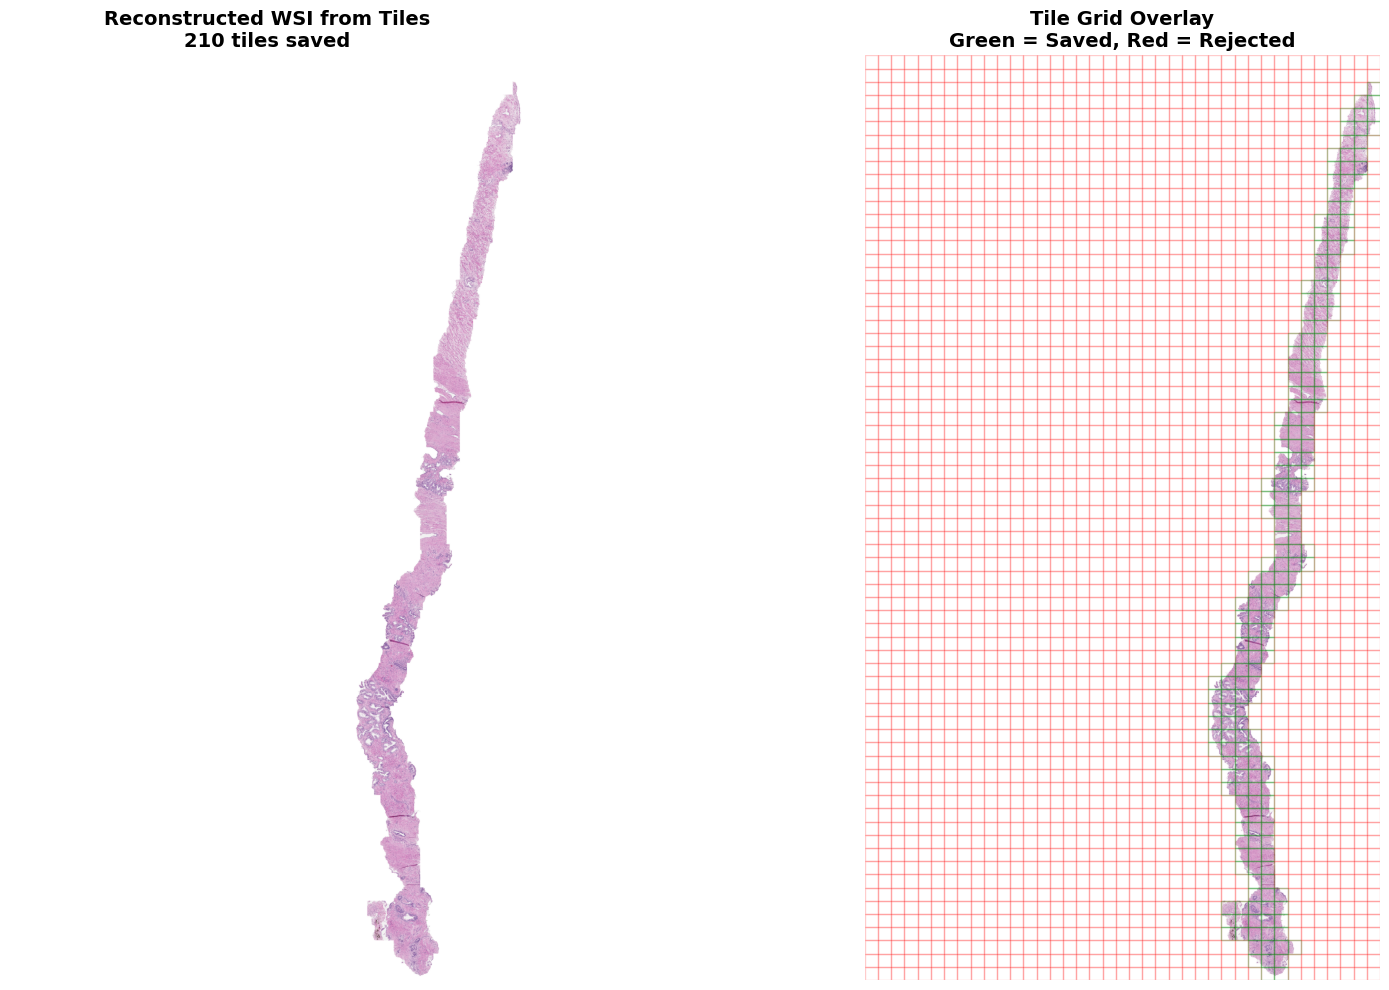


Generating coverage map...
✓ Saved: coverage_map_331e4fe39216db524c07eab27b107cf7.png


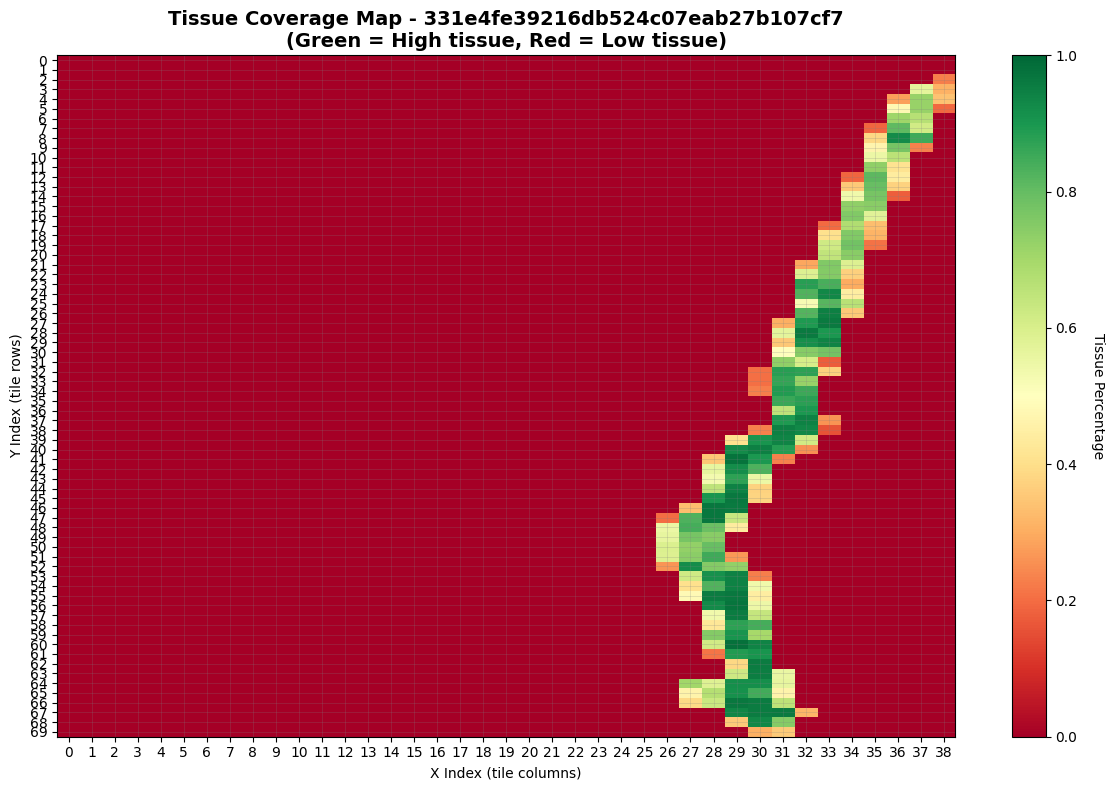

KeyboardInterrupt: Interrupted by user

Compare with original WSI? [y/n]: n


In [2]:
#!/usr/bin/env python3
"""
Reconstruct WSI from tiles - show tiles assembled in their original positions
"""

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import matplotlib.patches as patches

# ============================================================
# CONFIGURATION
# ============================================================
TILES_DIR = "/projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/tiles_04"
WSI_ID = "331e4fe39216db524c07eab27b107cf7"

TILE_SIZE = 512
DOWNSAMPLE = 8  # Show tiles at 1/8 size for visualization

# ============================================================
# TILE RECONSTRUCTION
# ============================================================

def load_tiles_with_positions(wsi_dir):
    """
    Load all tiles and extract their positions.
    
    Returns:
        tiles_dict: {(x_idx, y_idx): tile_image}
        max_x, max_y: Grid dimensions
    """
    tile_paths = glob(os.path.join(wsi_dir, "*.jpeg"))
    
    tiles_dict = {}
    max_x = 0
    max_y = 0
    
    for tile_path in tile_paths:
        filename = os.path.basename(tile_path)
        tile_name = filename.replace('.jpeg', '')
        
        try:
            x_idx, y_idx = map(int, tile_name.split('_'))
            tile = Image.open(tile_path)
            tiles_dict[(x_idx, y_idx)] = tile
            
            max_x = max(max_x, x_idx)
            max_y = max(max_y, y_idx)
        except:
            print(f"WARNING: Could not parse {filename}")
    
    return tiles_dict, max_x, max_y


def reconstruct_wsi(tiles_dict, max_x, max_y, downsample=1):
    """
    Reconstruct WSI image from tiles.
    
    Args:
        tiles_dict: Dictionary of tiles {(x, y): Image}
        max_x, max_y: Grid dimensions
        downsample: Factor to downsample tiles (for memory efficiency)
    
    Returns:
        reconstructed: PIL Image of assembled WSI
    """
    tile_display_size = TILE_SIZE // downsample
    
    # Create canvas
    width = (max_x + 1) * tile_display_size
    height = (max_y + 1) * tile_display_size
    
    print(f"Reconstructing WSI...")
    print(f"  Grid: {max_x+1} × {max_y+1} tiles")
    print(f"  Tile display size: {tile_display_size}×{tile_display_size}")
    print(f"  Output size: {width} × {height}")
    
    # Create white canvas
    reconstructed = Image.new('RGB', (width, height), (255, 255, 255))
    
    # Place tiles
    for (x_idx, y_idx), tile in tiles_dict.items():
        # Resize tile
        tile_resized = tile.resize((tile_display_size, tile_display_size), Image.LANCZOS)
        
        # Position
        x_pos = x_idx * tile_display_size
        y_pos = y_idx * tile_display_size
        
        # Paste
        reconstructed.paste(tile_resized, (x_pos, y_pos))
    
    return reconstructed


def show_reconstruction_with_grid(tiles_dict, max_x, max_y, downsample=1):
    """
    Show reconstructed WSI with tile grid overlay.
    """
    # Reconstruct
    reconstructed = reconstruct_wsi(tiles_dict, max_x, max_y, downsample)
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Left: Full reconstruction
    ax = axes[0]
    ax.imshow(reconstructed)
    ax.set_title(f'Reconstructed WSI from Tiles\n{len(tiles_dict)} tiles saved', 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Right: With grid overlay
    ax = axes[1]
    ax.imshow(reconstructed)
    
    # Draw grid
    tile_display_size = TILE_SIZE // downsample
    
    # Show all possible tile positions
    for x_idx in range(max_x + 1):
        for y_idx in range(max_y + 1):
            x_pos = x_idx * tile_display_size
            y_pos = y_idx * tile_display_size
            
            # Check if tile exists
            if (x_idx, y_idx) in tiles_dict:
                # Green border for saved tiles
                rect = patches.Rectangle((x_pos, y_pos), tile_display_size, tile_display_size,
                                        linewidth=1, edgecolor='green', facecolor='none', alpha=0.3)
            else:
                # Red border for missing tiles (rejected)
                rect = patches.Rectangle((x_pos, y_pos), tile_display_size, tile_display_size,
                                        linewidth=1, edgecolor='red', facecolor='none', alpha=0.2)
            ax.add_patch(rect)
    
    ax.set_title(f'Tile Grid Overlay\nGreen = Saved, Red = Rejected', 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    
    output_path = f"reconstructed_{WSI_ID}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved: {output_path}")
    plt.show()


def show_coverage_map(tiles_dict, max_x, max_y):
    """
    Show a heatmap of tile coverage and quality.
    """
    # Create quality matrix
    quality_map = np.zeros((max_y + 1, max_x + 1))
    
    # Fill with tissue percentages
    for (x_idx, y_idx), tile in tiles_dict.items():
        gray = np.array(tile.convert("L"))
        tissue_pct = np.mean(gray < 220)
        quality_map[y_idx, x_idx] = tissue_pct
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    im = ax.imshow(quality_map, cmap='RdYlGn', vmin=0, vmax=1, aspect='auto')
    
    ax.set_title(f'Tissue Coverage Map - {WSI_ID}\n(Green = High tissue, Red = Low tissue)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('X Index (tile columns)')
    ax.set_ylabel('Y Index (tile rows)')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Tissue Percentage', rotation=270, labelpad=20)
    
    # Add grid
    ax.set_xticks(np.arange(max_x + 1))
    ax.set_yticks(np.arange(max_y + 1))
    ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    
    output_path = f"coverage_map_{WSI_ID}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {output_path}")
    plt.show()


def compare_original_vs_tiled(wsi_path, tiles_dict, max_x, max_y):
    """
    Show original WSI thumbnail vs reconstructed from tiles.
    """
    import openslide
    
    # Load original WSI thumbnail
    slide = openslide.OpenSlide(wsi_path)
    level = slide.level_count - 1  # Lowest resolution
    thumbnail = slide.read_region((0, 0), level, slide.level_dimensions[level]).convert("RGB")
    
    # Reconstruct from tiles
    reconstructed = reconstruct_wsi(tiles_dict, max_x, max_y, downsample=DOWNSAMPLE)
    
    # Resize thumbnail to match
    thumbnail_resized = thumbnail.resize(reconstructed.size, Image.LANCZOS)
    
    # Create comparison
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    
    # Original
    axes[0].imshow(thumbnail_resized)
    axes[0].set_title('Original WSI\n(Low resolution)', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Reconstructed
    axes[1].imshow(reconstructed)
    axes[1].set_title(f'Reconstructed from Tiles\n({len(tiles_dict)} tiles)', 
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Difference
    diff = np.abs(np.array(thumbnail_resized).astype(float) - 
                  np.array(reconstructed).astype(float))
    axes[2].imshow(diff.astype(np.uint8))
    axes[2].set_title('Difference\n(Shows missing tiles in red)', 
                     fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    output_path = f"comparison_{WSI_ID}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {output_path}")
    plt.show()


def print_statistics(tiles_dict, max_x, max_y):
    """
    Print statistics about tile coverage.
    """
    total_possible = (max_x + 1) * (max_y + 1)
    saved = len(tiles_dict)
    coverage = 100 * saved / total_possible
    
    # Calculate tissue percentages
    tissue_pcts = []
    for tile in tiles_dict.values():
        gray = np.array(tile.convert("L"))
        tissue_pct = np.mean(gray < 220)
        tissue_pcts.append(tissue_pct)
    
    tissue_pcts = np.array(tissue_pcts)
    
    print("\n" + "=" * 70)
    print("TILE STATISTICS")
    print("=" * 70)
    print(f"Grid dimensions: {max_x+1} × {max_y+1} = {total_possible} positions")
    print(f"Tiles saved: {saved} ({coverage:.1f}% coverage)")
    print(f"Tiles rejected: {total_possible - saved} ({100-coverage:.1f}%)")
    
    print(f"\nTissue content:")
    print(f"  Mean:   {np.mean(tissue_pcts)*100:.1f}%")
    print(f"  Median: {np.median(tissue_pcts)*100:.1f}%")
    print(f"  Min:    {np.min(tissue_pcts)*100:.1f}%")
    print(f"  Max:    {np.max(tissue_pcts)*100:.1f}%")
    print(f"  Std:    {np.std(tissue_pcts)*100:.1f}%")
    print("=" * 70)


# ============================================================
# MAIN
# ============================================================

def main():
    print("=" * 70)
    print("TILE RECONSTRUCTION VIEWER")
    print("=" * 70)
    print(f"WSI ID: {WSI_ID}")
    print(f"Tiles directory: {TILES_DIR}")
    print(f"Downsample factor: {DOWNSAMPLE}x (for display)")
    print()
    
    # Load tiles
    wsi_dir = os.path.join(TILES_DIR, WSI_ID)
    
    if not os.path.exists(wsi_dir):
        print(f"ERROR: Tile directory not found: {wsi_dir}")
        return
    
    print("Loading tiles...")
    tiles_dict, max_x, max_y = load_tiles_with_positions(wsi_dir)
    print(f"✓ Loaded {len(tiles_dict)} tiles")
    
    # Print statistics
    print_statistics(tiles_dict, max_x, max_y)
    
    # Show reconstruction with grid
    print("\nGenerating reconstruction...")
    show_reconstruction_with_grid(tiles_dict, max_x, max_y, downsample=DOWNSAMPLE)
    
    # Show coverage map
    print("\nGenerating coverage map...")
    show_coverage_map(tiles_dict, max_x, max_y)
    
    # Optional: Compare with original
    print("\n" + "=" * 70)
    compare_orig = input("Compare with original WSI? [y/n]: ").lower()
    if compare_orig == 'y':
        import openslide
        INPUT_DIR = "/projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY/DATA/train_images"
        wsi_path = os.path.join(INPUT_DIR, f"{WSI_ID}.tiff")
        if not os.path.exists(wsi_path):
            wsi_path = os.path.join(INPUT_DIR, f"{WSI_ID}.tif")
        
        if os.path.exists(wsi_path):
            compare_original_vs_tiled(wsi_path, tiles_dict, max_x, max_y)
        else:
            print(f"Original WSI not found: {wsi_path}")
    
    print("\n" + "=" * 70)
    print("COMPLETE")
    print("=" * 70)
    print("Output files:")
    print(f"  - reconstructed_{WSI_ID}.png")
    print(f"  - coverage_map_{WSI_ID}.png")
    if compare_orig == 'y':
        print(f"  - comparison_{WSI_ID}.png")


if __name__ == "__main__":
    main()

## If you divided your training data into subsets run the following code to merge.

### Create "all_patches" csv file for Feature Extraction

Next code merges subset tiles/patches from "path/to/tiles" to ./feature_extraction/all_patches folder.

In [1]:
#!/usr/bin/env python3
"""
Create all_patches_train.csv from ALL extracted training tiles
(across tiles_01 ... tiles_10)
"""

import os
import pandas as pd
from glob import glob

# Parent directory containing tiles_01, tiles_02, ... tiles_10
PARENT_DIR = "/projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY"
OUTPUT_CSV = "all_patches_train.csv"

TRAIN_TILE_FOLDERS = [f"tiles_{i:02d}" for i in range(1, 11)]  # tiles_01 → tiles_10

def create_all_patches_csv(parent_dir, tile_folders, output_csv):
    all_patches = []

    print("Scanning training tile folders:")
    for folder in tile_folders:
        folder_path = os.path.join(parent_dir, folder)
        if not os.path.isdir(folder_path):
            print(f"  ⚠ skipping missing folder: {folder}")
            continue
        
        print(f"  ✓ scanning {folder}")
        # Grab all jpeg/png/jpg tiles inside each WSI directory
        for wsi_dir in sorted(os.listdir(folder_path)):
            wsi_path = os.path.join(folder_path, wsi_dir)
            if os.path.isdir(wsi_path):
                tiles = glob(os.path.join(wsi_path, "*.jpeg")) \
                      + glob(os.path.join(wsi_path, "*.jpg")) \
                      + glob(os.path.join(wsi_path, "*.png"))
                all_patches.extend(tiles)

    print(f"\nTotal patches found: {len(all_patches)}")

    df = pd.DataFrame({"path": all_patches})
    df.to_csv(output_csv, index=False)

    print(f"✓ Saved CSV to: {output_csv}")
    print("\nSample:")
    print(df.head())

    return df

if __name__ == "__main__":
    create_all_patches_csv(PARENT_DIR, TRAIN_TILE_FOLDERS, OUTPUT_CSV)


Scanning training tile folders:
  ✓ scanning tiles_01
  ✓ scanning tiles_02
  ✓ scanning tiles_03
  ✓ scanning tiles_04
  ✓ scanning tiles_05
  ✓ scanning tiles_06
  ✓ scanning tiles_07
  ✓ scanning tiles_08
  ✓ scanning tiles_09
  ✓ scanning tiles_10

Total patches found: 1215841
✓ Saved CSV to: all_patches_train.csv

Sample:
                                                path
0  /projectnb/ec500kb/projects/Project_1_Team_1/P...
1  /projectnb/ec500kb/projects/Project_1_Team_1/P...
2  /projectnb/ec500kb/projects/Project_1_Team_1/P...
3  /projectnb/ec500kb/projects/Project_1_Team_1/P...
4  /projectnb/ec500kb/projects/Project_1_Team_1/P...


## Patch Counter 

Run code below:

Counts the total number of extracted patches (tiles) across all WSIs in a specified tiles directory. Reports the number of WSIs processed, total patches, and average patches per WSI.

In [7]:
#!/usr/bin/env python3
"""
Count patches in each tiles_## directory
"""
import os
from glob import glob

# ============================================================
# CONFIG
# ============================================================
BASE_DIR = "/projectnb/ec500kb/projects/Project_1_Team_1/PANDA_DATA_MANNY"

# ============================================================
# COUNT PATCHES
# ============================================================
def count_patches_in_directory(tiles_dir):
    """Count total patches in a tiles directory."""
    if not os.path.exists(tiles_dir):
        return 0
    
    total = 0
    wsi_dirs = [d for d in os.listdir(tiles_dir) if os.path.isdir(os.path.join(tiles_dir, d))]
    
    for wsi_dir in wsi_dirs:
        wsi_path = os.path.join(tiles_dir, wsi_dir)
        patches = glob(os.path.join(wsi_path, "*.jpeg"))
        total += len(patches)
    
    return total, len(wsi_dirs)


# ============================================================
# MAIN
# ============================================================
def main():
    print("="*70)
    print("PATCH COUNT SUMMARY")
    print("="*70)
    
    # Find all tiles_## directories
    tiles_dirs = sorted(glob(os.path.join(BASE_DIR, "tiles_09")))
    
    if not tiles_dirs:
        print("No tiles_* directories found!")
        return
    
    grand_total = 0
    results = []
    
    for tiles_dir in tiles_dirs:
        dir_name = os.path.basename(tiles_dir)
        total_patches, num_wsis = count_patches_in_directory(tiles_dir)
        
        results.append((dir_name, total_patches, num_wsis))
        grand_total += total_patches
    
    # Print results
    print(f"\n{'Directory':<20} {'WSIs':<10} {'Patches':<15} {'Avg/WSI':<10}")
    print("-"*70)
    
    for dir_name, patches, wsis in results:
        avg = patches / wsis if wsis > 0 else 0
        print(f"{dir_name:<20} {wsis:<10} {patches:<15,} {avg:<10.1f}")
    
    print("-"*70)
    print(f"{'TOTAL':<20} {'':<10} {grand_total:<15,}")
    print("="*70)


if __name__ == "__main__":
    main()

PATCH COUNT SUMMARY

Directory            WSIs       Patches         Avg/WSI   
----------------------------------------------------------------------
tiles_09             850        118,458         139.4     
----------------------------------------------------------------------
TOTAL                           118,458        
